In [1]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

import sklearn.model_selection
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids, NearMiss

import xgboost as xgb
from xgboost import XGBClassifier

### Random Forest Models
##### Key models  

* Random Forest increased the best model's Class 1 Recall by .06 points to .81, with a marginal decrease in accuracy. Class 1 Precision dropped by .09, so with the gain in recall, we also had more observations incorrectly identified as fraud.

type, undersampling method | Class 1 Precision | Class 1 Recall | Accuracy Score | 
------- | ------------ | -------------- | --------------- | 
BEST: random forest, random under sampling | 0.37 | .81 | .853 | 
general random forest | .77 | .32 | .928  | .928 |
xg_boost |.70 | .45 | .93 |
* lasso cv, random under sampling | 0.46 | 0.75 | 0.885
* ridge cv, random under sampling | 0.46 | 0.75 | 0.885



"*" = best prior model 


In [3]:
# try resampling with auto and 1 for ross. see which is better and proceed 
# choose resampling methods from previous that worked better. 
# figure out xd boost

In [2]:
def random_forest_general(df, target, method):
    # baseline logistic regression. 
    # penalty = 'l2', ridge. , solver = 'liblinear'
    X = df.drop(target, axis=1)
    y = df[target]

    # training and testing sets
    X_train, X_test, y_train, y_test = \
    train_test_split(X, y, random_state = 42, stratify=y)

    # Instantiate model
    rf = RandomForestClassifier(oob_score=True, random_state=30)

    # Train the model on training data
    rf.fit(X_train, y_train)

    # Out of Bag Error
    # oob_score = rf.oob_score_ # score  = 1- oob error
    print('OOB Score: %.2f' % rf.oob_score_ )
    
    # Scores
    y_predict_test = rf.predict(X_test)
    print("Test accuracy score:", round(accuracy_score(y_predict_test, y_test), 3))
    
    # Classification report
    print("\n Test Classification Report:")
    print(classification_report(y_test, y_predict_test))
     
def random_forest_tuned(df, target, method):
    X = df.drop(target, axis=1)
    y = df[target]

    # training and testing sets
    X_sample, X_test, y_sample, y_test = \
    train_test_split(X, y, random_state = 42, stratify=y)
    
    # resampling methods
    # sampling strategy = (ratio : minority / majority) could be 'auto' or 1. could be something else.
    if method == 'ros':
        X_train, y_train = RandomOverSampler(random_state=0).fit_resample(X_sample, y_sample)
    if method == 'ADASYN':
        X_train, y_train = ADASYN(random_state=0).fit_resample(X_sample, y_sample)        
    if method == 'SMOTE':
        X_train, y_train = SMOTE(random_state=0).fit_resample(X_sample, y_sample)        
    if method == 'rus':
        X_train, y_train = RandomUnderSampler(random_state=0).fit_resample(X_sample, y_sample)
    if method == 'cc':
        X_train, y_train = ClusterCentroids(random_state=0).fit_resample(X_sample, y_sample)   
    if method == 'NearMiss':
        X_train, y_train = NearMiss(version=1, random_state=0).fit_resample(X_sample, y_sample)
    if method == 'none':
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
    
    # Instantiate model
    rf = RandomForestClassifier(oob_score=True, random_state=30)

    #Parameters
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 400, stop = 700, num = 4)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt', 'log2']

    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
               'max_features': max_features} 
    
    # search across different combinations of parameters, and use all available scores
    rf_tuned = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 10, cv = 3, random_state=42)
    
    # Train the model on training data
    rf_tuned.fit(X_train, y_train)

    # Scores
    y_predict_test = rf_tuned.predict(X_test)
    print("Test accuracy score:", round(accuracy_score(y_predict_test, y_test), 3))
    
    # Classification report
    print("\n Test Classification Report:")
    print(classification_report(y_test, y_predict_test))
    
    # Best Parameters:
    print("Best Parameters", rf_tuned.best_estimator_)

In [3]:
train_final_data = pd.read_csv('/Users/Julia/Documents/bootcamp/fraud_capstone/data_out/train_final_data.csv', low_memory=False)

In [4]:
train_final_data.head()

,ChronicCond_Alzheimer,ChronicCond_Cancer,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_Heartfailure,ChronicCond_IschemicHeart,ChronicCond_KidneyDisease,ChronicCond_ObstrPulmonary,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,County_0,County_1,County_10,County_100,County_11,County_110,County_111,County_113,County_117,County_120,County_130,County_131,County_14,County_140,County_141,County_150,County_160,County_161,County_170,County_180,County_190,County_191,County_194,County_20,County_200,County_210,County_211,County_212,County_213,County_220,County_221,County_222,County_223,County_224,County_230,County_240,County_241,County_25,County_250,...,proc_9764.0,proc_9784.0,proc_9787.0,proc_9789.0,proc_9805.0,proc_9815.0,proc_9851.0,proc_9903.0,proc_9904.0,proc_9905.0,proc_9906.0,proc_9907.0,proc_9910.0,proc_9914.0,proc_9915.0,proc_9916.0,proc_9917.0,proc_9918.0,proc_9919.0,proc_9920.0,proc_9921.0,proc_9922.0,proc_9923.0,proc_9925.0,proc_9926.0,proc_9928.0,proc_9929.0,proc_9938.0,proc_9939.0,proc_9952.0,proc_9955.0,proc_9959.0,proc_9960.0,proc_9961.0,proc_9962.0,proc_9969.0,proc_9971.0,proc_9972.0,proc_9973.0,proc_9974.0,proc_9975.0,proc_9978.0,proc_9979.0,proc_9982.0,proc_9984.0,proc_9986.0,proc_9992.0,proc_9995.0,proc_9998.0,proc_9999.0
0,0.365759,0.233463,0.451362,0.754864,0.564202,0.762646,0.474708,0.400778,0.272374,0.330739,0.105058,0.011673,0.0,0.011673,0.011673,0.0,0.0,0.0,0.0,0.0,0.0,0.015564,0.0,0.0,0.003891,0.0,0.07393,0.000000,0.0,0.0,0.003891,0.011673,0.0,0.0,0.003891,0.0,0.000000,0.0,0.0,0.0,0.011673,0.0,0.0,0.0,0.0,0.007782,0.011673,0.0,0.0,0.054475,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.426901,0.175439,0.444444,0.730994,0.649123,0.807018,0.473684,0.380117,0.280702,0.345029,0.076023,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.023392,0.0,0.0,0.005848,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.070175,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.070175,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.429515,0.229075,0.451542,0.685022,0.596916,0.799559,0.398678,0.341410,0.370044,0.290749,0.063877,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.156388,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.496454,0.191489,0.446809,0.773050,0.624113,0.794326,0.460993,0.304965,0.326241,0.326241,0.099291,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.014184,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.014184,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.322917,0.156250,0.385417,0.645833,0.645833,0.687500,0.395833,0.302083,0.291667,0.270833,0.104167,0.000000,0.0,0.031250,0.031250,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,0.000000,0.0,0.00000,0.135417,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.010417,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
random_forest_general(train_final_data, 'PotentialFraud', 'none')

/Users/Julia/miniconda3/envs/advanced-pip-example/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Julia/miniconda3/envs/advanced-pip-example/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/Julia/miniconda3/envs/advanced-pip-example/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/Julia/miniconda3/envs/advanced-pip-example/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


OOB Score: 0.92
Test accuracy score: 0.928

 Test Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1226
           1       0.77      0.32      0.46       127

    accuracy                           0.93      1353
   macro avg       0.85      0.66      0.71      1353
weighted avg       0.92      0.93      0.91      1353



In [8]:
random_forest_tuned(train_final_data, 'PotentialFraud', 'rus')

Test accuracy score: 0.853

 Test Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.91      1226
           1       0.37      0.81      0.51       127

    accuracy                           0.85      1353
   macro avg       0.67      0.83      0.71      1353
weighted avg       0.92      0.85      0.88      1353

Best Parameters RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=True, random_state=30, verbose=0,
                       warm_start=False)


In [9]:
random_forest_tuned(train_final_data, 'PotentialFraud', 'cc')

/Users/Julia/miniconda3/envs/advanced-pip-example/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Test accuracy score: 0.872

 Test Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1226
           1       0.38      0.54      0.44       127

    accuracy                           0.87      1353
   macro avg       0.66      0.72      0.69      1353
weighted avg       0.90      0.87      0.88      1353

Best Parameters RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=True, random_state=30, verbose=0,
                       warm_start=False)


In [10]:
random_forest_tuned(train_final_data, 'PotentialFraud', 'NearMiss')

Test accuracy score: 0.635

 Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.60      0.75      1226
           1       0.20      0.97      0.33       127

    accuracy                           0.63      1353
   macro avg       0.60      0.78      0.54      1353
weighted avg       0.92      0.63      0.71      1353

Best Parameters RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=True, random_state=30, verbose=0,
                       warm_start=False)


Automatically created module for IPython interactive environment


/Users/Julia/miniconda3/envs/advanced-pip-example/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/Julia/miniconda3/envs/advanced-pip-example/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/Julia/miniconda3/envs/advanced-pip-example/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/Julia/miniconda3/envs/advanced-pip-example/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "

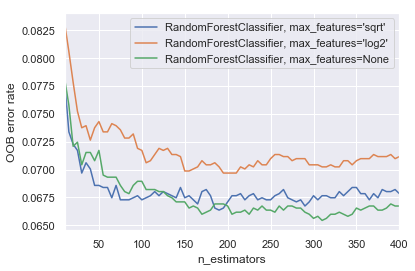

In [5]:
from collections import OrderedDict

# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause

print(__doc__)

RANDOM_STATE = 123

# Generate a binary classification dataset.
X = train_final_data.drop("PotentialFraud", axis=1)
y = train_final_data["PotentialFraud"]
    
# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(n_estimators=200,
                               warm_start=True, max_features="sqrt",
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(n_estimators=200,
                               warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(n_estimators=200,
                               warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 10
max_estimators = 400

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
sns.set()
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

* Model above: OOB error settles around 200:
    * 150 for max_features = 'log2'
    * 180 for max_features = 'sqrt'
    * 300 for max_features = 'None'
* Our best tuned models had 400-600 estimators.

# MODELING WITH XGB:

In [12]:
# Baseline:
X = train_final_data.drop("PotentialFraud", axis=1)
y = train_final_data["PotentialFraud"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# fit model 
model = XGBClassifier(seed=30)
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("\n Test Accuracy:" % (accuracy * 100.0))
print("\n Test Classification Report:")
print(classification_report(y_test, y_pred))


 Test Accuracy:

 Test Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1216
           1       0.67      0.45      0.54       137

    accuracy                           0.92      1353
   macro avg       0.81      0.71      0.75      1353
weighted avg       0.91      0.92      0.92      1353



In [10]:
# GOOD FUNCTION

def xgb_tuned(df, target):
    X = df.drop(target, axis=1)
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    # Instantiate model
    model = XGBClassifier(random_state=30)

    #Parameters
    cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
    ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
    
    # Optimize for accuracy since that is the metric used in the Adult Data Set notation
    model_tuned = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                    cv_params, scoring = 'accuracy', cv = 5, n_jobs = -1)
    model_tuned.fit(X_train, y_train)
                       
    # make predictions for test data
    y_pred = model_tuned.predict(X_test)

    # evaluate predictions
    print("\n Test Accuracy:", (accuracy_score(y_test, y_pred) * 100.0))
   
    # Classification report
    print("\n Test Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Best Parameters:
    print("Best Parameters", model_tuned.best_estimator_)

In [15]:
xgb_tuned(train_final_data, "PotentialFraud")


 Test Accuracy:

 Test Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1216
           1       0.70      0.45      0.55       137

    accuracy                           0.93      1353
   macro avg       0.82      0.72      0.76      1353
weighted avg       0.92      0.93      0.92      1353



In [8]:
# BAD FUNCTION

def xgb_tuned_samp(df, target, method):
    X = df.drop(target, axis=1)
    y = df[target]

    X_sample, X_test, y_sample, y_test = \
    train_test_split(X, y, random_state = 42, stratify=y)
    if method == 'rus':
        X_train, y_train = RandomUnderSampler(random_state=0).fit_resample(X_sample, y_sample)
    if method == 'none':
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    # Instantiate model
    model = XGBClassifier(random_state=30)

    #Parameters
    cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
    ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
    
    # Optimize for accuracy since that is the metric used in the Adult Data Set notation
    model_tuned = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                    cv_params, scoring = 'accuracy', cv = 5, n_jobs = -1)
    model_tuned.fit(X_train, y_train)
                       
    # make predictions for test data
    y_pred = model_tuned.predict(X_test)

    # evaluate predictions
    print("\n Test Accuracy:", (accuracy_score(y_test, y_pred) * 100.0))
   
    # Classification report
    print("\n Test Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Best Parameters:
    print("Best Parameters", model_tuned.best_estimator_)

In [9]:
xgb_tuned_samp(train_final_data, "PotentialFraud", 'rus')

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284', 'f285', 'f286', 'f287', 'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299', 'f300', 'f301', 'f302', 'f303', 'f304', 'f305', 'f306', 'f307', 'f308', 'f309', 'f310', 'f311', 'f312', 'f313', 'f314', 'f315', 'f316', 'f317', 'f318', 'f319', 'f320', 'f321', 'f322', 'f323', 'f324', 'f325', 'f326', 'f327', 'f328', 'f329', 'f330', 'f331', 'f332', 'f333', 'f334', 'f335', 'f336', 'f337', 'f338', 'f339', 'f340', 'f341', 'f342', 'f343', 'f344', 'f345', 'f346', 'f347', 'f348', 'f349', 'f350', 'f351', 'f352', 'f353', 'f354', 'f355', 'f356', 'f357', 'f358', 'f359', 'f360', 'f361', 'f362', 'f363', 'f364', 'f365', 'f366', 'f367', 'f368', 'f369', 'f370', 'f371', 'f372', 'f373', 'f374', 'f375', 'f376', 'f377', 'f378', 'f379', 'f380', 'f381', 'f382', 'f383', 'f384', 'f385', 'f386', 'f387', 'f388', 'f389', 'f390', 'f391', 'f392', 'f393', 'f394', 'f395', 'f396', 'f397', 'f398', 'f399', 'f400', 'f401', 'f402', 'f403', 'f404', 'f405', 'f406', 'f407', 'f408', 'f409', 'f410', 'f411', 'f412', 'f413', 'f414', 'f415', 'f416', 'f417', 'f418', 'f419', 'f420', 'f421', 'f422', 'f423', 'f424', 'f425', 'f426', 'f427', 'f428', 'f429', 'f430', 'f431', 'f432', 'f433', 'f434', 'f435', 'f436', 'f437', 'f438', 'f439', 'f440', 'f441', 'f442', 'f443', 'f444', 'f445', 'f446', 'f447', 'f448', 'f449', 'f450', 'f451', 'f452', 'f453', 'f454', 'f455', 'f456', 'f457', 'f458', 'f459', 'f460', 'f461', 'f462', 'f463', 'f464', 'f465', 'f466', 'f467', 'f468', 'f469', 'f470', 'f471', 'f472', 'f473', 'f474', 'f475', 'f476', 'f477', 'f478', 'f479', 'f480', 'f481', 'f482', 'f483', 'f484', 'f485', 'f486', 'f487', 'f488', 'f489', 'f490', 'f491', 'f492', 'f493', 'f494', 'f495', 'f496', 'f497', 'f498', 'f499', 'f500', 'f501', 'f502', 'f503', 'f504', 'f505', 'f506', 'f507', 'f508', 'f509', 'f510', 'f511', 'f512', 'f513', 'f514', 'f515', 'f516', 'f517', 'f518', 'f519', 'f520', 'f521', 'f522', 'f523', 'f524', 'f525', 'f526', 'f527', 'f528', 'f529', 'f530', 'f531', 'f532', 'f533', 'f534', 'f535', 'f536', 'f537', 'f538', 'f539', 'f540', 'f541', 'f542', 'f543', 'f544', 'f545', 'f546', 'f547', 'f548', 'f549', 'f550', 'f551', 'f552', 'f553', 'f554', 'f555', 'f556', 'f557', 'f558', 'f559', 'f560', 'f561', 'f562', 'f563', 'f564', 'f565', 'f566', 'f567', 'f568', 'f569', 'f570', 'f571', 'f572', 'f573', 'f574', 'f575', 'f576', 'f577', 'f578', 'f579', 'f580', 'f581', 'f582', 'f583', 'f584', 'f585', 'f586', 'f587', 'f588', 'f589', 'f590', 'f591', 'f592', 'f593', 'f594', 'f595', 'f596', 'f597', 'f598', 'f599', 'f600', 'f601', 'f602', 'f603', 'f604', 'f605', 'f606', 'f607', 'f608', 'f609', 'f610', 'f611', 'f612', 'f613', 'f614', 'f615', 'f616', 'f617', 'f618', 'f619', 'f620', 'f621', 'f622', 'f623', 'f624', 'f625', 'f626', 'f627', 'f628', 'f629', 'f630', 'f631', 'f632', 'f633', 'f634', 'f635', 'f636', 'f637', 'f638', 'f639', 'f640', 'f641', 'f642', 'f643', 'f644', 'f645', 'f646', 'f647', 'f648', 'f649', 'f650', 'f651', 'f652', 'f653', 'f654', 'f655', 'f656', 'f657', 'f658', 'f659', 'f660', 'f661', 'f662', 'f663', 'f664', 'f665', 'f666', 'f667', 'f668', 'f669', 'f670', 'f671', 'f672', 'f673', 'f674', 'f675', 'f676', 'f677', 'f678', 'f679', 'f680', 'f681', 'f682', 'f683', 'f684', 'f685', 'f686', 'f687', 'f688', 'f689', 'f690', 'f691', 'f692', 'f693', 'f694', 'f695', 'f696', 'f697', 'f698', 'f699', 'f700', 'f701', 'f702', 'f703', 'f704', 'f705', 'f706', 'f707', 'f708', 'f709', 'f710', 'f711', 'f712', 'f713', 'f714', 'f715', 'f716', 'f717', 'f718', 'f719', 'f720', 'f721', 'f722', 'f723', 'f724', 'f725', 'f726', 'f727', 'f728', 'f729', 'f730', 'f731', 'f732', 'f733', 'f734', 'f735', 'f736', 'f737', 'f738', 'f739', 'f740', 'f741', 'f742', 'f743', 'f744', 'f745', 'f746', 'f747', 'f748', 'f749', 'f750', 'f751', 'f752', 'f753', 'f754', 'f755', 'f756', 'f757', 'f758', 'f759', 'f760', 'f761', 'f762', 'f763', 'f764', 'f765', 'f766', 'f767', 'f768', 'f769', 'f770', 'f771', 'f772', 'f773', 'f774', 'f775', 'f776', 'f777', 'f778', 'f779', 'f780', 'f781', 'f782', 'f783', 'f784', 'f785', 'f786', 'f787', 'f788', 'f789', 'f790', 'f791', 'f792', 'f793', 'f794', 'f795', 'f796', 'f797', 'f798', 'f799', 'f800', 'f801', 'f802', 'f803', 'f804', 'f805', 'f806', 'f807', 'f808', 'f809', 'f810', 'f811', 'f812', 'f813', 'f814', 'f815', 'f816', 'f817', 'f818', 'f819', 'f820', 'f821', 'f822', 'f823', 'f824', 'f825', 'f826', 'f827', 'f828', 'f829', 'f830', 'f831', 'f832', 'f833', 'f834', 'f835', 'f836', 'f837', 'f838', 'f839', 'f840', 'f841', 'f842', 'f843', 'f844', 'f845', 'f846', 'f847', 'f848', 'f849', 'f850', 'f851', 'f852', 'f853', 'f854', 'f855', 'f856', 'f857', 'f858', 'f859', 'f860', 'f861', 'f862', 'f863', 'f864', 'f865', 'f866', 'f867', 'f868', 'f869', 'f870', 'f871', 'f872', 'f873', 'f874', 'f875', 'f876', 'f877', 'f878', 'f879', 'f880', 'f881', 'f882', 'f883', 'f884', 'f885', 'f886', 'f887', 'f888', 'f889', 'f890', 'f891', 'f892', 'f893', 'f894', 'f895', 'f896', 'f897', 'f898', 'f899', 'f900', 'f901', 'f902', 'f903', 'f904', 'f905', 'f906', 'f907', 'f908', 'f909', 'f910', 'f911', 'f912', 'f913', 'f914', 'f915', 'f916', 'f917', 'f918', 'f919', 'f920', 'f921', 'f922', 'f923', 'f924', 'f925', 'f926', 'f927', 'f928', 'f929', 'f930', 'f931', 'f932', 'f933', 'f934', 'f935', 'f936', 'f937', 'f938', 'f939', 'f940', 'f941', 'f942', 'f943', 'f944', 'f945', 'f946', 'f947', 'f948', 'f949', 'f950', 'f951', 'f952', 'f953', 'f954', 'f955', 'f956', 'f957', 'f958', 'f959', 'f960', 'f961', 'f962', 'f963', 'f964', 'f965', 'f966', 'f967', 'f968', 'f969', 'f970', 'f971', 'f972', 'f973', 'f974', 'f975', 'f976', 'f977', 'f978', 'f979', 'f980', 'f981', 'f982', 'f983', 'f984', 'f985', 'f986', 'f987', 'f988', 'f989', 'f990', 'f991', 'f992', 'f993', 'f994', 'f995', 'f996', 'f997', 'f998', 'f999', 'f1000', 'f1001', 'f1002', 'f1003', 'f1004', 'f1005', 'f1006', 'f1007', 'f1008', 'f1009', 'f1010', 'f1011', 'f1012', 'f1013', 'f1014', 'f1015', 'f1016', 'f1017', 'f1018', 'f1019', 'f1020', 'f1021', 'f1022', 'f1023', 'f1024', 'f1025', 'f1026', 'f1027', 'f1028', 'f1029', 'f1030', 'f1031', 'f1032', 'f1033', 'f1034', 'f1035', 'f1036', 'f1037', 'f1038', 'f1039', 'f1040', 'f1041', 'f1042', 'f1043', 'f1044', 'f1045', 'f1046', 'f1047', 'f1048', 'f1049', 'f1050', 'f1051', 'f1052', 'f1053', 'f1054', 'f1055', 'f1056', 'f1057', 'f1058', 'f1059', 'f1060', 'f1061', 'f1062', 'f1063', 'f1064', 'f1065', 'f1066', 'f1067', 'f1068', 'f1069', 'f1070', 'f1071', 'f1072', 'f1073', 'f1074', 'f1075', 'f1076', 'f1077', 'f1078', 'f1079', 'f1080', 'f1081', 'f1082', 'f1083', 'f1084', 'f1085', 'f1086', 'f1087', 'f1088', 'f1089', 'f1090', 'f1091', 'f1092', 'f1093', 'f1094', 'f1095', 'f1096', 'f1097', 'f1098', 'f1099', 'f1100', 'f1101', 'f1102', 'f1103', 'f1104', 'f1105', 'f1106', 'f1107', 'f1108', 'f1109', 'f1110', 'f1111', 'f1112', 'f1113', 'f1114', 'f1115', 'f1116', 'f1117', 'f1118', 'f1119', 'f1120', 'f1121', 'f1122', 'f1123', 'f1124', 'f1125', 'f1126', 'f1127', 'f1128', 'f1129', 'f1130', 'f1131', 'f1132', 'f1133', 'f1134', 'f1135', 'f1136', 'f1137', 'f1138', 'f1139', 'f1140', 'f1141', 'f1142', 'f1143', 'f1144', 'f1145', 'f1146', 'f1147', 'f1148', 'f1149', 'f1150', 'f1151', 'f1152', 'f1153', 'f1154', 'f1155', 'f1156', 'f1157', 'f1158', 'f1159', 'f1160', 'f1161', 'f1162', 'f1163', 'f1164', 'f1165', 'f1166', 'f1167', 'f1168', 'f1169', 'f1170', 'f1171', 'f1172', 'f1173', 'f1174', 'f1175', 'f1176', 'f1177', 'f1178', 'f1179', 'f1180', 'f1181', 'f1182', 'f1183', 'f1184', 'f1185', 'f1186', 'f1187', 'f1188', 'f1189', 'f1190', 'f1191', 'f1192', 'f1193', 'f1194', 'f1195', 'f1196', 'f1197', 'f1198', 'f1199', 'f1200', 'f1201', 'f1202', 'f1203', 'f1204', 'f1205', 'f1206', 'f1207', 'f1208', 'f1209', 'f1210', 'f1211', 'f1212', 'f1213', 'f1214', 'f1215', 'f1216', 'f1217', 'f1218', 'f1219', 'f1220', 'f1221', 'f1222', 'f1223', 'f1224', 'f1225', 'f1226', 'f1227', 'f1228', 'f1229', 'f1230', 'f1231', 'f1232', 'f1233', 'f1234', 'f1235', 'f1236', 'f1237', 'f1238', 'f1239', 'f1240', 'f1241', 'f1242', 'f1243', 'f1244', 'f1245', 'f1246', 'f1247', 'f1248', 'f1249', 'f1250', 'f1251', 'f1252', 'f1253', 'f1254', 'f1255', 'f1256', 'f1257', 'f1258', 'f1259', 'f1260', 'f1261', 'f1262', 'f1263', 'f1264', 'f1265', 'f1266', 'f1267', 'f1268', 'f1269', 'f1270', 'f1271', 'f1272', 'f1273', 'f1274', 'f1275', 'f1276', 'f1277', 'f1278', 'f1279', 'f1280', 'f1281', 'f1282', 'f1283', 'f1284', 'f1285', 'f1286', 'f1287', 'f1288', 'f1289', 'f1290', 'f1291', 'f1292', 'f1293', 'f1294', 'f1295', 'f1296', 'f1297', 'f1298', 'f1299', 'f1300', 'f1301', 'f1302', 'f1303', 'f1304', 'f1305', 'f1306', 'f1307', 'f1308', 'f1309', 'f1310', 'f1311', 'f1312', 'f1313', 'f1314', 'f1315', 'f1316', 'f1317', 'f1318', 'f1319', 'f1320', 'f1321', 'f1322', 'f1323', 'f1324', 'f1325', 'f1326', 'f1327', 'f1328', 'f1329', 'f1330', 'f1331', 'f1332', 'f1333', 'f1334', 'f1335', 'f1336', 'f1337', 'f1338', 'f1339', 'f1340', 'f1341', 'f1342', 'f1343', 'f1344', 'f1345', 'f1346', 'f1347', 'f1348', 'f1349', 'f1350', 'f1351', 'f1352', 'f1353', 'f1354', 'f1355', 'f1356', 'f1357', 'f1358', 'f1359', 'f1360', 'f1361', 'f1362', 'f1363', 'f1364', 'f1365', 'f1366', 'f1367', 'f1368', 'f1369', 'f1370', 'f1371', 'f1372', 'f1373', 'f1374', 'f1375', 'f1376', 'f1377', 'f1378', 'f1379', 'f1380', 'f1381', 'f1382', 'f1383', 'f1384', 'f1385', 'f1386', 'f1387', 'f1388', 'f1389', 'f1390', 'f1391', 'f1392', 'f1393', 'f1394', 'f1395', 'f1396', 'f1397', 'f1398', 'f1399', 'f1400', 'f1401', 'f1402', 'f1403', 'f1404', 'f1405', 'f1406', 'f1407', 'f1408', 'f1409', 'f1410', 'f1411', 'f1412', 'f1413', 'f1414', 'f1415', 'f1416', 'f1417', 'f1418', 'f1419', 'f1420', 'f1421', 'f1422', 'f1423', 'f1424', 'f1425', 'f1426', 'f1427', 'f1428', 'f1429', 'f1430', 'f1431', 'f1432', 'f1433', 'f1434', 'f1435', 'f1436', 'f1437', 'f1438', 'f1439', 'f1440', 'f1441', 'f1442', 'f1443', 'f1444', 'f1445', 'f1446', 'f1447', 'f1448', 'f1449', 'f1450', 'f1451', 'f1452', 'f1453', 'f1454', 'f1455', 'f1456', 'f1457', 'f1458', 'f1459', 'f1460', 'f1461', 'f1462', 'f1463', 'f1464', 'f1465', 'f1466', 'f1467', 'f1468', 'f1469', 'f1470', 'f1471', 'f1472', 'f1473', 'f1474', 'f1475', 'f1476', 'f1477', 'f1478', 'f1479', 'f1480', 'f1481', 'f1482', 'f1483', 'f1484', 'f1485', 'f1486', 'f1487', 'f1488', 'f1489', 'f1490', 'f1491', 'f1492', 'f1493', 'f1494', 'f1495', 'f1496', 'f1497', 'f1498', 'f1499', 'f1500', 'f1501', 'f1502', 'f1503', 'f1504', 'f1505', 'f1506', 'f1507', 'f1508', 'f1509', 'f1510', 'f1511', 'f1512', 'f1513', 'f1514', 'f1515', 'f1516', 'f1517', 'f1518', 'f1519', 'f1520', 'f1521', 'f1522', 'f1523', 'f1524', 'f1525', 'f1526', 'f1527', 'f1528', 'f1529', 'f1530', 'f1531', 'f1532', 'f1533', 'f1534', 'f1535', 'f1536', 'f1537', 'f1538', 'f1539', 'f1540', 'f1541', 'f1542', 'f1543', 'f1544', 'f1545', 'f1546', 'f1547', 'f1548', 'f1549', 'f1550', 'f1551', 'f1552', 'f1553', 'f1554', 'f1555', 'f1556', 'f1557', 'f1558', 'f1559', 'f1560', 'f1561', 'f1562', 'f1563', 'f1564', 'f1565', 'f1566', 'f1567', 'f1568', 'f1569', 'f1570', 'f1571', 'f1572', 'f1573', 'f1574', 'f1575', 'f1576', 'f1577', 'f1578', 'f1579', 'f1580', 'f1581', 'f1582', 'f1583', 'f1584', 'f1585', 'f1586', 'f1587', 'f1588', 'f1589', 'f1590', 'f1591', 'f1592', 'f1593', 'f1594', 'f1595', 'f1596', 'f1597', 'f1598', 'f1599', 'f1600', 'f1601', 'f1602', 'f1603', 'f1604', 'f1605', 'f1606', 'f1607', 'f1608', 'f1609', 'f1610', 'f1611', 'f1612', 'f1613', 'f1614', 'f1615', 'f1616', 'f1617', 'f1618', 'f1619', 'f1620', 'f1621', 'f1622', 'f1623', 'f1624', 'f1625', 'f1626', 'f1627', 'f1628', 'f1629', 'f1630', 'f1631', 'f1632', 'f1633', 'f1634', 'f1635', 'f1636', 'f1637', 'f1638', 'f1639', 'f1640', 'f1641', 'f1642', 'f1643', 'f1644', 'f1645', 'f1646', 'f1647', 'f1648', 'f1649', 'f1650', 'f1651', 'f1652', 'f1653', 'f1654', 'f1655', 'f1656', 'f1657', 'f1658', 'f1659', 'f1660', 'f1661', 'f1662', 'f1663', 'f1664', 'f1665', 'f1666', 'f1667', 'f1668', 'f1669', 'f1670', 'f1671', 'f1672', 'f1673', 'f1674', 'f1675', 'f1676', 'f1677', 'f1678', 'f1679', 'f1680', 'f1681', 'f1682', 'f1683', 'f1684', 'f1685', 'f1686', 'f1687', 'f1688', 'f1689', 'f1690', 'f1691', 'f1692', 'f1693', 'f1694', 'f1695', 'f1696', 'f1697', 'f1698', 'f1699', 'f1700', 'f1701', 'f1702', 'f1703', 'f1704', 'f1705', 'f1706', 'f1707', 'f1708', 'f1709', 'f1710', 'f1711', 'f1712', 'f1713', 'f1714', 'f1715', 'f1716', 'f1717', 'f1718', 'f1719', 'f1720', 'f1721', 'f1722', 'f1723', 'f1724', 'f1725', 'f1726', 'f1727', 'f1728', 'f1729', 'f1730', 'f1731', 'f1732', 'f1733', 'f1734', 'f1735', 'f1736', 'f1737', 'f1738', 'f1739', 'f1740', 'f1741', 'f1742', 'f1743', 'f1744', 'f1745', 'f1746', 'f1747', 'f1748', 'f1749', 'f1750', 'f1751', 'f1752', 'f1753', 'f1754', 'f1755', 'f1756', 'f1757', 'f1758', 'f1759', 'f1760', 'f1761', 'f1762', 'f1763', 'f1764', 'f1765', 'f1766', 'f1767', 'f1768', 'f1769', 'f1770', 'f1771', 'f1772', 'f1773', 'f1774', 'f1775', 'f1776', 'f1777', 'f1778', 'f1779', 'f1780', 'f1781', 'f1782', 'f1783', 'f1784', 'f1785', 'f1786', 'f1787', 'f1788', 'f1789', 'f1790', 'f1791', 'f1792', 'f1793', 'f1794', 'f1795', 'f1796', 'f1797', 'f1798', 'f1799', 'f1800', 'f1801', 'f1802', 'f1803', 'f1804', 'f1805', 'f1806', 'f1807', 'f1808', 'f1809', 'f1810', 'f1811', 'f1812', 'f1813', 'f1814', 'f1815', 'f1816', 'f1817', 'f1818', 'f1819', 'f1820', 'f1821', 'f1822', 'f1823', 'f1824', 'f1825', 'f1826', 'f1827', 'f1828', 'f1829', 'f1830', 'f1831', 'f1832', 'f1833', 'f1834', 'f1835', 'f1836', 'f1837', 'f1838', 'f1839', 'f1840', 'f1841', 'f1842', 'f1843', 'f1844', 'f1845', 'f1846', 'f1847', 'f1848', 'f1849', 'f1850', 'f1851', 'f1852', 'f1853', 'f1854', 'f1855', 'f1856', 'f1857', 'f1858', 'f1859', 'f1860', 'f1861', 'f1862', 'f1863', 'f1864', 'f1865', 'f1866', 'f1867', 'f1868', 'f1869', 'f1870', 'f1871', 'f1872', 'f1873', 'f1874', 'f1875', 'f1876', 'f1877', 'f1878', 'f1879', 'f1880', 'f1881', 'f1882', 'f1883', 'f1884', 'f1885', 'f1886', 'f1887', 'f1888', 'f1889', 'f1890', 'f1891', 'f1892', 'f1893', 'f1894', 'f1895', 'f1896', 'f1897', 'f1898', 'f1899', 'f1900', 'f1901', 'f1902', 'f1903', 'f1904', 'f1905', 'f1906', 'f1907', 'f1908', 'f1909', 'f1910', 'f1911', 'f1912', 'f1913', 'f1914', 'f1915', 'f1916', 'f1917', 'f1918', 'f1919', 'f1920', 'f1921', 'f1922', 'f1923', 'f1924', 'f1925', 'f1926', 'f1927', 'f1928', 'f1929', 'f1930', 'f1931', 'f1932', 'f1933', 'f1934', 'f1935', 'f1936', 'f1937', 'f1938', 'f1939', 'f1940', 'f1941', 'f1942', 'f1943', 'f1944', 'f1945', 'f1946', 'f1947', 'f1948', 'f1949', 'f1950', 'f1951', 'f1952', 'f1953', 'f1954', 'f1955', 'f1956', 'f1957', 'f1958', 'f1959', 'f1960', 'f1961', 'f1962', 'f1963', 'f1964', 'f1965', 'f1966', 'f1967', 'f1968', 'f1969', 'f1970', 'f1971', 'f1972', 'f1973', 'f1974', 'f1975', 'f1976', 'f1977', 'f1978', 'f1979', 'f1980', 'f1981', 'f1982', 'f1983', 'f1984', 'f1985', 'f1986', 'f1987', 'f1988', 'f1989', 'f1990', 'f1991', 'f1992', 'f1993', 'f1994', 'f1995', 'f1996', 'f1997', 'f1998', 'f1999', 'f2000', 'f2001', 'f2002', 'f2003', 'f2004', 'f2005', 'f2006', 'f2007', 'f2008', 'f2009', 'f2010', 'f2011', 'f2012', 'f2013', 'f2014', 'f2015', 'f2016', 'f2017', 'f2018', 'f2019', 'f2020', 'f2021', 'f2022', 'f2023', 'f2024', 'f2025', 'f2026', 'f2027', 'f2028', 'f2029', 'f2030', 'f2031', 'f2032', 'f2033', 'f2034', 'f2035', 'f2036', 'f2037', 'f2038', 'f2039', 'f2040', 'f2041', 'f2042', 'f2043', 'f2044', 'f2045', 'f2046', 'f2047', 'f2048', 'f2049', 'f2050', 'f2051', 'f2052', 'f2053', 'f2054', 'f2055', 'f2056', 'f2057', 'f2058', 'f2059', 'f2060', 'f2061', 'f2062', 'f2063', 'f2064', 'f2065', 'f2066', 'f2067', 'f2068', 'f2069', 'f2070', 'f2071', 'f2072', 'f2073', 'f2074', 'f2075', 'f2076', 'f2077', 'f2078', 'f2079', 'f2080', 'f2081', 'f2082', 'f2083', 'f2084', 'f2085', 'f2086', 'f2087', 'f2088', 'f2089', 'f2090', 'f2091', 'f2092', 'f2093', 'f2094', 'f2095', 'f2096', 'f2097', 'f2098', 'f2099', 'f2100', 'f2101', 'f2102', 'f2103', 'f2104', 'f2105', 'f2106', 'f2107', 'f2108', 'f2109', 'f2110', 'f2111', 'f2112', 'f2113', 'f2114', 'f2115', 'f2116', 'f2117', 'f2118', 'f2119', 'f2120', 'f2121', 'f2122', 'f2123', 'f2124', 'f2125', 'f2126', 'f2127', 'f2128', 'f2129', 'f2130', 'f2131', 'f2132', 'f2133', 'f2134', 'f2135', 'f2136', 'f2137', 'f2138', 'f2139', 'f2140', 'f2141', 'f2142', 'f2143', 'f2144', 'f2145', 'f2146', 'f2147', 'f2148', 'f2149', 'f2150', 'f2151', 'f2152', 'f2153', 'f2154', 'f2155', 'f2156', 'f2157', 'f2158', 'f2159', 'f2160', 'f2161', 'f2162', 'f2163', 'f2164', 'f2165', 'f2166', 'f2167', 'f2168', 'f2169', 'f2170', 'f2171', 'f2172', 'f2173', 'f2174', 'f2175', 'f2176', 'f2177', 'f2178', 'f2179', 'f2180', 'f2181', 'f2182', 'f2183', 'f2184', 'f2185', 'f2186', 'f2187', 'f2188', 'f2189', 'f2190', 'f2191', 'f2192', 'f2193', 'f2194', 'f2195', 'f2196', 'f2197', 'f2198', 'f2199', 'f2200', 'f2201', 'f2202', 'f2203', 'f2204', 'f2205', 'f2206', 'f2207', 'f2208', 'f2209', 'f2210', 'f2211', 'f2212', 'f2213', 'f2214', 'f2215', 'f2216', 'f2217', 'f2218', 'f2219', 'f2220', 'f2221', 'f2222', 'f2223', 'f2224', 'f2225', 'f2226', 'f2227', 'f2228', 'f2229', 'f2230', 'f2231', 'f2232', 'f2233', 'f2234', 'f2235', 'f2236', 'f2237', 'f2238', 'f2239', 'f2240', 'f2241', 'f2242', 'f2243', 'f2244', 'f2245', 'f2246', 'f2247', 'f2248', 'f2249', 'f2250', 'f2251', 'f2252', 'f2253', 'f2254', 'f2255', 'f2256', 'f2257', 'f2258', 'f2259', 'f2260', 'f2261', 'f2262', 'f2263', 'f2264', 'f2265', 'f2266', 'f2267', 'f2268', 'f2269', 'f2270', 'f2271', 'f2272', 'f2273', 'f2274', 'f2275', 'f2276', 'f2277', 'f2278', 'f2279', 'f2280', 'f2281', 'f2282', 'f2283', 'f2284', 'f2285', 'f2286', 'f2287', 'f2288', 'f2289', 'f2290', 'f2291', 'f2292', 'f2293', 'f2294', 'f2295', 'f2296', 'f2297', 'f2298', 'f2299', 'f2300', 'f2301', 'f2302', 'f2303', 'f2304', 'f2305', 'f2306', 'f2307', 'f2308', 'f2309', 'f2310', 'f2311', 'f2312', 'f2313', 'f2314', 'f2315', 'f2316', 'f2317', 'f2318', 'f2319', 'f2320', 'f2321', 'f2322', 'f2323', 'f2324', 'f2325', 'f2326', 'f2327', 'f2328', 'f2329', 'f2330', 'f2331', 'f2332', 'f2333', 'f2334', 'f2335', 'f2336', 'f2337', 'f2338', 'f2339', 'f2340', 'f2341', 'f2342', 'f2343', 'f2344', 'f2345', 'f2346', 'f2347', 'f2348', 'f2349', 'f2350', 'f2351', 'f2352', 'f2353', 'f2354', 'f2355', 'f2356', 'f2357', 'f2358', 'f2359', 'f2360', 'f2361', 'f2362', 'f2363', 'f2364', 'f2365', 'f2366', 'f2367', 'f2368', 'f2369', 'f2370', 'f2371', 'f2372', 'f2373', 'f2374', 'f2375', 'f2376', 'f2377', 'f2378', 'f2379', 'f2380', 'f2381', 'f2382', 'f2383', 'f2384', 'f2385', 'f2386', 'f2387', 'f2388', 'f2389', 'f2390', 'f2391', 'f2392', 'f2393', 'f2394', 'f2395', 'f2396', 'f2397', 'f2398', 'f2399', 'f2400', 'f2401', 'f2402', 'f2403', 'f2404', 'f2405', 'f2406', 'f2407', 'f2408', 'f2409', 'f2410', 'f2411', 'f2412', 'f2413', 'f2414', 'f2415', 'f2416', 'f2417', 'f2418', 'f2419', 'f2420', 'f2421', 'f2422', 'f2423', 'f2424', 'f2425', 'f2426', 'f2427', 'f2428', 'f2429', 'f2430', 'f2431', 'f2432', 'f2433', 'f2434', 'f2435', 'f2436', 'f2437', 'f2438', 'f2439', 'f2440', 'f2441', 'f2442', 'f2443', 'f2444', 'f2445', 'f2446', 'f2447', 'f2448', 'f2449', 'f2450', 'f2451', 'f2452', 'f2453', 'f2454', 'f2455', 'f2456', 'f2457', 'f2458', 'f2459', 'f2460', 'f2461', 'f2462', 'f2463', 'f2464', 'f2465', 'f2466', 'f2467', 'f2468', 'f2469', 'f2470', 'f2471', 'f2472', 'f2473', 'f2474', 'f2475', 'f2476', 'f2477', 'f2478', 'f2479', 'f2480', 'f2481', 'f2482', 'f2483', 'f2484', 'f2485', 'f2486', 'f2487', 'f2488', 'f2489', 'f2490', 'f2491', 'f2492', 'f2493', 'f2494', 'f2495', 'f2496', 'f2497', 'f2498', 'f2499', 'f2500', 'f2501', 'f2502', 'f2503', 'f2504', 'f2505', 'f2506', 'f2507', 'f2508', 'f2509', 'f2510', 'f2511', 'f2512', 'f2513', 'f2514', 'f2515', 'f2516', 'f2517', 'f2518', 'f2519', 'f2520', 'f2521', 'f2522', 'f2523', 'f2524', 'f2525', 'f2526', 'f2527', 'f2528', 'f2529', 'f2530', 'f2531', 'f2532', 'f2533', 'f2534', 'f2535', 'f2536', 'f2537', 'f2538', 'f2539', 'f2540', 'f2541', 'f2542', 'f2543', 'f2544', 'f2545', 'f2546', 'f2547', 'f2548', 'f2549', 'f2550', 'f2551', 'f2552', 'f2553', 'f2554', 'f2555', 'f2556', 'f2557', 'f2558', 'f2559', 'f2560', 'f2561', 'f2562', 'f2563', 'f2564', 'f2565', 'f2566', 'f2567', 'f2568', 'f2569', 'f2570', 'f2571', 'f2572', 'f2573', 'f2574', 'f2575', 'f2576', 'f2577', 'f2578', 'f2579', 'f2580', 'f2581', 'f2582', 'f2583', 'f2584', 'f2585', 'f2586', 'f2587', 'f2588', 'f2589', 'f2590', 'f2591', 'f2592', 'f2593', 'f2594', 'f2595', 'f2596', 'f2597', 'f2598', 'f2599', 'f2600', 'f2601', 'f2602', 'f2603', 'f2604', 'f2605', 'f2606', 'f2607', 'f2608', 'f2609', 'f2610', 'f2611', 'f2612', 'f2613', 'f2614', 'f2615', 'f2616', 'f2617', 'f2618', 'f2619', 'f2620', 'f2621', 'f2622', 'f2623', 'f2624', 'f2625', 'f2626', 'f2627', 'f2628', 'f2629', 'f2630', 'f2631', 'f2632', 'f2633', 'f2634', 'f2635', 'f2636', 'f2637', 'f2638', 'f2639', 'f2640', 'f2641', 'f2642', 'f2643', 'f2644', 'f2645', 'f2646', 'f2647', 'f2648', 'f2649', 'f2650', 'f2651', 'f2652', 'f2653', 'f2654', 'f2655', 'f2656', 'f2657', 'f2658', 'f2659', 'f2660', 'f2661', 'f2662', 'f2663', 'f2664', 'f2665', 'f2666', 'f2667', 'f2668', 'f2669', 'f2670', 'f2671', 'f2672', 'f2673', 'f2674', 'f2675', 'f2676', 'f2677', 'f2678', 'f2679', 'f2680', 'f2681', 'f2682', 'f2683', 'f2684', 'f2685', 'f2686', 'f2687', 'f2688', 'f2689', 'f2690', 'f2691', 'f2692', 'f2693', 'f2694', 'f2695', 'f2696', 'f2697', 'f2698', 'f2699', 'f2700', 'f2701', 'f2702', 'f2703', 'f2704', 'f2705', 'f2706', 'f2707', 'f2708', 'f2709', 'f2710', 'f2711', 'f2712', 'f2713', 'f2714', 'f2715', 'f2716', 'f2717', 'f2718', 'f2719', 'f2720', 'f2721', 'f2722', 'f2723', 'f2724', 'f2725', 'f2726', 'f2727', 'f2728', 'f2729', 'f2730', 'f2731', 'f2732', 'f2733', 'f2734', 'f2735', 'f2736', 'f2737', 'f2738', 'f2739', 'f2740', 'f2741', 'f2742', 'f2743', 'f2744', 'f2745', 'f2746', 'f2747', 'f2748', 'f2749', 'f2750', 'f2751', 'f2752', 'f2753', 'f2754', 'f2755', 'f2756', 'f2757', 'f2758', 'f2759', 'f2760', 'f2761', 'f2762', 'f2763', 'f2764', 'f2765', 'f2766', 'f2767', 'f2768', 'f2769', 'f2770', 'f2771', 'f2772', 'f2773', 'f2774', 'f2775', 'f2776', 'f2777', 'f2778', 'f2779', 'f2780', 'f2781', 'f2782', 'f2783', 'f2784', 'f2785', 'f2786', 'f2787', 'f2788', 'f2789', 'f2790', 'f2791', 'f2792', 'f2793', 'f2794', 'f2795', 'f2796', 'f2797', 'f2798', 'f2799', 'f2800', 'f2801', 'f2802', 'f2803', 'f2804', 'f2805', 'f2806', 'f2807', 'f2808', 'f2809', 'f2810', 'f2811', 'f2812', 'f2813', 'f2814', 'f2815', 'f2816', 'f2817', 'f2818', 'f2819', 'f2820', 'f2821', 'f2822', 'f2823', 'f2824', 'f2825', 'f2826', 'f2827', 'f2828', 'f2829', 'f2830', 'f2831', 'f2832', 'f2833', 'f2834', 'f2835', 'f2836', 'f2837', 'f2838', 'f2839', 'f2840', 'f2841', 'f2842', 'f2843', 'f2844', 'f2845', 'f2846', 'f2847', 'f2848', 'f2849', 'f2850', 'f2851', 'f2852', 'f2853', 'f2854', 'f2855', 'f2856', 'f2857', 'f2858', 'f2859', 'f2860', 'f2861', 'f2862', 'f2863', 'f2864', 'f2865', 'f2866', 'f2867', 'f2868', 'f2869', 'f2870', 'f2871', 'f2872', 'f2873', 'f2874', 'f2875', 'f2876', 'f2877', 'f2878', 'f2879', 'f2880', 'f2881', 'f2882', 'f2883', 'f2884', 'f2885', 'f2886', 'f2887', 'f2888', 'f2889', 'f2890', 'f2891', 'f2892', 'f2893', 'f2894', 'f2895', 'f2896', 'f2897', 'f2898', 'f2899', 'f2900', 'f2901', 'f2902', 'f2903', 'f2904', 'f2905', 'f2906', 'f2907', 'f2908', 'f2909', 'f2910', 'f2911', 'f2912', 'f2913', 'f2914', 'f2915', 'f2916', 'f2917', 'f2918', 'f2919', 'f2920', 'f2921', 'f2922', 'f2923', 'f2924', 'f2925', 'f2926', 'f2927', 'f2928', 'f2929', 'f2930', 'f2931', 'f2932', 'f2933', 'f2934', 'f2935', 'f2936', 'f2937', 'f2938', 'f2939', 'f2940', 'f2941', 'f2942', 'f2943', 'f2944', 'f2945', 'f2946', 'f2947', 'f2948', 'f2949', 'f2950', 'f2951', 'f2952', 'f2953', 'f2954', 'f2955', 'f2956', 'f2957', 'f2958', 'f2959', 'f2960', 'f2961', 'f2962', 'f2963', 'f2964', 'f2965', 'f2966', 'f2967', 'f2968', 'f2969', 'f2970', 'f2971', 'f2972', 'f2973', 'f2974', 'f2975', 'f2976', 'f2977', 'f2978', 'f2979', 'f2980', 'f2981', 'f2982', 'f2983', 'f2984', 'f2985', 'f2986', 'f2987', 'f2988', 'f2989', 'f2990', 'f2991', 'f2992', 'f2993', 'f2994', 'f2995', 'f2996', 'f2997', 'f2998', 'f2999', 'f3000', 'f3001', 'f3002', 'f3003', 'f3004', 'f3005', 'f3006', 'f3007', 'f3008', 'f3009', 'f3010', 'f3011', 'f3012', 'f3013', 'f3014', 'f3015', 'f3016', 'f3017', 'f3018', 'f3019', 'f3020', 'f3021', 'f3022', 'f3023', 'f3024', 'f3025', 'f3026', 'f3027', 'f3028', 'f3029', 'f3030', 'f3031', 'f3032', 'f3033', 'f3034', 'f3035', 'f3036', 'f3037', 'f3038', 'f3039', 'f3040', 'f3041', 'f3042', 'f3043', 'f3044', 'f3045', 'f3046', 'f3047', 'f3048', 'f3049', 'f3050', 'f3051', 'f3052', 'f3053', 'f3054', 'f3055', 'f3056', 'f3057', 'f3058', 'f3059', 'f3060', 'f3061', 'f3062', 'f3063', 'f3064', 'f3065', 'f3066', 'f3067', 'f3068', 'f3069', 'f3070', 'f3071', 'f3072', 'f3073', 'f3074', 'f3075', 'f3076', 'f3077', 'f3078', 'f3079', 'f3080', 'f3081', 'f3082', 'f3083', 'f3084', 'f3085', 'f3086', 'f3087', 'f3088', 'f3089', 'f3090', 'f3091', 'f3092', 'f3093', 'f3094', 'f3095', 'f3096', 'f3097', 'f3098', 'f3099', 'f3100', 'f3101', 'f3102', 'f3103', 'f3104', 'f3105', 'f3106', 'f3107', 'f3108', 'f3109', 'f3110', 'f3111', 'f3112', 'f3113', 'f3114', 'f3115', 'f3116', 'f3117', 'f3118', 'f3119', 'f3120', 'f3121', 'f3122', 'f3123', 'f3124', 'f3125', 'f3126', 'f3127', 'f3128', 'f3129', 'f3130', 'f3131', 'f3132', 'f3133', 'f3134', 'f3135', 'f3136', 'f3137', 'f3138', 'f3139', 'f3140', 'f3141', 'f3142', 'f3143', 'f3144', 'f3145', 'f3146', 'f3147', 'f3148', 'f3149', 'f3150', 'f3151', 'f3152', 'f3153', 'f3154', 'f3155', 'f3156', 'f3157', 'f3158', 'f3159', 'f3160', 'f3161', 'f3162', 'f3163', 'f3164', 'f3165', 'f3166', 'f3167', 'f3168', 'f3169', 'f3170', 'f3171', 'f3172', 'f3173', 'f3174', 'f3175', 'f3176', 'f3177', 'f3178', 'f3179', 'f3180', 'f3181', 'f3182', 'f3183', 'f3184', 'f3185', 'f3186', 'f3187', 'f3188', 'f3189', 'f3190', 'f3191', 'f3192', 'f3193', 'f3194', 'f3195', 'f3196', 'f3197', 'f3198', 'f3199', 'f3200', 'f3201', 'f3202', 'f3203', 'f3204', 'f3205', 'f3206', 'f3207', 'f3208', 'f3209', 'f3210', 'f3211', 'f3212', 'f3213', 'f3214', 'f3215', 'f3216', 'f3217', 'f3218', 'f3219', 'f3220', 'f3221', 'f3222', 'f3223', 'f3224', 'f3225', 'f3226', 'f3227', 'f3228', 'f3229', 'f3230', 'f3231', 'f3232', 'f3233', 'f3234', 'f3235', 'f3236', 'f3237', 'f3238', 'f3239', 'f3240', 'f3241', 'f3242', 'f3243', 'f3244', 'f3245', 'f3246', 'f3247', 'f3248', 'f3249', 'f3250', 'f3251', 'f3252', 'f3253', 'f3254', 'f3255', 'f3256', 'f3257', 'f3258', 'f3259', 'f3260', 'f3261', 'f3262', 'f3263', 'f3264', 'f3265', 'f3266', 'f3267', 'f3268', 'f3269', 'f3270', 'f3271', 'f3272', 'f3273', 'f3274', 'f3275', 'f3276', 'f3277', 'f3278', 'f3279', 'f3280', 'f3281', 'f3282', 'f3283', 'f3284', 'f3285', 'f3286', 'f3287', 'f3288', 'f3289', 'f3290', 'f3291', 'f3292', 'f3293', 'f3294', 'f3295', 'f3296', 'f3297', 'f3298', 'f3299', 'f3300', 'f3301', 'f3302', 'f3303', 'f3304', 'f3305', 'f3306', 'f3307', 'f3308', 'f3309', 'f3310', 'f3311', 'f3312', 'f3313', 'f3314', 'f3315', 'f3316', 'f3317', 'f3318', 'f3319', 'f3320', 'f3321', 'f3322', 'f3323', 'f3324', 'f3325', 'f3326', 'f3327', 'f3328', 'f3329', 'f3330', 'f3331', 'f3332', 'f3333', 'f3334', 'f3335', 'f3336', 'f3337', 'f3338', 'f3339', 'f3340', 'f3341', 'f3342', 'f3343', 'f3344', 'f3345', 'f3346', 'f3347', 'f3348', 'f3349', 'f3350', 'f3351', 'f3352', 'f3353', 'f3354', 'f3355', 'f3356', 'f3357', 'f3358', 'f3359', 'f3360', 'f3361', 'f3362', 'f3363', 'f3364', 'f3365', 'f3366', 'f3367', 'f3368', 'f3369', 'f3370', 'f3371', 'f3372', 'f3373', 'f3374', 'f3375', 'f3376', 'f3377', 'f3378', 'f3379', 'f3380', 'f3381', 'f3382', 'f3383', 'f3384', 'f3385', 'f3386', 'f3387', 'f3388', 'f3389', 'f3390', 'f3391', 'f3392', 'f3393', 'f3394', 'f3395', 'f3396', 'f3397', 'f3398', 'f3399', 'f3400', 'f3401', 'f3402', 'f3403', 'f3404', 'f3405', 'f3406', 'f3407', 'f3408', 'f3409', 'f3410', 'f3411', 'f3412', 'f3413', 'f3414', 'f3415', 'f3416', 'f3417', 'f3418', 'f3419', 'f3420', 'f3421', 'f3422', 'f3423', 'f3424', 'f3425', 'f3426', 'f3427', 'f3428', 'f3429', 'f3430', 'f3431', 'f3432', 'f3433', 'f3434', 'f3435', 'f3436', 'f3437', 'f3438', 'f3439', 'f3440', 'f3441', 'f3442', 'f3443', 'f3444', 'f3445', 'f3446', 'f3447', 'f3448', 'f3449', 'f3450', 'f3451', 'f3452', 'f3453', 'f3454', 'f3455', 'f3456', 'f3457', 'f3458', 'f3459', 'f3460', 'f3461', 'f3462', 'f3463', 'f3464', 'f3465', 'f3466', 'f3467', 'f3468', 'f3469', 'f3470', 'f3471', 'f3472', 'f3473', 'f3474', 'f3475', 'f3476', 'f3477', 'f3478', 'f3479', 'f3480', 'f3481', 'f3482', 'f3483', 'f3484', 'f3485', 'f3486', 'f3487', 'f3488', 'f3489', 'f3490', 'f3491', 'f3492', 'f3493', 'f3494', 'f3495', 'f3496', 'f3497', 'f3498', 'f3499', 'f3500', 'f3501', 'f3502', 'f3503', 'f3504', 'f3505', 'f3506', 'f3507', 'f3508', 'f3509', 'f3510', 'f3511', 'f3512', 'f3513', 'f3514', 'f3515', 'f3516', 'f3517', 'f3518', 'f3519', 'f3520', 'f3521', 'f3522', 'f3523', 'f3524', 'f3525', 'f3526', 'f3527', 'f3528', 'f3529', 'f3530', 'f3531', 'f3532', 'f3533', 'f3534', 'f3535', 'f3536', 'f3537', 'f3538', 'f3539', 'f3540', 'f3541', 'f3542', 'f3543', 'f3544', 'f3545', 'f3546', 'f3547', 'f3548', 'f3549', 'f3550', 'f3551', 'f3552', 'f3553', 'f3554', 'f3555', 'f3556', 'f3557', 'f3558', 'f3559', 'f3560', 'f3561', 'f3562', 'f3563', 'f3564', 'f3565', 'f3566', 'f3567', 'f3568', 'f3569', 'f3570', 'f3571', 'f3572', 'f3573', 'f3574', 'f3575', 'f3576', 'f3577', 'f3578', 'f3579', 'f3580', 'f3581', 'f3582', 'f3583', 'f3584', 'f3585', 'f3586', 'f3587', 'f3588', 'f3589', 'f3590', 'f3591', 'f3592', 'f3593', 'f3594', 'f3595', 'f3596', 'f3597', 'f3598', 'f3599', 'f3600', 'f3601', 'f3602', 'f3603', 'f3604', 'f3605', 'f3606', 'f3607', 'f3608', 'f3609', 'f3610', 'f3611', 'f3612', 'f3613', 'f3614', 'f3615', 'f3616', 'f3617', 'f3618', 'f3619', 'f3620', 'f3621', 'f3622', 'f3623', 'f3624', 'f3625', 'f3626', 'f3627', 'f3628', 'f3629', 'f3630', 'f3631', 'f3632', 'f3633', 'f3634', 'f3635', 'f3636', 'f3637', 'f3638', 'f3639', 'f3640', 'f3641', 'f3642', 'f3643', 'f3644', 'f3645', 'f3646', 'f3647', 'f3648', 'f3649', 'f3650', 'f3651', 'f3652', 'f3653', 'f3654', 'f3655', 'f3656', 'f3657', 'f3658', 'f3659', 'f3660', 'f3661', 'f3662', 'f3663', 'f3664', 'f3665', 'f3666', 'f3667', 'f3668', 'f3669', 'f3670', 'f3671', 'f3672', 'f3673', 'f3674', 'f3675', 'f3676', 'f3677', 'f3678', 'f3679', 'f3680', 'f3681', 'f3682', 'f3683', 'f3684', 'f3685', 'f3686', 'f3687', 'f3688', 'f3689', 'f3690', 'f3691', 'f3692', 'f3693', 'f3694', 'f3695', 'f3696', 'f3697', 'f3698', 'f3699', 'f3700', 'f3701', 'f3702', 'f3703', 'f3704', 'f3705', 'f3706', 'f3707', 'f3708', 'f3709', 'f3710', 'f3711', 'f3712', 'f3713', 'f3714', 'f3715', 'f3716', 'f3717', 'f3718', 'f3719', 'f3720', 'f3721', 'f3722', 'f3723', 'f3724', 'f3725', 'f3726', 'f3727', 'f3728', 'f3729', 'f3730', 'f3731', 'f3732', 'f3733', 'f3734', 'f3735', 'f3736', 'f3737', 'f3738', 'f3739', 'f3740', 'f3741', 'f3742', 'f3743', 'f3744', 'f3745', 'f3746', 'f3747', 'f3748', 'f3749', 'f3750', 'f3751', 'f3752', 'f3753', 'f3754', 'f3755', 'f3756', 'f3757', 'f3758', 'f3759', 'f3760', 'f3761', 'f3762', 'f3763', 'f3764', 'f3765', 'f3766', 'f3767', 'f3768', 'f3769', 'f3770', 'f3771', 'f3772', 'f3773', 'f3774', 'f3775', 'f3776', 'f3777', 'f3778', 'f3779', 'f3780', 'f3781', 'f3782', 'f3783', 'f3784', 'f3785', 'f3786', 'f3787', 'f3788', 'f3789', 'f3790', 'f3791', 'f3792', 'f3793', 'f3794', 'f3795', 'f3796', 'f3797', 'f3798', 'f3799', 'f3800', 'f3801', 'f3802', 'f3803', 'f3804', 'f3805', 'f3806', 'f3807', 'f3808', 'f3809', 'f3810', 'f3811', 'f3812', 'f3813', 'f3814', 'f3815', 'f3816', 'f3817', 'f3818', 'f3819', 'f3820', 'f3821', 'f3822', 'f3823', 'f3824', 'f3825', 'f3826', 'f3827', 'f3828', 'f3829', 'f3830', 'f3831', 'f3832', 'f3833', 'f3834', 'f3835', 'f3836', 'f3837', 'f3838', 'f3839', 'f3840', 'f3841', 'f3842', 'f3843', 'f3844', 'f3845', 'f3846', 'f3847', 'f3848', 'f3849', 'f3850', 'f3851', 'f3852', 'f3853', 'f3854', 'f3855', 'f3856', 'f3857', 'f3858', 'f3859', 'f3860', 'f3861', 'f3862', 'f3863', 'f3864', 'f3865', 'f3866', 'f3867', 'f3868', 'f3869', 'f3870', 'f3871', 'f3872', 'f3873', 'f3874', 'f3875', 'f3876', 'f3877', 'f3878', 'f3879', 'f3880', 'f3881', 'f3882', 'f3883', 'f3884', 'f3885', 'f3886', 'f3887', 'f3888', 'f3889', 'f3890', 'f3891', 'f3892', 'f3893', 'f3894', 'f3895', 'f3896', 'f3897', 'f3898', 'f3899', 'f3900', 'f3901', 'f3902', 'f3903', 'f3904', 'f3905', 'f3906', 'f3907', 'f3908', 'f3909', 'f3910', 'f3911', 'f3912', 'f3913', 'f3914', 'f3915', 'f3916', 'f3917', 'f3918', 'f3919', 'f3920', 'f3921', 'f3922', 'f3923', 'f3924', 'f3925', 'f3926', 'f3927', 'f3928', 'f3929', 'f3930', 'f3931', 'f3932', 'f3933', 'f3934', 'f3935', 'f3936', 'f3937', 'f3938', 'f3939', 'f3940', 'f3941', 'f3942', 'f3943', 'f3944', 'f3945', 'f3946', 'f3947', 'f3948', 'f3949', 'f3950', 'f3951', 'f3952', 'f3953', 'f3954', 'f3955', 'f3956', 'f3957', 'f3958', 'f3959', 'f3960', 'f3961', 'f3962', 'f3963', 'f3964', 'f3965', 'f3966', 'f3967', 'f3968', 'f3969', 'f3970', 'f3971', 'f3972', 'f3973', 'f3974', 'f3975', 'f3976', 'f3977', 'f3978', 'f3979', 'f3980', 'f3981', 'f3982', 'f3983', 'f3984', 'f3985', 'f3986', 'f3987', 'f3988', 'f3989', 'f3990', 'f3991', 'f3992', 'f3993', 'f3994', 'f3995', 'f3996', 'f3997', 'f3998', 'f3999', 'f4000', 'f4001', 'f4002', 'f4003', 'f4004', 'f4005', 'f4006', 'f4007', 'f4008', 'f4009', 'f4010', 'f4011', 'f4012', 'f4013', 'f4014', 'f4015', 'f4016', 'f4017', 'f4018', 'f4019', 'f4020', 'f4021', 'f4022', 'f4023', 'f4024', 'f4025', 'f4026', 'f4027', 'f4028', 'f4029', 'f4030', 'f4031', 'f4032', 'f4033', 'f4034', 'f4035', 'f4036', 'f4037', 'f4038', 'f4039', 'f4040', 'f4041', 'f4042', 'f4043', 'f4044', 'f4045', 'f4046', 'f4047', 'f4048', 'f4049', 'f4050', 'f4051', 'f4052', 'f4053', 'f4054', 'f4055', 'f4056', 'f4057', 'f4058', 'f4059', 'f4060', 'f4061', 'f4062', 'f4063', 'f4064', 'f4065', 'f4066', 'f4067', 'f4068', 'f4069', 'f4070', 'f4071', 'f4072', 'f4073', 'f4074', 'f4075', 'f4076', 'f4077', 'f4078', 'f4079', 'f4080', 'f4081', 'f4082', 'f4083', 'f4084', 'f4085', 'f4086', 'f4087', 'f4088', 'f4089', 'f4090', 'f4091', 'f4092', 'f4093', 'f4094', 'f4095', 'f4096', 'f4097', 'f4098', 'f4099', 'f4100', 'f4101', 'f4102', 'f4103', 'f4104', 'f4105', 'f4106', 'f4107', 'f4108', 'f4109', 'f4110', 'f4111', 'f4112', 'f4113', 'f4114', 'f4115', 'f4116', 'f4117', 'f4118', 'f4119', 'f4120', 'f4121', 'f4122', 'f4123', 'f4124', 'f4125', 'f4126', 'f4127', 'f4128', 'f4129', 'f4130', 'f4131', 'f4132', 'f4133', 'f4134', 'f4135', 'f4136', 'f4137', 'f4138', 'f4139', 'f4140', 'f4141', 'f4142', 'f4143', 'f4144', 'f4145', 'f4146', 'f4147', 'f4148', 'f4149', 'f4150', 'f4151', 'f4152', 'f4153', 'f4154', 'f4155', 'f4156', 'f4157', 'f4158', 'f4159', 'f4160', 'f4161', 'f4162', 'f4163', 'f4164', 'f4165', 'f4166', 'f4167', 'f4168', 'f4169', 'f4170', 'f4171', 'f4172', 'f4173', 'f4174', 'f4175', 'f4176', 'f4177', 'f4178', 'f4179', 'f4180', 'f4181', 'f4182', 'f4183', 'f4184', 'f4185', 'f4186', 'f4187', 'f4188', 'f4189', 'f4190', 'f4191', 'f4192', 'f4193', 'f4194', 'f4195', 'f4196', 'f4197', 'f4198', 'f4199', 'f4200', 'f4201', 'f4202', 'f4203', 'f4204', 'f4205', 'f4206', 'f4207', 'f4208', 'f4209', 'f4210', 'f4211', 'f4212', 'f4213', 'f4214', 'f4215', 'f4216', 'f4217', 'f4218', 'f4219', 'f4220', 'f4221', 'f4222', 'f4223', 'f4224', 'f4225', 'f4226', 'f4227', 'f4228', 'f4229', 'f4230', 'f4231', 'f4232', 'f4233', 'f4234', 'f4235', 'f4236', 'f4237', 'f4238', 'f4239', 'f4240', 'f4241', 'f4242', 'f4243', 'f4244', 'f4245', 'f4246', 'f4247', 'f4248', 'f4249', 'f4250', 'f4251', 'f4252', 'f4253', 'f4254', 'f4255', 'f4256', 'f4257', 'f4258', 'f4259', 'f4260', 'f4261', 'f4262', 'f4263', 'f4264', 'f4265', 'f4266', 'f4267', 'f4268', 'f4269', 'f4270', 'f4271', 'f4272', 'f4273', 'f4274', 'f4275', 'f4276', 'f4277', 'f4278', 'f4279', 'f4280', 'f4281', 'f4282', 'f4283', 'f4284', 'f4285', 'f4286', 'f4287', 'f4288', 'f4289', 'f4290', 'f4291', 'f4292', 'f4293', 'f4294', 'f4295', 'f4296', 'f4297', 'f4298', 'f4299', 'f4300', 'f4301', 'f4302', 'f4303', 'f4304', 'f4305', 'f4306', 'f4307', 'f4308', 'f4309', 'f4310', 'f4311', 'f4312', 'f4313', 'f4314', 'f4315', 'f4316', 'f4317', 'f4318', 'f4319', 'f4320', 'f4321', 'f4322', 'f4323', 'f4324', 'f4325', 'f4326', 'f4327', 'f4328', 'f4329', 'f4330', 'f4331', 'f4332', 'f4333', 'f4334', 'f4335', 'f4336', 'f4337', 'f4338', 'f4339', 'f4340', 'f4341', 'f4342', 'f4343', 'f4344', 'f4345', 'f4346', 'f4347', 'f4348', 'f4349', 'f4350', 'f4351', 'f4352', 'f4353', 'f4354', 'f4355', 'f4356', 'f4357', 'f4358', 'f4359', 'f4360', 'f4361', 'f4362', 'f4363', 'f4364', 'f4365', 'f4366', 'f4367', 'f4368', 'f4369', 'f4370', 'f4371', 'f4372', 'f4373', 'f4374', 'f4375', 'f4376', 'f4377', 'f4378', 'f4379', 'f4380', 'f4381', 'f4382', 'f4383', 'f4384', 'f4385', 'f4386', 'f4387', 'f4388', 'f4389', 'f4390', 'f4391', 'f4392', 'f4393', 'f4394', 'f4395', 'f4396', 'f4397', 'f4398', 'f4399', 'f4400', 'f4401', 'f4402', 'f4403', 'f4404', 'f4405', 'f4406', 'f4407', 'f4408', 'f4409', 'f4410', 'f4411', 'f4412', 'f4413', 'f4414', 'f4415', 'f4416', 'f4417', 'f4418', 'f4419', 'f4420', 'f4421', 'f4422', 'f4423', 'f4424', 'f4425', 'f4426', 'f4427', 'f4428', 'f4429', 'f4430', 'f4431', 'f4432', 'f4433', 'f4434', 'f4435', 'f4436', 'f4437', 'f4438', 'f4439', 'f4440', 'f4441', 'f4442', 'f4443', 'f4444', 'f4445', 'f4446', 'f4447', 'f4448', 'f4449', 'f4450', 'f4451', 'f4452', 'f4453', 'f4454', 'f4455', 'f4456', 'f4457', 'f4458', 'f4459', 'f4460', 'f4461', 'f4462', 'f4463', 'f4464', 'f4465', 'f4466', 'f4467', 'f4468', 'f4469', 'f4470', 'f4471', 'f4472', 'f4473', 'f4474', 'f4475', 'f4476', 'f4477', 'f4478', 'f4479', 'f4480', 'f4481', 'f4482', 'f4483', 'f4484', 'f4485', 'f4486', 'f4487', 'f4488', 'f4489', 'f4490', 'f4491', 'f4492', 'f4493', 'f4494', 'f4495', 'f4496', 'f4497', 'f4498', 'f4499', 'f4500', 'f4501', 'f4502', 'f4503', 'f4504', 'f4505', 'f4506', 'f4507', 'f4508', 'f4509', 'f4510', 'f4511', 'f4512', 'f4513', 'f4514', 'f4515', 'f4516', 'f4517', 'f4518', 'f4519', 'f4520', 'f4521', 'f4522', 'f4523', 'f4524', 'f4525', 'f4526', 'f4527', 'f4528', 'f4529', 'f4530', 'f4531', 'f4532', 'f4533', 'f4534', 'f4535', 'f4536', 'f4537', 'f4538', 'f4539', 'f4540', 'f4541', 'f4542', 'f4543', 'f4544', 'f4545', 'f4546', 'f4547', 'f4548', 'f4549', 'f4550', 'f4551', 'f4552', 'f4553', 'f4554', 'f4555', 'f4556', 'f4557', 'f4558', 'f4559', 'f4560', 'f4561', 'f4562', 'f4563', 'f4564', 'f4565', 'f4566', 'f4567', 'f4568', 'f4569', 'f4570', 'f4571', 'f4572', 'f4573', 'f4574', 'f4575', 'f4576', 'f4577', 'f4578', 'f4579', 'f4580', 'f4581', 'f4582', 'f4583', 'f4584', 'f4585', 'f4586', 'f4587', 'f4588', 'f4589', 'f4590', 'f4591', 'f4592', 'f4593', 'f4594', 'f4595', 'f4596', 'f4597', 'f4598', 'f4599', 'f4600', 'f4601', 'f4602', 'f4603', 'f4604', 'f4605', 'f4606', 'f4607', 'f4608', 'f4609', 'f4610', 'f4611', 'f4612', 'f4613', 'f4614', 'f4615', 'f4616', 'f4617', 'f4618', 'f4619', 'f4620', 'f4621', 'f4622', 'f4623', 'f4624', 'f4625', 'f4626', 'f4627', 'f4628', 'f4629', 'f4630', 'f4631', 'f4632', 'f4633', 'f4634', 'f4635', 'f4636', 'f4637', 'f4638', 'f4639', 'f4640', 'f4641', 'f4642', 'f4643', 'f4644', 'f4645', 'f4646', 'f4647', 'f4648', 'f4649', 'f4650', 'f4651', 'f4652', 'f4653', 'f4654', 'f4655', 'f4656', 'f4657', 'f4658', 'f4659', 'f4660', 'f4661', 'f4662', 'f4663', 'f4664', 'f4665', 'f4666', 'f4667', 'f4668', 'f4669', 'f4670', 'f4671', 'f4672', 'f4673', 'f4674', 'f4675', 'f4676', 'f4677', 'f4678', 'f4679', 'f4680', 'f4681', 'f4682', 'f4683', 'f4684', 'f4685', 'f4686', 'f4687', 'f4688', 'f4689', 'f4690', 'f4691', 'f4692', 'f4693', 'f4694', 'f4695', 'f4696', 'f4697', 'f4698', 'f4699', 'f4700', 'f4701', 'f4702', 'f4703', 'f4704', 'f4705', 'f4706', 'f4707', 'f4708', 'f4709', 'f4710', 'f4711', 'f4712', 'f4713', 'f4714', 'f4715', 'f4716', 'f4717', 'f4718', 'f4719', 'f4720', 'f4721', 'f4722', 'f4723', 'f4724', 'f4725', 'f4726', 'f4727', 'f4728', 'f4729', 'f4730', 'f4731', 'f4732', 'f4733', 'f4734', 'f4735', 'f4736', 'f4737', 'f4738', 'f4739', 'f4740', 'f4741', 'f4742', 'f4743', 'f4744', 'f4745', 'f4746', 'f4747', 'f4748', 'f4749', 'f4750', 'f4751', 'f4752', 'f4753', 'f4754', 'f4755', 'f4756', 'f4757', 'f4758', 'f4759', 'f4760', 'f4761', 'f4762', 'f4763', 'f4764', 'f4765', 'f4766', 'f4767', 'f4768', 'f4769', 'f4770', 'f4771', 'f4772', 'f4773', 'f4774', 'f4775', 'f4776', 'f4777', 'f4778', 'f4779', 'f4780', 'f4781', 'f4782', 'f4783', 'f4784', 'f4785', 'f4786', 'f4787', 'f4788', 'f4789', 'f4790', 'f4791', 'f4792', 'f4793', 'f4794', 'f4795', 'f4796', 'f4797', 'f4798', 'f4799', 'f4800', 'f4801', 'f4802', 'f4803', 'f4804', 'f4805', 'f4806', 'f4807', 'f4808', 'f4809', 'f4810', 'f4811', 'f4812', 'f4813', 'f4814', 'f4815', 'f4816', 'f4817', 'f4818', 'f4819', 'f4820', 'f4821', 'f4822', 'f4823', 'f4824', 'f4825', 'f4826', 'f4827', 'f4828', 'f4829', 'f4830', 'f4831', 'f4832', 'f4833', 'f4834', 'f4835', 'f4836', 'f4837', 'f4838', 'f4839', 'f4840', 'f4841', 'f4842', 'f4843', 'f4844', 'f4845', 'f4846', 'f4847', 'f4848', 'f4849', 'f4850', 'f4851', 'f4852', 'f4853', 'f4854', 'f4855', 'f4856', 'f4857', 'f4858', 'f4859', 'f4860', 'f4861', 'f4862', 'f4863', 'f4864', 'f4865', 'f4866', 'f4867', 'f4868', 'f4869', 'f4870', 'f4871', 'f4872', 'f4873', 'f4874', 'f4875', 'f4876', 'f4877', 'f4878', 'f4879', 'f4880', 'f4881', 'f4882', 'f4883', 'f4884', 'f4885', 'f4886', 'f4887', 'f4888', 'f4889', 'f4890', 'f4891', 'f4892', 'f4893', 'f4894', 'f4895', 'f4896', 'f4897', 'f4898', 'f4899', 'f4900', 'f4901', 'f4902', 'f4903', 'f4904', 'f4905', 'f4906', 'f4907', 'f4908', 'f4909', 'f4910', 'f4911', 'f4912', 'f4913', 'f4914', 'f4915', 'f4916', 'f4917', 'f4918', 'f4919', 'f4920', 'f4921', 'f4922', 'f4923', 'f4924', 'f4925', 'f4926', 'f4927', 'f4928', 'f4929', 'f4930', 'f4931', 'f4932', 'f4933', 'f4934', 'f4935', 'f4936', 'f4937', 'f4938', 'f4939', 'f4940', 'f4941', 'f4942', 'f4943', 'f4944', 'f4945', 'f4946', 'f4947', 'f4948', 'f4949', 'f4950', 'f4951', 'f4952', 'f4953', 'f4954', 'f4955', 'f4956', 'f4957', 'f4958', 'f4959', 'f4960', 'f4961', 'f4962', 'f4963', 'f4964', 'f4965', 'f4966', 'f4967', 'f4968', 'f4969', 'f4970', 'f4971', 'f4972', 'f4973', 'f4974', 'f4975', 'f4976', 'f4977', 'f4978', 'f4979', 'f4980', 'f4981', 'f4982', 'f4983', 'f4984', 'f4985', 'f4986', 'f4987', 'f4988', 'f4989', 'f4990', 'f4991', 'f4992', 'f4993', 'f4994', 'f4995', 'f4996', 'f4997', 'f4998', 'f4999', 'f5000', 'f5001', 'f5002', 'f5003', 'f5004', 'f5005', 'f5006', 'f5007', 'f5008', 'f5009', 'f5010', 'f5011', 'f5012', 'f5013', 'f5014', 'f5015', 'f5016', 'f5017', 'f5018', 'f5019', 'f5020', 'f5021', 'f5022', 'f5023', 'f5024', 'f5025', 'f5026', 'f5027', 'f5028', 'f5029', 'f5030', 'f5031', 'f5032', 'f5033', 'f5034', 'f5035', 'f5036', 'f5037', 'f5038', 'f5039', 'f5040', 'f5041', 'f5042', 'f5043', 'f5044', 'f5045', 'f5046', 'f5047', 'f5048', 'f5049', 'f5050', 'f5051', 'f5052', 'f5053', 'f5054', 'f5055', 'f5056', 'f5057', 'f5058', 'f5059', 'f5060', 'f5061', 'f5062', 'f5063', 'f5064', 'f5065', 'f5066', 'f5067', 'f5068', 'f5069', 'f5070', 'f5071', 'f5072', 'f5073', 'f5074', 'f5075', 'f5076', 'f5077', 'f5078', 'f5079', 'f5080', 'f5081', 'f5082', 'f5083', 'f5084', 'f5085', 'f5086', 'f5087', 'f5088', 'f5089', 'f5090', 'f5091', 'f5092', 'f5093', 'f5094', 'f5095', 'f5096', 'f5097', 'f5098', 'f5099', 'f5100', 'f5101', 'f5102', 'f5103', 'f5104', 'f5105', 'f5106', 'f5107', 'f5108', 'f5109', 'f5110', 'f5111', 'f5112', 'f5113', 'f5114', 'f5115', 'f5116', 'f5117', 'f5118', 'f5119', 'f5120', 'f5121', 'f5122', 'f5123', 'f5124', 'f5125', 'f5126', 'f5127', 'f5128', 'f5129', 'f5130', 'f5131', 'f5132', 'f5133', 'f5134', 'f5135', 'f5136', 'f5137', 'f5138', 'f5139', 'f5140', 'f5141', 'f5142', 'f5143', 'f5144', 'f5145', 'f5146', 'f5147', 'f5148', 'f5149', 'f5150', 'f5151', 'f5152', 'f5153', 'f5154', 'f5155', 'f5156', 'f5157', 'f5158', 'f5159', 'f5160', 'f5161', 'f5162', 'f5163', 'f5164', 'f5165', 'f5166', 'f5167', 'f5168', 'f5169', 'f5170', 'f5171', 'f5172', 'f5173', 'f5174', 'f5175', 'f5176', 'f5177', 'f5178', 'f5179', 'f5180', 'f5181', 'f5182', 'f5183', 'f5184', 'f5185', 'f5186', 'f5187', 'f5188', 'f5189', 'f5190', 'f5191', 'f5192', 'f5193', 'f5194', 'f5195', 'f5196', 'f5197', 'f5198', 'f5199', 'f5200', 'f5201', 'f5202', 'f5203', 'f5204', 'f5205', 'f5206', 'f5207', 'f5208', 'f5209', 'f5210', 'f5211', 'f5212', 'f5213', 'f5214', 'f5215', 'f5216', 'f5217', 'f5218', 'f5219', 'f5220', 'f5221', 'f5222', 'f5223', 'f5224', 'f5225', 'f5226', 'f5227', 'f5228', 'f5229', 'f5230', 'f5231', 'f5232', 'f5233', 'f5234', 'f5235', 'f5236', 'f5237', 'f5238', 'f5239', 'f5240', 'f5241', 'f5242', 'f5243', 'f5244', 'f5245', 'f5246', 'f5247', 'f5248', 'f5249', 'f5250', 'f5251', 'f5252', 'f5253', 'f5254', 'f5255', 'f5256', 'f5257', 'f5258', 'f5259', 'f5260', 'f5261', 'f5262', 'f5263', 'f5264', 'f5265', 'f5266', 'f5267', 'f5268', 'f5269', 'f5270', 'f5271', 'f5272', 'f5273', 'f5274', 'f5275', 'f5276', 'f5277', 'f5278', 'f5279', 'f5280', 'f5281', 'f5282', 'f5283', 'f5284', 'f5285', 'f5286', 'f5287', 'f5288', 'f5289', 'f5290', 'f5291', 'f5292', 'f5293', 'f5294', 'f5295', 'f5296', 'f5297', 'f5298', 'f5299', 'f5300', 'f5301', 'f5302', 'f5303', 'f5304', 'f5305', 'f5306', 'f5307', 'f5308', 'f5309', 'f5310', 'f5311', 'f5312', 'f5313', 'f5314', 'f5315', 'f5316', 'f5317', 'f5318', 'f5319', 'f5320', 'f5321', 'f5322', 'f5323', 'f5324', 'f5325', 'f5326', 'f5327', 'f5328', 'f5329', 'f5330', 'f5331', 'f5332', 'f5333', 'f5334', 'f5335', 'f5336', 'f5337', 'f5338', 'f5339', 'f5340', 'f5341', 'f5342', 'f5343', 'f5344', 'f5345', 'f5346', 'f5347', 'f5348', 'f5349', 'f5350', 'f5351', 'f5352', 'f5353', 'f5354', 'f5355', 'f5356', 'f5357', 'f5358', 'f5359', 'f5360', 'f5361', 'f5362', 'f5363', 'f5364', 'f5365', 'f5366', 'f5367', 'f5368', 'f5369', 'f5370', 'f5371', 'f5372', 'f5373', 'f5374', 'f5375', 'f5376', 'f5377', 'f5378', 'f5379', 'f5380', 'f5381', 'f5382', 'f5383', 'f5384', 'f5385', 'f5386', 'f5387', 'f5388', 'f5389', 'f5390', 'f5391', 'f5392', 'f5393', 'f5394', 'f5395', 'f5396', 'f5397', 'f5398', 'f5399', 'f5400', 'f5401', 'f5402', 'f5403', 'f5404', 'f5405', 'f5406', 'f5407', 'f5408', 'f5409', 'f5410', 'f5411', 'f5412', 'f5413', 'f5414', 'f5415', 'f5416', 'f5417', 'f5418', 'f5419', 'f5420', 'f5421', 'f5422', 'f5423', 'f5424', 'f5425', 'f5426', 'f5427', 'f5428', 'f5429', 'f5430', 'f5431', 'f5432', 'f5433', 'f5434', 'f5435', 'f5436', 'f5437', 'f5438', 'f5439', 'f5440', 'f5441', 'f5442', 'f5443', 'f5444', 'f5445', 'f5446', 'f5447', 'f5448', 'f5449', 'f5450', 'f5451', 'f5452', 'f5453', 'f5454', 'f5455', 'f5456', 'f5457', 'f5458', 'f5459', 'f5460', 'f5461', 'f5462', 'f5463', 'f5464', 'f5465', 'f5466', 'f5467', 'f5468', 'f5469', 'f5470', 'f5471', 'f5472', 'f5473', 'f5474', 'f5475', 'f5476', 'f5477', 'f5478', 'f5479', 'f5480', 'f5481', 'f5482', 'f5483', 'f5484', 'f5485', 'f5486', 'f5487', 'f5488', 'f5489', 'f5490', 'f5491', 'f5492', 'f5493', 'f5494', 'f5495', 'f5496', 'f5497', 'f5498', 'f5499', 'f5500', 'f5501', 'f5502', 'f5503', 'f5504', 'f5505', 'f5506', 'f5507', 'f5508', 'f5509', 'f5510', 'f5511', 'f5512', 'f5513', 'f5514', 'f5515', 'f5516', 'f5517', 'f5518', 'f5519', 'f5520', 'f5521', 'f5522', 'f5523', 'f5524', 'f5525', 'f5526', 'f5527', 'f5528', 'f5529', 'f5530', 'f5531', 'f5532', 'f5533', 'f5534', 'f5535', 'f5536', 'f5537', 'f5538', 'f5539', 'f5540', 'f5541', 'f5542', 'f5543', 'f5544', 'f5545', 'f5546', 'f5547', 'f5548', 'f5549', 'f5550', 'f5551', 'f5552', 'f5553', 'f5554', 'f5555', 'f5556', 'f5557', 'f5558', 'f5559', 'f5560', 'f5561', 'f5562', 'f5563', 'f5564', 'f5565', 'f5566', 'f5567', 'f5568', 'f5569', 'f5570', 'f5571', 'f5572', 'f5573', 'f5574', 'f5575', 'f5576', 'f5577', 'f5578', 'f5579', 'f5580', 'f5581', 'f5582', 'f5583', 'f5584', 'f5585', 'f5586', 'f5587', 'f5588', 'f5589', 'f5590', 'f5591', 'f5592', 'f5593', 'f5594', 'f5595', 'f5596', 'f5597', 'f5598', 'f5599', 'f5600', 'f5601', 'f5602', 'f5603', 'f5604', 'f5605', 'f5606', 'f5607', 'f5608', 'f5609', 'f5610', 'f5611', 'f5612', 'f5613', 'f5614', 'f5615', 'f5616', 'f5617', 'f5618', 'f5619', 'f5620', 'f5621', 'f5622', 'f5623', 'f5624', 'f5625', 'f5626', 'f5627', 'f5628', 'f5629', 'f5630', 'f5631', 'f5632', 'f5633', 'f5634', 'f5635', 'f5636', 'f5637', 'f5638', 'f5639', 'f5640', 'f5641', 'f5642', 'f5643', 'f5644', 'f5645', 'f5646', 'f5647', 'f5648', 'f5649', 'f5650', 'f5651', 'f5652', 'f5653', 'f5654', 'f5655', 'f5656', 'f5657', 'f5658', 'f5659', 'f5660', 'f5661', 'f5662', 'f5663', 'f5664', 'f5665', 'f5666', 'f5667', 'f5668', 'f5669', 'f5670', 'f5671', 'f5672', 'f5673', 'f5674', 'f5675', 'f5676', 'f5677', 'f5678', 'f5679', 'f5680', 'f5681', 'f5682', 'f5683', 'f5684', 'f5685', 'f5686', 'f5687', 'f5688', 'f5689', 'f5690', 'f5691', 'f5692', 'f5693', 'f5694', 'f5695', 'f5696', 'f5697', 'f5698', 'f5699', 'f5700', 'f5701', 'f5702', 'f5703', 'f5704', 'f5705', 'f5706', 'f5707', 'f5708', 'f5709', 'f5710', 'f5711', 'f5712', 'f5713', 'f5714', 'f5715', 'f5716', 'f5717', 'f5718', 'f5719', 'f5720', 'f5721', 'f5722', 'f5723', 'f5724', 'f5725', 'f5726', 'f5727', 'f5728', 'f5729', 'f5730', 'f5731', 'f5732', 'f5733', 'f5734', 'f5735', 'f5736', 'f5737', 'f5738', 'f5739', 'f5740', 'f5741', 'f5742', 'f5743', 'f5744', 'f5745', 'f5746', 'f5747', 'f5748', 'f5749', 'f5750', 'f5751', 'f5752', 'f5753', 'f5754', 'f5755', 'f5756', 'f5757', 'f5758', 'f5759', 'f5760', 'f5761', 'f5762', 'f5763', 'f5764', 'f5765', 'f5766', 'f5767', 'f5768', 'f5769', 'f5770', 'f5771', 'f5772', 'f5773', 'f5774', 'f5775', 'f5776', 'f5777', 'f5778', 'f5779', 'f5780', 'f5781', 'f5782', 'f5783', 'f5784', 'f5785', 'f5786', 'f5787', 'f5788', 'f5789', 'f5790', 'f5791', 'f5792', 'f5793', 'f5794', 'f5795', 'f5796', 'f5797', 'f5798', 'f5799', 'f5800', 'f5801', 'f5802', 'f5803', 'f5804', 'f5805', 'f5806', 'f5807', 'f5808', 'f5809', 'f5810', 'f5811', 'f5812', 'f5813', 'f5814', 'f5815', 'f5816', 'f5817', 'f5818', 'f5819', 'f5820', 'f5821', 'f5822', 'f5823', 'f5824', 'f5825', 'f5826', 'f5827', 'f5828', 'f5829', 'f5830', 'f5831', 'f5832', 'f5833', 'f5834', 'f5835', 'f5836', 'f5837', 'f5838', 'f5839', 'f5840', 'f5841', 'f5842', 'f5843', 'f5844', 'f5845', 'f5846', 'f5847', 'f5848', 'f5849', 'f5850', 'f5851', 'f5852', 'f5853', 'f5854', 'f5855', 'f5856', 'f5857', 'f5858', 'f5859', 'f5860', 'f5861', 'f5862', 'f5863', 'f5864', 'f5865', 'f5866', 'f5867', 'f5868', 'f5869', 'f5870', 'f5871', 'f5872', 'f5873', 'f5874', 'f5875', 'f5876', 'f5877', 'f5878', 'f5879', 'f5880', 'f5881', 'f5882', 'f5883', 'f5884', 'f5885', 'f5886', 'f5887', 'f5888', 'f5889', 'f5890', 'f5891', 'f5892', 'f5893', 'f5894', 'f5895', 'f5896', 'f5897', 'f5898', 'f5899', 'f5900', 'f5901', 'f5902', 'f5903', 'f5904', 'f5905', 'f5906', 'f5907', 'f5908', 'f5909', 'f5910', 'f5911', 'f5912', 'f5913', 'f5914', 'f5915', 'f5916', 'f5917', 'f5918', 'f5919', 'f5920', 'f5921', 'f5922', 'f5923', 'f5924', 'f5925', 'f5926', 'f5927', 'f5928', 'f5929', 'f5930', 'f5931', 'f5932', 'f5933', 'f5934', 'f5935', 'f5936', 'f5937', 'f5938', 'f5939', 'f5940', 'f5941', 'f5942', 'f5943', 'f5944', 'f5945', 'f5946', 'f5947', 'f5948', 'f5949', 'f5950', 'f5951', 'f5952', 'f5953', 'f5954', 'f5955', 'f5956', 'f5957', 'f5958', 'f5959', 'f5960', 'f5961', 'f5962', 'f5963', 'f5964', 'f5965', 'f5966', 'f5967', 'f5968', 'f5969', 'f5970', 'f5971', 'f5972', 'f5973', 'f5974', 'f5975', 'f5976', 'f5977', 'f5978', 'f5979', 'f5980', 'f5981', 'f5982', 'f5983', 'f5984', 'f5985', 'f5986', 'f5987', 'f5988', 'f5989', 'f5990', 'f5991', 'f5992', 'f5993', 'f5994', 'f5995', 'f5996', 'f5997', 'f5998', 'f5999', 'f6000', 'f6001', 'f6002', 'f6003', 'f6004', 'f6005', 'f6006', 'f6007', 'f6008', 'f6009', 'f6010', 'f6011', 'f6012', 'f6013', 'f6014', 'f6015', 'f6016', 'f6017', 'f6018', 'f6019', 'f6020', 'f6021', 'f6022', 'f6023', 'f6024', 'f6025', 'f6026', 'f6027', 'f6028', 'f6029', 'f6030', 'f6031', 'f6032', 'f6033', 'f6034', 'f6035', 'f6036', 'f6037', 'f6038', 'f6039', 'f6040', 'f6041', 'f6042', 'f6043', 'f6044', 'f6045', 'f6046', 'f6047', 'f6048', 'f6049', 'f6050', 'f6051', 'f6052', 'f6053', 'f6054', 'f6055', 'f6056', 'f6057', 'f6058', 'f6059', 'f6060', 'f6061', 'f6062', 'f6063', 'f6064', 'f6065', 'f6066', 'f6067', 'f6068', 'f6069', 'f6070', 'f6071', 'f6072', 'f6073', 'f6074', 'f6075', 'f6076', 'f6077', 'f6078', 'f6079', 'f6080', 'f6081', 'f6082', 'f6083', 'f6084', 'f6085', 'f6086', 'f6087', 'f6088', 'f6089', 'f6090', 'f6091', 'f6092', 'f6093', 'f6094', 'f6095', 'f6096', 'f6097', 'f6098', 'f6099', 'f6100', 'f6101', 'f6102', 'f6103', 'f6104', 'f6105', 'f6106', 'f6107', 'f6108', 'f6109', 'f6110', 'f6111', 'f6112', 'f6113', 'f6114', 'f6115', 'f6116', 'f6117', 'f6118', 'f6119', 'f6120', 'f6121', 'f6122', 'f6123', 'f6124', 'f6125', 'f6126', 'f6127', 'f6128', 'f6129', 'f6130', 'f6131', 'f6132', 'f6133', 'f6134', 'f6135', 'f6136', 'f6137', 'f6138', 'f6139', 'f6140', 'f6141', 'f6142', 'f6143', 'f6144', 'f6145', 'f6146', 'f6147', 'f6148', 'f6149', 'f6150', 'f6151', 'f6152', 'f6153', 'f6154', 'f6155', 'f6156', 'f6157', 'f6158', 'f6159', 'f6160', 'f6161', 'f6162', 'f6163', 'f6164', 'f6165', 'f6166', 'f6167', 'f6168', 'f6169', 'f6170', 'f6171', 'f6172', 'f6173', 'f6174', 'f6175', 'f6176', 'f6177', 'f6178', 'f6179', 'f6180', 'f6181', 'f6182', 'f6183', 'f6184', 'f6185', 'f6186', 'f6187', 'f6188', 'f6189', 'f6190', 'f6191', 'f6192', 'f6193', 'f6194', 'f6195', 'f6196', 'f6197', 'f6198', 'f6199', 'f6200', 'f6201', 'f6202', 'f6203', 'f6204', 'f6205', 'f6206', 'f6207', 'f6208', 'f6209', 'f6210', 'f6211', 'f6212', 'f6213', 'f6214', 'f6215', 'f6216', 'f6217', 'f6218', 'f6219', 'f6220', 'f6221', 'f6222', 'f6223', 'f6224', 'f6225', 'f6226', 'f6227', 'f6228', 'f6229', 'f6230', 'f6231', 'f6232', 'f6233', 'f6234', 'f6235', 'f6236', 'f6237', 'f6238', 'f6239', 'f6240', 'f6241', 'f6242', 'f6243', 'f6244', 'f6245', 'f6246', 'f6247', 'f6248', 'f6249', 'f6250', 'f6251', 'f6252', 'f6253', 'f6254', 'f6255', 'f6256', 'f6257', 'f6258', 'f6259', 'f6260', 'f6261', 'f6262', 'f6263', 'f6264', 'f6265', 'f6266', 'f6267', 'f6268', 'f6269', 'f6270', 'f6271', 'f6272', 'f6273', 'f6274', 'f6275', 'f6276', 'f6277', 'f6278', 'f6279', 'f6280', 'f6281', 'f6282', 'f6283', 'f6284', 'f6285', 'f6286', 'f6287', 'f6288', 'f6289', 'f6290', 'f6291', 'f6292', 'f6293', 'f6294', 'f6295', 'f6296', 'f6297', 'f6298', 'f6299', 'f6300', 'f6301', 'f6302', 'f6303', 'f6304', 'f6305', 'f6306', 'f6307', 'f6308', 'f6309', 'f6310', 'f6311', 'f6312', 'f6313', 'f6314', 'f6315', 'f6316', 'f6317', 'f6318', 'f6319', 'f6320', 'f6321', 'f6322', 'f6323', 'f6324', 'f6325', 'f6326', 'f6327', 'f6328', 'f6329', 'f6330', 'f6331', 'f6332', 'f6333', 'f6334', 'f6335', 'f6336', 'f6337', 'f6338', 'f6339', 'f6340', 'f6341', 'f6342', 'f6343', 'f6344', 'f6345', 'f6346', 'f6347', 'f6348', 'f6349', 'f6350', 'f6351', 'f6352', 'f6353', 'f6354', 'f6355', 'f6356', 'f6357', 'f6358', 'f6359', 'f6360', 'f6361', 'f6362', 'f6363', 'f6364', 'f6365', 'f6366', 'f6367', 'f6368', 'f6369', 'f6370', 'f6371', 'f6372', 'f6373', 'f6374', 'f6375', 'f6376', 'f6377', 'f6378', 'f6379', 'f6380', 'f6381', 'f6382', 'f6383', 'f6384', 'f6385', 'f6386', 'f6387', 'f6388', 'f6389', 'f6390', 'f6391', 'f6392', 'f6393', 'f6394', 'f6395', 'f6396', 'f6397', 'f6398', 'f6399', 'f6400', 'f6401', 'f6402', 'f6403', 'f6404', 'f6405', 'f6406', 'f6407', 'f6408', 'f6409', 'f6410', 'f6411', 'f6412', 'f6413', 'f6414', 'f6415', 'f6416', 'f6417', 'f6418', 'f6419', 'f6420', 'f6421', 'f6422', 'f6423', 'f6424', 'f6425', 'f6426', 'f6427', 'f6428', 'f6429', 'f6430', 'f6431', 'f6432', 'f6433', 'f6434', 'f6435', 'f6436', 'f6437', 'f6438', 'f6439', 'f6440', 'f6441', 'f6442', 'f6443', 'f6444', 'f6445', 'f6446', 'f6447', 'f6448', 'f6449', 'f6450', 'f6451', 'f6452', 'f6453', 'f6454', 'f6455', 'f6456', 'f6457', 'f6458', 'f6459', 'f6460', 'f6461', 'f6462', 'f6463', 'f6464', 'f6465', 'f6466', 'f6467', 'f6468', 'f6469', 'f6470', 'f6471', 'f6472', 'f6473', 'f6474', 'f6475', 'f6476', 'f6477', 'f6478', 'f6479', 'f6480', 'f6481', 'f6482', 'f6483', 'f6484', 'f6485', 'f6486', 'f6487', 'f6488', 'f6489', 'f6490', 'f6491', 'f6492', 'f6493', 'f6494', 'f6495', 'f6496', 'f6497', 'f6498', 'f6499', 'f6500', 'f6501', 'f6502', 'f6503', 'f6504', 'f6505', 'f6506', 'f6507', 'f6508', 'f6509', 'f6510', 'f6511', 'f6512', 'f6513', 'f6514', 'f6515', 'f6516', 'f6517', 'f6518', 'f6519', 'f6520', 'f6521', 'f6522', 'f6523', 'f6524', 'f6525', 'f6526', 'f6527', 'f6528', 'f6529', 'f6530', 'f6531', 'f6532', 'f6533', 'f6534', 'f6535', 'f6536', 'f6537', 'f6538', 'f6539', 'f6540', 'f6541', 'f6542', 'f6543', 'f6544', 'f6545', 'f6546', 'f6547', 'f6548', 'f6549', 'f6550', 'f6551', 'f6552', 'f6553', 'f6554', 'f6555', 'f6556', 'f6557', 'f6558', 'f6559', 'f6560', 'f6561', 'f6562', 'f6563', 'f6564', 'f6565', 'f6566', 'f6567', 'f6568', 'f6569', 'f6570', 'f6571', 'f6572', 'f6573', 'f6574', 'f6575', 'f6576', 'f6577', 'f6578', 'f6579', 'f6580', 'f6581', 'f6582', 'f6583', 'f6584', 'f6585', 'f6586', 'f6587', 'f6588', 'f6589', 'f6590', 'f6591', 'f6592', 'f6593', 'f6594', 'f6595', 'f6596', 'f6597', 'f6598', 'f6599', 'f6600', 'f6601', 'f6602', 'f6603', 'f6604', 'f6605', 'f6606', 'f6607', 'f6608', 'f6609', 'f6610', 'f6611', 'f6612', 'f6613', 'f6614', 'f6615', 'f6616', 'f6617', 'f6618', 'f6619', 'f6620', 'f6621', 'f6622', 'f6623', 'f6624', 'f6625', 'f6626', 'f6627', 'f6628', 'f6629', 'f6630', 'f6631', 'f6632', 'f6633', 'f6634', 'f6635', 'f6636', 'f6637', 'f6638', 'f6639', 'f6640', 'f6641', 'f6642', 'f6643', 'f6644', 'f6645', 'f6646', 'f6647', 'f6648', 'f6649', 'f6650', 'f6651', 'f6652', 'f6653', 'f6654', 'f6655', 'f6656', 'f6657', 'f6658', 'f6659', 'f6660', 'f6661', 'f6662', 'f6663', 'f6664', 'f6665', 'f6666', 'f6667', 'f6668', 'f6669', 'f6670', 'f6671', 'f6672', 'f6673', 'f6674', 'f6675', 'f6676', 'f6677', 'f6678', 'f6679', 'f6680', 'f6681', 'f6682', 'f6683', 'f6684', 'f6685', 'f6686', 'f6687', 'f6688', 'f6689', 'f6690', 'f6691', 'f6692', 'f6693', 'f6694', 'f6695', 'f6696', 'f6697', 'f6698', 'f6699', 'f6700', 'f6701', 'f6702', 'f6703', 'f6704', 'f6705', 'f6706', 'f6707', 'f6708', 'f6709', 'f6710', 'f6711', 'f6712', 'f6713', 'f6714', 'f6715', 'f6716', 'f6717', 'f6718', 'f6719', 'f6720', 'f6721', 'f6722', 'f6723', 'f6724', 'f6725', 'f6726', 'f6727', 'f6728', 'f6729', 'f6730', 'f6731', 'f6732', 'f6733', 'f6734', 'f6735', 'f6736', 'f6737', 'f6738', 'f6739', 'f6740', 'f6741', 'f6742', 'f6743', 'f6744', 'f6745', 'f6746', 'f6747', 'f6748', 'f6749', 'f6750', 'f6751', 'f6752', 'f6753', 'f6754', 'f6755', 'f6756', 'f6757', 'f6758', 'f6759', 'f6760', 'f6761', 'f6762', 'f6763', 'f6764', 'f6765', 'f6766', 'f6767', 'f6768', 'f6769', 'f6770', 'f6771', 'f6772', 'f6773', 'f6774', 'f6775', 'f6776', 'f6777', 'f6778', 'f6779', 'f6780', 'f6781', 'f6782', 'f6783', 'f6784', 'f6785', 'f6786', 'f6787', 'f6788', 'f6789', 'f6790', 'f6791', 'f6792', 'f6793', 'f6794', 'f6795', 'f6796', 'f6797', 'f6798', 'f6799', 'f6800', 'f6801', 'f6802', 'f6803', 'f6804', 'f6805', 'f6806', 'f6807', 'f6808', 'f6809', 'f6810', 'f6811', 'f6812', 'f6813', 'f6814', 'f6815', 'f6816', 'f6817', 'f6818', 'f6819', 'f6820', 'f6821', 'f6822', 'f6823', 'f6824', 'f6825', 'f6826', 'f6827', 'f6828', 'f6829', 'f6830', 'f6831', 'f6832', 'f6833', 'f6834', 'f6835', 'f6836', 'f6837', 'f6838', 'f6839', 'f6840', 'f6841', 'f6842', 'f6843', 'f6844', 'f6845', 'f6846', 'f6847', 'f6848', 'f6849', 'f6850', 'f6851', 'f6852', 'f6853', 'f6854', 'f6855', 'f6856', 'f6857', 'f6858', 'f6859', 'f6860', 'f6861', 'f6862', 'f6863', 'f6864', 'f6865', 'f6866', 'f6867', 'f6868', 'f6869', 'f6870', 'f6871', 'f6872', 'f6873', 'f6874', 'f6875', 'f6876', 'f6877', 'f6878', 'f6879', 'f6880', 'f6881', 'f6882', 'f6883', 'f6884', 'f6885', 'f6886', 'f6887', 'f6888', 'f6889', 'f6890', 'f6891', 'f6892', 'f6893', 'f6894', 'f6895', 'f6896', 'f6897', 'f6898', 'f6899', 'f6900', 'f6901', 'f6902', 'f6903', 'f6904', 'f6905', 'f6906', 'f6907', 'f6908', 'f6909', 'f6910', 'f6911', 'f6912', 'f6913', 'f6914', 'f6915', 'f6916', 'f6917', 'f6918', 'f6919', 'f6920', 'f6921', 'f6922', 'f6923', 'f6924', 'f6925', 'f6926', 'f6927', 'f6928', 'f6929', 'f6930', 'f6931', 'f6932', 'f6933', 'f6934', 'f6935', 'f6936', 'f6937', 'f6938', 'f6939', 'f6940', 'f6941', 'f6942', 'f6943', 'f6944', 'f6945', 'f6946', 'f6947', 'f6948', 'f6949', 'f6950', 'f6951', 'f6952', 'f6953', 'f6954', 'f6955', 'f6956', 'f6957', 'f6958', 'f6959', 'f6960', 'f6961', 'f6962', 'f6963', 'f6964', 'f6965', 'f6966', 'f6967', 'f6968', 'f6969', 'f6970', 'f6971', 'f6972', 'f6973', 'f6974', 'f6975', 'f6976', 'f6977', 'f6978', 'f6979', 'f6980', 'f6981', 'f6982', 'f6983', 'f6984', 'f6985', 'f6986', 'f6987', 'f6988', 'f6989', 'f6990', 'f6991', 'f6992', 'f6993', 'f6994', 'f6995', 'f6996', 'f6997', 'f6998', 'f6999', 'f7000', 'f7001', 'f7002', 'f7003', 'f7004', 'f7005', 'f7006', 'f7007', 'f7008', 'f7009', 'f7010', 'f7011', 'f7012', 'f7013', 'f7014', 'f7015', 'f7016', 'f7017', 'f7018', 'f7019', 'f7020', 'f7021', 'f7022', 'f7023', 'f7024', 'f7025', 'f7026', 'f7027', 'f7028', 'f7029', 'f7030', 'f7031', 'f7032', 'f7033', 'f7034', 'f7035', 'f7036', 'f7037', 'f7038', 'f7039', 'f7040', 'f7041', 'f7042', 'f7043', 'f7044', 'f7045', 'f7046', 'f7047', 'f7048', 'f7049', 'f7050', 'f7051', 'f7052', 'f7053', 'f7054', 'f7055', 'f7056', 'f7057', 'f7058', 'f7059', 'f7060', 'f7061', 'f7062', 'f7063', 'f7064', 'f7065', 'f7066', 'f7067', 'f7068', 'f7069', 'f7070', 'f7071', 'f7072', 'f7073', 'f7074', 'f7075', 'f7076', 'f7077', 'f7078', 'f7079', 'f7080', 'f7081', 'f7082', 'f7083', 'f7084', 'f7085', 'f7086', 'f7087', 'f7088', 'f7089', 'f7090', 'f7091', 'f7092', 'f7093', 'f7094', 'f7095', 'f7096', 'f7097', 'f7098', 'f7099', 'f7100', 'f7101', 'f7102', 'f7103', 'f7104', 'f7105', 'f7106', 'f7107', 'f7108', 'f7109', 'f7110', 'f7111', 'f7112', 'f7113', 'f7114', 'f7115', 'f7116', 'f7117', 'f7118', 'f7119', 'f7120', 'f7121', 'f7122', 'f7123', 'f7124', 'f7125', 'f7126', 'f7127', 'f7128', 'f7129', 'f7130', 'f7131', 'f7132', 'f7133', 'f7134', 'f7135', 'f7136', 'f7137', 'f7138', 'f7139', 'f7140', 'f7141', 'f7142', 'f7143', 'f7144', 'f7145', 'f7146', 'f7147', 'f7148', 'f7149', 'f7150', 'f7151', 'f7152', 'f7153', 'f7154', 'f7155', 'f7156', 'f7157', 'f7158', 'f7159', 'f7160', 'f7161', 'f7162', 'f7163', 'f7164', 'f7165', 'f7166', 'f7167', 'f7168', 'f7169', 'f7170', 'f7171', 'f7172', 'f7173', 'f7174', 'f7175', 'f7176', 'f7177', 'f7178', 'f7179', 'f7180', 'f7181', 'f7182', 'f7183', 'f7184', 'f7185', 'f7186', 'f7187', 'f7188', 'f7189', 'f7190', 'f7191', 'f7192', 'f7193', 'f7194', 'f7195', 'f7196', 'f7197', 'f7198', 'f7199', 'f7200', 'f7201', 'f7202', 'f7203', 'f7204', 'f7205', 'f7206', 'f7207', 'f7208', 'f7209', 'f7210', 'f7211', 'f7212', 'f7213', 'f7214', 'f7215', 'f7216', 'f7217', 'f7218', 'f7219', 'f7220', 'f7221', 'f7222', 'f7223', 'f7224', 'f7225', 'f7226', 'f7227', 'f7228', 'f7229', 'f7230', 'f7231', 'f7232', 'f7233', 'f7234', 'f7235', 'f7236', 'f7237', 'f7238', 'f7239', 'f7240', 'f7241', 'f7242', 'f7243', 'f7244', 'f7245', 'f7246', 'f7247', 'f7248', 'f7249', 'f7250', 'f7251', 'f7252', 'f7253', 'f7254', 'f7255', 'f7256', 'f7257', 'f7258', 'f7259', 'f7260', 'f7261', 'f7262', 'f7263', 'f7264', 'f7265', 'f7266', 'f7267', 'f7268', 'f7269', 'f7270', 'f7271', 'f7272', 'f7273', 'f7274', 'f7275', 'f7276', 'f7277', 'f7278', 'f7279', 'f7280', 'f7281', 'f7282', 'f7283', 'f7284', 'f7285', 'f7286', 'f7287', 'f7288', 'f7289', 'f7290', 'f7291', 'f7292', 'f7293', 'f7294', 'f7295', 'f7296', 'f7297', 'f7298', 'f7299', 'f7300', 'f7301', 'f7302', 'f7303', 'f7304', 'f7305', 'f7306', 'f7307', 'f7308', 'f7309', 'f7310', 'f7311', 'f7312', 'f7313', 'f7314', 'f7315', 'f7316', 'f7317', 'f7318', 'f7319', 'f7320', 'f7321', 'f7322', 'f7323', 'f7324', 'f7325', 'f7326', 'f7327', 'f7328', 'f7329', 'f7330', 'f7331', 'f7332', 'f7333', 'f7334', 'f7335', 'f7336', 'f7337', 'f7338', 'f7339', 'f7340', 'f7341', 'f7342', 'f7343', 'f7344', 'f7345', 'f7346', 'f7347', 'f7348', 'f7349', 'f7350', 'f7351', 'f7352', 'f7353', 'f7354', 'f7355', 'f7356', 'f7357', 'f7358', 'f7359', 'f7360', 'f7361', 'f7362', 'f7363', 'f7364', 'f7365', 'f7366', 'f7367', 'f7368', 'f7369', 'f7370', 'f7371', 'f7372', 'f7373', 'f7374', 'f7375', 'f7376', 'f7377', 'f7378', 'f7379', 'f7380', 'f7381', 'f7382', 'f7383', 'f7384', 'f7385', 'f7386', 'f7387', 'f7388', 'f7389', 'f7390', 'f7391', 'f7392', 'f7393', 'f7394', 'f7395', 'f7396', 'f7397', 'f7398', 'f7399', 'f7400', 'f7401', 'f7402', 'f7403', 'f7404', 'f7405', 'f7406', 'f7407', 'f7408', 'f7409', 'f7410', 'f7411', 'f7412', 'f7413', 'f7414', 'f7415', 'f7416', 'f7417', 'f7418', 'f7419', 'f7420', 'f7421', 'f7422', 'f7423', 'f7424', 'f7425', 'f7426', 'f7427', 'f7428', 'f7429', 'f7430', 'f7431', 'f7432', 'f7433', 'f7434', 'f7435', 'f7436', 'f7437', 'f7438', 'f7439', 'f7440', 'f7441', 'f7442', 'f7443', 'f7444', 'f7445', 'f7446', 'f7447', 'f7448', 'f7449', 'f7450', 'f7451', 'f7452', 'f7453', 'f7454', 'f7455', 'f7456', 'f7457', 'f7458', 'f7459', 'f7460', 'f7461', 'f7462', 'f7463', 'f7464', 'f7465', 'f7466', 'f7467', 'f7468', 'f7469', 'f7470', 'f7471', 'f7472', 'f7473', 'f7474', 'f7475', 'f7476', 'f7477', 'f7478', 'f7479', 'f7480', 'f7481', 'f7482', 'f7483', 'f7484', 'f7485', 'f7486', 'f7487', 'f7488', 'f7489', 'f7490', 'f7491', 'f7492', 'f7493', 'f7494', 'f7495', 'f7496', 'f7497', 'f7498', 'f7499', 'f7500', 'f7501', 'f7502', 'f7503', 'f7504', 'f7505', 'f7506', 'f7507', 'f7508', 'f7509', 'f7510', 'f7511', 'f7512', 'f7513', 'f7514', 'f7515', 'f7516', 'f7517', 'f7518', 'f7519', 'f7520', 'f7521', 'f7522', 'f7523', 'f7524', 'f7525', 'f7526', 'f7527', 'f7528', 'f7529', 'f7530', 'f7531', 'f7532', 'f7533', 'f7534', 'f7535', 'f7536', 'f7537', 'f7538', 'f7539', 'f7540', 'f7541', 'f7542', 'f7543', 'f7544', 'f7545', 'f7546', 'f7547', 'f7548', 'f7549', 'f7550', 'f7551', 'f7552', 'f7553', 'f7554', 'f7555', 'f7556', 'f7557', 'f7558', 'f7559', 'f7560', 'f7561', 'f7562', 'f7563', 'f7564', 'f7565', 'f7566', 'f7567', 'f7568', 'f7569', 'f7570', 'f7571', 'f7572', 'f7573', 'f7574', 'f7575', 'f7576', 'f7577', 'f7578', 'f7579', 'f7580', 'f7581', 'f7582', 'f7583', 'f7584', 'f7585', 'f7586', 'f7587', 'f7588', 'f7589', 'f7590', 'f7591', 'f7592', 'f7593', 'f7594', 'f7595', 'f7596', 'f7597', 'f7598', 'f7599', 'f7600', 'f7601', 'f7602', 'f7603', 'f7604', 'f7605', 'f7606', 'f7607', 'f7608', 'f7609', 'f7610', 'f7611', 'f7612', 'f7613', 'f7614', 'f7615', 'f7616', 'f7617', 'f7618', 'f7619', 'f7620', 'f7621', 'f7622', 'f7623', 'f7624', 'f7625', 'f7626', 'f7627', 'f7628', 'f7629', 'f7630', 'f7631', 'f7632', 'f7633', 'f7634', 'f7635', 'f7636', 'f7637', 'f7638', 'f7639', 'f7640', 'f7641', 'f7642', 'f7643', 'f7644', 'f7645', 'f7646', 'f7647', 'f7648', 'f7649', 'f7650', 'f7651', 'f7652', 'f7653', 'f7654', 'f7655', 'f7656', 'f7657', 'f7658', 'f7659', 'f7660', 'f7661', 'f7662', 'f7663', 'f7664', 'f7665', 'f7666', 'f7667', 'f7668', 'f7669', 'f7670', 'f7671', 'f7672', 'f7673', 'f7674', 'f7675', 'f7676', 'f7677', 'f7678', 'f7679', 'f7680', 'f7681', 'f7682', 'f7683', 'f7684', 'f7685', 'f7686', 'f7687', 'f7688', 'f7689', 'f7690', 'f7691', 'f7692', 'f7693', 'f7694', 'f7695', 'f7696', 'f7697', 'f7698', 'f7699', 'f7700', 'f7701', 'f7702', 'f7703', 'f7704', 'f7705', 'f7706', 'f7707', 'f7708', 'f7709', 'f7710', 'f7711', 'f7712', 'f7713', 'f7714', 'f7715', 'f7716', 'f7717', 'f7718', 'f7719', 'f7720', 'f7721', 'f7722', 'f7723', 'f7724', 'f7725', 'f7726', 'f7727', 'f7728', 'f7729', 'f7730', 'f7731', 'f7732', 'f7733', 'f7734', 'f7735', 'f7736', 'f7737', 'f7738', 'f7739', 'f7740', 'f7741', 'f7742', 'f7743', 'f7744', 'f7745', 'f7746', 'f7747', 'f7748', 'f7749', 'f7750', 'f7751', 'f7752', 'f7753', 'f7754', 'f7755', 'f7756', 'f7757', 'f7758', 'f7759', 'f7760', 'f7761', 'f7762', 'f7763', 'f7764', 'f7765', 'f7766', 'f7767', 'f7768', 'f7769', 'f7770', 'f7771', 'f7772', 'f7773', 'f7774', 'f7775', 'f7776', 'f7777', 'f7778', 'f7779', 'f7780', 'f7781', 'f7782', 'f7783', 'f7784', 'f7785', 'f7786', 'f7787', 'f7788', 'f7789', 'f7790', 'f7791', 'f7792', 'f7793', 'f7794', 'f7795', 'f7796', 'f7797', 'f7798', 'f7799', 'f7800', 'f7801', 'f7802', 'f7803', 'f7804', 'f7805', 'f7806', 'f7807', 'f7808', 'f7809', 'f7810', 'f7811', 'f7812', 'f7813', 'f7814', 'f7815', 'f7816', 'f7817', 'f7818', 'f7819', 'f7820', 'f7821', 'f7822', 'f7823', 'f7824', 'f7825', 'f7826', 'f7827', 'f7828', 'f7829', 'f7830', 'f7831', 'f7832', 'f7833', 'f7834', 'f7835', 'f7836', 'f7837', 'f7838', 'f7839', 'f7840', 'f7841', 'f7842', 'f7843', 'f7844', 'f7845', 'f7846', 'f7847', 'f7848', 'f7849', 'f7850', 'f7851', 'f7852', 'f7853', 'f7854', 'f7855', 'f7856', 'f7857', 'f7858', 'f7859', 'f7860', 'f7861', 'f7862', 'f7863', 'f7864', 'f7865', 'f7866', 'f7867', 'f7868', 'f7869', 'f7870', 'f7871', 'f7872', 'f7873', 'f7874', 'f7875', 'f7876', 'f7877', 'f7878', 'f7879', 'f7880', 'f7881', 'f7882', 'f7883', 'f7884', 'f7885', 'f7886', 'f7887', 'f7888', 'f7889', 'f7890', 'f7891', 'f7892', 'f7893', 'f7894', 'f7895', 'f7896', 'f7897', 'f7898', 'f7899', 'f7900', 'f7901', 'f7902', 'f7903', 'f7904', 'f7905', 'f7906', 'f7907', 'f7908', 'f7909', 'f7910', 'f7911', 'f7912', 'f7913', 'f7914', 'f7915', 'f7916', 'f7917', 'f7918', 'f7919', 'f7920', 'f7921', 'f7922', 'f7923', 'f7924', 'f7925', 'f7926', 'f7927', 'f7928', 'f7929', 'f7930', 'f7931', 'f7932', 'f7933', 'f7934', 'f7935', 'f7936', 'f7937', 'f7938', 'f7939', 'f7940', 'f7941', 'f7942', 'f7943', 'f7944', 'f7945', 'f7946', 'f7947', 'f7948', 'f7949', 'f7950', 'f7951', 'f7952', 'f7953', 'f7954', 'f7955', 'f7956', 'f7957', 'f7958', 'f7959', 'f7960', 'f7961', 'f7962', 'f7963', 'f7964', 'f7965', 'f7966', 'f7967', 'f7968', 'f7969', 'f7970', 'f7971', 'f7972', 'f7973', 'f7974', 'f7975', 'f7976', 'f7977', 'f7978', 'f7979', 'f7980', 'f7981', 'f7982', 'f7983', 'f7984', 'f7985', 'f7986', 'f7987', 'f7988', 'f7989', 'f7990', 'f7991', 'f7992', 'f7993', 'f7994', 'f7995', 'f7996', 'f7997', 'f7998', 'f7999', 'f8000', 'f8001', 'f8002', 'f8003', 'f8004', 'f8005', 'f8006', 'f8007', 'f8008', 'f8009', 'f8010', 'f8011', 'f8012', 'f8013', 'f8014', 'f8015', 'f8016', 'f8017', 'f8018', 'f8019', 'f8020', 'f8021', 'f8022', 'f8023', 'f8024', 'f8025', 'f8026', 'f8027', 'f8028', 'f8029', 'f8030', 'f8031', 'f8032', 'f8033', 'f8034', 'f8035', 'f8036', 'f8037', 'f8038', 'f8039', 'f8040', 'f8041', 'f8042', 'f8043', 'f8044', 'f8045', 'f8046', 'f8047', 'f8048', 'f8049', 'f8050', 'f8051', 'f8052', 'f8053', 'f8054', 'f8055', 'f8056', 'f8057', 'f8058', 'f8059', 'f8060', 'f8061', 'f8062', 'f8063', 'f8064', 'f8065', 'f8066', 'f8067', 'f8068', 'f8069', 'f8070', 'f8071', 'f8072', 'f8073', 'f8074', 'f8075', 'f8076', 'f8077', 'f8078', 'f8079', 'f8080', 'f8081', 'f8082', 'f8083', 'f8084', 'f8085', 'f8086', 'f8087', 'f8088', 'f8089', 'f8090', 'f8091', 'f8092', 'f8093', 'f8094', 'f8095', 'f8096', 'f8097', 'f8098', 'f8099', 'f8100', 'f8101', 'f8102', 'f8103', 'f8104', 'f8105', 'f8106', 'f8107', 'f8108', 'f8109', 'f8110', 'f8111', 'f8112', 'f8113', 'f8114', 'f8115', 'f8116', 'f8117', 'f8118', 'f8119', 'f8120', 'f8121', 'f8122', 'f8123', 'f8124', 'f8125', 'f8126', 'f8127', 'f8128', 'f8129', 'f8130', 'f8131', 'f8132', 'f8133', 'f8134', 'f8135', 'f8136', 'f8137', 'f8138', 'f8139', 'f8140', 'f8141', 'f8142', 'f8143', 'f8144', 'f8145', 'f8146', 'f8147', 'f8148', 'f8149', 'f8150', 'f8151', 'f8152', 'f8153', 'f8154', 'f8155', 'f8156', 'f8157', 'f8158', 'f8159', 'f8160', 'f8161', 'f8162', 'f8163', 'f8164', 'f8165', 'f8166', 'f8167', 'f8168', 'f8169', 'f8170', 'f8171', 'f8172', 'f8173', 'f8174', 'f8175', 'f8176', 'f8177', 'f8178', 'f8179', 'f8180', 'f8181', 'f8182', 'f8183', 'f8184', 'f8185', 'f8186', 'f8187', 'f8188', 'f8189', 'f8190', 'f8191', 'f8192', 'f8193', 'f8194', 'f8195', 'f8196', 'f8197', 'f8198', 'f8199', 'f8200', 'f8201', 'f8202', 'f8203', 'f8204', 'f8205', 'f8206', 'f8207', 'f8208', 'f8209', 'f8210', 'f8211', 'f8212', 'f8213', 'f8214', 'f8215', 'f8216', 'f8217', 'f8218', 'f8219', 'f8220', 'f8221', 'f8222', 'f8223', 'f8224', 'f8225', 'f8226', 'f8227', 'f8228', 'f8229', 'f8230', 'f8231', 'f8232', 'f8233', 'f8234', 'f8235', 'f8236', 'f8237', 'f8238', 'f8239', 'f8240', 'f8241', 'f8242', 'f8243', 'f8244', 'f8245', 'f8246', 'f8247', 'f8248', 'f8249', 'f8250', 'f8251', 'f8252', 'f8253', 'f8254', 'f8255', 'f8256', 'f8257', 'f8258', 'f8259', 'f8260', 'f8261', 'f8262', 'f8263', 'f8264', 'f8265', 'f8266', 'f8267', 'f8268', 'f8269', 'f8270', 'f8271', 'f8272', 'f8273', 'f8274', 'f8275', 'f8276', 'f8277', 'f8278', 'f8279', 'f8280', 'f8281', 'f8282', 'f8283', 'f8284', 'f8285', 'f8286', 'f8287', 'f8288', 'f8289', 'f8290', 'f8291', 'f8292', 'f8293', 'f8294', 'f8295', 'f8296', 'f8297', 'f8298', 'f8299', 'f8300', 'f8301', 'f8302', 'f8303', 'f8304', 'f8305', 'f8306', 'f8307', 'f8308', 'f8309', 'f8310', 'f8311', 'f8312', 'f8313', 'f8314', 'f8315', 'f8316', 'f8317', 'f8318', 'f8319', 'f8320', 'f8321', 'f8322', 'f8323', 'f8324', 'f8325', 'f8326', 'f8327', 'f8328', 'f8329', 'f8330', 'f8331', 'f8332', 'f8333', 'f8334', 'f8335', 'f8336', 'f8337', 'f8338', 'f8339', 'f8340', 'f8341', 'f8342', 'f8343', 'f8344', 'f8345', 'f8346', 'f8347', 'f8348', 'f8349', 'f8350', 'f8351', 'f8352', 'f8353', 'f8354', 'f8355', 'f8356', 'f8357', 'f8358', 'f8359', 'f8360', 'f8361', 'f8362', 'f8363', 'f8364', 'f8365', 'f8366', 'f8367', 'f8368', 'f8369', 'f8370', 'f8371', 'f8372', 'f8373', 'f8374', 'f8375', 'f8376', 'f8377', 'f8378', 'f8379', 'f8380', 'f8381', 'f8382', 'f8383', 'f8384', 'f8385', 'f8386', 'f8387', 'f8388', 'f8389', 'f8390', 'f8391', 'f8392', 'f8393', 'f8394', 'f8395', 'f8396', 'f8397', 'f8398', 'f8399', 'f8400', 'f8401', 'f8402', 'f8403', 'f8404', 'f8405', 'f8406', 'f8407', 'f8408', 'f8409', 'f8410', 'f8411', 'f8412', 'f8413', 'f8414', 'f8415', 'f8416', 'f8417', 'f8418', 'f8419', 'f8420', 'f8421', 'f8422', 'f8423', 'f8424', 'f8425', 'f8426', 'f8427', 'f8428', 'f8429', 'f8430', 'f8431', 'f8432', 'f8433', 'f8434', 'f8435', 'f8436', 'f8437', 'f8438', 'f8439', 'f8440', 'f8441', 'f8442', 'f8443', 'f8444', 'f8445', 'f8446', 'f8447', 'f8448', 'f8449', 'f8450', 'f8451', 'f8452', 'f8453', 'f8454', 'f8455', 'f8456', 'f8457', 'f8458', 'f8459', 'f8460', 'f8461', 'f8462', 'f8463', 'f8464', 'f8465', 'f8466', 'f8467', 'f8468', 'f8469', 'f8470', 'f8471', 'f8472', 'f8473', 'f8474', 'f8475', 'f8476', 'f8477', 'f8478', 'f8479', 'f8480', 'f8481', 'f8482', 'f8483', 'f8484', 'f8485', 'f8486', 'f8487', 'f8488', 'f8489', 'f8490', 'f8491', 'f8492', 'f8493', 'f8494', 'f8495', 'f8496', 'f8497', 'f8498', 'f8499', 'f8500', 'f8501', 'f8502', 'f8503', 'f8504', 'f8505', 'f8506', 'f8507', 'f8508', 'f8509', 'f8510', 'f8511', 'f8512', 'f8513', 'f8514', 'f8515', 'f8516', 'f8517', 'f8518', 'f8519', 'f8520', 'f8521', 'f8522', 'f8523', 'f8524', 'f8525', 'f8526', 'f8527', 'f8528', 'f8529', 'f8530', 'f8531', 'f8532', 'f8533', 'f8534', 'f8535', 'f8536', 'f8537', 'f8538', 'f8539', 'f8540', 'f8541', 'f8542', 'f8543', 'f8544', 'f8545', 'f8546', 'f8547', 'f8548', 'f8549', 'f8550', 'f8551', 'f8552', 'f8553', 'f8554', 'f8555', 'f8556', 'f8557', 'f8558', 'f8559', 'f8560', 'f8561', 'f8562', 'f8563', 'f8564', 'f8565', 'f8566', 'f8567', 'f8568', 'f8569', 'f8570', 'f8571', 'f8572', 'f8573', 'f8574', 'f8575', 'f8576', 'f8577', 'f8578', 'f8579', 'f8580', 'f8581', 'f8582', 'f8583', 'f8584', 'f8585', 'f8586', 'f8587', 'f8588', 'f8589', 'f8590', 'f8591', 'f8592', 'f8593', 'f8594', 'f8595', 'f8596', 'f8597', 'f8598', 'f8599', 'f8600', 'f8601', 'f8602', 'f8603', 'f8604', 'f8605', 'f8606', 'f8607', 'f8608', 'f8609', 'f8610', 'f8611', 'f8612', 'f8613', 'f8614', 'f8615', 'f8616', 'f8617', 'f8618', 'f8619', 'f8620', 'f8621', 'f8622', 'f8623', 'f8624', 'f8625', 'f8626', 'f8627', 'f8628', 'f8629', 'f8630', 'f8631', 'f8632', 'f8633', 'f8634', 'f8635', 'f8636', 'f8637', 'f8638', 'f8639', 'f8640', 'f8641', 'f8642', 'f8643', 'f8644', 'f8645', 'f8646', 'f8647', 'f8648', 'f8649', 'f8650', 'f8651', 'f8652', 'f8653', 'f8654', 'f8655', 'f8656', 'f8657', 'f8658', 'f8659', 'f8660', 'f8661', 'f8662', 'f8663', 'f8664', 'f8665', 'f8666', 'f8667', 'f8668', 'f8669', 'f8670', 'f8671', 'f8672', 'f8673', 'f8674', 'f8675', 'f8676', 'f8677', 'f8678', 'f8679', 'f8680', 'f8681', 'f8682', 'f8683', 'f8684', 'f8685', 'f8686', 'f8687', 'f8688', 'f8689', 'f8690', 'f8691', 'f8692', 'f8693', 'f8694', 'f8695', 'f8696', 'f8697', 'f8698', 'f8699', 'f8700', 'f8701', 'f8702', 'f8703', 'f8704', 'f8705', 'f8706', 'f8707', 'f8708', 'f8709', 'f8710', 'f8711', 'f8712', 'f8713', 'f8714', 'f8715', 'f8716', 'f8717', 'f8718', 'f8719', 'f8720', 'f8721', 'f8722', 'f8723', 'f8724', 'f8725', 'f8726', 'f8727', 'f8728', 'f8729', 'f8730', 'f8731', 'f8732', 'f8733', 'f8734', 'f8735', 'f8736', 'f8737', 'f8738', 'f8739', 'f8740', 'f8741', 'f8742', 'f8743', 'f8744', 'f8745', 'f8746', 'f8747', 'f8748', 'f8749', 'f8750', 'f8751', 'f8752', 'f8753', 'f8754', 'f8755', 'f8756', 'f8757', 'f8758', 'f8759', 'f8760', 'f8761', 'f8762', 'f8763', 'f8764', 'f8765', 'f8766', 'f8767', 'f8768', 'f8769', 'f8770', 'f8771', 'f8772', 'f8773', 'f8774', 'f8775', 'f8776', 'f8777', 'f8778', 'f8779', 'f8780', 'f8781', 'f8782', 'f8783', 'f8784', 'f8785', 'f8786', 'f8787', 'f8788', 'f8789', 'f8790', 'f8791', 'f8792', 'f8793', 'f8794', 'f8795', 'f8796', 'f8797', 'f8798', 'f8799', 'f8800', 'f8801', 'f8802', 'f8803', 'f8804', 'f8805', 'f8806', 'f8807', 'f8808', 'f8809', 'f8810', 'f8811', 'f8812', 'f8813', 'f8814', 'f8815', 'f8816', 'f8817', 'f8818', 'f8819', 'f8820', 'f8821', 'f8822', 'f8823', 'f8824', 'f8825', 'f8826', 'f8827', 'f8828', 'f8829', 'f8830', 'f8831', 'f8832', 'f8833', 'f8834', 'f8835', 'f8836', 'f8837', 'f8838', 'f8839', 'f8840', 'f8841', 'f8842', 'f8843', 'f8844', 'f8845', 'f8846', 'f8847', 'f8848', 'f8849', 'f8850', 'f8851', 'f8852', 'f8853', 'f8854', 'f8855', 'f8856', 'f8857', 'f8858', 'f8859', 'f8860', 'f8861', 'f8862', 'f8863', 'f8864', 'f8865', 'f8866', 'f8867', 'f8868', 'f8869', 'f8870', 'f8871', 'f8872', 'f8873', 'f8874', 'f8875', 'f8876', 'f8877', 'f8878', 'f8879', 'f8880', 'f8881', 'f8882', 'f8883', 'f8884', 'f8885', 'f8886', 'f8887', 'f8888', 'f8889', 'f8890', 'f8891', 'f8892', 'f8893', 'f8894', 'f8895', 'f8896', 'f8897', 'f8898', 'f8899', 'f8900', 'f8901', 'f8902', 'f8903', 'f8904', 'f8905', 'f8906', 'f8907', 'f8908', 'f8909', 'f8910', 'f8911', 'f8912', 'f8913', 'f8914', 'f8915', 'f8916', 'f8917', 'f8918', 'f8919', 'f8920', 'f8921', 'f8922', 'f8923', 'f8924', 'f8925', 'f8926', 'f8927', 'f8928', 'f8929', 'f8930', 'f8931', 'f8932', 'f8933', 'f8934', 'f8935', 'f8936', 'f8937', 'f8938', 'f8939', 'f8940', 'f8941', 'f8942', 'f8943', 'f8944', 'f8945', 'f8946', 'f8947', 'f8948', 'f8949', 'f8950', 'f8951', 'f8952', 'f8953', 'f8954', 'f8955', 'f8956', 'f8957', 'f8958', 'f8959', 'f8960', 'f8961', 'f8962', 'f8963', 'f8964', 'f8965', 'f8966', 'f8967', 'f8968', 'f8969', 'f8970', 'f8971', 'f8972', 'f8973', 'f8974', 'f8975', 'f8976', 'f8977', 'f8978', 'f8979', 'f8980', 'f8981', 'f8982', 'f8983', 'f8984', 'f8985', 'f8986', 'f8987', 'f8988', 'f8989', 'f8990', 'f8991', 'f8992', 'f8993', 'f8994', 'f8995', 'f8996', 'f8997', 'f8998', 'f8999', 'f9000', 'f9001', 'f9002', 'f9003', 'f9004', 'f9005', 'f9006', 'f9007', 'f9008', 'f9009', 'f9010', 'f9011', 'f9012', 'f9013', 'f9014', 'f9015', 'f9016', 'f9017', 'f9018', 'f9019', 'f9020', 'f9021', 'f9022', 'f9023', 'f9024', 'f9025', 'f9026', 'f9027', 'f9028', 'f9029', 'f9030', 'f9031', 'f9032', 'f9033', 'f9034', 'f9035', 'f9036', 'f9037', 'f9038', 'f9039', 'f9040', 'f9041', 'f9042', 'f9043', 'f9044', 'f9045', 'f9046', 'f9047', 'f9048', 'f9049', 'f9050', 'f9051', 'f9052', 'f9053', 'f9054', 'f9055', 'f9056', 'f9057', 'f9058', 'f9059', 'f9060', 'f9061', 'f9062', 'f9063', 'f9064', 'f9065', 'f9066', 'f9067', 'f9068', 'f9069', 'f9070', 'f9071', 'f9072', 'f9073', 'f9074', 'f9075', 'f9076', 'f9077', 'f9078', 'f9079', 'f9080', 'f9081', 'f9082', 'f9083', 'f9084', 'f9085', 'f9086', 'f9087', 'f9088', 'f9089', 'f9090', 'f9091', 'f9092', 'f9093', 'f9094', 'f9095', 'f9096', 'f9097', 'f9098', 'f9099', 'f9100', 'f9101', 'f9102', 'f9103', 'f9104', 'f9105', 'f9106', 'f9107', 'f9108', 'f9109', 'f9110', 'f9111', 'f9112', 'f9113', 'f9114', 'f9115', 'f9116', 'f9117', 'f9118', 'f9119', 'f9120', 'f9121', 'f9122', 'f9123', 'f9124', 'f9125', 'f9126', 'f9127', 'f9128', 'f9129', 'f9130', 'f9131', 'f9132', 'f9133', 'f9134', 'f9135', 'f9136', 'f9137', 'f9138', 'f9139', 'f9140', 'f9141', 'f9142', 'f9143', 'f9144', 'f9145', 'f9146', 'f9147', 'f9148', 'f9149', 'f9150', 'f9151', 'f9152', 'f9153', 'f9154', 'f9155', 'f9156', 'f9157', 'f9158', 'f9159', 'f9160', 'f9161', 'f9162', 'f9163', 'f9164', 'f9165', 'f9166', 'f9167', 'f9168', 'f9169', 'f9170', 'f9171', 'f9172', 'f9173', 'f9174', 'f9175', 'f9176', 'f9177', 'f9178', 'f9179', 'f9180', 'f9181', 'f9182', 'f9183', 'f9184', 'f9185', 'f9186', 'f9187', 'f9188', 'f9189', 'f9190', 'f9191', 'f9192', 'f9193', 'f9194', 'f9195', 'f9196', 'f9197', 'f9198', 'f9199', 'f9200', 'f9201', 'f9202', 'f9203', 'f9204', 'f9205', 'f9206', 'f9207', 'f9208', 'f9209', 'f9210', 'f9211', 'f9212', 'f9213', 'f9214', 'f9215', 'f9216', 'f9217', 'f9218', 'f9219', 'f9220', 'f9221', 'f9222', 'f9223', 'f9224', 'f9225', 'f9226', 'f9227', 'f9228', 'f9229', 'f9230', 'f9231', 'f9232', 'f9233', 'f9234', 'f9235', 'f9236', 'f9237', 'f9238', 'f9239', 'f9240', 'f9241', 'f9242', 'f9243', 'f9244', 'f9245', 'f9246', 'f9247', 'f9248', 'f9249', 'f9250', 'f9251', 'f9252', 'f9253', 'f9254', 'f9255', 'f9256', 'f9257', 'f9258', 'f9259', 'f9260', 'f9261', 'f9262', 'f9263', 'f9264', 'f9265', 'f9266', 'f9267', 'f9268', 'f9269', 'f9270', 'f9271', 'f9272', 'f9273', 'f9274', 'f9275', 'f9276', 'f9277', 'f9278', 'f9279', 'f9280', 'f9281', 'f9282', 'f9283', 'f9284', 'f9285', 'f9286', 'f9287', 'f9288', 'f9289', 'f9290', 'f9291', 'f9292', 'f9293', 'f9294', 'f9295', 'f9296', 'f9297', 'f9298', 'f9299', 'f9300', 'f9301', 'f9302', 'f9303', 'f9304', 'f9305', 'f9306', 'f9307', 'f9308', 'f9309', 'f9310', 'f9311', 'f9312', 'f9313', 'f9314', 'f9315', 'f9316', 'f9317', 'f9318', 'f9319', 'f9320', 'f9321', 'f9322', 'f9323', 'f9324', 'f9325', 'f9326', 'f9327', 'f9328', 'f9329', 'f9330', 'f9331', 'f9332', 'f9333', 'f9334', 'f9335', 'f9336', 'f9337', 'f9338', 'f9339', 'f9340', 'f9341', 'f9342', 'f9343', 'f9344', 'f9345', 'f9346', 'f9347', 'f9348', 'f9349', 'f9350', 'f9351', 'f9352', 'f9353', 'f9354', 'f9355', 'f9356', 'f9357', 'f9358', 'f9359', 'f9360', 'f9361', 'f9362', 'f9363', 'f9364', 'f9365', 'f9366', 'f9367', 'f9368', 'f9369', 'f9370', 'f9371', 'f9372', 'f9373', 'f9374', 'f9375', 'f9376', 'f9377', 'f9378', 'f9379', 'f9380', 'f9381', 'f9382', 'f9383', 'f9384', 'f9385', 'f9386', 'f9387', 'f9388', 'f9389', 'f9390', 'f9391', 'f9392', 'f9393', 'f9394', 'f9395', 'f9396', 'f9397', 'f9398', 'f9399', 'f9400', 'f9401', 'f9402', 'f9403', 'f9404', 'f9405', 'f9406', 'f9407', 'f9408', 'f9409', 'f9410', 'f9411', 'f9412', 'f9413', 'f9414', 'f9415', 'f9416', 'f9417', 'f9418', 'f9419', 'f9420', 'f9421', 'f9422', 'f9423', 'f9424', 'f9425', 'f9426', 'f9427', 'f9428', 'f9429', 'f9430', 'f9431', 'f9432', 'f9433', 'f9434', 'f9435', 'f9436', 'f9437', 'f9438', 'f9439', 'f9440', 'f9441', 'f9442', 'f9443', 'f9444', 'f9445', 'f9446', 'f9447', 'f9448', 'f9449', 'f9450', 'f9451', 'f9452', 'f9453', 'f9454', 'f9455', 'f9456', 'f9457', 'f9458', 'f9459', 'f9460', 'f9461', 'f9462', 'f9463', 'f9464', 'f9465', 'f9466', 'f9467', 'f9468', 'f9469', 'f9470', 'f9471', 'f9472', 'f9473', 'f9474', 'f9475', 'f9476', 'f9477', 'f9478', 'f9479', 'f9480', 'f9481', 'f9482', 'f9483', 'f9484', 'f9485', 'f9486', 'f9487', 'f9488', 'f9489', 'f9490', 'f9491', 'f9492', 'f9493', 'f9494', 'f9495', 'f9496', 'f9497', 'f9498', 'f9499', 'f9500', 'f9501', 'f9502', 'f9503', 'f9504', 'f9505', 'f9506', 'f9507', 'f9508', 'f9509', 'f9510', 'f9511', 'f9512', 'f9513', 'f9514', 'f9515', 'f9516', 'f9517', 'f9518', 'f9519', 'f9520', 'f9521', 'f9522', 'f9523', 'f9524', 'f9525', 'f9526', 'f9527', 'f9528', 'f9529', 'f9530', 'f9531', 'f9532', 'f9533', 'f9534', 'f9535', 'f9536', 'f9537', 'f9538', 'f9539', 'f9540', 'f9541', 'f9542', 'f9543', 'f9544', 'f9545', 'f9546', 'f9547', 'f9548', 'f9549', 'f9550', 'f9551', 'f9552', 'f9553', 'f9554', 'f9555', 'f9556', 'f9557', 'f9558', 'f9559', 'f9560', 'f9561', 'f9562', 'f9563', 'f9564', 'f9565', 'f9566', 'f9567', 'f9568', 'f9569', 'f9570', 'f9571', 'f9572', 'f9573', 'f9574', 'f9575', 'f9576', 'f9577', 'f9578', 'f9579', 'f9580', 'f9581', 'f9582', 'f9583', 'f9584', 'f9585', 'f9586', 'f9587', 'f9588', 'f9589', 'f9590', 'f9591', 'f9592', 'f9593', 'f9594', 'f9595', 'f9596', 'f9597', 'f9598', 'f9599', 'f9600', 'f9601', 'f9602', 'f9603', 'f9604', 'f9605', 'f9606', 'f9607', 'f9608', 'f9609', 'f9610', 'f9611', 'f9612', 'f9613', 'f9614', 'f9615', 'f9616', 'f9617', 'f9618', 'f9619', 'f9620', 'f9621', 'f9622', 'f9623', 'f9624', 'f9625', 'f9626', 'f9627', 'f9628', 'f9629', 'f9630', 'f9631', 'f9632', 'f9633', 'f9634', 'f9635', 'f9636', 'f9637', 'f9638', 'f9639', 'f9640', 'f9641', 'f9642', 'f9643', 'f9644', 'f9645', 'f9646', 'f9647', 'f9648', 'f9649', 'f9650', 'f9651', 'f9652', 'f9653', 'f9654', 'f9655', 'f9656', 'f9657', 'f9658', 'f9659', 'f9660', 'f9661', 'f9662', 'f9663', 'f9664', 'f9665', 'f9666', 'f9667', 'f9668', 'f9669', 'f9670', 'f9671', 'f9672', 'f9673', 'f9674', 'f9675', 'f9676', 'f9677', 'f9678', 'f9679', 'f9680', 'f9681', 'f9682', 'f9683', 'f9684', 'f9685', 'f9686', 'f9687', 'f9688', 'f9689', 'f9690', 'f9691', 'f9692', 'f9693', 'f9694', 'f9695', 'f9696', 'f9697', 'f9698', 'f9699', 'f9700', 'f9701', 'f9702', 'f9703', 'f9704', 'f9705', 'f9706', 'f9707', 'f9708', 'f9709', 'f9710', 'f9711', 'f9712', 'f9713', 'f9714', 'f9715', 'f9716', 'f9717', 'f9718', 'f9719', 'f9720', 'f9721', 'f9722', 'f9723', 'f9724', 'f9725', 'f9726', 'f9727', 'f9728', 'f9729', 'f9730', 'f9731', 'f9732', 'f9733', 'f9734', 'f9735', 'f9736', 'f9737', 'f9738', 'f9739', 'f9740', 'f9741', 'f9742', 'f9743', 'f9744', 'f9745', 'f9746', 'f9747', 'f9748', 'f9749', 'f9750', 'f9751', 'f9752', 'f9753', 'f9754', 'f9755', 'f9756', 'f9757', 'f9758', 'f9759', 'f9760', 'f9761', 'f9762', 'f9763', 'f9764', 'f9765', 'f9766', 'f9767', 'f9768', 'f9769', 'f9770', 'f9771', 'f9772', 'f9773', 'f9774', 'f9775', 'f9776', 'f9777', 'f9778', 'f9779', 'f9780', 'f9781', 'f9782', 'f9783', 'f9784', 'f9785', 'f9786', 'f9787', 'f9788', 'f9789', 'f9790', 'f9791', 'f9792', 'f9793', 'f9794', 'f9795', 'f9796', 'f9797', 'f9798', 'f9799', 'f9800', 'f9801', 'f9802', 'f9803', 'f9804', 'f9805', 'f9806', 'f9807', 'f9808', 'f9809', 'f9810', 'f9811', 'f9812', 'f9813', 'f9814', 'f9815', 'f9816', 'f9817', 'f9818', 'f9819', 'f9820', 'f9821', 'f9822', 'f9823', 'f9824', 'f9825', 'f9826', 'f9827', 'f9828', 'f9829', 'f9830', 'f9831', 'f9832', 'f9833', 'f9834', 'f9835', 'f9836', 'f9837', 'f9838', 'f9839', 'f9840', 'f9841', 'f9842', 'f9843', 'f9844', 'f9845', 'f9846', 'f9847', 'f9848', 'f9849', 'f9850', 'f9851', 'f9852', 'f9853', 'f9854', 'f9855', 'f9856', 'f9857', 'f9858', 'f9859', 'f9860', 'f9861', 'f9862', 'f9863', 'f9864', 'f9865', 'f9866', 'f9867', 'f9868', 'f9869', 'f9870', 'f9871', 'f9872', 'f9873', 'f9874', 'f9875', 'f9876', 'f9877', 'f9878', 'f9879', 'f9880', 'f9881', 'f9882', 'f9883', 'f9884', 'f9885', 'f9886', 'f9887', 'f9888', 'f9889', 'f9890', 'f9891', 'f9892', 'f9893', 'f9894', 'f9895', 'f9896', 'f9897', 'f9898', 'f9899', 'f9900', 'f9901', 'f9902', 'f9903', 'f9904', 'f9905', 'f9906', 'f9907', 'f9908', 'f9909', 'f9910', 'f9911', 'f9912', 'f9913', 'f9914', 'f9915', 'f9916', 'f9917', 'f9918', 'f9919', 'f9920', 'f9921', 'f9922', 'f9923', 'f9924', 'f9925', 'f9926', 'f9927', 'f9928', 'f9929', 'f9930', 'f9931', 'f9932', 'f9933', 'f9934', 'f9935', 'f9936', 'f9937', 'f9938', 'f9939', 'f9940', 'f9941', 'f9942', 'f9943', 'f9944', 'f9945', 'f9946', 'f9947', 'f9948', 'f9949', 'f9950', 'f9951', 'f9952', 'f9953', 'f9954', 'f9955', 'f9956', 'f9957', 'f9958', 'f9959', 'f9960', 'f9961', 'f9962', 'f9963', 'f9964', 'f9965', 'f9966', 'f9967', 'f9968', 'f9969', 'f9970', 'f9971', 'f9972', 'f9973', 'f9974', 'f9975', 'f9976', 'f9977', 'f9978', 'f9979', 'f9980', 'f9981', 'f9982', 'f9983', 'f9984', 'f9985', 'f9986', 'f9987', 'f9988', 'f9989', 'f9990', 'f9991', 'f9992', 'f9993', 'f9994', 'f9995', 'f9996', 'f9997', 'f9998', 'f9999', 'f10000', 'f10001', 'f10002', 'f10003', 'f10004', 'f10005', 'f10006', 'f10007', 'f10008', 'f10009', 'f10010', 'f10011', 'f10012', 'f10013', 'f10014', 'f10015', 'f10016', 'f10017', 'f10018', 'f10019', 'f10020', 'f10021', 'f10022', 'f10023', 'f10024', 'f10025', 'f10026', 'f10027', 'f10028', 'f10029', 'f10030', 'f10031', 'f10032', 'f10033', 'f10034', 'f10035', 'f10036', 'f10037', 'f10038', 'f10039', 'f10040', 'f10041', 'f10042', 'f10043', 'f10044', 'f10045', 'f10046', 'f10047', 'f10048', 'f10049', 'f10050', 'f10051', 'f10052', 'f10053', 'f10054', 'f10055', 'f10056', 'f10057', 'f10058', 'f10059', 'f10060', 'f10061', 'f10062', 'f10063', 'f10064', 'f10065', 'f10066', 'f10067', 'f10068', 'f10069', 'f10070', 'f10071', 'f10072', 'f10073', 'f10074', 'f10075', 'f10076', 'f10077', 'f10078', 'f10079', 'f10080', 'f10081', 'f10082', 'f10083', 'f10084', 'f10085', 'f10086', 'f10087', 'f10088', 'f10089', 'f10090', 'f10091', 'f10092', 'f10093', 'f10094', 'f10095', 'f10096', 'f10097', 'f10098', 'f10099', 'f10100', 'f10101', 'f10102', 'f10103', 'f10104', 'f10105', 'f10106', 'f10107', 'f10108', 'f10109', 'f10110', 'f10111', 'f10112', 'f10113', 'f10114', 'f10115', 'f10116', 'f10117', 'f10118', 'f10119', 'f10120', 'f10121', 'f10122', 'f10123', 'f10124', 'f10125', 'f10126', 'f10127', 'f10128', 'f10129', 'f10130', 'f10131', 'f10132', 'f10133', 'f10134', 'f10135', 'f10136', 'f10137', 'f10138', 'f10139', 'f10140', 'f10141', 'f10142', 'f10143', 'f10144', 'f10145', 'f10146', 'f10147', 'f10148', 'f10149', 'f10150', 'f10151', 'f10152', 'f10153', 'f10154', 'f10155', 'f10156', 'f10157', 'f10158', 'f10159', 'f10160', 'f10161', 'f10162', 'f10163', 'f10164', 'f10165', 'f10166', 'f10167', 'f10168', 'f10169', 'f10170', 'f10171', 'f10172', 'f10173', 'f10174', 'f10175', 'f10176', 'f10177', 'f10178', 'f10179', 'f10180', 'f10181', 'f10182', 'f10183', 'f10184', 'f10185', 'f10186', 'f10187', 'f10188', 'f10189', 'f10190', 'f10191', 'f10192', 'f10193', 'f10194', 'f10195', 'f10196', 'f10197', 'f10198', 'f10199', 'f10200', 'f10201', 'f10202', 'f10203', 'f10204', 'f10205', 'f10206', 'f10207', 'f10208', 'f10209', 'f10210', 'f10211', 'f10212', 'f10213', 'f10214', 'f10215', 'f10216', 'f10217', 'f10218', 'f10219', 'f10220', 'f10221', 'f10222', 'f10223', 'f10224', 'f10225', 'f10226', 'f10227', 'f10228', 'f10229', 'f10230', 'f10231', 'f10232', 'f10233', 'f10234', 'f10235', 'f10236', 'f10237', 'f10238', 'f10239', 'f10240', 'f10241', 'f10242', 'f10243', 'f10244', 'f10245', 'f10246', 'f10247', 'f10248', 'f10249', 'f10250', 'f10251', 'f10252', 'f10253', 'f10254', 'f10255', 'f10256', 'f10257', 'f10258', 'f10259', 'f10260', 'f10261', 'f10262', 'f10263', 'f10264', 'f10265', 'f10266', 'f10267', 'f10268', 'f10269', 'f10270', 'f10271', 'f10272', 'f10273', 'f10274', 'f10275', 'f10276', 'f10277', 'f10278', 'f10279', 'f10280', 'f10281', 'f10282', 'f10283', 'f10284', 'f10285', 'f10286', 'f10287', 'f10288', 'f10289', 'f10290', 'f10291', 'f10292', 'f10293', 'f10294', 'f10295', 'f10296', 'f10297', 'f10298', 'f10299', 'f10300', 'f10301', 'f10302', 'f10303', 'f10304', 'f10305', 'f10306', 'f10307', 'f10308', 'f10309', 'f10310', 'f10311', 'f10312', 'f10313', 'f10314', 'f10315', 'f10316', 'f10317', 'f10318', 'f10319', 'f10320', 'f10321', 'f10322', 'f10323', 'f10324', 'f10325', 'f10326', 'f10327', 'f10328', 'f10329', 'f10330', 'f10331', 'f10332', 'f10333', 'f10334', 'f10335', 'f10336', 'f10337', 'f10338', 'f10339', 'f10340', 'f10341', 'f10342', 'f10343', 'f10344', 'f10345', 'f10346', 'f10347', 'f10348', 'f10349', 'f10350', 'f10351', 'f10352', 'f10353', 'f10354', 'f10355', 'f10356', 'f10357', 'f10358', 'f10359', 'f10360', 'f10361', 'f10362', 'f10363', 'f10364', 'f10365', 'f10366', 'f10367', 'f10368', 'f10369', 'f10370', 'f10371', 'f10372', 'f10373', 'f10374', 'f10375', 'f10376', 'f10377', 'f10378', 'f10379', 'f10380', 'f10381', 'f10382', 'f10383', 'f10384', 'f10385', 'f10386', 'f10387', 'f10388', 'f10389', 'f10390', 'f10391', 'f10392', 'f10393', 'f10394', 'f10395', 'f10396', 'f10397', 'f10398', 'f10399', 'f10400', 'f10401', 'f10402', 'f10403', 'f10404', 'f10405', 'f10406', 'f10407', 'f10408', 'f10409', 'f10410', 'f10411', 'f10412', 'f10413', 'f10414', 'f10415', 'f10416', 'f10417', 'f10418', 'f10419', 'f10420', 'f10421', 'f10422', 'f10423', 'f10424', 'f10425', 'f10426', 'f10427', 'f10428', 'f10429', 'f10430', 'f10431', 'f10432', 'f10433', 'f10434', 'f10435', 'f10436', 'f10437', 'f10438', 'f10439', 'f10440', 'f10441', 'f10442', 'f10443', 'f10444', 'f10445', 'f10446', 'f10447', 'f10448', 'f10449', 'f10450', 'f10451', 'f10452', 'f10453', 'f10454', 'f10455', 'f10456', 'f10457', 'f10458', 'f10459', 'f10460', 'f10461', 'f10462', 'f10463', 'f10464', 'f10465', 'f10466', 'f10467', 'f10468', 'f10469', 'f10470', 'f10471', 'f10472', 'f10473', 'f10474', 'f10475', 'f10476', 'f10477', 'f10478', 'f10479', 'f10480', 'f10481', 'f10482', 'f10483', 'f10484', 'f10485', 'f10486', 'f10487', 'f10488', 'f10489', 'f10490', 'f10491', 'f10492', 'f10493', 'f10494', 'f10495', 'f10496', 'f10497', 'f10498', 'f10499', 'f10500', 'f10501', 'f10502', 'f10503', 'f10504', 'f10505', 'f10506', 'f10507', 'f10508', 'f10509', 'f10510', 'f10511', 'f10512', 'f10513', 'f10514', 'f10515', 'f10516', 'f10517', 'f10518', 'f10519', 'f10520', 'f10521', 'f10522', 'f10523', 'f10524', 'f10525', 'f10526', 'f10527', 'f10528', 'f10529', 'f10530', 'f10531', 'f10532', 'f10533', 'f10534', 'f10535', 'f10536', 'f10537', 'f10538', 'f10539', 'f10540', 'f10541', 'f10542', 'f10543', 'f10544', 'f10545', 'f10546', 'f10547', 'f10548', 'f10549', 'f10550', 'f10551', 'f10552', 'f10553', 'f10554', 'f10555', 'f10556', 'f10557', 'f10558', 'f10559', 'f10560', 'f10561', 'f10562', 'f10563', 'f10564', 'f10565', 'f10566', 'f10567', 'f10568', 'f10569', 'f10570', 'f10571', 'f10572', 'f10573', 'f10574', 'f10575', 'f10576', 'f10577', 'f10578', 'f10579', 'f10580', 'f10581', 'f10582', 'f10583', 'f10584', 'f10585', 'f10586', 'f10587', 'f10588', 'f10589', 'f10590', 'f10591', 'f10592', 'f10593', 'f10594', 'f10595', 'f10596', 'f10597', 'f10598', 'f10599', 'f10600', 'f10601', 'f10602', 'f10603', 'f10604', 'f10605', 'f10606', 'f10607', 'f10608', 'f10609', 'f10610', 'f10611', 'f10612', 'f10613', 'f10614', 'f10615', 'f10616', 'f10617', 'f10618', 'f10619', 'f10620', 'f10621', 'f10622', 'f10623', 'f10624', 'f10625', 'f10626', 'f10627', 'f10628', 'f10629', 'f10630', 'f10631', 'f10632', 'f10633', 'f10634', 'f10635', 'f10636', 'f10637', 'f10638', 'f10639', 'f10640', 'f10641', 'f10642', 'f10643', 'f10644', 'f10645', 'f10646', 'f10647', 'f10648', 'f10649', 'f10650', 'f10651', 'f10652', 'f10653', 'f10654', 'f10655', 'f10656', 'f10657', 'f10658', 'f10659', 'f10660', 'f10661', 'f10662', 'f10663', 'f10664', 'f10665', 'f10666', 'f10667', 'f10668', 'f10669', 'f10670', 'f10671', 'f10672', 'f10673', 'f10674', 'f10675', 'f10676', 'f10677', 'f10678', 'f10679', 'f10680', 'f10681', 'f10682', 'f10683', 'f10684', 'f10685', 'f10686', 'f10687', 'f10688', 'f10689', 'f10690', 'f10691', 'f10692', 'f10693', 'f10694', 'f10695', 'f10696', 'f10697', 'f10698', 'f10699', 'f10700', 'f10701', 'f10702', 'f10703', 'f10704', 'f10705', 'f10706', 'f10707', 'f10708', 'f10709', 'f10710', 'f10711', 'f10712', 'f10713', 'f10714', 'f10715', 'f10716', 'f10717', 'f10718', 'f10719', 'f10720', 'f10721', 'f10722', 'f10723', 'f10724', 'f10725', 'f10726', 'f10727', 'f10728', 'f10729', 'f10730', 'f10731', 'f10732', 'f10733', 'f10734', 'f10735', 'f10736', 'f10737', 'f10738', 'f10739', 'f10740', 'f10741', 'f10742', 'f10743', 'f10744', 'f10745', 'f10746', 'f10747', 'f10748', 'f10749', 'f10750', 'f10751', 'f10752', 'f10753', 'f10754', 'f10755', 'f10756', 'f10757', 'f10758', 'f10759', 'f10760', 'f10761', 'f10762', 'f10763', 'f10764', 'f10765', 'f10766', 'f10767', 'f10768', 'f10769', 'f10770', 'f10771', 'f10772', 'f10773', 'f10774', 'f10775', 'f10776', 'f10777', 'f10778', 'f10779', 'f10780', 'f10781', 'f10782', 'f10783', 'f10784', 'f10785', 'f10786', 'f10787', 'f10788', 'f10789', 'f10790', 'f10791', 'f10792', 'f10793', 'f10794', 'f10795', 'f10796', 'f10797', 'f10798', 'f10799', 'f10800', 'f10801', 'f10802', 'f10803', 'f10804', 'f10805', 'f10806', 'f10807', 'f10808', 'f10809', 'f10810', 'f10811', 'f10812', 'f10813', 'f10814', 'f10815', 'f10816', 'f10817', 'f10818', 'f10819', 'f10820', 'f10821', 'f10822', 'f10823', 'f10824', 'f10825', 'f10826', 'f10827', 'f10828', 'f10829', 'f10830', 'f10831', 'f10832', 'f10833', 'f10834', 'f10835', 'f10836', 'f10837', 'f10838', 'f10839', 'f10840', 'f10841', 'f10842', 'f10843', 'f10844', 'f10845', 'f10846', 'f10847', 'f10848', 'f10849', 'f10850', 'f10851', 'f10852', 'f10853', 'f10854', 'f10855', 'f10856', 'f10857', 'f10858', 'f10859', 'f10860', 'f10861', 'f10862', 'f10863', 'f10864', 'f10865', 'f10866', 'f10867', 'f10868', 'f10869', 'f10870', 'f10871', 'f10872', 'f10873', 'f10874', 'f10875', 'f10876', 'f10877', 'f10878', 'f10879', 'f10880', 'f10881', 'f10882', 'f10883', 'f10884', 'f10885', 'f10886', 'f10887', 'f10888', 'f10889', 'f10890', 'f10891', 'f10892', 'f10893', 'f10894', 'f10895', 'f10896', 'f10897', 'f10898', 'f10899', 'f10900', 'f10901', 'f10902', 'f10903', 'f10904', 'f10905', 'f10906', 'f10907', 'f10908', 'f10909', 'f10910', 'f10911', 'f10912', 'f10913', 'f10914', 'f10915', 'f10916', 'f10917', 'f10918', 'f10919', 'f10920', 'f10921', 'f10922', 'f10923', 'f10924', 'f10925', 'f10926', 'f10927', 'f10928', 'f10929', 'f10930', 'f10931', 'f10932', 'f10933', 'f10934', 'f10935', 'f10936', 'f10937', 'f10938', 'f10939', 'f10940', 'f10941', 'f10942', 'f10943', 'f10944', 'f10945', 'f10946', 'f10947', 'f10948', 'f10949', 'f10950', 'f10951', 'f10952', 'f10953', 'f10954', 'f10955', 'f10956', 'f10957', 'f10958', 'f10959', 'f10960', 'f10961', 'f10962', 'f10963', 'f10964', 'f10965', 'f10966', 'f10967', 'f10968', 'f10969', 'f10970', 'f10971', 'f10972', 'f10973', 'f10974', 'f10975', 'f10976', 'f10977', 'f10978', 'f10979', 'f10980', 'f10981', 'f10982', 'f10983', 'f10984', 'f10985', 'f10986', 'f10987', 'f10988', 'f10989', 'f10990', 'f10991', 'f10992', 'f10993', 'f10994', 'f10995', 'f10996', 'f10997', 'f10998', 'f10999', 'f11000', 'f11001', 'f11002', 'f11003', 'f11004', 'f11005', 'f11006', 'f11007', 'f11008', 'f11009', 'f11010', 'f11011', 'f11012', 'f11013', 'f11014', 'f11015', 'f11016', 'f11017', 'f11018', 'f11019', 'f11020', 'f11021', 'f11022', 'f11023', 'f11024', 'f11025', 'f11026', 'f11027', 'f11028', 'f11029', 'f11030', 'f11031', 'f11032', 'f11033', 'f11034', 'f11035', 'f11036', 'f11037', 'f11038', 'f11039', 'f11040', 'f11041', 'f11042', 'f11043', 'f11044', 'f11045', 'f11046', 'f11047', 'f11048', 'f11049', 'f11050', 'f11051', 'f11052', 'f11053', 'f11054', 'f11055', 'f11056', 'f11057', 'f11058', 'f11059', 'f11060', 'f11061', 'f11062', 'f11063', 'f11064', 'f11065', 'f11066', 'f11067', 'f11068', 'f11069', 'f11070', 'f11071', 'f11072', 'f11073', 'f11074', 'f11075', 'f11076', 'f11077', 'f11078', 'f11079', 'f11080', 'f11081', 'f11082', 'f11083', 'f11084', 'f11085', 'f11086', 'f11087', 'f11088', 'f11089', 'f11090', 'f11091', 'f11092', 'f11093', 'f11094', 'f11095', 'f11096', 'f11097', 'f11098', 'f11099', 'f11100', 'f11101', 'f11102', 'f11103', 'f11104', 'f11105', 'f11106', 'f11107', 'f11108', 'f11109', 'f11110', 'f11111', 'f11112', 'f11113', 'f11114', 'f11115', 'f11116', 'f11117', 'f11118', 'f11119', 'f11120', 'f11121', 'f11122', 'f11123', 'f11124', 'f11125', 'f11126', 'f11127', 'f11128', 'f11129', 'f11130', 'f11131', 'f11132', 'f11133', 'f11134', 'f11135', 'f11136', 'f11137', 'f11138', 'f11139', 'f11140', 'f11141', 'f11142', 'f11143', 'f11144', 'f11145', 'f11146', 'f11147', 'f11148', 'f11149', 'f11150', 'f11151', 'f11152', 'f11153', 'f11154', 'f11155', 'f11156', 'f11157', 'f11158', 'f11159', 'f11160', 'f11161', 'f11162', 'f11163', 'f11164', 'f11165', 'f11166', 'f11167', 'f11168', 'f11169', 'f11170', 'f11171', 'f11172', 'f11173', 'f11174', 'f11175', 'f11176', 'f11177', 'f11178', 'f11179', 'f11180', 'f11181', 'f11182', 'f11183', 'f11184', 'f11185', 'f11186', 'f11187', 'f11188', 'f11189', 'f11190', 'f11191', 'f11192', 'f11193', 'f11194', 'f11195', 'f11196', 'f11197', 'f11198', 'f11199', 'f11200', 'f11201', 'f11202', 'f11203', 'f11204', 'f11205', 'f11206', 'f11207', 'f11208', 'f11209', 'f11210', 'f11211', 'f11212', 'f11213', 'f11214', 'f11215', 'f11216', 'f11217', 'f11218', 'f11219', 'f11220', 'f11221', 'f11222', 'f11223', 'f11224', 'f11225', 'f11226', 'f11227', 'f11228', 'f11229', 'f11230', 'f11231', 'f11232', 'f11233', 'f11234', 'f11235', 'f11236', 'f11237', 'f11238', 'f11239', 'f11240', 'f11241', 'f11242', 'f11243', 'f11244', 'f11245', 'f11246', 'f11247', 'f11248', 'f11249', 'f11250', 'f11251', 'f11252', 'f11253', 'f11254', 'f11255', 'f11256', 'f11257', 'f11258', 'f11259', 'f11260', 'f11261', 'f11262', 'f11263', 'f11264', 'f11265', 'f11266', 'f11267', 'f11268', 'f11269', 'f11270', 'f11271', 'f11272', 'f11273', 'f11274', 'f11275', 'f11276', 'f11277', 'f11278', 'f11279', 'f11280', 'f11281', 'f11282', 'f11283', 'f11284', 'f11285', 'f11286', 'f11287', 'f11288', 'f11289', 'f11290', 'f11291', 'f11292', 'f11293', 'f11294', 'f11295', 'f11296', 'f11297', 'f11298', 'f11299', 'f11300', 'f11301', 'f11302', 'f11303', 'f11304', 'f11305', 'f11306', 'f11307', 'f11308', 'f11309', 'f11310', 'f11311', 'f11312', 'f11313', 'f11314', 'f11315', 'f11316', 'f11317', 'f11318', 'f11319', 'f11320', 'f11321', 'f11322', 'f11323', 'f11324', 'f11325', 'f11326', 'f11327', 'f11328', 'f11329', 'f11330', 'f11331', 'f11332', 'f11333', 'f11334', 'f11335', 'f11336', 'f11337', 'f11338', 'f11339', 'f11340', 'f11341', 'f11342', 'f11343', 'f11344', 'f11345', 'f11346', 'f11347', 'f11348', 'f11349', 'f11350', 'f11351', 'f11352', 'f11353', 'f11354', 'f11355', 'f11356', 'f11357', 'f11358', 'f11359', 'f11360', 'f11361', 'f11362', 'f11363', 'f11364', 'f11365', 'f11366', 'f11367', 'f11368', 'f11369', 'f11370', 'f11371', 'f11372', 'f11373', 'f11374', 'f11375', 'f11376', 'f11377', 'f11378', 'f11379', 'f11380', 'f11381', 'f11382', 'f11383', 'f11384', 'f11385', 'f11386', 'f11387', 'f11388', 'f11389', 'f11390', 'f11391', 'f11392', 'f11393', 'f11394', 'f11395', 'f11396', 'f11397', 'f11398', 'f11399', 'f11400', 'f11401', 'f11402', 'f11403', 'f11404', 'f11405', 'f11406', 'f11407', 'f11408', 'f11409', 'f11410', 'f11411', 'f11412', 'f11413', 'f11414', 'f11415', 'f11416', 'f11417', 'f11418', 'f11419', 'f11420', 'f11421', 'f11422', 'f11423', 'f11424', 'f11425', 'f11426', 'f11427', 'f11428', 'f11429', 'f11430', 'f11431', 'f11432', 'f11433', 'f11434', 'f11435', 'f11436', 'f11437', 'f11438', 'f11439', 'f11440', 'f11441', 'f11442', 'f11443', 'f11444', 'f11445', 'f11446', 'f11447', 'f11448', 'f11449', 'f11450', 'f11451', 'f11452', 'f11453', 'f11454', 'f11455', 'f11456', 'f11457', 'f11458', 'f11459', 'f11460', 'f11461', 'f11462', 'f11463', 'f11464', 'f11465', 'f11466', 'f11467', 'f11468', 'f11469', 'f11470', 'f11471', 'f11472', 'f11473', 'f11474', 'f11475', 'f11476', 'f11477', 'f11478', 'f11479', 'f11480', 'f11481', 'f11482', 'f11483', 'f11484', 'f11485', 'f11486', 'f11487', 'f11488', 'f11489', 'f11490', 'f11491', 'f11492', 'f11493', 'f11494', 'f11495', 'f11496', 'f11497', 'f11498', 'f11499', 'f11500', 'f11501', 'f11502', 'f11503', 'f11504', 'f11505', 'f11506', 'f11507', 'f11508', 'f11509', 'f11510', 'f11511', 'f11512', 'f11513', 'f11514', 'f11515', 'f11516', 'f11517', 'f11518', 'f11519', 'f11520', 'f11521', 'f11522', 'f11523', 'f11524', 'f11525', 'f11526', 'f11527', 'f11528', 'f11529', 'f11530', 'f11531', 'f11532', 'f11533', 'f11534', 'f11535', 'f11536', 'f11537', 'f11538', 'f11539', 'f11540', 'f11541', 'f11542', 'f11543', 'f11544', 'f11545', 'f11546', 'f11547', 'f11548', 'f11549', 'f11550', 'f11551', 'f11552', 'f11553', 'f11554', 'f11555', 'f11556', 'f11557', 'f11558', 'f11559', 'f11560', 'f11561', 'f11562', 'f11563', 'f11564', 'f11565', 'f11566', 'f11567', 'f11568', 'f11569', 'f11570', 'f11571', 'f11572', 'f11573', 'f11574', 'f11575', 'f11576', 'f11577', 'f11578', 'f11579', 'f11580', 'f11581', 'f11582', 'f11583', 'f11584', 'f11585', 'f11586', 'f11587', 'f11588', 'f11589', 'f11590', 'f11591', 'f11592', 'f11593', 'f11594', 'f11595', 'f11596', 'f11597', 'f11598', 'f11599', 'f11600', 'f11601', 'f11602', 'f11603', 'f11604', 'f11605', 'f11606', 'f11607', 'f11608', 'f11609', 'f11610', 'f11611', 'f11612', 'f11613', 'f11614', 'f11615', 'f11616', 'f11617', 'f11618', 'f11619', 'f11620', 'f11621', 'f11622', 'f11623', 'f11624', 'f11625', 'f11626', 'f11627', 'f11628', 'f11629', 'f11630', 'f11631', 'f11632', 'f11633', 'f11634', 'f11635', 'f11636', 'f11637', 'f11638', 'f11639', 'f11640', 'f11641', 'f11642', 'f11643', 'f11644', 'f11645', 'f11646', 'f11647', 'f11648', 'f11649', 'f11650', 'f11651', 'f11652', 'f11653', 'f11654', 'f11655', 'f11656', 'f11657', 'f11658', 'f11659', 'f11660', 'f11661', 'f11662', 'f11663', 'f11664', 'f11665', 'f11666', 'f11667', 'f11668', 'f11669', 'f11670', 'f11671', 'f11672', 'f11673', 'f11674', 'f11675', 'f11676', 'f11677', 'f11678', 'f11679', 'f11680', 'f11681', 'f11682', 'f11683', 'f11684', 'f11685', 'f11686', 'f11687', 'f11688', 'f11689', 'f11690', 'f11691', 'f11692', 'f11693', 'f11694', 'f11695', 'f11696', 'f11697', 'f11698', 'f11699', 'f11700', 'f11701', 'f11702', 'f11703', 'f11704', 'f11705', 'f11706', 'f11707', 'f11708', 'f11709', 'f11710', 'f11711', 'f11712', 'f11713', 'f11714', 'f11715', 'f11716', 'f11717', 'f11718', 'f11719', 'f11720', 'f11721', 'f11722', 'f11723', 'f11724', 'f11725', 'f11726', 'f11727', 'f11728', 'f11729', 'f11730', 'f11731', 'f11732', 'f11733', 'f11734', 'f11735', 'f11736', 'f11737', 'f11738', 'f11739', 'f11740', 'f11741', 'f11742', 'f11743', 'f11744', 'f11745', 'f11746', 'f11747', 'f11748', 'f11749', 'f11750', 'f11751', 'f11752', 'f11753', 'f11754', 'f11755', 'f11756', 'f11757', 'f11758', 'f11759', 'f11760', 'f11761', 'f11762', 'f11763', 'f11764', 'f11765', 'f11766', 'f11767', 'f11768', 'f11769', 'f11770', 'f11771', 'f11772', 'f11773', 'f11774', 'f11775', 'f11776', 'f11777', 'f11778', 'f11779', 'f11780', 'f11781', 'f11782', 'f11783', 'f11784', 'f11785', 'f11786', 'f11787', 'f11788', 'f11789', 'f11790', 'f11791', 'f11792', 'f11793', 'f11794', 'f11795', 'f11796', 'f11797', 'f11798', 'f11799', 'f11800', 'f11801', 'f11802', 'f11803', 'f11804', 'f11805', 'f11806', 'f11807', 'f11808', 'f11809', 'f11810', 'f11811', 'f11812', 'f11813', 'f11814', 'f11815', 'f11816', 'f11817', 'f11818', 'f11819', 'f11820', 'f11821', 'f11822', 'f11823', 'f11824', 'f11825', 'f11826', 'f11827', 'f11828', 'f11829', 'f11830', 'f11831', 'f11832', 'f11833', 'f11834', 'f11835', 'f11836', 'f11837', 'f11838', 'f11839', 'f11840', 'f11841', 'f11842', 'f11843', 'f11844', 'f11845', 'f11846', 'f11847', 'f11848', 'f11849', 'f11850', 'f11851', 'f11852', 'f11853', 'f11854', 'f11855', 'f11856', 'f11857', 'f11858', 'f11859', 'f11860', 'f11861', 'f11862', 'f11863', 'f11864', 'f11865', 'f11866', 'f11867', 'f11868', 'f11869', 'f11870', 'f11871', 'f11872', 'f11873', 'f11874', 'f11875', 'f11876', 'f11877', 'f11878', 'f11879', 'f11880', 'f11881', 'f11882', 'f11883', 'f11884', 'f11885', 'f11886', 'f11887', 'f11888', 'f11889', 'f11890', 'f11891', 'f11892', 'f11893', 'f11894', 'f11895', 'f11896', 'f11897', 'f11898', 'f11899', 'f11900', 'f11901', 'f11902', 'f11903', 'f11904', 'f11905', 'f11906', 'f11907', 'f11908', 'f11909', 'f11910', 'f11911', 'f11912', 'f11913', 'f11914', 'f11915', 'f11916', 'f11917', 'f11918', 'f11919', 'f11920', 'f11921', 'f11922', 'f11923', 'f11924', 'f11925', 'f11926', 'f11927', 'f11928', 'f11929', 'f11930', 'f11931', 'f11932', 'f11933', 'f11934', 'f11935', 'f11936', 'f11937', 'f11938', 'f11939', 'f11940', 'f11941', 'f11942', 'f11943', 'f11944', 'f11945', 'f11946', 'f11947', 'f11948', 'f11949', 'f11950', 'f11951', 'f11952', 'f11953', 'f11954', 'f11955', 'f11956', 'f11957', 'f11958', 'f11959', 'f11960', 'f11961', 'f11962', 'f11963', 'f11964', 'f11965', 'f11966', 'f11967', 'f11968', 'f11969', 'f11970', 'f11971', 'f11972', 'f11973', 'f11974', 'f11975', 'f11976', 'f11977', 'f11978', 'f11979', 'f11980', 'f11981', 'f11982', 'f11983', 'f11984', 'f11985', 'f11986', 'f11987', 'f11988', 'f11989', 'f11990', 'f11991', 'f11992', 'f11993', 'f11994', 'f11995', 'f11996', 'f11997', 'f11998', 'f11999', 'f12000', 'f12001', 'f12002', 'f12003', 'f12004', 'f12005', 'f12006', 'f12007', 'f12008', 'f12009', 'f12010', 'f12011', 'f12012', 'f12013', 'f12014', 'f12015', 'f12016', 'f12017', 'f12018', 'f12019', 'f12020', 'f12021', 'f12022', 'f12023', 'f12024', 'f12025', 'f12026', 'f12027', 'f12028', 'f12029', 'f12030', 'f12031', 'f12032', 'f12033', 'f12034', 'f12035', 'f12036', 'f12037', 'f12038', 'f12039', 'f12040', 'f12041', 'f12042', 'f12043', 'f12044', 'f12045', 'f12046', 'f12047', 'f12048', 'f12049', 'f12050', 'f12051', 'f12052', 'f12053', 'f12054', 'f12055', 'f12056', 'f12057', 'f12058', 'f12059', 'f12060', 'f12061', 'f12062', 'f12063', 'f12064', 'f12065', 'f12066', 'f12067', 'f12068', 'f12069', 'f12070', 'f12071', 'f12072', 'f12073', 'f12074', 'f12075', 'f12076', 'f12077', 'f12078', 'f12079', 'f12080', 'f12081', 'f12082', 'f12083', 'f12084', 'f12085', 'f12086', 'f12087', 'f12088', 'f12089', 'f12090', 'f12091', 'f12092', 'f12093', 'f12094', 'f12095', 'f12096', 'f12097', 'f12098', 'f12099', 'f12100', 'f12101', 'f12102', 'f12103', 'f12104', 'f12105', 'f12106', 'f12107', 'f12108', 'f12109', 'f12110', 'f12111', 'f12112', 'f12113', 'f12114', 'f12115', 'f12116', 'f12117', 'f12118', 'f12119', 'f12120', 'f12121', 'f12122', 'f12123', 'f12124', 'f12125', 'f12126', 'f12127', 'f12128', 'f12129', 'f12130', 'f12131', 'f12132', 'f12133', 'f12134', 'f12135', 'f12136', 'f12137', 'f12138', 'f12139', 'f12140', 'f12141', 'f12142', 'f12143', 'f12144', 'f12145', 'f12146', 'f12147', 'f12148', 'f12149', 'f12150', 'f12151', 'f12152', 'f12153', 'f12154', 'f12155', 'f12156', 'f12157', 'f12158', 'f12159', 'f12160', 'f12161', 'f12162', 'f12163', 'f12164', 'f12165', 'f12166', 'f12167', 'f12168', 'f12169', 'f12170', 'f12171', 'f12172', 'f12173', 'f12174', 'f12175', 'f12176', 'f12177', 'f12178', 'f12179', 'f12180', 'f12181', 'f12182', 'f12183', 'f12184', 'f12185', 'f12186', 'f12187', 'f12188', 'f12189', 'f12190', 'f12191', 'f12192', 'f12193', 'f12194', 'f12195', 'f12196', 'f12197', 'f12198', 'f12199', 'f12200', 'f12201', 'f12202', 'f12203', 'f12204', 'f12205', 'f12206', 'f12207', 'f12208', 'f12209', 'f12210', 'f12211', 'f12212', 'f12213', 'f12214', 'f12215', 'f12216', 'f12217', 'f12218', 'f12219', 'f12220', 'f12221', 'f12222', 'f12223', 'f12224', 'f12225', 'f12226', 'f12227', 'f12228', 'f12229', 'f12230', 'f12231', 'f12232', 'f12233', 'f12234', 'f12235', 'f12236', 'f12237', 'f12238', 'f12239', 'f12240', 'f12241', 'f12242', 'f12243', 'f12244', 'f12245', 'f12246', 'f12247', 'f12248', 'f12249', 'f12250', 'f12251', 'f12252', 'f12253', 'f12254', 'f12255', 'f12256', 'f12257', 'f12258', 'f12259', 'f12260', 'f12261', 'f12262', 'f12263', 'f12264', 'f12265', 'f12266', 'f12267', 'f12268', 'f12269', 'f12270', 'f12271', 'f12272', 'f12273', 'f12274', 'f12275', 'f12276', 'f12277', 'f12278', 'f12279', 'f12280', 'f12281', 'f12282', 'f12283', 'f12284', 'f12285', 'f12286', 'f12287', 'f12288', 'f12289', 'f12290', 'f12291', 'f12292', 'f12293', 'f12294', 'f12295', 'f12296', 'f12297', 'f12298', 'f12299', 'f12300', 'f12301', 'f12302', 'f12303', 'f12304', 'f12305', 'f12306', 'f12307', 'f12308', 'f12309', 'f12310', 'f12311', 'f12312', 'f12313', 'f12314', 'f12315', 'f12316', 'f12317', 'f12318', 'f12319', 'f12320', 'f12321', 'f12322', 'f12323', 'f12324', 'f12325', 'f12326', 'f12327', 'f12328', 'f12329', 'f12330', 'f12331', 'f12332', 'f12333', 'f12334', 'f12335', 'f12336', 'f12337', 'f12338', 'f12339', 'f12340', 'f12341', 'f12342', 'f12343', 'f12344', 'f12345', 'f12346', 'f12347', 'f12348', 'f12349', 'f12350', 'f12351', 'f12352', 'f12353', 'f12354', 'f12355', 'f12356', 'f12357', 'f12358', 'f12359', 'f12360', 'f12361', 'f12362', 'f12363', 'f12364', 'f12365', 'f12366', 'f12367', 'f12368', 'f12369', 'f12370', 'f12371', 'f12372', 'f12373', 'f12374', 'f12375', 'f12376', 'f12377', 'f12378', 'f12379', 'f12380', 'f12381', 'f12382', 'f12383', 'f12384', 'f12385', 'f12386', 'f12387', 'f12388', 'f12389', 'f12390', 'f12391', 'f12392', 'f12393', 'f12394', 'f12395', 'f12396', 'f12397', 'f12398', 'f12399', 'f12400', 'f12401', 'f12402', 'f12403', 'f12404', 'f12405', 'f12406', 'f12407', 'f12408', 'f12409', 'f12410', 'f12411', 'f12412', 'f12413', 'f12414', 'f12415', 'f12416', 'f12417', 'f12418', 'f12419', 'f12420', 'f12421', 'f12422', 'f12423', 'f12424', 'f12425', 'f12426', 'f12427', 'f12428', 'f12429', 'f12430', 'f12431', 'f12432', 'f12433', 'f12434', 'f12435', 'f12436', 'f12437', 'f12438', 'f12439', 'f12440', 'f12441', 'f12442', 'f12443', 'f12444', 'f12445', 'f12446', 'f12447', 'f12448', 'f12449', 'f12450', 'f12451', 'f12452', 'f12453', 'f12454', 'f12455', 'f12456', 'f12457', 'f12458', 'f12459', 'f12460', 'f12461', 'f12462', 'f12463', 'f12464', 'f12465', 'f12466', 'f12467', 'f12468', 'f12469', 'f12470', 'f12471', 'f12472', 'f12473', 'f12474', 'f12475', 'f12476', 'f12477', 'f12478', 'f12479', 'f12480', 'f12481', 'f12482', 'f12483', 'f12484', 'f12485', 'f12486', 'f12487', 'f12488', 'f12489', 'f12490', 'f12491', 'f12492', 'f12493', 'f12494', 'f12495', 'f12496', 'f12497', 'f12498', 'f12499', 'f12500', 'f12501', 'f12502', 'f12503', 'f12504', 'f12505', 'f12506', 'f12507', 'f12508', 'f12509', 'f12510', 'f12511', 'f12512', 'f12513', 'f12514', 'f12515', 'f12516', 'f12517', 'f12518', 'f12519', 'f12520', 'f12521', 'f12522', 'f12523', 'f12524', 'f12525', 'f12526', 'f12527', 'f12528', 'f12529', 'f12530', 'f12531', 'f12532', 'f12533', 'f12534', 'f12535', 'f12536', 'f12537', 'f12538', 'f12539', 'f12540', 'f12541', 'f12542', 'f12543', 'f12544', 'f12545', 'f12546', 'f12547', 'f12548', 'f12549', 'f12550', 'f12551', 'f12552', 'f12553', 'f12554', 'f12555', 'f12556', 'f12557', 'f12558', 'f12559', 'f12560', 'f12561', 'f12562', 'f12563', 'f12564', 'f12565', 'f12566', 'f12567', 'f12568', 'f12569', 'f12570', 'f12571', 'f12572', 'f12573', 'f12574', 'f12575', 'f12576', 'f12577', 'f12578', 'f12579', 'f12580', 'f12581', 'f12582', 'f12583', 'f12584', 'f12585', 'f12586', 'f12587', 'f12588', 'f12589', 'f12590', 'f12591', 'f12592', 'f12593', 'f12594', 'f12595', 'f12596', 'f12597', 'f12598', 'f12599', 'f12600', 'f12601', 'f12602', 'f12603', 'f12604', 'f12605', 'f12606', 'f12607', 'f12608', 'f12609', 'f12610', 'f12611', 'f12612', 'f12613', 'f12614', 'f12615', 'f12616', 'f12617', 'f12618', 'f12619', 'f12620', 'f12621', 'f12622', 'f12623', 'f12624', 'f12625', 'f12626', 'f12627', 'f12628', 'f12629', 'f12630', 'f12631', 'f12632', 'f12633', 'f12634', 'f12635', 'f12636', 'f12637', 'f12638', 'f12639', 'f12640', 'f12641', 'f12642', 'f12643', 'f12644', 'f12645', 'f12646', 'f12647', 'f12648', 'f12649', 'f12650', 'f12651', 'f12652', 'f12653', 'f12654', 'f12655', 'f12656', 'f12657', 'f12658', 'f12659', 'f12660', 'f12661', 'f12662', 'f12663', 'f12664', 'f12665', 'f12666', 'f12667', 'f12668', 'f12669', 'f12670', 'f12671', 'f12672', 'f12673', 'f12674', 'f12675', 'f12676', 'f12677', 'f12678', 'f12679', 'f12680', 'f12681', 'f12682', 'f12683', 'f12684', 'f12685', 'f12686', 'f12687', 'f12688', 'f12689', 'f12690', 'f12691', 'f12692', 'f12693', 'f12694', 'f12695', 'f12696', 'f12697', 'f12698', 'f12699', 'f12700', 'f12701', 'f12702', 'f12703', 'f12704', 'f12705', 'f12706', 'f12707', 'f12708', 'f12709', 'f12710', 'f12711', 'f12712', 'f12713', 'f12714', 'f12715', 'f12716', 'f12717', 'f12718', 'f12719', 'f12720', 'f12721', 'f12722', 'f12723', 'f12724', 'f12725', 'f12726', 'f12727', 'f12728', 'f12729', 'f12730', 'f12731', 'f12732', 'f12733', 'f12734', 'f12735', 'f12736', 'f12737', 'f12738', 'f12739', 'f12740', 'f12741', 'f12742', 'f12743', 'f12744', 'f12745', 'f12746', 'f12747', 'f12748', 'f12749', 'f12750', 'f12751', 'f12752', 'f12753', 'f12754', 'f12755', 'f12756', 'f12757', 'f12758', 'f12759', 'f12760', 'f12761', 'f12762', 'f12763', 'f12764', 'f12765', 'f12766', 'f12767', 'f12768', 'f12769', 'f12770', 'f12771', 'f12772', 'f12773', 'f12774', 'f12775', 'f12776', 'f12777', 'f12778', 'f12779', 'f12780', 'f12781', 'f12782', 'f12783', 'f12784', 'f12785', 'f12786', 'f12787', 'f12788', 'f12789', 'f12790', 'f12791', 'f12792', 'f12793', 'f12794', 'f12795', 'f12796', 'f12797', 'f12798', 'f12799', 'f12800', 'f12801', 'f12802', 'f12803', 'f12804', 'f12805', 'f12806', 'f12807', 'f12808', 'f12809', 'f12810', 'f12811', 'f12812', 'f12813', 'f12814', 'f12815', 'f12816', 'f12817', 'f12818', 'f12819', 'f12820', 'f12821', 'f12822', 'f12823', 'f12824', 'f12825', 'f12826', 'f12827', 'f12828', 'f12829', 'f12830', 'f12831', 'f12832', 'f12833', 'f12834', 'f12835', 'f12836', 'f12837', 'f12838', 'f12839', 'f12840', 'f12841', 'f12842', 'f12843', 'f12844', 'f12845', 'f12846', 'f12847', 'f12848', 'f12849', 'f12850', 'f12851', 'f12852', 'f12853', 'f12854', 'f12855', 'f12856', 'f12857', 'f12858', 'f12859', 'f12860', 'f12861', 'f12862', 'f12863', 'f12864', 'f12865', 'f12866', 'f12867', 'f12868', 'f12869', 'f12870', 'f12871', 'f12872', 'f12873', 'f12874', 'f12875', 'f12876', 'f12877', 'f12878', 'f12879', 'f12880', 'f12881', 'f12882', 'f12883', 'f12884', 'f12885', 'f12886', 'f12887', 'f12888', 'f12889', 'f12890', 'f12891', 'f12892', 'f12893', 'f12894', 'f12895', 'f12896', 'f12897', 'f12898', 'f12899', 'f12900', 'f12901', 'f12902', 'f12903', 'f12904', 'f12905', 'f12906', 'f12907', 'f12908', 'f12909', 'f12910', 'f12911', 'f12912', 'f12913', 'f12914', 'f12915', 'f12916', 'f12917', 'f12918', 'f12919', 'f12920', 'f12921', 'f12922', 'f12923', 'f12924', 'f12925', 'f12926', 'f12927', 'f12928', 'f12929', 'f12930', 'f12931', 'f12932', 'f12933', 'f12934', 'f12935', 'f12936', 'f12937', 'f12938', 'f12939', 'f12940', 'f12941', 'f12942', 'f12943', 'f12944', 'f12945', 'f12946', 'f12947', 'f12948', 'f12949', 'f12950', 'f12951', 'f12952', 'f12953', 'f12954', 'f12955', 'f12956', 'f12957', 'f12958', 'f12959', 'f12960', 'f12961', 'f12962', 'f12963', 'f12964', 'f12965', 'f12966', 'f12967', 'f12968', 'f12969', 'f12970', 'f12971', 'f12972', 'f12973', 'f12974', 'f12975', 'f12976', 'f12977', 'f12978', 'f12979', 'f12980', 'f12981', 'f12982', 'f12983', 'f12984', 'f12985', 'f12986', 'f12987', 'f12988', 'f12989', 'f12990', 'f12991', 'f12992', 'f12993', 'f12994', 'f12995', 'f12996', 'f12997', 'f12998', 'f12999', 'f13000', 'f13001', 'f13002', 'f13003', 'f13004', 'f13005', 'f13006', 'f13007', 'f13008', 'f13009', 'f13010', 'f13011', 'f13012', 'f13013', 'f13014', 'f13015', 'f13016', 'f13017', 'f13018', 'f13019', 'f13020', 'f13021', 'f13022', 'f13023', 'f13024', 'f13025', 'f13026', 'f13027', 'f13028', 'f13029', 'f13030', 'f13031', 'f13032', 'f13033', 'f13034', 'f13035', 'f13036', 'f13037', 'f13038', 'f13039', 'f13040', 'f13041', 'f13042', 'f13043', 'f13044', 'f13045', 'f13046', 'f13047', 'f13048', 'f13049', 'f13050', 'f13051', 'f13052', 'f13053', 'f13054', 'f13055', 'f13056', 'f13057', 'f13058', 'f13059', 'f13060', 'f13061', 'f13062', 'f13063', 'f13064', 'f13065', 'f13066', 'f13067', 'f13068', 'f13069', 'f13070', 'f13071', 'f13072', 'f13073', 'f13074', 'f13075', 'f13076', 'f13077', 'f13078', 'f13079', 'f13080', 'f13081', 'f13082', 'f13083', 'f13084', 'f13085', 'f13086', 'f13087', 'f13088', 'f13089', 'f13090', 'f13091', 'f13092', 'f13093', 'f13094', 'f13095', 'f13096', 'f13097', 'f13098', 'f13099', 'f13100', 'f13101', 'f13102', 'f13103', 'f13104', 'f13105', 'f13106', 'f13107', 'f13108', 'f13109', 'f13110', 'f13111', 'f13112', 'f13113', 'f13114', 'f13115', 'f13116', 'f13117', 'f13118', 'f13119', 'f13120', 'f13121', 'f13122', 'f13123', 'f13124', 'f13125', 'f13126', 'f13127', 'f13128', 'f13129', 'f13130', 'f13131', 'f13132', 'f13133', 'f13134', 'f13135', 'f13136', 'f13137', 'f13138', 'f13139', 'f13140', 'f13141', 'f13142', 'f13143', 'f13144', 'f13145', 'f13146', 'f13147', 'f13148', 'f13149', 'f13150', 'f13151', 'f13152', 'f13153', 'f13154', 'f13155', 'f13156', 'f13157', 'f13158', 'f13159', 'f13160', 'f13161', 'f13162', 'f13163', 'f13164', 'f13165', 'f13166', 'f13167', 'f13168', 'f13169', 'f13170', 'f13171', 'f13172', 'f13173', 'f13174', 'f13175', 'f13176', 'f13177', 'f13178', 'f13179', 'f13180', 'f13181', 'f13182', 'f13183', 'f13184', 'f13185', 'f13186', 'f13187', 'f13188', 'f13189', 'f13190', 'f13191', 'f13192', 'f13193', 'f13194', 'f13195', 'f13196', 'f13197', 'f13198', 'f13199', 'f13200', 'f13201', 'f13202', 'f13203', 'f13204', 'f13205', 'f13206', 'f13207', 'f13208', 'f13209', 'f13210', 'f13211', 'f13212', 'f13213', 'f13214', 'f13215', 'f13216', 'f13217', 'f13218', 'f13219', 'f13220', 'f13221', 'f13222', 'f13223', 'f13224', 'f13225', 'f13226', 'f13227', 'f13228', 'f13229', 'f13230', 'f13231', 'f13232', 'f13233', 'f13234', 'f13235', 'f13236', 'f13237', 'f13238', 'f13239', 'f13240', 'f13241', 'f13242', 'f13243', 'f13244', 'f13245', 'f13246', 'f13247', 'f13248', 'f13249', 'f13250', 'f13251', 'f13252', 'f13253', 'f13254', 'f13255', 'f13256', 'f13257', 'f13258', 'f13259', 'f13260', 'f13261', 'f13262', 'f13263', 'f13264', 'f13265', 'f13266', 'f13267', 'f13268', 'f13269', 'f13270', 'f13271', 'f13272', 'f13273', 'f13274', 'f13275', 'f13276', 'f13277', 'f13278', 'f13279', 'f13280', 'f13281', 'f13282', 'f13283', 'f13284', 'f13285', 'f13286', 'f13287', 'f13288', 'f13289', 'f13290', 'f13291', 'f13292', 'f13293', 'f13294', 'f13295', 'f13296', 'f13297', 'f13298', 'f13299', 'f13300', 'f13301', 'f13302', 'f13303', 'f13304', 'f13305', 'f13306', 'f13307', 'f13308', 'f13309', 'f13310', 'f13311', 'f13312', 'f13313', 'f13314', 'f13315', 'f13316', 'f13317', 'f13318', 'f13319', 'f13320', 'f13321', 'f13322', 'f13323', 'f13324', 'f13325', 'f13326', 'f13327', 'f13328', 'f13329', 'f13330', 'f13331', 'f13332', 'f13333', 'f13334', 'f13335', 'f13336', 'f13337', 'f13338', 'f13339', 'f13340', 'f13341', 'f13342', 'f13343', 'f13344', 'f13345', 'f13346', 'f13347', 'f13348', 'f13349', 'f13350', 'f13351', 'f13352', 'f13353', 'f13354', 'f13355', 'f13356', 'f13357', 'f13358', 'f13359', 'f13360', 'f13361', 'f13362', 'f13363', 'f13364', 'f13365', 'f13366', 'f13367', 'f13368', 'f13369', 'f13370', 'f13371', 'f13372', 'f13373', 'f13374', 'f13375', 'f13376', 'f13377', 'f13378', 'f13379', 'f13380', 'f13381', 'f13382', 'f13383', 'f13384', 'f13385', 'f13386', 'f13387', 'f13388', 'f13389', 'f13390', 'f13391', 'f13392', 'f13393', 'f13394', 'f13395', 'f13396', 'f13397', 'f13398', 'f13399', 'f13400', 'f13401', 'f13402', 'f13403', 'f13404', 'f13405', 'f13406', 'f13407', 'f13408', 'f13409', 'f13410', 'f13411', 'f13412', 'f13413', 'f13414', 'f13415', 'f13416', 'f13417', 'f13418', 'f13419', 'f13420', 'f13421', 'f13422', 'f13423', 'f13424', 'f13425', 'f13426', 'f13427', 'f13428', 'f13429', 'f13430', 'f13431', 'f13432', 'f13433', 'f13434', 'f13435', 'f13436', 'f13437', 'f13438', 'f13439', 'f13440', 'f13441', 'f13442', 'f13443', 'f13444', 'f13445', 'f13446', 'f13447', 'f13448', 'f13449', 'f13450', 'f13451', 'f13452', 'f13453', 'f13454', 'f13455', 'f13456', 'f13457', 'f13458', 'f13459', 'f13460', 'f13461', 'f13462', 'f13463', 'f13464', 'f13465', 'f13466', 'f13467', 'f13468', 'f13469', 'f13470', 'f13471', 'f13472', 'f13473', 'f13474', 'f13475', 'f13476', 'f13477', 'f13478', 'f13479', 'f13480', 'f13481', 'f13482', 'f13483', 'f13484', 'f13485', 'f13486', 'f13487', 'f13488', 'f13489', 'f13490', 'f13491', 'f13492', 'f13493', 'f13494', 'f13495', 'f13496', 'f13497', 'f13498', 'f13499', 'f13500', 'f13501', 'f13502', 'f13503', 'f13504', 'f13505', 'f13506', 'f13507', 'f13508', 'f13509', 'f13510', 'f13511', 'f13512', 'f13513', 'f13514', 'f13515', 'f13516', 'f13517', 'f13518', 'f13519', 'f13520', 'f13521', 'f13522', 'f13523', 'f13524', 'f13525', 'f13526', 'f13527', 'f13528', 'f13529', 'f13530', 'f13531', 'f13532', 'f13533', 'f13534', 'f13535', 'f13536', 'f13537', 'f13538', 'f13539', 'f13540', 'f13541', 'f13542', 'f13543', 'f13544', 'f13545', 'f13546', 'f13547', 'f13548', 'f13549', 'f13550', 'f13551', 'f13552', 'f13553', 'f13554', 'f13555', 'f13556', 'f13557', 'f13558', 'f13559', 'f13560', 'f13561', 'f13562', 'f13563', 'f13564', 'f13565', 'f13566', 'f13567', 'f13568', 'f13569', 'f13570', 'f13571', 'f13572', 'f13573', 'f13574', 'f13575', 'f13576', 'f13577', 'f13578', 'f13579', 'f13580', 'f13581', 'f13582', 'f13583', 'f13584', 'f13585', 'f13586', 'f13587', 'f13588', 'f13589', 'f13590', 'f13591', 'f13592', 'f13593', 'f13594', 'f13595', 'f13596', 'f13597', 'f13598', 'f13599', 'f13600', 'f13601', 'f13602', 'f13603', 'f13604', 'f13605', 'f13606', 'f13607', 'f13608', 'f13609', 'f13610', 'f13611', 'f13612', 'f13613', 'f13614', 'f13615', 'f13616', 'f13617', 'f13618', 'f13619', 'f13620', 'f13621', 'f13622', 'f13623', 'f13624', 'f13625', 'f13626', 'f13627', 'f13628', 'f13629', 'f13630', 'f13631', 'f13632', 'f13633', 'f13634', 'f13635', 'f13636', 'f13637', 'f13638', 'f13639', 'f13640', 'f13641', 'f13642', 'f13643', 'f13644', 'f13645', 'f13646', 'f13647', 'f13648', 'f13649', 'f13650', 'f13651', 'f13652', 'f13653', 'f13654', 'f13655', 'f13656', 'f13657', 'f13658', 'f13659', 'f13660', 'f13661', 'f13662', 'f13663', 'f13664', 'f13665', 'f13666', 'f13667', 'f13668', 'f13669', 'f13670', 'f13671', 'f13672', 'f13673', 'f13674', 'f13675', 'f13676', 'f13677', 'f13678', 'f13679', 'f13680', 'f13681', 'f13682', 'f13683', 'f13684', 'f13685', 'f13686', 'f13687', 'f13688', 'f13689', 'f13690', 'f13691', 'f13692', 'f13693', 'f13694', 'f13695', 'f13696', 'f13697', 'f13698', 'f13699', 'f13700', 'f13701', 'f13702', 'f13703', 'f13704', 'f13705', 'f13706', 'f13707', 'f13708', 'f13709', 'f13710', 'f13711', 'f13712', 'f13713', 'f13714', 'f13715', 'f13716', 'f13717', 'f13718', 'f13719', 'f13720', 'f13721', 'f13722', 'f13723', 'f13724', 'f13725', 'f13726', 'f13727', 'f13728', 'f13729', 'f13730', 'f13731', 'f13732', 'f13733', 'f13734', 'f13735', 'f13736', 'f13737', 'f13738', 'f13739', 'f13740', 'f13741', 'f13742', 'f13743', 'f13744', 'f13745', 'f13746', 'f13747', 'f13748', 'f13749', 'f13750', 'f13751', 'f13752', 'f13753', 'f13754', 'f13755', 'f13756', 'f13757', 'f13758', 'f13759', 'f13760', 'f13761', 'f13762', 'f13763', 'f13764', 'f13765', 'f13766', 'f13767', 'f13768', 'f13769', 'f13770', 'f13771', 'f13772', 'f13773', 'f13774', 'f13775', 'f13776', 'f13777', 'f13778', 'f13779', 'f13780', 'f13781', 'f13782', 'f13783', 'f13784', 'f13785', 'f13786', 'f13787', 'f13788', 'f13789', 'f13790', 'f13791', 'f13792', 'f13793', 'f13794', 'f13795', 'f13796', 'f13797', 'f13798', 'f13799', 'f13800', 'f13801', 'f13802', 'f13803', 'f13804', 'f13805', 'f13806', 'f13807', 'f13808', 'f13809', 'f13810', 'f13811', 'f13812', 'f13813', 'f13814', 'f13815', 'f13816', 'f13817', 'f13818', 'f13819', 'f13820', 'f13821', 'f13822', 'f13823', 'f13824', 'f13825', 'f13826', 'f13827', 'f13828', 'f13829', 'f13830', 'f13831', 'f13832', 'f13833', 'f13834', 'f13835', 'f13836', 'f13837', 'f13838', 'f13839', 'f13840', 'f13841', 'f13842', 'f13843', 'f13844', 'f13845', 'f13846', 'f13847', 'f13848', 'f13849', 'f13850', 'f13851', 'f13852', 'f13853', 'f13854', 'f13855', 'f13856', 'f13857', 'f13858', 'f13859', 'f13860', 'f13861', 'f13862', 'f13863', 'f13864', 'f13865', 'f13866', 'f13867', 'f13868', 'f13869', 'f13870', 'f13871', 'f13872', 'f13873', 'f13874', 'f13875', 'f13876', 'f13877', 'f13878', 'f13879', 'f13880', 'f13881', 'f13882', 'f13883', 'f13884', 'f13885', 'f13886', 'f13887', 'f13888', 'f13889', 'f13890', 'f13891', 'f13892', 'f13893', 'f13894', 'f13895', 'f13896', 'f13897', 'f13898', 'f13899', 'f13900', 'f13901', 'f13902', 'f13903', 'f13904', 'f13905', 'f13906', 'f13907', 'f13908', 'f13909', 'f13910', 'f13911', 'f13912', 'f13913', 'f13914', 'f13915', 'f13916', 'f13917', 'f13918', 'f13919', 'f13920', 'f13921', 'f13922', 'f13923', 'f13924', 'f13925', 'f13926', 'f13927', 'f13928', 'f13929', 'f13930', 'f13931', 'f13932', 'f13933', 'f13934', 'f13935', 'f13936', 'f13937', 'f13938', 'f13939', 'f13940', 'f13941', 'f13942', 'f13943', 'f13944', 'f13945', 'f13946', 'f13947', 'f13948', 'f13949', 'f13950', 'f13951', 'f13952', 'f13953', 'f13954', 'f13955', 'f13956', 'f13957', 'f13958', 'f13959', 'f13960', 'f13961', 'f13962', 'f13963', 'f13964', 'f13965', 'f13966', 'f13967', 'f13968', 'f13969', 'f13970', 'f13971', 'f13972', 'f13973', 'f13974', 'f13975', 'f13976', 'f13977', 'f13978', 'f13979', 'f13980', 'f13981', 'f13982', 'f13983', 'f13984', 'f13985', 'f13986', 'f13987', 'f13988', 'f13989', 'f13990', 'f13991', 'f13992', 'f13993', 'f13994', 'f13995', 'f13996', 'f13997', 'f13998', 'f13999', 'f14000', 'f14001', 'f14002', 'f14003', 'f14004', 'f14005', 'f14006', 'f14007', 'f14008', 'f14009', 'f14010', 'f14011', 'f14012', 'f14013', 'f14014', 'f14015', 'f14016', 'f14017', 'f14018', 'f14019', 'f14020', 'f14021', 'f14022', 'f14023', 'f14024', 'f14025', 'f14026', 'f14027', 'f14028', 'f14029', 'f14030', 'f14031', 'f14032', 'f14033', 'f14034', 'f14035', 'f14036', 'f14037', 'f14038', 'f14039', 'f14040', 'f14041', 'f14042', 'f14043', 'f14044', 'f14045', 'f14046', 'f14047', 'f14048', 'f14049', 'f14050', 'f14051', 'f14052', 'f14053', 'f14054', 'f14055', 'f14056', 'f14057', 'f14058', 'f14059', 'f14060', 'f14061', 'f14062', 'f14063', 'f14064', 'f14065', 'f14066', 'f14067', 'f14068', 'f14069', 'f14070', 'f14071', 'f14072', 'f14073', 'f14074', 'f14075', 'f14076', 'f14077', 'f14078', 'f14079', 'f14080', 'f14081', 'f14082', 'f14083', 'f14084', 'f14085', 'f14086', 'f14087', 'f14088', 'f14089', 'f14090', 'f14091', 'f14092', 'f14093', 'f14094', 'f14095', 'f14096', 'f14097', 'f14098', 'f14099', 'f14100', 'f14101', 'f14102', 'f14103', 'f14104', 'f14105', 'f14106', 'f14107', 'f14108', 'f14109', 'f14110', 'f14111', 'f14112', 'f14113', 'f14114', 'f14115', 'f14116', 'f14117', 'f14118', 'f14119', 'f14120', 'f14121', 'f14122', 'f14123', 'f14124', 'f14125', 'f14126', 'f14127', 'f14128', 'f14129', 'f14130', 'f14131', 'f14132', 'f14133', 'f14134', 'f14135', 'f14136', 'f14137', 'f14138', 'f14139', 'f14140', 'f14141', 'f14142', 'f14143', 'f14144', 'f14145', 'f14146', 'f14147', 'f14148', 'f14149', 'f14150', 'f14151', 'f14152', 'f14153', 'f14154', 'f14155', 'f14156', 'f14157', 'f14158', 'f14159', 'f14160', 'f14161', 'f14162', 'f14163', 'f14164', 'f14165', 'f14166', 'f14167', 'f14168', 'f14169', 'f14170', 'f14171', 'f14172', 'f14173', 'f14174', 'f14175', 'f14176', 'f14177', 'f14178', 'f14179', 'f14180', 'f14181', 'f14182', 'f14183', 'f14184', 'f14185', 'f14186', 'f14187', 'f14188', 'f14189', 'f14190', 'f14191', 'f14192', 'f14193', 'f14194', 'f14195', 'f14196', 'f14197', 'f14198', 'f14199', 'f14200', 'f14201', 'f14202', 'f14203', 'f14204', 'f14205', 'f14206', 'f14207', 'f14208', 'f14209', 'f14210', 'f14211', 'f14212', 'f14213', 'f14214', 'f14215', 'f14216', 'f14217', 'f14218', 'f14219', 'f14220', 'f14221', 'f14222', 'f14223', 'f14224', 'f14225', 'f14226', 'f14227', 'f14228', 'f14229', 'f14230', 'f14231', 'f14232', 'f14233', 'f14234', 'f14235', 'f14236', 'f14237', 'f14238', 'f14239', 'f14240', 'f14241', 'f14242', 'f14243', 'f14244', 'f14245', 'f14246', 'f14247', 'f14248', 'f14249', 'f14250', 'f14251', 'f14252', 'f14253', 'f14254', 'f14255', 'f14256', 'f14257', 'f14258', 'f14259', 'f14260', 'f14261', 'f14262', 'f14263', 'f14264', 'f14265', 'f14266', 'f14267', 'f14268', 'f14269', 'f14270', 'f14271', 'f14272', 'f14273', 'f14274', 'f14275', 'f14276', 'f14277', 'f14278', 'f14279', 'f14280', 'f14281', 'f14282', 'f14283', 'f14284', 'f14285', 'f14286', 'f14287', 'f14288', 'f14289', 'f14290', 'f14291', 'f14292', 'f14293', 'f14294', 'f14295', 'f14296', 'f14297', 'f14298', 'f14299', 'f14300', 'f14301', 'f14302', 'f14303', 'f14304', 'f14305', 'f14306', 'f14307', 'f14308', 'f14309', 'f14310', 'f14311', 'f14312', 'f14313', 'f14314', 'f14315', 'f14316', 'f14317', 'f14318', 'f14319', 'f14320', 'f14321', 'f14322', 'f14323', 'f14324', 'f14325', 'f14326', 'f14327', 'f14328', 'f14329', 'f14330', 'f14331', 'f14332', 'f14333', 'f14334', 'f14335', 'f14336', 'f14337', 'f14338', 'f14339', 'f14340', 'f14341', 'f14342', 'f14343', 'f14344', 'f14345', 'f14346', 'f14347', 'f14348', 'f14349', 'f14350', 'f14351', 'f14352', 'f14353', 'f14354', 'f14355', 'f14356', 'f14357', 'f14358', 'f14359', 'f14360', 'f14361', 'f14362', 'f14363', 'f14364', 'f14365', 'f14366', 'f14367', 'f14368', 'f14369', 'f14370', 'f14371', 'f14372', 'f14373', 'f14374', 'f14375', 'f14376', 'f14377', 'f14378', 'f14379', 'f14380', 'f14381', 'f14382', 'f14383', 'f14384', 'f14385', 'f14386', 'f14387', 'f14388', 'f14389', 'f14390', 'f14391', 'f14392', 'f14393', 'f14394', 'f14395', 'f14396', 'f14397', 'f14398', 'f14399', 'f14400', 'f14401', 'f14402', 'f14403', 'f14404', 'f14405', 'f14406', 'f14407', 'f14408', 'f14409', 'f14410', 'f14411', 'f14412', 'f14413', 'f14414', 'f14415', 'f14416', 'f14417', 'f14418', 'f14419', 'f14420', 'f14421', 'f14422', 'f14423', 'f14424', 'f14425', 'f14426', 'f14427', 'f14428', 'f14429', 'f14430', 'f14431', 'f14432', 'f14433', 'f14434', 'f14435', 'f14436', 'f14437', 'f14438', 'f14439', 'f14440', 'f14441', 'f14442', 'f14443', 'f14444', 'f14445', 'f14446', 'f14447', 'f14448', 'f14449', 'f14450', 'f14451', 'f14452', 'f14453', 'f14454', 'f14455', 'f14456', 'f14457', 'f14458', 'f14459', 'f14460', 'f14461', 'f14462', 'f14463', 'f14464', 'f14465', 'f14466', 'f14467', 'f14468', 'f14469', 'f14470', 'f14471', 'f14472', 'f14473', 'f14474', 'f14475', 'f14476', 'f14477', 'f14478', 'f14479', 'f14480', 'f14481', 'f14482', 'f14483', 'f14484', 'f14485', 'f14486', 'f14487', 'f14488', 'f14489', 'f14490', 'f14491', 'f14492', 'f14493', 'f14494', 'f14495', 'f14496', 'f14497', 'f14498', 'f14499', 'f14500', 'f14501', 'f14502', 'f14503', 'f14504', 'f14505', 'f14506', 'f14507', 'f14508', 'f14509', 'f14510', 'f14511', 'f14512', 'f14513', 'f14514', 'f14515', 'f14516', 'f14517', 'f14518', 'f14519', 'f14520', 'f14521', 'f14522', 'f14523', 'f14524', 'f14525', 'f14526', 'f14527', 'f14528', 'f14529', 'f14530', 'f14531', 'f14532', 'f14533', 'f14534', 'f14535', 'f14536', 'f14537', 'f14538', 'f14539', 'f14540', 'f14541', 'f14542', 'f14543', 'f14544', 'f14545', 'f14546', 'f14547', 'f14548', 'f14549', 'f14550', 'f14551', 'f14552', 'f14553', 'f14554', 'f14555', 'f14556', 'f14557', 'f14558', 'f14559', 'f14560', 'f14561', 'f14562', 'f14563', 'f14564', 'f14565', 'f14566', 'f14567', 'f14568', 'f14569', 'f14570', 'f14571', 'f14572', 'f14573', 'f14574', 'f14575', 'f14576', 'f14577', 'f14578', 'f14579', 'f14580', 'f14581', 'f14582', 'f14583', 'f14584', 'f14585', 'f14586', 'f14587', 'f14588', 'f14589', 'f14590', 'f14591', 'f14592', 'f14593', 'f14594', 'f14595', 'f14596', 'f14597', 'f14598', 'f14599', 'f14600', 'f14601', 'f14602', 'f14603', 'f14604', 'f14605', 'f14606', 'f14607', 'f14608', 'f14609', 'f14610', 'f14611', 'f14612', 'f14613', 'f14614', 'f14615', 'f14616', 'f14617', 'f14618', 'f14619', 'f14620', 'f14621', 'f14622', 'f14623', 'f14624', 'f14625', 'f14626', 'f14627', 'f14628', 'f14629', 'f14630', 'f14631', 'f14632', 'f14633', 'f14634', 'f14635', 'f14636', 'f14637', 'f14638', 'f14639', 'f14640', 'f14641', 'f14642', 'f14643', 'f14644', 'f14645', 'f14646', 'f14647', 'f14648', 'f14649', 'f14650', 'f14651', 'f14652', 'f14653', 'f14654', 'f14655', 'f14656', 'f14657', 'f14658', 'f14659', 'f14660', 'f14661', 'f14662', 'f14663', 'f14664', 'f14665', 'f14666', 'f14667', 'f14668', 'f14669', 'f14670', 'f14671', 'f14672', 'f14673', 'f14674', 'f14675', 'f14676', 'f14677', 'f14678', 'f14679', 'f14680', 'f14681', 'f14682', 'f14683', 'f14684', 'f14685', 'f14686', 'f14687', 'f14688', 'f14689', 'f14690', 'f14691', 'f14692', 'f14693', 'f14694', 'f14695', 'f14696', 'f14697', 'f14698', 'f14699', 'f14700', 'f14701', 'f14702', 'f14703', 'f14704', 'f14705', 'f14706', 'f14707', 'f14708', 'f14709', 'f14710', 'f14711', 'f14712', 'f14713', 'f14714', 'f14715', 'f14716', 'f14717', 'f14718', 'f14719', 'f14720', 'f14721', 'f14722', 'f14723', 'f14724', 'f14725', 'f14726', 'f14727', 'f14728', 'f14729', 'f14730', 'f14731', 'f14732', 'f14733', 'f14734', 'f14735', 'f14736', 'f14737', 'f14738', 'f14739', 'f14740', 'f14741', 'f14742', 'f14743', 'f14744', 'f14745', 'f14746', 'f14747', 'f14748', 'f14749', 'f14750', 'f14751', 'f14752', 'f14753', 'f14754', 'f14755', 'f14756', 'f14757', 'f14758', 'f14759', 'f14760', 'f14761', 'f14762', 'f14763', 'f14764', 'f14765', 'f14766', 'f14767', 'f14768', 'f14769', 'f14770', 'f14771', 'f14772', 'f14773', 'f14774', 'f14775', 'f14776', 'f14777', 'f14778', 'f14779', 'f14780', 'f14781', 'f14782', 'f14783', 'f14784', 'f14785', 'f14786', 'f14787', 'f14788', 'f14789', 'f14790', 'f14791', 'f14792', 'f14793', 'f14794', 'f14795', 'f14796', 'f14797', 'f14798', 'f14799', 'f14800', 'f14801', 'f14802', 'f14803', 'f14804', 'f14805', 'f14806', 'f14807', 'f14808', 'f14809', 'f14810', 'f14811', 'f14812', 'f14813', 'f14814', 'f14815', 'f14816', 'f14817', 'f14818', 'f14819', 'f14820', 'f14821', 'f14822', 'f14823', 'f14824', 'f14825', 'f14826', 'f14827', 'f14828', 'f14829', 'f14830', 'f14831', 'f14832', 'f14833', 'f14834', 'f14835', 'f14836', 'f14837', 'f14838', 'f14839', 'f14840', 'f14841', 'f14842', 'f14843', 'f14844', 'f14845', 'f14846', 'f14847', 'f14848', 'f14849', 'f14850', 'f14851', 'f14852', 'f14853', 'f14854', 'f14855', 'f14856', 'f14857', 'f14858', 'f14859', 'f14860', 'f14861', 'f14862', 'f14863', 'f14864', 'f14865', 'f14866', 'f14867', 'f14868', 'f14869', 'f14870', 'f14871', 'f14872', 'f14873', 'f14874', 'f14875', 'f14876', 'f14877', 'f14878', 'f14879', 'f14880', 'f14881', 'f14882', 'f14883', 'f14884', 'f14885', 'f14886', 'f14887', 'f14888', 'f14889', 'f14890', 'f14891', 'f14892', 'f14893', 'f14894', 'f14895', 'f14896', 'f14897', 'f14898', 'f14899', 'f14900', 'f14901', 'f14902', 'f14903', 'f14904', 'f14905', 'f14906', 'f14907', 'f14908', 'f14909', 'f14910', 'f14911', 'f14912', 'f14913', 'f14914', 'f14915', 'f14916', 'f14917', 'f14918', 'f14919', 'f14920', 'f14921', 'f14922', 'f14923', 'f14924', 'f14925', 'f14926', 'f14927', 'f14928', 'f14929', 'f14930', 'f14931', 'f14932', 'f14933', 'f14934', 'f14935', 'f14936', 'f14937', 'f14938', 'f14939', 'f14940', 'f14941', 'f14942', 'f14943', 'f14944', 'f14945', 'f14946', 'f14947', 'f14948', 'f14949', 'f14950', 'f14951', 'f14952', 'f14953', 'f14954', 'f14955', 'f14956', 'f14957', 'f14958', 'f14959', 'f14960', 'f14961', 'f14962', 'f14963', 'f14964', 'f14965', 'f14966', 'f14967', 'f14968', 'f14969', 'f14970', 'f14971', 'f14972', 'f14973', 'f14974', 'f14975', 'f14976', 'f14977', 'f14978', 'f14979', 'f14980', 'f14981', 'f14982', 'f14983', 'f14984', 'f14985', 'f14986', 'f14987', 'f14988', 'f14989', 'f14990', 'f14991', 'f14992', 'f14993', 'f14994', 'f14995', 'f14996', 'f14997', 'f14998', 'f14999', 'f15000', 'f15001', 'f15002', 'f15003', 'f15004', 'f15005', 'f15006', 'f15007', 'f15008', 'f15009', 'f15010', 'f15011', 'f15012', 'f15013', 'f15014', 'f15015', 'f15016', 'f15017', 'f15018', 'f15019', 'f15020', 'f15021', 'f15022', 'f15023', 'f15024', 'f15025', 'f15026', 'f15027', 'f15028', 'f15029', 'f15030', 'f15031', 'f15032', 'f15033', 'f15034', 'f15035', 'f15036', 'f15037', 'f15038', 'f15039', 'f15040', 'f15041', 'f15042', 'f15043', 'f15044', 'f15045', 'f15046', 'f15047', 'f15048', 'f15049', 'f15050', 'f15051', 'f15052', 'f15053', 'f15054', 'f15055', 'f15056', 'f15057', 'f15058', 'f15059', 'f15060', 'f15061', 'f15062', 'f15063', 'f15064', 'f15065', 'f15066', 'f15067', 'f15068', 'f15069', 'f15070', 'f15071', 'f15072', 'f15073', 'f15074', 'f15075', 'f15076', 'f15077', 'f15078', 'f15079', 'f15080', 'f15081', 'f15082', 'f15083', 'f15084', 'f15085', 'f15086', 'f15087', 'f15088', 'f15089', 'f15090', 'f15091', 'f15092', 'f15093', 'f15094', 'f15095', 'f15096', 'f15097', 'f15098', 'f15099', 'f15100', 'f15101', 'f15102', 'f15103', 'f15104', 'f15105', 'f15106', 'f15107', 'f15108', 'f15109', 'f15110', 'f15111', 'f15112', 'f15113', 'f15114', 'f15115', 'f15116', 'f15117', 'f15118', 'f15119', 'f15120', 'f15121', 'f15122', 'f15123', 'f15124', 'f15125', 'f15126', 'f15127', 'f15128', 'f15129', 'f15130', 'f15131', 'f15132', 'f15133', 'f15134', 'f15135', 'f15136', 'f15137', 'f15138', 'f15139', 'f15140', 'f15141', 'f15142', 'f15143', 'f15144', 'f15145', 'f15146', 'f15147', 'f15148', 'f15149', 'f15150', 'f15151', 'f15152', 'f15153', 'f15154', 'f15155', 'f15156', 'f15157', 'f15158', 'f15159', 'f15160', 'f15161', 'f15162', 'f15163', 'f15164', 'f15165', 'f15166', 'f15167', 'f15168', 'f15169', 'f15170', 'f15171', 'f15172', 'f15173', 'f15174', 'f15175', 'f15176', 'f15177', 'f15178', 'f15179', 'f15180', 'f15181', 'f15182', 'f15183', 'f15184', 'f15185', 'f15186', 'f15187', 'f15188', 'f15189', 'f15190', 'f15191', 'f15192', 'f15193', 'f15194', 'f15195', 'f15196', 'f15197', 'f15198', 'f15199', 'f15200', 'f15201', 'f15202', 'f15203', 'f15204', 'f15205', 'f15206', 'f15207', 'f15208', 'f15209', 'f15210', 'f15211', 'f15212', 'f15213', 'f15214', 'f15215', 'f15216', 'f15217', 'f15218', 'f15219', 'f15220', 'f15221', 'f15222', 'f15223', 'f15224', 'f15225', 'f15226', 'f15227', 'f15228', 'f15229', 'f15230', 'f15231', 'f15232', 'f15233', 'f15234', 'f15235', 'f15236', 'f15237', 'f15238', 'f15239', 'f15240', 'f15241', 'f15242', 'f15243', 'f15244', 'f15245', 'f15246', 'f15247', 'f15248', 'f15249', 'f15250', 'f15251', 'f15252', 'f15253', 'f15254', 'f15255', 'f15256', 'f15257', 'f15258', 'f15259', 'f15260', 'f15261', 'f15262', 'f15263', 'f15264', 'f15265', 'f15266', 'f15267', 'f15268', 'f15269', 'f15270', 'f15271', 'f15272', 'f15273', 'f15274', 'f15275', 'f15276', 'f15277', 'f15278', 'f15279', 'f15280', 'f15281', 'f15282', 'f15283', 'f15284', 'f15285', 'f15286', 'f15287', 'f15288', 'f15289', 'f15290', 'f15291', 'f15292', 'f15293', 'f15294', 'f15295', 'f15296', 'f15297', 'f15298', 'f15299', 'f15300', 'f15301', 'f15302', 'f15303', 'f15304', 'f15305', 'f15306', 'f15307', 'f15308', 'f15309', 'f15310', 'f15311', 'f15312', 'f15313', 'f15314', 'f15315', 'f15316', 'f15317', 'f15318', 'f15319', 'f15320', 'f15321', 'f15322', 'f15323', 'f15324', 'f15325', 'f15326', 'f15327', 'f15328', 'f15329', 'f15330', 'f15331', 'f15332', 'f15333', 'f15334', 'f15335', 'f15336', 'f15337', 'f15338', 'f15339', 'f15340', 'f15341', 'f15342', 'f15343', 'f15344', 'f15345', 'f15346', 'f15347', 'f15348', 'f15349', 'f15350', 'f15351', 'f15352', 'f15353', 'f15354', 'f15355', 'f15356', 'f15357', 'f15358', 'f15359', 'f15360', 'f15361', 'f15362', 'f15363', 'f15364', 'f15365', 'f15366', 'f15367', 'f15368', 'f15369', 'f15370', 'f15371', 'f15372', 'f15373', 'f15374', 'f15375', 'f15376', 'f15377', 'f15378', 'f15379', 'f15380', 'f15381', 'f15382', 'f15383', 'f15384', 'f15385', 'f15386', 'f15387', 'f15388', 'f15389', 'f15390', 'f15391', 'f15392', 'f15393', 'f15394', 'f15395', 'f15396', 'f15397', 'f15398', 'f15399', 'f15400', 'f15401', 'f15402', 'f15403', 'f15404', 'f15405', 'f15406', 'f15407', 'f15408', 'f15409', 'f15410', 'f15411', 'f15412', 'f15413', 'f15414', 'f15415', 'f15416', 'f15417', 'f15418', 'f15419', 'f15420', 'f15421', 'f15422', 'f15423', 'f15424', 'f15425', 'f15426', 'f15427', 'f15428', 'f15429', 'f15430', 'f15431', 'f15432', 'f15433', 'f15434', 'f15435', 'f15436', 'f15437', 'f15438', 'f15439', 'f15440', 'f15441', 'f15442', 'f15443', 'f15444', 'f15445', 'f15446', 'f15447', 'f15448', 'f15449', 'f15450', 'f15451', 'f15452', 'f15453', 'f15454', 'f15455', 'f15456', 'f15457', 'f15458', 'f15459', 'f15460', 'f15461', 'f15462', 'f15463', 'f15464', 'f15465', 'f15466', 'f15467', 'f15468', 'f15469', 'f15470', 'f15471', 'f15472', 'f15473', 'f15474', 'f15475', 'f15476', 'f15477', 'f15478', 'f15479', 'f15480', 'f15481', 'f15482', 'f15483', 'f15484', 'f15485', 'f15486', 'f15487', 'f15488', 'f15489', 'f15490', 'f15491', 'f15492', 'f15493', 'f15494', 'f15495', 'f15496', 'f15497', 'f15498', 'f15499', 'f15500', 'f15501', 'f15502', 'f15503', 'f15504', 'f15505', 'f15506', 'f15507', 'f15508', 'f15509', 'f15510', 'f15511', 'f15512', 'f15513', 'f15514', 'f15515', 'f15516', 'f15517', 'f15518', 'f15519', 'f15520', 'f15521', 'f15522', 'f15523', 'f15524', 'f15525', 'f15526', 'f15527', 'f15528', 'f15529', 'f15530', 'f15531', 'f15532', 'f15533', 'f15534', 'f15535', 'f15536', 'f15537', 'f15538', 'f15539', 'f15540', 'f15541', 'f15542', 'f15543', 'f15544', 'f15545', 'f15546', 'f15547', 'f15548', 'f15549', 'f15550', 'f15551', 'f15552', 'f15553', 'f15554', 'f15555', 'f15556', 'f15557', 'f15558', 'f15559', 'f15560', 'f15561', 'f15562', 'f15563', 'f15564', 'f15565', 'f15566', 'f15567', 'f15568', 'f15569', 'f15570', 'f15571', 'f15572', 'f15573', 'f15574', 'f15575', 'f15576', 'f15577', 'f15578', 'f15579', 'f15580', 'f15581', 'f15582', 'f15583', 'f15584', 'f15585', 'f15586', 'f15587', 'f15588', 'f15589', 'f15590', 'f15591', 'f15592', 'f15593', 'f15594', 'f15595', 'f15596', 'f15597', 'f15598', 'f15599', 'f15600', 'f15601', 'f15602', 'f15603', 'f15604', 'f15605', 'f15606', 'f15607', 'f15608', 'f15609', 'f15610', 'f15611', 'f15612', 'f15613', 'f15614', 'f15615', 'f15616', 'f15617', 'f15618', 'f15619', 'f15620', 'f15621', 'f15622', 'f15623', 'f15624', 'f15625', 'f15626', 'f15627', 'f15628', 'f15629', 'f15630', 'f15631', 'f15632', 'f15633', 'f15634', 'f15635', 'f15636', 'f15637', 'f15638', 'f15639', 'f15640', 'f15641', 'f15642', 'f15643', 'f15644', 'f15645', 'f15646', 'f15647', 'f15648', 'f15649', 'f15650', 'f15651', 'f15652', 'f15653', 'f15654', 'f15655', 'f15656', 'f15657', 'f15658', 'f15659', 'f15660', 'f15661', 'f15662', 'f15663', 'f15664', 'f15665', 'f15666', 'f15667', 'f15668', 'f15669', 'f15670', 'f15671', 'f15672', 'f15673', 'f15674', 'f15675', 'f15676', 'f15677', 'f15678', 'f15679', 'f15680', 'f15681', 'f15682', 'f15683', 'f15684', 'f15685', 'f15686', 'f15687', 'f15688', 'f15689', 'f15690', 'f15691', 'f15692', 'f15693', 'f15694', 'f15695', 'f15696', 'f15697', 'f15698', 'f15699', 'f15700', 'f15701', 'f15702', 'f15703', 'f15704', 'f15705', 'f15706', 'f15707', 'f15708', 'f15709', 'f15710', 'f15711', 'f15712', 'f15713', 'f15714', 'f15715', 'f15716', 'f15717', 'f15718', 'f15719', 'f15720', 'f15721', 'f15722', 'f15723', 'f15724', 'f15725', 'f15726', 'f15727', 'f15728', 'f15729', 'f15730', 'f15731', 'f15732', 'f15733', 'f15734', 'f15735', 'f15736', 'f15737', 'f15738', 'f15739', 'f15740', 'f15741', 'f15742', 'f15743', 'f15744', 'f15745', 'f15746', 'f15747', 'f15748', 'f15749', 'f15750', 'f15751', 'f15752', 'f15753', 'f15754', 'f15755', 'f15756', 'f15757', 'f15758', 'f15759', 'f15760', 'f15761', 'f15762', 'f15763', 'f15764', 'f15765', 'f15766', 'f15767', 'f15768', 'f15769', 'f15770', 'f15771', 'f15772', 'f15773', 'f15774', 'f15775', 'f15776', 'f15777', 'f15778', 'f15779', 'f15780', 'f15781', 'f15782', 'f15783', 'f15784', 'f15785', 'f15786', 'f15787', 'f15788', 'f15789', 'f15790', 'f15791', 'f15792', 'f15793', 'f15794', 'f15795', 'f15796', 'f15797', 'f15798', 'f15799', 'f15800', 'f15801', 'f15802', 'f15803', 'f15804', 'f15805', 'f15806', 'f15807', 'f15808', 'f15809', 'f15810', 'f15811', 'f15812', 'f15813', 'f15814', 'f15815', 'f15816', 'f15817', 'f15818', 'f15819', 'f15820', 'f15821', 'f15822', 'f15823', 'f15824', 'f15825', 'f15826', 'f15827', 'f15828', 'f15829', 'f15830', 'f15831', 'f15832', 'f15833', 'f15834', 'f15835', 'f15836', 'f15837', 'f15838', 'f15839', 'f15840', 'f15841', 'f15842', 'f15843', 'f15844', 'f15845', 'f15846', 'f15847', 'f15848', 'f15849', 'f15850', 'f15851', 'f15852', 'f15853', 'f15854', 'f15855', 'f15856', 'f15857', 'f15858', 'f15859', 'f15860', 'f15861', 'f15862', 'f15863', 'f15864', 'f15865', 'f15866', 'f15867', 'f15868', 'f15869', 'f15870', 'f15871', 'f15872', 'f15873', 'f15874', 'f15875', 'f15876', 'f15877', 'f15878', 'f15879', 'f15880', 'f15881', 'f15882', 'f15883', 'f15884', 'f15885', 'f15886', 'f15887', 'f15888', 'f15889', 'f15890', 'f15891', 'f15892', 'f15893', 'f15894', 'f15895', 'f15896', 'f15897', 'f15898', 'f15899', 'f15900', 'f15901', 'f15902', 'f15903', 'f15904', 'f15905', 'f15906', 'f15907', 'f15908', 'f15909', 'f15910', 'f15911', 'f15912', 'f15913', 'f15914', 'f15915', 'f15916', 'f15917', 'f15918', 'f15919', 'f15920', 'f15921', 'f15922', 'f15923', 'f15924', 'f15925', 'f15926', 'f15927', 'f15928', 'f15929', 'f15930', 'f15931', 'f15932', 'f15933', 'f15934', 'f15935', 'f15936', 'f15937', 'f15938', 'f15939', 'f15940', 'f15941', 'f15942', 'f15943', 'f15944', 'f15945', 'f15946', 'f15947', 'f15948', 'f15949', 'f15950', 'f15951', 'f15952', 'f15953', 'f15954', 'f15955', 'f15956', 'f15957', 'f15958', 'f15959', 'f15960', 'f15961', 'f15962', 'f15963', 'f15964', 'f15965', 'f15966', 'f15967', 'f15968', 'f15969', 'f15970', 'f15971', 'f15972', 'f15973', 'f15974', 'f15975', 'f15976', 'f15977', 'f15978', 'f15979', 'f15980', 'f15981', 'f15982', 'f15983', 'f15984', 'f15985', 'f15986', 'f15987', 'f15988', 'f15989', 'f15990', 'f15991', 'f15992', 'f15993', 'f15994', 'f15995', 'f15996', 'f15997', 'f15998', 'f15999', 'f16000', 'f16001', 'f16002', 'f16003', 'f16004', 'f16005', 'f16006', 'f16007', 'f16008', 'f16009', 'f16010', 'f16011', 'f16012', 'f16013', 'f16014', 'f16015', 'f16016', 'f16017', 'f16018', 'f16019', 'f16020', 'f16021', 'f16022', 'f16023', 'f16024', 'f16025', 'f16026', 'f16027', 'f16028', 'f16029', 'f16030', 'f16031', 'f16032', 'f16033', 'f16034', 'f16035', 'f16036', 'f16037', 'f16038', 'f16039', 'f16040', 'f16041', 'f16042', 'f16043', 'f16044', 'f16045', 'f16046', 'f16047', 'f16048', 'f16049', 'f16050', 'f16051', 'f16052', 'f16053', 'f16054', 'f16055', 'f16056', 'f16057', 'f16058', 'f16059', 'f16060', 'f16061', 'f16062', 'f16063', 'f16064', 'f16065', 'f16066', 'f16067', 'f16068', 'f16069', 'f16070', 'f16071', 'f16072', 'f16073', 'f16074', 'f16075', 'f16076', 'f16077', 'f16078', 'f16079', 'f16080', 'f16081', 'f16082', 'f16083', 'f16084', 'f16085', 'f16086', 'f16087', 'f16088', 'f16089', 'f16090', 'f16091', 'f16092', 'f16093', 'f16094', 'f16095', 'f16096', 'f16097', 'f16098', 'f16099', 'f16100', 'f16101', 'f16102', 'f16103', 'f16104', 'f16105', 'f16106', 'f16107', 'f16108', 'f16109', 'f16110', 'f16111', 'f16112', 'f16113', 'f16114', 'f16115', 'f16116', 'f16117', 'f16118', 'f16119', 'f16120', 'f16121', 'f16122', 'f16123', 'f16124', 'f16125', 'f16126', 'f16127', 'f16128', 'f16129', 'f16130', 'f16131', 'f16132', 'f16133', 'f16134', 'f16135', 'f16136', 'f16137', 'f16138', 'f16139', 'f16140', 'f16141', 'f16142', 'f16143', 'f16144', 'f16145', 'f16146', 'f16147', 'f16148', 'f16149', 'f16150', 'f16151', 'f16152', 'f16153', 'f16154', 'f16155', 'f16156', 'f16157', 'f16158', 'f16159', 'f16160', 'f16161', 'f16162', 'f16163', 'f16164', 'f16165', 'f16166', 'f16167', 'f16168', 'f16169', 'f16170', 'f16171', 'f16172', 'f16173', 'f16174', 'f16175', 'f16176', 'f16177', 'f16178', 'f16179', 'f16180', 'f16181', 'f16182', 'f16183', 'f16184', 'f16185', 'f16186', 'f16187', 'f16188', 'f16189', 'f16190', 'f16191', 'f16192', 'f16193', 'f16194', 'f16195', 'f16196', 'f16197', 'f16198', 'f16199', 'f16200', 'f16201', 'f16202', 'f16203', 'f16204', 'f16205', 'f16206', 'f16207', 'f16208', 'f16209', 'f16210', 'f16211', 'f16212', 'f16213', 'f16214', 'f16215', 'f16216', 'f16217', 'f16218', 'f16219', 'f16220', 'f16221', 'f16222', 'f16223', 'f16224', 'f16225', 'f16226', 'f16227', 'f16228', 'f16229', 'f16230', 'f16231', 'f16232', 'f16233', 'f16234', 'f16235', 'f16236', 'f16237', 'f16238', 'f16239', 'f16240', 'f16241', 'f16242', 'f16243', 'f16244', 'f16245', 'f16246', 'f16247', 'f16248', 'f16249', 'f16250', 'f16251', 'f16252', 'f16253', 'f16254', 'f16255', 'f16256', 'f16257', 'f16258', 'f16259', 'f16260', 'f16261', 'f16262', 'f16263', 'f16264', 'f16265', 'f16266', 'f16267', 'f16268', 'f16269', 'f16270', 'f16271', 'f16272', 'f16273', 'f16274', 'f16275', 'f16276', 'f16277', 'f16278', 'f16279', 'f16280', 'f16281', 'f16282', 'f16283', 'f16284', 'f16285', 'f16286', 'f16287', 'f16288', 'f16289', 'f16290', 'f16291', 'f16292', 'f16293', 'f16294', 'f16295', 'f16296', 'f16297', 'f16298', 'f16299', 'f16300', 'f16301', 'f16302', 'f16303', 'f16304', 'f16305', 'f16306', 'f16307', 'f16308', 'f16309', 'f16310', 'f16311', 'f16312', 'f16313', 'f16314', 'f16315', 'f16316', 'f16317', 'f16318', 'f16319', 'f16320', 'f16321', 'f16322', 'f16323', 'f16324', 'f16325', 'f16326', 'f16327', 'f16328', 'f16329', 'f16330', 'f16331', 'f16332', 'f16333', 'f16334', 'f16335', 'f16336', 'f16337', 'f16338', 'f16339', 'f16340', 'f16341', 'f16342', 'f16343', 'f16344', 'f16345', 'f16346', 'f16347', 'f16348', 'f16349', 'f16350', 'f16351', 'f16352', 'f16353', 'f16354', 'f16355', 'f16356', 'f16357', 'f16358', 'f16359', 'f16360', 'f16361', 'f16362', 'f16363', 'f16364', 'f16365', 'f16366', 'f16367', 'f16368', 'f16369', 'f16370', 'f16371', 'f16372', 'f16373', 'f16374', 'f16375', 'f16376', 'f16377', 'f16378', 'f16379', 'f16380', 'f16381', 'f16382', 'f16383', 'f16384', 'f16385', 'f16386', 'f16387', 'f16388', 'f16389', 'f16390', 'f16391', 'f16392', 'f16393', 'f16394', 'f16395', 'f16396', 'f16397', 'f16398', 'f16399', 'f16400', 'f16401', 'f16402', 'f16403', 'f16404', 'f16405', 'f16406', 'f16407', 'f16408', 'f16409', 'f16410', 'f16411', 'f16412', 'f16413', 'f16414', 'f16415', 'f16416', 'f16417', 'f16418', 'f16419', 'f16420', 'f16421', 'f16422', 'f16423', 'f16424', 'f16425', 'f16426', 'f16427', 'f16428', 'f16429', 'f16430', 'f16431', 'f16432', 'f16433', 'f16434', 'f16435', 'f16436', 'f16437', 'f16438', 'f16439', 'f16440', 'f16441', 'f16442', 'f16443', 'f16444', 'f16445', 'f16446', 'f16447', 'f16448', 'f16449', 'f16450', 'f16451', 'f16452', 'f16453', 'f16454', 'f16455', 'f16456', 'f16457', 'f16458', 'f16459', 'f16460', 'f16461', 'f16462', 'f16463', 'f16464', 'f16465', 'f16466', 'f16467', 'f16468', 'f16469', 'f16470', 'f16471', 'f16472', 'f16473', 'f16474', 'f16475', 'f16476', 'f16477', 'f16478', 'f16479', 'f16480', 'f16481', 'f16482', 'f16483', 'f16484', 'f16485', 'f16486', 'f16487', 'f16488', 'f16489', 'f16490', 'f16491', 'f16492', 'f16493', 'f16494', 'f16495', 'f16496', 'f16497', 'f16498', 'f16499', 'f16500', 'f16501', 'f16502', 'f16503', 'f16504', 'f16505', 'f16506', 'f16507', 'f16508', 'f16509', 'f16510', 'f16511', 'f16512', 'f16513', 'f16514', 'f16515', 'f16516', 'f16517', 'f16518', 'f16519', 'f16520', 'f16521', 'f16522', 'f16523', 'f16524', 'f16525', 'f16526', 'f16527', 'f16528', 'f16529', 'f16530', 'f16531', 'f16532', 'f16533', 'f16534', 'f16535', 'f16536', 'f16537', 'f16538', 'f16539', 'f16540', 'f16541', 'f16542', 'f16543', 'f16544', 'f16545', 'f16546', 'f16547', 'f16548', 'f16549', 'f16550', 'f16551', 'f16552', 'f16553', 'f16554', 'f16555', 'f16556', 'f16557', 'f16558', 'f16559', 'f16560', 'f16561', 'f16562', 'f16563', 'f16564', 'f16565', 'f16566', 'f16567', 'f16568', 'f16569', 'f16570', 'f16571', 'f16572', 'f16573', 'f16574', 'f16575', 'f16576', 'f16577', 'f16578', 'f16579', 'f16580', 'f16581', 'f16582', 'f16583', 'f16584', 'f16585', 'f16586', 'f16587', 'f16588', 'f16589', 'f16590', 'f16591', 'f16592', 'f16593', 'f16594', 'f16595', 'f16596', 'f16597', 'f16598', 'f16599', 'f16600', 'f16601', 'f16602', 'f16603', 'f16604', 'f16605', 'f16606', 'f16607', 'f16608', 'f16609', 'f16610', 'f16611', 'f16612', 'f16613', 'f16614', 'f16615', 'f16616', 'f16617', 'f16618', 'f16619', 'f16620', 'f16621', 'f16622', 'f16623', 'f16624', 'f16625', 'f16626', 'f16627', 'f16628', 'f16629', 'f16630', 'f16631', 'f16632', 'f16633', 'f16634', 'f16635', 'f16636', 'f16637', 'f16638', 'f16639', 'f16640', 'f16641', 'f16642', 'f16643', 'f16644', 'f16645', 'f16646', 'f16647', 'f16648', 'f16649', 'f16650', 'f16651', 'f16652', 'f16653', 'f16654', 'f16655', 'f16656', 'f16657', 'f16658', 'f16659', 'f16660', 'f16661', 'f16662', 'f16663', 'f16664', 'f16665', 'f16666', 'f16667', 'f16668', 'f16669', 'f16670', 'f16671', 'f16672', 'f16673', 'f16674', 'f16675', 'f16676', 'f16677', 'f16678', 'f16679', 'f16680', 'f16681', 'f16682', 'f16683', 'f16684', 'f16685', 'f16686', 'f16687', 'f16688', 'f16689', 'f16690', 'f16691', 'f16692', 'f16693', 'f16694', 'f16695', 'f16696', 'f16697', 'f16698', 'f16699', 'f16700', 'f16701', 'f16702', 'f16703', 'f16704', 'f16705', 'f16706', 'f16707', 'f16708', 'f16709', 'f16710', 'f16711', 'f16712', 'f16713', 'f16714', 'f16715', 'f16716', 'f16717', 'f16718', 'f16719', 'f16720', 'f16721', 'f16722', 'f16723', 'f16724', 'f16725', 'f16726', 'f16727', 'f16728', 'f16729', 'f16730', 'f16731', 'f16732', 'f16733', 'f16734', 'f16735', 'f16736', 'f16737', 'f16738', 'f16739', 'f16740', 'f16741', 'f16742', 'f16743', 'f16744', 'f16745', 'f16746', 'f16747', 'f16748', 'f16749', 'f16750', 'f16751', 'f16752', 'f16753', 'f16754', 'f16755', 'f16756', 'f16757', 'f16758', 'f16759', 'f16760', 'f16761', 'f16762', 'f16763', 'f16764', 'f16765', 'f16766', 'f16767', 'f16768', 'f16769', 'f16770', 'f16771', 'f16772', 'f16773', 'f16774', 'f16775', 'f16776', 'f16777', 'f16778', 'f16779', 'f16780', 'f16781', 'f16782', 'f16783', 'f16784', 'f16785', 'f16786', 'f16787', 'f16788', 'f16789', 'f16790', 'f16791', 'f16792', 'f16793', 'f16794', 'f16795', 'f16796', 'f16797', 'f16798', 'f16799', 'f16800', 'f16801', 'f16802', 'f16803', 'f16804', 'f16805', 'f16806', 'f16807', 'f16808', 'f16809', 'f16810', 'f16811', 'f16812', 'f16813', 'f16814', 'f16815', 'f16816', 'f16817', 'f16818', 'f16819', 'f16820', 'f16821', 'f16822', 'f16823', 'f16824', 'f16825', 'f16826', 'f16827', 'f16828', 'f16829', 'f16830', 'f16831', 'f16832', 'f16833', 'f16834', 'f16835', 'f16836', 'f16837', 'f16838', 'f16839', 'f16840', 'f16841', 'f16842', 'f16843', 'f16844', 'f16845', 'f16846', 'f16847', 'f16848', 'f16849', 'f16850', 'f16851', 'f16852', 'f16853', 'f16854', 'f16855', 'f16856', 'f16857', 'f16858', 'f16859', 'f16860', 'f16861', 'f16862', 'f16863', 'f16864', 'f16865', 'f16866', 'f16867', 'f16868', 'f16869', 'f16870', 'f16871', 'f16872', 'f16873', 'f16874', 'f16875', 'f16876', 'f16877', 'f16878', 'f16879', 'f16880', 'f16881', 'f16882', 'f16883', 'f16884', 'f16885', 'f16886'] ['ChronicCond_Alzheimer', 'ChronicCond_Cancer', 'ChronicCond_Depression', 'ChronicCond_Diabetes', 'ChronicCond_Heartfailure', 'ChronicCond_IschemicHeart', 'ChronicCond_KidneyDisease', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke', 'County_0', 'County_1', 'County_10', 'County_100', 'County_11', 'County_110', 'County_111', 'County_113', 'County_117', 'County_120', 'County_130', 'County_131', 'County_14', 'County_140', 'County_141', 'County_150', 'County_160', 'County_161', 'County_170', 'County_180', 'County_190', 'County_191', 'County_194', 'County_20', 'County_200', 'County_210', 'County_211', 'County_212', 'County_213', 'County_220', 'County_221', 'County_222', 'County_223', 'County_224', 'County_230', 'County_240', 'County_241', 'County_25', 'County_250', 'County_251', 'County_260', 'County_270', 'County_271', 'County_280', 'County_281', 'County_288', 'County_290', 'County_291', 'County_292', 'County_30', 'County_300', 'County_301', 'County_310', 'County_311', 'County_312', 'County_320', 'County_321', 'County_328', 'County_330', 'County_331', 'County_34', 'County_340', 'County_341', 'County_342', 'County_343', 'County_350', 'County_360', 'County_361', 'County_362', 'County_370', 'County_380', 'County_381', 'County_390', 'County_391', 'County_392', 'County_40', 'County_400', 'County_410', 'County_411', 'County_412', 'County_420', 'County_421', 'County_430', 'County_431', 'County_440', 'County_441', 'County_450', 'County_451', 'County_460', 'County_461', 'County_462', 'County_470', 'County_471', 'County_480', 'County_490', 'County_50', 'County_500', 'County_510', 'County_511', 'County_520', 'County_521', 'County_522', 'County_530', 'County_531', 'County_540', 'County_541', 'County_542', 'County_55', 'County_550', 'County_551', 'County_552', 'County_560', 'County_561', 'County_562', 'County_563', 'County_564', 'County_570', 'County_580', 'County_581', 'County_582', 'County_583', 'County_590', 'County_591', 'County_592', 'County_60', 'County_600', 'County_601', 'County_610', 'County_611', 'County_612', 'County_620', 'County_621', 'County_622', 'County_630', 'County_631', 'County_632', 'County_640', 'County_641', 'County_650', 'County_651', 'County_652', 'County_653', 'County_654', 'County_660', 'County_661', 'County_662', 'County_670', 'County_671', 'County_672', 'County_680', 'County_681', 'County_690', 'County_691', 'County_70', 'County_700', 'County_701', 'County_702', 'County_703', 'County_710', 'County_711', 'County_712', 'County_720', 'County_722', 'County_730', 'County_731', 'County_734', 'County_740', 'County_741', 'County_742', 'County_743', 'County_744', 'County_750', 'County_751', 'County_752', 'County_753', 'County_754', 'County_755', 'County_756', 'County_757', 'County_758', 'County_760', 'County_761', 'County_770', 'County_771', 'County_772', 'County_780', 'County_782', 'County_783', 'County_784', 'County_785', 'County_790', 'County_791', 'County_792', 'County_793', 'County_794', 'County_795', 'County_796', 'County_797', 'County_80', 'County_800', 'County_801', 'County_802', 'County_803', 'County_804', 'County_810', 'County_811', 'County_812', 'County_820', 'County_821', 'County_822', 'County_830', 'County_831', 'County_832', 'County_834', 'County_835', 'County_838', 'County_84', 'County_840', 'County_841', 'County_842', 'County_843', 'County_844', 'County_845', 'County_850', 'County_851', 'County_860', 'County_861', 'County_862', 'County_867', 'County_870', 'County_871', 'County_873', 'County_874', 'County_875', 'County_876', 'County_878', 'County_879', 'County_88', 'County_880', 'County_881', 'County_882', 'County_883', 'County_884', 'County_885', 'County_886', 'County_887', 'County_888', 'County_890', 'County_891', 'County_892', 'County_893', 'County_90', 'County_900', 'County_901', 'County_902', 'County_903', 'County_904', 'County_905', 'County_910', 'County_911', 'County_912', 'County_913', 'County_920', 'County_921', 'County_930', 'County_931', 'County_932', 'County_940', 'County_941', 'County_942', 'County_943', 'County_944', 'County_945', 'County_946', 'County_947', 'County_948', 'County_949', 'County_950', 'County_951', 'County_952', 'County_953', 'County_954', 'County_955', 'County_960', 'County_961', 'County_962', 'County_963', 'County_970', 'County_971', 'County_972', 'County_973', 'County_974', 'County_975', 'County_976', 'County_977', 'County_978', 'County_979', 'County_980', 'County_981', 'County_982', 'County_983', 'County_984', 'County_985', 'County_986', 'County_987', 'County_988', 'County_989', 'County_990', 'County_991', 'County_992', 'County_993', 'County_994', 'County_996', 'County_999', 'Div_AttendingPhysician', 'Div_OperatingPhysician', 'Div_OtherPhysician', 'Mean_Age', 'Mean_Death', 'Mean_Duration', 'Mean_Gender', 'Mean_IPAnnualDeductibleAmt', 'Mean_IPAnnualReimbursementAmt', 'Mean_In_Out', 'Mean_InscClaimAmtReimbursed', 'Mean_OPAnnualDeductibleAmt', 'Mean_OPAnnualReimbursementAmt', 'Median_Age', 'Median_Duration', 'Median_IPAnnualDeductibleAmt', 'Median_IPAnnualReimbursementAmt', 'Median_InscClaimAmtReimbursed', 'Median_NoOfMonths_PartACov', 'Median_NoOfMonths_PartBCov', 'Median_OPAnnualDeductibleAmt', 'Median_OPAnnualReimbursementAmt', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'Phys_Bene_Repeats', 'Provider', 'Race_1', 'Race_2', 'Race_3', 'Race_5', 'RenalDiseaseIndicator', 'State_1', 'State_10', 'State_11', 'State_12', 'State_13', 'State_14', 'State_15', 'State_16', 'State_17', 'State_18', 'State_19', 'State_2', 'State_20', 'State_21', 'State_22', 'State_23', 'State_24', 'State_25', 'State_26', 'State_27', 'State_28', 'State_29', 'State_3', 'State_30', 'State_31', 'State_32', 'State_33', 'State_34', 'State_35', 'State_36', 'State_37', 'State_38', 'State_39', 'State_4', 'State_41', 'State_42', 'State_43', 'State_44', 'State_45', 'State_46', 'State_47', 'State_49', 'State_5', 'State_50', 'State_51', 'State_52', 'State_53', 'State_54', 'State_6', 'State_7', 'State_8', 'State_9', 'diag_0010', 'diag_0011', 'diag_0019', 'diag_0020', 'diag_0021', 'diag_0022', 'diag_0023', 'diag_0029', 'diag_0030', 'diag_0031', 'diag_00320', 'diag_00321', 'diag_00322', 'diag_00323', 'diag_00324', 'diag_00329', 'diag_0038', 'diag_0039', 'diag_0040', 'diag_0041', 'diag_0042', 'diag_0043', 'diag_0048', 'diag_0049', 'diag_0050', 'diag_0051', 'diag_0052', 'diag_0053', 'diag_0054', 'diag_00581', 'diag_0059', 'diag_0060', 'diag_0061', 'diag_0062', 'diag_0063', 'diag_0065', 'diag_0066', 'diag_0068', 'diag_0069', 'diag_0070', 'diag_0071', 'diag_0072', 'diag_0074', 'diag_0075', 'diag_0078', 'diag_0079', 'diag_0080', 'diag_00800', 'diag_00801', 'diag_00802', 'diag_00803', 'diag_00804', 'diag_00809', 'diag_0081', 'diag_0082', 'diag_0083', 'diag_00841', 'diag_00842', 'diag_00843', 'diag_00844', 'diag_00845', 'diag_00846', 'diag_00847', 'diag_00849', 'diag_0085', 'diag_00861', 'diag_00862', 'diag_00863', 'diag_00864', 'diag_00865', 'diag_00866', 'diag_00867', 'diag_00869', 'diag_0088', 'diag_0090', 'diag_0091', 'diag_0092', 'diag_0093', 'diag_01012', 'diag_01013', 'diag_01120', 'diag_01126', 'diag_01130', 'diag_01140', 'diag_01153', 'diag_01163', 'diag_01172', 'diag_01190', 'diag_01192', 'diag_01193', 'diag_01201', 'diag_01302', 'diag_01386', 'diag_01390', 'diag_01395', 'diag_01484', 'diag_01486', 'diag_01500', 'diag_01555', 'diag_01562', 'diag_01574', 'diag_01602', 'diag_01624', 'diag_01642', 'diag_01646', 'diag_01676', 'diag_01696', 'diag_01700', 'diag_01701', 'diag_01735', 'diag_01791', 'diag_01890', 'diag_01893', 'diag_01895', 'diag_0201', 'diag_0202', 'diag_0203', 'diag_0204', 'diag_0205', 'diag_0208', 'diag_0209', 'diag_0210', 'diag_0211', 'diag_0212', 'diag_0213', 'diag_0218', 'diag_0219', 'diag_0220', 'diag_0221', 'diag_0222', 'diag_0223', 'diag_0228', 'diag_0229', 'diag_0231', 'diag_0232', 'diag_0233', 'diag_0239', 'diag_024', 'diag_025', 'diag_0260', 'diag_0261', 'diag_0269', 'diag_0270', 'diag_0271', 'diag_0272', 'diag_0278', 'diag_0279', 'diag_0300', 'diag_0301', 'diag_0302', 'diag_0303', 'diag_0309', 'diag_0310', 'diag_0311', 'diag_0312', 'diag_0318', 'diag_0319', 'diag_0320', 'diag_0321', 'diag_0322', 'diag_0323', 'diag_03281', 'diag_03282', 'diag_03283', 'diag_03284', 'diag_03285', 'diag_03289', 'diag_0329', 'diag_0330', 'diag_0331', 'diag_0338', 'diag_0339', 'diag_0340', 'diag_0341', 'diag_035', 'diag_0361', 'diag_0362', 'diag_0363', 'diag_03640', 'diag_03641', 'diag_03642', 'diag_03643', 'diag_03681', 'diag_03682', 'diag_03689', 'diag_0369', 'diag_037', 'diag_0380', 'diag_03810', 'diag_03811', 'diag_03812', 'diag_03819', 'diag_0382', 'diag_0383', 'diag_03840', 'diag_03841', 'diag_03842', 'diag_03843', 'diag_03844', 'diag_03849', 'diag_0388', 'diag_0389', 'diag_0390', 'diag_0391', 'diag_0392', 'diag_0393', 'diag_0394', 'diag_0398', 'diag_0399', 'diag_0400', 'diag_0401', 'diag_0402', 'diag_0403', 'diag_04042', 'diag_04081', 'diag_04082', 'diag_04089', 'diag_04100', 'diag_04101', 'diag_04102', 'diag_04103', 'diag_04104', 'diag_04105', 'diag_04109', 'diag_04110', 'diag_04111', 'diag_04112', 'diag_04119', 'diag_0412', 'diag_0413', 'diag_0414', 'diag_0415', 'diag_0416', 'diag_0417', 'diag_04181', 'diag_04182', 'diag_04183', 'diag_04184', 'diag_04185', 'diag_04186', 'diag_04189', 'diag_0419', 'diag_042', 'diag_0430', 'diag_0431', 'diag_0449', 'diag_04500', 'diag_04501', 'diag_04502', 'diag_04503', 'diag_04510', 'diag_04511', 'diag_04513', 'diag_04520', 'diag_04521', 'diag_04523', 'diag_04590', 'diag_04592', 'diag_0460', 'diag_04611', 'diag_04619', 'diag_0463', 'diag_04672', 'diag_04679', 'diag_0468', 'diag_0469', 'diag_0479', 'diag_048', 'diag_0498', 'diag_0499', 'diag_0500', 'diag_0501', 'diag_0502', 'diag_0509', 'diag_05101', 'diag_05102', 'diag_0511', 'diag_0512', 'diag_0519', 'diag_0521', 'diag_0522', 'diag_0527', 'diag_0528', 'diag_0529', 'diag_0530', 'diag_05310', 'diag_05311', 'diag_05312', 'diag_05313', 'diag_05314', 'diag_05319', 'diag_05320', 'diag_05321', 'diag_05322', 'diag_05329', 'diag_05371', 'diag_05379', 'diag_0538', 'diag_0539', 'diag_0540', 'diag_05410', 'diag_05411', 'diag_05412', 'diag_05413', 'diag_05419', 'diag_0542', 'diag_0543', 'diag_05440', 'diag_05441', 'diag_05442', 'diag_05443', 'diag_05444', 'diag_05449', 'diag_0545', 'diag_0546', 'diag_05471', 'diag_05472', 'diag_05473', 'diag_05474', 'diag_05479', 'diag_0548', 'diag_0549', 'diag_0550', 'diag_0551', 'diag_0552', 'diag_05571', 'diag_05579', 'diag_0558', 'diag_0559', 'diag_05600', 'diag_05601', 'diag_05609', 'diag_05671', 'diag_05679', 'diag_0568', 'diag_0569', 'diag_0570', 'diag_0578', 'diag_0579', 'diag_05810', 'diag_05811', 'diag_05812', 'diag_05881', 'diag_05882', 'diag_05889', 'diag_05900', 'diag_05901', 'diag_05909', 'diag_05910', 'diag_05911', 'diag_05912', 'diag_05919', 'diag_05920', 'diag_05921', 'diag_05922', 'diag_0598', 'diag_0599', 'diag_0600', 'diag_0601', 'diag_0609', 'diag_061', 'diag_0622', 'diag_0623', 'diag_0631', 'diag_0632', 'diag_0639', 'diag_0650', 'diag_0651', 'diag_0652', 'diag_0653', 'diag_0654', 'diag_0658', 'diag_0659', 'diag_0660', 'diag_0661', 'diag_0663', 'diag_06640', 'diag_06641', 'diag_06642', 'diag_06649', 'diag_0668', 'diag_0669', 'diag_0700', 'diag_0701', 'diag_07020', 'diag_07021', 'diag_07022', 'diag_07023', 'diag_07030', 'diag_07031', 'diag_07032', 'diag_07033', 'diag_07041', 'diag_07042', 'diag_07043', 'diag_07044', 'diag_07049', 'diag_07051', 'diag_07052', 'diag_07053', 'diag_07054', 'diag_07059', 'diag_0706', 'diag_07070', 'diag_07071', 'diag_0709', 'diag_071', 'diag_0720', 'diag_0722', 'diag_0723', 'diag_07271', 'diag_07272', 'diag_07279', 'diag_0728', 'diag_0729', 'diag_0730', 'diag_0737', 'diag_0738', 'diag_0739', 'diag_0740', 'diag_0741', 'diag_07420', 'diag_07421', 'diag_07422', 'diag_07423', 'diag_0743', 'diag_0748', 'diag_075', 'diag_0760', 'diag_0761', 'diag_0769', 'diag_0770', 'diag_0771', 'diag_0772', 'diag_0773', 'diag_0774', 'diag_0778', 'diag_07798', 'diag_07799', 'diag_0780', 'diag_07810', 'diag_07811', 'diag_07812', 'diag_07819', 'diag_0782', 'diag_0783', 'diag_0784', 'diag_0785', 'diag_0786', 'diag_0787', 'diag_07881', 'diag_07882', 'diag_07888', 'diag_07889', 'diag_0790', 'diag_0791', 'diag_0792', 'diag_0793', 'diag_0794', 'diag_07950', 'diag_07951', 'diag_07952', 'diag_07953', 'diag_07959', 'diag_0796', 'diag_07981', 'diag_07982', 'diag_07983', 'diag_07988', 'diag_07989', 'diag_07998', 'diag_07999', 'diag_080', 'diag_0811', 'diag_0812', 'diag_0819', 'diag_0820', 'diag_0821', 'diag_0822', 'diag_0823', 'diag_08240', 'diag_08241', 'diag_08249', 'diag_0828', 'diag_0830', 'diag_0831', 'diag_0832', 'diag_0838', 'diag_0839', 'diag_0840', 'diag_0841', 'diag_0842', 'diag_0843', 'diag_0844', 'diag_0845', 'diag_0846', 'diag_0847', 'diag_0848', 'diag_0849', 'diag_0850', 'diag_0851', 'diag_0852', 'diag_0854', 'diag_0859', 'diag_0860', 'diag_0863', 'diag_0864', 'diag_0865', 'diag_0869', 'diag_0871', 'diag_0879', 'diag_0880', 'diag_08881', 'diag_08882', 'diag_08889', 'diag_0889', 'diag_0900', 'diag_0903', 'diag_09041', 'diag_0906', 'diag_0907', 'diag_0913', 'diag_09161', 'diag_09182', 'diag_09189', 'diag_0930', 'diag_09321', 'diag_09322', 'diag_09324', 'diag_09382', 'diag_0940', 'diag_0941', 'diag_0943', 'diag_09489', 'diag_0949', 'diag_0951', 'diag_0956', 'diag_0958', 'diag_0959', 'diag_096', 'diag_0970', 'diag_0971', 'diag_0979', 'diag_0980', 'diag_09810', 'diag_09819', 'diag_09835', 'diag_09840', 'diag_0986', 'diag_09881', 'diag_09882', 'diag_09884', 'diag_09885', 'diag_0990', 'diag_0991', 'diag_0992', 'diag_0993', 'diag_09949', 'diag_09953', 'diag_0998', 'diag_0999', 'diag_1000', 'diag_1009', 'diag_101', 'diag_1020', 'diag_1022', 'diag_1023', 'diag_1024', 'diag_1025', 'diag_1026', 'diag_1027', 'diag_1028', 'diag_1029', 'diag_1031', 'diag_1032', 'diag_1033', 'diag_1040', 'diag_1048', 'diag_1049', 'diag_1100', 'diag_1101', 'diag_1102', 'diag_1103', 'diag_1104', 'diag_1105', 'diag_1106', 'diag_1108', 'diag_1109', 'diag_1110', 'diag_1111', 'diag_1112', 'diag_1113', 'diag_1118', 'diag_1119', 'diag_1120', 'diag_1121', 'diag_1122', 'diag_1123', 'diag_1124', 'diag_1125', 'diag_11281', 'diag_11282', 'diag_11284', 'diag_11285', 'diag_11289', 'diag_1129', 'diag_1140', 'diag_1141', 'diag_1142', 'diag_1143', 'diag_1144', 'diag_1145', 'diag_1149', 'diag_11500', 'diag_11502', 'diag_11503', 'diag_11504', 'diag_11505', 'diag_11509', 'diag_11510', 'diag_11511', 'diag_11512', 'diag_11513', 'diag_11514', 'diag_11515', 'diag_11519', 'diag_11590', 'diag_11591', 'diag_11592', 'diag_11593', 'diag_11594', 'diag_11595', 'diag_11599', 'diag_1160', 'diag_1161', 'diag_1162', 'diag_1170', 'diag_1171', 'diag_1172', 'diag_1173', 'diag_1174', 'diag_1175', 'diag_1176', 'diag_1177', 'diag_1178', 'diag_1179', 'diag_118', 'diag_1200', 'diag_1201', 'diag_1202', 'diag_1203', 'diag_1208', 'diag_1209', 'diag_1210', 'diag_1212', 'diag_1213', 'diag_1214', 'diag_1215', 'diag_1216', 'diag_1218', 'diag_1219', 'diag_1220', 'diag_1221', 'diag_1222', 'diag_1223', 'diag_1224', 'diag_1225', 'diag_1226', 'diag_1227', 'diag_1228', 'diag_1229', 'diag_1230', 'diag_1231', 'diag_1232', 'diag_1234', 'diag_1235', 'diag_1236', 'diag_1238', 'diag_1239', 'diag_124', 'diag_1250', 'diag_1251', 'diag_1252', 'diag_1253', 'diag_1254', 'diag_1255', 'diag_1259', 'diag_1260', 'diag_1261', 'diag_1262', 'diag_1263', 'diag_1268', 'diag_1269', 'diag_1270', 'diag_1272', 'diag_1273', 'diag_1275', 'diag_1276', 'diag_1277', 'diag_1278', 'diag_1279', 'diag_1280', 'diag_1281', 'diag_1288', 'diag_1289', 'diag_1300', 'diag_1301', 'diag_1302', 'diag_1303', 'diag_1304', 'diag_1305', 'diag_1307', 'diag_1308', 'diag_13100', 'diag_13101', 'diag_13102', 'diag_13103', 'diag_13109', 'diag_1318', 'diag_1319', 'diag_1320', 'diag_1321', 'diag_1322', 'diag_1329', 'diag_1330', 'diag_1338', 'diag_1339', 'diag_1340', 'diag_1341', 'diag_1342', 'diag_1348', 'diag_135', 'diag_1360', 'diag_1361', 'diag_1362', 'diag_13621', 'diag_1363', 'diag_1364', 'diag_1368', 'diag_1369', 'diag_1370', 'diag_138', 'diag_1390', 'diag_1391', 'diag_1398', 'diag_1400', 'diag_1401', 'diag_1403', 'diag_1404', 'diag_1405', 'diag_1406', 'diag_1408', 'diag_1409', 'diag_1410', 'diag_1411', 'diag_1412', 'diag_1413', 'diag_1414', 'diag_1415', 'diag_1416', 'diag_1418', 'diag_1419', 'diag_1420', 'diag_1421', 'diag_1422', 'diag_1428', 'diag_1429', 'diag_1430', 'diag_1431', 'diag_1438', 'diag_1439', 'diag_1440', 'diag_1441', 'diag_1448', 'diag_1449', 'diag_1450', 'diag_1451', 'diag_1452', 'diag_1453', 'diag_1454', 'diag_1455', 'diag_1456', 'diag_1458', 'diag_1459', 'diag_1460', 'diag_1461', 'diag_1462', 'diag_1463', 'diag_1464', 'diag_1465', 'diag_1466', 'diag_1467', 'diag_1468', 'diag_1469', 'diag_1470', 'diag_1471', 'diag_1472', 'diag_1473', 'diag_1478', 'diag_1479', 'diag_1480', 'diag_1481', 'diag_1482', 'diag_1483', 'diag_1488', 'diag_1489', 'diag_1490', 'diag_1491', 'diag_1498', 'diag_1499', 'diag_1500', 'diag_1501', 'diag_1502', 'diag_1503', 'diag_1504', 'diag_1505', 'diag_1508', 'diag_1509', 'diag_1510', 'diag_1511', 'diag_1512', 'diag_1513', 'diag_1514', 'diag_1515', 'diag_1516', 'diag_1518', 'diag_1519', 'diag_1520', 'diag_1521', 'diag_1522', 'diag_1523', 'diag_1528', 'diag_1529', 'diag_1530', 'diag_1531', 'diag_1532', 'diag_1533', 'diag_1534', 'diag_1535', 'diag_1536', 'diag_1537', 'diag_1538', 'diag_1539', 'diag_1540', 'diag_1541', 'diag_1542', 'diag_1543', 'diag_1548', 'diag_1550', 'diag_1551', 'diag_1552', 'diag_1560', 'diag_1561', 'diag_1562', 'diag_1568', 'diag_1569', 'diag_1570', 'diag_1571', 'diag_1572', 'diag_1573', 'diag_1574', 'diag_1578', 'diag_1579', 'diag_1580', 'diag_1588', 'diag_1589', 'diag_1590', 'diag_1591', 'diag_1598', 'diag_1599', 'diag_1600', 'diag_1601', 'diag_1602', 'diag_1603', 'diag_1604', 'diag_1605', 'diag_1608', 'diag_1609', 'diag_1610', 'diag_1611', 'diag_1612', 'diag_1613', 'diag_1618', 'diag_1619', 'diag_1620', 'diag_1622', 'diag_1623', 'diag_1624', 'diag_1625', 'diag_1628', 'diag_1629', 'diag_1630', 'diag_1631', 'diag_1638', 'diag_1639', 'diag_1640', 'diag_1641', 'diag_1642', 'diag_1643', 'diag_1648', 'diag_1649', 'diag_1650', 'diag_1658', 'diag_1659', 'diag_1700', 'diag_1701', 'diag_1702', 'diag_1703', 'diag_1704', 'diag_1705', 'diag_1706', 'diag_1707', 'diag_1708', 'diag_1709', 'diag_1710', 'diag_1712', 'diag_1713', 'diag_1714', 'diag_1715', 'diag_1716', 'diag_1717', 'diag_1718', 'diag_1719', 'diag_1720', 'diag_1721', 'diag_1722', 'diag_1723', 'diag_1724', 'diag_1725', 'diag_1726', 'diag_1727', 'diag_1728', 'diag_1729', 'diag_1730', 'diag_1731', 'diag_1732', 'diag_1733', 'diag_1734', 'diag_1735', 'diag_1736', 'diag_1737', 'diag_1738', 'diag_1739', 'diag_1740', 'diag_1741', 'diag_1742', 'diag_1743', 'diag_1744', 'diag_1745', 'diag_1746', 'diag_1748', 'diag_1749', 'diag_1750', 'diag_1759', 'diag_1760', 'diag_1761', 'diag_1762', 'diag_1763', 'diag_1764', 'diag_1765', 'diag_1768', 'diag_1769', 'diag_179', 'diag_1800', 'diag_1801', 'diag_1808', 'diag_1809', 'diag_181', 'diag_1820', 'diag_1821', 'diag_1828', 'diag_1830', 'diag_1832', 'diag_1833', 'diag_1834', 'diag_1835', 'diag_1838', 'diag_1839', 'diag_1840', 'diag_1841', 'diag_1842', 'diag_1843', 'diag_1844', 'diag_1848', 'diag_1849', 'diag_185', 'diag_1860', 'diag_1869', 'diag_1871', 'diag_1872', 'diag_1873', 'diag_1874', 'diag_1875', 'diag_1877', 'diag_1879', 'diag_1880', 'diag_1881', 'diag_1882', 'diag_1883', 'diag_1884', 'diag_1885', 'diag_1886', 'diag_1887', 'diag_1888', 'diag_1889', 'diag_1890', 'diag_1891', 'diag_1892', 'diag_1893', 'diag_1894', 'diag_1898', 'diag_1899', 'diag_1900', 'diag_1901', 'diag_1902', 'diag_1903', 'diag_1904', 'diag_1905', 'diag_1906', 'diag_1907', 'diag_1908', 'diag_1909', 'diag_1910', 'diag_1911', 'diag_1912', 'diag_1913', 'diag_1914', 'diag_1915', 'diag_1916', 'diag_1917', 'diag_1918', 'diag_1919', 'diag_1920', 'diag_1921', 'diag_1922', 'diag_1923', 'diag_1928', 'diag_1929', 'diag_193', 'diag_1940', 'diag_1941', 'diag_1943', 'diag_1944', 'diag_1945', 'diag_1946', 'diag_1948', 'diag_1949', 'diag_1950', 'diag_1951', 'diag_1952', 'diag_1953', 'diag_1954', 'diag_1955', 'diag_1958', 'diag_1960', 'diag_1961', 'diag_1962', 'diag_1963', 'diag_1965', 'diag_1966', 'diag_1968', 'diag_1969', 'diag_1970', 'diag_1971', 'diag_1972', 'diag_1973', 'diag_1974', 'diag_1975', 'diag_1976', 'diag_1977', 'diag_1978', 'diag_1980', 'diag_1981', 'diag_1982', 'diag_1983', 'diag_1984', 'diag_1985', 'diag_1986', 'diag_1987', 'diag_19881', 'diag_19882', 'diag_19889', 'diag_1990', 'diag_1991', 'diag_1992', 'diag_20000', 'diag_20001', 'diag_20002', 'diag_20003', 'diag_20004', 'diag_20005', 'diag_20006', 'diag_20007', 'diag_20008', 'diag_20010', 'diag_20011', 'diag_20012', 'diag_20013', 'diag_20014', 'diag_20015', 'diag_20016', 'diag_20017', 'diag_20018', 'diag_20020', 'diag_20021', 'diag_20022', 'diag_20023', 'diag_20024', 'diag_20025', 'diag_20026', 'diag_20027', 'diag_20028', 'diag_20030', 'diag_20031', 'diag_20032', 'diag_20033', 'diag_20034', 'diag_20035', 'diag_20036', 'diag_20037', 'diag_20038', 'diag_20040', 'diag_20041', 'diag_20042', 'diag_20043', 'diag_20044', 'diag_20045', 'diag_20046', 'diag_20047', 'diag_20048', 'diag_20050', 'diag_20051', 'diag_20052', 'diag_20053', 'diag_20054', 'diag_20055', 'diag_20056', 'diag_20057', 'diag_20058', 'diag_20060', 'diag_20061', 'diag_20062', 'diag_20063', 'diag_20064', 'diag_20065', 'diag_20066', 'diag_20067', 'diag_20068', 'diag_20070', 'diag_20071', 'diag_20072', 'diag_20073', 'diag_20074', 'diag_20075', 'diag_20076', 'diag_20077', 'diag_20078', 'diag_20080', 'diag_20081', 'diag_20082', 'diag_20083', 'diag_20084', 'diag_20085', 'diag_20086', 'diag_20087', 'diag_20088', 'diag_20100', 'diag_20101', 'diag_20102', 'diag_20103', 'diag_20104', 'diag_20105', 'diag_20106', 'diag_20107', 'diag_20110', 'diag_20112', 'diag_20113', 'diag_20114', 'diag_20115', 'diag_20117', 'diag_20121', 'diag_20122', 'diag_20123', 'diag_20124', 'diag_20125', 'diag_20126', 'diag_20127', 'diag_20141', 'diag_20142', 'diag_20143', 'diag_20147', 'diag_20148', 'diag_20150', 'diag_20151', 'diag_20152', 'diag_20157', 'diag_20158', 'diag_20161', 'diag_20162', 'diag_20164', 'diag_20165', 'diag_20166', 'diag_20167', 'diag_20168', 'diag_20170', 'diag_20172', 'diag_20173', 'diag_20174', 'diag_20175', 'diag_20176', 'diag_20178', 'diag_20190', 'diag_20192', 'diag_20193', 'diag_20194', 'diag_20197', 'diag_20198', 'diag_20200', 'diag_20201', 'diag_20202', 'diag_20203', 'diag_20204', 'diag_20205', 'diag_20206', 'diag_20207', 'diag_20208', 'diag_20210', 'diag_20211', 'diag_20212', 'diag_20213', 'diag_20214', 'diag_20215', 'diag_20216', 'diag_20217', 'diag_20218', 'diag_20220', 'diag_20221', 'diag_20222', 'diag_20223', 'diag_20224', 'diag_20225', 'diag_20226', 'diag_20227', 'diag_20228', 'diag_20230', 'diag_20231', 'diag_20232', 'diag_20233', 'diag_20234', 'diag_20235', 'diag_20236', 'diag_20237', 'diag_20238', 'diag_20240', 'diag_20241', 'diag_20242', 'diag_20243', 'diag_20244', 'diag_20245', 'diag_20246', 'diag_20247', 'diag_20248', 'diag_20250', 'diag_20251', 'diag_20252', 'diag_20253', 'diag_20254', 'diag_20255', 'diag_20256', 'diag_20257', 'diag_20258', 'diag_20260', 'diag_20261', 'diag_20262', 'diag_20263', 'diag_20264', 'diag_20265', 'diag_20266', 'diag_20267', 'diag_20268', 'diag_20270', 'diag_20271', 'diag_20272', 'diag_20273', 'diag_20274', 'diag_20275', 'diag_20276', 'diag_20277', 'diag_20278', 'diag_20280', 'diag_20281', 'diag_20282', 'diag_20283', 'diag_20284', 'diag_20285', 'diag_20286', 'diag_20287', 'diag_20288', 'diag_20290', 'diag_20291', 'diag_20292', 'diag_20293', 'diag_20294', 'diag_20295', 'diag_20296', 'diag_20297', 'diag_20298', 'diag_20300', 'diag_20301', 'diag_20302', 'diag_20310', 'diag_20311', 'diag_20312', 'diag_20380', 'diag_20381', 'diag_20382', 'diag_20400', 'diag_20401', 'diag_20402', 'diag_20410', 'diag_20411', 'diag_20412', 'diag_20420', 'diag_20421', 'diag_20422', 'diag_20480', 'diag_20481', 'diag_20482', 'diag_20490', 'diag_20491', 'diag_20492', 'diag_20500', 'diag_20501', 'diag_20502', 'diag_20510', 'diag_20511', 'diag_20512', 'diag_20520', 'diag_20521', 'diag_20522', 'diag_20530', 'diag_20531', 'diag_20532', 'diag_20580', 'diag_20581', 'diag_20582', 'diag_20590', 'diag_20591', 'diag_20592', 'diag_20600', 'diag_20601', 'diag_20602', 'diag_20610', 'diag_20611', 'diag_20612', 'diag_20620', 'diag_20621', 'diag_20622', 'diag_20680', 'diag_20681', 'diag_20682', 'diag_20690', 'diag_20691', 'diag_20692', 'diag_20700', 'diag_20701', 'diag_20702', 'diag_20710', 'diag_20711', 'diag_20712', 'diag_20720', 'diag_20721', 'diag_20722', 'diag_20780', 'diag_20781', 'diag_20782', 'diag_20800', 'diag_20801', 'diag_20802', 'diag_20810', 'diag_20811', 'diag_20812', 'diag_20820', 'diag_20821', 'diag_20822', 'diag_20880', 'diag_20881', 'diag_20882', 'diag_20890', 'diag_20891', 'diag_20892', 'diag_20900', 'diag_20901', 'diag_20902', 'diag_20903', 'diag_20910', 'diag_20911', 'diag_20912', 'diag_20913', 'diag_20914', 'diag_20915', 'diag_20916', 'diag_20917', 'diag_20920', 'diag_20921', 'diag_20922', 'diag_20923', 'diag_20924', 'diag_20925', 'diag_20926', 'diag_20927', 'diag_20929', 'diag_20930', 'diag_20940', 'diag_20941', 'diag_20942', 'diag_20943', 'diag_20950', 'diag_20951', 'diag_20952', 'diag_20953', 'diag_20954', 'diag_20955', 'diag_20956', 'diag_20957', 'diag_20960', 'diag_20961', 'diag_20962', 'diag_20963', 'diag_20964', 'diag_20965', 'diag_20966', 'diag_20967', 'diag_20969', 'diag_2100', 'diag_2101', 'diag_2102', 'diag_2103', 'diag_2104', 'diag_2105', 'diag_2106', 'diag_2107', 'diag_2108', 'diag_2109', 'diag_2110', 'diag_2111', 'diag_2112', 'diag_2113', 'diag_2114', 'diag_2115', 'diag_2116', 'diag_2117', 'diag_2118', 'diag_2119', 'diag_2120', 'diag_2121', 'diag_2122', 'diag_2123', 'diag_2124', 'diag_2125', 'diag_2126', 'diag_2127', 'diag_2128', 'diag_2129', 'diag_2130', 'diag_2131', 'diag_2132', 'diag_2133', 'diag_2134', 'diag_2135', 'diag_2136', 'diag_2137', 'diag_2138', 'diag_2139', 'diag_2140', 'diag_2141', 'diag_2142', 'diag_2143', 'diag_2144', 'diag_2148', 'diag_2149', 'diag_2150', 'diag_2152', 'diag_2153', 'diag_2154', 'diag_2155', 'diag_2156', 'diag_2157', 'diag_2158', 'diag_2159', 'diag_2160', 'diag_2161', 'diag_2162', 'diag_2163', 'diag_2164', 'diag_2165', 'diag_2166', 'diag_2167', 'diag_2168', 'diag_2169', 'diag_217', 'diag_2180', 'diag_2181', 'diag_2182', 'diag_2189', 'diag_2190', 'diag_2191', 'diag_2198', 'diag_2199', 'diag_220', 'diag_2210', 'diag_2211', 'diag_2212', 'diag_2218', 'diag_2219', 'diag_2220', 'diag_2221', 'diag_2222', 'diag_2223', 'diag_2224', 'diag_2228', 'diag_2229', 'diag_2230', 'diag_2231', 'diag_2232', 'diag_2233', 'diag_22381', 'diag_22389', 'diag_2239', 'diag_2240', 'diag_2241', 'diag_2242', 'diag_2243', 'diag_2244', 'diag_2245', 'diag_2246', 'diag_2247', 'diag_2248', 'diag_2249', 'diag_2250', 'diag_2251', 'diag_2252', 'diag_2253', 'diag_2254', 'diag_2258', 'diag_2259', 'diag_226', 'diag_2270', 'diag_2271', 'diag_2273', 'diag_2274', 'diag_2275', 'diag_2276', 'diag_2278', 'diag_2279', 'diag_22800', 'diag_22801', 'diag_22802', 'diag_22803', 'diag_22804', 'diag_22809', 'diag_2281', 'diag_2290', 'diag_2298', 'diag_2299', 'diag_2300', 'diag_2301', 'diag_2302', 'diag_2303', 'diag_2304', 'diag_2305', 'diag_2306', 'diag_2307', 'diag_2308', 'diag_2309', 'diag_2310', 'diag_2311', 'diag_2312', 'diag_2318', 'diag_2319', 'diag_2320', 'diag_2321', 'diag_2322', 'diag_2323', 'diag_2324', 'diag_2325', 'diag_2326', 'diag_2327', 'diag_2328', 'diag_2329', 'diag_2330', 'diag_2331', 'diag_2332', 'diag_23330', 'diag_23331', 'diag_23332', 'diag_23339', 'diag_2334', 'diag_2335', 'diag_2337', 'diag_2339', 'diag_2340', 'diag_2348', 'diag_2349', 'diag_2350', 'diag_2351', 'diag_2352', 'diag_2353', 'diag_2354', 'diag_2355', 'diag_2356', 'diag_2357', 'diag_2358', 'diag_2359', 'diag_2360', 'diag_2361', 'diag_2362', 'diag_2363', 'diag_2364', 'diag_2365', 'diag_2366', 'diag_2367', 'diag_23690', 'diag_23691', 'diag_23699', 'diag_2370', 'diag_2371', 'diag_2372', 'diag_2373', 'diag_2374', 'diag_2375', 'diag_2376', 'diag_23770', 'diag_23771', 'diag_23772', 'diag_2379', 'diag_2380', 'diag_2381', 'diag_2382', 'diag_2383', 'diag_2384', 'diag_2385', 'diag_2386', 'diag_23871', 'diag_23872', 'diag_23873', 'diag_23874', 'diag_23875', 'diag_23876', 'diag_23877', 'diag_23879', 'diag_2388', 'diag_2389', 'diag_2390', 'diag_2391', 'diag_2392', 'diag_2393', 'diag_2394', 'diag_2395', 'diag_2396', 'diag_2397', 'diag_2398', 'diag_2399', 'diag_2400', 'diag_2409', 'diag_2410', 'diag_2411', 'diag_2419', 'diag_24200', 'diag_24201', 'diag_24210', 'diag_24211', 'diag_24220', 'diag_24221', 'diag_24230', 'diag_24231', 'diag_24240', 'diag_24241', 'diag_24280', 'diag_24281', 'diag_24290', 'diag_24291', 'diag_243', 'diag_2440', 'diag_2441', 'diag_2442', 'diag_2443', 'diag_2448', 'diag_2449', 'diag_2450', 'diag_2451', 'diag_2452', 'diag_2453', 'diag_2454', 'diag_2458', 'diag_2459', 'diag_2460', 'diag_2461', 'diag_2462', 'diag_2463', 'diag_2468', 'diag_2469', 'diag_24900', 'diag_24901', 'diag_24910', 'diag_24911', 'diag_24920', 'diag_24921', 'diag_24930', 'diag_24931', 'diag_24940', 'diag_24941', 'diag_24950', 'diag_24951', 'diag_24960', 'diag_24961', 'diag_24970', 'diag_24971', 'diag_24980', 'diag_24981', 'diag_24990', 'diag_24991', 'diag_25000', 'diag_25001', 'diag_25002', 'diag_25003', 'diag_25010', 'diag_25011', 'diag_25012', 'diag_25013', 'diag_25020', 'diag_25021', 'diag_25022', 'diag_25023', 'diag_25030', 'diag_25031', 'diag_25032', 'diag_25033', 'diag_25040', 'diag_25041', 'diag_25042', 'diag_25043', 'diag_25050', 'diag_25051', 'diag_25052', 'diag_25053', 'diag_25060', 'diag_25061', 'diag_25062', 'diag_25063', 'diag_25070', 'diag_25071', 'diag_25072', 'diag_25073', 'diag_25080', 'diag_25081', 'diag_25082', 'diag_25083', 'diag_25090', 'diag_25091', 'diag_25092', 'diag_25093', 'diag_2510', 'diag_2511', 'diag_2512', 'diag_2513', 'diag_2514', 'diag_2515', 'diag_2518', 'diag_2519', 'diag_25200', 'diag_25201', 'diag_25202', 'diag_25208', 'diag_2521', 'diag_2528', 'diag_2529', 'diag_2530', 'diag_2531', 'diag_2532', 'diag_2533', 'diag_2534', 'diag_2535', 'diag_2536', 'diag_2537', 'diag_2538', 'diag_2539', 'diag_2540', 'diag_2541', 'diag_2548', 'diag_2549', 'diag_2550', 'diag_25510', 'diag_25511', 'diag_25512', 'diag_25513', 'diag_25514', 'diag_2552', 'diag_2553', 'diag_25541', 'diag_25542', 'diag_2555', 'diag_2556', 'diag_2558', 'diag_2559', 'diag_2560', 'diag_2561', 'diag_2562', 'diag_25631', 'diag_25639', 'diag_2564', 'diag_2568', 'diag_2569', 'diag_2570', 'diag_2571', 'diag_2572', 'diag_2578', 'diag_2579', 'diag_25801', 'diag_25802', 'diag_25803', 'diag_2581', 'diag_2588', 'diag_2589', 'diag_2590', 'diag_2591', 'diag_2592', 'diag_2593', 'diag_2594', 'diag_25950', 'diag_25951', 'diag_25952', 'diag_2598', 'diag_2599', 'diag_260', 'diag_261', 'diag_262', 'diag_2630', 'diag_2631', 'diag_2632', 'diag_2638', 'diag_2639', 'diag_2640', 'diag_2641', 'diag_2642', 'diag_2643', 'diag_2644', 'diag_2645', 'diag_2646', 'diag_2647', 'diag_2648', 'diag_2649', 'diag_2650', 'diag_2651', 'diag_2652', 'diag_2660', 'diag_2661', 'diag_2662', 'diag_2669', 'diag_267', 'diag_2680', 'diag_2681', 'diag_2682', 'diag_2689', 'diag_2690', 'diag_2691', 'diag_2692', 'diag_2693', 'diag_2698', 'diag_2699', 'diag_2700', 'diag_2701', 'diag_2702', 'diag_2703', 'diag_2704', 'diag_2705', 'diag_2706', 'diag_2707', 'diag_2708', 'diag_2709', 'diag_2710', 'diag_2711', 'diag_2712', 'diag_2713', 'diag_2714', 'diag_2718', 'diag_2719', 'diag_2720', 'diag_2721', 'diag_2722', 'diag_2723', 'diag_2724', 'diag_2725', 'diag_2726', 'diag_2727', 'diag_2728', 'diag_2729', 'diag_2730', 'diag_2731', 'diag_2732', 'diag_2733', 'diag_2734', 'diag_2738', 'diag_2739', 'diag_2740', 'diag_27410', 'diag_27411', 'diag_27419', 'diag_27481', 'diag_27482', 'diag_27489', 'diag_2749', 'diag_2750', 'diag_2751', 'diag_2752', 'diag_2753', 'diag_27540', 'diag_27541', 'diag_27542', 'diag_27549', 'diag_2755', 'diag_2758', 'diag_2759', 'diag_2760', 'diag_2761', 'diag_2762', 'diag_2763', 'diag_2764', 'diag_27650', 'diag_27651', 'diag_27652', 'diag_2766', 'diag_2767', 'diag_2768', 'diag_2769', 'diag_27700', 'diag_27701', 'diag_27702', 'diag_27703', 'diag_27709', 'diag_2771', 'diag_2772', 'diag_27730', 'diag_27731', 'diag_27739', 'diag_2774', 'diag_2775', 'diag_2776', 'diag_2777', 'diag_27781', 'diag_27782', 'diag_27783', 'diag_27784', 'diag_27785', 'diag_27786', 'diag_27787', 'diag_27789', 'diag_2779', 'diag_27800', 'diag_27801', 'diag_27802', 'diag_2781', 'diag_2782', 'diag_2783', 'diag_2784', 'diag_2788', 'diag_27900', 'diag_27901', 'diag_27902', 'diag_27903', 'diag_27904', 'diag_27905', 'diag_27906', 'diag_27909', 'diag_27910', 'diag_27911', 'diag_27912', 'diag_27913', 'diag_27919', 'diag_2792', 'diag_2793', 'diag_2794', 'diag_27950', 'diag_27951', 'diag_27952', 'diag_27953', 'diag_2798', 'diag_2799', 'diag_2800', 'diag_2801', 'diag_2808', 'diag_2809', 'diag_2810', 'diag_2811', 'diag_2812', 'diag_2813', 'diag_2814', 'diag_2818', 'diag_2819', 'diag_2820', 'diag_2821', 'diag_2822', 'diag_2823', 'diag_28241', 'diag_28242', 'diag_28249', 'diag_2825', 'diag_28260', 'diag_28261', 'diag_28262', 'diag_28263', 'diag_28264', 'diag_28268', 'diag_28269', 'diag_2827', 'diag_2828', 'diag_2829', 'diag_2830', 'diag_28310', 'diag_28311', 'diag_28319', 'diag_2832', 'diag_2839', 'diag_28401', 'diag_28409', 'diag_2841', 'diag_2842', 'diag_28481', 'diag_28489', 'diag_2849', 'diag_2850', 'diag_2851', 'diag_28521', 'diag_28522', 'diag_28529', 'diag_2858', 'diag_2859', 'diag_2860', 'diag_2861', 'diag_2862', 'diag_2863', 'diag_2864', 'diag_2865', 'diag_2866', 'diag_2867', 'diag_2869', 'diag_2870', 'diag_2871', 'diag_2872', 'diag_28730', 'diag_28731', 'diag_28732', 'diag_28733', 'diag_28739', 'diag_2874', 'diag_2875', 'diag_2878', 'diag_2879', 'diag_28800', 'diag_28801', 'diag_28802', 'diag_28803', 'diag_28804', 'diag_28809', 'diag_2881', 'diag_2882', 'diag_2883', 'diag_2884', 'diag_28850', 'diag_28851', 'diag_28859', 'diag_28860', 'diag_28861', 'diag_28862', 'diag_28863', 'diag_28864', 'diag_28865', 'diag_28866', 'diag_28869', 'diag_2888', 'diag_2889', 'diag_2890', 'diag_2891', 'diag_2892', 'diag_2893', 'diag_2894', 'diag_28950', 'diag_28951', 'diag_28952', 'diag_28953', 'diag_28959', 'diag_2896', 'diag_2897', 'diag_28981', 'diag_28982', 'diag_28983', 'diag_28984', 'diag_28989', 'diag_2899', 'diag_2900', 'diag_29010', 'diag_29011', 'diag_29012', 'diag_29013', 'diag_29020', 'diag_29021', 'diag_2903', 'diag_29040', 'diag_29041', 'diag_29042', 'diag_29043', 'diag_2908', 'diag_2909', 'diag_2910', 'diag_2911', 'diag_2912', 'diag_2913', 'diag_2914', 'diag_2915', 'diag_29181', 'diag_29182', 'diag_29189', 'diag_2919', 'diag_2920', 'diag_29211', 'diag_29212', 'diag_2922', 'diag_29281', 'diag_29282', 'diag_29283', 'diag_29284', 'diag_29285', 'diag_29289', 'diag_2929', 'diag_2930', 'diag_2931', 'diag_29381', 'diag_29382', 'diag_29383', 'diag_29384', 'diag_29389', 'diag_2939', 'diag_2940', 'diag_29410', 'diag_29411', 'diag_2948', 'diag_2949', 'diag_29500', 'diag_29501', 'diag_29502', 'diag_29503', 'diag_29504', 'diag_29505', 'diag_29510', 'diag_29511', 'diag_29512', 'diag_29513', 'diag_29514', 'diag_29515', 'diag_29520', 'diag_29521', 'diag_29522', 'diag_29523', 'diag_29524', 'diag_29525', 'diag_29530', 'diag_29531', 'diag_29532', 'diag_29533', 'diag_29534', 'diag_29535', 'diag_29540', 'diag_29541', 'diag_29542', 'diag_29543', 'diag_29544', 'diag_29545', 'diag_29550', 'diag_29551', 'diag_29552', 'diag_29553', 'diag_29554', 'diag_29555', 'diag_29560', 'diag_29561', 'diag_29562', 'diag_29563', 'diag_29564', 'diag_29565', 'diag_29570', 'diag_29571', 'diag_29572', 'diag_29573', 'diag_29574', 'diag_29575', 'diag_29580', 'diag_29581', 'diag_29582', 'diag_29583', 'diag_29584', 'diag_29585', 'diag_29590', 'diag_29591', 'diag_29592', 'diag_29593', 'diag_29594', 'diag_29595', 'diag_29600', 'diag_29601', 'diag_29602', 'diag_29603', 'diag_29604', 'diag_29605', 'diag_29606', 'diag_29610', 'diag_29611', 'diag_29612', 'diag_29613', 'diag_29614', 'diag_29615', 'diag_29616', 'diag_29620', 'diag_29621', 'diag_29622', 'diag_29623', 'diag_29624', 'diag_29625', 'diag_29626', 'diag_29630', 'diag_29631', 'diag_29632', 'diag_29633', 'diag_29634', 'diag_29635', 'diag_29636', 'diag_29640', 'diag_29641', 'diag_29642', 'diag_29643', 'diag_29644', 'diag_29645', 'diag_29646', 'diag_29650', 'diag_29651', 'diag_29652', 'diag_29653', 'diag_29654', 'diag_29655', 'diag_29656', 'diag_29660', 'diag_29661', 'diag_29662', 'diag_29663', 'diag_29664', 'diag_29665', 'diag_29666', 'diag_2967', 'diag_29680', 'diag_29681', 'diag_29682', 'diag_29689', 'diag_29690', 'diag_29699', 'diag_2970', 'diag_2971', 'diag_2972', 'diag_2973', 'diag_2978', 'diag_2979', 'diag_2980', 'diag_2981', 'diag_2982', 'diag_2983', 'diag_2984', 'diag_2988', 'diag_2989', 'diag_29900', 'diag_29901', 'diag_29910', 'diag_29911', 'diag_29980', 'diag_29981', 'diag_29990', 'diag_29991', 'diag_30000', 'diag_30001', 'diag_30002', 'diag_30009', 'diag_30010', 'diag_30011', 'diag_30012', 'diag_30013', 'diag_30014', 'diag_30015', 'diag_30016', 'diag_30019', 'diag_30020', 'diag_30021', 'diag_30022', 'diag_30023', 'diag_30029', 'diag_3003', 'diag_3004', 'diag_3005', 'diag_3006', 'diag_3007', 'diag_30081', 'diag_30082', 'diag_30089', 'diag_3009', 'diag_3010', 'diag_30110', 'diag_30111', 'diag_30112', 'diag_30113', 'diag_30120', 'diag_30121', 'diag_30122', 'diag_3013', 'diag_3014', 'diag_30150', 'diag_30151', 'diag_30159', 'diag_3016', 'diag_3017', 'diag_30181', 'diag_30182', 'diag_30183', 'diag_30184', 'diag_30189', 'diag_3019', 'diag_3020', 'diag_3021', 'diag_3022', 'diag_3023', 'diag_3024', 'diag_30250', 'diag_30251', 'diag_30253', 'diag_3026', 'diag_30270', 'diag_30271', 'diag_30272', 'diag_30273', 'diag_30274', 'diag_30275', 'diag_30276', 'diag_30279', 'diag_30281', 'diag_30282', 'diag_30283', 'diag_30284', 'diag_30285', 'diag_30289', 'diag_3029', 'diag_30300', 'diag_30301', 'diag_30302', 'diag_30303', 'diag_30390', 'diag_30391', 'diag_30392', 'diag_30393', 'diag_30400', 'diag_30401', 'diag_30402', 'diag_30403', 'diag_30410', 'diag_30411', 'diag_30412', 'diag_30413', 'diag_30420', 'diag_30421', 'diag_30422', 'diag_30423', 'diag_30430', 'diag_30431', 'diag_30432', 'diag_30433', 'diag_30440', 'diag_30441', 'diag_30443', 'diag_30450', 'diag_30451', 'diag_30452', 'diag_30453', 'diag_30460', 'diag_30461', 'diag_30462', 'diag_30463', 'diag_30470', 'diag_30471', 'diag_30472', 'diag_30473', 'diag_30480', 'diag_30481', 'diag_30482', 'diag_30483', 'diag_30490', 'diag_30491', 'diag_30492', 'diag_30493', 'diag_30500', 'diag_30501', 'diag_30502', 'diag_30503', 'diag_3051', 'diag_30520', 'diag_30521', 'diag_30522', 'diag_30523', 'diag_30530', 'diag_30531', 'diag_30532', 'diag_30533', 'diag_30540', 'diag_30541', 'diag_30542', 'diag_30543', 'diag_30550', 'diag_30551', 'diag_30552', 'diag_30553', 'diag_30560', 'diag_30561', 'diag_30562', 'diag_30563', 'diag_30570', 'diag_30571', 'diag_30572', 'diag_30573', 'diag_30580', 'diag_30581', 'diag_30582', 'diag_30583', 'diag_30590', 'diag_30591', 'diag_30592', 'diag_30593', 'diag_3060', 'diag_3061', 'diag_3062', 'diag_3063', 'diag_3064', 'diag_30650', 'diag_30651', 'diag_30659', 'diag_3066', 'diag_3067', 'diag_3068', 'diag_3069', 'diag_3070', 'diag_3071', 'diag_30720', 'diag_30721', 'diag_30722', 'diag_30723', 'diag_3073', 'diag_30740', 'diag_30741', 'diag_30742', 'diag_30743', 'diag_30744', 'diag_30745', 'diag_30746', 'diag_30747', 'diag_30748', 'diag_30749', 'diag_30750', 'diag_30751', 'diag_30752', 'diag_30753', 'diag_30754', 'diag_30759', 'diag_3076', 'diag_3077', 'diag_30780', 'diag_30781', 'diag_30789', 'diag_3079', 'diag_3080', 'diag_3081', 'diag_3082', 'diag_3083', 'diag_3084', 'diag_3089', 'diag_3090', 'diag_3091', 'diag_30921', 'diag_30922', 'diag_30923', 'diag_30924', 'diag_30928', 'diag_30929', 'diag_3093', 'diag_3094', 'diag_30981', 'diag_30982', 'diag_30983', 'diag_30989', 'diag_3099', 'diag_3100', 'diag_3101', 'diag_3102', 'diag_3108', 'diag_3109', 'diag_311', 'diag_31200', 'diag_31201', 'diag_31202', 'diag_31203', 'diag_31210', 'diag_31211', 'diag_31212', 'diag_31213', 'diag_31220', 'diag_31221', 'diag_31222', 'diag_31223', 'diag_31230', 'diag_31231', 'diag_31232', 'diag_31233', 'diag_31234', 'diag_31235', 'diag_31239', 'diag_3124', 'diag_31281', 'diag_31282', 'diag_31289', 'diag_3129', 'diag_3130', 'diag_3131', 'diag_31321', 'diag_31322', 'diag_31323', 'diag_3133', 'diag_31381', 'diag_31382', 'diag_31383', 'diag_31400', 'diag_31401', 'diag_3141', 'diag_3142', 'diag_3148', 'diag_3149', 'diag_31500', 'diag_31501', 'diag_31502', 'diag_31509', 'diag_3151', 'diag_3152', 'diag_31531', 'diag_31532', 'diag_31534', 'diag_31539', 'diag_3154', 'diag_3155', 'diag_3158', 'diag_3159', 'diag_316', 'diag_317', 'diag_3180', 'diag_3181', 'diag_3182', 'diag_319', 'diag_3201', 'diag_3202', 'diag_3203', 'diag_3209', 'diag_3210', 'diag_3213', 'diag_3218', 'diag_3220', 'diag_3221', 'diag_3222', 'diag_3229', 'diag_3231', 'diag_32351', 'diag_32361', 'diag_32371', 'diag_32372', 'diag_32381', 'diag_32382', 'diag_3239', 'diag_3240', 'diag_3241', 'diag_3249', 'diag_325', 'diag_326', 'diag_32700', 'diag_32701', 'diag_32702', 'diag_32709', 'diag_32710', 'diag_32711', 'diag_32712', 'diag_32713', 'diag_32714', 'diag_32715', 'diag_32719', 'diag_32720', 'diag_32721', 'diag_32722', 'diag_32723', 'diag_32724', 'diag_32725', 'diag_32726', 'diag_32727', 'diag_32729', 'diag_32730', 'diag_32731', 'diag_32732', 'diag_32733', 'diag_32734', 'diag_32735', 'diag_32736', 'diag_32737', 'diag_32739', 'diag_32740', 'diag_32741', 'diag_32742', 'diag_32743', 'diag_32744', 'diag_32749', 'diag_32751', 'diag_32752', 'diag_32753', 'diag_32759', 'diag_3278', 'diag_3300', 'diag_3301', 'diag_3302', 'diag_3303', 'diag_3308', 'diag_3309', 'diag_3310', 'diag_33111', 'diag_33119', 'diag_3312', 'diag_3313', 'diag_3314', 'diag_3315', 'diag_3317', 'diag_33181', 'diag_33182', 'diag_33183', 'diag_33189', 'diag_3319', 'diag_3320', 'diag_3321', 'diag_3330', 'diag_3331', 'diag_3332', 'diag_3333', 'diag_3334', 'diag_3335', 'diag_3336', 'diag_33371', 'diag_33372', 'diag_33379', 'diag_33381', 'diag_33382', 'diag_33383', 'diag_33384', 'diag_33385', 'diag_33389', 'diag_33390', 'diag_33391', 'diag_33392', 'diag_33393', 'diag_33394', 'diag_33399', 'diag_3340', 'diag_3341', 'diag_3342', 'diag_3343', 'diag_3344', 'diag_3348', 'diag_3349', 'diag_3350', 'diag_33510', 'diag_33511', 'diag_33519', 'diag_33520', 'diag_33521', 'diag_33522', 'diag_33523', 'diag_33524', 'diag_33529', 'diag_3358', 'diag_3359', 'diag_3360', 'diag_3361', 'diag_3362', 'diag_3363', 'diag_3368', 'diag_3369', 'diag_33700', 'diag_33701', 'diag_33709', 'diag_3371', 'diag_33720', 'diag_33721', 'diag_33722', 'diag_33729', 'diag_3373', 'diag_3379', 'diag_3380', 'diag_33811', 'diag_33812', 'diag_33818', 'diag_33819', 'diag_33821', 'diag_33822', 'diag_33828', 'diag_33829', 'diag_3383', 'diag_3384', 'diag_33900', 'diag_33901', 'diag_33902', 'diag_33903', 'diag_33904', 'diag_33905', 'diag_33909', 'diag_33910', 'diag_33911', 'diag_33912', 'diag_33920', 'diag_33921', 'diag_33922', 'diag_3393', 'diag_33941', 'diag_33942', 'diag_33943', 'diag_33944', 'diag_33981', 'diag_33982', 'diag_33983', 'diag_33984', 'diag_33985', 'diag_33989', 'diag_340', 'diag_3410', 'diag_3411', 'diag_34120', 'diag_3418', 'diag_3419', 'diag_34200', 'diag_34201', 'diag_34202', 'diag_34210', 'diag_34211', 'diag_34212', 'diag_34280', 'diag_34281', 'diag_34282', 'diag_34290', 'diag_34291', 'diag_34292', 'diag_3430', 'diag_3431', 'diag_3432', 'diag_3433', 'diag_3434', 'diag_3438', 'diag_3439', 'diag_34400', 'diag_34401', 'diag_34402', 'diag_34403', 'diag_34404', 'diag_34409', 'diag_3441', 'diag_3442', 'diag_34430', 'diag_34431', 'diag_34432', 'diag_34440', 'diag_34441', 'diag_34442', 'diag_3445', 'diag_34460', 'diag_34461', 'diag_34481', 'diag_34489', 'diag_3449', 'diag_34500', 'diag_34501', 'diag_34510', 'diag_34511', 'diag_3452', 'diag_3453', 'diag_34540', 'diag_34541', 'diag_34550', 'diag_34551', 'diag_34560', 'diag_34561', 'diag_34570', 'diag_34571', 'diag_34580', 'diag_34581', 'diag_34590', 'diag_34591', 'diag_34600', 'diag_34601', 'diag_34602', 'diag_34603', 'diag_34610', 'diag_34611', 'diag_34612', 'diag_34613', 'diag_34620', 'diag_34621', 'diag_34622', 'diag_34623', 'diag_34630', 'diag_34631', 'diag_34632', 'diag_34633', 'diag_34640', 'diag_34641', 'diag_34642', 'diag_34643', 'diag_34650', 'diag_34651', 'diag_34652', 'diag_34653', 'diag_34660', 'diag_34661', 'diag_34662', 'diag_34663', 'diag_34670', 'diag_34671', 'diag_34672', 'diag_34673', 'diag_34680', 'diag_34681', 'diag_34682', 'diag_34683', 'diag_34690', 'diag_34691', 'diag_34692', 'diag_34693', 'diag_34700', 'diag_34701', 'diag_34710', 'diag_34711', 'diag_3480', 'diag_3481', 'diag_3482', 'diag_34830', 'diag_34831', 'diag_34839', 'diag_3484', 'diag_3485', 'diag_3488', 'diag_3489', 'diag_3490', 'diag_3491', 'diag_3492', 'diag_34931', 'diag_34981', 'diag_34982', 'diag_34989', 'diag_3499', 'diag_3501', 'diag_3502', 'diag_3508', 'diag_3509', 'diag_3510', 'diag_3511', 'diag_3518', 'diag_3519', 'diag_3520', 'diag_3521', 'diag_3522', 'diag_3523', 'diag_3524', 'diag_3525', 'diag_3526', 'diag_3529', 'diag_3530', 'diag_3531', 'diag_3532', 'diag_3533', 'diag_3534', 'diag_3535', 'diag_3536', 'diag_3538', 'diag_3539', 'diag_3540', 'diag_3541', 'diag_3542', 'diag_3543', 'diag_3544', 'diag_3545', 'diag_3548', 'diag_3549', 'diag_3550', 'diag_3551', 'diag_3552', 'diag_3553', 'diag_3554', 'diag_3555', 'diag_3556', 'diag_35571', 'diag_35579', 'diag_3558', 'diag_3559', 'diag_3560', 'diag_3561', 'diag_3562', 'diag_3563', 'diag_3564', 'diag_3568', 'diag_3569', 'diag_3570', 'diag_3571', 'diag_3572', 'diag_3573', 'diag_3574', 'diag_3575', 'diag_3576', 'diag_3577', 'diag_35781', 'diag_35782', 'diag_35789', 'diag_3579', 'diag_35800', 'diag_35801', 'diag_3581', 'diag_3582', 'diag_3588', 'diag_3589', 'diag_3590', 'diag_3591', 'diag_35921', 'diag_35922', 'diag_35923', 'diag_35924', 'diag_35929', 'diag_3593', 'diag_3594', 'diag_3595', 'diag_3596', 'diag_35981', 'diag_35989', 'diag_3599', 'diag_36000', 'diag_36001', 'diag_36002', 'diag_36003', 'diag_36004', 'diag_36011', 'diag_36012', 'diag_36013', 'diag_36014', 'diag_36019', 'diag_36020', 'diag_36021', 'diag_36023', 'diag_36024', 'diag_36029', 'diag_36030', 'diag_36031', 'diag_36032', 'diag_36033', 'diag_36034', 'diag_36040', 'diag_36041', 'diag_36042', 'diag_36043', 'diag_36044', 'diag_36050', 'diag_36051', 'diag_36052', 'diag_36053', 'diag_36054', 'diag_36055', 'diag_36059', 'diag_36061', 'diag_36062', 'diag_36063', 'diag_36064', 'diag_36065', 'diag_36069', 'diag_36081', 'diag_36089', 'diag_3609', 'diag_36100', 'diag_36101', 'diag_36102', 'diag_36103', 'diag_36104', 'diag_36105', 'diag_36106', 'diag_36107', 'diag_36110', 'diag_36111', 'diag_36112', 'diag_36113', 'diag_36114', 'diag_36119', 'diag_3612', 'diag_36130', 'diag_36131', 'diag_36132', 'diag_36133', 'diag_36181', 'diag_36189', 'diag_3619', 'diag_36201', 'diag_36202', 'diag_36203', 'diag_36204', 'diag_36205', 'diag_36206', 'diag_36207', 'diag_36210', 'diag_36211', 'diag_36212', 'diag_36213', 'diag_36214', 'diag_36215', 'diag_36216', 'diag_36217', 'diag_36218', 'diag_36220', 'diag_36221', 'diag_36222', 'diag_36223', 'diag_36224', 'diag_36225', 'diag_36226', 'diag_36227', 'diag_36229', 'diag_36230', 'diag_36231', 'diag_36232', 'diag_36233', 'diag_36234', 'diag_36235', 'diag_36236', 'diag_36237', 'diag_36240', 'diag_36241', 'diag_36242', 'diag_36243', 'diag_36250', 'diag_36251', 'diag_36252', 'diag_36253', 'diag_36254', 'diag_36255', 'diag_36256', 'diag_36257', 'diag_36260', 'diag_36261', 'diag_36262', 'diag_36263', 'diag_36264', 'diag_36265', 'diag_36266', 'diag_36270', 'diag_36271', 'diag_36272', 'diag_36273', 'diag_36274', 'diag_36275', 'diag_36276', 'diag_36277', 'diag_36281', 'diag_36282', 'diag_36283', 'diag_36284', 'diag_36285', 'diag_36289', 'diag_3629', 'diag_36300', 'diag_36301', 'diag_36303', 'diag_36304', 'diag_36305', 'diag_36306', 'diag_36307', 'diag_36308', 'diag_36310', 'diag_36311', 'diag_36312', 'diag_36313', 'diag_36314', 'diag_36315', 'diag_36320', 'diag_36321', 'diag_36322', 'diag_36330', 'diag_36331', 'diag_36332', 'diag_36333', 'diag_36334', 'diag_36335', 'diag_36340', 'diag_36341', 'diag_36342', 'diag_36343', 'diag_36350', 'diag_36351', 'diag_36352', 'diag_36353', 'diag_36354', 'diag_36355', 'diag_36356', 'diag_36357', 'diag_36361', 'diag_36362', 'diag_36363', 'diag_36370', 'diag_36372', 'diag_3638', 'diag_3639', 'diag_36400', 'diag_36401', 'diag_36402', 'diag_36403', 'diag_36404', 'diag_36405', 'diag_36410', 'diag_36411', 'diag_36421', 'diag_36422', 'diag_36423', 'diag_36424', 'diag_3643', 'diag_36441', 'diag_36442', 'diag_36451', 'diag_36452', 'diag_36453', 'diag_36454', 'diag_36455', 'diag_36456', 'diag_36457', 'diag_36459', 'diag_36460', 'diag_36462', 'diag_36463', 'diag_36464', 'diag_36470', 'diag_36471', 'diag_36472', 'diag_36473', 'diag_36474', 'diag_36475', 'diag_36476', 'diag_36477', 'diag_36481', 'diag_36482', 'diag_36489', 'diag_3649', 'diag_36500', 'diag_36501', 'diag_36502', 'diag_36503', 'diag_36504', 'diag_36510', 'diag_36511', 'diag_36512', 'diag_36513', 'diag_36514', 'diag_36515', 'diag_36520', 'diag_36521', 'diag_36522', 'diag_36523', 'diag_36524', 'diag_36531', 'diag_36532', 'diag_36541', 'diag_36542', 'diag_36543', 'diag_36544', 'diag_36551', 'diag_36552', 'diag_36559', 'diag_36560', 'diag_36561', 'diag_36562', 'diag_36563', 'diag_36564', 'diag_36565', 'diag_36581', 'diag_36582', 'diag_36583', 'diag_36589', 'diag_3659', 'diag_36600', 'diag_36601', 'diag_36602', 'diag_36603', 'diag_36604', 'diag_36609', 'diag_36610', 'diag_36611', 'diag_36612', 'diag_36613', 'diag_36614', 'diag_36615', 'diag_36616', 'diag_36617', 'diag_36618', 'diag_36619', 'diag_36620', 'diag_36621', 'diag_36622', 'diag_36623', 'diag_36630', 'diag_36631', 'diag_36632', 'diag_36633', 'diag_36634', 'diag_36641', 'diag_36642', 'diag_36643', 'diag_36644', 'diag_36645', 'diag_36646', 'diag_36650', 'diag_36651', 'diag_36652', 'diag_36653', 'diag_3668', 'diag_3669', 'diag_3670', 'diag_3671', 'diag_36720', 'diag_36721', 'diag_36722', 'diag_36731', 'diag_36732', 'diag_3674', 'diag_36751', 'diag_36752', 'diag_36753', 'diag_36781', 'diag_36789', 'diag_3679', 'diag_36800', 'diag_36801', 'diag_36802', 'diag_36803', 'diag_36810', 'diag_36811', 'diag_36812', 'diag_36813', 'diag_36814', 'diag_36815', 'diag_36816', 'diag_3682', 'diag_36830', 'diag_36831', 'diag_36832', 'diag_36833', 'diag_36834', 'diag_36840', 'diag_36841', 'diag_36842', 'diag_36843', 'diag_36844', 'diag_36845', 'diag_36846', 'diag_36847', 'diag_36851', 'diag_36852', 'diag_36853', 'diag_36854', 'diag_36855', 'diag_36859', 'diag_36861', 'diag_36862', 'diag_36863', 'diag_36869', 'diag_3688', 'diag_3689', 'diag_36900', 'diag_36901', 'diag_36902', 'diag_36903', 'diag_36904', 'diag_36905', 'diag_36906', 'diag_36907', 'diag_36908', 'diag_36910', 'diag_36911', 'diag_36912', 'diag_36913', 'diag_36914', 'diag_36915', 'diag_36916', 'diag_36917', 'diag_36918', 'diag_36920', 'diag_36921', 'diag_36922', 'diag_36923', 'diag_36924', 'diag_36925', 'diag_3693', 'diag_3694', 'diag_36960', 'diag_36961', 'diag_36962', 'diag_36963', 'diag_36964', 'diag_36965', 'diag_36966', 'diag_36967', 'diag_36968', 'diag_36969', 'diag_36970', 'diag_36971', 'diag_36972', 'diag_36973', 'diag_36974', 'diag_36975', 'diag_36976', 'diag_3698', 'diag_3699', 'diag_37000', 'diag_37001', 'diag_37002', 'diag_37003', 'diag_37004', 'diag_37005', 'diag_37006', 'diag_37007', 'diag_37020', 'diag_37021', 'diag_37022', 'diag_37023', 'diag_37024', 'diag_37032', 'diag_37033', 'diag_37034', 'diag_37035', 'diag_37040', 'diag_37044', 'diag_37049', 'diag_37050', 'diag_37052', 'diag_37054', 'diag_37055', 'diag_37059', 'diag_37060', 'diag_37061', 'diag_37062', 'diag_37063', 'diag_3708', 'diag_3709', 'diag_37100', 'diag_37101', 'diag_37102', 'diag_37103', 'diag_37104', 'diag_37105', 'diag_37110', 'diag_37111', 'diag_37112', 'diag_37113', 'diag_37114', 'diag_37115', 'diag_37116', 'diag_37120', 'diag_37121', 'diag_37122', 'diag_37123', 'diag_37124', 'diag_37130', 'diag_37131', 'diag_37132', 'diag_37133', 'diag_37140', 'diag_37141', 'diag_37142', 'diag_37143', 'diag_37144', 'diag_37145', 'diag_37146', 'diag_37148', 'diag_37149', 'diag_37150', 'diag_37151', 'diag_37152', 'diag_37153', 'diag_37154', 'diag_37155', 'diag_37156', 'diag_37157', 'diag_37158', 'diag_37160', 'diag_37161', 'diag_37162', 'diag_37170', 'diag_37171', 'diag_37172', 'diag_37173', 'diag_37181', 'diag_37182', 'diag_37189', 'diag_3719', 'diag_37200', 'diag_37201', 'diag_37202', 'diag_37203', 'diag_37204', 'diag_37205', 'diag_37210', 'diag_37211', 'diag_37212', 'diag_37213', 'diag_37214', 'diag_37215', 'diag_37220', 'diag_37221', 'diag_37222', 'diag_37230', 'diag_37231', 'diag_37233', 'diag_37234', 'diag_37239', 'diag_37240', 'diag_37241', 'diag_37242', 'diag_37243', 'diag_37244', 'diag_37250', 'diag_37251', 'diag_37252', 'diag_37253', 'diag_37254', 'diag_37255', 'diag_37256', 'diag_37261', 'diag_37262', 'diag_37263', 'diag_37264', 'diag_37271', 'diag_37272', 'diag_37273', 'diag_37274', 'diag_37275', 'diag_37281', 'diag_37289', 'diag_3729', 'diag_37300', 'diag_37301', 'diag_37302', 'diag_37311', 'diag_37312', 'diag_37313', 'diag_3732', 'diag_37331', 'diag_37332', 'diag_37333', 'diag_37334', 'diag_3734', 'diag_3735', 'diag_3736', 'diag_3738', 'diag_3739', 'diag_37400', 'diag_37401', 'diag_37402', 'diag_37403', 'diag_37404', 'diag_37405', 'diag_37410', 'diag_37411', 'diag_37412', 'diag_37413', 'diag_37414', 'diag_37420', 'diag_37421', 'diag_37422', 'diag_37423', 'diag_37430', 'diag_37431', 'diag_37432', 'diag_37433', 'diag_37434', 'diag_37441', 'diag_37443', 'diag_37444', 'diag_37445', 'diag_37446', 'diag_37450', 'diag_37451', 'diag_37452', 'diag_37454', 'diag_37455', 'diag_37456', 'diag_37481', 'diag_37482', 'diag_37483', 'diag_37484', 'diag_37485', 'diag_37486', 'diag_37487', 'diag_37489', 'diag_3749', 'diag_37500', 'diag_37501', 'diag_37502', 'diag_37503', 'diag_37512', 'diag_37513', 'diag_37514', 'diag_37515', 'diag_37516', 'diag_37520', 'diag_37521', 'diag_37522', 'diag_37530', 'diag_37531', 'diag_37532', 'diag_37533', 'diag_37541', 'diag_37542', 'diag_37543', 'diag_37551', 'diag_37552', 'diag_37554', 'diag_37555', 'diag_37556', 'diag_37557', 'diag_37561', 'diag_37569', 'diag_37589', 'diag_3759', 'diag_37600', 'diag_37601', 'diag_37602', 'diag_37603', 'diag_37604', 'diag_37610', 'diag_37611', 'diag_37612', 'diag_37613', 'diag_37621', 'diag_37622', 'diag_37630', 'diag_37631', 'diag_37632', 'diag_37633', 'diag_37634', 'diag_37635', 'diag_37636', 'diag_37640', 'diag_37641', 'diag_37642', 'diag_37643', 'diag_37644', 'diag_37645', 'diag_37646', 'diag_37647', 'diag_37650', 'diag_37651', 'diag_37652', 'diag_3766', 'diag_37681', 'diag_37682', 'diag_37689', 'diag_3769', 'diag_37700', 'diag_37701', 'diag_37702', 'diag_37703', 'diag_37704', 'diag_37710', 'diag_37711', 'diag_37712', 'diag_37713', 'diag_37714', 'diag_37715', 'diag_37716', 'diag_37721', 'diag_37722', 'diag_37723', 'diag_37724', 'diag_37730', 'diag_37731', 'diag_37732', 'diag_37733', 'diag_37734', 'diag_37739', 'diag_37741', 'diag_37742', 'diag_37743', 'diag_37749', 'diag_37751', 'diag_37752', 'diag_37753', 'diag_37754', 'diag_37762', 'diag_37763', 'diag_37771', 'diag_37772', 'diag_37773', 'diag_37775', 'diag_3779', 'diag_37800', 'diag_37801', 'diag_37802', 'diag_37803', 'diag_37804', 'diag_37805', 'diag_37807', 'diag_37810', 'diag_37811', 'diag_37812', 'diag_37813', 'diag_37814', 'diag_37815', 'diag_37816', 'diag_37817', 'diag_37818', 'diag_37820', 'diag_37821', 'diag_37823', 'diag_37824', 'diag_37830', 'diag_37831', 'diag_37832', 'diag_37833', 'diag_37834', 'diag_37835', 'diag_37840', 'diag_37841', 'diag_37842', 'diag_37843', 'diag_37844', 'diag_37845', 'diag_37850', 'diag_37851', 'diag_37852', 'diag_37853', 'diag_37854', 'diag_37855', 'diag_37856', 'diag_37860', 'diag_37861', 'diag_37862', 'diag_37863', 'diag_37871', 'diag_37872', 'diag_37873', 'diag_37881', 'diag_37882', 'diag_37883', 'diag_37884', 'diag_37885', 'diag_37886', 'diag_37887', 'diag_3789', 'diag_37900', 'diag_37901', 'diag_37902', 'diag_37903', 'diag_37904', 'diag_37905', 'diag_37906', 'diag_37907', 'diag_37909', 'diag_37911', 'diag_37912', 'diag_37913', 'diag_37914', 'diag_37915', 'diag_37916', 'diag_37919', 'diag_37921', 'diag_37922', 'diag_37923', 'diag_37924', 'diag_37925', 'diag_37926', 'diag_37929', 'diag_37931', 'diag_37932', 'diag_37933', 'diag_37934', 'diag_37939', 'diag_37940', 'diag_37941', 'diag_37942', 'diag_37943', 'diag_37945', 'diag_37946', 'diag_37949', 'diag_37950', 'diag_37951', 'diag_37952', 'diag_37953', 'diag_37954', 'diag_37955', 'diag_37956', 'diag_37957', 'diag_37958', 'diag_37959', 'diag_37960', 'diag_37961', 'diag_37962', 'diag_37963', 'diag_3798', 'diag_37990', 'diag_37991', 'diag_37992', 'diag_37993', 'diag_37999', 'diag_38000', 'diag_38001', 'diag_38002', 'diag_38003', 'diag_38010', 'diag_38011', 'diag_38012', 'diag_38013', 'diag_38014', 'diag_38015', 'diag_38016', 'diag_38021', 'diag_38022', 'diag_38023', 'diag_38030', 'diag_38031', 'diag_38032', 'diag_38039', 'diag_3804', 'diag_38050', 'diag_38051', 'diag_38052', 'diag_38053', 'diag_38081', 'diag_38089', 'diag_3809', 'diag_38100', 'diag_38101', 'diag_38102', 'diag_38103', 'diag_38104', 'diag_38105', 'diag_38106', 'diag_38110', 'diag_38119', 'diag_38120', 'diag_38129', 'diag_3813', 'diag_3814', 'diag_38150', 'diag_38151', 'diag_38152', 'diag_38160', 'diag_38161', 'diag_38162', 'diag_38163', 'diag_3817', 'diag_38181', 'diag_38189', 'diag_3819', 'diag_38200', 'diag_38201', 'diag_38202', 'diag_3821', 'diag_3822', 'diag_3823', 'diag_3824', 'diag_3829', 'diag_38300', 'diag_38301', 'diag_38302', 'diag_3831', 'diag_38320', 'diag_38321', 'diag_38322', 'diag_38330', 'diag_38331', 'diag_38332', 'diag_38333', 'diag_38381', 'diag_38389', 'diag_3839', 'diag_38400', 'diag_38401', 'diag_38409', 'diag_3841', 'diag_38420', 'diag_38421', 'diag_38422', 'diag_38423', 'diag_38424', 'diag_38425', 'diag_38481', 'diag_38482', 'diag_3849', 'diag_38500', 'diag_38501', 'diag_38502', 'diag_38503', 'diag_38509', 'diag_38510', 'diag_38511', 'diag_38512', 'diag_38513', 'diag_38519', 'diag_38521', 'diag_38522', 'diag_38523', 'diag_38524', 'diag_38530', 'diag_38531', 'diag_38532', 'diag_38533', 'diag_38535', 'diag_38582', 'diag_38583', 'diag_38589', 'diag_3859', 'diag_38600', 'diag_38601', 'diag_38602', 'diag_38603', 'diag_38604', 'diag_38610', 'diag_38611', 'diag_38612', 'diag_38619', 'diag_3862', 'diag_38630', 'diag_38631', 'diag_38632', 'diag_38633', 'diag_38634', 'diag_38635', 'diag_38640', 'diag_38641', 'diag_38642', 'diag_38643', 'diag_38648', 'diag_38650', 'diag_38651', 'diag_38652', 'diag_38653', 'diag_38654', 'diag_38655', 'diag_38656', 'diag_38658', 'diag_3868', 'diag_3869', 'diag_3870', 'diag_3871', 'diag_3872', 'diag_3878', 'diag_3879', 'diag_38800', 'diag_38801', 'diag_38802', 'diag_38810', 'diag_38811', 'diag_38812', 'diag_3882', 'diag_38830', 'diag_38831', 'diag_38832', 'diag_38840', 'diag_38841', 'diag_38842', 'diag_38843', 'diag_38844', 'diag_38845', 'diag_3885', 'diag_38860', 'diag_38861', 'diag_38869', 'diag_38870', 'diag_38871', 'diag_38872', 'diag_3888', 'diag_3889', 'diag_38900', 'diag_38901', 'diag_38902', 'diag_38903', 'diag_38904', 'diag_38905', 'diag_38906', 'diag_38908', 'diag_38910', 'diag_38911', 'diag_38912', 'diag_38913', 'diag_38914', 'diag_38915', 'diag_38916', 'diag_38917', 'diag_38918', 'diag_38920', 'diag_38921', 'diag_38922', 'diag_3897', 'diag_3898', 'diag_3899', 'diag_390', 'diag_3910', 'diag_3911', 'diag_3912', 'diag_3918', 'diag_3919', 'diag_3920', 'diag_3929', 'diag_393', 'diag_3940', 'diag_3941', 'diag_3942', 'diag_3949', 'diag_3950', 'diag_3951', 'diag_3952', 'diag_3959', 'diag_3960', 'diag_3961', 'diag_3962', 'diag_3963', 'diag_3968', 'diag_3969', 'diag_3970', 'diag_3971', 'diag_3979', 'diag_3980', 'diag_39890', 'diag_39891', 'diag_39899', 'diag_4010', 'diag_4011', 'diag_4019', 'diag_40200', 'diag_40201', 'diag_40210', 'diag_40211', 'diag_40290', 'diag_40291', 'diag_40300', 'diag_40301', 'diag_40310', 'diag_40311', 'diag_40390', 'diag_40391', 'diag_40400', 'diag_40401', 'diag_40402', 'diag_40403', 'diag_4041', 'diag_40410', 'diag_40411', 'diag_40412', 'diag_40413', 'diag_40490', 'diag_40491', 'diag_40492', 'diag_40493', 'diag_40501', 'diag_40509', 'diag_40511', 'diag_40519', 'diag_40591', 'diag_40599', 'diag_4100', 'diag_41000', 'diag_41001', 'diag_41002', 'diag_4101', 'diag_41010', 'diag_41011', 'diag_41012', 'diag_4102', 'diag_41020', 'diag_41021', 'diag_41022', 'diag_4103', 'diag_41030', 'diag_41031', 'diag_41032', 'diag_4104', 'diag_41040', 'diag_41041', 'diag_41042', 'diag_4105', 'diag_41050', 'diag_41051', 'diag_41052', 'diag_41060', 'diag_41061', 'diag_41062', 'diag_41070', 'diag_41071', 'diag_41072', 'diag_41080', 'diag_41081', 'diag_41082', 'diag_4109', 'diag_41090', 'diag_41091', 'diag_41092', 'diag_4110', 'diag_4111', 'diag_41181', 'diag_41189', 'diag_412', 'diag_4130', 'diag_4131', 'diag_4139', 'diag_41400', 'diag_41401', 'diag_41402', 'diag_41403', 'diag_41404', 'diag_41405', 'diag_41406', 'diag_41407', 'diag_41410', 'diag_41411', 'diag_41412', 'diag_41419', 'diag_4142', 'diag_4143', 'diag_4148', 'diag_4149', 'diag_4150', 'diag_41511', 'diag_41512', 'diag_41519', 'diag_4160', 'diag_4161', 'diag_4168', 'diag_4169', 'diag_4170', 'diag_4171', 'diag_4178', 'diag_4179', 'diag_4200', 'diag_42090', 'diag_42091', 'diag_42099', 'diag_4210', 'diag_4211', 'diag_4219', 'diag_4220', 'diag_42290', 'diag_42291', 'diag_42292', 'diag_42293', 'diag_42299', 'diag_4230', 'diag_4231', 'diag_4232', 'diag_4233', 'diag_4238', 'diag_4239', 'diag_4240', 'diag_4241', 'diag_4242', 'diag_4243', 'diag_42490', 'diag_42491', 'diag_42499', 'diag_4250', 'diag_4251', 'diag_4252', 'diag_4253', 'diag_4254', 'diag_4255', 'diag_4257', 'diag_4258', 'diag_4259', 'diag_4260', 'diag_42610', 'diag_42611', 'diag_42612', 'diag_42613', 'diag_4262', 'diag_4263', 'diag_4264', 'diag_42650', 'diag_42651', 'diag_42652', 'diag_42653', 'diag_42654', 'diag_4266', 'diag_4267', 'diag_42681', 'diag_42682', 'diag_42689', 'diag_4269', 'diag_4270', 'diag_4271', 'diag_4272', 'diag_42731', 'diag_42732', 'diag_42741', 'diag_42742', 'diag_4275', 'diag_42760', 'diag_42761', 'diag_42769', 'diag_42781', 'diag_42789', 'diag_4279', 'diag_4280', 'diag_4281', 'diag_42820', 'diag_42821', 'diag_42822', 'diag_42823', 'diag_42830', 'diag_42831', 'diag_42832', 'diag_42833', 'diag_42840', 'diag_42841', 'diag_42842', 'diag_42843', 'diag_4289', 'diag_4290', 'diag_4291', 'diag_4292', 'diag_4293', 'diag_4294', 'diag_4295', 'diag_4296', 'diag_42971', 'diag_42979', 'diag_42981', 'diag_42982', 'diag_42983', 'diag_42989', 'diag_4299', 'diag_430', 'diag_431', 'diag_4320', 'diag_4321', 'diag_4329', 'diag_43300', 'diag_43301', 'diag_43310', 'diag_43311', 'diag_43320', 'diag_43321', 'diag_43330', 'diag_43331', 'diag_43380', 'diag_43381', 'diag_43390', 'diag_43391', 'diag_43400', 'diag_43401', 'diag_43410', 'diag_43411', 'diag_43490', 'diag_43491', 'diag_4350', 'diag_4351', 'diag_4352', 'diag_4353', 'diag_4358', 'diag_4359', 'diag_436', 'diag_4370', 'diag_4371', 'diag_4372', 'diag_4373', 'diag_4374', 'diag_4375', 'diag_4376', 'diag_4377', 'diag_4378', 'diag_4379', 'diag_4380', 'diag_43810', 'diag_43811', 'diag_43812', 'diag_43819', 'diag_43820', 'diag_43821', 'diag_43822', 'diag_43830', 'diag_43831', 'diag_43832', 'diag_43840', 'diag_43841', 'diag_43842', 'diag_43850', 'diag_43851', 'diag_43852', 'diag_43853', 'diag_4386', 'diag_4387', 'diag_43881', 'diag_43882', 'diag_43883', 'diag_43884', 'diag_43885', 'diag_43889', 'diag_4389', 'diag_4400', 'diag_4401', 'diag_44020', 'diag_44021', 'diag_44022', 'diag_44023', 'diag_44024', 'diag_44029', 'diag_44030', 'diag_44031', 'diag_44032', 'diag_4404', 'diag_4408', 'diag_4409', 'diag_44100', 'diag_44101', 'diag_44102', 'diag_44103', 'diag_4411', 'diag_4412', 'diag_4413', 'diag_4414', 'diag_4415', 'diag_4416', 'diag_4417', 'diag_4419', 'diag_4420', 'diag_4421', 'diag_4422', 'diag_4423', 'diag_44281', 'diag_44282', 'diag_44283', 'diag_44284', 'diag_44289', 'diag_4429', 'diag_4430', 'diag_4431', 'diag_44321', 'diag_44322', 'diag_44323', 'diag_44324', 'diag_44329', 'diag_44381', 'diag_44382', 'diag_44389', 'diag_4439', 'diag_4440', 'diag_4441', 'diag_44421', 'diag_44422', 'diag_44481', 'diag_44489', 'diag_4449', 'diag_44501', 'diag_44502', 'diag_44581', 'diag_44589', 'diag_4460', 'diag_4461', 'diag_44620', 'diag_44621', 'diag_44629', 'diag_4463', 'diag_4464', 'diag_4465', 'diag_4466', 'diag_4467', 'diag_4470', 'diag_4471', 'diag_4472', 'diag_4473', 'diag_4474', 'diag_4475', 'diag_4476', 'diag_4478', 'diag_4479', 'diag_4480', 'diag_4481', 'diag_4489', 'diag_449', 'diag_4510', 'diag_45111', 'diag_45119', 'diag_4512', 'diag_45181', 'diag_45182', 'diag_45183', 'diag_45184', 'diag_45189', 'diag_4519', 'diag_452', 'diag_4530', 'diag_4531', 'diag_4532', 'diag_4533', 'diag_45340', 'diag_45341', 'diag_45342', 'diag_4538', 'diag_4539', 'diag_4540', 'diag_4541', 'diag_4542', 'diag_4548', 'diag_4549', 'diag_4550', 'diag_4551', 'diag_4552', 'diag_4553', 'diag_4554', 'diag_4555', 'diag_4556', 'diag_4557', 'diag_4558', 'diag_4559', 'diag_4560', 'diag_4561', 'diag_45620', 'diag_45621', 'diag_4563', 'diag_4564', 'diag_4565', 'diag_4566', 'diag_4568', 'diag_4570', 'diag_4571', 'diag_4572', 'diag_4578', 'diag_4579', 'diag_4580', 'diag_4581', 'diag_45821', 'diag_45829', 'diag_4588', 'diag_4589', 'diag_4590', 'diag_4591', 'diag_45910', 'diag_45911', 'diag_45912', 'diag_45913', 'diag_45919', 'diag_4592', 'diag_45930', 'diag_45931', 'diag_45932', 'diag_45933', 'diag_45939', 'diag_45981', 'diag_45989', 'diag_4599', 'diag_460', 'diag_4610', 'diag_4611', 'diag_4612', 'diag_4613', 'diag_4618', 'diag_4619', 'diag_462', 'diag_463', 'diag_46400', 'diag_46401', 'diag_46410', 'diag_46411', 'diag_46420', 'diag_46421', 'diag_46430', 'diag_46431', 'diag_4644', 'diag_46450', 'diag_46451', 'diag_4650', 'diag_4658', 'diag_4659', 'diag_4660', 'diag_46611', 'diag_46619', 'diag_470', 'diag_4710', 'diag_4711', 'diag_4718', 'diag_4719', 'diag_4720', 'diag_4721', 'diag_4722', 'diag_4730', 'diag_4731', 'diag_4732', 'diag_4733', 'diag_4738', 'diag_4739', 'diag_47400', 'diag_47401', 'diag_47402', 'diag_47410', 'diag_47411', 'diag_47412', 'diag_4742', 'diag_4748', 'diag_4749', 'diag_475', 'diag_4760', 'diag_4761', 'diag_4770', 'diag_4771', 'diag_4772', 'diag_4778', 'diag_4779', 'diag_4780', 'diag_47811', 'diag_47819', 'diag_47820', 'diag_47821', 'diag_47822', 'diag_47824', 'diag_47825', 'diag_47826', 'diag_47829', 'diag_47830', 'diag_47831', 'diag_47832', 'diag_47833', 'diag_47834', 'diag_4784', 'diag_4785', 'diag_4786', 'diag_47870', 'diag_47871', 'diag_47874', 'diag_47875', 'diag_47879', 'diag_4788', 'diag_4789', 'diag_4800', 'diag_4801', 'diag_4802', 'diag_4803', 'diag_4808', 'diag_4809', 'diag_481', 'diag_4820', 'diag_4821', 'diag_4822', 'diag_48230', 'diag_48231', 'diag_48232', 'diag_48239', 'diag_48240', 'diag_48241', 'diag_48242', 'diag_48249', 'diag_48281', 'diag_48282', 'diag_48283', 'diag_48284', 'diag_48289', 'diag_4829', 'diag_4830', 'diag_4831', 'diag_4838', 'diag_4841', 'diag_4843', 'diag_4845', 'diag_4846', 'diag_4847', 'diag_4848', 'diag_485', 'diag_486', 'diag_4870', 'diag_4871', 'diag_4878', 'diag_488', 'diag_490', 'diag_4910', 'diag_4911', 'diag_49120', 'diag_49121', 'diag_49122', 'diag_4918', 'diag_4919', 'diag_4920', 'diag_4928', 'diag_49300', 'diag_49301', 'diag_49302', 'diag_49310', 'diag_49311', 'diag_49312', 'diag_49320', 'diag_49321', 'diag_49322', 'diag_49381', 'diag_49382', 'diag_49390', 'diag_49391', 'diag_49392', 'diag_4940', 'diag_4941', 'diag_4950', 'diag_4951', 'diag_4952', 'diag_4953', 'diag_4954', 'diag_4957', 'diag_4958', 'diag_4959', 'diag_496', 'diag_500', 'diag_501', 'diag_502', 'diag_504', 'diag_505', 'diag_5060', 'diag_5061', 'diag_5062', 'diag_5063', 'diag_5064', 'diag_5069', 'diag_5070', 'diag_5071', 'diag_5078', 'diag_5080', 'diag_5081', 'diag_5089', 'diag_5100', 'diag_5109', 'diag_5110', 'diag_5111', 'diag_51181', 'diag_51189', 'diag_5119', 'diag_5120', 'diag_5121', 'diag_5128', 'diag_5130', 'diag_5131', 'diag_514', 'diag_515', 'diag_5160', 'diag_5161', 'diag_5162', 'diag_5163', 'diag_5168', 'diag_5169', 'diag_5171', 'diag_5172', 'diag_5173', 'diag_5178', 'diag_5180', 'diag_5181', 'diag_5182', 'diag_5183', 'diag_5184', 'diag_5185', 'diag_5186', 'diag_5187', 'diag_51881', 'diag_51882', 'diag_51883', 'diag_51884', 'diag_51889', 'diag_51900', 'diag_51901', 'diag_51902', 'diag_51909', 'diag_51911', 'diag_51919', 'diag_5192', 'diag_5193', 'diag_5194', 'diag_5198', 'diag_5199', 'diag_5200', 'diag_5201', 'diag_5202', 'diag_5203', 'diag_5204', 'diag_5205', 'diag_5206', 'diag_5207', 'diag_5208', 'diag_5209', 'diag_52100', 'diag_52101', 'diag_52102', 'diag_52103', 'diag_52104', 'diag_52105', 'diag_52106', 'diag_52107', 'diag_52108', 'diag_52109', 'diag_52110', 'diag_52111', 'diag_52112', 'diag_52113', 'diag_52114', 'diag_52115', 'diag_52120', 'diag_52121', 'diag_52122', 'diag_52123', 'diag_52124', 'diag_52125', 'diag_52130', 'diag_52131', 'diag_52132', 'diag_52133', 'diag_52134', 'diag_52135', 'diag_52140', 'diag_52141', 'diag_52142', 'diag_52149', 'diag_5215', 'diag_5216', 'diag_5217', 'diag_52181', 'diag_52189', 'diag_5220', 'diag_5221', 'diag_5222', 'diag_5223', 'diag_5224', 'diag_5225', 'diag_5226', 'diag_5227', 'diag_5228', 'diag_5229', 'diag_52300', 'diag_52310', 'diag_52311', 'diag_52320', 'diag_52321', 'diag_52322', 'diag_52323', 'diag_52325', 'diag_52330', 'diag_52331', 'diag_52332', 'diag_52333', 'diag_52340', 'diag_52341', 'diag_52342', 'diag_5235', 'diag_5236', 'diag_5238', 'diag_5239', 'diag_52400', 'diag_52401', 'diag_52402', 'diag_52403', 'diag_52404', 'diag_52405', 'diag_52406', 'diag_52407', 'diag_52409', 'diag_52410', 'diag_52411', 'diag_52412', 'diag_52419', 'diag_52420', 'diag_52421', 'diag_52422', 'diag_52423', 'diag_52424', 'diag_52425', 'diag_52426', 'diag_52427', 'diag_52428', 'diag_52429', 'diag_52430', 'diag_52431', 'diag_52433', 'diag_52434', 'diag_52435', 'diag_52436', 'diag_52437', 'diag_52439', 'diag_5244', 'diag_52450', 'diag_52452', 'diag_52453', 'diag_52454', 'diag_52455', 'diag_52456', 'diag_52459', 'diag_52460', 'diag_52461', 'diag_52462', 'diag_52463', 'diag_52464', 'diag_52469', 'diag_52470', 'diag_52471', 'diag_52472', 'diag_52473', 'diag_52474', 'diag_52475', 'diag_52476', 'diag_52479', 'diag_52481', 'diag_52482', 'diag_52489', 'diag_5249', 'diag_5250', 'diag_52510', 'diag_52512', 'diag_52519', 'diag_52520', 'diag_52521', 'diag_52522', 'diag_52523', 'diag_52524', 'diag_52525', 'diag_52526', 'diag_5253', 'diag_52540', 'diag_52541', 'diag_52542', 'diag_52543', 'diag_52544', 'diag_52550', 'diag_52551', 'diag_52552', 'diag_52553', 'diag_52554', 'diag_52560', 'diag_52561', 'diag_52563', 'diag_52564', 'diag_52565', 'diag_52566', 'diag_52567', 'diag_52569', 'diag_52571', 'diag_52572', 'diag_52573', 'diag_52579', 'diag_5258', 'diag_5259', 'diag_5260', 'diag_5261', 'diag_5262', 'diag_5263', 'diag_5264', 'diag_5265', 'diag_52661', 'diag_52662', 'diag_52663', 'diag_52669', 'diag_52681', 'diag_52689', 'diag_5269', 'diag_5270', 'diag_5271', 'diag_5272', 'diag_5273', 'diag_5274', 'diag_5275', 'diag_5276', 'diag_5277', 'diag_5278', 'diag_5279', 'diag_52800', 'diag_52801', 'diag_52802', 'diag_52809', 'diag_5281', 'diag_5282', 'diag_5283', 'diag_5284', 'diag_5285', 'diag_5286', 'diag_52871', 'diag_52872', 'diag_52879', 'diag_5288', 'diag_5289', 'diag_5290', 'diag_5291', 'diag_5292', 'diag_5293', 'diag_5294', 'diag_5295', 'diag_5296', 'diag_5298', 'diag_5299', 'diag_5300', 'diag_53010', 'diag_53011', 'diag_53012', 'diag_53013', 'diag_53019', 'diag_53020', 'diag_53021', 'diag_5303', 'diag_5304', 'diag_5305', 'diag_5306', 'diag_5307', 'diag_53081', 'diag_53082', 'diag_53083', 'diag_53084', 'diag_53085', 'diag_53086', 'diag_53087', 'diag_53089', 'diag_5309', 'diag_53100', 'diag_53101', 'diag_53110', 'diag_53111', 'diag_53120', 'diag_53121', 'diag_53130', 'diag_53131', 'diag_53140', 'diag_53141', 'diag_53150', 'diag_53151', 'diag_53160', 'diag_53161', 'diag_53170', 'diag_53171', 'diag_53190', 'diag_53191', 'diag_53200', 'diag_53201', 'diag_53210', 'diag_53211', 'diag_53220', 'diag_53221', 'diag_53230', 'diag_53231', 'diag_53240', 'diag_53241', 'diag_53250', 'diag_53251', 'diag_53260', 'diag_53261', 'diag_53270', 'diag_53271', 'diag_53290', 'diag_53291', 'diag_53300', 'diag_53301', 'diag_53310', 'diag_53311', 'diag_53320', 'diag_53321', 'diag_53330', 'diag_53331', 'diag_53340', 'diag_53341', 'diag_53350', 'diag_53351', 'diag_53360', 'diag_53361', 'diag_53370', 'diag_53371', 'diag_53390', 'diag_53391', 'diag_53400', 'diag_53401', 'diag_53410', 'diag_53411', 'diag_53420', 'diag_53421', 'diag_53430', 'diag_53431', 'diag_53440', 'diag_53441', 'diag_53450', 'diag_53451', 'diag_53460', 'diag_53461', 'diag_53470', 'diag_53471', 'diag_53490', 'diag_53491', 'diag_53500', 'diag_53501', 'diag_53510', 'diag_53511', 'diag_53520', 'diag_53521', 'diag_53530', 'diag_53531', 'diag_53540', 'diag_53541', 'diag_53550', 'diag_53551', 'diag_53560', 'diag_53561', 'diag_53570', 'diag_53571', 'diag_5360', 'diag_5361', 'diag_5362', 'diag_5363', 'diag_53640', 'diag_53641', 'diag_53642', 'diag_53649', 'diag_5368', 'diag_5369', 'diag_5370', 'diag_5371', 'diag_5372', 'diag_5373', 'diag_5374', 'diag_5375', 'diag_5376', 'diag_53781', 'diag_53782', 'diag_53783', 'diag_53784', 'diag_53789', 'diag_5379', 'diag_538', 'diag_5400', 'diag_5401', 'diag_5409', 'diag_541', 'diag_542', 'diag_5430', 'diag_5439', 'diag_55000', 'diag_55001', 'diag_55002', 'diag_55003', 'diag_55010', 'diag_55011', 'diag_55012', 'diag_55013', 'diag_55090', 'diag_55091', 'diag_55092', 'diag_55093', 'diag_55100', 'diag_55101', 'diag_55102', 'diag_55103', 'diag_5511', 'diag_55120', 'diag_55121', 'diag_55129', 'diag_5513', 'diag_5518', 'diag_5519', 'diag_55200', 'diag_55201', 'diag_55202', 'diag_55203', 'diag_5521', 'diag_55220', 'diag_55221', 'diag_55229', 'diag_5523', 'diag_5528', 'diag_5529', 'diag_55300', 'diag_55301', 'diag_55302', 'diag_55303', 'diag_5531', 'diag_55320', 'diag_55321', 'diag_55329', 'diag_5533', 'diag_5538', 'diag_5539', 'diag_5550', 'diag_5551', 'diag_5552', 'diag_5559', 'diag_5560', 'diag_5561', 'diag_5562', 'diag_5563', 'diag_5564', 'diag_5565', 'diag_5566', 'diag_5568', 'diag_5569', 'diag_5570', 'diag_5571', 'diag_5579', 'diag_5581', 'diag_5582', 'diag_5583', 'diag_55841', 'diag_55842', 'diag_5589', 'diag_5600', 'diag_5601', 'diag_5602', 'diag_56030', 'diag_56031', 'diag_56039', 'diag_56081', 'diag_56089', 'diag_5609', 'diag_56200', 'diag_56201', 'diag_56202', 'diag_56203', 'diag_56210', 'diag_56211', 'diag_56212', 'diag_56213', 'diag_56400', 'diag_56401', 'diag_56402', 'diag_56409', 'diag_5641', 'diag_5642', 'diag_5643', 'diag_5644', 'diag_5645', 'diag_5646', 'diag_5647', 'diag_56481', 'diag_56489', 'diag_5649', 'diag_5650', 'diag_5651', 'diag_566', 'diag_5670', 'diag_5671', 'diag_56721', 'diag_56722', 'diag_56723', 'diag_56729', 'diag_56731', 'diag_56738', 'diag_56739', 'diag_56781', 'diag_56782', 'diag_56789', 'diag_5679', 'diag_5680', 'diag_56881', 'diag_56882', 'diag_56889', 'diag_5689', 'diag_5690', 'diag_5691', 'diag_5692', 'diag_5693', 'diag_56941', 'diag_56942', 'diag_56943', 'diag_56944', 'diag_56949', 'diag_5695', 'diag_56960', 'diag_56961', 'diag_56962', 'diag_56969', 'diag_56981', 'diag_56982', 'diag_56983', 'diag_56984', 'diag_56985', 'diag_56986', 'diag_56989', 'diag_5699', 'diag_570', 'diag_5710', 'diag_5711', 'diag_5712', 'diag_5713', 'diag_57140', 'diag_57141', 'diag_57142', 'diag_57149', 'diag_5715', 'diag_5716', 'diag_5718', 'diag_5719', 'diag_5720', 'diag_5721', 'diag_5722', 'diag_5723', 'diag_5724', 'diag_5728', 'diag_5730', 'diag_5731', 'diag_5732', 'diag_5733', 'diag_5734', 'diag_5738', 'diag_5739', 'diag_57400', 'diag_57401', 'diag_57410', 'diag_57411', 'diag_57420', 'diag_57421', 'diag_57430', 'diag_57431', 'diag_57440', 'diag_57441', 'diag_57450', 'diag_57451', 'diag_57460', 'diag_57461', 'diag_57470', 'diag_57471', 'diag_57480', 'diag_57481', 'diag_57490', 'diag_57491', 'diag_5750', 'diag_57510', 'diag_57511', 'diag_57512', 'diag_5752', 'diag_5753', 'diag_5754', 'diag_5755', 'diag_5756', 'diag_5758', 'diag_5759', 'diag_5760', 'diag_5761', 'diag_5762', 'diag_5763', 'diag_5764', 'diag_5765', 'diag_5768', 'diag_5769', 'diag_5770', 'diag_5771', 'diag_5772', 'diag_5778', 'diag_5779', 'diag_5780', 'diag_5781', 'diag_5789', 'diag_5790', 'diag_5791', 'diag_5792', 'diag_5793', 'diag_5794', 'diag_5798', 'diag_5799', 'diag_5800', 'diag_5804', 'diag_58081', 'diag_58089', 'diag_5809', 'diag_5810', 'diag_5811', 'diag_5812', 'diag_5813', 'diag_58181', 'diag_58189', 'diag_5819', 'diag_5820', 'diag_5821', 'diag_5822', 'diag_5824', 'diag_58281', 'diag_58289', 'diag_5829', 'diag_5830', 'diag_5831', 'diag_5832', 'diag_5834', 'diag_5836', 'diag_5837', 'diag_58381', 'diag_58389', 'diag_5839', 'diag_5845', 'diag_5846', 'diag_5847', 'diag_5848', 'diag_5849', 'diag_5851', 'diag_5852', 'diag_5853', 'diag_5854', 'diag_5855', 'diag_5856', 'diag_5859', 'diag_586', 'diag_587', 'diag_5880', 'diag_5881', 'diag_58881', 'diag_58889', 'diag_5889', 'diag_5890', 'diag_5891', 'diag_5899', 'diag_59000', 'diag_59001', 'diag_59010', 'diag_59011', 'diag_5902', 'diag_5903', 'diag_59080', 'diag_59081', 'diag_5909', 'diag_591', 'diag_5920', 'diag_5921', 'diag_5929', 'diag_5930', 'diag_5931', 'diag_5932', 'diag_5933', 'diag_5934', 'diag_5935', 'diag_5936', 'diag_59370', 'diag_59371', 'diag_59372', 'diag_59373', 'diag_59381', 'diag_59382', 'diag_59389', 'diag_5939', 'diag_5940', 'diag_5941', 'diag_5942', 'diag_5948', 'diag_5949', 'diag_5950', 'diag_5951', 'diag_5952', 'diag_5953', 'diag_5954', 'diag_59581', 'diag_59582', 'diag_59589', 'diag_5959', 'diag_5960', 'diag_5961', 'diag_5962', 'diag_5963', 'diag_5964', 'diag_59651', 'diag_59652', 'diag_59653', 'diag_59654', 'diag_59655', 'diag_59659', 'diag_5966', 'diag_5967', 'diag_5968', 'diag_5969', 'diag_5970', 'diag_59780', 'diag_59781', 'diag_59789', 'diag_59800', 'diag_59801', 'diag_5981', 'diag_5982', 'diag_5988', 'diag_5989', 'diag_5990', 'diag_5991', 'diag_5992', 'diag_5993', 'diag_5994', 'diag_5995', 'diag_59960', 'diag_59969', 'diag_59970', 'diag_59971', 'diag_59972', 'diag_59981', 'diag_59982', 'diag_59983', 'diag_59984', 'diag_59989', 'diag_5999', 'diag_600', 'diag_60000', 'diag_60001', 'diag_60010', 'diag_60011', 'diag_60020', 'diag_60021', 'diag_6003', 'diag_60090', 'diag_60091', 'diag_6010', 'diag_6011', 'diag_6012', 'diag_6013', 'diag_6014', 'diag_6018', 'diag_6019', 'diag_6020', 'diag_6021', 'diag_6022', 'diag_6023', 'diag_6028', 'diag_6029', 'diag_6030', 'diag_6031', 'diag_6038', 'diag_6039', 'diag_6040', 'diag_60490', 'diag_60491', 'diag_60499', 'diag_605', 'diag_6060', 'diag_6061', 'diag_6068', 'diag_6069', 'diag_6070', 'diag_6071', 'diag_6072', 'diag_6073', 'diag_60781', 'diag_60782', 'diag_60783', 'diag_60784', 'diag_60785', 'diag_60789', 'diag_6079', 'diag_6080', 'diag_6081', 'diag_60820', 'diag_60821', 'diag_60822', 'diag_60823', 'diag_60824', 'diag_6083', 'diag_6084', 'diag_60881', 'diag_60882', 'diag_60883', 'diag_60884', 'diag_60885', 'diag_60886', 'diag_60887', 'diag_60889', 'diag_6089', 'diag_6100', 'diag_6101', 'diag_6102', 'diag_6103', 'diag_6104', 'diag_6108', 'diag_6109', 'diag_6110', 'diag_6111', 'diag_6112', 'diag_6113', 'diag_6114', 'diag_6115', 'diag_6116', 'diag_61171', 'diag_61172', 'diag_61179', 'diag_61181', 'diag_61182', 'diag_61183', 'diag_61189', 'diag_6119', 'diag_6120', 'diag_6121', 'diag_6140', 'diag_6141', 'diag_6142', 'diag_6143', 'diag_6144', 'diag_6145', 'diag_6146', 'diag_6147', 'diag_6148', 'diag_6149', 'diag_6150', 'diag_6151', 'diag_6159', 'diag_6160', 'diag_61610', 'diag_61611', 'diag_6162', 'diag_6163', 'diag_6164', 'diag_61650', 'diag_61651', 'diag_61681', 'diag_61689', 'diag_6169', 'diag_6170', 'diag_6171', 'diag_6172', 'diag_6173', 'diag_6176', 'diag_6178', 'diag_6179', 'diag_61800', 'diag_61801', 'diag_61802', 'diag_61803', 'diag_61804', 'diag_61805', 'diag_61809', 'diag_6181', 'diag_6182', 'diag_6183', 'diag_6184', 'diag_6185', 'diag_6186', 'diag_6187', 'diag_61881', 'diag_61882', 'diag_61883', 'diag_61884', 'diag_61889', 'diag_6189', 'diag_6190', 'diag_6191', 'diag_6192', 'diag_6198', 'diag_6199', 'diag_6200', 'diag_6201', 'diag_6202', 'diag_6203', 'diag_6204', 'diag_6205', 'diag_6206', 'diag_6207', 'diag_6208', 'diag_6209', 'diag_6210', 'diag_6211', 'diag_6212', 'diag_62130', 'diag_62131', 'diag_62132', 'diag_62133', 'diag_6214', 'diag_6215', 'diag_6216', 'diag_6217', 'diag_6218', 'diag_6219', 'diag_6220', 'diag_62210', 'diag_62211', 'diag_62212', 'diag_6222', 'diag_6223', 'diag_6224', 'diag_6225', 'diag_6226', 'diag_6227', 'diag_6228', 'diag_6229', 'diag_6230', 'diag_6231', 'diag_6232', 'diag_6233', 'diag_6234', 'diag_6235', 'diag_6236', 'diag_6237', 'diag_6238', 'diag_6239', 'diag_62401', 'diag_62402', 'diag_62409', 'diag_6241', 'diag_6242', 'diag_6243', 'diag_6244', 'diag_6245', 'diag_6246', 'diag_6248', 'diag_6249', 'diag_6250', 'diag_6251', 'diag_6252', 'diag_6253', 'diag_6254', 'diag_6255', 'diag_6256', 'diag_62570', 'diag_62571', 'diag_62579', 'diag_6258', 'diag_6259', 'diag_6260', 'diag_6261', 'diag_6262', 'diag_6263', 'diag_6264', 'diag_6265', 'diag_6266', 'diag_6267', 'diag_6268', 'diag_6269', 'diag_6270', 'diag_6271', 'diag_6272', 'diag_6273', 'diag_6274', 'diag_6278', 'diag_6279', 'diag_6280', 'diag_6281', 'diag_6283', 'diag_6289', 'diag_6290', 'diag_6291', 'diag_62920', 'diag_62921', 'diag_62922', 'diag_62923', 'diag_62929', 'diag_62981', 'diag_62989', 'diag_6299', 'diag_630', 'diag_631', 'diag_632', 'diag_63311', 'diag_63390', 'diag_63410', 'diag_63411', 'diag_63412', 'diag_63431', 'diag_63461', 'diag_63470', 'diag_63712', 'diag_6390', 'diag_6391', 'diag_6398', 'diag_64000', 'diag_64080', 'diag_64090', 'diag_64101', 'diag_64113', 'diag_64120', 'diag_64121', 'diag_64130', 'diag_64131', 'diag_64133', 'diag_64181', 'diag_64190', 'diag_64191', 'diag_64193', 'diag_64201', 'diag_64202', 'diag_64203', 'diag_64213', 'diag_64221', 'diag_64224', 'diag_64233', 'diag_64234', 'diag_64241', 'diag_64252', 'diag_64272', 'diag_64290', 'diag_64293', 'diag_64294', 'diag_64303', 'diag_64311', 'diag_64321', 'diag_64380', 'diag_64383', 'diag_64400', 'diag_64403', 'diag_64410', 'diag_64413', 'diag_64420', 'diag_64421', 'diag_64511', 'diag_64600', 'diag_64610', 'diag_64614', 'diag_64620', 'diag_64623', 'diag_64630', 'diag_64631', 'diag_64633', 'diag_64640', 'diag_64644', 'diag_64651', 'diag_64652', 'diag_64653', 'diag_64654', 'diag_64661', 'diag_64662', 'diag_64663', 'diag_64671', 'diag_64680', 'diag_64681', 'diag_64683', 'diag_64690', 'diag_64693', 'diag_64700', 'diag_64702', 'diag_64711', 'diag_64720', 'diag_64721', 'diag_64723', 'diag_64724', 'diag_64730', 'diag_64734', 'diag_64740', 'diag_64743', 'diag_64750', 'diag_64760', 'diag_64761', 'diag_64762', 'diag_64780', 'diag_64790', 'diag_64792', 'diag_64793', 'diag_64801', 'diag_64802', 'diag_64803', 'diag_64804', 'diag_64810', 'diag_64812', 'diag_64813', 'diag_64820', 'diag_64821', 'diag_64822', 'diag_64823', 'diag_64824', 'diag_64830', 'diag_64831', 'diag_64832', 'diag_64833', 'diag_64834', 'diag_64840', 'diag_64841', 'diag_64842', 'diag_64843', 'diag_64844', 'diag_64852', 'diag_64853', 'diag_64854', 'diag_64860', 'diag_64863', 'diag_64870', 'diag_64872', 'diag_64873', 'diag_64874', 'diag_64880', 'diag_64881', 'diag_64882', 'diag_64883', 'diag_64884', 'diag_64891', 'diag_64892', 'diag_64893', 'diag_64900', 'diag_64901', 'diag_64903', 'diag_64911', 'diag_64912', 'diag_64913', 'diag_64914', 'diag_64920', 'diag_64922', 'diag_64923', 'diag_64932', 'diag_64941', 'diag_64943', 'diag_64950', 'diag_64953', 'diag_64962', 'diag_64973', 'diag_650', 'diag_65100', 'diag_65101', 'diag_65103', 'diag_65110', 'diag_65111', 'diag_65120', 'diag_65121', 'diag_65170', 'diag_65171', 'diag_65173', 'diag_65180', 'diag_65181', 'diag_65190', 'diag_65191', 'diag_65223', 'diag_65231', 'diag_65281', 'diag_65411', 'diag_65413', 'diag_65421', 'diag_65423', 'diag_65440', 'diag_65441', 'diag_65443', 'diag_65454', 'diag_65463', 'diag_65490', 'diag_65491', 'diag_65510', 'diag_65550', 'diag_65551', 'diag_65553', 'diag_65571', 'diag_65573', 'diag_65581', 'diag_65583', 'diag_65610', 'diag_65611', 'diag_65613', 'diag_65620', 'diag_65653', 'diag_65661', 'diag_65663', 'diag_65671', 'diag_65680', 'diag_65681', 'diag_65693', 'diag_65801', 'diag_65811', 'diag_65843', 'diag_65903', 'diag_65911', 'diag_65930', 'diag_65940', 'diag_65941', 'diag_65943', 'diag_65961', 'diag_65963', 'diag_65971', 'diag_65973', 'diag_65981', 'diag_65983', 'diag_66001', 'diag_66101', 'diag_66131', 'diag_66311', 'diag_66331', 'diag_66401', 'diag_66411', 'diag_66481', 'diag_66491', 'diag_66551', 'diag_66564', 'diag_66582', 'diag_66602', 'diag_66624', 'diag_66821', 'diag_66823', 'diag_66824', 'diag_66951', 'diag_67113', 'diag_67114', 'diag_67123', 'diag_67133', 'diag_67184', 'diag_67200', 'diag_67402', 'diag_67432', 'diag_67440', 'diag_67442', 'diag_67454', 'diag_67580', 'diag_67582', 'diag_67593', 'diag_67611', 'diag_67631', 'diag_67641', 'diag_67664', 'diag_67680', 'diag_67801', 'diag_67900', 'diag_67912', 'diag_67914', 'diag_6800', 'diag_6801', 'diag_6802', 'diag_6803', 'diag_6804', 'diag_6805', 'diag_6806', 'diag_6807', 'diag_6808', 'diag_6809', 'diag_68100', 'diag_68101', 'diag_68102', 'diag_68110', 'diag_68111', 'diag_6819', 'diag_6820', 'diag_6821', 'diag_6822', 'diag_6823', 'diag_6824', 'diag_6825', 'diag_6826', 'diag_6827', 'diag_6828', 'diag_6829', 'diag_683', 'diag_684', 'diag_6850', 'diag_6851', 'diag_68600', 'diag_68601', 'diag_68609', 'diag_6861', 'diag_6868', 'diag_6869', 'diag_69010', 'diag_69011', 'diag_69012', 'diag_69018', 'diag_6908', 'diag_6910', 'diag_6918', 'diag_6920', 'diag_6921', 'diag_6922', 'diag_6923', 'diag_6924', 'diag_6925', 'diag_6926', 'diag_69270', 'diag_69271', 'diag_69272', 'diag_69273', 'diag_69274', 'diag_69275', 'diag_69276', 'diag_69277', 'diag_69279', 'diag_69281', 'diag_69282', 'diag_69283', 'diag_69284', 'diag_69289', 'diag_6929', 'diag_6930', 'diag_6931', 'diag_6938', 'diag_6939', 'diag_6940', 'diag_6941', 'diag_6942', 'diag_6943', 'diag_6944', 'diag_6945', 'diag_69460', 'diag_69461', 'diag_6948', 'diag_6949', 'diag_6950', 'diag_69510', 'diag_69511', 'diag_69512', 'diag_69513', 'diag_69514', 'diag_69515', 'diag_69519', 'diag_6952', 'diag_6953', 'diag_6954', 'diag_69550', 'diag_69551', 'diag_69552', 'diag_69553', 'diag_69554', 'diag_69555', 'diag_69556', 'diag_69557', 'diag_69558', 'diag_69559', 'diag_69581', 'diag_69589', 'diag_6959', 'diag_6960', 'diag_6961', 'diag_6962', 'diag_6963', 'diag_6964', 'diag_6965', 'diag_6968', 'diag_6970', 'diag_6971', 'diag_6978', 'diag_6979', 'diag_6980', 'diag_6981', 'diag_6982', 'diag_6983', 'diag_6984', 'diag_6988', 'diag_6989', 'diag_700', 'diag_7010', 'diag_7011', 'diag_7012', 'diag_7013', 'diag_7014', 'diag_7015', 'diag_7018', 'diag_7019', 'diag_7020', 'diag_7021', 'diag_70211', 'diag_70219', 'diag_7028', 'diag_7030', 'diag_7038', 'diag_7039', 'diag_70400', 'diag_70401', 'diag_70402', 'diag_70409', 'diag_7041', 'diag_7042', 'diag_7043', 'diag_7048', 'diag_7049', 'diag_7050', 'diag_7051', 'diag_70521', 'diag_70522', 'diag_70581', 'diag_70582', 'diag_70583', 'diag_70589', 'diag_7059', 'diag_7060', 'diag_7061', 'diag_7062', 'diag_7063', 'diag_7068', 'diag_7069', 'diag_7070', 'diag_70700', 'diag_70701', 'diag_70702', 'diag_70703', 'diag_70704', 'diag_70705', 'diag_70706', 'diag_70707', 'diag_70709', 'diag_7071', 'diag_70710', 'diag_70711', 'diag_70712', 'diag_70713', 'diag_70714', 'diag_70715', 'diag_70719', 'diag_70720', 'diag_70721', 'diag_70722', 'diag_70723', 'diag_70724', 'diag_70725', 'diag_7078', 'diag_7079', 'diag_7080', 'diag_7081', 'diag_7082', 'diag_7083', 'diag_7084', 'diag_7085', 'diag_7088', 'diag_7089', 'diag_70900', 'diag_70901', 'diag_70909', 'diag_7091', 'diag_7092', 'diag_7093', 'diag_7094', 'diag_7098', 'diag_7099', 'diag_7100', 'diag_7101', 'diag_7102', 'diag_7103', 'diag_7104', 'diag_7105', 'diag_7108', 'diag_7109', 'diag_71100', 'diag_71101', 'diag_71102', 'diag_71103', 'diag_71104', 'diag_71105', 'diag_71106', 'diag_71107', 'diag_71108', 'diag_71109', 'diag_71110', 'diag_71111', 'diag_71112', 'diag_71113', 'diag_71114', 'diag_71115', 'diag_71116', 'diag_71117', 'diag_71118', 'diag_71119', 'diag_71120', 'diag_71121', 'diag_71122', 'diag_71123', 'diag_71124', 'diag_71125', 'diag_71126', 'diag_71127', 'diag_71128', 'diag_71129', 'diag_71130', 'diag_71132', 'diag_71134', 'diag_71135', 'diag_71136', 'diag_71137', 'diag_71138', 'diag_71139', 'diag_71140', 'diag_71141', 'diag_71142', 'diag_71143', 'diag_71144', 'diag_71145', 'diag_71146', 'diag_71147', 'diag_71148', 'diag_71149', 'diag_71150', 'diag_71151', 'diag_71152', 'diag_71153', 'diag_71154', 'diag_71155', 'diag_71156', 'diag_71157', 'diag_71158', 'diag_71159', 'diag_71160', 'diag_71161', 'diag_71162', 'diag_71164', 'diag_71165', 'diag_71166', 'diag_71167', 'diag_71168', 'diag_71169', 'diag_71171', 'diag_71172', 'diag_71173', 'diag_71174', 'diag_71175', 'diag_71176', 'diag_71177', 'diag_71178', 'diag_71179', 'diag_71180', 'diag_71181', 'diag_71182', 'diag_71183', 'diag_71184', 'diag_71185', 'diag_71186', 'diag_71187', 'diag_71189', 'diag_71190', 'diag_71191', 'diag_71192', 'diag_71193', 'diag_71194', 'diag_71195', 'diag_71196', 'diag_71197', 'diag_71198', 'diag_71199', 'diag_71210', 'diag_71211', 'diag_71212', 'diag_71213', 'diag_71214', 'diag_71215', 'diag_71216', 'diag_71217', 'diag_71218', 'diag_71219', 'diag_71220', 'diag_71221', 'diag_71222', 'diag_71223', 'diag_71224', 'diag_71225', 'diag_71226', 'diag_71227', 'diag_71228', 'diag_71229', 'diag_71230', 'diag_71231', 'diag_71232', 'diag_71233', 'diag_71234', 'diag_71235', 'diag_71236', 'diag_71237', 'diag_71238', 'diag_71239', 'diag_71280', 'diag_71281', 'diag_71282', 'diag_71283', 'diag_71284', 'diag_71285', 'diag_71286', 'diag_71287', 'diag_71288', 'diag_71289', 'diag_71290', 'diag_71291', 'diag_71292', 'diag_71293', 'diag_71294', 'diag_71295', 'diag_71296', 'diag_71297', 'diag_71298', 'diag_71299', 'diag_7130', 'diag_7131', 'diag_7132', 'diag_7133', 'diag_7134', 'diag_7135', 'diag_7136', 'diag_7137', 'diag_7138', 'diag_7140', 'diag_7141', 'diag_7142', 'diag_71430', 'diag_71431', 'diag_71432', 'diag_71433', 'diag_7144', 'diag_71481', 'diag_71489', 'diag_7149', 'diag_71500', 'diag_71504', 'diag_71509', 'diag_71510', 'diag_71511', 'diag_71512', 'diag_71513', 'diag_71514', 'diag_71515', 'diag_71516', 'diag_71517', 'diag_71518', 'diag_71520', 'diag_71521', 'diag_71522', 'diag_71523', 'diag_71524', 'diag_71525', 'diag_71526', 'diag_71527', 'diag_71528', 'diag_71530', 'diag_71531', 'diag_71532', 'diag_71533', 'diag_71534', 'diag_71535', 'diag_71536', 'diag_71537', 'diag_71538', 'diag_71580', 'diag_71589', 'diag_71590', 'diag_71591', 'diag_71592', 'diag_71593', 'diag_71594', 'diag_71595', 'diag_71596', 'diag_71597', 'diag_71598', 'diag_71600', 'diag_71601', 'diag_71602', 'diag_71603', 'diag_71604', 'diag_71605', 'diag_71606', 'diag_71607', 'diag_71608', 'diag_71609', 'diag_71610', 'diag_71611', 'diag_71612', 'diag_71613', 'diag_71614', 'diag_71615', 'diag_71616', 'diag_71617', 'diag_71618', 'diag_71619', 'diag_71620', 'diag_71621', 'diag_71622', 'diag_71623', 'diag_71624', 'diag_71625', 'diag_71626', 'diag_71627', 'diag_71628', 'diag_71629', 'diag_71630', 'diag_71631', 'diag_71632', 'diag_71633', 'diag_71634', 'diag_71635', 'diag_71636', 'diag_71637', 'diag_71638', 'diag_71639', 'diag_71640', 'diag_71641', 'diag_71642', 'diag_71643', 'diag_71644', 'diag_71645', 'diag_71646', 'diag_71647', 'diag_71648', 'diag_71649', 'diag_71650', 'diag_71651', 'diag_71652', 'diag_71653', 'diag_71654', 'diag_71655', 'diag_71656', 'diag_71657', 'diag_71658', 'diag_71659', 'diag_71660', 'diag_71661', 'diag_71662', 'diag_71663', 'diag_71664', 'diag_71665', 'diag_71666', 'diag_71667', 'diag_71668', 'diag_71680', 'diag_71681', 'diag_71682', 'diag_71683', 'diag_71684', 'diag_71685', 'diag_71686', 'diag_71687', 'diag_71688', 'diag_71689', 'diag_71690', 'diag_71691', 'diag_71692', 'diag_71693', 'diag_71694', 'diag_71695', 'diag_71696', 'diag_71697', 'diag_71698', 'diag_71699', 'diag_7170', 'diag_7171', 'diag_7172', 'diag_7173', 'diag_71740', 'diag_71741', 'diag_71742', 'diag_71743', 'diag_71749', 'diag_7175', 'diag_7176', 'diag_7177', 'diag_71781', 'diag_71782', 'diag_71783', 'diag_71784', 'diag_71785', 'diag_71789', 'diag_7179', 'diag_71800', 'diag_71801', 'diag_71802', 'diag_71803', 'diag_71804', 'diag_71805', 'diag_71807', 'diag_71808', 'diag_71809', 'diag_71810', 'diag_71811', 'diag_71812', 'diag_71813', 'diag_71814', 'diag_71815', 'diag_71817', 'diag_71818', 'diag_71819', 'diag_71820', 'diag_71821', 'diag_71822', 'diag_71823', 'diag_71824', 'diag_71825', 'diag_71826', 'diag_71827', 'diag_71828', 'diag_71829', 'diag_71830', 'diag_71831', 'diag_71832', 'diag_71833', 'diag_71834', 'diag_71835', 'diag_71836', 'diag_71837', 'diag_71838', 'diag_71839', 'diag_71840', 'diag_71841', 'diag_71842', 'diag_71843', 'diag_71844', 'diag_71845', 'diag_71846', 'diag_71847', 'diag_71848', 'diag_71849', 'diag_71850', 'diag_71851', 'diag_71852', 'diag_71853', 'diag_71854', 'diag_71855', 'diag_71856', 'diag_71857', 'diag_71858', 'diag_71859', 'diag_71860', 'diag_71865', 'diag_71870', 'diag_71871', 'diag_71872', 'diag_71873', 'diag_71874', 'diag_71875', 'diag_71876', 'diag_71877', 'diag_71878', 'diag_71879', 'diag_71880', 'diag_71881', 'diag_71882', 'diag_71883', 'diag_71884', 'diag_71885', 'diag_71886', 'diag_71887', 'diag_71888', 'diag_71889', 'diag_71890', 'diag_71891', 'diag_71892', 'diag_71893', 'diag_71894', 'diag_71895', 'diag_71897', 'diag_71898', 'diag_71899', 'diag_71900', 'diag_71901', 'diag_71902', 'diag_71903', 'diag_71904', 'diag_71905', 'diag_71906', 'diag_71907', 'diag_71908', 'diag_71909', 'diag_71910', 'diag_71911', 'diag_71912', 'diag_71913', 'diag_71914', 'diag_71915', 'diag_71916', 'diag_71917', 'diag_71918', 'diag_71919', 'diag_71920', 'diag_71921', 'diag_71922', 'diag_71923', 'diag_71924', 'diag_71925', 'diag_71926', 'diag_71927', 'diag_71928', 'diag_71929', 'diag_71930', 'diag_71931', 'diag_71932', 'diag_71933', 'diag_71934', 'diag_71935', 'diag_71936', 'diag_71937', 'diag_71938', 'diag_71939', 'diag_71940', 'diag_71941', 'diag_71942', 'diag_71943', 'diag_71944', 'diag_71945', 'diag_71946', 'diag_71947', 'diag_71948', 'diag_71949', 'diag_71950', 'diag_71951', 'diag_71952', 'diag_71953', 'diag_71954', 'diag_71955', 'diag_71956', 'diag_71957', 'diag_71958', 'diag_71959', 'diag_71960', 'diag_71961', 'diag_71962', 'diag_71963', 'diag_71964', 'diag_71965', 'diag_71966', 'diag_71967', 'diag_71968', 'diag_71969', 'diag_7197', 'diag_71980', 'diag_71981', 'diag_71982', 'diag_71983', 'diag_71984', 'diag_71985', 'diag_71986', 'diag_71987', 'diag_71988', 'diag_71989', 'diag_71990', 'diag_71991', 'diag_71992', 'diag_71993', 'diag_71994', 'diag_71995', 'diag_71996', 'diag_71997', 'diag_71998', 'diag_71999', 'diag_7200', 'diag_7201', 'diag_7202', 'diag_72081', 'diag_72089', 'diag_7209', 'diag_7210', 'diag_7211', 'diag_7212', 'diag_7213', 'diag_72141', 'diag_72142', 'diag_7215', 'diag_7216', 'diag_7217', 'diag_7218', 'diag_72190', 'diag_72191', 'diag_7220', 'diag_72210', 'diag_72211', 'diag_7222', 'diag_72230', 'diag_72231', 'diag_72232', 'diag_72239', 'diag_7224', 'diag_72251', 'diag_72252', 'diag_7226', 'diag_72270', 'diag_72271', 'diag_72272', 'diag_72273', 'diag_72280', 'diag_72281', 'diag_72282', 'diag_72283', 'diag_72290', 'diag_72291', 'diag_72292', 'diag_72293', 'diag_7230', 'diag_7231', 'diag_7232', 'diag_7233', 'diag_7234', 'diag_7235', 'diag_7236', 'diag_7237', 'diag_7238', 'diag_7239', 'diag_72400', 'diag_72401', 'diag_72402', 'diag_72409', 'diag_7241', 'diag_7242', 'diag_7243', 'diag_7244', 'diag_7245', 'diag_7246', 'diag_72470', 'diag_72471', 'diag_72479', 'diag_7248', 'diag_7249', 'diag_725', 'diag_7260', 'diag_72610', 'diag_72611', 'diag_72612', 'diag_72619', 'diag_7262', 'diag_72630', 'diag_72631', 'diag_72632', 'diag_72633', 'diag_72639', 'diag_7264', 'diag_7265', 'diag_72660', 'diag_72661', 'diag_72662', 'diag_72663', 'diag_72664', 'diag_72665', 'diag_72669', 'diag_72670', 'diag_72671', 'diag_72672', 'diag_72673', 'diag_72679', 'diag_7268', 'diag_72690', 'diag_72691', 'diag_72700', 'diag_72701', 'diag_72702', 'diag_72703', 'diag_72704', 'diag_72705', 'diag_72706', 'diag_72709', 'diag_7271', 'diag_7272', 'diag_7273', 'diag_72740', 'diag_72741', 'diag_72742', 'diag_72743', 'diag_72749', 'diag_72750', 'diag_72751', 'diag_72759', 'diag_72760', 'diag_72761', 'diag_72762', 'diag_72763', 'diag_72764', 'diag_72765', 'diag_72766', 'diag_72767', 'diag_72768', 'diag_72769', 'diag_72781', 'diag_72782', 'diag_72783', 'diag_72789', 'diag_7279', 'diag_7280', 'diag_72810', 'diag_72811', 'diag_72812', 'diag_72813', 'diag_72819', 'diag_7282', 'diag_7283', 'diag_7284', 'diag_7285', 'diag_7286', 'diag_72871', 'diag_72879', 'diag_72881', 'diag_72882', 'diag_72883', 'diag_72884', 'diag_72885', 'diag_72886', 'diag_72887', 'diag_72888', 'diag_72889', 'diag_7289', 'diag_7290', 'diag_7291', 'diag_7292', 'diag_72930', 'diag_72931', 'diag_72939', 'diag_7294', 'diag_7295', 'diag_7296', 'diag_72971', 'diag_72972', 'diag_72973', 'diag_72979', 'diag_72981', 'diag_72982', 'diag_72989', 'diag_72990', 'diag_72991', 'diag_72992', 'diag_72999', 'diag_73000', 'diag_73001', 'diag_73002', 'diag_73003', 'diag_73004', 'diag_73005', 'diag_73006', 'diag_73007', 'diag_73008', 'diag_73009', 'diag_73010', 'diag_73011', 'diag_73012', 'diag_73013', 'diag_73014', 'diag_73015', 'diag_73016', 'diag_73017', 'diag_73018', 'diag_73019', 'diag_73020', 'diag_73021', 'diag_73022', 'diag_73023', 'diag_73024', 'diag_73025', 'diag_73026', 'diag_73027', 'diag_73028', 'diag_73029', 'diag_73031', 'diag_73032', 'diag_73033', 'diag_73034', 'diag_73035', 'diag_73036', 'diag_73037', 'diag_73038', 'diag_73039', 'diag_73070', 'diag_73071', 'diag_73073', 'diag_73074', 'diag_73075', 'diag_73076', 'diag_73077', 'diag_73078', 'diag_73079', 'diag_73080', 'diag_73081', 'diag_73082', 'diag_73083', 'diag_73084', 'diag_73086', 'diag_73087', 'diag_73088', 'diag_73089', 'diag_73090', 'diag_73091', 'diag_73092', 'diag_73093', 'diag_73094', 'diag_73095', 'diag_73096', 'diag_73097', 'diag_73098', 'diag_73099', 'diag_7310', 'diag_7311', 'diag_7312', 'diag_7313', 'diag_7318', 'diag_7320', 'diag_7321', 'diag_7322', 'diag_7323', 'diag_7324', 'diag_7325', 'diag_7326', 'diag_7327', 'diag_7328', 'diag_7329', 'diag_73300', 'diag_73301', 'diag_73302', 'diag_73303', 'diag_73309', 'diag_73310', 'diag_73311', 'diag_73312', 'diag_73313', 'diag_73314', 'diag_73315', 'diag_73316', 'diag_73319', 'diag_73320', 'diag_73321', 'diag_73322', 'diag_73329', 'diag_7333', 'diag_73340', 'diag_73341', 'diag_73342', 'diag_73343', 'diag_73344', 'diag_73345', 'diag_73349', 'diag_7335', 'diag_7336', 'diag_7337', 'diag_73381', 'diag_73382', 'diag_73390', 'diag_73391', 'diag_73392', 'diag_73393', 'diag_73394', 'diag_73395', 'diag_73396', 'diag_73397', 'diag_73398', 'diag_73399', 'diag_734', 'diag_7350', 'diag_7351', 'diag_7352', 'diag_7353', 'diag_7354', 'diag_7355', 'diag_7358', 'diag_7359', 'diag_73600', 'diag_73601', 'diag_73602', 'diag_73603', 'diag_73604', 'diag_73605', 'diag_73606', 'diag_73607', 'diag_73609', 'diag_7361', 'diag_73620', 'diag_73621', 'diag_73622', 'diag_73629', 'diag_73630', 'diag_73631', 'diag_73632', 'diag_73639', 'diag_73641', 'diag_73642', 'diag_7365', 'diag_7366', 'diag_73670', 'diag_73671', 'diag_73672', 'diag_73673', 'diag_73674', 'diag_73675', 'diag_73676', 'diag_73679', 'diag_73681', 'diag_73689', 'diag_7369', 'diag_7370', 'diag_73710', 'diag_73711', 'diag_73712', 'diag_73719', 'diag_73720', 'diag_73721', 'diag_73722', 'diag_73729', 'diag_73730', 'diag_73731', 'diag_73732', 'diag_73733', 'diag_73734', 'diag_73739', 'diag_73740', 'diag_73741', 'diag_73742', 'diag_73743', 'diag_7378', 'diag_7379', 'diag_7380', 'diag_73810', 'diag_73811', 'diag_73812', 'diag_73819', 'diag_7382', 'diag_7383', 'diag_7384', 'diag_7385', 'diag_7386', 'diag_7387', 'diag_7388', 'diag_7389', 'diag_7390', 'diag_7391', 'diag_7392', 'diag_7393', 'diag_7394', 'diag_7395', 'diag_7396', 'diag_7397', 'diag_7398', 'diag_7399', 'diag_7400', 'diag_7401', 'diag_7402', 'diag_74100', 'diag_74101', 'diag_74102', 'diag_74103', 'diag_74190', 'diag_74191', 'diag_74192', 'diag_74193', 'diag_7420', 'diag_7421', 'diag_7422', 'diag_7423', 'diag_7424', 'diag_74251', 'diag_74253', 'diag_74259', 'diag_7428', 'diag_7429', 'diag_74300', 'diag_74303', 'diag_74306', 'diag_74310', 'diag_74312', 'diag_74320', 'diag_74330', 'diag_74331', 'diag_74332', 'diag_74333', 'diag_74334', 'diag_74335', 'diag_74336', 'diag_74337', 'diag_74339', 'diag_74341', 'diag_74342', 'diag_74343', 'diag_74344', 'diag_74345', 'diag_74346', 'diag_74347', 'diag_74348', 'diag_74351', 'diag_74352', 'diag_74353', 'diag_74354', 'diag_74356', 'diag_74358', 'diag_74359', 'diag_74361', 'diag_74364', 'diag_74365', 'diag_74369', 'diag_7438', 'diag_7439', 'diag_74401', 'diag_74402', 'diag_74404', 'diag_74405', 'diag_74409', 'diag_74421', 'diag_74422', 'diag_74423', 'diag_74429', 'diag_7443', 'diag_74441', 'diag_74442', 'diag_74443', 'diag_74449', 'diag_7445', 'diag_74481', 'diag_74483', 'diag_7449', 'diag_7450', 'diag_74510', 'diag_74511', 'diag_74512', 'diag_74519', 'diag_7452', 'diag_7453', 'diag_7454', 'diag_7455', 'diag_74560', 'diag_74561', 'diag_74569', 'diag_7457', 'diag_7459', 'diag_74600', 'diag_74601', 'diag_74602', 'diag_7461', 'diag_7462', 'diag_7463', 'diag_7464', 'diag_7465', 'diag_7466', 'diag_7467', 'diag_74681', 'diag_74682', 'diag_74683', 'diag_74684', 'diag_74685', 'diag_74686', 'diag_74687', 'diag_74689', 'diag_7469', 'diag_7470', 'diag_74710', 'diag_74711', 'diag_74720', 'diag_74721', 'diag_74722', 'diag_74729', 'diag_7473', 'diag_74740', 'diag_74741', 'diag_74742', 'diag_74749', 'diag_7475', 'diag_74760', 'diag_74761', 'diag_74762', 'diag_74763', 'diag_74764', 'diag_74769', 'diag_74781', 'diag_74782', 'diag_74783', 'diag_74789', 'diag_7479', 'diag_7480', 'diag_7481', 'diag_7482', 'diag_7483', 'diag_7484', 'diag_7485', 'diag_74860', 'diag_74869', 'diag_7488', 'diag_7489', 'diag_74900', 'diag_74901', 'diag_74902', 'diag_74911', 'diag_74912', 'diag_74914', 'diag_74923', 'diag_74925', 'diag_7500', 'diag_75010', 'diag_75011', 'diag_75012', 'diag_75013', 'diag_75021', 'diag_75022', 'diag_75025', 'diag_75026', 'diag_75027', 'diag_75029', 'diag_7503', 'diag_7504', 'diag_7505', 'diag_7506', 'diag_7507', 'diag_7508', 'diag_7509', 'diag_7510', 'diag_7511', 'diag_7512', 'diag_7513', 'diag_7514', 'diag_7515', 'diag_75161', 'diag_75162', 'diag_75169', 'diag_7517', 'diag_7518', 'diag_7519', 'diag_7520', 'diag_75210', 'diag_75211', 'diag_75219', 'diag_7522', 'diag_7523', 'diag_75240', 'diag_75241', 'diag_75242', 'diag_75249', 'diag_75251', 'diag_75252', 'diag_75261', 'diag_75262', 'diag_75263', 'diag_75264', 'diag_75265', 'diag_75269', 'diag_7527', 'diag_75281', 'diag_75289', 'diag_7529', 'diag_7530', 'diag_75310', 'diag_75311', 'diag_75312', 'diag_75313', 'diag_75314', 'diag_75315', 'diag_75316', 'diag_75317', 'diag_75319', 'diag_75320', 'diag_75321', 'diag_75322', 'diag_75323', 'diag_75329', 'diag_7533', 'diag_7534', 'diag_7535', 'diag_7536', 'diag_7537', 'diag_7538', 'diag_7539', 'diag_7541', 'diag_7542', 'diag_75430', 'diag_75432', 'diag_75435', 'diag_75440', 'diag_75442', 'diag_75443', 'diag_75444', 'diag_75451', 'diag_75452', 'diag_75453', 'diag_75460', 'diag_75461', 'diag_75469', 'diag_75470', 'diag_75471', 'diag_75479', 'diag_75481', 'diag_75482', 'diag_75489', 'diag_75502', 'diag_75510', 'diag_75511', 'diag_75512', 'diag_75514', 'diag_75520', 'diag_75521', 'diag_75522', 'diag_75523', 'diag_75524', 'diag_75526', 'diag_75527', 'diag_75530', 'diag_75531', 'diag_75532', 'diag_75533', 'diag_75534', 'diag_75535', 'diag_75536', 'diag_75539', 'diag_7554', 'diag_75550', 'diag_75552', 'diag_75553', 'diag_75556', 'diag_75558', 'diag_75559', 'diag_75560', 'diag_75562', 'diag_75563', 'diag_75564', 'diag_75565', 'diag_75566', 'diag_75567', 'diag_75569', 'diag_7558', 'diag_7559', 'diag_7560', 'diag_75610', 'diag_75611', 'diag_75612', 'diag_75615', 'diag_75616', 'diag_75617', 'diag_75619', 'diag_7563', 'diag_7564', 'diag_75650', 'diag_75651', 'diag_75652', 'diag_75659', 'diag_7566', 'diag_75670', 'diag_75671', 'diag_75679', 'diag_75681', 'diag_75683', 'diag_75689', 'diag_7569', 'diag_7570', 'diag_7571', 'diag_7572', 'diag_75732', 'diag_75733', 'diag_75739', 'diag_7574', 'diag_7575', 'diag_7576', 'diag_7578', 'diag_7579', 'diag_7580', 'diag_7582', 'diag_75831', 'diag_75832', 'diag_75833', 'diag_7584', 'diag_7585', 'diag_7586', 'diag_7587', 'diag_75889', 'diag_7589', 'diag_7590', 'diag_7591', 'diag_7592', 'diag_7593', 'diag_7594', 'diag_7595', 'diag_7596', 'diag_7597', 'diag_75981', 'diag_75982', 'diag_75983', 'diag_75989', 'diag_7599', 'diag_7605', 'diag_76071', 'diag_76072', 'diag_76073', 'diag_76075', 'diag_7613', 'diag_7617', 'diag_77014', 'diag_7707', 'diag_7781', 'diag_7797', 'diag_78001', 'diag_78002', 'diag_78003', 'diag_78009', 'diag_7801', 'diag_7802', 'diag_78031', 'diag_78032', 'diag_78039', 'diag_7804', 'diag_78050', 'diag_78051', 'diag_78052', 'diag_78053', 'diag_78054', 'diag_78055', 'diag_78056', 'diag_78057', 'diag_78058', 'diag_78059', 'diag_78060', 'diag_78061', 'diag_78062', 'diag_78063', 'diag_78064', 'diag_78065', 'diag_78071', 'diag_78072', 'diag_78079', 'diag_7808', 'diag_78093', 'diag_78094', 'diag_78095', 'diag_78096', 'diag_78097', 'diag_78099', 'diag_7810', 'diag_7811', 'diag_7812', 'diag_7813', 'diag_7814', 'diag_7815', 'diag_7816', 'diag_7817', 'diag_7818', 'diag_7819', 'diag_78191', 'diag_78192', 'diag_78193', 'diag_78194', 'diag_78199', 'diag_7820', 'diag_7821', 'diag_7822', 'diag_7823', 'diag_7824', 'diag_7825', 'diag_78261', 'diag_78262', 'diag_7827', 'diag_7828', 'diag_7829', 'diag_7830', 'diag_7831', 'diag_78321', 'diag_78322', 'diag_7833', 'diag_78340', 'diag_78341', 'diag_78342', 'diag_78343', 'diag_7835', 'diag_7836', 'diag_7837', 'diag_7839', 'diag_7840', 'diag_7841', 'diag_7842', 'diag_7843', 'diag_78440', 'diag_78441', 'diag_78449', 'diag_7845', 'diag_78460', 'diag_78461', 'diag_78469', 'diag_7847', 'diag_7848', 'diag_78491', 'diag_78499', 'diag_7850', 'diag_7851', 'diag_7852', 'diag_7853', 'diag_7854', 'diag_78550', 'diag_78551', 'diag_78552', 'diag_78559', 'diag_7856', 'diag_7859', 'diag_78600', 'diag_78601', 'diag_78602', 'diag_78603', 'diag_78604', 'diag_78605', 'diag_78606', 'diag_78607', 'diag_78609', 'diag_7861', 'diag_7862', 'diag_7863', 'diag_7864', 'diag_78650', 'diag_78651', 'diag_78652', 'diag_78659', 'diag_7866', 'diag_7867', 'diag_7868', 'diag_7869', 'diag_78701', 'diag_78702', 'diag_78703', 'diag_7871', 'diag_78720', 'diag_78721', 'diag_78722', 'diag_78723', 'diag_78724', 'diag_78729', 'diag_7873', 'diag_7874', 'diag_7875', 'diag_7876', 'diag_7877', 'diag_78791', 'diag_78799', 'diag_7880', 'diag_7881', 'diag_7882', 'diag_78820', 'diag_78821', 'diag_78829', 'diag_78830', 'diag_78831', 'diag_78832', 'diag_78833', 'diag_78834', 'diag_78835', 'diag_78836', 'diag_78837', 'diag_78838', 'diag_78839', 'diag_78841', 'diag_78842', 'diag_78843', 'diag_7885', 'diag_78861', 'diag_78862', 'diag_78863', 'diag_78864', 'diag_78865', 'diag_78869', 'diag_7887', 'diag_7888', 'diag_7889', 'diag_78891', 'diag_78899', 'diag_78900', 'diag_78901', 'diag_78902', 'diag_78903', 'diag_78904', 'diag_78905', 'diag_78906', 'diag_78907', 'diag_78909', 'diag_7891', 'diag_7892', 'diag_78930', 'diag_78931', 'diag_78932', 'diag_78933', 'diag_78934', 'diag_78935', 'diag_78936', 'diag_78937', 'diag_78939', 'diag_78940', 'diag_78941', 'diag_78942', 'diag_78943', 'diag_78944', 'diag_78945', 'diag_78946', 'diag_78947', 'diag_78949', 'diag_78951', 'diag_78959', 'diag_78960', 'diag_78961', 'diag_78962', 'diag_78963', 'diag_78964', 'diag_78965', 'diag_78966', 'diag_78967', 'diag_78969', 'diag_7899', 'diag_79001', 'diag_79009', 'diag_7901', 'diag_79021', 'diag_79022', 'diag_79029', 'diag_7903', 'diag_7904', 'diag_7905', 'diag_7906', 'diag_7907', 'diag_7908', 'diag_79091', 'diag_79092', 'diag_79093', 'diag_79094', 'diag_79095', 'diag_79099', 'diag_7910', 'diag_7911', 'diag_7912', 'diag_7913', 'diag_7914', 'diag_7915', 'diag_7916', 'diag_7917', 'diag_7919', 'diag_7920', 'diag_7921', 'diag_7922', 'diag_7923', 'diag_7924', 'diag_7925', 'diag_7929', 'diag_7930', 'diag_7931', 'diag_7932', 'diag_7933', 'diag_7934', 'diag_7935', 'diag_7936', 'diag_7937', 'diag_79380', 'diag_79381', 'diag_79389', 'diag_79391', 'diag_79399', 'diag_79400', 'diag_79401', 'diag_79402', 'diag_79409', 'diag_79410', 'diag_79411', 'diag_79412', 'diag_79413', 'diag_79414', 'diag_79415', 'diag_79416', 'diag_79417', 'diag_79419', 'diag_7942', 'diag_79430', 'diag_79431', 'diag_79439', 'diag_7944', 'diag_7945', 'diag_7946', 'diag_7947', 'diag_7948', 'diag_7949', 'diag_7950', 'diag_79500', 'diag_79501', 'diag_79502', 'diag_79503', 'diag_79504', 'diag_79505', 'diag_79506', 'diag_79507', 'diag_79508', 'diag_79509', 'diag_7951', 'diag_79510', 'diag_79511', 'diag_79512', 'diag_79513', 'diag_79514', 'diag_79516', 'diag_79518', 'diag_79519', 'diag_7952', 'diag_7953', 'diag_79531', 'diag_79539', 'diag_7954', 'diag_7955', 'diag_7956', 'diag_79571', 'diag_79579', 'diag_79581', 'diag_79582', 'diag_79589', 'diag_7960', 'diag_7961', 'diag_7962', 'diag_7963', 'diag_7964', 'diag_7965', 'diag_7966', 'diag_79670', 'diag_79671', 'diag_79672', 'diag_79673', 'diag_79674', 'diag_79676', 'diag_79677', 'diag_79678', 'diag_79679', 'diag_7969', 'diag_797', 'diag_7980', 'diag_7981', 'diag_7982', 'diag_7989', 'diag_79901', 'diag_79902', 'diag_7991', 'diag_7992', 'diag_7993', 'diag_7994', 'diag_7998', 'diag_79981', 'diag_79989', 'diag_7999', 'diag_80000', 'diag_80001', 'diag_80002', 'diag_80003', 'diag_80005', 'diag_80006', 'diag_80009', 'diag_80010', 'diag_80011', 'diag_80013', 'diag_80014', 'diag_80015', 'diag_80016', 'diag_80019', 'diag_80020', 'diag_80021', 'diag_80022', 'diag_80023', 'diag_80024', 'diag_80025', 'diag_80026', 'diag_80029', 'diag_80030', 'diag_80031', 'diag_80034', 'diag_80035', 'diag_80036', 'diag_80040', 'diag_80041', 'diag_80043', 'diag_80044', 'diag_80046', 'diag_80050', 'diag_80052', 'diag_80053', 'diag_80054', 'diag_80056', 'diag_80059', 'diag_80061', 'diag_80062', 'diag_80063', 'diag_80064', 'diag_80065', 'diag_80066', 'diag_80069', 'diag_80071', 'diag_80072', 'diag_80075', 'diag_80076', 'diag_80079', 'diag_80080', 'diag_80082', 'diag_80083', 'diag_80084', 'diag_80085', 'diag_80089', 'diag_80091', 'diag_80092', 'diag_80093', 'diag_80094', 'diag_80095', 'diag_80096', 'diag_80099', 'diag_80100', 'diag_80101', 'diag_80102', 'diag_80103', 'diag_80105', 'diag_80106', 'diag_80109', 'diag_80110', 'diag_80111', 'diag_80112', 'diag_80113', 'diag_80114', 'diag_80115', 'diag_80116', 'diag_80119', 'diag_80120', 'diag_80121', 'diag_80122', 'diag_80123', 'diag_80124', 'diag_80125', 'diag_80126', 'diag_80130', 'diag_80131', 'diag_80134', 'diag_80135', 'diag_80136', 'diag_80140', 'diag_80141', 'diag_80142', 'diag_80143', 'diag_80145', 'diag_80150', 'diag_80152', 'diag_80154', 'diag_80155', 'diag_80156', 'diag_80159', 'diag_80160', 'diag_80165', 'diag_80166', 'diag_80169', 'diag_80171', 'diag_80172', 'diag_80173', 'diag_80174', 'diag_80175', 'diag_80176', 'diag_80179', 'diag_80181', 'diag_80182', 'diag_80183', 'diag_80185', 'diag_80186', 'diag_80189', 'diag_80190', 'diag_80193', 'diag_80194', 'diag_80195', 'diag_80199', 'diag_8020', 'diag_8021', 'diag_80220', 'diag_80221', 'diag_80222', 'diag_80223', 'diag_80224', 'diag_80225', 'diag_80226', 'diag_80228', 'diag_80229', 'diag_80230', 'diag_80231', 'diag_80232', 'diag_80233', 'diag_80234', 'diag_80235', 'diag_80236', 'diag_80237', 'diag_80238', 'diag_8024', 'diag_8025', 'diag_8026', 'diag_8028', 'diag_80305', 'diag_80306', 'diag_80309', 'diag_80310', 'diag_80311', 'diag_80319', 'diag_80320', 'diag_80322', 'diag_80323', 'diag_80324', 'diag_80325', 'diag_80326', 'diag_80332', 'diag_80333', 'diag_80334', 'diag_80335', 'diag_80336', 'diag_80339', 'diag_80340', 'diag_80342', 'diag_80343', 'diag_80345', 'diag_80349', 'diag_80350', 'diag_80351', 'diag_80352', 'diag_80353', 'diag_80354', 'diag_80355', 'diag_80356', 'diag_80361', 'diag_80362', 'diag_80364', 'diag_80365', 'diag_80366', 'diag_80369', 'diag_80370', 'diag_80371', 'diag_80373', 'diag_80374', 'diag_80375', 'diag_80376', 'diag_80379', 'diag_80382', 'diag_80383', 'diag_80384', 'diag_80385', 'diag_80389', 'diag_80390', 'diag_80391', 'diag_80392', 'diag_80393', 'diag_80395', 'diag_80399', 'diag_80400', 'diag_80401', 'diag_80402', 'diag_80403', 'diag_80404', 'diag_80405', 'diag_80406', 'diag_80409', 'diag_80410', 'diag_80411', 'diag_80414', 'diag_80415', 'diag_80420', 'diag_80421', 'diag_80422', 'diag_80424', 'diag_80426', 'diag_80433', 'diag_80434', 'diag_80435', 'diag_80436', 'diag_80441', 'diag_80444', 'diag_80446', 'diag_80449', 'diag_80450', 'diag_80451', 'diag_80452', 'diag_80453', 'diag_80454', 'diag_80455', 'diag_80459', 'diag_80460', 'diag_80461', 'diag_80462', 'diag_80465', 'diag_80466', 'diag_80469', 'diag_80470', 'diag_80471', 'diag_80475', 'diag_80476', 'diag_80479', 'diag_80480', 'diag_80481', 'diag_80482', 'diag_80483', 'diag_80485', 'diag_80486', 'diag_80489', 'diag_80490', 'diag_80491', 'diag_80492', 'diag_80494', 'diag_80496', 'diag_80499', 'diag_80500', 'diag_80501', 'diag_80502', 'diag_80503', 'diag_80504', 'diag_80505', 'diag_80506', 'diag_80507', 'diag_80508', 'diag_80510', 'diag_80511', 'diag_80512', 'diag_80513', 'diag_80514', 'diag_80515', 'diag_80516', 'diag_80517', 'diag_80518', 'diag_8052', 'diag_8053', 'diag_8054', 'diag_8055', 'diag_8056', 'diag_8057', 'diag_8058', 'diag_8059', 'diag_80600', 'diag_80601', 'diag_80605', 'diag_80606', 'diag_80608', 'diag_80610', 'diag_80613', 'diag_80614', 'diag_80616', 'diag_80619', 'diag_80620', 'diag_80622', 'diag_80623', 'diag_80625', 'diag_80630', 'diag_80631', 'diag_80633', 'diag_80635', 'diag_80637', 'diag_80638', 'diag_80639', 'diag_8064', 'diag_80671', 'diag_8069', 'diag_80700', 'diag_80701', 'diag_80702', 'diag_80703', 'diag_80704', 'diag_80705', 'diag_80706', 'diag_80707', 'diag_80708', 'diag_80709', 'diag_80710', 'diag_80711', 'diag_80712', 'diag_80713', 'diag_80714', 'diag_80715', 'diag_80716', 'diag_80717', 'diag_80718', 'diag_80719', 'diag_8072', 'diag_8073', 'diag_8074', 'diag_8075', 'diag_8076', 'diag_8080', 'diag_8081', 'diag_8082', 'diag_8083', 'diag_80841', 'diag_80842', 'diag_80843', 'diag_80849', 'diag_80851', 'diag_80852', 'diag_80853', 'diag_80859', 'diag_8088', 'diag_8089', 'diag_8090', 'diag_8091', 'diag_81000', 'diag_81001', 'diag_81002', 'diag_81003', 'diag_81010', 'diag_81011', 'diag_81012', 'diag_81013', 'diag_81100', 'diag_81101', 'diag_81102', 'diag_81103', 'diag_81109', 'diag_81110', 'diag_81111', 'diag_81112', 'diag_81113', 'diag_81119', 'diag_81200', 'diag_81201', 'diag_81202', 'diag_81203', 'diag_81209', 'diag_81210', 'diag_81211', 'diag_81212', 'diag_81213', 'diag_81219', 'diag_81220', 'diag_81221', 'diag_81230', 'diag_81231', 'diag_81240', 'diag_81241', 'diag_81242', 'diag_81243', 'diag_81244', 'diag_81249', 'diag_81250', 'diag_81251', 'diag_81252', 'diag_81253', 'diag_81254', 'diag_81259', 'diag_81300', 'diag_81301', 'diag_81302', 'diag_81303', 'diag_81304', 'diag_81305', 'diag_81306', 'diag_81307', 'diag_81308', 'diag_81310', 'diag_81311', 'diag_81312', 'diag_81313', 'diag_81314', 'diag_81315', 'diag_81316', 'diag_81317', 'diag_81318', 'diag_81320', 'diag_81321', 'diag_81322', 'diag_81323', 'diag_81330', 'diag_81331', 'diag_81332', 'diag_81333', 'diag_81340', 'diag_81341', 'diag_81342', 'diag_81343', 'diag_81344', 'diag_81345', 'diag_81350', 'diag_81351', 'diag_81352', 'diag_81353', 'diag_81354', 'diag_81380', 'diag_81381', 'diag_81382', 'diag_81383', 'diag_81390', 'diag_81391', 'diag_81392', 'diag_81393', 'diag_81400', 'diag_81401', 'diag_81402', 'diag_81403', 'diag_81404', 'diag_81405', 'diag_81406', 'diag_81407', 'diag_81408', 'diag_81409', 'diag_81410', 'diag_81411', 'diag_81412', 'diag_81413', 'diag_81414', 'diag_81415', 'diag_81416', 'diag_81417', 'diag_81418', 'diag_81419', 'diag_81500', 'diag_81501', 'diag_81502', 'diag_81503', 'diag_81504', 'diag_81509', 'diag_81510', 'diag_81511', 'diag_81512', 'diag_81513', 'diag_81514', 'diag_81519', 'diag_81600', 'diag_81601', 'diag_81602', 'diag_81603', 'diag_81610', 'diag_81611', 'diag_81612', 'diag_81613', 'diag_8170', 'diag_8171', 'diag_8180', 'diag_8181', 'diag_8190', 'diag_8191', 'diag_82000', 'diag_82001', 'diag_82002', 'diag_82003', 'diag_82009', 'diag_82010', 'diag_82011', 'diag_82012', 'diag_82013', 'diag_82019', 'diag_82020', 'diag_82021', 'diag_82022', 'diag_82030', 'diag_82031', 'diag_82032', 'diag_8208', 'diag_8209', 'diag_82100', 'diag_82101', 'diag_82110', 'diag_82111', 'diag_82120', 'diag_82121', 'diag_82122', 'diag_82123', 'diag_82129', 'diag_82130', 'diag_82131', 'diag_82132', 'diag_82133', 'diag_82139', 'diag_8220', 'diag_8221', 'diag_82300', 'diag_82301', 'diag_82302', 'diag_82310', 'diag_82311', 'diag_82312', 'diag_82320', 'diag_82321', 'diag_82322', 'diag_82330', 'diag_82331', 'diag_82332', 'diag_82340', 'diag_82341', 'diag_82342', 'diag_82380', 'diag_82381', 'diag_82382', 'diag_82390', 'diag_82391', 'diag_82392', 'diag_8240', 'diag_8241', 'diag_8242', 'diag_8243', 'diag_8244', 'diag_8245', 'diag_8246', 'diag_8247', 'diag_8248', 'diag_8249', 'diag_8250', 'diag_8251', 'diag_82520', 'diag_82521', 'diag_82522', 'diag_82523', 'diag_82524', 'diag_82525', 'diag_82529', 'diag_82530', 'diag_82531', 'diag_82532', 'diag_82533', 'diag_82534', 'diag_82535', 'diag_82539', 'diag_8260', 'diag_8261', 'diag_8270', 'diag_8271', 'diag_8280', 'diag_8281', 'diag_8290', 'diag_8291', 'diag_8300', 'diag_8301', 'diag_83100', 'diag_83101', 'diag_83102', 'diag_83103', 'diag_83104', 'diag_83109', 'diag_83110', 'diag_83111', 'diag_83112', 'diag_83113', 'diag_83114', 'diag_83119', 'diag_83200', 'diag_83201', 'diag_83202', 'diag_83203', 'diag_83204', 'diag_83209', 'diag_83210', 'diag_83211', 'diag_83212', 'diag_83213', 'diag_83214', 'diag_83219', 'diag_83300', 'diag_83301', 'diag_83302', 'diag_83303', 'diag_83304', 'diag_83305', 'diag_83309', 'diag_83310', 'diag_83311', 'diag_83312', 'diag_83313', 'diag_83314', 'diag_83315', 'diag_83319', 'diag_83400', 'diag_83401', 'diag_83402', 'diag_83410', 'diag_83411', 'diag_83412', 'diag_83500', 'diag_83501', 'diag_83502', 'diag_83503', 'diag_83510', 'diag_83511', 'diag_83512', 'diag_83513', 'diag_8360', 'diag_8361', 'diag_8362', 'diag_8363', 'diag_8364', 'diag_83650', 'diag_83651', 'diag_83652', 'diag_83653', 'diag_83654', 'diag_83659', 'diag_83660', 'diag_83661', 'diag_83662', 'diag_83663', 'diag_83664', 'diag_83669', 'diag_8370', 'diag_8371', 'diag_83800', 'diag_83801', 'diag_83802', 'diag_83803', 'diag_83804', 'diag_83805', 'diag_83806', 'diag_83809', 'diag_83810', 'diag_83811', 'diag_83812', 'diag_83813', 'diag_83814', 'diag_83815', 'diag_83816', 'diag_83819', 'diag_83900', 'diag_83901', 'diag_83902', 'diag_83903', 'diag_83904', 'diag_83905', 'diag_83906', 'diag_83907', 'diag_83908', 'diag_83910', 'diag_83911', 'diag_83912', 'diag_83913', 'diag_83914', 'diag_83915', 'diag_83916', 'diag_83917', 'diag_83918', 'diag_83920', 'diag_83921', 'diag_83930', 'diag_83931', 'diag_83940', 'diag_83941', 'diag_83942', 'diag_83949', 'diag_83950', 'diag_83951', 'diag_83952', 'diag_83959', 'diag_83961', 'diag_83969', 'diag_83971', 'diag_83979', 'diag_8398', 'diag_8399', 'diag_8400', 'diag_8401', 'diag_8402', 'diag_8403', 'diag_8404', 'diag_8405', 'diag_8406', 'diag_8407', 'diag_8408', 'diag_8409', 'diag_8410', 'diag_8411', 'diag_8412', 'diag_8413', 'diag_8418', 'diag_8419', 'diag_84200', 'diag_84201', 'diag_84202', 'diag_84209', 'diag_84210', 'diag_84211', 'diag_84212', 'diag_84213', 'diag_84219', 'diag_8430', 'diag_8431', 'diag_8438', 'diag_8439', 'diag_8440', 'diag_8441', 'diag_8442', 'diag_8443', 'diag_8448', 'diag_8449', 'diag_84500', 'diag_84501', 'diag_84502', 'diag_84503', 'diag_84509', 'diag_84510', 'diag_84511', 'diag_84512', 'diag_84513', 'diag_84519', 'diag_8460', 'diag_8461', 'diag_8462', 'diag_8463', 'diag_8468', 'diag_8469', 'diag_8470', 'diag_8471', 'diag_8472', 'diag_8473', 'diag_8474', 'diag_8479', 'diag_8480', 'diag_8481', 'diag_8482', 'diag_8483', 'diag_84840', 'diag_84841', 'diag_84842', 'diag_84849', 'diag_8485', 'diag_8488', 'diag_8489', 'diag_8500', 'diag_85011', 'diag_85012', 'diag_8502', 'diag_8503', 'diag_8504', 'diag_8505', 'diag_8509', 'diag_85100', 'diag_85101', 'diag_85102', 'diag_85103', 'diag_85104', 'diag_85105', 'diag_85106', 'diag_85111', 'diag_85113', 'diag_85116', 'diag_85119', 'diag_85120', 'diag_85121', 'diag_85123', 'diag_85124', 'diag_85125', 'diag_85129', 'diag_85131', 'diag_85134', 'diag_85135', 'diag_85139', 'diag_85140', 'diag_85141', 'diag_85142', 'diag_85145', 'diag_85149', 'diag_85152', 'diag_85155', 'diag_85159', 'diag_85160', 'diag_85161', 'diag_85163', 'diag_85166', 'diag_85169', 'diag_85170', 'diag_85171', 'diag_85172', 'diag_85175', 'diag_85176', 'diag_85179', 'diag_85180', 'diag_85181', 'diag_85182', 'diag_85183', 'diag_85184', 'diag_85185', 'diag_85186', 'diag_85189', 'diag_85191', 'diag_85193', 'diag_85196', 'diag_85199', 'diag_85200', 'diag_85201', 'diag_85202', 'diag_85205', 'diag_85206', 'diag_85211', 'diag_85213', 'diag_85214', 'diag_85215', 'diag_85219', 'diag_85220', 'diag_85221', 'diag_85222', 'diag_85223', 'diag_85224', 'diag_85225', 'diag_85226', 'diag_85229', 'diag_85230', 'diag_85231', 'diag_85232', 'diag_85234', 'diag_85235', 'diag_85236', 'diag_85241', 'diag_85242', 'diag_85243', 'diag_85246', 'diag_85250', 'diag_85252', 'diag_85253', 'diag_85255', 'diag_85259', 'diag_85300', 'diag_85301', 'diag_85302', 'diag_85303', 'diag_85304', 'diag_85305', 'diag_85306', 'diag_85309', 'diag_85310', 'diag_85311', 'diag_85312', 'diag_85313', 'diag_85314', 'diag_85319', 'diag_85400', 'diag_85401', 'diag_85402', 'diag_85405', 'diag_85406', 'diag_85409', 'diag_85410', 'diag_85411', 'diag_85412', 'diag_85416', 'diag_8600', 'diag_8601', 'diag_8602', 'diag_8604', 'diag_8605', 'diag_86101', 'diag_86113', 'diag_86120', 'diag_86121', 'diag_86122', 'diag_86131', 'diag_8620', 'diag_86221', 'diag_86222', 'diag_86229', 'diag_8628', 'diag_86320', 'diag_86340', 'diag_86342', 'diag_86345', 'diag_86349', 'diag_86350', 'diag_86353', 'diag_86354', 'diag_86356', 'diag_86380', 'diag_86384', 'diag_86385', 'diag_86389', 'diag_86395', 'diag_86399', 'diag_86400', 'diag_86401', 'diag_86402', 'diag_86404', 'diag_86405', 'diag_86409', 'diag_86500', 'diag_86501', 'diag_86502', 'diag_86503', 'diag_86504', 'diag_86509', 'diag_86510', 'diag_86511', 'diag_86513', 'diag_86514', 'diag_86600', 'diag_86601', 'diag_86603', 'diag_86612', 'diag_8670', 'diag_8674', 'diag_8675', 'diag_8676', 'diag_8678', 'diag_86800', 'diag_86801', 'diag_86802', 'diag_86803', 'diag_86804', 'diag_86809', 'diag_86810', 'diag_86812', 'diag_86813', 'diag_86819', 'diag_8690', 'diag_8700', 'diag_8701', 'diag_8702', 'diag_8703', 'diag_8704', 'diag_8708', 'diag_8709', 'diag_8710', 'diag_8711', 'diag_8712', 'diag_8713', 'diag_8714', 'diag_8715', 'diag_8716', 'diag_8717', 'diag_8719', 'diag_87200', 'diag_87201', 'diag_87202', 'diag_87210', 'diag_87211', 'diag_87212', 'diag_87261', 'diag_87262', 'diag_87263', 'diag_87264', 'diag_87269', 'diag_87271', 'diag_87272', 'diag_87273', 'diag_87274', 'diag_87279', 'diag_8728', 'diag_8729', 'diag_8730', 'diag_8731', 'diag_87320', 'diag_87321', 'diag_87322', 'diag_87323', 'diag_87329', 'diag_87330', 'diag_87331', 'diag_87332', 'diag_87333', 'diag_87339', 'diag_87340', 'diag_87341', 'diag_87342', 'diag_87343', 'diag_87344', 'diag_87349', 'diag_87350', 'diag_87351', 'diag_87352', 'diag_87353', 'diag_87354', 'diag_87359', 'diag_87360', 'diag_87361', 'diag_87362', 'diag_87363', 'diag_87364', 'diag_87365', 'diag_87369', 'diag_87370', 'diag_87371', 'diag_87372', 'diag_87373', 'diag_87374', 'diag_87375', 'diag_87379', 'diag_8738', 'diag_8739', 'diag_87400', 'diag_87401', 'diag_87402', 'diag_87410', 'diag_87411', 'diag_87412', 'diag_8742', 'diag_8743', 'diag_8744', 'diag_8745', 'diag_8748', 'diag_8749', 'diag_8750', 'diag_8751', 'diag_8760', 'diag_8761', 'diag_8770', 'diag_8771', 'diag_8780', 'diag_8781', 'diag_8782', 'diag_8783', 'diag_8784', 'diag_8785', 'diag_8786', 'diag_8787', 'diag_8788', 'diag_8789', 'diag_8790', 'diag_8791', 'diag_8792', 'diag_8793', 'diag_8794', 'diag_8795', 'diag_8796', 'diag_8797', 'diag_8798', 'diag_8799', 'diag_88000', 'diag_88001', 'diag_88002', 'diag_88003', 'diag_88009', 'diag_88010', 'diag_88011', 'diag_88012', 'diag_88013', 'diag_88019', 'diag_88020', 'diag_88021', 'diag_88022', 'diag_88023', 'diag_88029', 'diag_88100', 'diag_88101', 'diag_88102', 'diag_88110', 'diag_88111', 'diag_88112', 'diag_88120', 'diag_88121', 'diag_88122', 'diag_8820', 'diag_8821', 'diag_8822', 'diag_8830', 'diag_8831', 'diag_8832', 'diag_8840', 'diag_8841', 'diag_8842', 'diag_8850', 'diag_8851', 'diag_8860', 'diag_8861', 'diag_8870', 'diag_8871', 'diag_8872', 'diag_8873', 'diag_8874', 'diag_8875', 'diag_8876', 'diag_8877', 'diag_8900', 'diag_8901', 'diag_8902', 'diag_8910', 'diag_8911', 'diag_8912', 'diag_8920', 'diag_8921', 'diag_8922', 'diag_8930', 'diag_8931', 'diag_8932', 'diag_8940', 'diag_8941', 'diag_8942', 'diag_8950', 'diag_8951', 'diag_8960', 'diag_8961', 'diag_8962', 'diag_8963', 'diag_8970', 'diag_8971', 'diag_8972', 'diag_8973', 'diag_8974', 'diag_8975', 'diag_8976', 'diag_8977', 'diag_90081', 'diag_90089', 'diag_9009', 'diag_9010', 'diag_9013', 'diag_90141', 'diag_90181', 'diag_90182', 'diag_90189', 'diag_90211', 'diag_90219', 'diag_90220', 'diag_90221', 'diag_90222', 'diag_90224', 'diag_90229', 'diag_90231', 'diag_90232', 'diag_90241', 'diag_90249', 'diag_90253', 'diag_90254', 'diag_90255', 'diag_90281', 'diag_90301', 'diag_9033', 'diag_9035', 'diag_9039', 'diag_9040', 'diag_9041', 'diag_90442', 'diag_90452', 'diag_90453', 'diag_9046', 'diag_9048', 'diag_9050', 'diag_9051', 'diag_9052', 'diag_9053', 'diag_9054', 'diag_9055', 'diag_9056', 'diag_9057', 'diag_9058', 'diag_9059', 'diag_9060', 'diag_9061', 'diag_9062', 'diag_9063', 'diag_9064', 'diag_9065', 'diag_9066', 'diag_9067', 'diag_9068', 'diag_9070', 'diag_9071', 'diag_9072', 'diag_9073', 'diag_9074', 'diag_9075', 'diag_9079', 'diag_9080', 'diag_9083', 'diag_9085', 'diag_9086', 'diag_9089', 'diag_9090', 'diag_9091', 'diag_9092', 'diag_9093', 'diag_9094', 'diag_9095', 'diag_9099', 'diag_9100', 'diag_9101', 'diag_9102', 'diag_9103', 'diag_9104', 'diag_9105', 'diag_9106', 'diag_9107', 'diag_9108', 'diag_9109', 'diag_9110', 'diag_9111', 'diag_9112', 'diag_9113', 'diag_9114', 'diag_9115', 'diag_9116', 'diag_9117', 'diag_9118', 'diag_9119', 'diag_9120', 'diag_9121', 'diag_9122', 'diag_9123', 'diag_9124', 'diag_9125', 'diag_9126', 'diag_9127', 'diag_9128', 'diag_9129', 'diag_9130', 'diag_9131', 'diag_9132', 'diag_9133', 'diag_9134', 'diag_9135', 'diag_9136', 'diag_9137', 'diag_9138', 'diag_9139', 'diag_9140', 'diag_9141', 'diag_9142', 'diag_9143', 'diag_9144', 'diag_9145', 'diag_9146', 'diag_9147', 'diag_9148', 'diag_9149', 'diag_9150', 'diag_9151', 'diag_9152', 'diag_9153', 'diag_9154', 'diag_9155', 'diag_9156', 'diag_9157', 'diag_9158', 'diag_9159', 'diag_9160', 'diag_9161', 'diag_9162', 'diag_9163', 'diag_9164', 'diag_9165', 'diag_9166', 'diag_9167', 'diag_9168', 'diag_9169', 'diag_9170', 'diag_9171', 'diag_9172', 'diag_9173', 'diag_9174', 'diag_9175', 'diag_9176', 'diag_9177', 'diag_9178', 'diag_9179', 'diag_9180', 'diag_9181', 'diag_9182', 'diag_9189', 'diag_9190', 'diag_9191', 'diag_9192', 'diag_9193', 'diag_9194', 'diag_9195', 'diag_9196', 'diag_9197', 'diag_9198', 'diag_9199', 'diag_920', 'diag_9210', 'diag_9211', 'diag_9212', 'diag_9213', 'diag_9219', 'diag_9220', 'diag_9221', 'diag_9222', 'diag_92231', 'diag_92232', 'diag_92233', 'diag_9224', 'diag_9228', 'diag_9229', 'diag_92300', 'diag_92301', 'diag_92302', 'diag_92303', 'diag_92309', 'diag_92310', 'diag_92311', 'diag_92320', 'diag_92321', 'diag_9233', 'diag_9238', 'diag_9239', 'diag_92400', 'diag_92401', 'diag_92410', 'diag_92411', 'diag_92420', 'diag_92421', 'diag_9243', 'diag_9244', 'diag_9245', 'diag_9248', 'diag_9249', 'diag_9251', 'diag_92612', 'diag_92619', 'diag_9268', 'diag_92703', 'diag_92720', 'diag_9273', 'diag_9278', 'diag_92801', 'diag_92810', 'diag_92820', 'diag_92821', 'diag_9289', 'diag_9300', 'diag_9301', 'diag_9302', 'diag_9308', 'diag_9309', 'diag_931', 'diag_932', 'diag_9330', 'diag_9331', 'diag_9340', 'diag_9341', 'diag_9348', 'diag_9349', 'diag_9350', 'diag_9351', 'diag_9352', 'diag_936', 'diag_937', 'diag_938', 'diag_9390', 'diag_9391', 'diag_9392', 'diag_9393', 'diag_9399', 'diag_9400', 'diag_9401', 'diag_9402', 'diag_9405', 'diag_9409', 'diag_94104', 'diag_94105', 'diag_94108', 'diag_94110', 'diag_94113', 'diag_94115', 'diag_94118', 'diag_94119', 'diag_94120', 'diag_94122', 'diag_94123', 'diag_94124', 'diag_94125', 'diag_94126', 'diag_94128', 'diag_94129', 'diag_94130', 'diag_94131', 'diag_94132', 'diag_94136', 'diag_94140', 'diag_94141', 'diag_94147', 'diag_94150', 'diag_94152', 'diag_94154', 'diag_94155', 'diag_94157', 'diag_94158', 'diag_94200', 'diag_94201', 'diag_94202', 'diag_94203', 'diag_94204', 'diag_94205', 'diag_94209', 'diag_94210', 'diag_94211', 'diag_94212', 'diag_94214', 'diag_94219', 'diag_94220', 'diag_94221', 'diag_94222', 'diag_94223', 'diag_94224', 'diag_94225', 'diag_94229', 'diag_94232', 'diag_94233', 'diag_94234', 'diag_94239', 'diag_94240', 'diag_94244', 'diag_94249', 'diag_94250', 'diag_94252', 'diag_94253', 'diag_94255', 'diag_94300', 'diag_94301', 'diag_94303', 'diag_94304', 'diag_94306', 'diag_94311', 'diag_94315', 'diag_94316', 'diag_94320', 'diag_94321', 'diag_94322', 'diag_94323', 'diag_94325', 'diag_94329', 'diag_94330', 'diag_94331', 'diag_94334', 'diag_94335', 'diag_94336', 'diag_94339', 'diag_94340', 'diag_94350', 'diag_94351', 'diag_94353', 'diag_94355', 'diag_94356', 'diag_94400', 'diag_94402', 'diag_94403', 'diag_94404', 'diag_94405', 'diag_94406', 'diag_94407', 'diag_94408', 'diag_94410', 'diag_94412', 'diag_94415', 'diag_94416', 'diag_94417', 'diag_94418', 'diag_94420', 'diag_94422', 'diag_94424', 'diag_94425', 'diag_94426', 'diag_94427', 'diag_94428', 'diag_94431', 'diag_94432', 'diag_94433', 'diag_94435', 'diag_94436', 'diag_94437', 'diag_94438', 'diag_94440', 'diag_94442', 'diag_94446', 'diag_94447', 'diag_94448', 'diag_94450', 'diag_94451', 'diag_94453', 'diag_94454', 'diag_94457', 'diag_94458', 'diag_94500', 'diag_94501', 'diag_94502', 'diag_94503', 'diag_94504', 'diag_94505', 'diag_94506', 'diag_94510', 'diag_94512', 'diag_94514', 'diag_94516', 'diag_94519', 'diag_94520', 'diag_94522', 'diag_94523', 'diag_94524', 'diag_94526', 'diag_94529', 'diag_94532', 'diag_94534', 'diag_94536', 'diag_94542', 'diag_94546', 'diag_94549', 'diag_94551', 'diag_94559', 'diag_9460', 'diag_9462', 'diag_9463', 'diag_9464', 'diag_9465', 'diag_9473', 'diag_9479', 'diag_94800', 'diag_94810', 'diag_94811', 'diag_94820', 'diag_94822', 'diag_94833', 'diag_94842', 'diag_94843', 'diag_94844', 'diag_94850', 'diag_94852', 'diag_94854', 'diag_94861', 'diag_94862', 'diag_94865', 'diag_94866', 'diag_94872', 'diag_94873', 'diag_94875', 'diag_94882', 'diag_94888', 'diag_94891', 'diag_94893', 'diag_94894', 'diag_94896', 'diag_94897', 'diag_9490', 'diag_9491', 'diag_9492', 'diag_9493', 'diag_9494', 'diag_9495', 'diag_9500', 'diag_9501', 'diag_9502', 'diag_9503', 'diag_9509', 'diag_9510', 'diag_9511', 'diag_9512', 'diag_9513', 'diag_9514', 'diag_9515', 'diag_9516', 'diag_9517', 'diag_9518', 'diag_9519', 'diag_95200', 'diag_95203', 'diag_95204', 'diag_95205', 'diag_95208', 'diag_95210', 'diag_95211', 'diag_95212', 'diag_95215', 'diag_95217', 'diag_9522', 'diag_9523', 'diag_9524', 'diag_9528', 'diag_9529', 'diag_9530', 'diag_9531', 'diag_9532', 'diag_9533', 'diag_9534', 'diag_9535', 'diag_9538', 'diag_9539', 'diag_9540', 'diag_9541', 'diag_9548', 'diag_9549', 'diag_9550', 'diag_9551', 'diag_9552', 'diag_9553', 'diag_9554', 'diag_9555', 'diag_9556', 'diag_9557', 'diag_9558', 'diag_9559', 'diag_9560', 'diag_9561', 'diag_9562', 'diag_9563', 'diag_9564', 'diag_9565', 'diag_9568', 'diag_9569', 'diag_9570', 'diag_9571', 'diag_9578', 'diag_9579', 'diag_9580', 'diag_9581', 'diag_9582', 'diag_9583', 'diag_9584', 'diag_9585', 'diag_9586', 'diag_9587', 'diag_9588', 'diag_95890', 'diag_95891', 'diag_95892', 'diag_95893', 'diag_95899', 'diag_95901', 'diag_95909', 'diag_95911', 'diag_95912', 'diag_95913', 'diag_95914', 'diag_95919', 'diag_9592', 'diag_9593', 'diag_9594', 'diag_9595', 'diag_9596', 'diag_9597', 'diag_9598', 'diag_9599', 'diag_9600', 'diag_9601', 'diag_9602', 'diag_9603', 'diag_9604', 'diag_9606', 'diag_9607', 'diag_9608', 'diag_9609', 'diag_9610', 'diag_9611', 'diag_9612', 'diag_9613', 'diag_9614', 'diag_9615', 'diag_9618', 'diag_9619', 'diag_9620', 'diag_9621', 'diag_9622', 'diag_9623', 'diag_9624', 'diag_9626', 'diag_9627', 'diag_9628', 'diag_9629', 'diag_9630', 'diag_9631', 'diag_9632', 'diag_9633', 'diag_9634', 'diag_9638', 'diag_9639', 'diag_9640', 'diag_9641', 'diag_9642', 'diag_9644', 'diag_9645', 'diag_9646', 'diag_9647', 'diag_9648', 'diag_9649', 'diag_96500', 'diag_96501', 'diag_96502', 'diag_96509', 'diag_9651', 'diag_9654', 'diag_9655', 'diag_96561', 'diag_96569', 'diag_9657', 'diag_9658', 'diag_9659', 'diag_9661', 'diag_9662', 'diag_9663', 'diag_9664', 'diag_9670', 'diag_9671', 'diag_9672', 'diag_9673', 'diag_9674', 'diag_9675', 'diag_9676', 'diag_9678', 'diag_9679', 'diag_9680', 'diag_9681', 'diag_9682', 'diag_9683', 'diag_9684', 'diag_9685', 'diag_9686', 'diag_9687', 'diag_9689', 'diag_9690', 'diag_9691', 'diag_9692', 'diag_9693', 'diag_9694', 'diag_9695', 'diag_9696', 'diag_9697', 'diag_9698', 'diag_9699', 'diag_9700', 'diag_9701', 'diag_9708', 'diag_9709', 'diag_9710', 'diag_9711', 'diag_9712', 'diag_9713', 'diag_9719', 'diag_9720', 'diag_9721', 'diag_9722', 'diag_9724', 'diag_9725', 'diag_9726', 'diag_9727', 'diag_9728', 'diag_9729', 'diag_9730', 'diag_9731', 'diag_9732', 'diag_9733', 'diag_9734', 'diag_9735', 'diag_9736', 'diag_9738', 'diag_9739', 'diag_9740', 'diag_9741', 'diag_9742', 'diag_9743', 'diag_9744', 'diag_9745', 'diag_9746', 'diag_9747', 'diag_9751', 'diag_9752', 'diag_9753', 'diag_9754', 'diag_9755', 'diag_9757', 'diag_9758', 'diag_9760', 'diag_9761', 'diag_9762', 'diag_9763', 'diag_9764', 'diag_9765', 'diag_9766', 'diag_9767', 'diag_9768', 'diag_9769', 'diag_9770', 'diag_9771', 'diag_9772', 'diag_9778', 'diag_9779', 'diag_9780', 'diag_9781', 'diag_9782', 'diag_9783', 'diag_9784', 'diag_9785', 'diag_9786', 'diag_9788', 'diag_9789', 'diag_9790', 'diag_9791', 'diag_9792', 'diag_9794', 'diag_9795', 'diag_9797', 'diag_9799', 'diag_9800', 'diag_9801', 'diag_9802', 'diag_9803', 'diag_9808', 'diag_9809', 'diag_981', 'diag_9820', 'diag_9821', 'diag_9822', 'diag_9823', 'diag_9824', 'diag_9828', 'diag_9830', 'diag_9831', 'diag_9832', 'diag_9839', 'diag_9840', 'diag_9841', 'diag_9848', 'diag_9849', 'diag_9850', 'diag_9853', 'diag_9854', 'diag_9855', 'diag_9856', 'diag_9858', 'diag_9859', 'diag_986', 'diag_9870', 'diag_9871', 'diag_9873', 'diag_9874', 'diag_9875', 'diag_9876', 'diag_9877', 'diag_9878', 'diag_9879', 'diag_9880', 'diag_9881', 'diag_9882', 'diag_9890', 'diag_9891', 'diag_9892', 'diag_9893', 'diag_9894', 'diag_9895', 'diag_98981', 'diag_98982', 'diag_98983', 'diag_98984', 'diag_98989', 'diag_9899', 'diag_990', 'diag_9910', 'diag_9911', 'diag_9912', 'diag_9913', 'diag_9914', 'diag_9915', 'diag_9916', 'diag_9918', 'diag_9919', 'diag_9920', 'diag_9921', 'diag_9922', 'diag_9923', 'diag_9924', 'diag_9925', 'diag_9926', 'diag_9927', 'diag_9928', 'diag_9929', 'diag_9930', 'diag_9931', 'diag_9932', 'diag_9933', 'diag_9934', 'diag_9938', 'diag_9939', 'diag_9940', 'diag_9941', 'diag_9942', 'diag_9943', 'diag_9944', 'diag_9945', 'diag_9946', 'diag_9947', 'diag_9948', 'diag_9949', 'diag_9950', 'diag_9951', 'diag_9952', 'diag_99520', 'diag_99521', 'diag_99522', 'diag_99523', 'diag_99527', 'diag_99529', 'diag_9953', 'diag_9954', 'diag_9955', 'diag_99550', 'diag_99551', 'diag_99552', 'diag_99553', 'diag_99554', 'diag_99555', 'diag_99559', 'diag_99560', 'diag_99561', 'diag_99562', 'diag_99563', 'diag_99564', 'diag_99565', 'diag_99566', 'diag_99567', 'diag_99568', 'diag_99569', 'diag_9957', 'diag_99580', 'diag_99581', 'diag_99582', 'diag_99583', 'diag_99584', 'diag_99585', 'diag_99586', 'diag_99589', 'diag_99590', 'diag_99591', 'diag_99592', 'diag_99593', 'diag_99594', 'diag_99600', 'diag_99601', 'diag_99602', 'diag_99603', 'diag_99604', 'diag_99609', 'diag_9961', 'diag_9962', 'diag_99630', 'diag_99631', 'diag_99632', 'diag_99639', 'diag_99640', 'diag_99641', 'diag_99642', 'diag_99643', 'diag_99644', 'diag_99645', 'diag_99646', 'diag_99647', 'diag_99649', 'diag_99651', 'diag_99652', 'diag_99653', 'diag_99654', 'diag_99655', 'diag_99656', 'diag_99657', 'diag_99659', 'diag_99660', 'diag_99661', 'diag_99662', 'diag_99663', 'diag_99664', 'diag_99665', 'diag_99666', 'diag_99667', 'diag_99668', 'diag_99669', 'diag_99670', 'diag_99671', 'diag_99672', 'diag_99673', 'diag_99674', 'diag_99675', 'diag_99676', 'diag_99677', 'diag_99678', 'diag_99679', 'diag_99680', 'diag_99681', 'diag_99682', 'diag_99683', 'diag_99684', 'diag_99685', 'diag_99686', 'diag_99687', 'diag_99689', 'diag_99690', 'diag_99691', 'diag_99692', 'diag_99693', 'diag_99694', 'diag_99695', 'diag_99696', 'diag_99699', 'diag_99700', 'diag_99701', 'diag_99702', 'diag_99709', 'diag_9971', 'diag_9972', 'diag_99731', 'diag_99739', 'diag_9974', 'diag_9975', 'diag_99760', 'diag_99761', 'diag_99762', 'diag_99769', 'diag_99771', 'diag_99772', 'diag_99779', 'diag_99791', 'diag_99799', 'diag_9980', 'diag_99811', 'diag_99812', 'diag_99813', 'diag_9982', 'diag_99830', 'diag_99831', 'diag_99832', 'diag_99833', 'diag_9984', 'diag_99851', 'diag_99859', 'diag_9986', 'diag_9987', 'diag_99881', 'diag_99882', 'diag_99883', 'diag_99889', 'diag_9989', 'diag_9990', 'diag_9991', 'diag_9992', 'diag_99931', 'diag_99939', 'diag_9994', 'diag_9995', 'diag_9996', 'diag_9997', 'diag_99981', 'diag_99982', 'diag_99988', 'diag_99989', 'diag_9999', 'diag_E8120', 'diag_E8121', 'diag_E8122', 'diag_E8129', 'diag_E8130', 'diag_E8131', 'diag_E8136', 'diag_E8139', 'diag_E8147', 'diag_E8150', 'diag_E8151', 'diag_E8160', 'diag_E8161', 'diag_E8162', 'diag_E8170', 'diag_E8171', 'diag_E8178', 'diag_E8179', 'diag_E8180', 'diag_E8181', 'diag_E8182', 'diag_E8187', 'diag_E8189', 'diag_E8190', 'diag_E8191', 'diag_E8192', 'diag_E8197', 'diag_E8199', 'diag_E8210', 'diag_E8211', 'diag_E8212', 'diag_E8217', 'diag_E8219', 'diag_E8230', 'diag_E8237', 'diag_E8240', 'diag_E8241', 'diag_E8249', 'diag_E8250', 'diag_E8251', 'diag_E8252', 'diag_E8257', 'diag_E8258', 'diag_E8259', 'diag_E8261', 'diag_E8262', 'diag_E8269', 'diag_E8282', 'diag_E8447', 'diag_E848', 'diag_E8490', 'diag_E8491', 'diag_E8493', 'diag_E8494', 'diag_E8495', 'diag_E8496', 'diag_E8497', 'diag_E8498', 'diag_E8499', 'diag_E8501', 'diag_E8502', 'diag_E8503', 'diag_E8504', 'diag_E8508', 'diag_E8509', 'diag_E8528', 'diag_E8529', 'diag_E8531', 'diag_E8532', 'diag_E8538', 'diag_E8540', 'diag_E8542', 'diag_E8543', 'diag_E8548', 'diag_E8550', 'diag_E8551', 'diag_E8556', 'diag_E856', 'diag_E8580', 'diag_E8581', 'diag_E8582', 'diag_E8583', 'diag_E8584', 'diag_E8585', 'diag_E8586', 'diag_E8587', 'diag_E8588', 'diag_E8589', 'diag_E8600', 'diag_E8610', 'diag_E8613', 'diag_E8614', 'diag_E8624', 'diag_E8634', 'diag_E8643', 'diag_E8653', 'diag_E8654', 'diag_E8659', 'diag_E8668', 'diag_E8669', 'diag_E8680', 'diag_E8694', 'diag_E8698', 'diag_E8700', 'diag_E8704', 'diag_E8708', 'diag_E8710', 'diag_E8718', 'diag_E8735', 'diag_E8739', 'diag_E8742', 'diag_E8768', 'diag_E8769', 'diag_E8780', 'diag_E8781', 'diag_E8782', 'diag_E8783', 'diag_E8784', 'diag_E8785', 'diag_E8786', 'diag_E8788', 'diag_E8789', 'diag_E8790', 'diag_E8791', 'diag_E8792', 'diag_E8794', 'diag_E8795', 'diag_E8796', 'diag_E8798', 'diag_E8799', 'diag_E8800', 'diag_E8801', 'diag_E8809', 'diag_E8810', 'diag_E882', 'diag_E8839', 'diag_E8842', 'diag_E8843', 'diag_E8844', 'diag_E8845', 'diag_E8846', 'diag_E8849', 'diag_E8853', 'diag_E8859', 'diag_E8860', 'diag_E8869', 'diag_E887', 'diag_E8880', 'diag_E8881', 'diag_E8888', 'diag_E8889', 'diag_E8902', 'diag_E8903', 'diag_E8909', 'diag_E892', 'diag_E8938', 'diag_E894', 'diag_E897', 'diag_E8981', 'diag_E899', 'diag_E9000', 'diag_E9009', 'diag_E9010', 'diag_E9019', 'diag_E9020', 'diag_E9029', 'diag_E9041', 'diag_E9050', 'diag_E9051', 'diag_E9053', 'diag_E9055', 'diag_E9057', 'diag_E9059', 'diag_E9060', 'diag_E9062', 'diag_E9063', 'diag_E9064', 'diag_E9065', 'diag_E9068', 'diag_E9069', 'diag_E9108', 'diag_E911', 'diag_E912', 'diag_E914', 'diag_E915', 'diag_E916', 'diag_E9170', 'diag_E9173', 'diag_E9174', 'diag_E9175', 'diag_E9177', 'diag_E9178', 'diag_E9179', 'diag_E918', 'diag_E9190', 'diag_E9192', 'diag_E9193', 'diag_E9194', 'diag_E9198', 'diag_E9199', 'diag_E9200', 'diag_E9201', 'diag_E9202', 'diag_E9203', 'diag_E9204', 'diag_E9205', 'diag_E9208', 'diag_E9209', 'diag_E9211', 'diag_E9218', 'diag_E9228', 'diag_E9229', 'diag_E9232', 'diag_E9240', 'diag_E9241', 'diag_E9242', 'diag_E9248', 'diag_E9249', 'diag_E9262', 'diag_E9263', 'diag_E9268', 'diag_E9269', 'diag_E9270', 'diag_E9272', 'diag_E9273', 'diag_E9278', 'diag_E9279', 'diag_E9283', 'diag_E9285', 'diag_E9288', 'diag_E9289', 'diag_E9290', 'diag_E9291', 'diag_E9292', 'diag_E9293', 'diag_E9294', 'diag_E9295', 'diag_E9298', 'diag_E9299', 'diag_E9300', 'diag_E9301', 'diag_E9303', 'diag_E9304', 'diag_E9305', 'diag_E9306', 'diag_E9307', 'diag_E9308', 'diag_E9309', 'diag_E9310', 'diag_E9313', 'diag_E9314', 'diag_E9315', 'diag_E9317', 'diag_E9318', 'diag_E9319', 'diag_E9320', 'diag_E9322', 'diag_E9323', 'diag_E9325', 'diag_E9327', 'diag_E9328', 'diag_E9330', 'diag_E9331', 'diag_E9335', 'diag_E9336', 'diag_E9338', 'diag_E9340', 'diag_E9341', 'diag_E9342', 'diag_E9344', 'diag_E9345', 'diag_E9346', 'diag_E9347', 'diag_E9348', 'diag_E9351', 'diag_E9352', 'diag_E9353', 'diag_E9354', 'diag_E9356', 'diag_E9357', 'diag_E9358', 'diag_E9359', 'diag_E9361', 'diag_E9363', 'diag_E9364', 'diag_E9378', 'diag_E9379', 'diag_E9383', 'diag_E9384', 'diag_E9385', 'diag_E9386', 'diag_E9387', 'diag_E9390', 'diag_E9391', 'diag_E9392', 'diag_E9393', 'diag_E9394', 'diag_E9395', 'diag_E9397', 'diag_E9398', 'diag_E9399', 'diag_E9401', 'diag_E9410', 'diag_E9411', 'diag_E9412', 'diag_E9413', 'diag_E9420', 'diag_E9421', 'diag_E9422', 'diag_E9424', 'diag_E9426', 'diag_E9429', 'diag_E9430', 'diag_E9431', 'diag_E9433', 'diag_E9435', 'diag_E9438', 'diag_E9441', 'diag_E9442', 'diag_E9443', 'diag_E9444', 'diag_E9445', 'diag_E9447', 'diag_E9451', 'diag_E9452', 'diag_E9455', 'diag_E9457', 'diag_E9460', 'diag_E9463', 'diag_E9465', 'diag_E9471', 'diag_E9478', 'diag_E9479', 'diag_E9496', 'diag_E9499', 'diag_E9500', 'diag_E9501', 'diag_E9502', 'diag_E9503', 'diag_E9504', 'diag_E9505', 'diag_E9506', 'diag_E9507', 'diag_E9509', 'diag_E9510', 'diag_E9511', 'diag_E9518', 'diag_E9520', 'diag_E9521', 'diag_E9528', 'diag_E9530', 'diag_E9538', 'diag_E9539', 'diag_E954', 'diag_E9550', 'diag_E9551', 'diag_E9552', 'diag_E9554', 'diag_E9556', 'diag_E9557', 'diag_E956', 'diag_E9570', 'diag_E9571', 'diag_E9579', 'diag_E9580', 'diag_E9581', 'diag_E9583', 'diag_E9588', 'diag_E9589', 'diag_E9600', 'diag_E9650', 'diag_E9654', 'diag_E966', 'diag_E9671', 'diag_E9673', 'diag_E9674', 'diag_E9677', 'diag_E9682', 'diag_E9687', 'diag_E9688', 'diag_E9689', 'diag_E969', 'diag_E975', 'diag_E9800', 'diag_E9801', 'diag_E9802', 'diag_E9803', 'diag_E9804', 'diag_E9805', 'diag_E9821', 'diag_E9881', 'diag_E9888', 'diag_E9889', 'diag_E989', 'diag_E9990', 'diag_V010', 'diag_V011', 'diag_V012', 'diag_V013', 'diag_V014', 'diag_V015', 'diag_V016', 'diag_V0171', 'diag_V0179', 'diag_V0181', 'diag_V0182', 'diag_V0183', 'diag_V0184', 'diag_V0189', 'diag_V019', 'diag_V020', 'diag_V021', 'diag_V022', 'diag_V023', 'diag_V024', 'diag_V0251', 'diag_V0252', 'diag_V0253', 'diag_V0254', 'diag_V0259', 'diag_V0260', 'diag_V0261', 'diag_V0262', 'diag_V0269', 'diag_V027', 'diag_V028', 'diag_V029', 'diag_V030', 'diag_V031', 'diag_V032', 'diag_V033', 'diag_V034', 'diag_V035', 'diag_V036', 'diag_V037', 'diag_V0381', 'diag_V0382', 'diag_V0389', 'diag_V039', 'diag_V040', 'diag_V041', 'diag_V042', 'diag_V043', 'diag_V044', 'diag_V045', 'diag_V046', 'diag_V047', 'diag_V0481', 'diag_V0482', 'diag_V0489', 'diag_V050', 'diag_V051', 'diag_V052', 'diag_V053', 'diag_V054', 'diag_V058', 'diag_V059', 'diag_V060', 'diag_V061', 'diag_V062', 'diag_V063', 'diag_V064', 'diag_V065', 'diag_V066', 'diag_V068', 'diag_V069', 'diag_V070', 'diag_V071', 'diag_V072', 'diag_V0731', 'diag_V0739', 'diag_V074', 'diag_V0751', 'diag_V0752', 'diag_V0759', 'diag_V078', 'diag_V079', 'diag_V08', 'diag_V090', 'diag_V091', 'diag_V092', 'diag_V093', 'diag_V094', 'diag_V0950', 'diag_V0951', 'diag_V096', 'diag_V0971', 'diag_V0980', 'diag_V0981', 'diag_V0990', 'diag_V0991', 'diag_V1000', 'diag_V1001', 'diag_V1002', 'diag_V1003', 'diag_V1004', 'diag_V1005', 'diag_V1006', 'diag_V1007', 'diag_V1009', 'diag_V1011', 'diag_V1012', 'diag_V1020', 'diag_V1021', 'diag_V1022', 'diag_V1029', 'diag_V103', 'diag_V1040', 'diag_V1041', 'diag_V1042', 'diag_V1043', 'diag_V1044', 'diag_V1045', 'diag_V1046', 'diag_V1047', 'diag_V1048', 'diag_V1049', 'diag_V1050', 'diag_V1051', 'diag_V1052', 'diag_V1053', 'diag_V1059', 'diag_V1060', 'diag_V1061', 'diag_V1062', 'diag_V1063', 'diag_V1069', 'diag_V1071', 'diag_V1072', 'diag_V1079', 'diag_V1081', 'diag_V1082', 'diag_V1083', 'diag_V1084', 'diag_V1085', 'diag_V1086', 'diag_V1087', 'diag_V1088', 'diag_V1089', 'diag_V109', 'diag_V110', 'diag_V111', 'diag_V112', 'diag_V113', 'diag_V118', 'diag_V119', 'diag_V1200', 'diag_V1201', 'diag_V1202', 'diag_V1203', 'diag_V1204', 'diag_V1209', 'diag_V121', 'diag_V122', 'diag_V123', 'diag_V1240', 'diag_V1241', 'diag_V1242', 'diag_V1249', 'diag_V1250', 'diag_V1251', 'diag_V1252', 'diag_V1253', 'diag_V1254', 'diag_V1259', 'diag_V1260', 'diag_V1261', 'diag_V1269', 'diag_V1270', 'diag_V1271', 'diag_V1272', 'diag_V1279', 'diag_V1300', 'diag_V1301', 'diag_V1302', 'diag_V1303', 'diag_V1309', 'diag_V131', 'diag_V1321', 'diag_V1322', 'diag_V1329', 'diag_V133', 'diag_V134', 'diag_V1351', 'diag_V1352', 'diag_V1359', 'diag_V1361', 'diag_V1369', 'diag_V138', 'diag_V139', 'diag_V140', 'diag_V141', 'diag_V142', 'diag_V143', 'diag_V144', 'diag_V145', 'diag_V146', 'diag_V147', 'diag_V148', 'diag_V149', 'diag_V1501', 'diag_V1502', 'diag_V1503', 'diag_V1504', 'diag_V1505', 'diag_V1506', 'diag_V1507', 'diag_V1508', 'diag_V1509', 'diag_V151', 'diag_V1521', 'diag_V1522', 'diag_V1529', 'diag_V153', 'diag_V1541', 'diag_V1542', 'diag_V1549', 'diag_V1551', 'diag_V1559', 'diag_V156', 'diag_V157', 'diag_V1581', 'diag_V1582', 'diag_V1584', 'diag_V1585', 'diag_V1586', 'diag_V1587', 'diag_V1588', 'diag_V1589', 'diag_V159', 'diag_V160', 'diag_V161', 'diag_V162', 'diag_V163', 'diag_V1640', 'diag_V1641', 'diag_V1642', 'diag_V1643', 'diag_V1649', 'diag_V1651', 'diag_V1652', 'diag_V1659', 'diag_V166', 'diag_V167', 'diag_V168', 'diag_V169', 'diag_V170', 'diag_V171', 'diag_V172', 'diag_V173', 'diag_V1741', 'diag_V1749', 'diag_V175', 'diag_V176', 'diag_V177', 'diag_V1781', 'diag_V1789', 'diag_V180', 'diag_V181', 'diag_V1811', 'diag_V1819', 'diag_V182', 'diag_V183', 'diag_V184', 'diag_V1851', 'diag_V1859', 'diag_V1861', 'diag_V1869', 'diag_V187', 'diag_V188', 'diag_V189', 'diag_V190', 'diag_V191', 'diag_V192', 'diag_V193', 'diag_V194', 'diag_V195', 'diag_V196', 'diag_V197', 'diag_V198', 'diag_V200', 'diag_V201', 'diag_V202', 'diag_V210', 'diag_V211', 'diag_V212', 'diag_V218', 'diag_V219', 'diag_V220', 'diag_V221', 'diag_V222', 'diag_V232', 'diag_V237', 'diag_V2382', 'diag_V2389', 'diag_V239', 'diag_V240', 'diag_V241', 'diag_V242', 'diag_V2501', 'diag_V2502', 'diag_V2503', 'diag_V2504', 'diag_V2509', 'diag_V251', 'diag_V252', 'diag_V253', 'diag_V2540', 'diag_V2541', 'diag_V2542', 'diag_V2543', 'diag_V2549', 'diag_V255', 'diag_V258', 'diag_V259', 'diag_V260', 'diag_V261', 'diag_V262', 'diag_V2621', 'diag_V2622', 'diag_V2631', 'diag_V2632', 'diag_V2633', 'diag_V2635', 'diag_V2641', 'diag_V2649', 'diag_V2651', 'diag_V2652', 'diag_V2681', 'diag_V269', 'diag_V270', 'diag_V271', 'diag_V272', 'diag_V273', 'diag_V274', 'diag_V275', 'diag_V276', 'diag_V277', 'diag_V279', 'diag_V280', 'diag_V281', 'diag_V282', 'diag_V283', 'diag_V284', 'diag_V285', 'diag_V286', 'diag_V2881', 'diag_V2882', 'diag_V2889', 'diag_V289', 'diag_V290', 'diag_V291', 'diag_V292', 'diag_V293', 'diag_V298', 'diag_V299', 'diag_V400', 'diag_V401', 'diag_V402', 'diag_V403', 'diag_V409', 'diag_V410', 'diag_V411', 'diag_V412', 'diag_V413', 'diag_V414', 'diag_V415', 'diag_V416', 'diag_V417', 'diag_V418', 'diag_V419', 'diag_V420', 'diag_V421', 'diag_V422', 'diag_V423', 'diag_V424', 'diag_V425', 'diag_V426', 'diag_V427', 'diag_V4281', 'diag_V4282', 'diag_V4283', 'diag_V4284', 'diag_V4289', 'diag_V429', 'diag_V430', 'diag_V431', 'diag_V4321', 'diag_V4322', 'diag_V433', 'diag_V434', 'diag_V435', 'diag_V4360', 'diag_V4361', 'diag_V4362', 'diag_V4363', 'diag_V4364', 'diag_V4365', 'diag_V4366', 'diag_V4369', 'diag_V437', 'diag_V4381', 'diag_V4382', 'diag_V4383', 'diag_V4389', 'diag_V440', 'diag_V441', 'diag_V442', 'diag_V443', 'diag_V444', 'diag_V4450', 'diag_V4451', 'diag_V4452', 'diag_V4459', 'diag_V446', 'diag_V447', 'diag_V448', 'diag_V449', 'diag_V4500', 'diag_V4501', 'diag_V4502', 'diag_V4509', 'diag_V4511', 'diag_V4512', 'diag_V452', 'diag_V453', 'diag_V454', 'diag_V4551', 'diag_V4552', 'diag_V4559', 'diag_V4561', 'diag_V4569', 'diag_V4571', 'diag_V4572', 'diag_V4573', 'diag_V4574', 'diag_V4575', 'diag_V4576', 'diag_V4577', 'diag_V4578', 'diag_V4579', 'diag_V4581', 'diag_V4582', 'diag_V4583', 'diag_V4584', 'diag_V4585', 'diag_V4586', 'diag_V4587', 'diag_V4588', 'diag_V4589', 'diag_V460', 'diag_V4611', 'diag_V4612', 'diag_V4613', 'diag_V4614', 'diag_V462', 'diag_V463', 'diag_V468', 'diag_V469', 'diag_V470', 'diag_V471', 'diag_V472', 'diag_V473', 'diag_V474', 'diag_V475', 'diag_V479', 'diag_V480', 'diag_V481', 'diag_V482', 'diag_V483', 'diag_V484', 'diag_V485', 'diag_V486', 'diag_V487', 'diag_V488', 'diag_V489', 'diag_V490', 'diag_V491', 'diag_V492', 'diag_V493', 'diag_V494', 'diag_V495', 'diag_V4960', 'diag_V4961', 'diag_V4962', 'diag_V4963', 'diag_V4964', 'diag_V4965', 'diag_V4966', 'diag_V4967', 'diag_V4970', 'diag_V4971', 'diag_V4972', 'diag_V4973', 'diag_V4974', 'diag_V4975', 'diag_V4976', 'diag_V4977', 'diag_V4981', 'diag_V4982', 'diag_V4983', 'diag_V4984', 'diag_V4985', 'diag_V4989', 'diag_V499', 'diag_V500', 'diag_V501', 'diag_V502', 'diag_V503', 'diag_V5041', 'diag_V5042', 'diag_V5049', 'diag_V508', 'diag_V509', 'diag_V51', 'diag_V510', 'diag_V518', 'diag_V520', 'diag_V521', 'diag_V522', 'diag_V523', 'diag_V524', 'diag_V528', 'diag_V529', 'diag_V5301', 'diag_V5302', 'diag_V5309', 'diag_V531', 'diag_V532', 'diag_V5331', 'diag_V5332', 'diag_V5339', 'diag_V534', 'diag_V535', 'diag_V536', 'diag_V537', 'diag_V538', 'diag_V5390', 'diag_V5391', 'diag_V5399', 'diag_V5401', 'diag_V5402', 'diag_V5409', 'diag_V5410', 'diag_V5411', 'diag_V5412', 'diag_V5413', 'diag_V5414', 'diag_V5415', 'diag_V5416', 'diag_V5417', 'diag_V5419', 'diag_V5420', 'diag_V5421', 'diag_V5422', 'diag_V5423', 'diag_V5424', 'diag_V5425', 'diag_V5426', 'diag_V5427', 'diag_V5429', 'diag_V5481', 'diag_V5489', 'diag_V549', 'diag_V550', 'diag_V551', 'diag_V552', 'diag_V553', 'diag_V554', 'diag_V555', 'diag_V556', 'diag_V557', 'diag_V558', 'diag_V559', 'diag_V560', 'diag_V561', 'diag_V562', 'diag_V5631', 'diag_V5632', 'diag_V568', 'diag_V570', 'diag_V571', 'diag_V5721', 'diag_V5722', 'diag_V573', 'diag_V574', 'diag_V5781', 'diag_V5789', 'diag_V579', 'diag_V580', 'diag_V5811', 'diag_V5812', 'diag_V582', 'diag_V5830', 'diag_V5831', 'diag_V5832', 'diag_V5841', 'diag_V5842', 'diag_V5843', 'diag_V5844', 'diag_V5849', 'diag_V585', 'diag_V5861', 'diag_V5862', 'diag_V5863', 'diag_V5864', 'diag_V5865', 'diag_V5866', 'diag_V5867', 'diag_V5869', 'diag_V5871', 'diag_V5872', 'diag_V5873', 'diag_V5874', 'diag_V5875', 'diag_V5876', 'diag_V5877', 'diag_V5878', 'diag_V5881', 'diag_V5882', 'diag_V5883', 'diag_V5889', 'diag_V589', 'diag_V5901', 'diag_V5902', 'diag_V5909', 'diag_V591', 'diag_V592', 'diag_V593', 'diag_V594', 'diag_V595', 'diag_V596', 'diag_V5970', 'diag_V5971', 'diag_V5972', 'diag_V5973', 'diag_V5974', 'diag_V598', 'diag_V599', 'diag_V600', 'diag_V601', 'diag_V602', 'diag_V603', 'diag_V604', 'diag_V605', 'diag_V606', 'diag_V608', 'diag_V609', 'diag_V6101', 'diag_V6102', 'diag_V6103', 'diag_V6104', 'diag_V6105', 'diag_V6106', 'diag_V6109', 'diag_V6110', 'diag_V6111', 'diag_V6112', 'diag_V6120', 'diag_V6121', 'diag_V6122', 'diag_V6129', 'diag_V613', 'diag_V6141', 'diag_V6149', 'diag_V615', 'diag_V616', 'diag_V617', 'diag_V618', 'diag_V619', 'diag_V620', 'diag_V621', 'diag_V6221', 'diag_V6222', 'diag_V6229', 'diag_V623', 'diag_V624', 'diag_V625', 'diag_V626', 'diag_V6281', 'diag_V6282', 'diag_V6283', 'diag_V6284', 'diag_V6289', 'diag_V629', 'diag_V630', 'diag_V631', 'diag_V632', 'diag_V638', 'diag_V639', 'diag_V6400', 'diag_V6401', 'diag_V6402', 'diag_V6403', 'diag_V6404', 'diag_V6405', 'diag_V6406', 'diag_V6407', 'diag_V6408', 'diag_V6409', 'diag_V641', 'diag_V642', 'diag_V643', 'diag_V6441', 'diag_V6442', 'diag_V6443', 'diag_V650', 'diag_V6511', 'diag_V6519', 'diag_V652', 'diag_V653', 'diag_V6540', 'diag_V6541', 'diag_V6542', 'diag_V6543', 'diag_V6544', 'diag_V6545', 'diag_V6546', 'diag_V6549', 'diag_V655', 'diag_V658', 'diag_V659', 'diag_V660', 'diag_V661', 'diag_V662', 'diag_V663', 'diag_V664', 'diag_V665', 'diag_V666', 'diag_V667', 'diag_V669', 'diag_V6700', 'diag_V6701', 'diag_V6709', 'diag_V671', 'diag_V672', 'diag_V673', 'diag_V674', 'diag_V6751', 'diag_V6759', 'diag_V676', 'diag_V679', 'diag_V6801', 'diag_V6809', 'diag_V681', 'diag_V682', 'diag_V6881', 'diag_V6889', 'diag_V689', 'diag_V690', 'diag_V691', 'diag_V692', 'diag_V693', 'diag_V694', 'diag_V695', 'diag_V698', 'diag_V699', 'diag_V700', 'diag_V701', 'diag_V702', 'diag_V703', 'diag_V704', 'diag_V705', 'diag_V706', 'diag_V707', 'diag_V708', 'diag_V709', 'diag_V7101', 'diag_V7102', 'diag_V7109', 'diag_V711', 'diag_V712', 'diag_V713', 'diag_V714', 'diag_V715', 'diag_V716', 'diag_V717', 'diag_V7181', 'diag_V7182', 'diag_V7183', 'diag_V7189', 'diag_V719', 'diag_V720', 'diag_V7211', 'diag_V7212', 'diag_V7219', 'diag_V722', 'diag_V7231', 'diag_V7232', 'diag_V7240', 'diag_V7241', 'diag_V7242', 'diag_V725', 'diag_V726', 'diag_V727', 'diag_V7281', 'diag_V7282', 'diag_V7283', 'diag_V7284', 'diag_V7285', 'diag_V7286', 'diag_V729', 'diag_V730', 'diag_V731', 'diag_V732', 'diag_V733', 'diag_V734', 'diag_V735', 'diag_V736', 'diag_V7381', 'diag_V7388', 'diag_V7389', 'diag_V739', 'diag_V7398', 'diag_V7399', 'diag_V740', 'diag_V741', 'diag_V742', 'diag_V743', 'diag_V744', 'diag_V745', 'diag_V746', 'diag_V748', 'diag_V749', 'diag_V750', 'diag_V751', 'diag_V752', 'diag_V753', 'diag_V754', 'diag_V755', 'diag_V756', 'diag_V757', 'diag_V758', 'diag_V759', 'diag_V760', 'diag_V7610', 'diag_V7611', 'diag_V7612', 'diag_V7619', 'diag_V762', 'diag_V763', 'diag_V7641', 'diag_V7642', 'diag_V7643', 'diag_V7644', 'diag_V7645', 'diag_V7646', 'diag_V7647', 'diag_V7649', 'diag_V7650', 'diag_V7651', 'diag_V7652', 'diag_V7681', 'diag_V7689', 'diag_V769', 'diag_V770', 'diag_V771', 'diag_V772', 'diag_V773', 'diag_V774', 'diag_V775', 'diag_V776', 'diag_V777', 'diag_V778', 'diag_V7791', 'diag_V7799', 'diag_V780', 'diag_V781', 'diag_V782', 'diag_V783', 'diag_V788', 'diag_V789', 'diag_V790', 'diag_V791', 'diag_V792', 'diag_V793', 'diag_V798', 'diag_V799', 'diag_V800', 'diag_V801', 'diag_V802', 'diag_V803', 'diag_V810', 'diag_V811', 'diag_V812', 'diag_V813', 'diag_V814', 'diag_V815', 'diag_V816', 'diag_V820', 'diag_V821', 'diag_V822', 'diag_V823', 'diag_V824', 'diag_V825', 'diag_V826', 'diag_V8271', 'diag_V8279', 'diag_V8281', 'diag_V8289', 'diag_V829', 'diag_V8301', 'diag_V8302', 'diag_V8381', 'diag_V8389', 'diag_V8401', 'diag_V8402', 'diag_V8403', 'diag_V8404', 'diag_V8409', 'diag_V8481', 'diag_V8489', 'diag_V850', 'diag_V851', 'diag_V8521', 'diag_V8522', 'diag_V8523', 'diag_V8524', 'diag_V8525', 'diag_V8530', 'diag_V8531', 'diag_V8532', 'diag_V8533', 'diag_V8534', 'diag_V8535', 'diag_V8536', 'diag_V8537', 'diag_V8538', 'diag_V8539', 'diag_V854', 'diag_V8551', 'diag_V8552', 'diag_V8553', 'diag_V8554', 'diag_V860', 'diag_V861', 'diag_V8701', 'diag_V8709', 'diag_V8711', 'diag_V8712', 'diag_V8719', 'diag_V872', 'diag_V8731', 'diag_V8739', 'diag_V8741', 'diag_V8742', 'diag_V8749', 'diag_V8801', 'diag_V8802', 'diag_V8803', 'diag_V8901', 'diag_V8902', 'diag_V8903', 'diag_V8904', 'diag_V8905', 'diag_V8909', 'in_c_000', 'in_c_001', 'in_c_002', 'in_c_003', 'in_c_004', 'in_c_005', 'in_c_006', 'in_c_007', 'in_c_008', 'in_c_009', 'in_c_010', 'in_c_011', 'in_c_012', 'in_c_013', 'in_c_020', 'in_c_021', 'in_c_022', 'in_c_023', 'in_c_024', 'in_c_025', 'in_c_026', 'in_c_027', 'in_c_028', 'in_c_029', 'in_c_030', 'in_c_031', 'in_c_032', 'in_c_033', 'in_c_034', 'in_c_035', 'in_c_036', 'in_c_037', 'in_c_038', 'in_c_039', 'in_c_040', 'in_c_041', 'in_c_042', 'in_c_052', 'in_c_053', 'in_c_054', 'in_c_055', 'in_c_056', 'in_c_057', 'in_c_058', 'in_c_059', 'in_c_060', 'in_c_061', 'in_c_062', 'in_c_063', 'in_c_064', 'in_c_065', 'in_c_066', 'in_c_067', 'in_c_068', 'in_c_069', 'in_c_070', 'in_c_071', 'in_c_072', 'in_c_073', 'in_c_074', 'in_c_075', 'in_c_076', 'in_c_077', 'in_c_078', 'in_c_079', 'in_c_080', 'in_c_081', 'in_c_082', 'in_c_083', 'in_c_084', 'in_c_085', 'in_c_086', 'in_c_087', 'in_c_088', 'in_c_089', 'in_c_090', 'in_c_091', 'in_c_092', 'in_c_093', 'in_c_094', 'in_c_095', 'in_c_096', 'in_c_097', 'in_c_098', 'in_c_099', 'in_c_100', 'in_c_101', 'in_c_102', 'in_c_103', 'in_c_113', 'in_c_114', 'in_c_115', 'in_c_116', 'in_c_117', 'in_c_122', 'in_c_124', 'in_c_125', 'in_c_129', 'in_c_130', 'in_c_131', 'in_c_132', 'in_c_133', 'in_c_134', 'in_c_135', 'in_c_136', 'in_c_137', 'in_c_138', 'in_c_139', 'in_c_146', 'in_c_147', 'in_c_148', 'in_c_149', 'in_c_150', 'in_c_151', 'in_c_152', 'in_c_153', 'in_c_154', 'in_c_155', 'in_c_156', 'in_c_157', 'in_c_158', 'in_c_159', 'in_c_163', 'in_c_164', 'in_c_165', 'in_c_166', 'in_c_167', 'in_c_168', 'in_c_175', 'in_c_176', 'in_c_177', 'in_c_178', 'in_c_179', 'in_c_180', 'in_c_181', 'in_c_182', 'in_c_183', 'in_c_184', 'in_c_185', 'in_c_186', 'in_c_187', 'in_c_188', 'in_c_189', 'in_c_190', 'in_c_191', 'in_c_192', 'in_c_193', 'in_c_194', 'in_c_195', 'in_c_196', 'in_c_197', 'in_c_198', 'in_c_199', 'in_c_200', 'in_c_201', 'in_c_202', 'in_c_203', 'in_c_204', 'in_c_205', 'in_c_206', 'in_c_207', 'in_c_208', 'in_c_215', 'in_c_216', 'in_c_217', 'in_c_218', 'in_c_219', 'in_c_220', 'in_c_221', 'in_c_222', 'in_c_223', 'in_c_224', 'in_c_225', 'in_c_226', 'in_c_227', 'in_c_228', 'in_c_229', 'in_c_230', 'in_c_231', 'in_c_232', 'in_c_233', 'in_c_234', 'in_c_235', 'in_c_236', 'in_c_237', 'in_c_238', 'in_c_239', 'in_c_240', 'in_c_241', 'in_c_242', 'in_c_243', 'in_c_244', 'in_c_245', 'in_c_246', 'in_c_247', 'in_c_248', 'in_c_249', 'in_c_250', 'in_c_251', 'in_c_252', 'in_c_253', 'in_c_254', 'in_c_255', 'in_c_256', 'in_c_257', 'in_c_258', 'in_c_259', 'in_c_260', 'in_c_261', 'in_c_262', 'in_c_263', 'in_c_264', 'in_c_280', 'in_c_281', 'in_c_282', 'in_c_283', 'in_c_284', 'in_c_285', 'in_c_286', 'in_c_287', 'in_c_288', 'in_c_289', 'in_c_290', 'in_c_291', 'in_c_292', 'in_c_293', 'in_c_294', 'in_c_295', 'in_c_296', 'in_c_297', 'in_c_298', 'in_c_299', 'in_c_300', 'in_c_301', 'in_c_302', 'in_c_303', 'in_c_304', 'in_c_305', 'in_c_306', 'in_c_307', 'in_c_308', 'in_c_309', 'in_c_310', 'in_c_311', 'in_c_312', 'in_c_313', 'in_c_314', 'in_c_315', 'in_c_316', 'in_c_326', 'in_c_327', 'in_c_328', 'in_c_329', 'in_c_330', 'in_c_331', 'in_c_332', 'in_c_333', 'in_c_334', 'in_c_335', 'in_c_336', 'in_c_337', 'in_c_338', 'in_c_339', 'in_c_340', 'in_c_341', 'in_c_342', 'in_c_343', 'in_c_344', 'in_c_345', 'in_c_346', 'in_c_347', 'in_c_348', 'in_c_349', 'in_c_350', 'in_c_351', 'in_c_352', 'in_c_353', 'in_c_354', 'in_c_355', 'in_c_356', 'in_c_357', 'in_c_358', 'in_c_368', 'in_c_369', 'in_c_370', 'in_c_371', 'in_c_372', 'in_c_373', 'in_c_374', 'in_c_375', 'in_c_376', 'in_c_377', 'in_c_378', 'in_c_379', 'in_c_380', 'in_c_381', 'in_c_382', 'in_c_383', 'in_c_384', 'in_c_385', 'in_c_386', 'in_c_387', 'in_c_388', 'in_c_389', 'in_c_390', 'in_c_391', 'in_c_392', 'in_c_393', 'in_c_394', 'in_c_395', 'in_c_405', 'in_c_406', 'in_c_407', 'in_c_408', 'in_c_409', 'in_c_410', 'in_c_411', 'in_c_412', 'in_c_413', 'in_c_414', 'in_c_415', 'in_c_416', 'in_c_417', 'in_c_418', 'in_c_419', 'in_c_420', 'in_c_421', 'in_c_422', 'in_c_423', 'in_c_424', 'in_c_425', 'in_c_432', 'in_c_433', 'in_c_434', 'in_c_435', 'in_c_436', 'in_c_437', 'in_c_438', 'in_c_439', 'in_c_440', 'in_c_441', 'in_c_442', 'in_c_443', 'in_c_444', 'in_c_445', 'in_c_446', 'in_c_453', 'in_c_454', 'in_c_455', 'in_c_456', 'in_c_457', 'in_c_458', 'in_c_459', 'in_c_460', 'in_c_461', 'in_c_462', 'in_c_463', 'in_c_464', 'in_c_465', 'in_c_466', 'in_c_467', 'in_c_468', 'in_c_469', 'in_c_470', 'in_c_471', 'in_c_472', 'in_c_473', 'in_c_474', 'in_c_475', 'in_c_476', 'in_c_477', 'in_c_478', 'in_c_479', 'in_c_480', 'in_c_481', 'in_c_482', 'in_c_483', 'in_c_484', 'in_c_485', 'in_c_486', 'in_c_487', 'in_c_488', 'in_c_489', 'in_c_490', 'in_c_491', 'in_c_492', 'in_c_493', 'in_c_494', 'in_c_495', 'in_c_496', 'in_c_497', 'in_c_498', 'in_c_499', 'in_c_500', 'in_c_501', 'in_c_502', 'in_c_503', 'in_c_504', 'in_c_505', 'in_c_506', 'in_c_507', 'in_c_508', 'in_c_509', 'in_c_510', 'in_c_511', 'in_c_512', 'in_c_513', 'in_c_514', 'in_c_515', 'in_c_516', 'in_c_517', 'in_c_533', 'in_c_534', 'in_c_535', 'in_c_536', 'in_c_537', 'in_c_538', 'in_c_539', 'in_c_540', 'in_c_541', 'in_c_542', 'in_c_543', 'in_c_544', 'in_c_545', 'in_c_546', 'in_c_547', 'in_c_548', 'in_c_549', 'in_c_550', 'in_c_551', 'in_c_552', 'in_c_553', 'in_c_554', 'in_c_555', 'in_c_556', 'in_c_557', 'in_c_558', 'in_c_559', 'in_c_560', 'in_c_561', 'in_c_562', 'in_c_563', 'in_c_564', 'in_c_565', 'in_c_566', 'in_c_573', 'in_c_574', 'in_c_575', 'in_c_576', 'in_c_577', 'in_c_578', 'in_c_579', 'in_c_580', 'in_c_581', 'in_c_582', 'in_c_583', 'in_c_584', 'in_c_585', 'in_c_592', 'in_c_593', 'in_c_594', 'in_c_595', 'in_c_596', 'in_c_597', 'in_c_598', 'in_c_599', 'in_c_600', 'in_c_601', 'in_c_602', 'in_c_603', 'in_c_604', 'in_c_605', 'in_c_606', 'in_c_607', 'in_c_614', 'in_c_615', 'in_c_616', 'in_c_617', 'in_c_618', 'in_c_619', 'in_c_620', 'in_c_621', 'in_c_622', 'in_c_623', 'in_c_624', 'in_c_625', 'in_c_626', 'in_c_627', 'in_c_628', 'in_c_629', 'in_c_630', 'in_c_637', 'in_c_638', 'in_c_639', 'in_c_640', 'in_c_641', 'in_c_642', 'in_c_643', 'in_c_644', 'in_c_645', 'in_c_652', 'in_c_653', 'in_c_654', 'in_c_655', 'in_c_656', 'in_c_657', 'in_c_658', 'in_c_659', 'in_c_660', 'in_c_661', 'in_c_662', 'in_c_663', 'in_c_664', 'in_c_665', 'in_c_666', 'in_c_667', 'in_c_668', 'in_c_669', 'in_c_670', 'in_c_671', 'in_c_672', 'in_c_673', 'in_c_674', 'in_c_675', 'in_c_682', 'in_c_683', 'in_c_684', 'in_c_685', 'in_c_686', 'in_c_687', 'in_c_688', 'in_c_689', 'in_c_690', 'in_c_691', 'in_c_692', 'in_c_693', 'in_c_694', 'in_c_695', 'in_c_696', 'in_c_697', 'in_c_698', 'in_c_699', 'in_c_700', 'in_c_707', 'in_c_708', 'in_c_709', 'in_c_710', 'in_c_711', 'in_c_712', 'in_c_713', 'in_c_714', 'in_c_715', 'in_c_716', 'in_c_717', 'in_c_718', 'in_c_722', 'in_c_723', 'in_c_724', 'in_c_725', 'in_c_726', 'in_c_727', 'in_c_728', 'in_c_729', 'in_c_730', 'in_c_734', 'in_c_735', 'in_c_736', 'in_c_737', 'in_c_738', 'in_c_739', 'in_c_740', 'in_c_741', 'in_c_742', 'in_c_743', 'in_c_744', 'in_c_745', 'in_c_746', 'in_c_747', 'in_c_748', 'in_c_749', 'in_c_750', 'in_c_754', 'in_c_755', 'in_c_756', 'in_c_757', 'in_c_758', 'in_c_759', 'in_c_760', 'in_c_761', 'in_c_765', 'in_c_766', 'in_c_768', 'in_c_769', 'in_c_770', 'in_c_774', 'in_c_775', 'in_c_776', 'in_c_777', 'in_c_778', 'in_c_779', 'in_c_781', 'in_c_782', 'in_c_799', 'in_c_800', 'in_c_801', 'in_c_802', 'in_c_803', 'in_c_804', 'in_c_808', 'in_c_809', 'in_c_810', 'in_c_811', 'in_c_812', 'in_c_813', 'in_c_814', 'in_c_815', 'in_c_816', 'in_c_820', 'in_c_821', 'in_c_822', 'in_c_823', 'in_c_824', 'in_c_825', 'in_c_826', 'in_c_827', 'in_c_828', 'in_c_829', 'in_c_830', 'in_c_834', 'in_c_835', 'in_c_836', 'in_c_837', 'in_c_838', 'in_c_839', 'in_c_840', 'in_c_841', 'in_c_842', 'in_c_843', 'in_c_844', 'in_c_845', 'in_c_846', 'in_c_847', 'in_c_848', 'in_c_849', 'in_c_853', 'in_c_854', 'in_c_855', 'in_c_856', 'in_c_857', 'in_c_858', 'in_c_862', 'in_c_863', 'in_c_864', 'in_c_865', 'in_c_866', 'in_c_867', 'in_c_868', 'in_c_869', 'in_c_870', 'in_c_871', 'in_c_872', 'in_c_876', 'in_c_880', 'in_c_881', 'in_c_882', 'in_c_883', 'in_c_884', 'in_c_885', 'in_c_886', 'in_c_887', 'in_c_894', 'in_c_895', 'in_c_896', 'in_c_897', 'in_c_901', 'in_c_902', 'in_c_903', 'in_c_904', 'in_c_905', 'in_c_906', 'in_c_907', 'in_c_908', 'in_c_909', 'in_c_913', 'in_c_914', 'in_c_915', 'in_c_916', 'in_c_917', 'in_c_918', 'in_c_919', 'in_c_920', 'in_c_921', 'in_c_922', 'in_c_923', 'in_c_927', 'in_c_928', 'in_c_929', 'in_c_933', 'in_c_934', 'in_c_935', 'in_c_939', 'in_c_940', 'in_c_941', 'in_c_945', 'in_c_946', 'in_c_947', 'in_c_948', 'in_c_949', 'in_c_950', 'in_c_951', 'in_c_955', 'in_c_956', 'in_c_957', 'in_c_958', 'in_c_959', 'in_c_963', 'in_c_964', 'in_c_965', 'in_c_969', 'in_c_970', 'in_c_974', 'in_c_975', 'in_c_976', 'in_c_977', 'in_c_981', 'in_c_982', 'in_c_983', 'in_c_984', 'in_c_985', 'in_c_986', 'in_c_987', 'in_c_988', 'in_c_989', 'in_c_998', 'in_c_999', 'in_c_OTH', 'out_c_00322', 'out_c_0201', 'out_c_0204', 'out_c_0205', 'out_c_0210', 'out_c_0212', 'out_c_0220', 'out_c_0221', 'out_c_0310', 'out_c_0311', 'out_c_0320', 'out_c_0321', 'out_c_0322', 'out_c_0323', 'out_c_03284', 'out_c_03285', 'out_c_0340', 'out_c_035', 'out_c_0390', 'out_c_0391', 'out_c_042', 'out_c_0430', 'out_c_0431', 'out_c_0449', 'out_c_0521', 'out_c_0551', 'out_c_07031', 'out_c_0730', 'out_c_07953', 'out_c_0830', 'out_c_1101', 'out_c_1124', 'out_c_11282', 'out_c_1140', 'out_c_1144', 'out_c_1145', 'out_c_11505', 'out_c_11515', 'out_c_11595', 'out_c_1363', 'out_c_1502', 'out_c_1505', 'out_c_1509', 'out_c_1530', 'out_c_1531', 'out_c_1532', 'out_c_1533', 'out_c_1534', 'out_c_1535', 'out_c_1536', 'out_c_1537', 'out_c_1538', 'out_c_1539', 'out_c_1540', 'out_c_1541', 'out_c_1542', 'out_c_1543', 'out_c_1548', 'out_c_1550', 'out_c_1551', 'out_c_1552', 'out_c_1570', 'out_c_1571', 'out_c_1572', 'out_c_1573', 'out_c_1574', 'out_c_1578', 'out_c_1579', 'out_c_1590', 'out_c_1622', 'out_c_1623', 'out_c_1624', 'out_c_1625', 'out_c_1628', 'out_c_1629', 'out_c_1721', 'out_c_1722', 'out_c_1723', 'out_c_1724', 'out_c_1725', 'out_c_1726', 'out_c_1727', 'out_c_1730', 'out_c_1731', 'out_c_1732', 'out_c_1733', 'out_c_1734', 'out_c_1735', 'out_c_1736', 'out_c_1737', 'out_c_1738', 'out_c_1739', 'out_c_1740', 'out_c_1741', 'out_c_1742', 'out_c_1743', 'out_c_1744', 'out_c_1745', 'out_c_1746', 'out_c_1748', 'out_c_1749', 'out_c_1750', 'out_c_1759', 'out_c_179', 'out_c_1820', 'out_c_1821', 'out_c_1828', 'out_c_1830', 'out_c_185', 'out_c_1880', 'out_c_1881', 'out_c_1882', 'out_c_1883', 'out_c_1884', 'out_c_1885', 'out_c_1886', 'out_c_1887', 'out_c_1888', 'out_c_1889', 'out_c_1890', 'out_c_1891', 'out_c_193', 'out_c_1962', 'out_c_1970', 'out_c_1972', 'out_c_1977', 'out_c_1983', 'out_c_1985', 'out_c_1991', 'out_c_20280', 'out_c_20300', 'out_c_20301', 'out_c_20302', 'out_c_20380', 'out_c_20381', 'out_c_20382', 'out_c_20910', 'out_c_20911', 'out_c_20912', 'out_c_20913', 'out_c_20914', 'out_c_20915', 'out_c_20916', 'out_c_20917', 'out_c_20921', 'out_c_20924', 'out_c_2101', 'out_c_2104', 'out_c_2113', 'out_c_2127', 'out_c_2141', 'out_c_2160', 'out_c_2167', 'out_c_2303', 'out_c_2305', 'out_c_2306', 'out_c_2308', 'out_c_2312', 'out_c_2320', 'out_c_2321', 'out_c_2322', 'out_c_2323', 'out_c_2324', 'out_c_2325', 'out_c_2326', 'out_c_2327', 'out_c_2328', 'out_c_2329', 'out_c_2330', 'out_c_2332', 'out_c_2334', 'out_c_2337', 'out_c_2350', 'out_c_2351', 'out_c_2352', 'out_c_2353', 'out_c_2354', 'out_c_2356', 'out_c_2357', 'out_c_2358', 'out_c_2359', 'out_c_2360', 'out_c_2361', 'out_c_2362', 'out_c_2363', 'out_c_2364', 'out_c_2365', 'out_c_2366', 'out_c_2367', 'out_c_23690', 'out_c_23691', 'out_c_2370', 'out_c_2371', 'out_c_2372', 'out_c_2373', 'out_c_2374', 'out_c_2375', 'out_c_2376', 'out_c_23770', 'out_c_23771', 'out_c_23772', 'out_c_2379', 'out_c_2380', 'out_c_2381', 'out_c_2382', 'out_c_2383', 'out_c_2384', 'out_c_2385', 'out_c_2386', 'out_c_23871', 'out_c_23872', 'out_c_23873', 'out_c_23874', 'out_c_23875', 'out_c_23877', 'out_c_23879', 'out_c_2388', 'out_c_2389', 'out_c_2390', 'out_c_2391', 'out_c_2392', 'out_c_2393', 'out_c_2394', 'out_c_2395', 'out_c_2396', 'out_c_2397', 'out_c_2398', 'out_c_2399', 'out_c_2400', 'out_c_2409', 'out_c_2410', 'out_c_2411', 'out_c_2419', 'out_c_24200', 'out_c_24201', 'out_c_24210', 'out_c_24211', 'out_c_24220', 'out_c_24221', 'out_c_24230', 'out_c_24231', 'out_c_24240', 'out_c_24241', 'out_c_24280', 'out_c_24281', 'out_c_24290', 'out_c_24291', 'out_c_243', 'out_c_2440', 'out_c_2441', 'out_c_2442', 'out_c_2443', 'out_c_2448', 'out_c_2449', 'out_c_2450', 'out_c_2451', 'out_c_2452', 'out_c_2453', 'out_c_2454', 'out_c_2458', 'out_c_2459', 'out_c_2460', 'out_c_2461', 'out_c_2462', 'out_c_2463', 'out_c_2468', 'out_c_2469', 'out_c_24900', 'out_c_24901', 'out_c_24910', 'out_c_24911', 'out_c_24920', 'out_c_24921', 'out_c_24930', 'out_c_24931', 'out_c_24940', 'out_c_24941', 'out_c_24950', 'out_c_24951', 'out_c_24960', 'out_c_24961', 'out_c_24970', 'out_c_24971', 'out_c_24980', 'out_c_24981', 'out_c_24990', 'out_c_24991', 'out_c_25000', 'out_c_25001', 'out_c_25002', 'out_c_25003', 'out_c_25010', 'out_c_25011', 'out_c_25012', 'out_c_25013', 'out_c_25020', 'out_c_25021', 'out_c_25022', 'out_c_25023', 'out_c_25030', 'out_c_25031', 'out_c_25032', 'out_c_25033', 'out_c_25040', 'out_c_25041', 'out_c_25042', 'out_c_25043', 'out_c_25050', 'out_c_25051', 'out_c_25052', 'out_c_25053', 'out_c_25060', 'out_c_25061', 'out_c_25062', 'out_c_25063', 'out_c_25070', 'out_c_25071', 'out_c_25072', 'out_c_25073', 'out_c_25080', 'out_c_25081', 'out_c_25082', 'out_c_25083', 'out_c_25090', 'out_c_25091', 'out_c_25092', 'out_c_25093', 'out_c_25200', 'out_c_25631', 'out_c_25639', 'out_c_25802', 'out_c_25803', 'out_c_260', 'out_c_261', 'out_c_262', 'out_c_2630', 'out_c_2631', 'out_c_2632', 'out_c_2638', 'out_c_2639', 'out_c_2640', 'out_c_2641', 'out_c_2642', 'out_c_2643', 'out_c_2644', 'out_c_2645', 'out_c_2646', 'out_c_2647', 'out_c_2648', 'out_c_2649', 'out_c_2650', 'out_c_2651', 'out_c_2652', 'out_c_2661', 'out_c_2662', 'out_c_2669', 'out_c_2680', 'out_c_2681', 'out_c_2682', 'out_c_2689', 'out_c_2690', 'out_c_2691', 'out_c_2692', 'out_c_2693', 'out_c_2698', 'out_c_2699', 'out_c_2700', 'out_c_2703', 'out_c_2707', 'out_c_2710', 'out_c_2719', 'out_c_2720', 'out_c_2721', 'out_c_2722', 'out_c_2723', 'out_c_2724', 'out_c_2726', 'out_c_2727', 'out_c_2728', 'out_c_2729', 'out_c_2730', 'out_c_2731', 'out_c_2738', 'out_c_2739', 'out_c_2749', 'out_c_2751', 'out_c_2752', 'out_c_2753', 'out_c_27540', 'out_c_27541', 'out_c_27542', 'out_c_2758', 'out_c_2760', 'out_c_2761', 'out_c_2762', 'out_c_2763', 'out_c_2764', 'out_c_27650', 'out_c_27651', 'out_c_27652', 'out_c_2766', 'out_c_2767', 'out_c_2768', 'out_c_2769', 'out_c_27730', 'out_c_2775', 'out_c_2776', 'out_c_27781', 'out_c_27784', 'out_c_27789', 'out_c_27800', 'out_c_27801', 'out_c_2783', 'out_c_2788', 'out_c_27910', 'out_c_27919', 'out_c_27953', 'out_c_2800', 'out_c_2801', 'out_c_2808', 'out_c_2809', 'out_c_2810', 'out_c_2811', 'out_c_2812', 'out_c_2813', 'out_c_2814', 'out_c_2818', 'out_c_2819', 'out_c_2820', 'out_c_2821', 'out_c_2822', 'out_c_2823', 'out_c_28249', 'out_c_2827', 'out_c_2828', 'out_c_2829', 'out_c_2830', 'out_c_28310', 'out_c_28311', 'out_c_28319', 'out_c_2832', 'out_c_2839', 'out_c_28401', 'out_c_28409', 'out_c_2841', 'out_c_2842', 'out_c_28481', 'out_c_28489', 'out_c_2849', 'out_c_2850', 'out_c_2851', 'out_c_28521', 'out_c_28522', 'out_c_28529', 'out_c_2858', 'out_c_2859', 'out_c_2860', 'out_c_2861', 'out_c_2862', 'out_c_2863', 'out_c_2864', 'out_c_2865', 'out_c_2866', 'out_c_2867', 'out_c_2869', 'out_c_2870', 'out_c_2871', 'out_c_2872', 'out_c_28730', 'out_c_28731', 'out_c_28732', 'out_c_28733', 'out_c_28739', 'out_c_2874', 'out_c_2875', 'out_c_2878', 'out_c_2879', 'out_c_28850', 'out_c_28851', 'out_c_28860', 'out_c_2891', 'out_c_2892', 'out_c_2893', 'out_c_28981', 'out_c_28982', 'out_c_28984', 'out_c_2900', 'out_c_29010', 'out_c_29011', 'out_c_29012', 'out_c_29013', 'out_c_29020', 'out_c_29021', 'out_c_2903', 'out_c_29040', 'out_c_29041', 'out_c_29042', 'out_c_29043', 'out_c_2908', 'out_c_2909', 'out_c_2930', 'out_c_2931', 'out_c_29381', 'out_c_29382', 'out_c_29383', 'out_c_29384', 'out_c_2940', 'out_c_29410', 'out_c_29411', 'out_c_2948', 'out_c_2949', 'out_c_29500', 'out_c_29501', 'out_c_29502', 'out_c_29503', 'out_c_29504', 'out_c_29505', 'out_c_29510', 'out_c_29511', 'out_c_29512', 'out_c_29513', 'out_c_29514', 'out_c_29515', 'out_c_29520', 'out_c_29521', 'out_c_29522', 'out_c_29524', 'out_c_29525', 'out_c_29530', 'out_c_29531', 'out_c_29532', 'out_c_29533', 'out_c_29534', 'out_c_29535', 'out_c_29540', 'out_c_29541', 'out_c_29542', 'out_c_29543', 'out_c_29544', 'out_c_29545', 'out_c_29550', 'out_c_29551', 'out_c_29552', 'out_c_29553', 'out_c_29554', 'out_c_29555', 'out_c_29560', 'out_c_29561', 'out_c_29562', 'out_c_29563', 'out_c_29564', 'out_c_29565', 'out_c_29570', 'out_c_29571', 'out_c_29572', 'out_c_29573', 'out_c_29574', 'out_c_29575', 'out_c_29580', 'out_c_29581', 'out_c_29582', 'out_c_29583', 'out_c_29584', 'out_c_29585', 'out_c_29590', 'out_c_29591', 'out_c_29592', 'out_c_29593', 'out_c_29594', 'out_c_29595', 'out_c_29600', 'out_c_29601', 'out_c_29602', 'out_c_29603', 'out_c_29604', 'out_c_29605', 'out_c_29606', 'out_c_29610', 'out_c_29611', 'out_c_29612', 'out_c_29613', 'out_c_29614', 'out_c_29615', 'out_c_29616', 'out_c_29620', 'out_c_29621', 'out_c_29622', 'out_c_29623', 'out_c_29624', 'out_c_29625', 'out_c_29626', 'out_c_29630', 'out_c_29631', 'out_c_29632', 'out_c_29633', 'out_c_29634', 'out_c_29635', 'out_c_29636', 'out_c_29640', 'out_c_29641', 'out_c_29642', 'out_c_29643', 'out_c_29644', 'out_c_29645', 'out_c_29646', 'out_c_29650', 'out_c_29651', 'out_c_29652', 'out_c_29653', 'out_c_29654', 'out_c_29655', 'out_c_29656', 'out_c_29660', 'out_c_29661', 'out_c_29662', 'out_c_29663', 'out_c_29664', 'out_c_29665', 'out_c_29666', 'out_c_2967', 'out_c_29680', 'out_c_29681', 'out_c_29682', 'out_c_29689', 'out_c_29690', 'out_c_29699', 'out_c_2970', 'out_c_2971', 'out_c_2972', 'out_c_2973', 'out_c_2978', 'out_c_2979', 'out_c_2980', 'out_c_2981', 'out_c_2982', 'out_c_2983', 'out_c_2984', 'out_c_2988', 'out_c_2989', 'out_c_30000', 'out_c_30001', 'out_c_30002', 'out_c_30009', 'out_c_30010', 'out_c_30020', 'out_c_30021', 'out_c_30022', 'out_c_30023', 'out_c_30029', 'out_c_3003', 'out_c_3004', 'out_c_3005', 'out_c_30089', 'out_c_3009', 'out_c_3020', 'out_c_3051', 'out_c_3080', 'out_c_3081', 'out_c_3082', 'out_c_3083', 'out_c_3084', 'out_c_3089', 'out_c_30981', 'out_c_3100', 'out_c_3102', 'out_c_3108', 'out_c_3109', 'out_c_311', 'out_c_3130', 'out_c_3131', 'out_c_31321', 'out_c_31322', 'out_c_3133', 'out_c_31382', 'out_c_31383', 'out_c_32701', 'out_c_32702', 'out_c_32710', 'out_c_32711', 'out_c_32714', 'out_c_32715', 'out_c_32719', 'out_c_32720', 'out_c_32721', 'out_c_32723', 'out_c_32725', 'out_c_32726', 'out_c_32727', 'out_c_32730', 'out_c_32731', 'out_c_32732', 'out_c_32733', 'out_c_32734', 'out_c_32735', 'out_c_32736', 'out_c_32737', 'out_c_32742', 'out_c_32744', 'out_c_32751', 'out_c_32752', 'out_c_3278', 'out_c_3310', 'out_c_33111', 'out_c_33119', 'out_c_3312', 'out_c_33182', 'out_c_33183', 'out_c_3319', 'out_c_3320', 'out_c_3321', 'out_c_33720', 'out_c_33721', 'out_c_33729', 'out_c_3380', 'out_c_33811', 'out_c_33818', 'out_c_33819', 'out_c_33821', 'out_c_33822', 'out_c_33828', 'out_c_33829', 'out_c_3383', 'out_c_3384', 'out_c_33900', 'out_c_33901', 'out_c_33902', 'out_c_33903', 'out_c_33904', 'out_c_33905', 'out_c_33909', 'out_c_33910', 'out_c_33911', 'out_c_33912', 'out_c_33920', 'out_c_33921', 'out_c_33922', 'out_c_3393', 'out_c_33941', 'out_c_33942', 'out_c_33943', 'out_c_33944', 'out_c_33981', 'out_c_33982', 'out_c_33983', 'out_c_33984', 'out_c_33985', 'out_c_33989', 'out_c_340', 'out_c_3410', 'out_c_3411', 'out_c_3418', 'out_c_3419', 'out_c_34461', 'out_c_34500', 'out_c_34501', 'out_c_34510', 'out_c_34511', 'out_c_3452', 'out_c_3453', 'out_c_34540', 'out_c_34541', 'out_c_34550', 'out_c_34551', 'out_c_34560', 'out_c_34561', 'out_c_34570', 'out_c_34571', 'out_c_34580', 'out_c_34581', 'out_c_34590', 'out_c_34591', 'out_c_34600', 'out_c_34601', 'out_c_34602', 'out_c_34603', 'out_c_34610', 'out_c_34611', 'out_c_34612', 'out_c_34613', 'out_c_34620', 'out_c_34621', 'out_c_34622', 'out_c_34623', 'out_c_34630', 'out_c_34631', 'out_c_34633', 'out_c_34640', 'out_c_34641', 'out_c_34642', 'out_c_34643', 'out_c_34650', 'out_c_34651', 'out_c_34652', 'out_c_34653', 'out_c_34660', 'out_c_34661', 'out_c_34662', 'out_c_34663', 'out_c_34670', 'out_c_34671', 'out_c_34672', 'out_c_34680', 'out_c_34681', 'out_c_34682', 'out_c_34683', 'out_c_34690', 'out_c_34691', 'out_c_34692', 'out_c_34693', 'out_c_34700', 'out_c_34701', 'out_c_34710', 'out_c_34711', 'out_c_3480', 'out_c_3481', 'out_c_3482', 'out_c_34830', 'out_c_34831', 'out_c_34839', 'out_c_3485', 'out_c_3488', 'out_c_3489', 'out_c_34981', 'out_c_34982', 'out_c_3499', 'out_c_3501', 'out_c_3508', 'out_c_3509', 'out_c_3510', 'out_c_3511', 'out_c_3518', 'out_c_3519', 'out_c_3520', 'out_c_3521', 'out_c_3522', 'out_c_3523', 'out_c_3524', 'out_c_3525', 'out_c_3529', 'out_c_3531', 'out_c_3532', 'out_c_3533', 'out_c_3534', 'out_c_3535', 'out_c_3536', 'out_c_3538', 'out_c_3539', 'out_c_3540', 'out_c_3541', 'out_c_3542', 'out_c_3545', 'out_c_3548', 'out_c_3551', 'out_c_3552', 'out_c_3553', 'out_c_3555', 'out_c_3556', 'out_c_35571', 'out_c_35579', 'out_c_3558', 'out_c_3559', 'out_c_3560', 'out_c_3563', 'out_c_3564', 'out_c_3569', 'out_c_3570', 'out_c_3571', 'out_c_3572', 'out_c_3573', 'out_c_3574', 'out_c_3576', 'out_c_35781', 'out_c_35789', 'out_c_3579', 'out_c_35800', 'out_c_35801', 'out_c_3581', 'out_c_3588', 'out_c_3589', 'out_c_3591', 'out_c_35921', 'out_c_35922', 'out_c_35923', 'out_c_35924', 'out_c_35929', 'out_c_3593', 'out_c_3594', 'out_c_3595', 'out_c_35981', 'out_c_35989', 'out_c_3599', 'out_c_36512', 'out_c_36523', 'out_c_36524', 'out_c_36544', 'out_c_36559', 'out_c_36561', 'out_c_36565', 'out_c_3659', 'out_c_36600', 'out_c_36601', 'out_c_36602', 'out_c_36603', 'out_c_36604', 'out_c_36609', 'out_c_36610', 'out_c_36611', 'out_c_36612', 'out_c_36613', 'out_c_36614', 'out_c_36615', 'out_c_36616', 'out_c_36617', 'out_c_36618', 'out_c_36619', 'out_c_36620', 'out_c_36621', 'out_c_36622', 'out_c_36623', 'out_c_36630', 'out_c_36631', 'out_c_36632', 'out_c_36633', 'out_c_36634', 'out_c_36641', 'out_c_36642', 'out_c_36643', 'out_c_36644', 'out_c_36645', 'out_c_36646', 'out_c_36650', 'out_c_36651', 'out_c_36652', 'out_c_36653', 'out_c_3668', 'out_c_3669', 'out_c_38600', 'out_c_38601', 'out_c_38602', 'out_c_38603', 'out_c_38604', 'out_c_38610', 'out_c_38611', 'out_c_38612', 'out_c_38619', 'out_c_3862', 'out_c_38630', 'out_c_38631', 'out_c_38632', 'out_c_38633', 'out_c_38634', 'out_c_38635', 'out_c_38640', 'out_c_38641', 'out_c_38642', 'out_c_38643', 'out_c_38648', 'out_c_38650', 'out_c_38651', 'out_c_38652', 'out_c_38653', 'out_c_38654', 'out_c_38655', 'out_c_38656', 'out_c_38658', 'out_c_3868', 'out_c_3869', 'out_c_3940', 'out_c_3941', 'out_c_3942', 'out_c_3949', 'out_c_3950', 'out_c_3951', 'out_c_3952', 'out_c_3959', 'out_c_3960', 'out_c_3961', 'out_c_3962', 'out_c_3963', 'out_c_3968', 'out_c_3969', 'out_c_3970', 'out_c_3971', 'out_c_3979', 'out_c_39891', 'out_c_4010', 'out_c_4011', 'out_c_4019', 'out_c_40200', 'out_c_40201', 'out_c_40210', 'out_c_40211', 'out_c_40290', 'out_c_40291', 'out_c_40300', 'out_c_40301', 'out_c_40310', 'out_c_40311', 'out_c_40390', 'out_c_40391', 'out_c_40400', 'out_c_40401', 'out_c_40402', 'out_c_40403', 'out_c_4041', 'out_c_40410', 'out_c_40411', 'out_c_40412', 'out_c_40413', 'out_c_40490', 'out_c_40491', 'out_c_40492', 'out_c_40493', 'out_c_40501', 'out_c_40509', 'out_c_40511', 'out_c_40519', 'out_c_40591', 'out_c_40599', 'out_c_4110', 'out_c_4111', 'out_c_41181', 'out_c_41189', 'out_c_412', 'out_c_4130', 'out_c_4131', 'out_c_4139', 'out_c_41400', 'out_c_41401', 'out_c_41402', 'out_c_41406', 'out_c_41410', 'out_c_41411', 'out_c_41419', 'out_c_4142', 'out_c_4143', 'out_c_4148', 'out_c_4149', 'out_c_4150', 'out_c_41512', 'out_c_41519', 'out_c_4160', 'out_c_4161', 'out_c_4168', 'out_c_4169', 'out_c_4170', 'out_c_4171', 'out_c_4178', 'out_c_4179', 'out_c_4240', 'out_c_4241', 'out_c_4242', 'out_c_4243', 'out_c_42490', 'out_c_42491', 'out_c_42499', 'out_c_4254', 'out_c_4260', 'out_c_42610', 'out_c_42611', 'out_c_42612', 'out_c_42613', 'out_c_4262', 'out_c_4263', 'out_c_4264', 'out_c_42650', 'out_c_42651', 'out_c_42652', 'out_c_42653', 'out_c_42654', 'out_c_4266', 'out_c_4267', 'out_c_42681', 'out_c_42682', 'out_c_42689', 'out_c_4269', 'out_c_4270', 'out_c_4271', 'out_c_4272', 'out_c_42731', 'out_c_42732', 'out_c_42741', 'out_c_42742', 'out_c_4275', 'out_c_42760', 'out_c_42761', 'out_c_42769', 'out_c_42781', 'out_c_42789', 'out_c_4279', 'out_c_4280', 'out_c_4281', 'out_c_42820', 'out_c_42821', 'out_c_42822', 'out_c_42823', 'out_c_42830', 'out_c_42831', 'out_c_42832', 'out_c_42833', 'out_c_42840', 'out_c_42841', 'out_c_42842', 'out_c_42843', 'out_c_4289', 'out_c_4291', 'out_c_4292', 'out_c_4293', 'out_c_4295', 'out_c_4296', 'out_c_42971', 'out_c_42979', 'out_c_42981', 'out_c_42982', 'out_c_42983', 'out_c_42989', 'out_c_4299', 'out_c_430', 'out_c_431', 'out_c_4320', 'out_c_4321', 'out_c_4329', 'out_c_43300', 'out_c_43301', 'out_c_43310', 'out_c_43311', 'out_c_43320', 'out_c_43321', 'out_c_43330', 'out_c_43331', 'out_c_43380', 'out_c_43381', 'out_c_43390', 'out_c_43391', 'out_c_43400', 'out_c_43401', 'out_c_43410', 'out_c_43411', 'out_c_43490', 'out_c_43491', 'out_c_4350', 'out_c_4351', 'out_c_4352', 'out_c_4353', 'out_c_4358', 'out_c_4359', 'out_c_436', 'out_c_4370', 'out_c_4371', 'out_c_4372', 'out_c_4373', 'out_c_4374', 'out_c_4376', 'out_c_4377', 'out_c_4379', 'out_c_4380', 'out_c_43810', 'out_c_43811', 'out_c_43819', 'out_c_43820', 'out_c_43821', 'out_c_43822', 'out_c_43830', 'out_c_43831', 'out_c_43840', 'out_c_43841', 'out_c_43842', 'out_c_43851', 'out_c_43852', 'out_c_43853', 'out_c_4386', 'out_c_4387', 'out_c_43881', 'out_c_43882', 'out_c_43883', 'out_c_43884', 'out_c_43885', 'out_c_43889', 'out_c_4389', 'out_c_4400', 'out_c_4401', 'out_c_44020', 'out_c_44021', 'out_c_44022', 'out_c_44023', 'out_c_44024', 'out_c_44029', 'out_c_44031', 'out_c_4404', 'out_c_4408', 'out_c_4409', 'out_c_44100', 'out_c_44101', 'out_c_44102', 'out_c_44103', 'out_c_4411', 'out_c_4412', 'out_c_4413', 'out_c_4414', 'out_c_4415', 'out_c_4417', 'out_c_4419', 'out_c_4420', 'out_c_4421', 'out_c_4422', 'out_c_4423', 'out_c_44281', 'out_c_44282', 'out_c_44283', 'out_c_44284', 'out_c_44289', 'out_c_4429', 'out_c_4430', 'out_c_4431', 'out_c_44321', 'out_c_44322', 'out_c_44324', 'out_c_44329', 'out_c_44381', 'out_c_44382', 'out_c_44389', 'out_c_4439', 'out_c_4460', 'out_c_4461', 'out_c_44620', 'out_c_44621', 'out_c_44629', 'out_c_4463', 'out_c_4464', 'out_c_4465', 'out_c_4466', 'out_c_4467', 'out_c_4470', 'out_c_4471', 'out_c_4472', 'out_c_4473', 'out_c_4474', 'out_c_4475', 'out_c_4476', 'out_c_4478', 'out_c_4479', 'out_c_4480', 'out_c_4481', 'out_c_4489', 'out_c_4510', 'out_c_45111', 'out_c_45119', 'out_c_4512', 'out_c_45181', 'out_c_45182', 'out_c_45183', 'out_c_45184', 'out_c_45189', 'out_c_4519', 'out_c_452', 'out_c_4530', 'out_c_4531', 'out_c_4532', 'out_c_4533', 'out_c_45340', 'out_c_45341', 'out_c_45342', 'out_c_4538', 'out_c_4539', 'out_c_4540', 'out_c_4541', 'out_c_4542', 'out_c_4548', 'out_c_4549', 'out_c_4550', 'out_c_4551', 'out_c_4552', 'out_c_4553', 'out_c_4554', 'out_c_4555', 'out_c_4556', 'out_c_4557', 'out_c_4559', 'out_c_4560', 'out_c_4561', 'out_c_45620', 'out_c_45621', 'out_c_4563', 'out_c_4564', 'out_c_4565', 'out_c_4566', 'out_c_4568', 'out_c_4570', 'out_c_4571', 'out_c_4572', 'out_c_4578', 'out_c_4579', 'out_c_4580', 'out_c_4581', 'out_c_4588', 'out_c_4589', 'out_c_4590', 'out_c_4591', 'out_c_45910', 'out_c_45911', 'out_c_45912', 'out_c_45913', 'out_c_45919', 'out_c_4592', 'out_c_45930', 'out_c_45931', 'out_c_45932', 'out_c_45933', 'out_c_45939', 'out_c_45981', 'out_c_45989', 'out_c_4599', 'out_c_460', 'out_c_4610', 'out_c_4611', 'out_c_4612', 'out_c_4613', 'out_c_4618', 'out_c_4619', 'out_c_462', 'out_c_46400', 'out_c_46401', 'out_c_46410', 'out_c_46411', 'out_c_46420', 'out_c_46421', 'out_c_46430', 'out_c_46431', 'out_c_4644', 'out_c_46450', 'out_c_46451', 'out_c_4650', 'out_c_4658', 'out_c_4659', 'out_c_4660', 'out_c_46611', 'out_c_46619', 'out_c_470', 'out_c_4710', 'out_c_4711', 'out_c_4718', 'out_c_4719', 'out_c_4720', 'out_c_4721', 'out_c_4722', 'out_c_4730', 'out_c_4731', 'out_c_4732', 'out_c_4733', 'out_c_4738', 'out_c_4739', 'out_c_4760', 'out_c_4761', 'out_c_4770', 'out_c_4772', 'out_c_4779', 'out_c_47811', 'out_c_47819', 'out_c_47820', 'out_c_47821', 'out_c_47822', 'out_c_47824', 'out_c_47826', 'out_c_47829', 'out_c_47830', 'out_c_47831', 'out_c_47832', 'out_c_47833', 'out_c_47834', 'out_c_4784', 'out_c_4786', 'out_c_47870', 'out_c_47871', 'out_c_47874', 'out_c_47875', 'out_c_47879', 'out_c_4789', 'out_c_4800', 'out_c_4801', 'out_c_4803', 'out_c_4808', 'out_c_4809', 'out_c_481', 'out_c_4820', 'out_c_4821', 'out_c_48230', 'out_c_48239', 'out_c_48240', 'out_c_48241', 'out_c_48242', 'out_c_48249', 'out_c_48281', 'out_c_48284', 'out_c_48289', 'out_c_4829', 'out_c_4830', 'out_c_4831', 'out_c_4838', 'out_c_4841', 'out_c_4843', 'out_c_4845', 'out_c_4846', 'out_c_4847', 'out_c_4848', 'out_c_485', 'out_c_486', 'out_c_490', 'out_c_4910', 'out_c_4911', 'out_c_49120', 'out_c_49121', 'out_c_49122', 'out_c_4918', 'out_c_4919', 'out_c_4920', 'out_c_4928', 'out_c_49300', 'out_c_49301', 'out_c_49302', 'out_c_49310', 'out_c_49311', 'out_c_49312', 'out_c_49320', 'out_c_49321', 'out_c_49322', 'out_c_49381', 'out_c_49382', 'out_c_49390', 'out_c_49391', 'out_c_49392', 'out_c_4940', 'out_c_4941', 'out_c_496', 'out_c_5070', 'out_c_5100', 'out_c_5109', 'out_c_5110', 'out_c_5111', 'out_c_51189', 'out_c_5119', 'out_c_5120', 'out_c_5128', 'out_c_5130', 'out_c_5131', 'out_c_514', 'out_c_515', 'out_c_5160', 'out_c_5161', 'out_c_5162', 'out_c_5163', 'out_c_5168', 'out_c_5169', 'out_c_5171', 'out_c_5172', 'out_c_5178', 'out_c_5180', 'out_c_5181', 'out_c_5182', 'out_c_5183', 'out_c_5184', 'out_c_51884', 'out_c_51889', 'out_c_51911', 'out_c_51919', 'out_c_5192', 'out_c_5194', 'out_c_5198', 'out_c_5199', 'out_c_5300', 'out_c_53010', 'out_c_53011', 'out_c_53012', 'out_c_53013', 'out_c_53019', 'out_c_53020', 'out_c_53021', 'out_c_5303', 'out_c_5304', 'out_c_5305', 'out_c_5306', 'out_c_53081', 'out_c_53082', 'out_c_53083', 'out_c_53084', 'out_c_53085', 'out_c_53089', 'out_c_5309', 'out_c_53100', 'out_c_53101', 'out_c_53120', 'out_c_53121', 'out_c_53140', 'out_c_53141', 'out_c_53161', 'out_c_53200', 'out_c_53220', 'out_c_53221', 'out_c_53240', 'out_c_53241', 'out_c_53260', 'out_c_53300', 'out_c_53301', 'out_c_53320', 'out_c_53321', 'out_c_53340', 'out_c_53341', 'out_c_53360', 'out_c_53361', 'out_c_53400', 'out_c_53420', 'out_c_53421', 'out_c_53440', 'out_c_53441', 'out_c_53460', 'out_c_53461', 'out_c_53500', 'out_c_53501', 'out_c_53510', 'out_c_53511', 'out_c_53520', 'out_c_53521', 'out_c_53540', 'out_c_53541', 'out_c_53550', 'out_c_53551', 'out_c_53560', 'out_c_53561', 'out_c_53570', 'out_c_53571', 'out_c_5368', 'out_c_5373', 'out_c_538', 'out_c_55000', 'out_c_55001', 'out_c_55002', 'out_c_55003', 'out_c_55010', 'out_c_55011', 'out_c_55013', 'out_c_55090', 'out_c_55091', 'out_c_55102', 'out_c_5511', 'out_c_55120', 'out_c_5513', 'out_c_55200', 'out_c_55201', 'out_c_55202', 'out_c_55203', 'out_c_5521', 'out_c_55229', 'out_c_5523', 'out_c_5528', 'out_c_5529', 'out_c_55300', 'out_c_55301', 'out_c_55302', 'out_c_55303', 'out_c_5531', 'out_c_55320', 'out_c_55321', 'out_c_5533', 'out_c_5538', 'out_c_5539', 'out_c_5551', 'out_c_5552', 'out_c_5559', 'out_c_5560', 'out_c_5561', 'out_c_5563', 'out_c_5564', 'out_c_5565', 'out_c_5566', 'out_c_5569', 'out_c_5570', 'out_c_5571', 'out_c_5579', 'out_c_5581', 'out_c_5582', 'out_c_55841', 'out_c_55842', 'out_c_5589', 'out_c_5601', 'out_c_5602', 'out_c_56081', 'out_c_56089', 'out_c_5609', 'out_c_56200', 'out_c_56201', 'out_c_56202', 'out_c_56203', 'out_c_56210', 'out_c_56211', 'out_c_56212', 'out_c_56213', 'out_c_56400', 'out_c_56401', 'out_c_56402', 'out_c_56409', 'out_c_5641', 'out_c_5645', 'out_c_5647', 'out_c_56481', 'out_c_56489', 'out_c_5649', 'out_c_56731', 'out_c_5680', 'out_c_56881', 'out_c_56882', 'out_c_56889', 'out_c_5689', 'out_c_5692', 'out_c_5693', 'out_c_56943', 'out_c_56981', 'out_c_56982', 'out_c_56983', 'out_c_56984', 'out_c_56985', 'out_c_56986', 'out_c_56989', 'out_c_5699', 'out_c_570', 'out_c_5715', 'out_c_5716', 'out_c_5718', 'out_c_5719', 'out_c_5720', 'out_c_5721', 'out_c_5722', 'out_c_5723', 'out_c_5724', 'out_c_5728', 'out_c_5730', 'out_c_5734', 'out_c_5738', 'out_c_5739', 'out_c_57400', 'out_c_57420', 'out_c_57440', 'out_c_57450', 'out_c_57461', 'out_c_57471', 'out_c_57480', 'out_c_57510', 'out_c_57511', 'out_c_5752', 'out_c_5754', 'out_c_5755', 'out_c_5758', 'out_c_5761', 'out_c_5763', 'out_c_5764', 'out_c_5765', 'out_c_5768', 'out_c_5770', 'out_c_5771', 'out_c_5772', 'out_c_5778', 'out_c_5779', 'out_c_5780', 'out_c_5781', 'out_c_5789', 'out_c_5790', 'out_c_5791', 'out_c_5792', 'out_c_5794', 'out_c_5798', 'out_c_5799', 'out_c_5845', 'out_c_5846', 'out_c_5847', 'out_c_5848', 'out_c_5849', 'out_c_5851', 'out_c_5852', 'out_c_5853', 'out_c_5854', 'out_c_5855', 'out_c_5856', 'out_c_5859', 'out_c_586', 'out_c_5880', 'out_c_5881', 'out_c_58881', 'out_c_58889', 'out_c_5889', 'out_c_5890', 'out_c_5891', 'out_c_5899', 'out_c_59000', 'out_c_59001', 'out_c_59010', 'out_c_59011', 'out_c_5902', 'out_c_5903', 'out_c_59080', 'out_c_59081', 'out_c_5909', 'out_c_591', 'out_c_5920', 'out_c_5921', 'out_c_5929', 'out_c_5930', 'out_c_5931', 'out_c_5932', 'out_c_5933', 'out_c_5934', 'out_c_5935', 'out_c_5936', 'out_c_59370', 'out_c_59371', 'out_c_59372', 'out_c_59373', 'out_c_59381', 'out_c_59382', 'out_c_59389', 'out_c_5939', 'out_c_5940', 'out_c_5941', 'out_c_5942', 'out_c_5948', 'out_c_5949', 'out_c_5950', 'out_c_5951', 'out_c_5952', 'out_c_5953', 'out_c_5954', 'out_c_59581', 'out_c_59582', 'out_c_59589', 'out_c_5959', 'out_c_5970', 'out_c_59780', 'out_c_59781', 'out_c_59789', 'out_c_59800', 'out_c_59801', 'out_c_5990', 'out_c_59960', 'out_c_59969', 'out_c_59970', 'out_c_59971', 'out_c_59972', 'out_c_59989', 'out_c_5999', 'out_c_600', 'out_c_60000', 'out_c_60001', 'out_c_60010', 'out_c_60011', 'out_c_60020', 'out_c_60021', 'out_c_6003', 'out_c_60090', 'out_c_60091', 'out_c_6012', 'out_c_6100', 'out_c_6101', 'out_c_6102', 'out_c_6103', 'out_c_6104', 'out_c_6108', 'out_c_6109', 'out_c_6110', 'out_c_6111', 'out_c_6112', 'out_c_6113', 'out_c_6114', 'out_c_6115', 'out_c_6116', 'out_c_61171', 'out_c_61172', 'out_c_61179', 'out_c_61181', 'out_c_61182', 'out_c_61183', 'out_c_61189', 'out_c_6119', 'out_c_6120', 'out_c_6121', 'out_c_6200', 'out_c_6201', 'out_c_6202', 'out_c_6260', 'out_c_6262', 'out_c_6270', 'out_c_6271', 'out_c_6272', 'out_c_6273', 'out_c_6274', 'out_c_6278', 'out_c_6279', 'out_c_6800', 'out_c_6801', 'out_c_6802', 'out_c_6803', 'out_c_6804', 'out_c_6805', 'out_c_6806', 'out_c_6807', 'out_c_6808', 'out_c_6809', 'out_c_68100', 'out_c_68101', 'out_c_68102', 'out_c_68110', 'out_c_68111', 'out_c_6819', 'out_c_6820', 'out_c_6821', 'out_c_6822', 'out_c_6823', 'out_c_6824', 'out_c_6825', 'out_c_6826', 'out_c_6827', 'out_c_6828', 'out_c_6829', 'out_c_683', 'out_c_684', 'out_c_6850', 'out_c_6851', 'out_c_68600', 'out_c_68601', 'out_c_68609', 'out_c_6861', 'out_c_6868', 'out_c_6869', 'out_c_6918', 'out_c_69275', 'out_c_700', 'out_c_7010', 'out_c_7011', 'out_c_7012', 'out_c_7013', 'out_c_7014', 'out_c_7015', 'out_c_7018', 'out_c_7019', 'out_c_7020', 'out_c_7021', 'out_c_70211', 'out_c_70219', 'out_c_7028', 'out_c_7030', 'out_c_7038', 'out_c_7039', 'out_c_70400', 'out_c_70401', 'out_c_70402', 'out_c_70409', 'out_c_7041', 'out_c_7042', 'out_c_7043', 'out_c_7048', 'out_c_7049', 'out_c_7050', 'out_c_7051', 'out_c_70521', 'out_c_70522', 'out_c_70581', 'out_c_70582', 'out_c_70583', 'out_c_70589', 'out_c_7059', 'out_c_7060', 'out_c_7061', 'out_c_7062', 'out_c_7063', 'out_c_7068', 'out_c_7069', 'out_c_7070', 'out_c_70700', 'out_c_70701', 'out_c_70702', 'out_c_70703', 'out_c_70704', 'out_c_70705', 'out_c_70706', 'out_c_70707', 'out_c_70709', 'out_c_7071', 'out_c_70710', 'out_c_70711', 'out_c_70712', 'out_c_70713', 'out_c_70714', 'out_c_70715', 'out_c_70719', 'out_c_70720', 'out_c_70721', 'out_c_70722', 'out_c_70723', 'out_c_70724', 'out_c_70725', 'out_c_7078', 'out_c_7079', 'out_c_70900', 'out_c_70901', 'out_c_70909', 'out_c_7091', 'out_c_7092', 'out_c_7093', 'out_c_7094', 'out_c_7098', 'out_c_7099', 'out_c_7100', 'out_c_7101', 'out_c_7102', 'out_c_7103', 'out_c_7104', 'out_c_7105', 'out_c_7108', 'out_c_7109', 'out_c_7130', 'out_c_7131', 'out_c_7132', 'out_c_7133', 'out_c_7134', 'out_c_7135', 'out_c_7136', 'out_c_7137', 'out_c_7138', 'out_c_7140', 'out_c_7141', 'out_c_7142', 'out_c_71430', 'out_c_71431', 'out_c_71432', 'out_c_71433', 'out_c_7144', 'out_c_71481', 'out_c_71489', 'out_c_7149', 'out_c_71500', 'out_c_71504', 'out_c_71509', 'out_c_71510', 'out_c_71511', 'out_c_71512', 'out_c_71513', 'out_c_71514', 'out_c_71515', 'out_c_71516', 'out_c_71517', 'out_c_71518', 'out_c_71520', 'out_c_71521', 'out_c_71522', 'out_c_71523', 'out_c_71524', 'out_c_71525', 'out_c_71526', 'out_c_71527', 'out_c_71528', 'out_c_71530', 'out_c_71531', 'out_c_71532', 'out_c_71533', 'out_c_71534', 'out_c_71535', 'out_c_71536', 'out_c_71537', 'out_c_71538', 'out_c_71580', 'out_c_71589', 'out_c_71590', 'out_c_71591', 'out_c_71592', 'out_c_71593', 'out_c_71594', 'out_c_71595', 'out_c_71596', 'out_c_71597', 'out_c_71598', 'out_c_71600', 'out_c_71601', 'out_c_71602', 'out_c_71603', 'out_c_71604', 'out_c_71605', 'out_c_71606', 'out_c_71607', 'out_c_71608', 'out_c_71609', 'out_c_71620', 'out_c_71621', 'out_c_71622', 'out_c_71623', 'out_c_71624', 'out_c_71625', 'out_c_71626', 'out_c_71627', 'out_c_71628', 'out_c_71629', 'out_c_71630', 'out_c_71631', 'out_c_71632', 'out_c_71633', 'out_c_71634', 'out_c_71635', 'out_c_71636', 'out_c_71637', 'out_c_71638', 'out_c_71639', 'out_c_71640', 'out_c_71641', 'out_c_71642', 'out_c_71643', 'out_c_71644', 'out_c_71645', 'out_c_71646', 'out_c_71647', 'out_c_71648', 'out_c_71649', 'out_c_71650', 'out_c_71651', 'out_c_71652', 'out_c_71653', 'out_c_71654', 'out_c_71655', 'out_c_71656', 'out_c_71657', 'out_c_71658', 'out_c_71659', 'out_c_71660', 'out_c_71661', 'out_c_71662', 'out_c_71663', 'out_c_71664', 'out_c_71665', 'out_c_71666', 'out_c_71667', 'out_c_71668', 'out_c_71680', 'out_c_71681', 'out_c_71682', 'out_c_71683', 'out_c_71684', 'out_c_71685', 'out_c_71686', 'out_c_71687', 'out_c_71688', 'out_c_71689', 'out_c_71690', 'out_c_71691', 'out_c_71692', 'out_c_71693', 'out_c_71694', 'out_c_71695', 'out_c_71696', 'out_c_71697', 'out_c_71698', 'out_c_71699', 'out_c_71810', 'out_c_71811', 'out_c_71812', 'out_c_71813', 'out_c_71814', 'out_c_71815', 'out_c_71817', 'out_c_71818', 'out_c_71819', 'out_c_71820', 'out_c_71821', 'out_c_71822', 'out_c_71823', 'out_c_71824', 'out_c_71825', 'out_c_71826', 'out_c_71827', 'out_c_71828', 'out_c_71829', 'out_c_71850', 'out_c_71851', 'out_c_71852', 'out_c_71853', 'out_c_71854', 'out_c_71855', 'out_c_71856', 'out_c_71857', 'out_c_71858', 'out_c_71859', 'out_c_71860', 'out_c_71865', 'out_c_71870', 'out_c_71871', 'out_c_71872', 'out_c_71873', 'out_c_71874', 'out_c_71875', 'out_c_71876', 'out_c_71877', 'out_c_71878', 'out_c_71879', 'out_c_71880', 'out_c_71881', 'out_c_71882', 'out_c_71883', 'out_c_71884', 'out_c_71885', 'out_c_71886', 'out_c_71887', 'out_c_71888', 'out_c_71889', 'out_c_71890', 'out_c_71891', 'out_c_71892', 'out_c_71893', 'out_c_71894', 'out_c_71895', 'out_c_71897', 'out_c_71898', 'out_c_71899', 'out_c_71900', 'out_c_71901', 'out_c_71902', 'out_c_71903', 'out_c_71904', 'out_c_71905', 'out_c_71906', 'out_c_71907', 'out_c_71908', 'out_c_71909', 'out_c_71910', 'out_c_71911', 'out_c_71912', 'out_c_71913', 'out_c_71914', 'out_c_71915', 'out_c_71916', 'out_c_71917', 'out_c_71918', 'out_c_71919', 'out_c_71920', 'out_c_71921', 'out_c_71922', 'out_c_71923', 'out_c_71924', 'out_c_71925', 'out_c_71926', 'out_c_71927', 'out_c_71928', 'out_c_71929', 'out_c_71930', 'out_c_71931', 'out_c_71932', 'out_c_71933', 'out_c_71934', 'out_c_71935', 'out_c_71936', 'out_c_71937', 'out_c_71938', 'out_c_71939', 'out_c_71940', 'out_c_71941', 'out_c_71942', 'out_c_71943', 'out_c_71944', 'out_c_71945', 'out_c_71946', 'out_c_71947', 'out_c_71948', 'out_c_71949', 'out_c_71950', 'out_c_71951', 'out_c_71952', 'out_c_71953', 'out_c_71954', 'out_c_71955', 'out_c_71956', 'out_c_71957', 'out_c_71958', 'out_c_71959', 'out_c_71960', 'out_c_71961', 'out_c_71962', 'out_c_71963', 'out_c_71964', 'out_c_71965', 'out_c_71966', 'out_c_71967', 'out_c_71968', 'out_c_71969', 'out_c_7197', 'out_c_71980', 'out_c_71981', 'out_c_71982', 'out_c_71983', 'out_c_71984', 'out_c_71985', 'out_c_71986', 'out_c_71987', 'out_c_71988', 'out_c_71989', 'out_c_71990', 'out_c_71991', 'out_c_71992', 'out_c_71993', 'out_c_71994', 'out_c_71995', 'out_c_71996', 'out_c_71997', 'out_c_71998', 'out_c_71999', 'out_c_7200', 'out_c_7201', 'out_c_7202', 'out_c_72081', 'out_c_72089', 'out_c_7209', 'out_c_7210', 'out_c_7211', 'out_c_7212', 'out_c_7213', 'out_c_72141', 'out_c_72142', 'out_c_7215', 'out_c_7216', 'out_c_7217', 'out_c_7218', 'out_c_72190', 'out_c_72191', 'out_c_7220', 'out_c_72210', 'out_c_72211', 'out_c_7222', 'out_c_72230', 'out_c_72231', 'out_c_72232', 'out_c_72239', 'out_c_7224', 'out_c_72251', 'out_c_72252', 'out_c_7226', 'out_c_72270', 'out_c_72271', 'out_c_72272', 'out_c_72273', 'out_c_72280', 'out_c_72281', 'out_c_72282', 'out_c_72283', 'out_c_72290', 'out_c_72291', 'out_c_72292', 'out_c_72293', 'out_c_7230', 'out_c_7231', 'out_c_7232', 'out_c_7233', 'out_c_7234', 'out_c_7235', 'out_c_7236', 'out_c_7237', 'out_c_7238', 'out_c_7239', 'out_c_72400', 'out_c_72401', 'out_c_72402', 'out_c_72409', 'out_c_7241', 'out_c_7242', 'out_c_7243', 'out_c_7244', 'out_c_7245', 'out_c_7246', 'out_c_72470', 'out_c_72471', 'out_c_72479', 'out_c_7248', 'out_c_7249', 'out_c_725', 'out_c_7260', 'out_c_72610', 'out_c_72611', 'out_c_72612', 'out_c_72619', 'out_c_7262', 'out_c_72630', 'out_c_72631', 'out_c_72632', 'out_c_72633', 'out_c_72639', 'out_c_7264', 'out_c_7265', 'out_c_72660', 'out_c_72661', 'out_c_72662', 'out_c_72663', 'out_c_72664', 'out_c_72665', 'out_c_72669', 'out_c_72670', 'out_c_72671', 'out_c_72672', 'out_c_72673', 'out_c_72679', 'out_c_7268', 'out_c_72690', 'out_c_72691', 'out_c_72700', 'out_c_72701', 'out_c_72702', 'out_c_72703', 'out_c_72704', 'out_c_72705', 'out_c_72706', 'out_c_72709', 'out_c_7272', 'out_c_7273', 'out_c_72740', 'out_c_72741', 'out_c_72742', 'out_c_72743', 'out_c_72749', 'out_c_72750', 'out_c_72751', 'out_c_72759', 'out_c_72760', 'out_c_72761', 'out_c_72762', 'out_c_72763', 'out_c_72764', 'out_c_72765', 'out_c_72766', 'out_c_72767', 'out_c_72768', 'out_c_72769', 'out_c_72781', 'out_c_72782', 'out_c_72783', 'out_c_72789', 'out_c_7279', 'out_c_7280', 'out_c_72810', 'out_c_72811', 'out_c_72812', 'out_c_72813', 'out_c_72819', 'out_c_7282', 'out_c_7283', 'out_c_7284', 'out_c_7285', 'out_c_7286', 'out_c_72871', 'out_c_72879', 'out_c_72881', 'out_c_72882', 'out_c_72883', 'out_c_72884', 'out_c_72885', 'out_c_72886', 'out_c_72887', 'out_c_72888', 'out_c_72889', 'out_c_7289', 'out_c_7290', 'out_c_7291', 'out_c_7292', 'out_c_72930', 'out_c_72931', 'out_c_72939', 'out_c_7294', 'out_c_7295', 'out_c_7296', 'out_c_72971', 'out_c_72972', 'out_c_72973', 'out_c_72979', 'out_c_72981', 'out_c_72982', 'out_c_72989', 'out_c_72990', 'out_c_72991', 'out_c_72992', 'out_c_72999', 'out_c_7310', 'out_c_7311', 'out_c_7312', 'out_c_7313', 'out_c_7318', 'out_c_7320', 'out_c_7321', 'out_c_7325', 'out_c_7326', 'out_c_7327', 'out_c_7328', 'out_c_7329', 'out_c_73300', 'out_c_73301', 'out_c_73302', 'out_c_73303', 'out_c_73309', 'out_c_73320', 'out_c_73321', 'out_c_73322', 'out_c_7333', 'out_c_73340', 'out_c_73341', 'out_c_73343', 'out_c_73344', 'out_c_73345', 'out_c_73349', 'out_c_7336', 'out_c_7337', 'out_c_73381', 'out_c_73382', 'out_c_73390', 'out_c_73391', 'out_c_73392', 'out_c_73399', 'out_c_7355', 'out_c_73730', 'out_c_73731', 'out_c_73732', 'out_c_7390', 'out_c_7391', 'out_c_7392', 'out_c_7393', 'out_c_7394', 'out_c_7396', 'out_c_7397', 'out_c_7398', 'out_c_7399', 'out_c_78001', 'out_c_78003', 'out_c_78009', 'out_c_7802', 'out_c_78031', 'out_c_78032', 'out_c_78039', 'out_c_7804', 'out_c_78050', 'out_c_78051', 'out_c_78052', 'out_c_78053', 'out_c_78057', 'out_c_78058', 'out_c_78059', 'out_c_78060', 'out_c_78061', 'out_c_78064', 'out_c_78065', 'out_c_78071', 'out_c_78079', 'out_c_7808', 'out_c_78093', 'out_c_78094', 'out_c_78095', 'out_c_78096', 'out_c_78097', 'out_c_78099', 'out_c_7810', 'out_c_7811', 'out_c_7812', 'out_c_7813', 'out_c_7816', 'out_c_7817', 'out_c_7818', 'out_c_7819', 'out_c_78191', 'out_c_78192', 'out_c_78194', 'out_c_78199', 'out_c_7820', 'out_c_7821', 'out_c_7822', 'out_c_7823', 'out_c_7824', 'out_c_7825', 'out_c_7827', 'out_c_7829', 'out_c_7830', 'out_c_7831', 'out_c_78321', 'out_c_78322', 'out_c_7835', 'out_c_7837', 'out_c_7840', 'out_c_7842', 'out_c_7843', 'out_c_78440', 'out_c_78441', 'out_c_78449', 'out_c_7845', 'out_c_78460', 'out_c_78461', 'out_c_78469', 'out_c_7847', 'out_c_7848', 'out_c_78491', 'out_c_78499', 'out_c_7850', 'out_c_7851', 'out_c_7852', 'out_c_7853', 'out_c_7854', 'out_c_7856', 'out_c_7859', 'out_c_78600', 'out_c_78601', 'out_c_78602', 'out_c_78603', 'out_c_78604', 'out_c_78605', 'out_c_78606', 'out_c_78607', 'out_c_78609', 'out_c_7861', 'out_c_7862', 'out_c_7863', 'out_c_7864', 'out_c_78650', 'out_c_78651', 'out_c_78652', 'out_c_78659', 'out_c_7866', 'out_c_7867', 'out_c_7868', 'out_c_7869', 'out_c_78701', 'out_c_78702', 'out_c_78703', 'out_c_7871', 'out_c_78720', 'out_c_78721', 'out_c_78722', 'out_c_78723', 'out_c_78724', 'out_c_78729', 'out_c_7873', 'out_c_7874', 'out_c_7875', 'out_c_7876', 'out_c_7877', 'out_c_78791', 'out_c_78799', 'out_c_7880', 'out_c_7881', 'out_c_7882', 'out_c_78820', 'out_c_78821', 'out_c_78829', 'out_c_78830', 'out_c_78831', 'out_c_78832', 'out_c_78833', 'out_c_78834', 'out_c_78835', 'out_c_78836', 'out_c_78837', 'out_c_78838', 'out_c_78839', 'out_c_78841', 'out_c_78842', 'out_c_78843', 'out_c_7885', 'out_c_78861', 'out_c_78862', 'out_c_78863', 'out_c_78864', 'out_c_78865', 'out_c_78869', 'out_c_7887', 'out_c_7888', 'out_c_7889', 'out_c_78891', 'out_c_78899', 'out_c_78900', 'out_c_78901', 'out_c_78902', 'out_c_78903', 'out_c_78904', 'out_c_78905', 'out_c_78906', 'out_c_78907', 'out_c_78909', 'out_c_7891', 'out_c_7892', 'out_c_78930', 'out_c_78931', 'out_c_78932', 'out_c_78933', 'out_c_78934', 'out_c_78935', 'out_c_78936', 'out_c_78937', 'out_c_78939', 'out_c_78940', 'out_c_78941', 'out_c_78942', 'out_c_78943', 'out_c_78944', 'out_c_78945', 'out_c_78946', 'out_c_78947', 'out_c_78949', 'out_c_78959', 'out_c_78960', 'out_c_78961', 'out_c_78962', 'out_c_78963', 'out_c_78964', 'out_c_78965', 'out_c_78966', 'out_c_78967', 'out_c_78969', 'out_c_7899', 'out_c_7901', 'out_c_79021', 'out_c_79022', 'out_c_79029', 'out_c_7904', 'out_c_7905', 'out_c_7906', 'out_c_79092', 'out_c_79093', 'out_c_79094', 'out_c_7910', 'out_c_7911', 'out_c_7912', 'out_c_7913', 'out_c_7914', 'out_c_7915', 'out_c_7916', 'out_c_7917', 'out_c_7919', 'out_c_7920', 'out_c_7921', 'out_c_7925', 'out_c_7930', 'out_c_7931', 'out_c_7932', 'out_c_7933', 'out_c_7934', 'out_c_7935', 'out_c_7936', 'out_c_7937', 'out_c_79380', 'out_c_79381', 'out_c_79389', 'out_c_79391', 'out_c_79399', 'out_c_79400', 'out_c_79402', 'out_c_79409', 'out_c_79410', 'out_c_79411', 'out_c_79412', 'out_c_79414', 'out_c_79415', 'out_c_79417', 'out_c_79419', 'out_c_7942', 'out_c_79430', 'out_c_79431', 'out_c_79439', 'out_c_7944', 'out_c_7945', 'out_c_7948', 'out_c_79518', 'out_c_7954', 'out_c_7955', 'out_c_7956', 'out_c_79571', 'out_c_79579', 'out_c_79581', 'out_c_79582', 'out_c_7961', 'out_c_7962', 'out_c_79670', 'out_c_79671', 'out_c_79672', 'out_c_79673', 'out_c_79674', 'out_c_79676', 'out_c_79677', 'out_c_79678', 'out_c_7969', 'out_c_797', 'out_c_7981', 'out_c_7982', 'out_c_7989', 'out_c_79902', 'out_c_7992', 'out_c_7993', 'out_c_7994', 'out_c_7998', 'out_c_79981', 'out_c_79989', 'out_c_82010', 'out_c_82021', 'out_c_82022', 'out_c_8208', 'out_c_8209', 'out_c_8400', 'out_c_8401', 'out_c_8402', 'out_c_8403', 'out_c_8404', 'out_c_8405', 'out_c_8406', 'out_c_8407', 'out_c_8408', 'out_c_8409', 'out_c_8410', 'out_c_8411', 'out_c_8412', 'out_c_8413', 'out_c_8418', 'out_c_8419', 'out_c_84200', 'out_c_84201', 'out_c_84202', 'out_c_84209', 'out_c_84210', 'out_c_84211', 'out_c_84212', 'out_c_84213', 'out_c_84219', 'out_c_8430', 'out_c_8431', 'out_c_8438', 'out_c_8439', 'out_c_8440', 'out_c_8441', 'out_c_8442', 'out_c_8443', 'out_c_8448', 'out_c_8449', 'out_c_84500', 'out_c_84501', 'out_c_84502', 'out_c_84503', 'out_c_84509', 'out_c_84510', 'out_c_84511', 'out_c_84512', 'out_c_84513', 'out_c_84519', 'out_c_8460', 'out_c_8461', 'out_c_8462', 'out_c_8463', 'out_c_8468', 'out_c_8469', 'out_c_8470', 'out_c_8471', 'out_c_8472', 'out_c_8473', 'out_c_8474', 'out_c_8479', 'out_c_8480', 'out_c_8482', 'out_c_8483', 'out_c_84840', 'out_c_84841', 'out_c_84842', 'out_c_84849', 'out_c_8485', 'out_c_8488', 'out_c_8489', 'out_c_88003', 'out_c_88009', 'out_c_88012', 'out_c_88019', 'out_c_88020', 'out_c_88101', 'out_c_88102', 'out_c_88120', 'out_c_88121', 'out_c_88122', 'out_c_8820', 'out_c_8830', 'out_c_8832', 'out_c_8841', 'out_c_8842', 'out_c_8851', 'out_c_8860', 'out_c_8861', 'out_c_8871', 'out_c_8872', 'out_c_8873', 'out_c_8876', 'out_c_8902', 'out_c_8921', 'out_c_8922', 'out_c_8930', 'out_c_8932', 'out_c_8941', 'out_c_8942', 'out_c_8961', 'out_c_8970', 'out_c_8972', 'out_c_8974', 'out_c_9057', 'out_c_9058', 'out_c_9101', 'out_c_9105', 'out_c_9107', 'out_c_9110', 'out_c_9111', 'out_c_9112', 'out_c_9116', 'out_c_9117', 'out_c_9119', 'out_c_9120', 'out_c_9125', 'out_c_9129', 'out_c_9132', 'out_c_9133', 'out_c_9134', 'out_c_9136', 'out_c_9138', 'out_c_9140', 'out_c_9141', 'out_c_9142', 'out_c_9143', 'out_c_9144', 'out_c_9149', 'out_c_9154', 'out_c_9155', 'out_c_9161', 'out_c_9163', 'out_c_9171', 'out_c_9172', 'out_c_9173', 'out_c_9178', 'out_c_9179', 'out_c_9193', 'out_c_9194', 'out_c_9196', 'out_c_9210', 'out_c_9211', 'out_c_9221', 'out_c_9222', 'out_c_92232', 'out_c_92300', 'out_c_92310', 'out_c_92311', 'out_c_92321', 'out_c_9245', 'out_c_9961', 'out_c_99630', 'out_c_99645', 'out_c_99652', 'out_c_99656', 'out_c_99666', 'out_c_99669', 'out_c_99673', 'out_c_99674', 'out_c_99681', 'out_c_99682', 'out_c_99685', 'out_c_99690', 'out_c_99931', 'out_c_V010', 'out_c_V011', 'out_c_V012', 'out_c_V013', 'out_c_V014', 'out_c_V015', 'out_c_V016', 'out_c_V0171', 'out_c_V0179', 'out_c_V0181', 'out_c_V0182', 'out_c_V0183', 'out_c_V0184', 'out_c_V0189', 'out_c_V019', 'out_c_V020', 'out_c_V021', 'out_c_V022', 'out_c_V023', 'out_c_V024', 'out_c_V0251', 'out_c_V0252', 'out_c_V0253', 'out_c_V0254', 'out_c_V0259', 'out_c_V0260', 'out_c_V0261', 'out_c_V0262', 'out_c_V0269', 'out_c_V027', 'out_c_V028', 'out_c_V029', 'out_c_V030', 'out_c_V031', 'out_c_V032', 'out_c_V033', 'out_c_V034', 'out_c_V035', 'out_c_V036', 'out_c_V037', 'out_c_V0381', 'out_c_V0382', 'out_c_V0389', 'out_c_V039', 'out_c_V040', 'out_c_V041', 'out_c_V042', 'out_c_V043', 'out_c_V044', 'out_c_V045', 'out_c_V046', 'out_c_V047', 'out_c_V0481', 'out_c_V0482', 'out_c_V0489', 'out_c_V050', 'out_c_V051', 'out_c_V052', 'out_c_V053', 'out_c_V054', 'out_c_V058', 'out_c_V059', 'out_c_V060', 'out_c_V061', 'out_c_V062', 'out_c_V063', 'out_c_V064', 'out_c_V065', 'out_c_V066', 'out_c_V068', 'out_c_V069', 'out_c_V070', 'out_c_V0731', 'out_c_V074', 'out_c_V0751', 'out_c_V079', 'out_c_V08', 'out_c_V1003', 'out_c_V1005', 'out_c_V1006', 'out_c_V1007', 'out_c_V1011', 'out_c_V103', 'out_c_V1042', 'out_c_V1043', 'out_c_V1046', 'out_c_V1051', 'out_c_V1052', 'out_c_V1053', 'out_c_V1082', 'out_c_V1083', 'out_c_V1087', 'out_c_V121', 'out_c_V1240', 'out_c_V1241', 'out_c_V1249', 'out_c_V1250', 'out_c_V1251', 'out_c_V1252', 'out_c_V1253', 'out_c_V1254', 'out_c_V1259', 'out_c_V1260', 'out_c_V1261', 'out_c_V1269', 'out_c_V1270', 'out_c_V1272', 'out_c_V1279', 'out_c_V1300', 'out_c_V1301', 'out_c_V1302', 'out_c_V1303', 'out_c_V1309', 'out_c_V133', 'out_c_V134', 'out_c_V1359', 'out_c_V140', 'out_c_V142', 'out_c_V148', 'out_c_V151', 'out_c_V1529', 'out_c_V153', 'out_c_V1581', 'out_c_V1582', 'out_c_V1585', 'out_c_V1589', 'out_c_V160', 'out_c_V161', 'out_c_V162', 'out_c_V163', 'out_c_V1640', 'out_c_V1642', 'out_c_V1643', 'out_c_V1649', 'out_c_V1651', 'out_c_V1659', 'out_c_V166', 'out_c_V168', 'out_c_V171', 'out_c_V173', 'out_c_V1749', 'out_c_V175', 'out_c_V176', 'out_c_V1781', 'out_c_V1789', 'out_c_V1851', 'out_c_V1859', 'out_c_V190', 'out_c_V191', 'out_c_V193', 'out_c_V194', 'out_c_V196', 'out_c_V198', 'out_c_V210', 'out_c_V211', 'out_c_V212', 'out_c_V218', 'out_c_V280', 'out_c_V281', 'out_c_V282', 'out_c_V283', 'out_c_V284', 'out_c_V285', 'out_c_V286', 'out_c_V2881', 'out_c_V2882', 'out_c_V2889', 'out_c_V289', 'out_c_V290', 'out_c_V291', 'out_c_V292', 'out_c_V293', 'out_c_V298', 'out_c_V299', 'out_c_V414', 'out_c_V415', 'out_c_V416', 'out_c_V417', 'out_c_V419', 'out_c_V420', 'out_c_V421', 'out_c_V422', 'out_c_V423', 'out_c_V424', 'out_c_V426', 'out_c_V427', 'out_c_V4281', 'out_c_V4282', 'out_c_V4283', 'out_c_V431', 'out_c_V4321', 'out_c_V4322', 'out_c_V433', 'out_c_V434', 'out_c_V435', 'out_c_V4360', 'out_c_V4361', 'out_c_V4362', 'out_c_V4363', 'out_c_V4364', 'out_c_V4365', 'out_c_V4366', 'out_c_V4369', 'out_c_V437', 'out_c_V4381', 'out_c_V4389', 'out_c_V440', 'out_c_V441', 'out_c_V442', 'out_c_V443', 'out_c_V444', 'out_c_V4450', 'out_c_V4451', 'out_c_V4452', 'out_c_V4459', 'out_c_V446', 'out_c_V449', 'out_c_V4500', 'out_c_V4501', 'out_c_V4502', 'out_c_V4509', 'out_c_V4511', 'out_c_V4512', 'out_c_V452', 'out_c_V453', 'out_c_V454', 'out_c_V4571', 'out_c_V4572', 'out_c_V4573', 'out_c_V4574', 'out_c_V4575', 'out_c_V4576', 'out_c_V4577', 'out_c_V4579', 'out_c_V4581', 'out_c_V4582', 'out_c_V4583', 'out_c_V4585', 'out_c_V4586', 'out_c_V4589', 'out_c_V462', 'out_c_V468', 'out_c_V469', 'out_c_V470', 'out_c_V471', 'out_c_V472', 'out_c_V473', 'out_c_V474', 'out_c_V475', 'out_c_V480', 'out_c_V481', 'out_c_V482', 'out_c_V483', 'out_c_V485', 'out_c_V486', 'out_c_V487', 'out_c_V490', 'out_c_V491', 'out_c_V492', 'out_c_V493', 'out_c_V494', 'out_c_V495', 'out_c_V4960', 'out_c_V4961', 'out_c_V4962', 'out_c_V4963', 'out_c_V4964', 'out_c_V4965', 'out_c_V4966', 'out_c_V4967', 'out_c_V4970', 'out_c_V4971', 'out_c_V4972', 'out_c_V4973', 'out_c_V4974', 'out_c_V4975', 'out_c_V4976', 'out_c_V4977', 'out_c_V4981', 'out_c_V4989', 'out_c_V501', 'out_c_V5041', 'out_c_V509', 'out_c_V51', 'out_c_V510', 'out_c_V518', 'out_c_V520', 'out_c_V521', 'out_c_V524', 'out_c_V528', 'out_c_V529', 'out_c_V5301', 'out_c_V5331', 'out_c_V5332', 'out_c_V5339', 'out_c_V535', 'out_c_V536', 'out_c_V537', 'out_c_V538', 'out_c_V5390', 'out_c_V5391', 'out_c_V5399', 'out_c_V5481', 'out_c_V5489', 'out_c_V549', 'out_c_V550', 'out_c_V551', 'out_c_V552', 'out_c_V553', 'out_c_V554', 'out_c_V555', 'out_c_V556', 'out_c_V558', 'out_c_V559', 'out_c_V560', 'out_c_V561', 'out_c_V562', 'out_c_V5631', 'out_c_V5632', 'out_c_V568', 'out_c_V570', 'out_c_V571', 'out_c_V5721', 'out_c_V5722', 'out_c_V573', 'out_c_V574', 'out_c_V5781', 'out_c_V5789', 'out_c_V579', 'out_c_V580', 'out_c_V5811', 'out_c_V5812', 'out_c_V5830', 'out_c_V5831', 'out_c_V5832', 'out_c_V5841', 'out_c_V5842', 'out_c_V5843', 'out_c_V5844', 'out_c_V5849', 'out_c_V5861', 'out_c_V5862', 'out_c_V5863', 'out_c_V5864', 'out_c_V5865', 'out_c_V5866', 'out_c_V5867', 'out_c_V5869', 'out_c_V5871', 'out_c_V5872', 'out_c_V5873', 'out_c_V5874', 'out_c_V5875', 'out_c_V5876', 'out_c_V5877', 'out_c_V5878', 'out_c_V5881', 'out_c_V5882', 'out_c_V5883', 'out_c_V5889', 'out_c_V589', 'out_c_V593', 'out_c_V594', 'out_c_V5972', 'out_c_V5973', 'out_c_V5974', 'out_c_V6401', 'out_c_V6402', 'out_c_V6403', 'out_c_V6404', 'out_c_V6405', 'out_c_V642', 'out_c_V643', 'out_c_V6442', 'out_c_V6546', 'out_c_V660', 'out_c_V661', 'out_c_V662', 'out_c_V665', 'out_c_V666', 'out_c_V667', 'out_c_V669', 'out_c_V6700', 'out_c_V6701', 'out_c_V6709', 'out_c_V671', 'out_c_V672', 'out_c_V6751', 'out_c_V6759', 'out_c_V676', 'out_c_V679', 'out_c_V6801', 'out_c_V6809', 'out_c_V692', 'out_c_V694', 'out_c_V698', 'out_c_V699', 'out_c_V700', 'out_c_V703', 'out_c_V704', 'out_c_V705', 'out_c_V706', 'out_c_V707', 'out_c_V708', 'out_c_V709', 'out_c_V712', 'out_c_V717', 'out_c_V7181', 'out_c_V7182', 'out_c_V7183', 'out_c_V7189', 'out_c_V719', 'out_c_V7231', 'out_c_V7232', 'out_c_V7240', 'out_c_V7241', 'out_c_V725', 'out_c_V726', 'out_c_V7281', 'out_c_V7282', 'out_c_V7283', 'out_c_V7284', 'out_c_V7285', 'out_c_V7286', 'out_c_V729', 'out_c_V730', 'out_c_V731', 'out_c_V732', 'out_c_V733', 'out_c_V734', 'out_c_V735', 'out_c_V736', 'out_c_V7381', 'out_c_V7388', 'out_c_V7389', 'out_c_V739', 'out_c_V7398', 'out_c_V7399', 'out_c_V740', 'out_c_V741', 'out_c_V742', 'out_c_V743', 'out_c_V744', 'out_c_V745', 'out_c_V746', 'out_c_V748', 'out_c_V749', 'out_c_V750', 'out_c_V751', 'out_c_V752', 'out_c_V753', 'out_c_V754', 'out_c_V755', 'out_c_V756', 'out_c_V757', 'out_c_V758', 'out_c_V759', 'out_c_V760', 'out_c_V7610', 'out_c_V7611', 'out_c_V7612', 'out_c_V7619', 'out_c_V762', 'out_c_V763', 'out_c_V7641', 'out_c_V7642', 'out_c_V7643', 'out_c_V7644', 'out_c_V7645', 'out_c_V7646', 'out_c_V7647', 'out_c_V7649', 'out_c_V7650', 'out_c_V7651', 'out_c_V7652', 'out_c_V7681', 'out_c_V7689', 'out_c_V769', 'out_c_V770', 'out_c_V771', 'out_c_V772', 'out_c_V773', 'out_c_V774', 'out_c_V775', 'out_c_V776', 'out_c_V777', 'out_c_V778', 'out_c_V7791', 'out_c_V7799', 'out_c_V780', 'out_c_V781', 'out_c_V782', 'out_c_V783', 'out_c_V788', 'out_c_V789', 'out_c_V800', 'out_c_V801', 'out_c_V802', 'out_c_V803', 'out_c_V810', 'out_c_V811', 'out_c_V812', 'out_c_V813', 'out_c_V814', 'out_c_V815', 'out_c_V816', 'out_c_V820', 'out_c_V821', 'out_c_V822', 'out_c_V823', 'out_c_V824', 'out_c_V825', 'out_c_V826', 'out_c_V8271', 'out_c_V8279', 'out_c_V8281', 'out_c_V8289', 'out_c_V829', 'out_c_V8301', 'out_c_V8302', 'out_c_V8402', 'out_c_V8403', 'out_c_V8409', 'out_c_V8481', 'out_c_V8489', 'out_c_V850', 'out_c_V8521', 'out_c_V8524', 'out_c_V8525', 'out_c_V8531', 'out_c_V8534', 'out_c_V8536', 'out_c_V8537', 'out_c_V8538', 'out_c_V8539', 'out_c_V8552', 'out_c_V860', 'out_c_V861', 'out_c_V8709', 'out_c_V8711', 'out_c_V8712', 'out_c_V872', 'out_c_V8731', 'out_c_V8739', 'out_c_V8741', 'out_c_V8742', 'out_c_V8803', 'out_c_V8902', 'out_c_V8904', 'proc_11.0', 'proc_1121.0', 'proc_1122.0', 'proc_113.0', 'proc_114.0', 'proc_115.0', 'proc_1160.0', 'proc_1173.0', 'proc_1175.0', 'proc_1179.0', 'proc_122.0', 'proc_123.0', 'proc_124.0', 'proc_125.0', 'proc_13.0', 'proc_131.0', 'proc_139.0', 'proc_1390.0', 'proc_14.0', 'proc_1453.0', 'proc_1454.0', 'proc_1474.0', 'proc_15.0', 'proc_1509.0', 'proc_151.0', 'proc_1519.0', 'proc_153.0', 'proc_159.0', 'proc_1601.0', 'proc_1622.0', 'proc_1623.0', 'proc_1629.0', 'proc_1682.0', 'proc_17.0', 'proc_1711.0', 'proc_1712.0', 'proc_1713.0', 'proc_1732.0', 'proc_1733.0', 'proc_1734.0', 'proc_1735.0', 'proc_1736.0', 'proc_1739.0', 'proc_1741.0', 'proc_1749.0', 'proc_1809.0', 'proc_1811.0', 'proc_184.0', 'proc_185.0', 'proc_1879.0', 'proc_193.0', 'proc_2001.0', 'proc_202.0', 'proc_2042.0', 'proc_206.0', 'proc_2079.0', 'proc_2101.0', 'proc_2102.0', 'proc_2103.0', 'proc_212.0', 'proc_2121.0', 'proc_214.0', 'proc_2171.0', 'proc_2172.0', 'proc_2181.0', 'proc_2182.0', 'proc_2188.0', 'proc_2189.0', 'proc_22.0', 'proc_2219.0', 'proc_2242.0', 'proc_2251.0', 'proc_2252.0', 'proc_2262.0', 'proc_2263.0', 'proc_2309.0', 'proc_2319.0', 'proc_234.0', 'proc_239.0', 'proc_2411.0', 'proc_242.0', 'proc_2501.0', 'proc_2502.0', 'proc_251.0', 'proc_252.0', 'proc_2592.0', 'proc_260.0', 'proc_2621.0', 'proc_2630.0', 'proc_2631.0', 'proc_270.0', 'proc_2721.0', 'proc_2722.0', 'proc_2724.0', 'proc_2729.0', 'proc_2731.0', 'proc_2732.0', 'proc_2743.0', 'proc_2749.0', 'proc_2751.0', 'proc_2752.0', 'proc_2753.0', 'proc_2759.0', 'proc_2761.0', 'proc_2762.0', 'proc_2763.0', 'proc_2764.0', 'proc_2769.0', 'proc_2771.0', 'proc_280.0', 'proc_2811.0', 'proc_2819.0', 'proc_282.0', 'proc_287.0', 'proc_2899.0', 'proc_2911.0', 'proc_2912.0', 'proc_293.0', 'proc_2931.0', 'proc_2932.0', 'proc_2939.0', 'proc_294.0', 'proc_2951.0', 'proc_296.0', 'proc_3009.0', 'proc_301.0', 'proc_302.0', 'proc_303.0', 'proc_304.0', 'proc_309.0', 'proc_310.0', 'proc_311.0', 'proc_3121.0', 'proc_3129.0', 'proc_3142.0', 'proc_315.0', 'proc_3173.0', 'proc_3174.0', 'proc_3179.0', 'proc_3199.0', 'proc_3209.0', 'proc_3220.0', 'proc_3224.0', 'proc_3229.0', 'proc_3230.0', 'proc_3239.0', 'proc_3241.0', 'proc_3249.0', 'proc_3259.0', 'proc_329.0', 'proc_331.0', 'proc_3320.0', 'proc_3321.0', 'proc_3322.0', 'proc_3323.0', 'proc_3324.0', 'proc_3326.0', 'proc_3327.0', 'proc_3328.0', 'proc_3331.0', 'proc_3332.0', 'proc_3339.0', 'proc_3341.0', 'proc_3351.0', 'proc_3352.0', 'proc_3371.0', 'proc_339.0', 'proc_34.0', 'proc_3401.0', 'proc_3402.0', 'proc_3403.0', 'proc_3404.0', 'proc_3405.0', 'proc_3406.0', 'proc_3409.0', 'proc_341.0', 'proc_3420.0', 'proc_3421.0', 'proc_3422.0', 'proc_3423.0', 'proc_3424.0', 'proc_3425.0', 'proc_343.0', 'proc_344.0', 'proc_3451.0', 'proc_3452.0', 'proc_3459.0', 'proc_346.0', 'proc_3479.0', 'proc_3481.0', 'proc_3482.0', 'proc_3484.0', 'proc_3485.0', 'proc_3491.0', 'proc_3492.0', 'proc_3501.0', 'proc_3511.0', 'proc_3512.0', 'proc_3521.0', 'proc_3522.0', 'proc_3523.0', 'proc_3524.0', 'proc_353.0', 'proc_3533.0', 'proc_3542.0', 'proc_3561.0', 'proc_3570.0', 'proc_3571.0', 'proc_3572.0', 'proc_359.0', 'proc_3596.0', 'proc_36.0', 'proc_3606.0', 'proc_3607.0', 'proc_3611.0', 'proc_3612.0', 'proc_3613.0', 'proc_3614.0', 'proc_3615.0', 'proc_3616.0', 'proc_3619.0', 'proc_3631.0', 'proc_3699.0', 'proc_370.0', 'proc_3711.0', 'proc_3712.0', 'proc_3721.0', 'proc_3722.0', 'proc_3723.0', 'proc_3725.0', 'proc_3726.0', 'proc_3729.0', 'proc_3731.0', 'proc_3732.0', 'proc_3733.0', 'proc_3734.0', 'proc_3751.0', 'proc_3761.0', 'proc_3762.0', 'proc_3766.0', 'proc_3768.0', 'proc_3771.0', 'proc_3772.0', 'proc_3773.0', 'proc_3774.0', 'proc_3775.0', 'proc_3776.0', 'proc_3777.0', 'proc_3778.0', 'proc_3779.0', 'proc_3780.0', 'proc_3781.0', 'proc_3782.0', 'proc_3783.0', 'proc_3785.0', 'proc_3787.0', 'proc_3789.0', 'proc_3794.0', 'proc_3796.0', 'proc_3797.0', 'proc_3798.0', 'proc_3803.0', 'proc_3806.0', 'proc_3808.0', 'proc_3810.0', 'proc_3811.0', 'proc_3812.0', 'proc_3814.0', 'proc_3816.0', 'proc_3818.0', 'proc_3821.0', 'proc_3832.0', 'proc_3834.0', 'proc_3840.0', 'proc_3842.0', 'proc_3843.0', 'proc_3844.0', 'proc_3845.0', 'proc_3848.0', 'proc_3849.0', 'proc_3863.0', 'proc_3868.0', 'proc_387.0', 'proc_3884.0', 'proc_3886.0', 'proc_3888.0', 'proc_3891.0', 'proc_3893.0', 'proc_3894.0', 'proc_3895.0', 'proc_3898.0', 'proc_3899.0', 'proc_390.0', 'proc_391.0', 'proc_392.0', 'proc_3922.0', 'proc_3925.0', 'proc_3926.0', 'proc_3927.0', 'proc_3929.0', 'proc_393.0', 'proc_3931.0', 'proc_3932.0', 'proc_394.0', 'proc_3942.0', 'proc_3943.0', 'proc_3949.0', 'proc_3950.0', 'proc_3951.0', 'proc_3952.0', 'proc_3953.0', 'proc_3954.0', 'proc_3956.0', 'proc_3957.0', 'proc_3959.0', 'proc_3962.0', 'proc_3963.0', 'proc_397.0', 'proc_3971.0', 'proc_3972.0', 'proc_3973.0', 'proc_3974.0', 'proc_3979.0', 'proc_398.0', 'proc_3990.0', 'proc_3992.0', 'proc_3993.0', 'proc_3994.0', 'proc_3995.0', 'proc_3998.0', 'proc_3999.0', 'proc_40.0', 'proc_400.0', 'proc_401.0', 'proc_4011.0', 'proc_4019.0', 'proc_4021.0', 'proc_4023.0', 'proc_4029.0', 'proc_403.0', 'proc_4040.0', 'proc_4041.0', 'proc_4051.0', 'proc_4052.0', 'proc_4054.0', 'proc_4059.0', 'proc_407.0', 'proc_409.0', 'proc_4101.0', 'proc_4102.0', 'proc_4103.0', 'proc_4104.0', 'proc_4106.0', 'proc_4109.0', 'proc_412.0', 'proc_4131.0', 'proc_4139.0', 'proc_4142.0', 'proc_415.0', 'proc_42.0', 'proc_4210.0', 'proc_4223.0', 'proc_4224.0', 'proc_4233.0', 'proc_4239.0', 'proc_4240.0', 'proc_4241.0', 'proc_4242.0', 'proc_4251.0', 'proc_4254.0', 'proc_4258.0', 'proc_4262.0', 'proc_4263.0', 'proc_4264.0', 'proc_4269.0', 'proc_427.0', 'proc_4281.0', 'proc_4282.0', 'proc_4289.0', 'proc_4292.0', 'proc_4299.0', 'proc_430.0', 'proc_4311.0', 'proc_4319.0', 'proc_4341.0', 'proc_4342.0', 'proc_435.0', 'proc_436.0', 'proc_437.0', 'proc_4389.0', 'proc_4399.0', 'proc_4400.0', 'proc_4401.0', 'proc_441.0', 'proc_4413.0', 'proc_4414.0', 'proc_4422.0', 'proc_4429.0', 'proc_4431.0', 'proc_4432.0', 'proc_4438.0', 'proc_4439.0', 'proc_4441.0', 'proc_4442.0', 'proc_4443.0', 'proc_4444.0', 'proc_4461.0', 'proc_4464.0', 'proc_4465.0', 'proc_4466.0', 'proc_4467.0', 'proc_4468.0', 'proc_4469.0', 'proc_449.0', 'proc_4492.0', 'proc_4495.0', 'proc_4497.0', 'proc_4499.0', 'proc_4502.0', 'proc_4503.0', 'proc_4512.0', 'proc_4513.0', 'proc_4514.0', 'proc_4516.0', 'proc_4519.0', 'proc_4522.0', 'proc_4523.0', 'proc_4524.0', 'proc_4525.0', 'proc_4530.0', 'proc_4532.0', 'proc_4533.0', 'proc_4534.0', 'proc_4541.0', 'proc_4542.0', 'proc_4543.0', 'proc_4550.0', 'proc_4552.0', 'proc_4561.0', 'proc_4562.0', 'proc_4563.0', 'proc_4571.0', 'proc_4572.0', 'proc_4573.0', 'proc_4574.0', 'proc_4575.0', 'proc_4576.0', 'proc_4579.0', 'proc_4581.0', 'proc_4582.0', 'proc_4583.0', 'proc_4590.0', 'proc_4591.0', 'proc_4592.0', 'proc_4593.0', 'proc_4594.0', 'proc_4595.0', 'proc_4601.0', 'proc_4602.0', 'proc_4603.0', 'proc_4610.0', 'proc_4611.0', 'proc_4613.0', 'proc_4620.0', 'proc_4623.0', 'proc_4632.0', 'proc_4639.0', 'proc_4641.0', 'proc_4642.0', 'proc_4651.0', 'proc_4652.0', 'proc_4660.0', 'proc_4671.0', 'proc_4672.0', 'proc_4673.0', 'proc_4674.0', 'proc_4675.0', 'proc_4676.0', 'proc_4679.0', 'proc_4682.0', 'proc_4685.0', 'proc_4693.0', 'proc_4701.0', 'proc_4709.0', 'proc_481.0', 'proc_4821.0', 'proc_4823.0', 'proc_4824.0', 'proc_4829.0', 'proc_4832.0', 'proc_4835.0', 'proc_4836.0', 'proc_4840.0', 'proc_4843.0', 'proc_4849.0', 'proc_4852.0', 'proc_4862.0', 'proc_4863.0', 'proc_4869.0', 'proc_4871.0', 'proc_4874.0', 'proc_4875.0', 'proc_4876.0', 'proc_4881.0', 'proc_4901.0', 'proc_492.0', 'proc_4921.0', 'proc_493.0', 'proc_4931.0', 'proc_4942.0', 'proc_4945.0', 'proc_4946.0', 'proc_4951.0', 'proc_4959.0', 'proc_496.0', 'proc_4979.0', 'proc_4995.0', 'proc_50.0', 'proc_500.0', 'proc_5011.0', 'proc_5013.0', 'proc_5014.0', 'proc_5022.0', 'proc_5023.0', 'proc_5024.0', 'proc_5025.0', 'proc_5026.0', 'proc_5029.0', 'proc_503.0', 'proc_5059.0', 'proc_5061.0', 'proc_5091.0', 'proc_51.0', 'proc_5101.0', 'proc_5102.0', 'proc_5103.0', 'proc_5104.0', 'proc_5110.0', 'proc_5111.0', 'proc_5114.0', 'proc_5119.0', 'proc_5121.0', 'proc_5122.0', 'proc_5123.0', 'proc_5132.0', 'proc_5136.0', 'proc_5137.0', 'proc_5163.0', 'proc_5169.0', 'proc_5171.0', 'proc_5183.0', 'proc_5184.0', 'proc_5185.0', 'proc_5187.0', 'proc_5188.0', 'proc_5193.0', 'proc_5194.0', 'proc_5198.0', 'proc_52.0', 'proc_5201.0', 'proc_5211.0', 'proc_5222.0', 'proc_523.0', 'proc_5252.0', 'proc_527.0', 'proc_5280.0', 'proc_5283.0', 'proc_529.0', 'proc_5293.0', 'proc_5294.0', 'proc_5296.0', 'proc_53.0', 'proc_5300.0', 'proc_5301.0', 'proc_5302.0', 'proc_5303.0', 'proc_5304.0', 'proc_5305.0', 'proc_531.0', 'proc_5310.0', 'proc_5314.0', 'proc_5315.0', 'proc_532.0', 'proc_5321.0', 'proc_5341.0', 'proc_5342.0', 'proc_5349.0', 'proc_5351.0', 'proc_5359.0', 'proc_5361.0', 'proc_5362.0', 'proc_5363.0', 'proc_5369.0', 'proc_5371.0', 'proc_5372.0', 'proc_5381.0', 'proc_5384.0', 'proc_539.0', 'proc_54.0', 'proc_540.0', 'proc_5411.0', 'proc_5412.0', 'proc_5419.0', 'proc_5421.0', 'proc_5422.0', 'proc_5423.0', 'proc_5424.0', 'proc_543.0', 'proc_544.0', 'proc_5451.0', 'proc_5459.0', 'proc_5461.0', 'proc_5491.0', 'proc_5492.0', 'proc_5493.0', 'proc_5494.0', 'proc_5495.0', 'proc_5498.0', 'proc_5501.0', 'proc_5502.0', 'proc_5503.0', 'proc_5504.0', 'proc_5511.0', 'proc_5521.0', 'proc_5523.0', 'proc_5524.0', 'proc_5531.0', 'proc_5533.0', 'proc_5534.0', 'proc_554.0', 'proc_5551.0', 'proc_5552.0', 'proc_5553.0', 'proc_5569.0', 'proc_5582.0', 'proc_5587.0', 'proc_5589.0', 'proc_5593.0', 'proc_560.0', 'proc_561.0', 'proc_562.0', 'proc_5631.0', 'proc_5635.0', 'proc_5640.0', 'proc_5641.0', 'proc_5642.0', 'proc_5651.0', 'proc_5652.0', 'proc_5674.0', 'proc_5679.0', 'proc_5689.0', 'proc_5691.0', 'proc_5693.0', 'proc_5695.0', 'proc_570.0', 'proc_5712.0', 'proc_5717.0', 'proc_5718.0', 'proc_5719.0', 'proc_5722.0', 'proc_5732.0', 'proc_5733.0', 'proc_5739.0', 'proc_5749.0', 'proc_5759.0', 'proc_576.0', 'proc_5771.0', 'proc_5779.0', 'proc_5781.0', 'proc_5783.0', 'proc_5789.0', 'proc_5791.0', 'proc_5793.0', 'proc_5794.0', 'proc_5795.0', 'proc_5799.0', 'proc_5821.0', 'proc_5829.0', 'proc_5831.0', 'proc_5839.0', 'proc_5843.0', 'proc_5845.0', 'proc_5849.0', 'proc_585.0', 'proc_586.0', 'proc_5893.0', 'proc_5899.0', 'proc_59.0', 'proc_5902.0', 'proc_5921.0', 'proc_594.0', 'proc_595.0', 'proc_5979.0', 'proc_598.0', 'proc_5994.0', 'proc_5995.0', 'proc_6011.0', 'proc_6019.0', 'proc_6021.0', 'proc_6029.0', 'proc_603.0', 'proc_604.0', 'proc_605.0', 'proc_6062.0', 'proc_6069.0', 'proc_6071.0', 'proc_609.0', 'proc_6094.0', 'proc_61.0', 'proc_610.0', 'proc_611.0', 'proc_6141.0', 'proc_6191.0', 'proc_62.0', 'proc_6212.0', 'proc_6219.0', 'proc_623.0', 'proc_631.0', 'proc_639.0', 'proc_64.0', 'proc_643.0', 'proc_6492.0', 'proc_6493.0', 'proc_6496.0', 'proc_6497.0', 'proc_6498.0', 'proc_652.0', 'proc_6525.0', 'proc_6541.0', 'proc_6549.0', 'proc_6551.0', 'proc_6561.0', 'proc_6563.0', 'proc_66.0', 'proc_6669.0', 'proc_681.0', 'proc_6816.0', 'proc_6821.0', 'proc_6822.0', 'proc_6823.0', 'proc_6829.0', 'proc_6831.0', 'proc_6839.0', 'proc_6841.0', 'proc_6849.0', 'proc_6851.0', 'proc_6859.0', 'proc_6861.0', 'proc_6869.0', 'proc_688.0', 'proc_689.0', 'proc_6902.0', 'proc_6909.0', 'proc_691.0', 'proc_6919.0', 'proc_6929.0', 'proc_70.0', 'proc_7024.0', 'proc_7032.0', 'proc_7033.0', 'proc_704.0', 'proc_7050.0', 'proc_7051.0', 'proc_7052.0', 'proc_7053.0', 'proc_7054.0', 'proc_7055.0', 'proc_7062.0', 'proc_7071.0', 'proc_7072.0', 'proc_7073.0', 'proc_7074.0', 'proc_7077.0', 'proc_7078.0', 'proc_7079.0', 'proc_7092.0', 'proc_7093.0', 'proc_71.0', 'proc_7101.0', 'proc_7109.0', 'proc_711.0', 'proc_715.0', 'proc_7161.0', 'proc_7171.0', 'proc_7179.0', 'proc_72.0', 'proc_722.0', 'proc_7231.0', 'proc_7271.0', 'proc_7279.0', 'proc_73.0', 'proc_734.0', 'proc_7359.0', 'proc_740.0', 'proc_741.0', 'proc_7533.0', 'proc_7534.0', 'proc_7569.0', 'proc_762.0', 'proc_7631.0', 'proc_7643.0', 'proc_7665.0', 'proc_7676.0', 'proc_7679.0', 'proc_7697.0', 'proc_7707.0', 'proc_7719.0', 'proc_7737.0', 'proc_7741.0', 'proc_7742.0', 'proc_7745.0', 'proc_7748.0', 'proc_7749.0', 'proc_7759.0', 'proc_7762.0', 'proc_7765.0', 'proc_7766.0', 'proc_7767.0', 'proc_7768.0', 'proc_7769.0', 'proc_7777.0', 'proc_7781.0', 'proc_7785.0', 'proc_7786.0', 'proc_7787.0', 'proc_7788.0', 'proc_7789.0', 'proc_7791.0', 'proc_7798.0', 'proc_7799.0', 'proc_780.0', 'proc_7801.0', 'proc_7802.0', 'proc_7803.0', 'proc_7804.0', 'proc_7805.0', 'proc_7806.0', 'proc_7808.0', 'proc_7810.0', 'proc_7812.0', 'proc_7813.0', 'proc_7815.0', 'proc_7817.0', 'proc_7819.0', 'proc_7820.0', 'proc_7822.0', 'proc_7823.0', 'proc_7824.0', 'proc_7830.0', 'proc_7837.0', 'proc_7840.0', 'proc_7842.0', 'proc_7843.0', 'proc_7845.0', 'proc_7847.0', 'proc_7850.0', 'proc_7851.0', 'proc_7852.0', 'proc_7853.0', 'proc_7854.0', 'proc_7855.0', 'proc_7856.0', 'proc_7857.0', 'proc_7858.0', 'proc_7859.0', 'proc_7862.0', 'proc_7863.0', 'proc_7865.0', 'proc_7867.0', 'proc_7868.0', 'proc_7869.0', 'proc_7871.0', 'proc_7873.0', 'proc_7876.0', 'proc_7881.0', 'proc_7885.0', 'proc_7891.0', 'proc_7892.0', 'proc_7901.0', 'proc_7902.0', 'proc_7903.0', 'proc_7904.0', 'proc_7905.0', 'proc_7906.0', 'proc_7907.0', 'proc_7910.0', 'proc_7911.0', 'proc_7912.0', 'proc_7913.0', 'proc_7915.0', 'proc_7916.0', 'proc_7919.0', 'proc_7921.0', 'proc_7925.0', 'proc_7926.0', 'proc_7930.0', 'proc_7931.0', 'proc_7932.0', 'proc_7934.0', 'proc_7935.0', 'proc_7936.0', 'proc_7937.0', 'proc_7939.0', 'proc_7942.0', 'proc_7955.0', 'proc_7960.0', 'proc_7962.0', 'proc_7963.0', 'proc_7966.0', 'proc_7968.0', 'proc_7971.0', 'proc_7972.0', 'proc_7974.0', 'proc_7975.0', 'proc_7976.0', 'proc_7981.0', 'proc_7985.0', 'proc_7991.0', 'proc_7993.0', 'proc_7994.0', 'proc_7999.0', 'proc_80.0', 'proc_8001.0', 'proc_8005.0', 'proc_8006.0', 'proc_8011.0', 'proc_8013.0', 'proc_8015.0', 'proc_8016.0', 'proc_8018.0', 'proc_8020.0', 'proc_8026.0', 'proc_8036.0', 'proc_8039.0', 'proc_8041.0', 'proc_8042.0', 'proc_8046.0', 'proc_8048.0', 'proc_8051.0', 'proc_8052.0', 'proc_8054.0', 'proc_806.0', 'proc_8071.0', 'proc_8072.0', 'proc_8076.0', 'proc_8081.0', 'proc_8082.0', 'proc_8084.0', 'proc_8085.0', 'proc_8086.0', 'proc_8087.0', 'proc_8088.0', 'proc_8095.0', 'proc_81.0', 'proc_8101.0', 'proc_8102.0', 'proc_8103.0', 'proc_8104.0', 'proc_8105.0', 'proc_8106.0', 'proc_8107.0', 'proc_8108.0', 'proc_8111.0', 'proc_8112.0', 'proc_8113.0', 'proc_8115.0', 'proc_8122.0', 'proc_8126.0', 'proc_8128.0', 'proc_8132.0', 'proc_8133.0', 'proc_8134.0', 'proc_8135.0', 'proc_8136.0', 'proc_8137.0', 'proc_8138.0', 'proc_8147.0', 'proc_8149.0', 'proc_8151.0', 'proc_8152.0', 'proc_8153.0', 'proc_8154.0', 'proc_8155.0', 'proc_8156.0', 'proc_8159.0', 'proc_8165.0', 'proc_8166.0', 'proc_8172.0', 'proc_8175.0', 'proc_8180.0', 'proc_8181.0', 'proc_8183.0', 'proc_8184.0', 'proc_8191.0', 'proc_8192.0', 'proc_8197.0', 'proc_82.0', 'proc_8204.0', 'proc_8209.0', 'proc_8211.0', 'proc_8212.0', 'proc_8221.0', 'proc_8233.0', 'proc_8245.0', 'proc_83.0', 'proc_8302.0', 'proc_8303.0', 'proc_8309.0', 'proc_8311.0', 'proc_8313.0', 'proc_8314.0', 'proc_8319.0', 'proc_8321.0', 'proc_8332.0', 'proc_8339.0', 'proc_8345.0', 'proc_8349.0', 'proc_835.0', 'proc_8361.0', 'proc_8362.0', 'proc_8363.0', 'proc_8364.0', 'proc_8365.0', 'proc_8372.0', 'proc_8375.0', 'proc_8381.0', 'proc_8382.0', 'proc_8385.0', 'proc_8388.0', 'proc_8394.0', 'proc_8395.0', 'proc_8396.0', 'proc_84.0', 'proc_8401.0', 'proc_8404.0', 'proc_8411.0', 'proc_8412.0', 'proc_8414.0', 'proc_8415.0', 'proc_8417.0', 'proc_8418.0', 'proc_842.0', 'proc_843.0', 'proc_844.0', 'proc_8448.0', 'proc_8480.0', 'proc_8482.0', 'proc_850.0', 'proc_8511.0', 'proc_8512.0', 'proc_8521.0', 'proc_8522.0', 'proc_8532.0', 'proc_8536.0', 'proc_8541.0', 'proc_8542.0', 'proc_8543.0', 'proc_8544.0', 'proc_8572.0', 'proc_8574.0', 'proc_8601.0', 'proc_8604.0', 'proc_8605.0', 'proc_8606.0', 'proc_8607.0', 'proc_8609.0', 'proc_8611.0', 'proc_8622.0', 'proc_8623.0', 'proc_8627.0', 'proc_8628.0', 'proc_863.0', 'proc_864.0', 'proc_8659.0', 'proc_8666.0', 'proc_8667.0', 'proc_8669.0', 'proc_8670.0', 'proc_8674.0', 'proc_8675.0', 'proc_8683.0', 'proc_8689.0', 'proc_8693.0', 'proc_8694.0', 'proc_8698.0', 'proc_8703.0', 'proc_8708.0', 'proc_8721.0', 'proc_8722.0', 'proc_8724.0', 'proc_8737.0', 'proc_8741.0', 'proc_8744.0', 'proc_8749.0', 'proc_8751.0', 'proc_8753.0', 'proc_8754.0', 'proc_8761.0', 'proc_8769.0', 'proc_8773.0', 'proc_8774.0', 'proc_8775.0', 'proc_8777.0', 'proc_8778.0', 'proc_8801.0', 'proc_881.0', 'proc_8814.0', 'proc_8819.0', 'proc_8823.0', 'proc_8826.0', 'proc_8827.0', 'proc_8828.0', 'proc_8829.0', 'proc_8837.0', 'proc_8838.0', 'proc_8841.0', 'proc_8842.0', 'proc_8843.0', 'proc_8844.0', 'proc_8845.0', 'proc_8847.0', 'proc_8848.0', 'proc_8849.0', 'proc_8853.0', 'proc_8855.0', 'proc_8856.0', 'proc_8857.0', 'proc_8866.0', 'proc_8867.0', 'proc_8871.0', 'proc_8872.0', 'proc_8873.0', 'proc_8874.0', 'proc_8875.0', 'proc_8876.0', 'proc_8877.0', 'proc_8879.0', 'proc_8881.0', 'proc_889.0', 'proc_8891.0', 'proc_8893.0', 'proc_8894.0', 'proc_8897.0', 'proc_8903.0', 'proc_8904.0', 'proc_8905.0', 'proc_8909.0', 'proc_8914.0', 'proc_8915.0', 'proc_8919.0', 'proc_8921.0', 'proc_8922.0', 'proc_8929.0', 'proc_8937.0', 'proc_8938.0', 'proc_8939.0', 'proc_8941.0', 'proc_8944.0', 'proc_8945.0', 'proc_8949.0', 'proc_8951.0', 'proc_8952.0', 'proc_8954.0', 'proc_8959.0', 'proc_8961.0', 'proc_8962.0', 'proc_8964.0', 'proc_8965.0', 'proc_8968.0', 'proc_90.0', 'proc_9012.0', 'proc_9031.0', 'proc_9052.0', 'proc_9054.0', 'proc_9064.0', 'proc_9065.0', 'proc_9072.0', 'proc_9092.0', 'proc_9112.0', 'proc_9172.0', 'proc_9181.0', 'proc_920.0', 'proc_9201.0', 'proc_9204.0', 'proc_9205.0', 'proc_9214.0', 'proc_9215.0', 'proc_9218.0', 'proc_9219.0', 'proc_9222.0', 'proc_9224.0', 'proc_9226.0', 'proc_9227.0', 'proc_9228.0', 'proc_9229.0', 'proc_9301.0', 'proc_9308.0', 'proc_9311.0', 'proc_9316.0', 'proc_9322.0', 'proc_9326.0', 'proc_9331.0', 'proc_9338.0', 'proc_9339.0', 'proc_9351.0', 'proc_9353.0', 'proc_9354.0', 'proc_9356.0', 'proc_9357.0', 'proc_9359.0', 'proc_9365.0', 'proc_9375.0', 'proc_9383.0', 'proc_9389.0', 'proc_9390.0', 'proc_9391.0', 'proc_9394.0', 'proc_9396.0', 'proc_9399.0', 'proc_9408.0', 'proc_9411.0', 'proc_9419.0', 'proc_9423.0', 'proc_9425.0', 'proc_9427.0', 'proc_9435.0', 'proc_9437.0', 'proc_9438.0', 'proc_9439.0', 'proc_9444.0', 'proc_9449.0', 'proc_9461.0', 'proc_9462.0', 'proc_9463.0', 'proc_9464.0', 'proc_9465.0', 'proc_9466.0', 'proc_9467.0', 'proc_9468.0', 'proc_9469.0', 'proc_9604.0', 'proc_9605.0', 'proc_9607.0', 'proc_9608.0', 'proc_9609.0', 'proc_9619.0', 'proc_9625.0', 'proc_9626.0', 'proc_9627.0', 'proc_9633.0', 'proc_9636.0', 'proc_9638.0', 'proc_9639.0', 'proc_9642.0', 'proc_9648.0', 'proc_9649.0', 'proc_9652.0', 'proc_9656.0', 'proc_9659.0', 'proc_966.0', 'proc_9671.0', 'proc_9672.0', 'proc_9702.0', 'proc_9703.0', 'proc_9705.0', 'proc_9714.0', 'proc_9723.0', 'proc_9738.0', 'proc_9749.0', 'proc_9751.0', 'proc_9761.0', 'proc_9762.0', 'proc_9764.0', 'proc_9784.0', 'proc_9787.0', 'proc_9789.0', 'proc_9805.0', 'proc_9815.0', 'proc_9851.0', 'proc_9903.0', 'proc_9904.0', 'proc_9905.0', 'proc_9906.0', 'proc_9907.0', 'proc_9910.0', 'proc_9914.0', 'proc_9915.0', 'proc_9916.0', 'proc_9917.0', 'proc_9918.0', 'proc_9919.0', 'proc_9920.0', 'proc_9921.0', 'proc_9922.0', 'proc_9923.0', 'proc_9925.0', 'proc_9926.0', 'proc_9928.0', 'proc_9929.0', 'proc_9938.0', 'proc_9939.0', 'proc_9952.0', 'proc_9955.0', 'proc_9959.0', 'proc_9960.0', 'proc_9961.0', 'proc_9962.0', 'proc_9969.0', 'proc_9971.0', 'proc_9972.0', 'proc_9973.0', 'proc_9974.0', 'proc_9975.0', 'proc_9978.0', 'proc_9979.0', 'proc_9982.0', 'proc_9984.0', 'proc_9986.0', 'proc_9992.0', 'proc_9995.0', 'proc_9998.0', 'proc_9999.0']
expected f11971, f5809, f6313, f1522, f13359, f16667, f15509, f7676, f14799, f218, f1913, f8528, f4462, f8309, f3431, f8308, f8850, f719, f15757, f5119, f15236, f8330, f10662, f4387, f14707, f13985, f2368, f9951, f9692, f5531, f7421, f14394, f4497, f8072, f10342, f10359, f11294, f16112, f10485, f10802, f14127, f10904, f6843, f9577, f10241, f7713, f2742, f13401, f3154, f8073, f15335, f9901, f8897, f12401, f16083, f2566, f3785, f11721, f15889, f10617, f10522, f2679, f7987, f11632, f1876, f204, f16704, f8084, f965, f4359, f3631, f11995, f3402, f9911, f5151, f2058, f10776, f7891, f14066, f8075, f15352, f11122, f2487, f2590, f12025, f15045, f11457, f485, f4346, f8793, f1211, f5028, f8514, f3306, f11978, f11526, f9725, f15766, f1308, f15854, f435, f3486, f5678, f7855, f3536, f6590, f8854, f9764, f15910, f13297, f68, f665, f985, f11254, f16043, f4110, f16056, f3494, f6707, f10537, f10189, f5292, f8389, f12400, f14428, f13005, f4008, f8857, f11799, f6753, f2043, f9849, f10829, f1075, f1295, f7536, f8928, f13205, f3928, f3108, f7288, f13066, f11429, f6748, f12085, f6525, f517, f1358, f4684, f8474, f15560, f10693, f4190, f1497, f1775, f8747, f15973, f7450, f5517, f8117, f11236, f16306, f9981, f2278, f830, f9528, f10924, f15323, f13495, f4059, f8995, f4695, f12703, f7301, f5937, f8086, f11729, f13700, f14900, f2985, f8034, f12151, f9231, f8498, f14724, f4105, f6720, f809, f3347, f1640, f4889, f2217, f5843, f8496, f14277, f14482, f7171, f15472, f15549, f15359, f119, f10418, f2455, f3762, f5908, f9987, f10849, f16585, f2809, f190, f2369, f3070, f13223, f5125, f11515, f4801, f3424, f5260, f4763, f7664, f16450, f13328, f6025, f1376, f10778, f10914, f678, f7011, f7479, f14989, f1567, f16049, f6339, f9744, f13724, f16139, f13794, f1857, f7540, f4760, f4132, f13444, f24, f2554, f14345, f3885, f4221, f3924, f6680, f4962, f10799, f1723, f5575, f13808, f16195, f986, f3222, f9857, f13765, f2852, f7685, f11687, f6156, f2420, f10877, f11111, f9022, f11883, f12949, f15908, f6183, f5499, f13520, f2824, f13098, f611, f2609, f16031, f13514, f5096, f12453, f15277, f948, f2033, f2335, f12380, f12108, f15931, f7753, f6476, f2210, f7505, f1045, f2699, f4791, f15346, f3200, f3911, f9407, f11278, f13692, f15471, f11749, f14050, f16241, f1976, f5213, f5779, f5840, f8120, f14470, f10091, f12055, f12802, f16670, f8412, f9340, f11807, f13365, f9894, f7507, f5922, f11801, f5016, f15413, f5603, f13070, f4452, f15303, f2034, f5079, f599, f3811, f750, f5050, f6150, f16215, f8663, f11829, f10198, f11543, f5549, f16053, f8023, f6111, f15550, f14023, f15828, f10398, f12845, f16740, f8402, f3521, f9526, f6423, f10435, f10593, f698, f11288, f14965, f9025, f10174, f10125, f13648, f15875, f16240, f15690, f3279, f9294, f11975, f12968, f5611, f5114, f5305, f9206, f10269, f12068, f12864, f12249, f5052, f7797, f8393, f2782, f734, f1742, f8244, f11195, f14089, f7769, f1227, f4895, f9850, f13110, f14601, f8052, f6487, f15013, f8373, f12040, f6374, f12639, f14181, f5821, f6755, f679, f5596, f607, f15780, f16817, f999, f10397, f5989, f2905, f5825, f15920, f8382, f3627, f4120, f14124, f196, f15184, f5686, f15872, f2493, f10312, f4500, f10702, f16330, f306, f11575, f5752, f28, f13212, f12428, f10631, f9202, f12669, f16023, f791, f4140, f15154, f873, f4106, f11150, f3989, f2511, f2587, f1470, f3479, f199, f5381, f12873, f11082, f10990, f16205, f2614, f14195, f1697, f11112, f14820, f13129, f8661, f1669, f10376, f7422, f5481, f6692, f2891, f13011, f850, f892, f2502, f8676, f9477, f10181, f12599, f16061, f9792, f13527, f13029, f7572, f4824, f11496, f9547, f6224, f9539, f13918, f8225, f14942, f5009, f3448, f5266, f7786, f15071, f108, f4133, f7405, f13940, f5804, f14832, f8703, f12834, f8431, f901, f3531, f2232, f1398, f7861, f11281, f12960, f8700, f9507, f9064, f10883, f5060, f2442, f6665, f10329, f12396, f3977, f8370, f7533, f4044, f13954, f2926, f9670, f15271, f6461, f10721, f10766, f3213, f12447, f2799, f5676, f11010, f6930, f13768, f1740, f8391, f13067, f16620, f13402, f6741, f243, f14217, f7025, f2529, f344, f10915, f16802, f14218, f16441, f8395, f15083, f12379, f6344, f11073, f13114, f6542, f4127, f16394, f7563, f5344, f9370, f2285, f15166, f14344, f2983, f6944, f2314, f3692, f9823, f7397, f14353, f6642, f10331, f3295, f6017, f12571, f6328, f7302, f9871, f10712, f5553, f9389, f14462, f9185, f11696, f6066, f14556, f6672, f5875, f5221, f11956, f8390, f3695, f5521, f3319, f11104, f8137, f11242, f13837, f193, f2712, f5839, f14096, f6968, f10543, f16874, f777, f2889, f11667, f14171, f2239, f9569, f8512, f1804, f5584, f5707, f11565, f8116, f3674, f13612, f16353, f11737, f6534, f13354, f16735, f5812, f8237, f1433, f6310, f8229, f2897, f5672, f7641, f13741, f16059, f13012, f7166, f10645, f14244, f6396, f11353, f13881, f2922, f14525, f2534, f4907, f8992, f12034, f2685, f4917, f12643, f3799, f3556, f9056, f718, f3756, f10653, f15400, f16424, f12416, f1925, f3230, f9932, f12662, f7018, f6281, f7354, f8558, f6681, f4471, f9304, f9943, f984, f14131, f11649, f15807, f15978, f5528, f16660, f8030, f16576, f14963, f1299, f12222, f13976, f4460, f11205, f2500, f1351, f429, f6660, f2439, f233, f13849, f3632, f15852, f11550, f14053, f11492, f12061, f9385, f13696, f9247, f2646, f15027, f15955, f1401, f4257, f837, f16368, f14509, f8114, f1767, f1394, f9584, f12365, f5071, f14537, f1659, f4347, f1793, f5019, f14807, f4119, f6030, f10178, f16142, f3831, f1814, f8271, f16663, f16691, f16752, f12660, f10784, f3231, f3171, f5700, f14170, f14549, f3358, f1040, f2725, f7598, f1413, f3281, f12430, f145, f13779, f5654, f10162, f14682, f13010, f15111, f221, f5299, f277, f10049, f15868, f16639, f3923, f5129, f11334, f6039, f14962, f3247, f6282, f11292, f12307, f13500, f4509, f13387, f2991, f2084, f7470, f10927, f8788, f14913, f1556, f16702, f603, f9272, f2994, f9627, f3971, f7636, f16595, f15919, f11469, f346, f7508, f4878, f16034, f5562, f10332, f11042, f11702, f7108, f279, f7577, f11887, f15520, f7756, f11752, f1657, f8577, f6713, f1935, f13901, f10871, f6574, f15535, f943, f2984, f4606, f5870, f4150, f10517, f1300, f14092, f2251, f9641, f16086, f2287, f11448, f6467, f5916, f1606, f7343, f15345, f15714, f9519, f4673, f4776, f2572, f5882, f15738, f7059, f15970, f15753, f12983, f4357, f4883, f7115, f10729, f9440, f10642, f172, f7650, f4033, f2545, f9566, f15722, f6927, f8653, f13126, f13759, f2659, f9010, f7363, f6643, f10035, f9031, f13497, f11214, f1422, f10906, f13059, f13772, f13793, f14352, f15491, f10097, f934, f9662, f297, f11960, f1900, f16460, f10896, f1652, f7269, f3341, f3303, f11301, f8369, f15164, f7449, f4373, f14575, f13636, f148, f14388, f14811, f10390, f11647, f1694, f14838, f12241, f3562, f10274, f14228, f7884, f15366, f3939, f6557, f9710, f3438, f13489, f662, f8689, f15229, f15288, f12070, f13795, f9731, f7913, f13843, f5192, f5964, f3273, f5952, f2960, f114, f10427, f8670, f3699, f16629, f11426, f12406, f1868, f4549, f9269, f10185, f813, f6251, f4813, f13762, f8768, f4725, f2873, f5290, f9321, f15986, f6805, f11760, f12355, f9350, f11059, f5590, f13844, f10962, f16167, f7656, f16047, f9356, f13426, f2425, f15330, f2912, f6362, f7164, f1895, f10874, f12875, f11568, f8643, f6783, f11433, f15574, f12398, f4781, f9281, f13587, f14988, f10267, f5283, f906, f8205, f13246, f16789, f1074, f12598, f14133, f860, f9437, f13969, f9478, f15694, f3919, f9818, f1348, f14020, f6033, f8940, f9429, f9535, f10626, f14809, f3315, f9431, f8121, f16717, f12954, f2814, f2896, f4089, f2077, f4422, f12348, f7314, f1030, f3321, f7663, f12489, f16543, f1519, f12451, f1630, f9063, f9907, f13329, f1034, f2817, f14790, f12710, f15259, f15609, f10228, f13391, f15866, f14708, f9215, f6042, f2144, f12277, f15369, f2837, f2344, f701, f8963, f7810, f3630, f7823, f5184, f3755, f14194, f13206, f6143, f16494, f12173, f5195, f3354, f11395, f741, f8699, f3872, f3846, f14160, f3482, f11001, f13153, f11370, f3097, f12615, f14224, f8756, f9286, f15087, f5849, f3064, f7733, f15069, f2162, f7042, f5424, f8748, f10832, f12180, f15123, f9165, f9424, f16529, f5409, f4366, f6848, f8678, f6312, f839, f10343, f1210, f10562, f5278, f861, f5037, f13058, f10807, f9703, f13416, f13806, f14697, f16300, f4916, f13699, f7077, f3180, f3781, f1225, f5599, f8549, f9806, f11371, f7687, f8106, f6162, f12911, f13456, f1971, f4894, f13147, f1252, f9888, f16028, f11815, f1329, f7009, f13150, f14904, f4491, f2796, f728, f4245, f4112, f16149, f12366, f15473, f16482, f1683, f5543, f14465, f15619, f8920, f9887, f654, f8968, f7321, f16360, f4685, f13024, f4983, f16001, f9058, f11719, f6808, f9610, f2818, f16626, f6450, f9869, f3931, f70, f1741, f1734, f3685, f8986, f12466, f6967, f13001, f13471, f13568, f7681, f3096, f2573, f5356, f5918, f4959, f7063, f12417, f13963, f16553, f5383, f2918, f3069, f15018, f5393, f1056, f11787, f12200, f7655, f7460, f13080, f6277, f15467, f12259, f11321, f1559, f15998, f10876, f826, f8302, f7407, f10024, f1179, f11698, f3662, f8677, f6177, f15367, f5780, f5100, f5227, f1016, f4992, f1002, f1405, f8704, f8125, f9832, f5878, f8035, f5309, f11618, f14404, f13785, f15410, f10875, f13830, f5975, f4005, f419, f11252, f8254, f11965, f37, f7839, f14411, f15565, f1434, f15700, f14674, f11605, f961, f1795, f14731, f4312, f15116, f15675, f12924, f6577, f3718, f16643, f6634, f8907, f7448, f6983, f6993, f9300, f10111, f8292, f11475, f3806, f5954, f1385, f11182, f5520, f1585, f387, f14590, f8334, f9014, f11414, f8241, f2673, f16039, f2333, f6418, f11908, f12740, f2140, f3719, f14586, f14182, f14700, f16015, f1378, f2025, f6706, f11828, f14436, f15937, f14032, f8571, f2352, f14825, f4940, f5319, f1800, f8295, f9000, f10783, f14291, f4863, f9234, f10845, f13545, f5695, f6729, f2924, f11745, f9241, f11367, f12072, f3744, f3780, f6270, f15234, f3034, f16092, f2708, f3340, f855, f15576, f8569, f7759, f1880, f9402, f12023, f5764, f13384, f14409, f11795, f14912, f2410, f12136, f13420, f4046, f14508, f10663, f5191, f2543, f14082, f3483, f1514, f4446, f13318, f11907, f9579, f1411, f1140, f2860, f10976, f7975, f6962, f7147, f896, f8922, f7610, f7284, f12008, f12724, f4548, f1115, f16496, f14039, f4175, f16671, f9169, f9283, f7528, f7644, f9998, f16105, f4611, f799, f13863, f4876, f9863, f10277, f16785, f10088, f12493, f8276, f1156, f12030, f10612, f11510, f8337, f13598, f8835, f9390, f12567, f11322, f15096, f27, f575, f6956, f9631, f9975, f14477, f16231, f7227, f14223, f16366, f10643, f10412, f10869, f5657, f7731, f5251, f3025, f12910, f10928, f14639, f5379, f7098, f5054, f8862, f11149, f10741, f14156, f1481, f14361, f14985, f9873, f14057, f14231, f6903, f10103, f284, f16138, f11066, f9126, f1483, f2624, f2698, f3471, f3978, f12357, f2155, f8339, f2082, f15580, f3313, f14269, f11273, f2011, f10019, f14740, f11827, f10929, f6972, f9457, f15561, f7614, f13092, f14219, f6506, f9872, f2134, f621, f3116, f7145, f3927, f430, f7640, f2310, f10513, f4435, f5115, f7275, f11775, f8587, f9459, f2286, f2647, f3434, f4680, f12586, f3888, f13249, f2947, f16220, f2681, f11100, f10992, f14441, f3714, f16312, f10563, f5720, f1462, f12789, f5783, f1345, f15061, f4927, f16554, f6911, f10073, f11989, f13019, f10202, f10052, f8524, f6000, f15458, f15606, f6850, f12801, f11299, f1357, f3862, f94, f16323, f6414, f8778, f3890, f754, f8838, f11739, f2546, f4000, f4291, f10586, f10671, f1914, f7980, f16055, f3206, f11559, f4035, f8964, f11584, f8149, f3035, f9884, f688, f15587, f14362, f1890, f3849, f5249, f8632, f1901, f7691, f9643, f6153, f6174, f16185, f8883, f1546, f15270, f12064, f10878, f10113, f12820, f309, f11077, f12502, f415, f8656, f12905, f10731, f2802, f4922, f12912, f10072, f3782, f7458, f15905, f15066, f6854, f10369, f15647, f7423, f5342, f14774, f8020, f6822, f2686, f453, f6894, f9532, f4676, f13634, f14934, f14447, f15312, f724, f1964, f12291, f11477, f9780, f2441, f7333, f14372, f14892, f11572, f15776, f1073, f2640, f5538, f11613, f7278, f10847, f14829, f891, f12242, f16020, f16750, f9875, f2371, f15669, f15246, f1725, f8944, f2448, f12381, f15512, f4626, f4856, f9264, f5781, f998, f4888, f12346, f6565, f3760, f13123, f16348, f7633, f1786, f6438, f194, f12069, f14119, f10636, f16250, f10531, f3225, f15826, f10456, f5378, f16511, f5731, f13585, f635, f3420, f9200, f12815, f15857, f10242, f2021, f1635, f4321, f816, f8111, f12093, f5268, f16291, f3045, f505, f7874, f3022, f1865, f339, f1530, f8697, f14211, f6381, f14646, f15001, f13917, f16404, f8311, f11789, f13097, f9354, f15094, f10559, f6514, f4892, f14294, f12545, f753, f466, f3727, f6032, f8620, f10144, f1005, f6719, f5154, f5352, f3478, f2358, f11208, f11427, f12517, f866, f13272, f16355, f6073, f4075, f14237, f13071, f13438, f16213, f1797, f9835, f392, f8175, f5862, f13999, f2932, f10337, f15, f7045, f13390, f15437, f10853, f3876, f7272, f8481, f15572, f11095, f9259, f9141, f16519, f2259, f6379, f225, f13312, f16163, f14281, f9172, f285, f10680, f1528, f13695, f3293, f9623, f3112, f9097, f8751, f10520, f649, f1015, f6005, f6529, f8350, f8423, f11087, f12889, f4483, f5726, f6887, f5293, f11146, f16391, f13534, f2342, f16728, f4909, f16421, f4893, f8021, f2927, f10209, f8652, f12646, f6781, f3975, f4353, f16129, f7007, f10926, f14449, f2756, f1391, f14, f3570, f9156, f7035, f13929, f2872, f11145, f6027, f6271, f9160, f14325, f15844, f4910, f9635, f10255, f11567, f7140, f12243, f13138, f7133, f2170, f713, f5757, f16017, f5277, f4807, f8758, f1128, f12363, f7073, f7472, f11520, f12435, f12175, f1427, f9104, f7778, f15313, f15064, f14222, f15513, f5551, f3104, f9228, f14976, f2754, f11375, f12636, f6528, f3265, f12170, f15563, f13709, f13719, f15670, f11037, f16423, f4141, f9197, f5567, f11320, f13930, f9693, f14286, f1051, f13781, f5640, f11905, f15358, f1309, f14300, f11241, f5502, f7584, f14225, f16432, f8773, f555, f5220, f7299, f4750, f14193, f6801, f13977, f6373, f8341, f2221, f9090, f4915, f7752, f11415, f12195, f16820, f5338, f6835, f11611, f2866, f6899, f16199, f16813, f11954, f13688, f16807, f1279, f5894, f42, f6139, f386, f141, f1731, f2887, f322, f15137, f9251, f8880, f9762, f13681, f8238, f7121, f5040, f993, f5724, f1992, f11039, f9588, f2635, f1641, f2888, f4554, f5145, f15287, f6432, f15644, f1780, f2398, f2914, f3366, f5064, f2827, f6964, f11612, f12328, f3009, f11617, f13682, f14824, f57, f400, f5930, f7938, f4944, f10315, f12690, f14881, f5080, f16058, f12580, f7521, f2835, f3346, f11897, f15189, f15732, f4705, f10856, f4920, f1460, f7094, f5122, f7119, f12635, f7948, f4555, f1841, f395, f6527, f16270, f12284, f12652, f15942, f3149, f11441, f15136, f13398, f3878, f10859, f2073, f12531, f1938, f12630, f2806, f6516, f1212, f3967, f15767, f3772, f15545, f16725, f13742, f2703, f9970, f1851, f15135, f836, f9191, f14705, f15261, f13048, f5661, f5615, f15036, f4806, f404, f12698, f3318, f890, f2517, f110, f2851, f5494, f8504, f6407, f6515, f7606, f11258, f8586, f4151, f1956, f2268, f6441, f4523, f12584, f1653, f8560, f6978, f1802, f5036, f7105, f3979, f14856, f74, f8982, f13052, f1322, f4084, f7646, f3425, f12021, f9016, f4271, f13195, f13245, f12230, f16464, f6109, f1911, f7993, f458, f9397, f9146, f8100, f16676, f945, f10764, f9162, f15118, f6370, f7868, f8212, f9066, f9591, f13121, f15514, f12020, f3099, f4675, f8765, f3484, f8355, f16695, f12476, f16520, f16329, f3966, f7099, f13164, f16301, f16473, f5359, f2446, f4799, f11451, f8803, f14383, f16474, f6114, f11473, f2045, f14258, f10688, f9009, f9946, f14366, f5765, f12501, f4576, f8454, f9229, f9527, f2854, f3338, f4635, f6280, f7908, f8048, f6777, f402, f13261, f15059, f92, f7840, f10029, f11169, f12455, f9149, f12472, f15394, f4765, f9481, f13868, f9490, f4083, f5891, f93, f3706, f13216, f10045, f12462, f9897, f15470, f1961, f3316, f7669, f4207, f4545, f16737, f2243, f299, f8609, f14626, f6392, f9787, f6866, f1467, f12006, f14189, f13578, f6376, f3921, f8931, f16837, f9443, f10264, f4276, f14386, f3158, f12791, f8722, f2537, f1100, f9173, f10402, f16294, f12796, f13441, f2930, f9574, f3057, f5087, f9639, f3501, f12784, f15098, f13179, f6561, f14997, f16401, f14402, f9028, f6951, f14371, f16711, f3770, f11163, f14931, f15793, f10599, f9204, f14559, f4517, f10217, f9891, f9959, f15558, f16850, f7635, f2993, f5910, f4698, f3730, f6343, f15583, f2180, f2739, f7364, f9928, f14480, f11244, f3930, f4360, f6193, f11977, f12231, f6712, f1307, f14592, f9289, f3652, f4232, f634, f4633, f14500, f15380, f12827, f11268, f8065, f15945, f15089, f15976, f12054, f12666, f6817, f4015, f1471, f12163, f14991, f10093, f9578, f2469, f4994, f14199, f3336, f11396, f16397, f1242, f7802, f9226, f15668, f14434, f1768, f11266, f11809, f11893, f12129, f941, f13065, f13293, f14785, f12, f14335, f13755, f14784, f5578, f195, f6221, f6606, f10183, f5934, f14954, f9789, f12372, f8098, f7999, f8060, f14313, f6635, f12748, f16409, f11029, f10163, f14311, f1509, f2722, f5046, f2530, f14701, f8731, f5263, f104, f6613, f8696, f2029, f1535, f5652, f12739, f3444, f4031, f8163, f4165, f10434, f16249, f612, f11786, f1882, f16574, f1984, f12024, f5665, f16081, f1174, f8814, f955, f10454, f547, f4444, f7316, f13014, f7569, f10790, f15718, f16100, f16313, f3107, f10811, f10491, f7266, f6498, f12274, f1729, f2952, f13745, f7367, f1035, f1377, f11060, f13707, f1945, f11356, f11715, f11137, f11741, f5788, f5824, f13171, f524, f10119, f3942, f6751, f10527, f446, f11506, f12940, f3886, f2277, f269, f903, f3651, f10098, f16014, f7225, f13187, f3907, f8394, f13941, f12811, f2074, f13588, f13659, f3458, f14536, f16513, f14093, f11282, f5250, f12761, f6405, f5508, f3568, f942, f14359, f8463, f14326, f16297, f9313, f12556, f840, f12049, f2693, f4061, f5573, f15043, f3658, f8570, f16792, f10736, f16072, f13457, f9665, f1853, f3801, f11216, f16044, f5257, f9476, f15649, f3769, f12258, f4374, f2112, f13115, f4016, f12619, f7859, f5635, f3882, f13515, f5892, f7273, f13951, f1732, f1082, f1600, f5394, f7313, f3809, f852, f6375, f14491, f10034, f1921, f14759, f13945, f480, f3066, f12065, f12364, f5641, f2901, f6399, f3925, f1798, f3159, f15321, f16457, f9659, f12894, f1253, f4449, f4978, f9940, f11642, f12936, f15759, f4952, f5920, f3833, f9817, f14756, f3, f14717, f2603, f1662, f9333, f13439, f2384, f13668, f2907, f16191, f5800, f10285, f6351, f2697, f1450, f2551, f12610, f13597, f14779, f6600, f3333, f8772, f16729, f11896, f2399, f9351, f711, f15019, f7283, f15726, f10326, f3111, f14216, f13250, f1248, f7026, f10786, f7056, f8128, f15218, f4204, f5884, f11387, f2143, f3409, f99, f14641, f7287, f6178, f11638, f3988, f10848, f5660, f6630, f2203, f4453, f14713, f4485, f11842, f11596, f5437, f34, f1392, f4163, f7554, f8227, f7964, f12338, f6994, f10523, f9606, f1878, f12779, f6540, f15837, f6608, f14860, f2377, f1570, f2273, f6391, f10982, f16278, f4197, f6742, f2327, f7519, f10330, f9002, f15041, f2440, f7394, f4858, f14599, f2188, f15209, f12681, f10730, f12774, f15361, f7524, f4628, f9317, f16428, f4826, f9745, f10628, f5866, f10935, f443, f1443, f14473, f273, f12528, f1276, f12374, f29, f16562, f15040, f162, f9640, f16584, f9669, f9116, f5617, f14862, f1169, f12537, f2658, f16186, f4430, f1668, f7251, f15537, f493, f8513, f12056, f11928, f2553, f6196, f8795, f13443, f12900, f10338, f5308, f13982, f3330, f10067, f11200, f8981, f3865, f11489, f14021, f624, f13589, f4688, f11527, f3382, f14974, f1712, f8494, f1403, f3450, f4982, f5289, f12548, f3044, f2501, f3140, f11170, f12248, f3004, f13602, f13539, f6409, f381, f12392, f470, f16636, f307, f6358, f10912, f374, f1661, f5228, f13018, f14849, f747, f2080, f3403, f15707, f11342, f13523, f14794, f9107, f15756, f8927, f2599, f12160, f16097, f3428, f14723, f3089, f5005, f2764, f3973, f12668, f8006, f8945, f11558, f10259, f4282, f5881, f13827, f10751, f6105, f11664, f6382, f3451, f8889, f11501, f15230, f560, f1603, f3146, f15864, f5199, f11859, f4192, f338, f8405, f10436, f15029, f12862, f12189, f12492, f14815, f8132, f12708, f8215, f15091, f3776, f13466, f15198, f12461, f5317, f1407, f10735, f3584, f5808, f6750, f2964, f6989, f5463, f13888, f16030, f10589, f14673, f12101, f5453, f7162, f3413, f9171, f16852, f13771, f9178, f2131, f11836, f647, f10448, f11657, f8861, f2149, f10012, f11323, f11440, f11514, f13099, f6478, f1504, f9597, f10138, f10220, f9556, f11648, f7963, f13017, f378, f7183, f8087, f7907, f10672, f639, f10314, f12585, f16308, f7501, f15724, f14814, f15530, f7996, f14200, f689, f6824, f4438, f9613, f3830, f3860, f7990, f737, f8314, f9743, f12497, f4646, f4702, f12625, f8597, f9788, f16709, f13174, f13980, f5645, f8710, f8473, f1730, f8530, f9088, f14117, f5476, f14597, f6844, f10122, f10150, f6337, f14553, f10529, f11530, f1983, f9997, f16403, f9916, f3647, f2617, f8283, f4333, f6995, f8813, f4186, f11086, f11834, f2443, f3818, f5484, f482, f7086, f8374, f2142, f3363, f1355, f11274, f12582, f14392, f14097, f14433, f4413, f14069, f4087, f15552, f7112, f16795, f3945, f7887, f16356, f5076, f589, f16689, f10166, f7114, f571, f8154, f13632, f10258, f13809, f16057, f7904, f1727, f2805, f5243, f206, f9612, f8495, f13928, f5226, f14312, f13095, f9971, f13308, f10683, f7634, f7812, f3574, f10855, f1709, f11676, f13603, f5512, f9349, f16147, f12041, f11181, f745, f2078, f3702, f7853, f3571, f10109, f6393, f1862, f3314, f7391, f10266, f2466, f1620, f13480, f15950, f15178, f11937, f11484, f5629, f3452, f9275, f784, f9336, f10257, f3408, f12032, f15944, f13226, f5461, f14563, f15959, f3725, f1479, f1310, f14520, f2908, f9558, f9632, f12828, f7738, f15127, f2065, f7701, f15252, f916, f954, f7837, f2579, f14338, f4416, f15676, f9159, f4070, f11743, f14617, f12050, f6566, f10368, f12047, f14142, f1203, f3667, f9293, f12296, f4026, f1268, f2539, f11914, f12371, f14378, f15099, f3147, f1714, f4155, f6873, f298, f129, f3936, f10648, f6959, f8027, f12895, f1452, f4436, f11751, f11791, f14110, f10046, f1249, f3446, f8140, f7111, f3152, f9804, f16656, f6046, f3394, f9466, f14495, f9559, f706, f8658, f13265, f10761, f115, f11961, f15235, f10796, f426, f6512, f10602, f11313, f2941, f9398, f6004, f4969, f6884, f3590, f8608, f10547, f9183, f9586, f12626, f13190, f13857, f14486, f2104, f13283, f4587, f13307, f1749, f13621, f1766, f15377, f8810, f756, f1523, f6352, f6301, f8095, f2885, f9751, f10743, f14262, f2405, f6403, f7277, f10194, f2547, f13631, f501, f7353, f16135, f1590, f10548, f15479, f3555, f14582, f10521, f2783, f4758, f4030, f3210, f8161, f1263, f8139, f13690, f14561, f7102, f9696, f4542, f4226, f8515, f1010, f1831, f15529, f256, f7831, f9824, f9700, f5997, f7732, f11420, f7608, f1007, f1611, f6622, f6754, f1218, f10042, f2504, f11768, f3060, f3280, f9094, f12414, f9877, f6686, f13485, f12109, f6605, f14425, f10263, f14019, f12606, f13036, f7693, f15397, f2037, f13503, f16824, f5898, f6165, f7158, f3127, f1658, f2738, f10341, f8150, f3056, f1809, f7495, f7680, f8887, f14420, f13169, f5296, f15332, f15199, f10268, f2683, f10525, f12199, f15466, f3566, f5579, f14045, f498, f7534, f14283, f4304, f875, f10223, f4238, f13537, f15893, f6128, f11079, f3847, f4703, f4658, f7368, f10041, f10897, f15160, f15982, f13543, f14949, f6517, f8285, f704, f12490, f2472, f7866, f14637, f9991, f15999, f12795, f13583, f3620, f14694, f16196, f4609, f347, f10867, f11487, f11697, f9386, f13542, f13228, f15305, f2475, f2151, f7014, f13363, f7723, f13800, f16395, f7649, f1621, f16113, f10780, f13295, f1397, f4579, f14664, f5958, f9809, f2868, f9303, f8997, f14533, f11636, f126, f12429, f3752, f9050, f11846, f5176, f11159, f13591, f7201, f3582, f7235, f1846, f15180, f618, f4454, f11423, f1108, f15073, f11581, f40, f2801, f625, f6464, f10411, f14382, f11901, f14175, f12594, f3822, f687, f4835, f3155, f1959, f13804, f8220, f10379, f2675, f6179, f3296, f3344, f6834, f9704, f14667, f3195, f1990, f15768, f10504, f13445, f5149, f5595, f14314, f2669, f8115, f12642, f4143, f11076, f2176, f14065, f16652, f4022, f9415, f14287, f2061, f356, f7076, f10153, f2629, f12860, f12561, f1049, f8950, f9098, f1316, f15899, f12574, f6359, f8202, f8874, f13902, f16632, f3986, f8381, f10022, f15163, f4941, f14393, f10413, f6010, f5300, f3623, f1114, f11720, f4625, f8583, f13580, f11063, f15651, f5108, f8061, f5238, f10152, f8133, f15231, f198, f4230, f2752, f12060, f5889, f15562, f14847, f6705, f2283, f1436, f5524, f5761, f6584, f1650, f7471, f9250, f8174, f11259, f730, f96, f14043, f14179, f7541, f720, f8281, f2705, f8885, f10110, f10424, f16859, f12238, f3468, f2392, f13440, f6463, f15729, f7801, f7232, f4953, f11839, f8093, f15024, f14550, f9880, f173, f2480, f13783, f1979, f11456, f14583, f2785, f6317, f10206, f4463, f5740, f336, f9770, f4634, f8525, f13757, f14619, f867, f13103, f8548, f13988, f8397, f14125, f11217, f6462, f14555, f10204, f5102, f5503, f1126, f15570, f5095, f6411, f10146, f810, f8867, f10922, f5315, f51, f8635, f8191, f15300, f2063, f14524, f4880, f658, f842, f8554, f868, f9361, f11594, f9401, f14018, f10902, f13953, f917, f2095, f3445, f5000, f1965, f3704, f4250, f4300, f153, f9364, f2735, f9445, f156, f6442, f4355, f11264, f11826, f14589, f10362, f12214, f422, f4589, f13348, f6985, f9330, f13436, f15468, f10632, f1228, f4696, f12066, f583, f7822, f1323, f13132, f15328, f180, f6757, f12622, f4836, f7012, f14603, f6361, f2105, f5094, f4254, f8358, f1478, f4543, f9337, f11935, f5516, f10219, f11199, f3437, f9630, f12045, f9672, f161, f3842, f12204, f10872, f13317, f15156, f4501, f15224, f12998, f1426, f1594, f7357, f9290, f9029, f4370, f5107, f12123, f14715, f6353, f1254, f8942, f16544, f454, f5777, f5188, f5163, f2378, f1432, f2651, f8783, f11793, f11036, f3519, f3349, f5980, f8178, f13091, f15076, f14128, f1785, f8855, f971, f7453, f6326, f11930, f7323, f7683, f8777, f2878, f10063, f1101, f4834, f1810, f6954, f9618, f10272, f2124, f2485, f10016, f11853, f12638, f13946, f1722, f8152, f2236, f13803, f16204, f78, f11513, f6134, f3422, f3816, f10591, f10674, f8733, f2166, f4043, f8063, f9522, f1055, f4065, f6886, f6697, f5258, f10564, f13826, f15206, f6945, f9796, f9562, f6955, f1341, f5057, f14407, f9555, f5336, f15681, f2062, f6668, f9396, f9210, f2728, f9730, f8058, f11591, f13604, f1236, f8905, f8939, f13573, f266, f4692, f8634, f7575, f16184, f13077, f1706, f8564, f6644, f7069, f16390, f5885, f11186, f9859, f13853, f1613, f8186, f334, f13262, f75, f440, f3738, f5101, f7141, f8789, f11428, f13087, f11279, f16194, f3357, f9616, f4961, f4172, f8816, f11639, f8790, f9626, f12164, f12729, f394, f11470, f11804, f15985, f11245, f8954, f677, f8262, f10421, f16819, f9651, f6419, f12921, f1821, f3768, f13168, f16753, f1547, f13033, f10532, f4594, f7451, f7832, f14783, f5817, f2630, f14134, f4655, f267, f702, f6112, f15934, f5823, f7734, f15294, f15340, f846, f8377, f9335, f11488, f883, f933, f2376, f5669, f8028, f7526, f616, f3457, f13821, f230, f14842, f8649, f10240, f3020, f178, f15418, f3903, f9636, f11511, f11796, f12617, f6158, f4086, f14011, f10383, f11035, f3554, f15008, f11816, f1229, f16710, f14698, f8735, f14203, f16644, f4311, f11933, f2940, f4636, f10512, f10059, f4877, f10779, f9120, f11518, f2216, f6914, f10128, f15296, f9936, f13840, f6570, f5301, f7028, f14351, f7905, f909, f3995, f8774, f12038, f1272, f2114, f14085, f2963, f14456, f15307, f6766, f11418, f1314, f9657, f4480, f14873, f4905, f15002, f16796, f12952, f14014, f1789, f3629, f1803, f8441, f14609, f6494, f15386, f13225, f13737, f13943, f2282, f7589, f4533, f10681, f9920, f5993, f12950, f1502, f11040, f5627, f10892, f9709, f3435, f11393, f15482, f16176, f222, f5967, f2473, f3513, f2083, f8641, f6146, f9471, f10208, f1151, f10420, f8054, f15130, f644, f795, f15925, f2258, f5066, f4530, f13981, f11718, f8000, f13238, f9091, f3843, f5694, f9462, f1550, f5473, f16038, f7053, f16830, f1737, f3840, f9182, f14737, f14833, f14959, f414, f2552, f1157, f5874, f14844, f5609, f16547, f3641, f2127, f3082, f15187, f10882, f4950, f6123, f13277, f13633, f5850, f12886, f1969, f5982, f707, f4285, f9100, f16416, f6144, f16234, f1596, f16248, f13419, f11405, f3297, f11354, f332, f1904, f12427, f11976, f2903, f15435, f8662, f7362, f2013, f1446, f1788, f792, f9931, f14398, f14728, f16372, f1258, f5302, f12552, f1991, f1286, f5668, f8310, f7595, f15384, f16237, f8461, f9706, f5402, f12521, f7238, f16253, f10588, f9979, f3587, f2741, f1119, f828, f6846, f1735, f10969, f14650, f811, f15133, f15186, f2650, f2706, f14443, f14789, f6137, f15266, f15584, f16716, f14899, f9282, f15817, f2426, f5926, f6293, f13056, f3933, f10592, f16455, f4798, f8799, f3543, f1311, f11179, f11903, f1499, f7485, f14903, f328, f735, f14511, f9999, f10719, f15376, f16218, f11021, f8646, f11141, f14566, f4409, f530, f4999, f1189, f1638, f6604, f9369, f9108, f14760, f9045, f3735, f16804, f643, f11765, f5089, f2211, f5157, f1364, f1178, f10866, f9949, f16236, f1739, f9580, f11213, f13141, f16506, f4997, f8938, f2123, f15947, f15461, f1435, f3507, f12007, f14341, f13074, f5513, f10207, f1312, f10495, f760, f8162, f3686, f905, f14483, f6603, f15631, f11994, f9080, f9463, f14983, f13343, f16718, f4210, f11991, f15050, f11431, f8739, f2227, f6793, f1492, f12865, f9746, f12509, f16148, f3121, f4041, f931, f10936, f4137, f1705, f1958, f8589, f12650, f6453, f1536, f7929, f13702, f7611, f6609, f9760, f4602, f705, f527, f5173, f14227, f16326, f7988, f572, f9509, f1745, f10026, f16673, f15789, f16542, f6800, f13594, f2293, f7424, f8010, f14987, f5541, f2053, f1090, f10442, f6984, f8764, f12987, f7578, f5977, f12361, f9280, f3122, f13506, f15902, f8022, f15882, f8486, f1912, f80, f15686, f1755, f10256, f8130, f9892, f8480, f2571, f6006, f7585, f9510, f349, f8449, f4891, f5237, f9038, f5973, f5739, f6084, f14492, f10634, f5349, f12693, f2026, f14316, f14591, f6299, f2484, f7758, f9794, f3792, f3572, f16665, f16258, f13276, f8206, f3698, f5169, f5685, f4525, f12220, f13221, f13547, f7395, f9113, f9110, f10084, f15298, f16463, f8232, f14052, f14276, f9572, f2813, f5953, f7330, f13565, f15320, f1301, f7222, f10754, f7476, f2822, f952, f8660, f8601, f5307, f8651, f4942, f1832, f11386, f10002, f4753, f10607, f3080, f8806, f7491, f9876, f12375, f1226, f10102, f16549, f10279, f13701, f12339, f1094, f7253, f14882, f6806, f5014, f1861, f137, f16004, f10724, f7281, f4718, f13481, f11330, f15494, f16074, f2291, f14146, f7285, f6676, f13062, f14623, f8510, f9076, f14521, f12211, f15329, f13713, f10842, f12437, f10213, f2000, f2337, f10237, f5150, f7172, f11430, f14841, f2702, f3498, f11855, f4524, f2774, f5714, f5113, f7226, f2007, f15483, f14661, f16495, f15867, f14613, f4429, f1409, f5457, f6831, f2506, f11952, f12486, f3935, f12726, f9238, f13122, f16255, f1231, f10355, f10400, f9713, f7355, f4871, f16445, f3961, f10841, f2319, f7220, f12872, f2503, f13256, f3873, f2789, f9702, f4051, f6315, f4203, f3913, f9855, f12107, f14215, f6103, f3829, f10120, f4766, f16361, f2565, f2711, f4202, f9342, f10104, f12753, f12261, f12816, f1818, f11204, f15439, f5532, f4064, f1484, f5384, f10772, f15992, f539, f13281, f7475, f10307, f2550, f11818, f13432, f11590, f13185, f5547, f158, f5583, f13509, f4013, f1320, f12117, f10278, f1645, f9550, f6662, f3984, f5345, f738, f11289, f12234, f16104, f7019, f13962, f3626, f77, f13455, f11983, f9595, f9041, f12608, f14502, f7806, f610, f5246, f928, f832, f6631, f6618, f8169, f3802, f11519, f11865, f1246, f11825, f16171, f10126, f9018, f3299, f8344, f14150, f11207, f3388, f2067, f13026, f921, f7737, f12187, f10576, f3745, f5872, f12496, f13932, f4715, f1877, f4665, f4377, f6935, f14610, f1408, f12935, f6142, f9021, f6051, f3477, f6892, f1425, f8219, f9837, f13507, f2423, f5879, f2101, f9019, f10549, f6770, f13524, f16322, f4301, f5360, f8771, f9024, f16571, f4547, f11144, f13266, f12733, f16510, f14958, f3653, f9581, f5440, f13177, f13015, f13607, f8127, f1557, f3429, f11886, f14611, f16504, f4516, f14653, f5092, f9372, f10625, f7204, f14340, f5647, f11008, f13032, f12922, f5146, f4805, f11089, f18, f13887, f869, f2174, f3326, f2373, f1060, f16164, f16002, f16699, f249, f10560, f16069, f4384, f7983, f6468, f4021, f79, f9682, f14497, f7480, f3130, f11422, f11153, f14787, f2275, f9119, f1700, f4639, f5504, f9176, f9312, f11917, f9689, f7234, f3608, f9188, f10606, f9051, f10705, f12344, f533, f9271, f16181, f6564, f8610, f6488, f3717, f1533, f522, f7477, f11927, f6809, f2375, f2413, f8644, f4482, f1217, f5925, f10838, f2419, f12973, f15653, f76, f4886, f739, f8953, f14235, f10325, f7149, f16758, f13975, f1681, f13449, f16603, f9771, f2743, f1622, f14048, f12980, f8594, f6036, f11671, f3216, f5411, f9473, f10011, f2760, f16272, f16079, f12288, f10365, f12722, f12731, f265, f2235, f5519, f14098, f12362, f9918, f858, f3185, f2183, f10260, f2178, f3492, f8910, f3646, f3196, f2992, f5648, f15571, f523, f16235, f4929, f4984, f7457, f3954, f690, f6546, f15704, f13007, f11923, f1503, f13154, f14257, f1718, f10265, f16801, f3815, f13166, f13258, f9392, f1273, f14948, f11157, f6132, f13104, f9650, f16470, f13786, f8248, f5500, f4183, f11805, f2684, f10490, f9430, f13529, f14205, f1072, f2663, f52, f8719, f7735, f1687, f3040, f10385, f12597, f376, f3300, f9841, f4529, f5688, f14812, f6571, f11348, f168, f3887, f15667, f11499, f7013, f1361, f4149, f2496, f2189, f14684, f2589, f4622, f3098, f8464, f969, f7478, f5233, f5794, f12583, f355, f4107, f5905, f7091, f291, f14273, f4326, f15968, f340, f5965, f7850, f12701, f6294, f10535, f15244, f6813, f722, f14318, f4428, f391, f3131, f573, f5772, f13706, f2612, f11401, f9761, f12036, f5683, f16284, f4928, f7616, f1512, f16556, f4179, f7782, f16208, f9334, f2075, f15843, f4108, f7885, f2382, f3747, f4316, f1081, f14699, f693, f14471, f14112, f8401, f448, f15256, f16483, f7500, f15430, f15541, f16418, f1845, f3094, f4887, f5571, f3581, f7639, f1305, f2049, f8346, f420, f8665, f16128, f2906, f124, f6199, f1883, f13764, f4618, f5815, f8019, f10129, f14412, f15823, f12792, f13721, f14169, f7418, f8429, f3109, f1085, f12869, f16008, f6896, f8902, f9955, f15989, f5552, f10605, f12591, f1577, f9411, f4532, f12736, f2169, f8025, f13705, f12879, f13967, f14446, f5935, f12955, f645, f5391, f4363, f9822, f9434, f7187, f8752, f2436, f6170, f3497, f15284, f16469, f14594, f10280, f11673, f47, f632, f16601, f12002, f14111, f14396, f7820, f8173, f15075, f5236, f2858, f7325, f4951, f12478, f13814, f23, f16304, f14016, f13683, f9128, f12627, f15039, f12320, f15204, f11806, f9057, f4789, f5158, f13450, f1765, f4851, f13263, f2593, f14687, f13876, f4166, f5653, f12298, f15140, f350, f2810, f5240, f4974, f11099, f14136, f14519, f9314, f15086, f2386, f9240, f4303, f4198, f15191, f14206, f15956, f11072, f8119, f9852, f191, f9667, f16780, f11227, f857, f7781, f30, f2191, f14630, f8109, f7642, f5042, f9416, f15445, f16461, f6119, f3304, f15129, f7510, f15860, f12500, f2677, f16101, f5390, f14644, f6220, f6400, f4381, f10965, f13839, f4117, f8336, f6974, f1836, f1801, f12329, f11688, f7835, f3515, f15449, f15733, f10806, f1150, f7525, f8511, f2987, f9919, f9860, f4975, f14817, f6794, f14481, f11600, f8648, f2892, f11747, f7037, f9190, f4217, f7101, f3835, f6523, f13167, f1062, f6479, f9498, f1812, f8647, f12000, f1048, f3960, f12794, f3642, f10698, f2402, f8681, f11500, f3841, f3071, f16612, f8472, f11560, f6329, f5951, f12818, f11797, f5928, f3371, f1842, f10750, f16090, f7834, f9933, f1752, f11972, f3331, f7817, f14297, f15824, f2120, f7366, f13407, f3731, f12354, f4045, f4371, f7191, f14349, f2467, f6198, f10463, f4989, f1141, f3226, f4474, f4748, f2200, f8264, f7811, f12048, f14282, f15025, f15223, f14764, f6020, f14647, f10860, f5130, f12508, f8457, f565, f11406, f5276, f15113, f13381, f882, f484, f11347, f5585, f13825, f8182, f14763, f6210, f4803, f12156, f12993, f1896, f8335, f15342, f7312, f6841, f14606, f12449, f3628, f7748, f13848, f9570, f3480, f13006, f980, f12511, f3898, f8802, f13051, f14994, f16834, f13994, f16588, f12633, f447, f7688, f13362, f6377, f1121, f8039, f12713, f425, f8709, f2252, f8142, f6998, f14732, f3810, f16815, f2450, f1382, f10047, f3759, f6940, f10692, f12303, f1353, f12026, f9947, f9728, f8352, f7420, f14558, f6120, f8383, f12130, f5323, f9105, f14506, f3360, f302, f8491, f12765, f6803, f3356, f2744, f1799, f2343, f10887, f3376, f12856, f16375, f1930, f15786, f13858, f15485, f2559, f7435, f5917, f5426, f9755, f8987, f4273, f2228, f10716, f13049, f15374, f4631, f9925, f8576, f4553, f9244, f7965, f12426, f14819, f2804, f7862, f5027, f207, f6334, f7766, f15251, f16207, f16350, f9298, f9357, f8411, f7618, f14896, f6007, f8047, f5400, f3527, f13579, f9622, f5581, f5202, f1525, f11230, f11139, f11480, f2621, f6133, f15258, f5370, f2068, f6151, f11174, f3454, f5841, f6580, f8184, f12352, f171, f3050, f2435, f13286, f15308, f5012, f2199, f726, f1129, f1362, f6958, f11067, f15484, f3272, f7081, f14044, f7184, f8522, f4220, f7773, f5988, f13801, f6292, f136, f2626, f5218, f11120, f2876, f15147, f4287, f14196, f2556, f4144, f4512, f4597, f9993, f2925, f10810, f11446, f13327, f13743, f14261, f14568, f9256, f6201, f15577, f321, f12566, f11269, f4442, f12647, f3384, f8338, f2682, f10340, f12120, f16759, f11703, f11012, f4319, f2678, f5487, f2526, f6807, f12223, f6724, f8630, f12830, f11770, f3092, f10405, f10570, f8442, f11471, f5938, f2390, f16374, f8299, f16036, f390, f8153, f11378, f329, f7675, f2406, f9915, f16486, f14419, f149, f2205, f5415, f6291, f6764, f12244, f3368, f7787, f12465, f2465, f531, f5655, f16122, f12262, f2591, f10096, f15440, f12558, f11609, f733, f13586, f14562, f15395, f14621, f16417, f8984, f4024, f2024, f1665, f10991, f13676, f6860, f1623, f1615, f13933, f7211, f11651, f13316, f15177, f7150, f407, f15683, f1679, f2811, f11996, f2769, f11534, f13331, f13075, f11326, f6482, f15173, f6070, f9658, f13361, f13414, f15092, f5045, f5279, f16738, f6296, f14288, f8430, f15362, f4267, f6626, f5229, f14122, f4700, f14452, f6192, f460, f11015, f788, f11177, f930, f14571, f2003, f6473, f977, f1448, f5610, f7304, f494, f12967, f8776, f12664, f16514, f5613, f6875, f11969, f3777, f782, f6077, f11092, f587, f4042, f7309, f9052, f6970, f15900, f2999, f16276, f10781, f5025, f8419, f3732, f13482, f10497, f8466, f1177, f11551, f5623, f2666, f7267, f13616, f13931, f3470, f9914, f15145, f16518, f12880, f6164, f2474, f10006, f5626, f15336, f9625, f13955, f10694, f8899, f13566, f893, f1011, f5248, f11592, f1954, f7946, f11625, f5708, f13239, f16111, f1823, f12926, f885, f7257, f14010, f16328, f300, f15217, f6387, f3787, f7497, f15216, f8841, f13732, f859, f11957, f11358, f7413, f8250, f2462, f11958, f11938, f7136, f4252, f8797, f84, f2168, f10753, f9175, f8196, f2488, f3788, f1848, f6306, f6722, f7461, f8167, f6188, f5420, f8062, f10017, f16567, f4185, f3186, f11239, f11588, f10305, f819, f812, f4583, f5462, f16193, f13120, f15995, f16070, f2272, f5576, f2125, f5316, f12255, f5619, f12612, f10193, f12385, f14376, f5802, f12663, f1214, f2265, f4040, f6704, f14296, f8261, f15712, f7482, f6276, f1980, f13000, f11873, f3012, f15152, f727, f8923, f16298, f910, f2393, f3399, f3828, f15835, f2602, f7456, f2931, f3900, f15052, f16712, f3165, f6700, f11990, f8094, f3958, f15646, f16794, f1372, f5056, f2740, f2916, f2749, f10756, f7768, f67, f3539, f8784, f13337, f2516, f2917, f9775, f898, f2020, f13802, f2478, f2182, f608, f7126, f12778, f63, f8042, f15102, f12183, f5006, f459, f2206, f5717, f2010, f2996, f6422, f5295, f7070, f6893, f7083, f10709, f3184, f3589, f9536, f1777, f7527, f8819, f10619, f3965, f1235, f6013, f6499, f8706, f10948, f9400, f2597, f12216, f4415, f176, f15787, f2056, f7244, f854, f8406, f15879, f9307, f12063, f4714, f13531, f8193, f13774, f14877, f7511, f8316, f2815, f3320, f4772, f9249, f16003, f4351, f11491, f11771, f6372, f6774, f9963, f6239, f9759, f8038, f4281, f9358, f6779, f12592, f12102, f3010, f5845, f6260, f6491, f3015, f3328, f14324, f11645, f14691, f8357, f4222, f10081, f15990, f6652, f6653, f6872, f3055, f1399, f3072, f4025, f10836, f10566, f3227, f13211, f16641, f1367, f6518, f11669, f13715, f5728, f503, f15469, f1052, f4842, f9387, f12858, f4943, f7659, f6966, f9323, f4590, f15297, f938, f7961, f3493, f6596, f6632, f8563, f3282, f16611, f8837, f12752, f14489, f843, f3552, f11913, f13923, f5141, f6772, f5335, f7971, f2653, f3722, f6378, f3864, f11339, f11250, f8267, f1332, f2533, f15951, f902, f1340, f8972, f7329, f14091, f4265, f15331, f4258, f4971, f5642, f6213, f10310, f4302, f9690, f16048, f9227, f9708, f6867, f14750, f1608, f15665, f963, f5474, f849, f957, f1485, f8750, f5959, f12744, f1724, f8317, f2416, f9592, f12294, f1716, f1138, f3591, f16354, f7356, f1682, f10092, f13037, f14712, f345, f8878, f16095, f12058, f3707, f1968, f7160, f16880, f12347, f6868, f10236, f988, f15412, f13106, f7531, f4034, f11000, f11287, f3469, f6075, f3194, f5785, f16265, f2867, f476, f4777, f10288, f14432, f1374, f15215, f2781, f8371, f16844, f11483, f10951, f1627, f223, f4052, f5704, f10291, f11700, f937, f16146, f13448, f8613, f5262, f12959, f3288, f11984, f4382, f10954, f6723, f8298, f4849, f15162, f2138, f5460, f11328, f6861, f6987, f9158, f4229, f3002, f10057, f2953, f5941, f15371, f11411, f2832, f2807, f3269, f10668, f4526, f12094, f14816, f15702, f8628, f6594, f10960, f4596, f14969, f5523, f9737, f12464, f7863, f6537, f13156, f5488, f11640, f581, f9534, f588, f5203, f8546, f12526, f6327, f14826, f16631, f8246, f541, f11538, f16121, f6309, f2874, f14234, f8537, f9599, f11481, f12568, f1008, f9756, f15603, f15511, f10993, f5703, f1044, f2381, f2618, f9982, f7265, f6592, f13429, f2792, f1238, f15591, f2338, f11748, f15892, f6531, f5456, f13673, f15363, f7374, f13016, f13034, f12746, f4425, f8996, f9582, f9766, f16630, f3263, f6469, f6455, f15856, f15751, f16239, f16318, f3390, f12581, f4838, f13193, f5533, f16140, f6607, f6056, f5690, f9265, f3245, f749, f5385, f6322, f12166, f5621, f15233, f15842, f7673, f14162, f2164, f9974, f12409, f4152, f351, f9782, f10322, f6526, f10629, f11219, f8003, f9376, f691, f308, f8911, f11852, f14172, f11862, f601, f14367, f7127, f9905, f12283, f5468, f1438, f6733, f7431, f7625, f7607, f11495, f14704, f4771, f3526, f11916, f3383, f5853, f6595, f4027, f553, f4470, f9989, f7523, f8516, f12649, f2596, f10364, f879, f12122, f8755, f4066, f13716, f16433, f16821, f2803, f15769, f4, f11542, f3837, f1160, f11881, f8672, f11652, f3917, f5751, f7113, f1500, f12278, f13410, f14753, f2321, f8550, f8103, f11778, f3654, f9663, f12301, f9224, f1278, f4735, f8288, f11054, f7050, f516, f2720, f1418, f13671, f742, f8547, f12143, f16226, f12137, f13386, f15691, f12849, f7941, f3880, f7052, f16071, f1000, f4561, f3244, f5496, f2821, f13617, f4632, f13649, f14083, f10913, f13202, f14213, f5693, f240, f15539, f8417, f9833, f3283, f2540, f3826, f7161, f7959, f12785, f15928, f15301, f664, f10145, f15072, f3419, f7742, f8732, f15695, f14858, f7893, f16197, f4699, f960, f3001, f1080, f7550, f10363, f14742, f16829, f11959, f10094, f14055, f4742, f8228, f5833, f2869, f11915, f6116, f1619, f3285, f13214, f3596, f14961, f5469, f1383, f5144, f14356, f2364, f3528, f7054, f9117, f10942, f4007, f11280, f2128, f2825, f16683, f8067, f10069, f13592, f15349, f6176, f4071, f16293, f7570, f7169, f12004, f13284, f4582, f4049, f11646, f2527, f2015, f3916, f11031, f13431, f14953, f12331, f2454, f2829, f3439, f9944, f12851, f16552, f10025, f288, f1026, f9399, f11574, f12974, f11763, f5869, f653, f143, f5907, f6739, f3940, f12260, f6207, f13646, f1824, f11531, f12138, f5996, f1666, f13822, f15853, f10130, f5861, f8965, f9800, f5890, f10336, f9732, f3703, f5865, f442, f5401, f11452, f15703, f4870, f8834, f5083, f3258, f4492, f12266, f405, f13610, f5525, f5427, f2008, f9053, f15782, f2723, f9026, f1931, f4078, f3912, f8505, f7203, f5211, f5606, f7167, f16339, f2116, f12228, f9153, f15285, f15569, f4568, f15457, f1262, f3455, f12783, f16645, f5974, f12306, f13526, f11898, f4403, f4193, f10127, f5755, f6303, f6689, f12674, f2937, f16768, f11999, f14068, f10099, f8859, f1046, f4494, f592, f16415, f5723, f13990, f14005, f6404, f14888, f10101, f16600, f9419, f11336, f3259, f9023, f4432, f6939, f1038, f14381, f16180, f4757, f13595, f8729, f10056, f8183, f13093, f11599, f4656, f1816, f8200, f4036, f16266, f15310, f12751, f10664, f5995, f7031, f13003, f10701, f14879, f9302, f12377, f16062, f16479, f3500, f11285, f4325, f10137, f5706, f13845, f8031, f5004, f9154, f15840, f12080, f10739, f7574, f6888, f7997, f3661, f7173, f8077, f11380, f8509, f11341, f6928, f9381, f4906, f3476, f11329, f15588, f16156, f3327, f16264, f6727, f2886, f9426, f8979, f16331, f1064, f614, f7981, f1102, f6728, f12555, f12656, f4251, f3246, f12700, f15035, f5088, f12498, f3017, f16098, f1840, f5075, f7763, f3406, f13770, f7537, f674, f1970, f4717, f15411, f2110, f13385, f11167, f12335, f1149, f5718, f1437, f9596, f11547, f979, f12319, f9193, f8265, f15143, f5979, f5153, f16349, f2458, f4006, f5172, f6678, f6880, f8177, f8269, f8432, f4866, f4180, f4364, f8622, f12281, f13570, f8465, f13608, f16736, f2306, f16782, f5435, f5990, f10622, f13914, f6253, f4011, f11870, f15849, f5747, f11385, f9124, f9074, f5801, f12696, f2006, f14950, f9017, f16019, f12628, f14078, f5442, f2636, f4534, f15819, f2379, f5231, f8257, f7571, f14932, f9106, f8024, f10539, f9216, f14633, f15984, f8593, f4745, f7601, f1445, f1496, f7910, f4160, f1453, f14250, f14254, f14472, f13643, f4233, f8833, f12516, f681, f4642, f5423, f11319, f12275, f564, f14086, f8736, f2929, f13204, f14022, f15169, f2598, f1275, f7432, f14503, f2482, f12467, f3926, f8924, f10580, f10601, f3203, f7286, f11237, f8301, f7194, f6269, f16153, f11275, f16319, f8253, f6078, f5943, f5767, f2494, f8293, f5830, f5329, f11262, f12436, f272, f11864, f7717, f3861, f2157, f11912, f5348, f13896, f229, f3274, f5458, f5744, f6026, f14960, f1805, f7396, f7842, f15478, f16280, f7612, f4003, f12602, f4469, f6436, f13, f1717, f6718, f14880, f15682, f16443, f15128, f8080, f14761, f5198, f8171, f12525, f12309, f15605, f11909, f8864, f6904, f7799, f10482, f13952, f15538, f5957, f11447, f337, f4243, f5272, f16570, f2356, f14902, f14914, f6298, f7944, f13651, f15533, f759, f3866, f4970, f9864, f7465, f14008, f6088, f3535, f11253, f5887, f39, f1163, f270, f7912, f11939, f15428, f574, f16212, f14635, f11134, f3183, f4795, f6187, f167, f7757, f7968, f15030, f7146, f11785, f6215, f71, f12161, f709, f11238, f16528, f2255, f3944, f15697, f10996, f5534, f14240, f8932, f1516, f13208, f3673, f12629, f10886, f10824, f3851, f4812, f10827, f5482, f4496, f8919, f254, f16458, f14564, f7943, f11685, f15774, f3008, f12267, f16633, f4629, f5638, f10644, f14803, f5778, f9464, f5156, f4305, f15608, f15687, f16502, f13140, f14871, f736, f7958, f216, f1198, f8876, f14921, f5452, f8730, f5900, f6141, f9305, f11312, f3982, f1656, f15222, f11803, f6946, f12336, f4310, f2019, f9347, f776, f2201, f4654, f5209, f8640, f9450, f3621, f10297, f4208, f7951, f11888, f16324, f4769, f2615, f4315, f12135, f6356, f15641, f14266, f13899, f15056, f16760, f884, f3606, f5691, f9776, f13663, f13601, f5256, f4968, f14861, f9930, f16026, f15961, f9505, f9405, f8625, f16674, f13919, f12046, f14453, f15203, f12890, f9867, f14836, f6602, f12185, f3033, f3362, f416, f6275, f13175, f16005, f13852, f2928, f12953, f14638, f16439, f2198, f5448, f9948, f12609, f3148, f10395, f3733, f16719, f13151, f3557, f11844, f15450, f15721, f4182, f16818, f4191, f4774, f1508, f10308, f1200, f4615, f9889, f16882, f804, f10211, f16488, f1013, f10800, f1695, f2223, f2031, f11758, f3576, f11023, f6758, f11006, f13027, f1947, f15917, f717, f8342, f9194, f9367, f9699, f8343, f10718, f3649, f3813, f10994, f959, f4782, f11394, f6279, f13413, f4897, f15354, f16046, f14058, f15543, f20, f4318, f9308, f15725, f2904, f715, f2657, f4956, f3529, f14572, f4935, f11706, f605, f3808, f15322, f11619, f4352, f1537, f8415, f16705, f15921, f13746, f1224, f1111, f11350, f6915, f4080, f14854, f12623, f16066, f3041, f11544, f5311, f16252, f3240, f15364, f2397, f4124, f5946, f5774, f7603, f4259, f6976, f11504, f13677, f2748, f2586, f9077, f10118, f5294, f10430, f1054, f3090, f7794, f15455, f2357, f16230, f8727, f7953, f16143, f5438, f11198, f2859, f3125, f5306, f1190, f11585, f12052, f12312, f14450, f14945, f11693, f2840, f6901, f14280, f1430, f9638, f2561, f10499, f13149, f11061, f4115, f2718, f15639, f8126, f4669, f11973, f134, f11318, f12155, f13042, f7412, f4704, f9499, f15181, f8367, f10303, f9600, f5372, f619, f13135, f16296, f13157, f15855, f9379, f12269, f13939, f12079, f12062, f14658, f2158, f11774, f13423, f12891, f848, f14336, f11376, f8340, f1501, f4092, f2054, f2400, f4103, f6624, f9378, f6131, f10752, f11704, f561, f1033, f3053, f13479, f408, f14677, f13653, f14418, f3689, f13408, f14327, f13139, f685, f7845, f9603, f3079, f8291, f6117, f2102, f7029, f2846, f2418, f4148, f5760, f8592, f327, f6735, f7271, f6971, f359, f11494, f12576, f13551, f4116, f1863, f11360, f3619, f16198, f4298, f16285, f3398, f16340, f16436, f11194, f15754, f11017, f13088, f11889, f13664, f8361, f14870, f15582, f7895, f13298, f10542, f15117, f16115, f4114, f14866, f8469, f15373, f1854, f7200, f105, f6439, f9814, f15193, f12819, f16007, f7846, f8638, f8144, f1542, f2367, f9674, f9218, f10439, f13415, f11331, f13264, f3741, f6447, f997, f3084, f4345, f6175, f8929, f5284, f10917, f11967, f13111, f7517, f15515, f12237, f12226, f13993, f1511, f2241, f15805, f424, f7216, f1165, f3151, f11014, f6480, f13201, f15407, f1099, f6208, f6267, f762, f6212, f4264, f8917, f16159, f16426, f16317, f10117, f5212, f11643, f8055, f1219, f7072, f11209, f15278, f9973, f16269, f11772, f16586, f16648, f12758, f6456, f73, f16063, f15599, f1573, f16386, f5697, f8975, f10065, f12358, f3462, f4621, f7937, f3379, f13738, f11221, f5134, f11822, f16654, f4645, f6747, f10261, f4194, f12444, f6086, f2106, f3520, f3906, f5915, f7489, f15821, f1125, f7344, f827, f7906, f16471, f14672, f12484, f1772, f5886, f4295, f5550, f9055, f11464, f12601, f7880, f10556, f112, f228, f5049, f2347, f1113, f2948, f2159, f4514, f9451, f10205, f6440, f10214, f10567, f313, f2326, f13494, f4123, f3592, f4904, f12539, f15877, f3560, f1988, f4660, f3120, f2674, f8446, f16557, f1951, f13373, f13972, f4361, f7847, f14828, f6325, f3489, f4142, f6511, f922, f3871, f5047, f1543, f12527, f6982, f12434, f89, f12293, f2468, f4854, f8616, f9069, f3385, f9306, f10231, f13638, f4331, f5286, f2541, f13072, f1847, f11701, f6616, f12190, f8445, f11963, f16393, f12124, f14855, f4800, f15800, f13296, f684, f12458, f7434, f13350, f10391, f3415, f567, f1067, f8933, f5387, f15275, f10983, f2489, f4823, f7761, f4829, f994, f2215, f542, f3929, f14895, f4939, f6568, f12840, f10462, f43, f2408, f721, f1827, f3132, f4681, f7972, f9042, f10695, f15257, f1782, f4138, f13198, f6250, f6444, f8633, f255, f12017, f5827, f11950, f14075, f8544, f1487, f4339, f6929, f3691, f11578, f1996, f5722, f6855, f5318, f6539, f13672, f12264, f2234, f15815, f12757, f6194, f1419, f16365, f10578, f8467, f6367, f1216, f10276, f3980, f5187, f7017, f13435, f5165, f13083, f9112, f773, f8325, f16033, f12192, f4280, f5126, f2753, f15648, f13686, f11946, f7743, f16335, f13816, f6157, f9898, f4314, f10079, f9296, f1194, f14249, f7538, f14494, f5282, f4063, f2823, f7557, f12044, f15000, f12937, f14192, f1703, f10759, f6598, f11305, f13865, f13430, f15836, f14061, f14135, f2145, f670, f6933, f16200, f16478, f9054, f483, f3561, f14499, f2334, f2360, f2103, f5439, f14992, f2578, f6710, f7809, f15507, f15557, f3174, f11493, f6365, f14577, f4421, f7648, f4932, f10673, f14306, f5414, f13894, f11486, f13751, f4427, f15269, f6804, f16682, f11384, f7602, f12640, f13703, f401, f8947, f10296, f12421, f13454, f5303, f12282, f6341, f10745, f1698, f15861, f10918, f7143, f15276, f13669, f10727, f10374, f2623, f9573, f7513, f7960, f1726, f8155, f12901, f4574, f14755, f529, f7084, f2631, f3275, f15765, f12343, f2736, f8435, f3793, f9673, f15420, f8366, f2207, f13987, f9455, f14604, f8900, f9602, f11874, f7858, f1926, f2894, f5408, f7446, f8138, f10657, f10737, f13487, f6819, f1139, f16085, f5501, f6573, f12989, f3405, f8282, f1428, f6876, f7901, f10675, f11848, f13615, f3748, f11890, f14659, f10366, f7174, f3260, f10476, f16568, f14424, f16160, f1531, f12948, f6238, f11554, f4911, f9885, f11374, f432, f7615, f5588, f7345, f331, f7237, f7254, f9147, f13838, f14605, f6916, f2126, f11009, f8596, f7385, f12316, f12755, f16309, f16679, f8523, f3807, f13552, f5981, f12225, f10320, f9095, f13851, f1774, f5554, f7548, f16696, f9511, f3237, f187, f15795, f4899, f10817, f10195, f5748, f9352, f7444, f13282, f1230, f7909, f7728, f15935, f3312, f14792, f764, f3397, f1270, f4785, f4601, f9288, f14252, f16077, f5511, f4498, f10685, f5264, f7181, f7365, f11160, f16093, f6821, f596, f16371, f1593, f6996, f7661, f5350, f6548, f5684, f16281, f9661, f13799, f11580, f9903, f3302, f6437, f14242, f5245, f11670, f14034, f14547, f7382, f4585, f16080, f11131, f2362, f1792, f2324, f3208, f6412, f16227, f6342, f10986, f13084, f5633, f7800, f11055, f8711, f4503, f3985, f16452, f9436, f16214, f16726, f11284, f7581, f7425, f14925, f13231, f5247, f8742, f10585, f714, f13428, f16694, f1591, f2729, f3467, f7725, f9984, f12907, f655, f2028, f6203, f15214, f10167, f16771, f13611, f682, f16373, f15516, f11773, f14628, f3834, f4759, f15265, f16746, f10574, f15356, f3511, f10426, f9131, f11533, f7202, f9495, f7430, f2778, f11468, f9718, f9986, f13303, f15339, f1690, f5580, f2452, f8398, f7503, f996, f5175, f3943, f5622, f8351, f11563, f12645, f13472, f8542, f8234, f9942, f16290, f8969, f8896, f7120, f9262, f2570, f2224, f15764, f1414, f5405, f15436, f8903, f5358, f455, f6255, f7078, f7838, f13155, f14517, f14518, f1304, f3800, f12996, f8716, f4743, f2959, f3170, f4923, f6202, f4809, f7647, f2978, f12397, f14389, f14822, f8207, f3375, f8680, f16400, f9, f4209, f9101, f8743, f9976, f15289, f131, f12715, f6671, f6744, f7702, f6648, f11579, f1898, f15745, f16498, f9236, f510, f15663, f10489, f8541, f8624, f9136, f11096, f4028, f4234, f6601, f4184, f10770, f11604, f16263, f10275, f1647, f10498, f12734, f5023, f16833, f9479, f13776, f15006, f1182, f3043, f4473, f16091, f380, f1602, f16346, f7124, f4481, f6589, f7886, f944, f1155, f1416, f16182, f7138, f11779, f8519, f15620, f16025, f1977, f15260, f7777, f6847, f6421, f11659, f13874, f3947, f8805, f6682, f10447, f15964, f2262, f13309, f14548, f10554, f4053, f2301, f3518, f4919, f15798, f15211, f5018, f5177, f5601, f5637, f2295, f10641, f4187, f6827, f14151, f14990, f16566, f12512, f7003, f7903, f10388, f2976, f4073, f4648, f3567, f5773, f3201, f13275, f11127, f14788, f16087, f3242, f12089, f12942, f13117, f6079, f7488, f13254, f606, f11498, f768, f2816, f5847, f7066, f10481, f244, f14730, f1104, f3412, f10131, f13619, f14198, f10406, f9935, f10854, f1106, f673, f12605, f3374, f4256, f13942, f15404, f7994, f3523, f9707, f3021, f1338, f14095, f9207, f10696, f12113, f2883, f6771, f2865, f8723, f500, f3081, f15324, f9675, f10141, f13623, f9750, f2946, f549, f5797, f15590, f3091, f1936, f13810, f14574, f13605, f14202, f13572, f5168, f13991, f6550, f10637, f14529, f11564, f7560, f6784, f6555, f8971, f3134, f2108, f4219, f5616, f8187, f13989, f11800, f16781, f13230, f15134, f433, f474, f7605, f1281, f7049, f16885, f16422, f16419, f16806, f8303, f4903, f235, f14523, f16790, f5121, f2453, f2694, f8999, f12469, f13367, f13434, f1199, f8479, f14267, f3396, f9482, f9768, f9945, f11624, f12861, f3214, f15886, f1239, f14232, f12513, f15595, f8581, f7047, f13797, f226, f11566, f10089, f9628, f10704, f6227, f7922, f12086, f5259, f4434, f3758, f11891, f3682, f12118, f15241, f16876, f4853, f1166, f4620, f10464, f14663, f13906, f185, f10557, f10788, f12142, f15085, f1677, f3411, f956, f10471, f11361, f5591, f85, f7915, f6856, f3976, f10246, f3393, f5612, f12247, f11810, f11878, f14357, f10544, f15480, f11351, f4966, f2316, f5913, f13911, f1763, f15870, f2271, f1517, f5807, f5998, f12562, f11032, f6513, f12535, f15427, f15812, f15326, f3416, f1154, f9184, f10230, f11540, f9856, f10357, f12723, f12341, f13108, f16621, f597, f325, f7392, f4741, f8101, f8600, f1029, f11152, f5491, f13778, f6636, f11261, f4376, f2156, f13319, f13728, f14893, f13866, f7027, f9220, f1944, f9724, f2451, f5814, f590, f4441, f9027, f14212, f3087, f2294, f15504, f10112, f15559, f4541, f7296, f9767, f4478, f15022, f15379, f3410, f16456, f9470, f521, f5008, f10164, f13273, f16179, f3547, f9150, f8675, f9319, f3305, f8668, f2522, f15243, f10572, f7377, f13780, f16627, f8033, f15417, f7398, f6118, f14876, f3625, f16413, f5888, f12253, f3443, f8470, f8588, f13395, f2388, f14846, f7576, f1962, f820, f8852, f6045, f10, f10139, f5857, f13332, f456, f1637, f9222, f6230, f6089, f10987, f9433, f1826, f847, f6906, f9368, f11455, f1077, f4850, f9553, f10203, f14165, f1184, f1692, f3585, f8051, f8715, f10734, f12575, f1675, f12084, f15846, f10579, f16402, f4667, f6024, f973, f6575, f16170, f16327, f13667, f9427, f4231, f3490, f7038, f1949, f2733, f3664, f5377, f5664, f7620, f9883, f9248, f1459, f6620, f14967, f12013, f15755, f125, f5109, f12443, f2747, f2250, f5736, f1881, f9137, f9969, f11921, f2780, f12384, f10550, f12522, f11097, f13376, f6937, f13162, f6366, f3823, f13850, f594, f3100, f13970, f12727, f2641, f2625, f2464, f2838, f2881, f10710, f5620, f6028, f10318, f11707, f16606, f2431, f10582, f5743, f1572, f515, f11512, f1473, f15948, f16662, f14618, f6882, f12747, f2109, f2248, f10732, f10901, f3472, f7936, f15501, f14138, f8443, f10295, f320, f6154, f7000, f9139, f15114, f4860, f15717, f5712, f7721, f12116, f4317, f6796, f4945, f1879, f7322, f3797, f4335, f10076, f5483, f12803, f12883, f11562, f7311, f95, f15100, f9475, f9952, f13101, f7926, f4575, f2973, f14153, f765, f1313, f16287, f803, f6842, f16610, f9413, f2979, f10459, f12836, f11823, f15671, f2633, f9656, f2692, f5038, f7939, f8951, f8427, f7123, f10851, f15858, f15067, f10979, f1240, f6791, f923, f15657, f14413, f15932, f11979, f1381, f7679, f7957, f12423, f13370, f13160, f486, f7672, f12388, f12543, f7553, f11277, f14834, f5598, f10571, f790, f3838, f11392, f9590, f5754, f15095, f12854, f10075, f630, f6773, f14863, f7950, f11509, f11460, f582, f5117, f8901, f4787, f6415, f16475, f15585, f10244, f7170, f14859, f9694, f9816, f16369, f15219, f3999, f11, f13516, f14457, f13447, f6044, f9649, f7263, f7096, f11065, f15642, f11364, f2910, f12933, f16783, f9671, f12014, f17, f9548, f9786, f11316, f2009, f2092, f11306, f1871, f8489, f2415, f3414, f8247, f10509, f15031, f1009, f11662, f15446, f3505, f3854, f15762, f12938, f5396, f16246, f9819, f16747, f7520, f8266, f10552, f11637, f14077, f10868, f16522, f13662, f13134, f7798, f6259, f6019, f13338, f2497, f4380, f5189, f10353, f2394, f7223, f13558, f5161, f1041, f1986, f5205, f11692, f8256, f880, f5032, f5406, f14922, f966, f12308, f7270, f12939, f127, f7695, f4200, f12077, f11690, f7215, f11232, f886, f10633, f16655, f2620, f7241, f13790, f2899, f312, f368, f10311, f15689, f3544, f15834, f16541, f1941, f876, f5324, f5422, f2800, f4857, f3465, f9924, f6448, f16561, f11583, f11843, f8170, f12310, f4338, f10515, f11276, f14354, f8869, f12520, f1738, f13469, f1330, f2118, f10200, f11118, f2724, f5490, f5737, f16480, f7001, f11582, f10514, f11593, f4641, f14769, f1183, f4467, f6920, f1628, f10744, f10218, f11541, f14435, f4164, f9441, f9341, f9109, f11629, f2154, f12776, f4663, f8866, f13302, f11658, f7654, f14164, f3167, f6657, f14006, f1903, f13510, f995, f8002, f16485, f275, f12071, f6942, f7399, f10282, f11626, f13726, f5271, f6738, f6336, f11653, f9174, f14373, f14595, f4440, f1004, f4057, f16006, f10033, f8798, f10422, f9309, f7871, f13424, f9978, f841, f10655, f11265, f16412, f4821, f10429, f15212, f4559, f13002, f697, f1707, f10898, f7346, f9465, f3601, f580, f3564, f3645, f3648, f4818, f12971, f2264, f6864, f14329, f10885, f12115, f2721, f3249, f7381, f13817, f9791, f6140, f10465, f15727, f7706, f2471, f3773, f10455, f12695, f12538, f7736, f2771, f15033, f13197, f4614, f2662, f3236, f4170, f11536, f15949, f16108, f15290, f3618, f16307, f509, f4082, f2779, f3990, f6055, f12839, f14469, f5832, f11631, f14204, f3657, f16099, f5763, f8353, f210, f7587, f12749, f8379, f12962, f13767, f2569, f11794, f9163, f16273, f8189, f4825, f7844, f10624, f12685, f9068, f10449, f12588, f3013, f3844, f2040, f4253, f8842, f13374, f12853, f13895, f4852, f9246, f8043, f12271, f495, f12412, f3636, f4223, f4527, f11078, f7132, f9344, f11243, f12990, f751, f10053, f7977, f8853, f10863, f16489, f10505, f4408, f2032, f5159, f14745, f3687, f10044, f8499, f6264, f12838, f11738, f11877, f14718, f9362, f9723, f16828, f4411, f6612, f9917, f5929, f8475, f11071, f4996, f14851, f8872, f2515, f15980, f16027, f6065, f11634, f6148, f10519, f1787, f15517, f1482, f15355, f11761, f10382, f929, f12152, f13820, f305, f11532, f11644, f16869, f7682, f15090, f11113, f6484, f11860, f9242, f15088, f1117, f4980, f10270, f14636, f15971, f16411, f2430, f2460, f4505, f16546, f672, f12771, f740, f1948, f13675, f12969, f2115, f15933, f5568, f13560, f8081, f8912, f4508, f6136, f8943, f4067, f4815, f8041, f8037, f9585, f609, f12847, f12931, f15752, f16292, f8245, f10555, f14602, f8941, f11048, f538, f1096, f13519, f11709, f14693, f5022, f4129, f12976, f865, f14278, f14408, f250, f15941, f7243, f9257, f13796, f10995, f4949, f1173, f9820, f11813, f15078, f15891, f5506, f13237, f1560, f410, f15011, f7805, f14103, f3771, f12741, f9958, f4666, f12906, f6761, f557, f11472, f16192, f4249, f3270, f5771, f6285, f16172, f9529, f9966, f151, f16050, f11272, f4592, f7182, f11165, f10658, f9448, f15175, f1134, f9230, f13966, f5667, f7849, f15568, f1421, f8413, f5897, f12405, f6226, f1629, f13892, f14542, f13958, f2766, f14924, f13251, f10621, f15421, f3032, f3597, f3294, f2531, f8568, f14998, f2113, f4991, f11410, f14031, f203, f11309, f12265, f8362, f13499, f14905, f4531, f258, f7881, f14578, f9902, f11391, f11684, f8, f15057, f12078, f6288, f2575, f4925, f9452, f15200, f8213, f5855, f3616, f7117, f3969, f8695, f15486, f11782, f3637, f9129, f771, f7945, f2048, f12559, f13878, f16472, f14830, f7264, f8421, f6211, f9456, f5275, f1257, f14423, f445, f10004, f11270, f4490, f4156, f10349, f15627, f10232, f369, f2661, f8490, f418, f7315, f15656, f1778, f10677, f10903, f13030, f13159, f8540, f1495, f14107, f6127, f10949, f13525, f5261, f9739, f11606, f202, f8526, f12448, f15904, f4433, f87, f13599, f3613, f2700, f2349, f2051, f4937, f14343, f15262, f13323, f7212, f15658, f15179, f7008, f14996, f6124, f8717, f8626, f5373, f3139, f9496, f9802, f10614, f12212, f13490, f12121, f5216, f4881, f14843, f3268, f12468, f8584, f15611, f10375, f5631, f10419, f796, f15546, f5269, f908, f15452, f9122, f15499, f4977, f10013, f14649, f3580, f16337, f13085, f14725, f5933, f14946, f14964, f1693, f7998, f9046, f11133, f360, f6870, f9701, f11049, f11135, f11942, f4519, f4437, f8580, f6503, f15525, f16467, f11129, f7186, f11026, f13674, f15862, f7750, f8151, f540, f2372, f16593, f6619, f10381, f4012, f6347, f12487, f4884, f16826, f12850, f12150, f1646, f1685, f8565, f15820, f10820, f11251, f2798, f5291, f6091, f4290, f16613, f15598, f4284, f9523, f10805, f6446, f186, f1704, f3987, f1017, f13752, f6859, f4816, f11641, f4617, f8891, f13522, f10154, f14944, f13326, f11597, f13635, f3894, f12742, f12665, f14986, f11835, f10038, f15884, f13035, f4985, f6851, f7864, f12768, f9179, f8044, f6348, f9988, f10304, f9284, f10470, f14505, f1058, f6714, f6559, f1388, f6812, f7331, f1118, f12029, f14654, f4744, f4697, f1825, f5956, f7188, f7239, f11053, f286, f14939, f3365, f9084, f636, f8921, f14982, f9851, f142, f1578, f7085, f10598, f9564, f7175, f16257, f12686, f3514, f9968, f14105, f6364, f5472, f16279, f11714, f15969, f9748, f4861, f3286, f13124, f14374, f15496, f4550, f16640, f3558, f6497, f1950, f11171, f920, f7630, f10287, f9865, f14062, f5433, f3932, f10955, f15918, f593, f135, f12141, f5044, f8068, f13118, f15249, f6900, f3579, f7292, f15316, f550, f8277, f10534, f9404, f11677, f15255, f13364, f15155, f8124, f4039, f11589, f16161, f8141, f4341, f7879, f11948, f11932, f1583, f5848, f9412, f14933, f6695, f5574, f9561, f1066, f8744, f2325, f9438, f10123, f10816, f3783, f12327, f15126, f666, f4577, f8621, f6745, f8211, f15922, f14028, f3307, f2532, f4277, f15350, f5634, f83, f8817, f8502, f6323, f7762, f16037, f12702, f16440, f16854, f1176, f4320, f7163, f3713, f4751, f14978, f14765, f8759, f9890, f14157, f1521, f15859, f6001, f14188, f15325, f964, f10943, f54, f14415, f13947, f13957, f3996, f3852, f5140, f15987, f8049, f11083, f2107, f10018, f10283, f13336, f775, f10600, f16013, f7021, f15809, f2843, f9629, f1538, f177, f2519, f9254, f14184, f1616, f9502, f15422, f13910, f15383, f8500, f15728, f4439, f5174, f10428, f12279, f5136, f3361, f7952, f1753, f10000, f14886, f6345, f6216, f14643, f8404, f12411, f8949, f9645, f9795, f6093, f16377, f5734, f12399, f10373, f6593, f2222, f14627, f11906, f3243, f13252, f15939, f1806, f16858, f10173, f12603, f14024, f16188, f15929, f11298, f12564, f13555, f12208, f13704, f16580, f7338, f7677, f242, f14099, f15613, f10785, f8636, f6837, f12314, f8156, f9145, f11943, f8690, f12618, f6061, f6486, f4630, f16578, f7925, f11535, f1999, f5333, f16617, f2328, f10182, f12257, f7419, f14421, f4662, f11717, f2208, f4475, f8845, f4998, f7036, f3503, f4513, f5325, f12915, f15601, f8598, f5594, f11235, f1779, f7110, f13268, f3968, f14147, f5787, f13897, f829, f8527, f12207, f8650, f16022, f4691, f10830, f8333, f31, f14395, f13192, f675, f4713, f7441, f731, f1318, f10609, f1493, f4540, f13184, f14488, f16548, f12235, f8304, f2220, f3937, f8159, f13039, f9938, f15391, f16798, f1095, f1143, f1477, f9065, f1875, f11308, f12814, f7746, f10226, f16634, f357, f5451, f13640, f6991, f16515, f6703, f3784, f7224, f14248, f5160, f12711, f1866, f11246, f12972, f13255, f2884, f7841, f8830, f9648, f14744, f3720, f1024, f5582, f16429, f2202, f481, f5055, f2986, f6543, f13113, f14780, f16530, f1975, f6789, f6973, f12432, f958, f12480, f13921, f15589, f6290, f6926, f16262, f7877, f5235, f5536, f2507, f11442, f3896, f7041, f1384, f15734, f8438, f15459, f259, f12934, f4687, f2949, f12684, f7843, f9781, f8782, f13549, f1469, f11919, f11997, f11068, f8685, f14805, f14801, f16658, f10212, f12001, f7082, f659, f7401, f10747, f5489, f5927, f2520, f16847, f11885, f12009, f528, f12057, f9619, f15182, f911, f4332, f7217, f9491, f3951, f2731, f5846, f6126, f13569, f3983, f11130, f900, f3569, f950, f7067, f6818, f15403, f16127, f8458, f330, f10506, f15283, f6110, f14733, f8543, f14709, f5911, f11412, f4224, f5418, f6092, f6236, f10068, f16861, f660, f12688, f2627, f6726, f11109, f13355, f4468, f13590, f15081, f15810, f12781, f7107, f11450, f12074, f10667, f11027, f1342, f3679, f2794, f8686, f6080, f16114, f11490, f3298, f4521, f11206, f13368, f3093, f102, f12970, f13301, f13107, f3901, f3516, f10085, f15592, f9878, f9270, f10577, f14526, f2980, f4740, f7320, f15788, f10818, f406, f13805, f2691, f278, f13173, f5829, f1563, f5388, f4734, f5127, f16462, f16766, f8701, f648, f11756, f1110, f8134, f2137, f3786, f15963, f4079, f5732, f6611, f9214, f1334, f13533, f2076, f14648, f479, f14007, f6, f7566, f14565, f10933, f1885, f10524, f7221, f15220, f8779, f9545, f4060, f15070, f10804, f7332, f437, f5403, f4762, f598, f5287, f3684, f15801, f14387, f7440, f3884, f11754, f9608, f15869, f15616, f15749, f8566, f14714, f6949, f1505, f296, f6330, f2185, f5477, f4578, f8064, f5782, f661, f11403, f16608, f16797, f15205, f12087, f2069, f3407, f3737, f10946, f2791, f4451, f10852, f13736, f201, f9594, f7897, f9735, f2826, f2632, f3061, f3643, f4668, f3541, f5675, f6685, f4954, f2409, f5912, f8766, f723, f15207, f13219, f7428, f14771, f15015, f7712, f8718, f6152, f8849, f12644, f2726, f9742, f11025, f3974, f16776, f5670, f16615, f2461, f4493, f11615, f3659, f16165, f1811, f6185, f3690, f4979, f4056, f8108, f14487, f7726, f1086, f492, f1953, f13023, f3883, f16805, f13078, f1794, f2845, f6902, f16484, f14493, f7545, f11728, f9517, f1736, f13433, f10941, f11303, f13465, f15544, f8418, f9121, f14544, f4817, f8224, f14072, f4394, f2672, f7783, f10691, f12043, f13260, f7240, f9460, f1415, f4755, f11479, f5139, f12035, f9715, f10450, f5346, f3899, f15026, f16791, f7883, f16032, f6234, f7462, f10769, f11764, f14551, f16425, f238, f4890, f12504, f2763, f11070, f12614, f2648, f3638, f5570, f4802, f9212, f13053, f14567, f7137, f7258, f12817, f15327, f1306, f15898, f14541, f9686, f5103, f12985, f15586, f15448, f15007, f10107, f2576, f6507, f5614, f6495, f11435, f1994, f12445, f12494, f7408, f16851, f6081, f14720, f10170, f13546, f9295, f14588, f5181, f9680, f11879, f35, f10225, f5234, f13270, f1213, f5795, f12012, f2330, f379, f936, f6826, f10722, f10074, f13937, f1860, f3046, f887, f8843, f3709, f9155, f11974, f10684, f7931, f1251, f4239, f12917, f15650, f801, f14857, f3573, f1569, f2172, f3949, f16873, f976, f3113, f13040, f2707, f8536, f15813, f1534, f6474, f11570, f12181, f5111, f13823, f12053, f3948, f7046, f2196, f11850, f3908, f5949, f12587, f11125, f1395, f8359, f7604, f15443, f6752, f4732, f11904, f11372, f732, f103, f919, f4874, f8069, f9070, f7551, f5950, f9605, f6113, f182, f4279, f4683, f1455, f7660, f12268, f12110, f11819, f12560, f1858, f8906, f7033, f12359, f257, f1420, f16881, f1063, f5883, f4157, f15272, f236, f8607, f617, f15909, f8045, f16628, f8376, f1813, f13342, f12408, f13356, f4686, f7242, f8791, f5314, f5692, f1696, f6206, f10536, f11091, f11128, f11516, f4827, f12295, f9274, f8740, f1689, f6895, f1023, f464, f8824, f5904, f9217, f5090, f1548, f11861, f9187, f13341, f7290, f11537, f3804, f8488, f1025, f14251, f12003, f12884, f3190, f14027, f798, f9253, f12958, f2853, f6430, f8769, f9406, f16742, f12738, f2117, f5354, f15784, f1702, f9006, f14114, f12351, f14333, f4946, f15612, f12153, f8579, f9151, f7629, f6532, f11178, f2772, f2836, f7334, f13924, f9328, f295, f3639, f5252, f1136, f6853, f11736, f5230, f11110, f3267, f7464, f9311, f1796, f12305, f12672, f7542, f10378, f1673, f8572, f14515, f3037, f15502, f1, f7429, f15124, f12100, f7719, f11992, f7631, f9467, f10027, f5449, f7982, f10834, f9624, f15424, f13158, f6457, f13100, f16527, f15299, f2584, f3599, f14686, f7592, f12099, f7779, f7974, f13877, f15662, f12272, f3143, f5762, f10678, f8012, f9783, f1649, f11218, f13427, f5255, f6823, f4855, f9258, f13729, f8476, f488, f708, f3981, f6768, f13112, f9168, f7984, f14853, f881, f1375, f2366, f8507, f9324, f13883, f2432, f5924, f4957, f1256, f7406, f6249, f10328, f10010, f12787, f6283, f8057, f4484, f9868, f12573, f9446, f1834, f13453, f16223, f13186, f4068, f14889, f4510, f1243, f2877, f15280, f15141, f1946, f4947, f13200, f14867, f10973, f11934, f16229, f2087, f5131, f13873, f16116, f16857, f4867, f1068, f646, f12415, f1614, f9078, f4901, f13294, f16573, f8180, f6254, f1822, f1057, f1204, f9425, f14751, f16126, f7643, f5365, f12171, f11858, f11164, f13009, f5059, f1524, f2059, f13979, f9854, f14845, f12410, f16607, f6683, f0, f8071, f13513, f10169, f5105, f2055, f2173, f11147, f15960, f15851, f5679, f15596, f12810, f16106, f2513, f6008, f1321, f15863, f15268, f6614, f570, f11552, f4058, f9199, f2688, f220, f6646, f9444, f3964, f15416, f6058, f3011, f12780, f14930, f8194, f4307, f1325, f2652, f16274, f6383, f8296, f9617, f7596, f6963, f14754, f6425, f14721, f4410, f15693, f14375, f4023, f10968, f16260, f7956, f2605, f13557, f16744, f5793, f2574, f744, f807, f7927, f15604, f2977, f3051, f629, f3553, f11043, f12210, f16024, f3607, f8682, f2312, f5542, f12515, f16310, f9355, f12992, f6231, f2433, f9874, f8280, f6567, f10199, f12632, f3739, f15264, f4205, f6579, f304, f5171, f4450, f6449, f8378, f9785, f1553, f10801, f10686, f12483, f15632, f2895, f8324, f6725, f7469, f16387, f5842, f10301, f14476, f3189, f4171, f3856, f2339, f8976, f12547, f10087, f9418, f8909, f8286, f13305, f2528, f13626, f2427, f576, f16706, f3879, f10762, f13807, f12318, f13828, f8637, f1264, f5214, f2276, f11413, f5498, f7236, f11402, f6544, f15463, f10610, f10833, f3460, f25, f1465, f5522, f8436, f2788, f9087, f12201, f9260, f14141, f12813, f5495, f8305, f5497, f1728, f11680, f6816, f467, f14272, f2761, f13127, f14655, f15105, f14940, f676, f6656, f9292, f3233, f8604, f15398, f15524, f8657, f15014, f12315, f11138, f2449, f14190, f16451, f3992, f1032, f10649, f13351, f2017, f2424, f10348, f12679, f12904, f4544, f2613, f3133, f9469, f9501, f11132, f6909, f14501, f15508, f7875, f5026, f10568, f12670, f6295, f15447, f15885, f10298, f12788, f1043, f1997, f3308, f8214, f10100, f11283, f11424, f9533, f9237, f14560, f6324, f11003, f5413, f14247, f3086, f1568, f4756, f6865, f10356, f13406, f5662, f8820, f8934, f13405, f7599, f5020, f16730, f13393, f16743, f8331, f16597, f4206, f6204, f7813, f12505, f14460, f16431, f7208, f12073, f4822, f7350, f8767, f1127, f97, f13371, f13644, f2057, f5858, f14063, f3743, f9320, f2289, f3232, f5822, f10911, f11485, f11868, f13278, f14397, f15097, f657, f12474, f8893, f14245, f16256, f16376, f15903, f11302, f5810, f15176, f15660, f1884, f8201, f13618, f12667, f5001, f8409, f10518, f14143, f1643, f6244, f341, f6849, f7193, f26, f3850, f11769, f14864, f13553, f13218, f15028, f14347, f3142, f6669, f15974, f16203, f3853, f7387, f4457, f15122, f7593, f13468, f174, f9208, f6691, f10635, f3047, f5397, f14535, f9576, f15387, f15635, f1003, f6265, f7023, f16800, f5666, f490, f12495, f1839, f6166, f6228, f3858, f9488, f15253, f16693, f9830, f10630, f949, f15996, f1663, f8096, f532, f15390, f14342, f2005, f12010, f8631, f343, f5803, f9848, f3400, f6558, f8705, f10777, f5716, f9524, f8691, f10971, f12773, f12697, f13279, f4459, f1849, f1654, f8181, f8364, f11723, f12551, f16302, f3820, f227, f508, f9085, f2161, f5577, f6049, f7966, f9383, f11936, f3922, f513, f6667, f15916, f15564, f4038, f4386, f6225, f13842, f11366, f1837, f3083, f15144, f2544, f246, f3459, f10775, f11172, f13388, f7749, f13730, f9831, f7784, f14155, f7591, f5813, f5124, f6936, f11084, f12908, f4840, f13938, f10493, f2637, f1678, f15250, f7568, f14622, f15796, f2751, f15396, f7619, f982, f9777, f1518, f566, f8326, f496, f9186, f14400, f7144, f16094, f11011, f14293, f3754, f4100, f7020, f5443, f13893, f5417, f15227, f6098, f11045, f4797, f11694, f13734, f15979, f12018, f2510, f12473, f2407, f9365, f10679, f16579, f8356, f7792, f14025, f4225, f10765, f12250, f12808, f2133, f15806, f3337, f366, f11383, f9697, f13563, f16076, f3284, f10416, f11355, f497, f5687, f15981, f9152, f224, f6621, f14898, f12162, f1978, f8447, f4810, f14749, f4111, f16846, f154, f12718, f12944, f6472, f13346, f14463, f805, f6052, f1636, f9965, f9032, f13584, f15046, f13222, f348, f8323, f16687, f3430, f15684, f2957, f5196, f4716, f1356, f8471, f1982, f274, f7760, f10496, f164, f12105, f10155, f4767, f12704, f4146, f4424, f16389, f5223, f9900, f11108, f7718, f10708, f2197, f817, f11716, f7833, f9687, f12477, f519, f6355, f9866, f10907, f15080, f7638, f9679, f9388, f12119, f14137, f8410, f7932, f2797, f8226, f16275, f7692, f7004, f1012, f10250, f16609, f5485, f7622, f3238, f13229, f14315, f5366, f9255, f11699, f6181, f1987, f6502, f638, f2225, f9647, f5984, f9034, f8053, f4268, f4926, f6979, f11397, f2831, f1468, f7539, f13473, f15614, f7496, f4414, f14951, f1642, f11231, f1769, f4661, f14580, f3223, f6659, f10540, f14979, f9598, f932, f8328, f11389, f3537, f5086, f6398, f13540, f11655, f16123, f14246, f16338, f11777, f3290, f5254, f12403, f14046, f4461, f5555, f6016, f946, f5104, f1071, f11824, f12984, f3441, f4964, f11047, f3953, f6730, f14746, f4518, f6698, f12059, f12920, f5288, f16884, f7515, f5062, f11661, f5658, f11869, f9506, f12456, f856, f4710, f6386, f9698, f16117, f3749, f6390, f4196, f13086, f16388, f109, f9994, f6765, f12600, f7914, f11046, f9954, f12826, f2303, f393, f1870, f175, f15771, f6035, f11586, f3219, f4418, f16406, f7711, f2345, f11545, f9348, f14303, f16686, f14522, f8585, f4088, f14796, f3068, f10931, f2784, f8655, f12033, f8595, f534, f15958, f7549, f853, f12975, f14332, f8556, f13855, f16713, f7522, f12276, f4872, f1943, f6810, f2313, f1289, f5564, f5919, f1761, f13912, f8807, f8483, f1206, f12620, f16385, f12263, f11162, f15009, f13271, f11020, f15645, f1476, f12245, f1233, f12979, f2750, f16533, f9990, f4406, f3007, f8737, f13491, f16430, f2332, f8724, f9843, f14263, f8001, f8279, f2214, f4864, f11249, f2839, f10616, f12149, f10367, f746, f978, f1474, f3897, f12999, f3729, f16316, f6145, f4839, f16657, f814, f10538, f4848, f8879, f1103, f3694, f5082, f13094, f11191, f6172, f7372, f2374, f14279, f10575, f1349, f3145, f10773, f5242, f12256, f3941, f3449, f13727, f11212, f8354, f11222, f14614, f9784, f15783, f3309, f8559, f12139, f16487, f5756, f5696, f8980, f16810, f4600, f120, f710, f7770, f11497, f12321, f1347, f4591, f14530, f15735, f4573, f14054, f16772, f15267, f15465, f4652, f8555, f15673, f15775, f487, f3153, f7613, f10319, f16599, f16863, f4188, f13334, f11621, f7808, f11746, f3276, f766, f4343, f1609, f3078, f10387, f5632, f6802, f1133, f4976, f10134, f8287, f2604, f1291, f8102, f1748, f8090, f38, f9500, f13069, f14885, f3859, f15487, f2135, f1250, f6191, f10032, f16777, f10717, f3289, f6588, f13253, f16831, f16175, f14804, f12852, f13025, f1288, f13846, f6074, f3373, f6041, f12322, f9442, f5753, f9921, f5430, f5273, f1575, f8590, f3123, f16540, f11189, f10333, f6195, f3510, f15055, f7324, f4255, f14587, f6043, f5334, f16775, f13148, f8392, f15624, f16132, f12440, f7819, f7962, f1815, f1918, f15062, f6863, f2341, f15710, f8452, f12569, f5868, f7483, f1905, f16245, f8955, f16755, f15286, f13903, f2016, f14074, f5902, f9203, f3277, f4664, f9807, f16078, f10865, f12946, f11317, f12111, f6628, f13564, f14739, f11184, f4581, f2079, f16381, f16855, f11019, f8433, f7433, f12595, f133, f11837, f292, f16261, f9747, f15460, f5559, f10494, f14360, f7414, f12280, f585, f15637, f8674, f9345, f15802, f7404, f16788, f2122, f9763, f9960, f13620, f14029, f16521, f12634, f9621, f12452, f2081, f11062, f15742, f11362, f2499, f5546, f3499, f5347, f16672, f13292, f1424, f1475, f10008, f11013, f8147, f9826, f800, f2490, f121, f2030, f6304, f14711, f16158, f12925, f6443, f2971, f4248, f7437, f13145, f15108, f13089, f12011, f15388, f5180, f13904, f4694, f11381, f8753, f13372, f7658, f7074, f11790, f4174, f10956, f15254, f8146, f10176, f13550, f7297, f4571, f11256, f4773, f5222, f3845, f1906, f6509, f2548, f4832, f6908, f6308, f8009, f106, f12759, f14702, f14901, f4511, f9454, f4613, f5337, f7978, f6413, f13528, f14464, f14554, f7917, f2934, f6510, f926, f16442, f12909, f10020, f1843, f7979, f8881, f7196, f14734, f8615, f9170, f3339, f3716, f6547, f8239, f12402, f16499, f472, f14000, f8860, f2481, f6617, f10243, f2150, f14154, f14894, f16734, f16564, f5340, f7486, f11105, f8826, f6451, f15972, f2476, f15554, f2281, f8319, f8455, f7043, f283, f872, f5015, f15401, f16669, f14802, f2152, f15150, f16517, f2956, f1565, f15021, f15888, f5507, f2560, f1365, f3827, f10014, f11894, f12441, f2297, f6647, f14791, f6197, f12198, f10661, f14185, f4873, f14201, f2521, f12604, f15171, f4506, f13577, f10116, f1660, f3048, f8422, f9177, f14241, f12885, f11094, f16141, f16598, f5327, f8574, f1152, f1551, f14118, f12687, f6811, f7892, f7189, f5024, f10840, f11863, f14629, f15975, f12732, f1116, f13680, f16555, f13693, f8780, f16535, f6229, f9134, f10040, f9287, f5589, f1267, f468, f315, f13437, f16666, f11993, f13131, f5548, f10815, f3432, f9377, f3972, f1955, f1036, f7670, f8886, f8958, f56, f14615, f16311, f383, f9486, f5471, f2861, f14115, f3039, f3029, f16653, f15692, f16692, f5985, f6674, f9081, f4037, f14971, f12676, f2300, f8148, f11166, f13544, f9144, f1461, f10048, f11798, f13236, f14507, f14239, f9072, f6102, f16681, f13217, f14972, f16860, f396, f10823, f10248, f7245, f1083, f11851, f5636, f11057, f11705, f367, f8485, f15195, f59, f7168, f14573, f16745, f4048, f6891, f16720, f4955, f2975, f5178, f7785, f16314, f16778, f14368, f4793, f9035, f6658, f16879, f3881, f6690, f8890, f2047, f2018, f16446, f14891, f11812, f333, f1498, f4986, f5355, f6650, f11682, f13907, f815, f1747, f8007, f5185, f1078, f11161, f13642, f4535, f7467, f7857, f6321, f353, f13203, f13234, f11074, f1247, f13574, f3427, f12661, f10604, f6384, f3162, f16590, f12800, f10327, f7388, f7825, f9205, f14956, f6160, f9941, f12188, f403, f11240, f6471, f11955, f15433, f1319, f10713, f15419, f3172, f7684, f7624, f16864, f11966, f13860, f7436, f6477, f13859, f268, f3915, f12376, f5244, f15626, f4599, f2284, f12770, f13109, f13922, f13459, f3672, f1191, f1447, f2209, f5608, f5646, f7307, f5084, f7637, f7259, f7694, f8654, f12186, f4784, f14766, f4147, f4154, f16701, f417, f5789, f3101, f15115, f282, f4228, f11340, f8112, f894, f4122, f1098, f10433, f14187, f3962, f4811, f4619, f409, f7645, f15531, f2577, f5602, f10171, f15197, f2909, f13360, f12533, f9518, f10147, f9808, f12837, f1928, f16244, f11310, f14797, f2935, f5674, f5265, f7176, f7139, f10880, f12707, f13609, f14543, f15188, f7466, f13753, f2558, f4690, f2171, f6767, f7122, f13082, f8188, f14035, f12961, f13694, f4845, f10160, f7351, f16251, f399, f9326, f1937, f8192, f8603, f6931, f1838, f5339, f12659, f15103, f15811, f11656, f2619, f15414, f9953, f1159, f6040, f16856, f4145, f9133, f10590, f912, f9540, f6031, f8136, f4896, f11192, f11675, f16396, f8573, f8210, f8384, f3161, f15281, f15911, f9060, f2351, f3351, f1733, f8760, f2089, f12051, f14416, f11248, f12994, f3603, f4095, f2350, f4833, f11438, f6003, f11820, f14706, f10985, f4643, f15048, f15701, f2495, f4528, f14970, f6746, f3464, f8145, f15194, f271, f4168, f9148, f11925, f518, f4572, f10908, f14675, f4405, f11546, f12103, f16497, f3168, f13267, f789, f13314, f13358, f1784, f6054, f6760, f6814, f14064, f6597, f6155, f5914, f15426, f6708, f358, f16224, f3387, f12546, f14689, f3329, f9716, f2212, f3655, f354, f10293, f3466, f5118, f14510, f613, f11233, f13996, f3417, f14399, f2444, f7185, f16118, f10080, f16068, f8534, f15317, f4020, f5721, f8884, f11633, f14036, f4933, f3614, f3726, f7093, f12232, f6732, f15190, f15238, f69, f11075, f4419, f50, f11056, f4729, f7930, f8612, f15519, f7214, f7724, f7509, f4085, f2298, f16565, f2834, f13973, f4227, f4292, f5167, f15110, f3169, f4934, f7741, f8825, f15372, f13740, f12387, f1540, f15636, f7295, f15536, f4993, f11478, f13665, f11788, f11947, f12168, f7558, f4651, f11953, f12324, f4448, f595, f6286, f13470, f7092, f11458, f6763, f15711, f319, f15629, f15578, f821, f11918, f10055, f3463, f14758, f12677, f12342, f3533, f15146, f6235, f3348, f4399, f8426, f1390, f2645, f15082, f6368, f3182, f13998, f755, f1566, f5931, f3074, f10492, f3761, f8993, f9125, f7709, f13021, f14813, f11085, f8904, f13723, f1298, f4211, f5421, f15503, f16136, f10028, f8091, f5135, f7954, f11399, f4177, f15012, f4921, f14980, f335, f10446, f3474, f1444, f2195, f8270, f4712, f9504, f16786, f14741, f1889, f10302, f4522, f1042, f5215, f12947, f13050, f13871, f6553, f15159, f3065, f6696, f15878, f13867, f6762, f1833, f8329, f12553, f5895, f15803, f14331, f14596, f13311, f1893, f5219, f6490, f16134, f1317, f7928, f7795, f11548, f15368, f5607, f15344, f8961, f10039, f11841, f10394, f7179, f9384, f3753, f9093, f12534, f8221, f7039, f5880, f6874, f8451, f10201, f12439, f4610, f7409, f1354, f10964, f12898, f13614, f14161, f14445, f15730, f16623, f8868, f14777, f8360, f4465, f7298, f6637, f8693, f13396, f13791, f13708, f7348, f12459, f3252, f16288, f12745, f1065, f12549, f9934, f1581, f14527, f15881, f7061, f427, f7248, f7375, f3588, f7118, f14414, f14585, f5682, f3212, f4383, f7282, f2656, f10407, f1674, f8725, f6975, f9279, f10938, f663, f9325, f15168, f7865, f13020, f13747, f211, f16675, f9061, f3509, f3016, f3496, f2336, f15623, f10313, f1558, f6278, f7969, f6320, f15709, f16764, f6063, f3708, f9862, f14887, f12313, f12859, f1610, f5836, f5428, f6664, f14013, f6799, f8312, f1691, f14729, f13834, f13330, f1915, f15058, f7097, f12986, f14496, f4598, f5099, f16217, f1626, f16493, f14696, f14837, f4368, f15777, f16189, f844, f4283, f4262, f2942, f3218, f2038, f4001, f4640, f12144, f12507, f13678, f14088, f683, f2542, f15790, f5416, f1131, f3904, f11103, f2847, f4010, f8233, f8387, f16650, f16042, f6623, f8669, f12148, f14121, f3473, f3660, f123, f461, f6071, f6670, f8666, f10910, f12128, f16809, f6401, f16102, f6780, f640, f2320, f8728, f4504, f3750, f10136, f16604, f5689, f6190, f15880, f6021, f82, f241, f951, f2090, f4390, f5039, f11467, f12196, f12182, f12829, f15042, f14660, f2759, f2267, f12717, f2242, f5597, f15453, f16222, f10070, f4885, f12022, f12793, f4723, f1595, f7715, f7416, f4323, f8908, f150, f3224, f14437, f192, f12624, f1457, f16414, f1916, f10483, f6100, f627, f13733, f7657, f160, f3028, f15527, f12822, f15170, f2746, f7627, f2181, f14665, f14688, f1907, f8918, f5816, f8916, f13832, f7870, f1335, f7438, f1112, f11945, f16536, f15079, f4072, f11666, f16589, f6416, f6756, f11573, f16741, f3624, f2329, f13735, f11910, f1967, f970, f11101, f940, f11668, f3583, f10723, f13926, f10957, f1274, f8741, f12737, f6410, f14442, f9198, f13146, f8529, f6932, f1844, f10299, f7532, f9261, f13232, f5466, f4972, f6319, f9644, f9879, f12382, f2969, f7793, f8089, f10271, f2184, f11895, f12918, f12866, f9143, f834, f16088, f1124, f3188, f13763, f14026, f2437, f1909, f3211, f6332, f16333, f4128, f1070, f4074, f12648, f5051, f5587, f13280, f16347, f7206, f10404, f4477, f16183, f7294, f7829, f6068, f13215, f3668, f2340, f15228, f2233, f8673, f7380, f5480, f6840, f9096, f9223, f10403, f9103, f12579, f86, f1027, f9801, f5750, f14738, f15510, f1259, f10755, f14936, f5142, f12179, f4002, f15547, f8157, f3085, f1486, f2830, f9589, f14301, f9114, f10615, f1170, f11724, f4274, f3221, f4707, f1021, f8396, f9904, f10289, f98, f450, f10143, f700, f10472, f1031, f11529, f9049, f11733, f12386, f14479, f8967, f8014, f5398, f1589, f9733, f146, f10980, f5643, f6489, f4495, f9508, f11255, f15705, f16468, f5074, f1719, f10197, f11725, f12297, f12541, f1597, f1544, f8160, f13964, f14454, f7518, f16563, f2146, f2523, f11343, f15829, f3504, f2346, f12782, f9393, f15347, f1923, f7040, f13183, f14680, f111, f4650, f15319, f5380, f14328, f16763, f8888, f9447, f13889, f975, f11872, f7745, f2257, f16559, f14221, f1400, f3920, f9758, f7371, f12680, f11759, f6977, f7339, f16342, f1750, f438, f8959, f10423, f537, f11598, f2292, f13291, f13625, f13965, f15556, f7991, f15926, f32, f656, f9983, f972, f8318, f793, f9812, f4213, f8032, f16732, f3593, f7213, f14081, f8829, f10156, f3370, f8521, f10526, f6981, f8273, f10972, f11176, f12368, f15830, f15913, f16769, f9521, f8263, f7921, f2757, f13886, f15936, f5509, f11981, f5048, f13182, f10881, f11601, f16283, f6357, f12881, f1061, f4593, f8734, f7889, f13068, f1835, f4445, f5831, f8135, f2309, f10900, f899, f4456, f6549, f1393, f9371, f5298, f7828, f14385, f7142, f7445, f2445, f16110, f15399, f10415, f16267, f11377, f8894, f10316, f4099, f3128, f10187, f10262, f16688, f3595, f10613, f10822, f16282, f4278, f3023, f13344, f1123, f8195, f9099, f1541, f15622, f13257, f13561, f237, f14868, f12292, f13508, f2611, f3332, f12876, f9677, f2270, f11296, f13045, f584, f13684, f13862, f1760, f16773, f5644, f3605, f7262, f4987, f10339, f15425, f15713, f1960, f10899, f4077, f12395, f9652, f7463, f12896, f2944, f9906, f10795, f992, f1107, f2962, f1910, f14350, f2085, f9161, f5034, f11196, f13756, f6360, f101, f423, f5978, f15743, f1874, f2755, f3062, f132, f14302, f870, f7970, f4136, f6182, f8017, f16089, f8552, f13392, f5207, f5681, f10596, f13511, f9571, f9813, f11622, f7754, f4584, f9985, f14116, f14957, f3789, f10239, f4624, f7352, f3198, f15678, f13442, f14071, f16749, f7455, f15451, f12254, f4706, f9037, f12289, f4586, f2704, f845, f16145, f4924, f9503, f4677, f13501, f1463, f11437, f5769, f14417, f2713, f6912, f16045, f6385, f3517, f10843, f10254, f13571, f3447, f13628, f10700, f14183, f3836, f72, f16343, f3235, f13890, f384, f8763, f7165, f4159, f14897, f15148, f8629, f2238, f4246, f11686, f16243, f11228, f457, f12683, f14703, f2758, f6832, f9079, f11740, f12042, f4472, f6654, f7006, f5445, f10934, f5179, f11154, f12273, f4236, f6938, f14104, f15628, f13575, f13593, f8176, f4846, f10009, f12420, f1924, f8687, f2665, f16466, f9964, f2555, f7279, f10161, f1193, f15883, f16751, f4098, f1532, f11924, f7058, f8185, f16872, f15121, f12824, f5600, f11052, f3812, f4019, f14625, f6483, f9428, f1337, f14253, f14938, f3423, f13462, f14865, f4709, f2863, f15492, f11463, f4153, f9923, f3217, f11476, f13927, f14786, f14767, f11158, f13209, f11185, f385, f1368, f6397, f10488, f7704, f12367, f9033, f7666, f13983, f10030, f10767, f15723, f8948, f7902, f9601, f9013, f1429, f6076, f14593, f9654, f9422, f11587, f1196, f13567, f8240, f1220, f12350, f10473, f15831, f184, f15927, f2447, f8478, f5362, f4637, f11352, f562, f4476, f778, f7791, f10940, f1148, f15896, f7934, f9797, f6023, f2988, f2187, f12529, f7452, f465, f545, f6247, f7696, f13687, f15053, f7198, f12393, f8684, f12442, f14798, f13475, f8424, f3611, f14406, f4990, f9563, f5232, f3241, f3874, f1897, f6677, f7949, f8088, f8251, f15351, f11359, f11735, f12419, f3006, f11964, f14113, f5116, f11681, f2111, f11522, f8259, f5742, f6333, f5962, f8209, f12523, f12981, f2066, f212, f6749, f10222, f13773, f15201, f11900, f6501, f14512, f2989, f13630, f16838, f6002, f14915, f4724, f15930, f16447, f5371, f15579, f1241, f2981, f1020, f12691, f16315, f16295, f5281, f12844, f11409, f14274, f4126, f8557, f8508, f15333, f4720, f11674, f12965, f5991, f16, f3902, f7199, f3545, f12482, f3163, f8535, f8966, f7632, f9267, f7207, f8952, f9829, f239, f11867, f7415, f8327, f2660, f13125, f8290, f14298, f4431, f8787, f362, f10350, f8990, f10051, f15505, f15792, f8249, f5945, f12867, f16228, f14531, f12671, f16703, f10659, f7826, f6679, f6858, f3353, f9132, f12786, f9840, f7151, f7882, f6083, f8408, f11944, f5170, f6871, f5120, f14937, f2219, f13898, f260, f11987, f15385, f4963, f2676, f15497, f7543, f10221, f6917, f5592, f1929, f4214, f3491, f3609, f6200, f2136, f16756, f14795, f3250, f11247, f11140, f1039, f189, f14439, f10831, f11922, f4770, f12750, f12930, f14782, f987, f15393, f15566, f4375, f7765, f12088, f16133, f4778, f6433, f6965, f7716, f16481, f16526, f16754, f15375, f7130, f5330, f1605, f5162, f5701, f12133, f8230, f8368, f6090, f2594, f7565, f1574, f10687, f13060, f13476, f8129, f14130, f15343, f15370, f13300, f14727, f12720, f13366, f14139, f12570, f14710, f5505, f12964, f1451, f16545, f1684, f11080, f578, f5210, f7579, f1373, f4711, f130, f7230, f5357, f544, f4407, f1464, f11373, f6121, f13090, f1167, f6776, f1018, f13885, f3229, f6953, f11830, f14662, f8815, f818, f7561, f7947, f8936, f2253, f15850, f10347, f4930, f15643, f13562, f7360, f14056, f13891, f7247, f7899, f4466, f11064, f2768, f11369, f2422, f2668, f1255, f3251, f5073, f8425, f10500, f11398, f13913, f2213, f8198, f16380, f16437, f2943, f3141, f8300, f14919, f2237, f15240, f1352, f6122, f7852, f2642, f9494, f16221, f5447, f3049, f9922, f16774, f9666, f4520, f5486, f16341, f5863, f2902, f1667, f6149, f3005, f3534, f7582, f1076, f1993, f13116, f14474, f13978, f3715, f16051, f16169, f3144, f5702, f6582, f16492, f5557, f10787, f12941, f9695, f16367, f10760, f14295, f914, f3234, f2014, f7653, f11902, f9531, f15839, f9660, f15165, f245, f10007, f12227, f6943, f16459, f1974, f10660, f12769, f9664, f14478, f3118, f15338, f15666, f9537, f16407, f9607, f6125, f11030, f11630, f8066, f16225, f7280, f13306, f205, f2050, f3502, f558, f13835, f11051, f15638, f1386, f797, f12923, f2094, f3106, f3952, f10399, f14148, f8113, f13483, f14109, f6711, f7898, f1232, f8553, f12913, f6171, f16410, f8208, f8222, f11695, f520, f6169, f8708, f12678, f7383, f1506, f7544, f11417, f8322, f11614, f15895, f7623, f6335, f10945, f16811, f5033, f13412, f8078, f1130, f4693, f12221, f5896, f3440, f1097, f13397, f535, f16651, f8925, f5818, f4537, f15719, f1223, f1781, f5671, f5966, f10919, f1902, f1441, f9082, f128, f4169, f763, f11098, f504, f11753, f4908, f9409, f3705, f14716, f6159, f8562, f13170, f7180, f469, f8456, f9683, f14220, f5775, f15475, f16399, f13754, f13046, f9012, f3209, f12518, f7087, f5539, f7555, f8092, f10981, f1513, f11941, f824, f7860, f14909, f12857, f9749, f11577, f11388, f10445, f1527, f8484, f2041, f16697, f14918, f12963, f1489, f13679, f200, f2023, f5061, f10229, f7848, f6252, f10558, f11595, f15415, f12714, f14806, f16021, f1494, f1137, f3532, f9497, f12067, f16449, f12812, f8642, f947, f1389, f7621, f1350, f4289, f7774, f10437, f15016, f6108, f3077, f3018, f4960, f2690, f10889, f7989, f6787, f3998, f4965, f9252, f12893, f15023, f2130, f8611, f11368, f4455, f471, f6458, f9181, f14908, f5969, f13956, f11081, f9810, f382, f5790, f12637, f981, f9740, f2266, f16065, f11156, f11028, f9195, f12146, f4324, f14149, f4670, f9836, f5395, f16016, f7034, f7498, f13948, f5792, f294, f15617, f7300, f2421, f13008, f2042, f7967, f13061, f15054, f5906, f434, f7125, f15315, f8040, f7250, f10959, f6997, f5963, f9557, f14475, f4536, f13836, f61, f3038, f9512, f577, f889, f14800, f1222, f6990, f16344, f15655, f6885, f3359, f7261, f10656, f15208, f7209, f13038, f10958, f11346, f6263, f15594, f13136, f7386, f14076, f11058, f4443, f1515, f6918, f14513, f12590, f10352, f10503, f5656, f11654, f10966, f12394, f13750, f13961, f9721, f16841, f12224, f9646, f138, f3848, f8702, f10749, f15797, f7788, f6470, f7010, f11444, f1028, f4162, f11711, f14379, f15084, f3712, f699, f7178, f11260, f1756, f15760, f16507, f13502, f16453, f12457, f16067, f14047, f5544, f16465, f10478, f342, f13493, f15528, f1050, f9243, f10180, f13196, f6905, f4269, f5903, f8520, f11271, f3442, f7771, f3378, f1757, f4659, f1607, f4329, f8016, f694, f16582, f11672, f13240, f16845, f2945, f9201, f16154, f8050, f2001, f8029, f3775, f15010, f548, f3963, f2412, f10441, f8004, f11461, f5217, f2226, f10432, f4272, f7714, f11211, f6957, f281, f13047, f13220, f9322, f8956, f370, f506, f6578, f11811, f13013, f7340, f8991, f303, f11136, f14158, f14177, f3343, f4334, f16622, f7358, f14743, f15845, f15213, f8713, f2190, f5860, f7492, f14174, f14768, f9485, f4081, f1759, f15444, f6988, f13324, f5968, f9483, f9765, f871, f1287, f11267, f13908, f9676, f7062, f5994, f7032, f7821, f14377, f16625, f1105, f8375, f9738, f3956, f5586, f9779, f10249, f7955, f11557, f11307, f14403, f248, f3485, f4378, f7720, f5745, f12809, f12874, f2882, f1939, f6551, f2564, f15431, f2417, f11300, f14926, f10484, f16524, f9790, f9263, f6426, f14917, f7818, f10826, f10937, f16173, f9543, f5455, f9062, f7328, f11920, f8082, f12229, f15077, f10216, f4464, f10581, f13813, f3197, f7535, f2775, f990, f5680, f13691, f1869, f6214, f8877, f14168, f2855, f9235, f11814, f14084, f16842, f3778, f12760, f12916, f11857, f5776, f2308, f9493, f13971, f14722, f758, f1579, f13536, f3352, f6924, f8118, f179, f7992, f3115, f9040, f5479, f14144, f5893, f6934, f5002, f9135, f452, f6675, f11911, f6587, f8533, f1458, f8998, f12330, f3955, f10699, f13496, f16392, f13872, f2119, f3255, f3663, f11502, f11755, f14466, f16516, f9962, f15474, f4121, f16082, f8694, f5412, f10999, f12631, f7729, f12899, f13224, f2795, f3710, f743, f14384, f4423, f10533, f4719, f12797, f15808, f314, f4792, f12775, f1770, f15063, f10844, f14552, f388, f10031, f1202, f6475, f11193, f8400, f1966, f4288, f2808, f6346, f7260, f7698, f14323, f10157, f15074, f6305, f7, f7228, f2429, f6563, f16883, f2638, f5545, f5806, f6107, f5854, f10774, f14259, f7689, f13761, f16177, f1135, f3481, f13076, f5410, f6038, f14102, f716, f8913, f9685, f13477, f10058, f16587, f7617, f15526, f1472, f7057, f16277, f5253, f13722, f389, f5659, f1205, f13142, f6627, f6064, f6173, f15967, f6248, f11432, f7547, f6572, f4918, f4627, f2643, f12843, f7157, f3164, f15518, f15353, f825, f2580, f2841, f14823, f16052, f10461, f14292, f10384, f12565, f14101, f4242, f7080, f7090, f14448, f2601, f2457, f13650, f15946, f10064, f568, f10023, f11220, f6485, f14984, f15138, f10893, f13310, f1331, f6481, f9552, f9221, f10789, f5078, f12542, f16765, f13697, f2486, f1326, f4047, f10323, f9899, f11002, f4752, f1079, f11004, f14012, f2483, f7205, f3401, f14498, f4090, f12134, f5343, f15659, f2315, f1245, f12081, f3102, f4747, f2260, f5021, f6261, f5392, f15761, f16166, f14884, f13290, f6047, f5190, f13639, f8468, f6096, f10281, f10597, f13421, f7628, f13769, f16303, f11142, f2890, f14642, f3204, f5828, f11069, f16454, f1618, f2787, f3602, f8823, f10054, f15047, f11416, f6135, f15158, f1927, f444, f11608, f13864, f3248, f8294, f16500, f4914, f1510, f7580, f10988, f15625, f13959, f14304, f12536, f9015, f15672, f2970, f11117, f4638, f12689, f8056, f3677, f11332, f3181, f9299, f4623, f1754, f5465, f1680, f7896, f5625, f13044, f8926, f6085, f14422, f8083, f15741, f15772, f14271, f10286, f16724, f13949, f15392, f14576, f9366, f15438, f10682, f5955, f7402, f14070, f7506, f12716, f1269, f11311, f13530, f58, f12821, f6163, f3126, f8749, f1271, f5374, f11802, f2709, f12530, f3395, f4562, f11324, f14299, f12246, f4054, f1892, f3271, f3548, f5128, f3575, f14685, f4296, f363, f1215, f14999, f3253, f5419, f8284, f7233, f5, f1555, f2622, f10665, f12832, f6898, f14747, f14695, f16103, f7411, f6737, f11459, f16137, f5208, f7100, f11727, f1153, f5556, f14850, f16010, f5069, f1014, f8439, f10005, f15481, f586, f3914, f4722, f12356, f4009, f10335, f10611, f14033, f14827, f14370, f15781, f16680, f1069, f1651, f13758, f7512, f15593, f1423, f6256, f10953, f4094, f7159, f9996, f512, f5639, f251, f5375, f9727, f4392, f11528, f3135, f1439, f4237, f36, f5540, f1087, f7740, f13079, f14004, f14581, f9118, f16793, f2099, f6845, f10190, f2153, f1829, f9525, f1146, f5649, f11175, f14726, f9277, f10728, f1908, f6431, f10757, f10870, f6452, f8386, f5673, f1294, f11325, f13596, f8989, f7699, f3644, f6057, f13022, f5183, f13652, f8131, f14757, f3027, f5399, f6877, f7274, f16168, f1830, f6297, f3187, f1207, f14461, f1132, f10627, f14808, f9752, f9754, f10508, f7044, f13375, f13661, f14040, f10740, f600, f12762, f4417, f5067, f3696, f4189, f16624, f9138, f5304, f11571, f1790, f7197, f3656, f9395, f7494, f4388, f14883, f15432, f13624, f4275, f11449, f8960, f10638, f1168, f14049, f15003, f10440, f12333, f12425, f15101, f15575, f5940, f8794, f14090, f6417, f4875, f12076, f2616, f10952, f13960, f1886, f6101, f2479, f10071, f13784, f13207, f3678, f3757, f4299, f5010, f14852, f12777, f10252, f10768, f13028, f14094, f9048, f55, f8840, f15677, f8892, f6180, f16767, f671, f2608, f9541, f16707, f13400, f11419, f14532, f14307, f3136, f9339, f15049, f301, f3026, f12454, f2305, f10846, f5368, f6792, f15232, f6318, f4900, f9929, f904, f2732, f6629, f4097, f4828, f2060, f8448, f10573, f11766, f11856, f11034, f15871, f16503, f4995, f8497, f15493, f11628, f9102, f5960, f16700, f11892, f13446, f15221, f10253, f13622, f9360, f16532, f2938, f16152, f767, f16382, f12438, f15192, f2965, f12506, f13936, f962, f4420, f6782, f8721, f3640, f463, f3723, f11627, f16868, f10998, f11832, f7342, f6969, f1019, f5450, f13882, f16320, f924, f3795, f8074, f10909, f14557, f6454, f9285, f16659, f14848, f15897, f14927, f15065, f1632, f4913, f2148, f8231, f6925, f8414, f9542, f12174, f4167, f3054, f4479, f12848, f15442, f2961, f3179, f5901, f12997, f1758, f13353, f12767, f2498, f413, f8450, f13335, f12903, f4458, f3000, f5947, f12766, f3538, f3742, f6825, f13685, f14321, f3488, f2302, f3740, f14238, f6217, f7378, f3426, f10380, f7502, f12596, f13992, f6591, f8800, f13096, f14208, f14810, f12219, f5389, f13165, f1664, f13629, f4551, f122, f6059, f2998, f1633, f7106, f13399, f499, f12491, f16325, f7514, f4102, f1701, f4761, f7317, f7836, f3721, f7529, f14620, f10431, f15302, f5239, f11114, f15737, f441, f7814, f13712, f10321, f13512, f1850, f3166, f12735, f7935, f4902, f11985, f6138, f12325, f16646, f1713, f7678, f14002, f16618, f9011, f12798, f16238, f9560, f3506, f15132, f6833, f2562, f3228, f9705, f11041, f851, f13210, f5193, f3798, f5070, f6050, f602, f15242, f2849, f16174, f6395, f5651, f10443, f9530, f7303, f12763, f4746, f3310, f11576, f6907, f1817, f7830, f152, f11005, f5297, f12754, f11821, f9225, f11880, f6394, f14038, f3600, f1417, f14679, f3910, f3909, f9909, f310, f12349, f2737, f11168, f11722, f4678, f11982, f14839, f13478, f6797, f2879, f9821, f16808, f3675, f8015, f8792, f7393, f2370, f4342, f2639, f4841, f14941, f15167, f16862, f16708, f9793, f12132, f13556, f11190, f8865, f10050, f6223, f7919, f1552, f8831, f2557, f12919, f10467, f10690, f604, f13163, f16060, f13782, f16722, f13856, f16721, f11407, f1491, f3205, f4612, f9043, f16119, f4738, f2762, f2322, f652, f1284, f1333, f5746, f667, f16779, f13133, f14975, f15825, f10670, f1480, f8503, f16642, f3335, f49, f6082, f6465, f6599, f6961, f10595, f14390, f14874, f1285, f11225, f6716, f15610, f13935, f7985, f14835, f15779, f11757, f1172, f502, f5030, f9453, f2004, f10771, f90, f787, f888, f3199, f8399, f234, f12304, f10939, f14145, f9842, f12106, f13340, f7103, f6545, f13105, f13854, f16209, f2072, f9870, f6921, f6316, f11762, f12027, f2595, f10238, f11210, f14668, f7851, f1290, f8578, f4076, f2954, f11875, f9753, f8365, f3220, f6037, f2071, f66, f6576, f16677, f10451, f2607, f8602, f14275, f14770, f16202, f11780, f9127, f10921, f9007, f14831, f14391, f5871, f1037, f9008, f1197, f5604, f11425, f10618, f15532, f3598, f9001, f6552, f16784, f4603, f5369, f4244, f4689, f6701, f3475, f8013, f361, f6371, f6420, f878, f4730, f10062, f14656, f13847, f14875, f13403, f2354, f15698, f14060, f14910, f5386, f16875, f7530, f9164, f7651, f15157, f3150, f7690, f7707, f12251, f12145, f16162, f6687, f11549, f15498, f874, f10793, f10738, f7546, f13916, f7499, f16638, f2655, f15360, f11090, f15983, f786, f6268, f6408, f14906, f6233, f4988, f12807, f15093, f14955, f10417, f317, f8487, f8538, f14735, f12422, f13870, f10782, f13321, f11866, f10188, f10666, f12194, f8046, f15708, f11845, f15940, f7384, f14952, f10086, f15621, f13660, f5112, f13352, f16539, f6060, f1234, f1598, f13995, f6240, f8714, f4973, f10565, f16009, f16865, f5081, f12705, f8619, f6829, f3867, f1406, f12140, f14268, f15952, f324, f16232, f7490, f543, f4595, f8517, f14600, f13658, f16242, f1624, f11962, f11949, f14265, f12868, f6266, f10346, f14230, f12332, f13656, f7933, f14440, f14598, f6349, f7015, f1440, f5867, f15263, f7128, f12721, f13815, f15292, f6402, f7873, f5932, f9489, f10797, f13194, f15555, f7710, f14818, f1934, f6219, f13718, f8808, f8217, f11708, f8839, f14255, f4400, f14003, f3138, f14051, f8671, f12892, f6838, f13654, f15337, f10401, f6274, f6666, f5267, f5838, f6640, f11443, f10583, f9992, f11016, f12481, f13055, f13404, f15551, f11840, f13974, f2710, f6786, f2628, f2385, f989, f10516, f232, f3680, f1919, f10888, f11607, f6434, f3796, f12270, f10457, f2193, f13824, f5326, f4786, f5733, f6520, f15685, f1808, f15153, f15912, f12290, f16799, f7894, f9327, f2714, f1366, f188, f11505, f1283, f373, f1158, f10158, f10486, f11203, f4831, f7755, f13984, f4327, f14762, f551, f6734, f16814, f5382, f10133, f15841, f1819, f4385, f5560, f6524, f7447, f16853, f11088, f13422, f14152, f3176, f7911, f1985, f15068, f3073, f8915, f783, f10511, f5429, f253, f3870, f1454, f9373, f2477, f15923, f5363, f3540, f16035, f3586, f3970, f16684, f11124, f2833, f3728, f12114, f9980, f1554, f9363, f5441, f9167, f2871, f11474, f9565, f4556, f215, f5436, f1379, f9967, f16073, f1089, f11602, f5939, f16157, f4682, f12982, f155, f6785, f9544, f14947, f1644, f12841, f8306, f280, f15924, f9391, f2147, f781, f2175, f477, f1963, f9803, f14977, f14059, f14570, f822, f9567, f1404, f5624, f2773, f6147, f11712, f12730, f16040, f11400, f5856, f10452, f10944, f7104, f9893, f2254, f615, f3311, f692, f16537, f3278, f835, f4235, f1891, f8639, f1181, f3736, f8761, f11126, f8848, f13645, f13789, f4014, f2261, f6941, f9583, f16299, f774, f3746, f6095, f11603, f8313, f15226, f15044, f8937, f10950, f11683, f11390, f14260, f4354, f1209, f552, f6952, f8775, f7051, f12825, f1410, f14264, f2244, f5063, f12991, f8372, f696, f12252, f15652, f4297, f1922, f3075, f13188, f16867, f10172, f13710, f4391, f9773, f10711, f6560, f289, f8745, f10707, f10227, f4507, f2649, f9005, f5921, f53, f4372, f1142, f16332, f1989, f669, f8097, f12616, f9520, f13689, f7559, f5361, f1192, f808, f8011, f15107, f7667, f10247, f10640, f7708, f10905, f10646, f7815, f9461, f1175, f13986, f12694, f5944, f2231, f7190, f12882, f7129, f10377, f2296, f1864, f1855, f2353, f5143, f556, f5197, f8428, f14539, f13739, f13788, f6331, f15915, f8683, f4161, f13377, f5715, f6879, f276, f526, f6702, f7022, f10584, f12091, f5518, f10676, f1932, f2634, f5011, f2880, f2955, f10975, f9811, f9338, f5035, f6948, f9734, f10647, f11180, f3676, f13812, f2585, f4538, f5526, f13909, f13041, f13548, f10425, f4794, f6272, f7916, f907, f7775, f7662, f8898, f10963, f14485, f15489, f637, f5031, f8770, f10650, f10714, f14337, f5152, f14772, f4308, f2920, f5873, f15037, f16523, f7219, f1676, f12593, f12233, f8664, f6241, f10792, f13081, f14167, f8811, f11539, f8667, f14009, f2012, f12391, f11022, f1346, f12706, f3178, f2524, f4539, f15051, f16822, f10594, f3764, f13379, f8561, f3377, f14579, f8164, f591, f88, f3905, f8197, f863, f13178, f398, f1671, f7516, f9845, f4328, f10507, f3421, f7071, f5058, f7231, f13322, f15357, f9913, f5331, f4241, f12131, f10651, f3559, f2812, f8801, f9549, f14100, f16727, f1084, f2064, f16592, f6586, f11151, f13451, f8315, f6721, f12563, f14514, f14968, f10862, f16512, f6639, f9301, f14120, f13600, f6237, f14346, f12877, f15581, f352, f6795, f16866, f2828, f651, f5285, f10742, f12286, f5475, f5492, f13233, f14528, f3946, f10124, f1185, f4804, f11314, f6530, f16434, f5558, f2982, f11304, f16501, f4261, f12154, f9166, f2862, f2279, f10043, f13798, f15172, f7747, f4931, f10235, f2411, f10300, f15341, f10060, f5225, f261, f9086, f2363, f1580, f4113, f7177, f2770, f3264, f6641, f8786, f9926, f10215, f14504, f15304, f6694, f8104, f9546, f15736, f8726, f15295, f10284, f8617, f170, f8698, f8882, f16359, f13486, f15957, f4788, f8539, f5529, f8914, f16075, f5407, f14079, f806, f6067, f1336, f1562, f14236, f3895, f6014, f13532, f13505, f2592, f2456, f15522, f14458, f11050, f1746, f3805, f2717, f9712, f16254, f5650, f12215, f14459, f10501, f14632, f3024, f3124, f9912, f1720, f7588, f8440, f10812, f13418, f4780, f3372, f2186, f6289, f6012, f12337, f6655, f5593, f11434, f1109, f12657, f16096, f13880, f436, f10809, f13425, f2512, f8320, f14778, f2898, f12209, f4358, f785, f166, f16120, f12373, f3991, f7940, f7246, f2777, f14289, f14358, f769, f140, f11379, f4397, f13152, f2893, f7854, f10083, f12165, f3542, f3578, f712, f8781, f19, f9075, f2716, f10095, f4847, f10791, f10884, f11173, f9961, f12039, f3863, f14540, f5663, f14067, f8606, f3291, f1873, f16336, f8005, f10036, f10879, f16383, f16569, f1972, f12957, f3324, f7986, f5986, f11018, f12870, f13119, f13535, f10569, f6740, f10334, f15540, f14995, f3994, f9232, f8380, f4552, f16178, f680, f11553, f11781, f13944, f2046, f2052, f11508, f12239, f569, f12804, f6072, f14545, f45, f10967, f11744, f13199, f3839, f5699, f11970, f15799, f7772, f2776, f11561, f13235, f10410, f14640, f15060, f6522, f2383, f7918, f9853, f13064, f7473, f10850, f2695, f6743, f4240, f1576, f9092, f8460, f5628, f10947, f13043, f3404, f13315, f13378, f14087, f16427, f8804, f6625, f8858, f4616, f4487, f11201, f4286, f6960, f4882, f8235, f13777, f5053, f9886, f12287, f4266, f14290, f16216, f7373, f7609, f1315, f16803, f4369, f15405, f3993, f8008, f11616, f13498, f4365, f10689, f7318, f4489, f695, f22, f2163, f6688, f8482, f15017, f6878, f263, f11291, f2536, f3522, f462, f13259, f10114, f10720, f15202, f15348, f3669, f12353, f1981, f14911, f897, f7016, f5003, f925, f14608, f16594, f5514, f14126, f14736, f9614, f15750, f12621, f1260, f8623, f10857, f197, f16018, f91, f7976, f15699, f16448, f16825, f9449, f13717, f16107, f7276, f11833, f15962, f11116, f6947, f6354, f12202, f14319, f1144, f16635, f1186, f7370, f15119, f372, f3650, f8851, f11263, f9825, f11817, f4348, f8796, f12756, f15378, f7869, f16398, f2428, f14132, f12945, f7390, f11290, f4393, f8962, f14616, f16843, f9741, f144, f1639, f9421, f8821, f11988, f10561, f231, f4032, f11349, f10669, f10480, f1721, f4176, f8720, f1282, f3934, f9044, f9211, f6533, f10487, f16770, f6314, f2256, f14430, f623, f7268, f181, f3323, f13383, f1122, f6661, f9353, f10541, f4379, f16649, f421, f6205, f9414, f4608, f3701, f12519, f15382, f7727, f5738, f217, f3767, f9515, f16438, f1297, f802, f4936, f8836, f12833, f8218, f12340, f252, f1280, f5618, f3857, f6645, f8105, f7878, f451, f9329, f9720, f11155, f11466, f5709, f15907, f12902, f13627, f15674, f16476, f13637, f7148, f6556, f3389, f1370, f15109, f16259, f16271, f9554, f13861, f5274, f16491, f8812, f1872, f6257, f10861, f991, f3774, f4404, f3137, f16723, f10603, f2246, f6022, f7341, f5332, f9939, f13394, f6881, f8385, f9684, f9882, f8983, f13504, f16558, f9180, f5404, f7410, f8870, f10587, f15318, f15848, f2950, f12651, f2610, f2870, f8143, f6815, f15680, f14308, f449, f15847, f5876, f10895, f6869, f4401, f2518, f12015, f4349, f14624, f6521, f9474, f4844, f1369, f10546, f7600, f11007, f6798, f9140, f9382, f9798, f10354, f16762, f10477, f4569, f8297, f16210, f8988, f10551, f5535, f5820, f3957, f8754, f1371, f12031, f12037, f12125, f11663, f1303, f6736, f10466, f12928, f1529, f8260, f752, f15890, f7361, f5923, f8307, f15306, f15334, f10251, f9142, f3103, f4567, f5164, f1328, f11679, f6492, f5605, f12655, f12863, f3392, f15773, f5992, f6048, f2933, f3254, f16190, f10715, f12831, f1162, f4736, f64, f3997, f7131, f12932, f5971, f2167, f14197, f10159, f11691, f15506, f7359, f3076, f5698, f10808, f13775, f8278, f6429, f7089, f12446, f13137, f14928, f3067, f12218, f9245, f3266, f6460, f11854, f2365, f8477, f5768, f4130, f9516, f1773, f14670, f1582, f10925, f1363, f4644, f2165, f3433, f489, f2141, f10001, f2990, f15139, f16405, f13925, f8059, f9067, f16357, f11929, f8255, f6615, f3891, f3681, f16363, f12589, f9910, f7459, f14692, f1933, f1699, f3014, f5459, f3239, f15389, f5072, f6246, f13213, f9538, f14310, f16647, f16832, f2245, f4336, f7730, f3461, f8204, f12205, f16748, f1456, f3683, f4605, f1771, f2509, f5713, f3160, f9332, f9359, f12951, f2022, f14431, f14923, f9196, f2299, f2719, f4322, f5537, f11926, f5206, f8846, f12673, f935, f2404, f12503, f8930, f10309, f5711, f2229, f2654, f11831, f15988, f3794, f9514, f12005, f5852, f13915, f15282, f3666, f2492, f9276, f7807, f9059, f11884, f15274, f3088, f7790, f8275, f10168, f622, f10978, f4201, f10361, f2307, f7135, f1957, f12083, f4062, f15291, f4389, f8809, f117, f877, f7583, f6363, f2247, f3832, f6717, f3114, f12658, f12692, f15151, f14305, f15239, f5376, f6018, f12413, f13582, f11776, f11849, f10273, f9668, f10725, f7030, f8828, f11726, f2844, f10345, f5976, f7652, f7068, f16839, f6583, f6554, f11871, f11784, f12300, f15149, f365, f6889, f10997, f11439, f2535, f14042, f4779, f16812, f3508, f2997, f6633, f4749, f3634, f15004, f15966, f2995, f6709, f8978, f6209, f5510, f10149, f16131, f668, f8243, f10105, f2505, f9711, f5097, f2463, f6684, f364, f10923, f5241, f7703, f6897, f14334, f14981, f15183, f16435, f11517, f13831, f3819, f12943, f5727, f13102, f10392, f6919, f8599, f4672, f13934, f397, f13191, f5729, f8199, f11197, f3697, f823, f5098, f11293, f915, f3765, f14651, f3563, f3052, f1584, f15746, f12995, f5029, f13657, f4708, f8614, f1764, f11742, f9593, f4260, f9956, f10132, f14943, f8459, f11454, f2387, f1867, f8591, f10733, f2002, f13488, f16668, f6369, f3381, f5983, f1120, f11188, f15567, f15640, f14631, f16000, f2864, f4558, f15441, f10140, f1431, f6890, f6569, f3817, f12611, f9769, f2850, f3207, f13161, f2966, f2842, f1648, f8679, f8268, f9587, f7668, f10654, f15901, f16233, f16358, f1047, f3322, f10061, f7319, f9805, f15365, f6115, f15273, f5735, f264, f15038, f11838, f13884, f12126, f7890, f12532, f7335, f16247, f2100, f10148, f11847, f16064, f473, f8223, f13698, f4938, f10726, f579, f15716, f9468, f3889, f6883, f293, f16715, f7789, f9073, f2395, f8107, f1549, f9403, f8545, f6034, f3453, f12514, f15456, f10142, f4607, f6922, f13920, f5705, f3530, f7920, f5970, f9847, f511, f4109, f13304, f16848, f4131, f6836, f5819, f5569, f3059, f6775, f10835, f13247, f1490, f4069, f7048, f6009, f9213, f14484, f7722, f9003, f1828, f9642, f12360, f9717, f13819, f13313, f1092, f5137, f16870, f1655, f12772, f15406, f8018, f5799, f13474, f9861, f16531, f9331, f559, f4814, f11750, f11093, f4395, f13641, f15248, f13461, f8822, f14690, f10510, f4101, f780, f2967, f11357, f165, f2689, f12988, f4754, f2765, f1942, f7210, f9115, f631, f15633, f6699, f4247, f12712, f3262, f7417, f12157, f6585, f15120, f8099, f4862, f5093, f3512, f15210, f16289, f9772, f12390, f3779, f4093, f7379, f10894, f9192, f15770, f16351, f10151, f14546, f10370, f9209, f15874, f163, f4868, f7005, f14793, f16560, f1344, f9895, f6428, f8518, f9291, f3868, f11038, f4830, f7739, f8895, f7426, f15758, f7564, f41, f4564, f9828, f6651, f1091, f4733, f5826, f11635, f14129, f8076, f13725, f13748, f13452, f5085, f14907, f5527, f15597, f1751, f8420, f11119, f10444, f8122, f2664, f12299, f7024, f14671, f15534, f10360, f8785, f563, f10468, f3711, f10864, f968, f12383, f14001, f11689, f10233, f15763, f12431, f3257, f9691, f16664, f318, f6338, f12835, f794, f13464, f15142, f3549, f14073, f5147, f11610, f13128, f12178, f16125, f3292, f2549, f2921, f5166, f5710, f5091, f7305, f3261, f14678, f7088, f10977, f2304, f7326, f1708, f4447, f16836, f2096, f5065, f15106, f7481, f3824, f16538, f1201, f15477, f6857, f10372, f15247, f8946, f4118, f4135, f14607, f14669, f16334, f10210, f633, f3215, f5322, f10748, f14207, f6769, f12470, f9278, f10015, f10108, f14490, f2249, f4775, f7439, f4588, f4701, f9111, f8190, f9827, f5201, f8252, f11202, f5493, f10409, f4570, f7306, f10003, f2820, f14285, f7152, f5041, f7700, f8818, f9634, f16534, f4125, f13749, f214, f10294, f12725, f772, f1588, f12167, f4557, f4313, f5077, f7109, f116, f5530, f14380, f5566, f2538, f4337, f14878, f11421, f13517, f1171, f14106, f13299, f3610, f16130, f2204, f16577, f1188, f6258, f641, f7562, f7256, f9729, f5432, f12075, f3524, f16616, f2129, f6300, f10191, f16286, f4731, f16219, f3959, f14173, f9380, f11123, f1359, f8345, f15706, f7229, f10825, f12653, f536, f6284, f16886, f10813, f16384, f11224, f6496, f2311, f12177, f3617, f9972, f10121, f14683, f2097, f11730, f7349, f12217, f3763, f4912, f8493, f14538, f491, f6242, f14108, f14166, f12485, f9846, f14821, f15818, f15521, f16871, f14612, f60, f6262, f326, f14401, f2958, f9908, f11338, f15618, f411, f478, f2098, f4488, f4865, f6186, f9714, f12743, f2361, f11503, f13714, f1277, f15185, f3604, f15434, f5770, f8403, f12334, f10179, f6504, f14920, f13518, f7336, f4674, f12578, f12977, f10803, f2701, f10984, f15785, f12897, f13554, f16352, f15104, f14966, f15548, f7249, f2269, f1520, f5367, f3893, f9604, f13720, f13950, f2606, f14645, f15873, f16525, f16581, f5999, f1820, f4790, f4796, f10082, f3334, f6999, f6508, f12463, f15778, f428, f3766, f12488, f6302, f12407, f9458, f5749, f3110, f16012, f12240, f14773, f3734, f15816, f10469, f5851, f1859, f12092, f10186, f8242, f1265, f2177, f13484, f3565, f2671, f5106, f13288, f5766, f5561, f1022, f7493, f3003, f13243, f5899, f9239, f213, f10620, f11465, f14634, f16661, f1339, f4649, f12104, f14840, f4502, f5434, f9297, f10106, f16690, f703, f7155, f11980, f10932, f6505, f2790, f13760, f16637, f11121, f2391, f7454, f9487, f7252, f4139, f6015, f6427, f9844, f1292, f5444, f13389, f3391, f7924, f14467, f13382, f5454, f8531, f2583, f8659, f8168, f8935, f13248, f7075, f7468, f7590, f2121, f13063, f13458, f6069, f16714, f4218, f2438, f14935, f10414, f7427, f4739, f2856, f7764, f7780, f13054, f7347, f15402, f6087, f107, f13241, f16575, f3325, f8856, f15196, f953, f2491, f14243, f12790, f12098, f8123, f8434, f10177, f11968, f1776, f4879, f8977, f11033, f11453, f15020, f16155, f10530, f3950, f12028, f6106, f10077, f2968, f1688, f2290, f3751, f8272, f16849, f1053, f8444, f16408, f7824, f5942, f862, f11335, f9633, f7134, f13787, f14209, f10814, f15408, f311, f3670, f9039, f10479, f14652, f113, f3790, f219, f7942, f8332, f10371, f287, f983, f1302, f2318, f6350, f4181, f7827, f11337, f4764, f4104, f9343, f16150, f2139, f6992, f10890, f14309, f2582, f16124, f9815, f6311, f8501, f3019, f7400, f10306, f8363, f3287, f5110, f11462, f12096, f2972, f10839, f10873, f16733, f2939, f6500, f9157, f16583, f3671, f15679, f11556, f4657, f2913, f11783, f10458, f9799, f15112, f725, f6519, f5837, f9653, f13242, f15827, f4843, f9678, f14364, f2359, f14369, f14178, f7153, f8258, f16206, f9858, f8875, f1180, f12719, f13143, f10245, f8762, f7064, f10553, f7310, f12193, f13004, f13325, f1586, f6910, f6218, f1571, f2317, f7154, f11297, f13460, f12806, f10344, f13073, f4565, f650, f507, f2091, f7674, f12823, f838, f2263, f9615, f12158, f2036, f9316, f9736, f14284, f16678, f6839, f6053, f10460, f10078, f5270, f2280, f14210, f2974, f2696, f11998, f15495, f14348, f13869, f12285, f7308, f6673, f15740, f11382, f12389, f1604, f5224, f2919, f6913, f10746, f1592, f2044, f5987, f9318, f11507, f8985, f16379, f6245, f15429, f10961, f5320, f4727, f11187, f14534, f11148, f10453, f290, f8416, f3063, f10393, f12557, f13833, f2380, f2514, f6029, f15696, f377, f5321, f4515, f11226, f10891, f11445, f13492, f7443, f6715, f9439, f12654, f13339, f9410, f15005, f14584, f48, f9432, f6424, f3622, f3825, f15744, f10502, f4958, f4330, f8712, f15600, f4398, f5515, f1601, f3173, f833, f7900, f11363, f5204, f5043, f13417, f1888, f5741, f15739, f10758, f1625, f7796, f12169, f10066, f1762, f8627, f2403, f4344, f15748, f6435, f14320, f7556, f8172, f12424, f2670, f1001, f10821, f3875, f5948, f4647, f10920, f3355, f16787, f1715, f4728, f7195, f10021, f11882, f12097, f3177, f5759, f4367, f9757, f10974, f13227, f16345, f2194, f16505, f14226, f7767, f11734, f15747, f14123, f16757, f6184, f13541, f14781, f13875, f11523, f1266, f761, f12082, f10639, f13031, f770, f3814, f9233, f1296, f2230, f4199, f15225, f3175, f9071, f14748, f10317, f15906, f4671, f12613, f7776, f12682, f5148, f9036, f15731, f4859, f7856, f7504, f3803, f9637, f10930, f16444, f13369, f8551, f139, f9719, f2160, f5431, f13285, f7289, f16698, f15914, f4050, f15174, f12550, f12147, f2730, f5364, f11876, f15131, f12914, f16364, f13666, f10184, f8738, f6663, f6581, f967, f1360, f4679, f1631, f62, f15954, f13130, f514, f11792, f13655, f15791, f16614, f1856, f1093, f16591, f10389, f2039, f9937, f10837, f15237, f7552, f12475, f247, f626, f5470, f15034, f4563, f6287, f8026, f4412, f3855, f6790, f8871, f5132, f6389, f8462, f1634, f939, f1973, f14429, f4783, f5280, f7816, f11404, f4820, f3869, f8407, f7403, f10234, f5341, f1940, f316, f12978, f831, f3119, f209, f5972, f9609, f10175, f3058, f13818, f16823, f12577, f11345, f6167, f9423, f12236, f12554, f14041, f1145, f15977, f2767, f33, f1526, f3105, f8844, f13744, f14776, f1442, f4604, f6923, f15462, f16378, f6011, f13289, f4580, f12404, f9083, f15720, f6950, f3456, f8506, f15661, f7442, f5312, f12433, f6189, f15664, f2951, f13176, f12641, f16739, f6243, f5909, f8832, f2414, f9896, f1187, f14233, f14451, f2687, f9374, f11569, f1539, f4017, f6538, f7369, f16420, f9575, f10037, f15476, f9957, f14666, f15993, f13320, f16321, f7573, f12927, f1088, f6986, f13521, f10196, f9551, f6406, f7327, f2581, f8567, f8827, f2070, f11767, f3551, f3487, f8070, f5936, f6380, f7474, f13606, f11713, f3577, f4309, f15938, f16370, f9219, f16211, f9881, f14869, f4055, f11808, f10970, f13333, f12709, f3191, f6788, f8166, f1237, f13274, f5467, f16835, f2567, f7337, f8349, f5563, f3342, f21, f6852, f10916, f3877, f1791, f6731, f10324, f15634, f13811, f16362, f2936, f14180, f16596, f12805, f15454, f8692, f8437, f10115, f81, f12112, f11333, f375, f11143, f11650, f15279, f16731, f3256, f5725, f3345, f1852, f431, f3030, f4726, f15293, f16305, f5630, f4004, f9681, f2331, f4721, f9611, f16619, f11986, f10989, f3615, f11106, f3495, f12019, f8582, f7487, f8605, f14444, f16877, f7597, f3700, f14516, f9266, f1006, f7973, f9726, f9484, f147, f15876, f15615, f12370, f1672, f13792, f13347, f3938, f9310, f918, f10474, f208, f15943, f15488, f13613, f14330, f5007, f5786, f5013, f7156, f1327, f7594, f4546, f8110, f10828, f1887, f10358, f13057, f6130, f11408, f15953, f8970, f14017, f12929, f3156, f13731, f11732, f8707, f15032, f11525, f3665, f5425, f11665, f12197, f12479, f12499, f12095, f4898, f10608, f1807, f10292, f15573, f5877, f13467, f8165, f5310, f8847, f5123, f14468, f16550, f5791, f7002, f6222, f7218, f2900, f4178, f10090, f12855, f14229, f14890, f15965, f12544, f5565, f8348, f12127, f13905, f3095, f2644, f4402, f5730, f10652, f5844, f13559, f9778, f7567, f13181, f44, f3031, f7671, f14410, f16151, f1599, f14037, f3369, f6820, f4215, f9420, f13172, f13349, f14872, f4837, f15500, f9130, f14191, f12172, f525, f1617, f13997, f2923, f4653, f3436, f6099, f9089, f4967, f5859, f15804, f7376, f3364, f7697, f15409, f5719, f12956, f157, f9480, f10396, f1561, f14256, f12206, f16551, f1587, f9408, f12887, f4737, f10794, f2786, f546, f1161, f6862, f4270, f16685, f3418, f12345, f2470, f913, f2434, f2667, f6466, f3317, f8274, f3791, f8203, f14159, f14569, f14657, f1402, f5446, f9020, f11295, f2288, f11024, f3633, f11327, f15991, f5155, f7065, f8179, f11678, f5961, f6459, f14973, f6980, f3042, f6535, f169, f2274, f2093, f1670, f5133, f13538, f14322, f1783, f1894, f2088, f9346, f12878, f14427, f15832, f3918, f6388, f15630, f1743, f9394, f12572, f974, f5677, f8688, f3688, f686, f10703, f13357, f5186, f9568, f15542, f5353, f7626, f5200, f1261, f1147, f7995, f11344, f4566, f5811, f13180, f5796, f2396, f2875, f2588, f13829, f6541, f12326, f8575, f4819, f46, f439, f15464, f11229, f15654, f16054, f6693, f4426, f16144, f10475, f14186, f6638, f3129, f10528, f10192, f6232, f2857, f8863, f11620, f11710, f11940, f14719, f14916, f15715, f475, f9375, f7665, f9189, f11731, f16187, f16816, f8388, f15309, f5182, f6340, f13879, f2035, f11223, f8085, f1343, f9268, f12966, f4808, f8757, f12675, f9472, f4396, f9950, f9030, f10798, f8618, f3693, f11286, f3546, f4263, f642, f2508, f9273, f14438, f6562, f2459, f16490, f8158, f14929, f15490, f12369, f7872, f9123, f12302, f11115, f15814, f779, f3350, f9722, f14163, f7923, f15553, f1711, f1293, f12871, f5138, f6307, f15314, f13581, f3036, f11555, f15607, f8492, f16029, f9655, f4018, f14080, f1324, f7116, f16827, f2240, f11899, f3202, f12699, f2793, f10763, f729, f8973, f16761, f8216, f1380, f12418, f118, f3821, f7876, f14270, f6104, f7686, f2680, f11951, f7705, f6445, f9774, f4212, f2911, f9492, f8289, f13144, f6129, f5313, f12764, f2192, f183, f14426, f15245, f2389, f1507, f3117, f15423, f15311, f1059, f7888, f13287, f2915, f1564, f1920, f5328, f8994, f6168, f15794, f2132, f2355, f12510, f4768, f14752, f11215, f4195, f14355, f8036, f9047, f8347, f16201, f2218, f5194, f11107, f1998, f5834, f864, f5068, f11044, f1488, f5784, f1195, f4486, f7055, f11482, f8957, f12540, f13711, f3525, f11931, f6273, f5864, f9513, f9839, f1952, f16509, f628, f12888, f14993, f5798, f4173, f10408, f16268, f1545, f16572, f16602, f12184, f14405, f9838, f14681, f4096, f10819, f14030, f7192, f1612, f12607, f10386, f13576, f14365, f13345, f3157, f16011, f14775, f16084, f13670, f4158, f15894, f11436, f10135, f15161, f6610, f927, f11623, f13409, f1244, f15997, f757, f159, f8321, f10351, f12213, f14214, f3193, f7484, f11521, f10438, f4499, f12378, f4356, f15688, f15833, f10290, f15125, f11183, f14176, f9688, f2525, f1917, f14455, f7060, f9004, f5478, f11524, f12311, f6830, f5572, f14363, f1412, f1221, f6536, f65, f8645, f10545, f4134, f4350, f4340, f9417, f1387, f1449, f3724, f7095, f8974, f2734, f3892, f12016, f2348, f4306, f2848, f15523, f13411, f13900, f13647, f1710, f2745, f6828, f7255, f9834, f7803, f3594, f10697, f2027, f6649, f12176, f12846, f15838, f5464, f5805, f10165, f13189, f2600, f1686, f1995, f262, f2179, f4029, f6161, f6759, f1744, f8453, f12323, f13380, f7389, f10224, f371, f12842, f8532, f12191, f3192, f4091, f7293, f9620, f11660, f8873, f2323, f1164, f100, f16605, f7867, f2563, f6493, f9977, f3380, f11365, f5017, f14676, f7744, f13841, f14015, f16878, f15887, f12471, f5758, f323, f7804, f895, f12799, f10623, f3635, f13244, f12728, f12159, f13463, f12317, f3367, f3301, f16041, f412, f1466, f8746, f14317, f748, f16109, f13766, f16508, f11315, f2568, f3612, f12203, f2819, f2727, f4981, f1208, f12524, f14339, f6778, f10706, f16840, f13269, f15381, f4294, f10858, f12090, f15602, f6097, f4869, f9315, f15865, f4216, f3550, f13968, f7586, f16477, f3386, f554, f5835, f15822, f2086, f9995, f14140, f7291, f2, f11102, f8236, f11257, f7751, f15994, f12450, f2715, f620, f2401, f6062, f11234, f1899, f6094, f9927, f4293, f4362, f4560, f7079, f1396, f8079, f12460, f5351, f9435, f4948 in input data
training data did not have the following fields: in_c_152, diag_37189, out_c_V7651, out_c_7021, diag_75689, diag_0822, diag_00803, diag_3068, proc_8965.0, diag_53210, diag_74749, diag_83219, out_c_45620, diag_20913, diag_36112, diag_40210, diag_2383, diag_20231, diag_4531, diag_73076, proc_4573.0, diag_28809, diag_53501, diag_70901, diag_20232, in_c_206, out_c_2327, proc_8332.0, diag_4160, diag_42833, proc_2761.0, in_c_485, diag_9930, proc_5679.0, diag_72883, out_c_72783, diag_5265, diag_37642, diag_1913, diag_4778, diag_V739, diag_53290, diag_36502, diag_E9314, diag_30289, diag_2116, diag_59081, in_c_349, diag_43390, diag_1738, out_c_71526, out_c_30022, diag_7863, State_41, diag_2190, diag_73005, diag_V4361, in_c_281, diag_52544, diag_83511, proc_9920.0, diag_65173, diag_85191, proc_5635.0, diag_E8790, out_c_78440, diag_7929, proc_3863.0, diag_6237, diag_72401, diag_29570, diag_83802, in_c_408, out_c_34711, diag_31210, proc_4611.0, out_c_7135, diag_38510, diag_20782, diag_36863, diag_64860, diag_8488, diag_0521, diag_33822, diag_3317, out_c_5564, diag_45910, diag_94852, diag_32759, diag_71698, diag_9874, diag_2130, diag_49392, diag_81411, out_c_31382, out_c_84849, diag_7920, out_c_5771, diag_6256, diag_71612, diag_81317, out_c_5754, County_570, diag_2356, diag_37263, out_c_43490, diag_99771, diag_38030, diag_71128, diag_80708, out_c_78602, in_c_670, out_c_7131, diag_7013, diag_V441, diag_4779, in_c_114, diag_2724, diag_3543, diag_38871, diag_E9443, diag_V6120, out_c_3453, out_c_71635, diag_20028, out_c_71855, out_c_72672, diag_78907, out_c_79439, diag_41031, diag_57510, diag_3940, diag_27786, out_c_2891, diag_92401, diag_1104, diag_40509, proc_4931.0, diag_30471, diag_5989, proc_5849.0, proc_8741.0, proc_8448.0, diag_1448, diag_6964, diag_72973, diag_85170, out_c_V559, out_c_78906, proc_9910.0, out_c_V033, in_c_593, diag_79021, diag_94451, proc_8667.0, out_c_V4579, diag_36353, out_c_32714, diag_7856, State_30, diag_99791, out_c_7249, diag_20087, out_c_9138, diag_36207, proc_7845.0, diag_36310, diag_V6801, diag_4211, diag_74253, diag_04100, diag_57471, diag_9147, diag_37289, diag_9180, out_c_71980, diag_30922, diag_52542, out_c_34461, diag_V131, diag_71854, out_c_3452, diag_6011, diag_80379, out_c_6201, diag_2358, diag_7814, out_c_3869, out_c_4478, proc_3806.0, County_992, proc_9399.0, out_c_25073, diag_1536, out_c_71908, out_c_42654, out_c_6918, diag_41042, diag_79531, out_c_6121, diag_99695, diag_7916, diag_71191, in_c_556, diag_1203, diag_34663, diag_7842, diag_3482, County_160, diag_9051, out_c_56943, out_c_82021, in_c_867, diag_22389, out_c_V8539, diag_71608, out_c_2967, diag_36609, diag_E9178, out_c_5954, diag_78900, out_c_9111, in_c_652, out_c_32733, diag_36189, out_c_V175, proc_8675.0, proc_6902.0, diag_6290, diag_75432, diag_4848, diag_V4360, diag_V536, in_c_809, diag_4476, diag_35923, diag_2381, diag_E911, diag_28732, diag_37022, diag_80145, diag_3919, in_c_713, diag_2290, diag_3213, diag_72884, diag_20284, diag_37402, out_c_V5812, diag_75536, diag_52481, diag_5368, diag_65581, diag_9167, diag_64802, out_c_2903, diag_1710, out_c_193, County_876, diag_37142, in_c_675, diag_59969, County_790, diag_36854, diag_9823, out_c_V6701, diag_81253, County_951, diag_2828, diag_V5862, diag_36261, diag_76071, out_c_56731, diag_9830, out_c_5561, diag_7505, diag_85234, diag_20721, diag_80479, out_c_1623, diag_71955, diag_30550, out_c_73302, diag_53211, diag_94244, out_c_4358, diag_2361, diag_4542, diag_5260, diag_78791, diag_81610, diag_V8901, diag_79414, diag_5582, out_c_45910, diag_4749, diag_2862, diag_36055, diag_99649, diag_36752, out_c_3555, diag_V1251, diag_V1322, out_c_36618, diag_8408, diag_V554, diag_V6105, diag_74191, diag_7483, diag_31281, diag_36237, diag_71897, diag_E9204, diag_V1819, diag_29620, diag_38150, out_c_4519, diag_71926, diag_52550, County_730, diag_24291, diag_82129, diag_53089, diag_75329, diag_04111, diag_73073, diag_94126, out_c_4589, diag_81382, proc_9916.0, diag_57440, out_c_55001, County_860, diag_36355, diag_20916, diag_V665, diag_37556, out_c_7286, diag_42769, diag_6823, out_c_68110, diag_4563, diag_3442, diag_3573, diag_72992, diag_1882, diag_5071, out_c_59989, diag_66491, diag_36544, diag_38601, diag_81345, proc_36.0, out_c_73320, diag_71961, proc_9311.0, diag_9752, diag_7325, diag_V508, out_c_27953, proc_2251.0, diag_V760, diag_E8502, out_c_4179, diag_36630, diag_9603, diag_33943, diag_7905, out_c_V059, diag_8713, out_c_6273, diag_3155, diag_9785, out_c_4168, out_c_29625, diag_52571, diag_0849, diag_78055, diag_V605, out_c_72982, diag_53571, diag_7094, diag_V0731, proc_8843.0, diag_2914, diag_27701, out_c_V5972, diag_83949, diag_8974, out_c_71609, out_c_V5873, proc_8319.0, diag_5262, diag_86356, diag_81305, out_c_8861, out_c_1727, diag_48241, out_c_V069, diag_99833, out_c_V510, out_c_7827, diag_3682, diag_E9330, diag_8411, out_c_30981, out_c_6003, proc_430.0, diag_0864, diag_36256, diag_V121, diag_V8537, out_c_28521, out_c_71872, out_c_7875, out_c_79582, proc_1175.0, proc_3971.0, proc_7865.0, diag_20911, diag_94335, diag_0088, out_c_4821, out_c_78652, out_c_49382, diag_73322, diag_29663, diag_9161, out_c_70401, diag_1200, diag_30490, diag_V071, diag_9980, County_211, diag_V1071, in_c_190, diag_40311, diag_32713, diag_37020, out_c_9112, diag_66411, diag_71999, out_c_56202, out_c_8449, diag_V725, diag_72889, out_c_3108, diag_52435, diag_9512, diag_V744, out_c_V8403, diag_80370, out_c_V421, diag_65111, diag_1729, diag_2110, diag_78833, diag_9700, in_c_102, diag_5824, diag_V6104, diag_2148, out_c_8404, diag_45189, diag_46421, diag_2512, diag_94108, out_c_43400, diag_2392, diag_94353, proc_6909.0, diag_8170, diag_E9554, in_c_147, out_c_5192, diag_78902, diag_V483, out_c_4430, proc_8623.0, diag_36861, out_c_V1241, diag_3885, in_c_503, out_c_49381, diag_38902, diag_7234, diag_72292, out_c_7818, proc_8914.0, out_c_V8301, diag_4538, diag_5935, proc_4239.0, out_c_71883, out_c_29551, out_c_42681, diag_4252, diag_30014, diag_73093, out_c_3572, in_c_184, diag_73642, County_710, in_c_471, diag_V5309, out_c_2329, diag_80110, diag_20966, out_c_73381, diag_29592, diag_5128, in_c_502, diag_1440, diag_30301, diag_7239, diag_43842, diag_9556, diag_01163, diag_6827, diag_4530, diag_1602, out_c_71531, diag_81333, proc_688.0, diag_E8190, diag_38901, diag_7880, out_c_7230, diag_V420, diag_2825, diag_34201, diag_5813, diag_V1506, out_c_5730, proc_7801.0, diag_V6149, diag_49300, diag_09884, diag_1212, out_c_45119, diag_9150, out_c_V419, diag_82533, out_c_99674, proc_8937.0, diag_63470, diag_E9401, diag_V616, diag_80631, diag_E9335, in_c_643, out_c_20912, out_c_3569, proc_503.0, diag_1272, diag_V5409, out_c_2893, diag_V1059, diag_3530, diag_3889, diag_6070, diag_71162, diag_2589, out_c_1882, diag_41403, diag_79500, in_c_407, out_c_6012, diag_E8769, proc_8076.0, out_c_1722, diag_9233, diag_V470, diag_1224, out_c_3962, diag_71996, diag_7401, out_c_2353, diag_3643, in_c_057, out_c_53140, out_c_41181, diag_36471, diag_57460, in_c_158, out_c_24291, diag_71881, diag_E9300, diag_41020, proc_398.0, diag_29980, diag_30481, out_c_34981, County_903, State_54, diag_3029, diag_V4583, out_c_71632, diag_71784, out_c_V173, County_271, diag_7871, diag_37132, diag_4951, diag_82020, diag_36424, diag_V7649, diag_9779, diag_56943, diag_4553, diag_5293, diag_E8499, diag_E9496, County_381, out_c_79431, diag_9479, proc_4875.0, diag_83912, out_c_V537, proc_8949.0, diag_36213, diag_V4972, diag_74729, out_c_34670, County_200, diag_71691, diag_1430, diag_V608, diag_52124, diag_2468, diag_2570, out_c_71687, out_c_V029, diag_V1259, diag_2827, proc_4413.0, diag_36504, diag_13109, diag_9899, diag_5562, diag_7321, diag_3532, diag_36203, diag_73302, diag_0570, diag_37035, diag_7580, diag_60000, out_c_72089, diag_85155, diag_V776, out_c_V5391, out_c_V771, out_c_7105, diag_20168, diag_36459, diag_7885, in_c_394, County_784, County_670, proc_9391.0, out_c_34612, diag_1109, diag_7514, diag_05571, diag_71943, diag_20053, in_c_735, diag_32739, diag_90241, diag_2820, diag_0838, diag_7021, diag_29521, diag_82011, in_c_037, diag_28310, out_c_53010, diag_E8240, diag_9522, out_c_78869, diag_243, out_c_7917, in_c_686, out_c_7241, diag_4179, diag_5272, diag_9938, diag_81304, diag_38600, diag_37813, diag_0270, diag_46431, diag_70700, out_c_V8402, diag_31203, diag_V096, diag_01153, diag_2102, out_c_2462, out_c_78321, diag_37421, diag_8364, diag_99739, out_c_70909, out_c_8922, diag_71993, diag_7463, proc_436.0, diag_8221, diag_85120, diag_94542, diag_5400, diag_9117, diag_6170, proc_7769.0, diag_E9353, out_c_V594, diag_66101, diag_E8212, diag_36400, diag_23339, out_c_4374, proc_2764.0, out_c_32736, diag_1342, diag_72611, diag_30081, out_c_72280, diag_38106, diag_71123, diag_V551, diag_20046, proc_9468.0, diag_13101, proc_3943.0, diag_41032, diag_34570, diag_75521, diag_53131, diag_0300, out_c_V2889, diag_94866, diag_7237, diag_59801, diag_4375, out_c_V7799, diag_07044, diag_34633, diag_7454, County_901, diag_1454, diag_38845, out_c_4387, proc_3956.0, diag_37730, diag_V1504, diag_6189, in_c_151, out_c_V8803, diag_71135, diag_1735, diag_45621, proc_9390.0, diag_82340, diag_3094, diag_78947, diag_04590, out_c_55841, out_c_4423, diag_1718, diag_9822, diag_20512, diag_6100, diag_1112, in_c_326, diag_38421, diag_82012, out_c_2141, out_c_7295, diag_25073, diag_07888, diag_78099, out_c_2661, diag_42732, out_c_29512, diag_65491, diag_36232, diag_71157, diag_V054, in_c_387, diag_V7610, in_c_409, diag_71994, diag_V167, diag_28800, in_c_492, diag_4142, diag_82520, diag_85416, diag_94532, in_c_073, out_c_71993, out_c_V6442, diag_37831, out_c_71921, proc_4840.0, in_c_177, diag_85300, out_c_53520, proc_5498.0, diag_V789, proc_5014.0, proc_7786.0, diag_71783, out_c_5848, diag_71697, out_c_4139, out_c_99669, proc_9112.0, out_c_7810, out_c_V5399, diag_81211, diag_1201, out_c_29565, diag_71689, out_c_42760, diag_71685, out_c_70701, diag_11594, diag_37231, diag_V259, proc_4945.0, diag_30748, out_c_34591, diag_0062, in_c_560, out_c_84201, out_c_4150, out_c_24220, diag_E8531, diag_72281, in_c_803, diag_6068, diag_V1063, diag_37904, in_c_088, in_c_353, diag_73314, diag_40410, diag_53530, out_c_1721, diag_56881, diag_80084, out_c_78094, diag_7876, out_c_5752, proc_7858.0, diag_5854, out_c_2101, out_c_72211, proc_8209.0, diag_7464, diag_1884, diag_3870, diag_24951, diag_V717, diag_5809, out_c_7215, diag_1948, out_c_36512, diag_2811, out_c_V1053, diag_74402, diag_05413, out_c_71924, out_c_V5481, proc_3324.0, out_c_V4501, out_c_V5842, diag_1123, diag_3340, diag_29574, out_c_71631, diag_9584, diag_83800, proc_3326.0, diag_53430, diag_1027, diag_87374, diag_37000, in_c_071, diag_83662, out_c_33818, diag_2191, out_c_24230, diag_0221, diag_2370, out_c_1532, out_c_V783, diag_7835, proc_8016.0, diag_7236, out_c_33182, out_c_4271, diag_V5832, diag_V262, diag_36789, diag_V4981, out_c_38652, diag_29501, diag_V674, diag_0700, diag_2511, diag_4100, diag_5120, diag_5121, diag_7613, diag_V734, diag_V422, diag_20147, diag_71645, diag_7797, diag_25541, diag_V4989, diag_34710, diag_61183, diag_30989, out_c_43840, proc_401.0, diag_52427, out_c_4010, diag_38051, diag_9405, diag_28953, diag_83941, diag_3804, diag_36463, diag_V044, diag_32749, out_c_27540, diag_69281, diag_E9990, diag_38031, diag_36222, diag_4414, diag_80710, diag_99594, out_c_99645, out_c_34680, out_c_43410, diag_586, diag_99593, diag_V7232, diag_79501, proc_8314.0, out_c_34653, diag_68110, out_c_2334, diag_58089, diag_71660, out_c_3534, proc_7806.0, diag_73018, diag_20510, diag_29564, diag_9840, out_c_79902, out_c_7998, diag_20201, diag_36810, diag_E8170, in_c_286, State_15, out_c_25631, out_c_7808, out_c_5779, out_c_28319, out_c_71992, proc_2931.0, out_c_79411, diag_20261, in_c_662, diag_53500, out_c_7854, diag_1618, diag_9091, out_c_4466, diag_7378, diag_1717, out_c_2328, diag_E8161, proc_8041.0, diag_71518, diag_71956, diag_30582, diag_E8903, diag_V157, diag_36003, in_c_036, out_c_V471, diag_65961, State_23, out_c_2769, diag_38161, out_c_3100, diag_2410, diag_9683, out_c_6824, diag_20202, diag_80141, diag_1511, diag_33989, diag_1220, diag_72972, diag_9912, diag_03812, diag_9918, in_c_163, diag_30015, diag_37636, diag_51189, diag_V706, diag_V8701, out_c_24211, out_c_2648, Mean_IPAnnualDeductibleAmt, diag_6184, out_c_71901, out_c_2813, in_c_024, diag_6142, out_c_70712, out_c_V8481, diag_1260, in_c_156, out_c_5300, diag_E9346, diag_71888, diag_73022, out_c_72270, diag_78959, diag_99569, diag_37942, diag_101, out_c_20380, in_c_845, out_c_9143, proc_5185.0, out_c_V820, diag_7268, diag_9193, diag_9160, diag_29641, proc_3777.0, proc_5553.0, County_996, diag_E8909, diag_74689, diag_2760, diag_1026, diag_5292, proc_4142.0, diag_V032, out_c_V1251, proc_3611.0, diag_3729, proc_9054.0, proc_9738.0, out_c_40402, diag_V4973, diag_41041, in_c_155, out_c_7051, out_c_71941, proc_3868.0, out_c_8439, proc_270.0, diag_52464, diag_0322, out_c_7954, diag_E9170, diag_31502, diag_34432, in_c_923, diag_V1749, diag_27951, proc_8132.0, proc_3619.0, diag_2871, out_c_2865, out_c_1535, out_c_8485, diag_30430, proc_9228.0, out_c_71658, diag_37312, Mean_InscClaimAmtReimbursed, diag_V239, diag_71615, out_c_34701, diag_V8539, out_c_8461, diag_5533, out_c_V289, diag_8931, diag_34600, diag_0220, diag_7396, diag_V5849, diag_80109, diag_99859, diag_83305, diag_37855, diag_94526, diag_71901, diag_71893, diag_80707, diag_37155, out_c_V778, in_c_028, in_c_543, diag_34603, out_c_2862, diag_20955, diag_72810, proc_3452.0, proc_704.0, diag_30010, diag_36332, diag_75511, diag_80113, diag_V4366, out_c_V4971, diag_00323, out_c_72810, diag_28263, out_c_59373, diag_30270, in_c_827, diag_40211, proc_492.0, diag_80421, in_c_332, diag_52420, out_c_56401, diag_7859, diag_1231, diag_3335, diag_44329, diag_5999, diag_9058, diag_9821, diag_V4975, diag_3789, diag_64600, in_c_476, diag_5186, diag_30423, proc_7971.0, diag_5269, diag_79514, out_c_V562, out_c_42789, proc_4946.0, diag_8870, diag_V8521, out_c_1736, diag_0413, diag_71849, out_c_V012, proc_8001.0, out_c_1534, County_223, out_c_8460, diag_70725, diag_9880, diag_2883, diag_60090, diag_94130, diag_8431, out_c_V579, diag_73301, diag_65231, diag_8745, diag_83402, diag_83651, out_c_34602, proc_7055.0, diag_20295, diag_3971, diag_95210, diag_37946, diag_75683, out_c_71995, diag_4413, diag_53300, out_c_7289, diag_7176, diag_20277, diag_1879, out_c_3538, in_c_222, out_c_8430, diag_31539, out_c_7028, out_c_4660, diag_71431, out_c_5881, in_c_584, diag_80091, out_c_32727, diag_V0389, out_c_34500, out_c_4559, diag_87340, diag_7233, diag_9113, out_c_72765, diag_65681, diag_71215, out_c_71660, out_c_V021, diag_9876, out_c_78909, diag_43411, diag_65971, diag_8799, diag_64830, diag_V109, out_c_0431, diag_V1249, diag_99851, out_c_46451, diag_0320, diag_81202, diag_11599, diag_V023, out_c_34600, in_c_903, diag_80499, diag_80476, proc_4523.0, diag_226, diag_2706, diag_2339, diag_47411, diag_94201, in_c_227, out_c_7956, diag_37722, diag_28803, diag_5891, diag_34510, diag_9951, diag_E9201, diag_7992, diag_71145, out_c_V0179, proc_1173.0, diag_4423, out_c_8472, diag_V629, diag_7597, diag_71851, diag_E8529, diag_V133, diag_58189, diag_E9451, diag_20256, diag_6162, out_c_78724, out_c_3383, out_c_7934, diag_58281, proc_527.0, diag_2767, out_c_25013, out_c_8413, diag_E9394, diag_75252, out_c_71874, out_c_7020, proc_8175.0, diag_1499, diag_9062, diag_38509, diag_72879, diag_E9410, out_c_3599, proc_7903.0, diag_E9393, diag_1406, diag_56089, diag_05322, diag_4109, diag_38152, diag_81209, proc_4959.0, proc_5194.0, diag_71860, diag_07798, out_c_72611, diag_07953, diag_20106, out_c_40501, diag_V714, diag_80231, diag_80371, out_c_V08, proc_4542.0, out_c_V495, out_c_V5849, diag_01395, diag_V4612, diag_9606, out_c_71902, diag_2452, diag_73345, diag_80036, diag_0787, diag_27782, out_c_486, diag_0639, diag_87341, diag_2382, County_943, diag_E8136, diag_74481, diag_01646, diag_9500, out_c_71961, diag_0568, diag_20943, diag_6115, diag_71995, diag_95912, diag_V5049, out_c_8942, diag_9181, proc_8138.0, diag_6821, diag_V1781, out_c_797, diag_05320, diag_07053, diag_73079, diag_29534, diag_80610, diag_8714, diag_4959, diag_31321, diag_75564, diag_1452, diag_32711, diag_81514, diag_52551, diag_53087, diag_27904, diag_79671, out_c_2820, diag_37130, out_c_V7646, out_c_2384, diag_V062, out_c_7936, diag_0208, diag_20952, diag_52106, diag_75320, diag_8962, diag_V501, out_c_38610, out_c_44620, diag_20490, diag_37255, diag_64121, diag_74763, diag_86819, diag_52134, diag_8473, out_c_34621, diag_73037, diag_28802, diag_75733, out_c_48230, out_c_V769, proc_5011.0, County_612, out_c_6801, diag_5511, diag_99586, out_c_88009, diag_34691, diag_83903, diag_73609, diag_4376, diag_V5902, diag_94418, diag_V6700, diag_71216, diag_53321, proc_212.0, diag_37114, out_c_44289, diag_33985, proc_4951.0, proc_842.0, Mean_OPAnnualDeductibleAmt, diag_36923, diag_9600, diag_28981, County_902, diag_1610, diag_64662, out_c_29591, diag_27540, diag_1920, diag_9725, diag_6283, diag_V5481, in_c_600, diag_7049, diag_71238, diag_41519, diag_20601, proc_4311.0, diag_1319, diag_1113, State_43, diag_0010, diag_20056, diag_9107, in_c_728, out_c_6819, diag_V270, out_c_29010, proc_4289.0, diag_20592, proc_4533.0, diag_4150, out_c_25093, diag_80222, diag_36403, out_c_1985, diag_74741, diag_37882, diag_71662, out_c_56203, diag_72271, proc_6019.0, diag_38643, diag_V8301, diag_53781, diag_5691, diag_71187, out_c_24981, diag_9128, out_c_32752, out_c_45989, diag_V1279, diag_7220, out_c_9245, diag_20037, out_c_25071, proc_390.0, diag_85149, diag_73075, proc_8364.0, in_c_116, diag_4658, diag_80034, diag_V6111, diag_V1529, diag_69460, diag_71967, diag_V1584, diag_7559, in_c_220, out_c_71661, diag_E9020, diag_36470, diag_37811, diag_4510, diag_71620, diag_V1659, diag_37954, diag_5371, diag_9178, diag_80154, diag_9511, diag_1709, diag_V181, diag_9065, diag_5215, diag_79409, diag_85116, out_c_29603, proc_3957.0, out_c_71990, diag_05102, diag_2161, diag_4253, diag_43851, out_c_1828, proc_9959.0, proc_603.0, diag_2722, diag_98989, diag_29283, out_c_9136, proc_3481.0, diag_V6540, diag_34400, out_c_72879, diag_2948, diag_99520, proc_185.0, diag_30491, out_c_V816, proc_7991.0, out_c_38631, diag_3142, diag_4803, in_c_724, diag_V1301, diag_2419, proc_8845.0, diag_04513, proc_3993.0, diag_3210, in_c_078, out_c_73732, diag_71642, diag_90231, diag_2751, out_c_43851, out_c_V486, proc_8071.0, out_c_72282, diag_30570, proc_3832.0, diag_36472, diag_94534, diag_59655, diag_85181, diag_20620, diag_85199, diag_9159, diag_1023, diag_36362, out_c_53400, diag_V1001, County_944, diag_40501, diag_79674, proc_9338.0, diag_5222, out_c_8830, out_c_48289, diag_20208, diag_0310, diag_34401, out_c_40391, proc_8708.0, diag_1821, diag_2872, diag_36274, diag_94147, diag_83112, diag_72887, diag_99523, diag_3824, diag_75013, out_c_71489, proc_889.0, diag_3671, diag_20914, diag_2230, diag_78945, diag_64790, diag_3649, diag_73038, diag_9492, out_c_71928, diag_78440, in_c_592, out_c_V6405, proc_9427.0, diag_0319, diag_87400, diag_38642, County_600, diag_0398, diag_73039, out_c_71825, diag_3719, diag_3961, diag_9568, out_c_29020, diag_37253, diag_2690, diag_00844, diag_80492, out_c_5799, out_c_V4981, diag_99522, diag_73074, diag_9309, in_c_023, proc_3341.0, County_301, diag_27541, out_c_84511, County_622, diag_53551, diag_05444, diag_7383, diag_E8131, diag_V538, diag_V7643, diag_V6541, diag_27785, diag_79902, diag_9853, out_c_72881, diag_71174, diag_5643, diag_74339, diag_7080, County_592, diag_9619, diag_7423, diag_7542, diag_37500, out_c_34571, diag_71880, diag_85140, out_c_71926, in_c_916, out_c_4464, out_c_V672, County_795, out_c_1891, diag_99603, diag_3100, diag_37182, diag_37915, diag_5217, diag_7594, out_c_29635, diag_87373, out_c_V212, diag_E8586, out_c_V284, diag_36911, out_c_2392, diag_94204, diag_4532, diag_1202, diag_8860, diag_45829, diag_80054, diag_8271, diag_3829, diag_4592, diag_38522, diag_5373, in_c_376, out_c_57480, diag_83202, diag_37205, diag_71220, diag_94249, diag_37803, diag_82522, out_c_7829, in_c_393, out_c_7217, diag_71531, diag_66001, diag_5278, diag_80100, diag_8760, in_c_381, out_c_78959, out_c_V7232, diag_48232, County_341, diag_V5426, diag_64813, diag_V650, diag_71802, diag_V5489, out_c_53240, proc_184.0, proc_4532.0, out_c_78903, diag_73083, diag_36273, diag_41011, out_c_V422, diag_99989, out_c_57461, proc_8412.0, diag_V791, diag_7563, diag_4262, out_c_71624, out_c_8431, diag_71823, diag_8441, diag_V074, diag_V4551, diag_71137, diag_3203, diag_3544, out_c_4431, out_c_5765, proc_8909.0, diag_8842, diag_71169, proc_4223.0, diag_20013, diag_53010, out_c_V285, diag_9164, diag_E8869, diag_V0259, out_c_53013, diag_95914, diag_20682, diag_1512, diag_73630, diag_3083, out_c_V473, diag_94119, proc_8113.0, diag_E8139, diag_29503, diag_99592, diag_3071, out_c_2113, diag_V8524, out_c_5306, diag_73071, diag_74421, diag_37403, diag_74333, diag_1465, diag_56201, out_c_1570, proc_5504.0, diag_37211, diag_4539, diag_78937, diag_6216, diag_E9069, diag_2783, diag_60824, diag_47401, out_c_3133, out_c_29644, diag_61805, out_c_78723, diag_V290, out_c_2719, diag_7473, diag_2393, diag_29644, diag_75452, proc_301.0, proc_8853.0, diag_6146, diag_E8550, in_c_656, diag_2669, proc_9984.0, diag_8738, out_c_2326, diag_38921, diag_7243, diag_33983, diag_9763, diag_73812, out_c_36610, out_c_57511, out_c_V4574, in_c_906, diag_2660, out_c_8480, County_900, diag_33520, diag_49122, diag_57431, diag_5792, diag_80516, out_c_3589, proc_9201.0, out_c_29630, diag_74354, diag_9891, diag_E8780, diag_23332, diag_7389, out_c_2354, out_c_V712, diag_5204, diag_5718, diag_80613, diag_30020, diag_87411, diag_9105, out_c_7137, out_c_3659, in_c_443, diag_6111, out_c_2864, diag_73621, out_c_V556, proc_9784.0, proc_8204.0, diag_V781, out_c_1542, diag_37681, in_c_737, diag_99581, out_c_73300, diag_7136, diag_8480, out_c_71944, out_c_78941, diag_78839, diag_8744, out_c_3524, diag_8605, diag_37603, diag_64932, diag_V474, diag_3734, diag_4919, diag_52552, in_c_380, diag_2652, out_c_33183, diag_0430, out_c_72885, diag_94896, out_c_6805, out_c_V580, diag_79391, out_c_71895, out_c_7892, diag_8971, out_c_4475, diag_V447, diag_V8801, out_c_7013, out_c_71876, diag_94131, out_c_V815, diag_V658, diag_9994, diag_V4974, diag_62922, diag_8191, diag_80843, diag_95200, diag_07989, out_c_29542, diag_V759, proc_8051.0, in_c_013, in_c_261, diag_72990, diag_65171, out_c_71620, diag_V043, diag_0301, diag_7059, diag_73398, diag_E9053, diag_23690, out_c_4718, diag_42682, proc_4876.0, proc_7742.0, diag_87369, diag_8025, diag_99565, out_c_27789, out_c_V070, diag_2469, diag_37715, diag_V753, diag_7833, diag_28401, diag_83512, out_c_53121, diag_72141, diag_E8197, diag_69513, diag_72660, proc_5211.0, diag_71102, out_c_2810, out_c_3559, County_480, in_c_537, diag_99813, out_c_6861, diag_36520, diag_59654, out_c_4461, diag_72766, diag_88023, out_c_38650, diag_43883, diag_1820, diag_37552, diag_41407, out_c_71641, diag_7279, diag_85106, out_c_43883, out_c_79415, in_c_562, out_c_7011, diag_78651, out_c_70706, diag_60882, in_c_709, diag_80225, in_c_808, diag_V1588, diag_4460, diag_83811, diag_36314, diag_2332, diag_80462, out_c_2388, diag_37817, diag_38409, diag_38812, diag_75322, out_c_45341, diag_9753, diag_9892, diag_E9352, diag_23772, diag_52802, diag_99889, out_c_44329, diag_20003, diag_8073, diag_3445, out_c_5959, proc_2729.0, diag_9464, out_c_25032, diag_00846, out_c_53321, in_c_579, proc_3485.0, out_c_45184, out_c_7245, diag_1473, diag_28850, diag_2794, diag_1263, diag_8072, out_c_29573, out_c_71595, out_c_71937, diag_33371, diag_7888, proc_8543.0, diag_V2389, diag_78841, out_c_55011, proc_4671.0, in_c_594, diag_55002, diag_6183, County_300, diag_60011, diag_73070, out_c_1726, diag_E8237, out_c_24231, diag_7130, diag_22800, diag_29189, diag_9672, diag_5271, diag_7213, diag_82101, out_c_11282, diag_80459, diag_64000, diag_3371, diag_V1551, out_c_61172, County_191, diag_20223, diag_01172, out_c_36622, diag_2830, diag_20287, in_c_117, out_c_2454, out_c_71580, diag_85205, out_c_29572, diag_E9600, diag_E9520, out_c_1573, diag_71655, out_c_2832, diag_5645, out_c_1740, out_c_25031, out_c_2766, diag_7949, diag_1768, diag_37443, out_c_2800, out_c_V789, diag_E9511, County_50, diag_2329, out_c_29042, out_c_72081, diag_24921, diag_3315, diag_4169, diag_7289, diag_85124, diag_87273, out_c_2323, out_c_43311, out_c_70402, proc_5110.0, diag_94438, diag_36404, diag_37512, out_c_71887, out_c_59780, in_c_432, out_c_2724, proc_4843.0, diag_60001, diag_73722, in_c_821, proc_2811.0, proc_8136.0, diag_52321, proc_8959.0, diag_36333, proc_7815.0, diag_7861, diag_94822, diag_78605, proc_2101.0, diag_87269, diag_4386, out_c_4260, diag_2569, diag_42652, diag_0038, diag_52567, diag_20074, out_c_5859, diag_20712, diag_9244, diag_80518, diag_64671, in_c_734, diag_94405, diag_7265, diag_V180, out_c_29514, diag_2362, diag_V6443, proc_5283.0, diag_37243, diag_75251, diag_4110, Mean_IPAnnualReimbursementAmt, diag_4275, diag_9219, diag_7862, out_c_27784, diag_65693, diag_99647, diag_37214, diag_69558, diag_36205, out_c_32723, diag_85309, out_c_59372, diag_62131, diag_V671, diag_64190, diag_71600, diag_5168, diag_73021, diag_9278, diag_1650, diag_73002, diag_37160, out_c_45931, in_c_927, proc_5533.0, in_c_957, proc_8609.0, diag_2897, diag_88002, diag_80189, diag_80465, in_c_343, County_120, diag_80181, diag_99654, diag_61681, diag_20002, diag_69276, diag_80134, diag_8716, out_c_2650, out_c_2764, out_c_78071, out_c_V7231, diag_41406, diag_30759, diag_80715, diag_72232, diag_85250, diag_80232, diag_6182, diag_71650, diag_71622, diag_0279, diag_36260, diag_52330, diag_44023, diag_5990, diag_V596, in_c_303, diag_52311, out_c_55010, proc_9723.0, out_c_70707, out_c_71932, diag_2528, diag_04089, in_c_229, proc_5359.0, diag_4558, diag_83312, out_c_43884, diag_52428, out_c_7094, diag_87361, out_c_V019, diag_92231, out_c_V770, diag_V860, out_c_79402, diag_9493, out_c_V709, out_c_1363, diag_01555, diag_6110, proc_3259.0, diag_2839, diag_36321, in_c_779, out_c_V8279, diag_20491, diag_6931, out_c_3004, diag_71927, diag_36643, diag_80717, in_c_999, diag_V6403, diag_80099, diag_71886, in_c_370, diag_2698, County_886, diag_80238, out_c_53521, diag_9739, proc_2630.0, diag_65191, diag_37754, diag_E8151, out_c_2306, diag_3659, diag_11595, proc_7802.0, diag_81102, diag_1223, diag_37149, diag_1946, diag_V5909, out_c_V041, diag_74560, diag_1914, diag_80005, proc_1733.0, out_c_84209, diag_36330, diag_94224, diag_V631, diag_0980, diag_36031, diag_81353, in_c_846, out_c_5566, proc_5719.0, out_c_4711, diag_72783, diag_47821, diag_25200, out_c_2841, proc_1735.0, diag_53460, diag_63410, diag_E9505, diag_20040, diag_V0182, diag_36030, out_c_V0171, proc_722.0, diag_83204, diag_V298, diag_36257, diag_71237, diag_1269, County_820, diag_1844, diag_71232, diag_52519, diag_36753, diag_71623, out_c_V5041, diag_25083, County_920, diag_3574, diag_34651, out_c_V462, diag_53400, diag_9858, diag_V2501, in_c_338, out_c_6821, diag_38032, out_c_7062, diag_4161, diag_9757, diag_69581, diag_9608, diag_2766, diag_E8495, diag_0054, diag_V7285, in_c_351, diag_V293, out_c_4272, diag_36100, out_c_72813, diag_73311, out_c_4353, diag_5566, in_c_657, diag_99604, in_c_839, diag_07810, diag_59080, diag_36914, in_c_192, out_c_78862, diag_V041, diag_30300, diag_75011, diag_99769, diag_V695, diag_48242, diag_69556, out_c_3411, diag_5201, out_c_27910, diag_6982, out_c_V444, diag_V480, out_c_27650, out_c_V7284, out_c_71656, diag_5820, diag_3898, diag_34291, diag_20058, diag_75010, diag_94862, out_c_72750, proc_3482.0, diag_73394, in_c_392, out_c_7068, diag_46410, diag_7537, diag_1902, in_c_884, in_c_976, diag_3131, diag_58389, diag_00581, diag_V4389, out_c_5930, diag_2971, out_c_49121, diag_1761, diag_28262, diag_V8401, diag_32742, diag_78002, diag_81259, diag_V192, out_c_4580, diag_37820, diag_7142, diag_71988, diag_E856, out_c_6807, out_c_V1301, diag_505, proc_5795.0, diag_36917, proc_643.0, out_c_8832, diag_6013, diag_82322, out_c_24951, proc_7853.0, diag_47825, diag_94220, diag_53431, diag_0990, diag_9115, diag_4329, diag_7482, out_c_71538, proc_5589.0, proc_7271.0, diag_V4569, diag_75559, diag_72612, diag_V149, out_c_2762, diag_0415, diag_94316, diag_74352, out_c_71981, diag_9053, diag_1840, out_c_29524, out_c_72610, diag_80471, proc_4524.0, diag_86113, diag_V7398, diag_7358, diag_20027, out_c_55091, diag_69555, in_c_624, out_c_311, proc_8722.0, diag_V5866, diag_9463, out_c_6828, diag_3082, out_c_34610, diag_20085, diag_42840, diag_V632, diag_94202, diag_0632, diag_80046, Mean_OPAnnualReimbursementAmt, diag_34202, diag_2158, diag_E9240, out_c_9133, proc_7805.0, diag_81203, out_c_1140, diag_53020, proc_8964.0, diag_1322, diag_73015, diag_99682, diag_V6106, diag_20041, out_c_5715, proc_9181.0, diag_5513, diag_74602, diag_E9881, out_c_V046, diag_8751, diag_4011, diag_66481, out_c_53084, diag_V194, diag_03643, diag_38652, diag_29510, diag_30473, diag_4613, diag_9155, out_c_78096, out_c_5309, diag_20521, proc_5222.0, diag_0339, diag_E9205, diag_1642, diag_4243, diag_8787, diag_75263, in_c_700, diag_73741, out_c_V290, diag_V1272, diag_6210, diag_37961, out_c_29525, proc_4389.0, diag_70400, diag_V7181, diag_34680, out_c_1625, out_c_5764, diag_30562, out_c_7961, diag_1880, diag_V0981, diag_75242, diag_37543, diag_29610, diag_9114, diag_9538, diag_71992, in_c_625, diag_37024, proc_8221.0, diag_75560, diag_V415, diag_E9677, diag_85401, diag_36732, diag_37646, diag_71885, out_c_42831, diag_8678, diag_28261, diag_71161, diag_1521, diag_V252, diag_6232, diag_92301, in_c_183, proc_9301.0, diag_V160, diag_24900, diag_3438, diag_80469, diag_8712, out_c_78053, out_c_78605, diag_6190, diag_65170, diag_64822, out_c_47824, out_c_45182, diag_2375, diag_60020, proc_9227.0, diag_36119, diag_64640, diag_2578, diag_2532, diag_V292, proc_9396.0, diag_41040, out_c_72811, proc_441.0, County_30, diag_01302, diag_5227, diag_V485, in_c_950, proc_7852.0, out_c_5942, diag_07950, diag_8028, diag_52130, proc_5252.0, diag_3099, diag_6929, out_c_2983, out_c_57510, diag_7244, out_c_32710, diag_9142, out_c_33111, County_130, diag_0851, proc_8954.0, diag_80406, out_c_3310, diag_20380, out_c_2379, diag_5202, in_c_250, in_c_454, diag_1405, out_c_56985, diag_37911, out_c_70725, out_c_7321, proc_1736.0, diag_80506, diag_99686, diag_V2649, diag_1308, diag_9300, diag_38801, diag_6809, diag_73641, out_c_71859, diag_92310, out_c_3541, diag_75981, diag_85103, in_c_122, proc_5523.0, diag_20255, diag_20291, diag_5306, diag_20054, diag_33524, proc_5759.0, diag_20292, diag_9655, diag_30421, County_40, diag_7535, proc_5461.0, diag_92302, diag_94232, out_c_6271, diag_V4561, diag_71194, diag_V783, diag_20802, diag_1522, in_c_504, diag_37158, diag_87272, out_c_78861, diag_36908, diag_94893, diag_8670, out_c_53510, County_542, out_c_71880, diag_V813, out_c_38640, diag_52133, out_c_2931, diag_64804, out_c_71667, diag_64734, diag_5193, out_c_44382, proc_5739.0, proc_8512.0, Median_NoOfMonths_PartBCov, diag_1972, in_c_301, proc_9672.0, diag_57140, out_c_8961, proc_4620.0, out_c_24940, in_c_486, out_c_591, County_700, diag_20213, diag_5078, diag_8261, diag_71130, out_c_29560, diag_0959, diag_36357, diag_64191, diag_0469, out_c_V5390, diag_05889, out_c_V801, diag_99674, diag_71899, diag_61650, diag_81415, diag_7212, diag_1048, diag_78701, diag_85119, out_c_V773, diag_83914, diag_82021, diag_28860, diag_87401, out_c_7944, proc_9903.0, diag_99663, diag_80449, out_c_25030, out_c_7851, County_290, out_c_78841, diag_V711, diag_683, out_c_V741, diag_29611, diag_36900, State_22, diag_64844, diag_6945, diag_20951, out_c_59010, out_c_71851, diag_52560, diag_1873, proc_9652.0, diag_72769, diag_80190, diag_2558, diag_71512, diag_V752, out_c_78901, diag_6031, out_c_V014, proc_8879.0, diag_37281, diag_05579, diag_2357, diag_36541, diag_V024, in_c_842, proc_3371.0, proc_339.0, diag_71831, diag_8873, diag_38589, proc_8751.0, diag_53371, diag_82331, out_c_34660, out_c_36614, out_c_71858, out_c_25002, out_c_72789, diag_8832, diag_4254, diag_70714, in_c_901, diag_36001, diag_20035, diag_41405, ChronicCond_rheumatoidarthritis, diag_78861, diag_51901, diag_5761, diag_71917, diag_8243, diag_44481, proc_9608.0, diag_4555, out_c_49322, out_c_71684, out_c_70521, diag_29613, diag_42091, diag_81243, in_c_039, diag_4561, out_c_V065, diag_E8654, diag_E9010, out_c_71913, diag_5851, diag_00843, out_c_3862, out_c_4918, out_c_5565, proc_9204.0, diag_80199, proc_282.0, diag_43840, diag_1833, diag_05314, diag_52121, diag_85231, in_c_998, diag_9719, out_c_8408, diag_71524, out_c_1538, diag_8750, diag_81315, out_c_53241, proc_5305.0, diag_28801, diag_75651, diag_V064, diag_85101, in_c_079, out_c_V4970, diag_9602, out_c_V756, diag_8056, diag_V4321, out_c_3320, out_c_5168, State_2, out_c_4553, out_c_72706, in_c_905, diag_E8860, diag_20522, diag_V1642, diag_2212, diag_31212, diag_87344, diag_1961, diag_80496, diag_36646, out_c_V153, Div_OtherPhysician, diag_30390, proc_5783.0, diag_70409, diag_4264, out_c_72283, out_c_70703, diag_6163, diag_37541, diag_52572, diag_73096, diag_37201, diag_74344, diag_E9654, out_c_70724, County_893, diag_8482, diag_80630, diag_38610, diag_7370, diag_8240, diag_86320, diag_V0752, proc_7993.0, diag_71847, diag_37555, diag_V6543, diag_37802, out_c_34651, diag_83401, out_c_25052, Div_AttendingPhysician, diag_2858, diag_30982, diag_59983, diag_6943, diag_55300, out_c_78061, proc_8245.0, out_c_4941, diag_37950, proc_3731.0, diag_37801, out_c_72690, diag_9460, diag_72871, proc_2749.0, diag_85213, diag_V1009, diag_V163, diag_71522, County_945, diag_V643, diag_44581, in_c_799, out_c_61171, in_c_234, in_c_919, diag_71127, out_c_23875, diag_20148, diag_36561, diag_0082, diag_8708, County_450, diag_1987, diag_33389, diag_36354, proc_3762.0, diag_94321, diag_37401, out_c_2458, diag_20820, diag_8502, diag_37589, diag_80123, diag_35924, diag_20297, diag_E9192, diag_1560, diag_0390, diag_30552, diag_V094, diag_V673, diag_9143, County_986, diag_7867, diag_0201, diag_1904, diag_40201, diag_71668, diag_23874, diag_83510, diag_220, diag_3319, diag_700, out_c_8482, out_c_1725, proc_3331.0, diag_2250, diag_4292, diag_30749, diag_60886, diag_36343, diag_4415, diag_8181, diag_71930, diag_32752, diag_71113, out_c_1531, diag_9692, diag_52452, diag_36904, diag_74100, diag_87201, in_c_466, diag_30422, diag_71515, diag_79679, diag_20962, diag_9302, diag_V5883, diag_5822, diag_9533, proc_4552.0, State_28, diag_4470, diag_V7211, diag_64750, diag_8088, diag_83669, diag_V780, in_c_812, diag_74710, diag_V0252, diag_83971, diag_78491, diag_9789, diag_90081, diag_80433, diag_5933, out_c_3321, diag_3588, diag_71661, diag_71136, out_c_72766, proc_5732.0, out_c_5791, diag_6984, in_c_685, diag_73329, out_c_71860, diag_86504, out_c_61189, out_c_V4964, diag_3361, diag_5180, proc_7842.0, diag_71183, diag_3674, in_c_026, diag_49382, in_c_478, diag_94158, out_c_4263, diag_80718, proc_3173.0, proc_8893.0, out_c_58889, County_734, County_980, diag_1631, diag_E9019, diag_41051, out_c_V161, diag_00321, diag_2529, diag_3534, diag_E8739, diag_82531, diag_0772, proc_2731.0, diag_30082, diag_3302, diag_5081, out_c_42833, diag_9149, out_c_9193, diag_36221, in_c_695, out_c_55321, diag_75264, out_c_5941, out_c_38630, diag_24220, diag_E9193, diag_2910, diag_64721, diag_4711, diag_V2503, diag_36061, diag_71824, diag_V660, diag_04189, diag_06640, diag_29560, in_c_242, diag_38915, out_c_5513, diag_36453, County_741, diag_2351, diag_V1006, diag_6202, diag_E8509, diag_30651, diag_3502, in_c_166, proc_8929.0, out_c_4579, diag_5194, out_c_V487, diag_E9341, diag_4847, diag_6398, diag_73321, diag_99552, diag_V162, diag_9911, diag_71141, diag_45342, diag_5529, diag_0831, diag_94229, diag_41092, diag_V730, proc_3768.0, diag_4871, diag_69461, diag_80625, diag_53270, proc_3249.0, diag_75321, out_c_4299, proc_8135.0, County_977, proc_7643.0, diag_4242, out_c_29510, out_c_3553, diag_67200, diag_37650, diag_V692, diag_3531, diag_1213, diag_37004, diag_8400, diag_7508, diag_78343, diag_80220, diag_9924, diag_4771, diag_2638, diag_0794, diag_83303, out_c_2722, diag_30120, diag_85123, diag_V0971, diag_36204, diag_E8810, diag_56213, diag_V092, in_c_498, diag_37762, out_c_43889, diag_56211, diag_71954, diag_98982, diag_30523, proc_4823.0, in_c_513, out_c_2396, proc_5791.0, diag_2120, proc_9999.0, out_c_6806, diag_72971, proc_4461.0, diag_8209, diag_67440, out_c_32744, diag_4552, proc_310.0, diag_80454, diag_1542, diag_4168, diag_9071, diag_20061, diag_83301, diag_73670, diag_V598, diag_7868, diag_44621, out_c_88122, proc_6563.0, proc_9749.0, diag_94450, out_c_V7182, diag_30532, diag_6143, diag_20043, diag_75617, diag_07054, diag_80391, out_c_71955, in_c_241, diag_80102, diag_80026, diag_80409, proc_151.0, diag_94519, diag_20078, diag_37814, diag_37140, diag_4370, diag_4739, in_c_313, diag_79413, diag_0229, diag_V712, out_c_20301, out_c_78947, out_c_3009, Phys_Bene_Repeats, diag_2982, out_c_71991, diag_81241, diag_33920, diag_V8522, diag_E9673, diag_80508, diag_2729, diag_5940, diag_1704, County_948, diag_37513, diag_1952, diag_725, diag_V2882, diag_7323, diag_7956, diag_V5424, in_c_414, out_c_0449, diag_33941, out_c_68601, diag_7901, out_c_V4572, diag_7517, out_c_53441, diag_60499, diag_64090, in_c_245, diag_20176, out_c_V062, out_c_4531, diag_V872, diag_6112, County_978, diag_70722, out_c_25200, out_c_4722, out_c_47822, out_c_34681, out_c_78900, diag_52332, diag_71853, diag_65671, diag_7937, diag_71516, diag_V281, out_c_1744, diag_4831, out_c_5647, out_c_71621, diag_36300, diag_9211, diag_E8809, out_c_78930, diag_6021, diag_V8389, diag_41090, out_c_4351, diag_V666, diag_7272, out_c_V8525, diag_3529, diag_6164, in_c_725, out_c_53511, out_c_V1240, proc_5794.0, diag_V1240, out_c_3563, diag_30250, proc_4465.0, diag_80392, proc_6029.0, diag_7574, diag_99696, diag_71197, diag_83819, proc_8855.0, diag_8505, diag_99559, diag_20622, diag_90189, diag_6254, diag_V034, proc_3794.0, diag_V5421, diag_460, diag_00869, in_c_507, diag_3221, diag_9661, diag_92320, diag_43885, proc_4400.0, diag_36503, diag_71928, diag_71643, diag_9803, diag_E9509, out_c_V1082, diag_36610, diag_32741, diag_8053, diag_8438, diag_99644, out_c_59800, diag_59981, diag_79431, out_c_7061, out_c_4572, out_c_55200, diag_29565, diag_E915, diag_81405, diag_0820, diag_37551, diag_1520, diag_83203, diag_V642, diag_71221, diag_V535, proc_8081.0, diag_9971, diag_30741, diag_37932, diag_3612, proc_9438.0, diag_0760, diag_52469, diag_71227, diag_32720, diag_81300, diag_88100, diag_25080, out_c_V0481, out_c_2940, diag_4549, diag_09382, diag_4240, diag_5249, in_c_282, out_c_1883, diag_4718, diag_0050, out_c_9144, out_c_V469, out_c_0320, out_c_72700, out_c_V763, diag_3522, out_c_1741, out_c_2842, proc_5119.0, proc_8411.0, diag_57149, diag_9781, State_6, diag_71625, in_c_696, out_c_4733, diag_2519, diag_30402, diag_2707, diag_36845, diag_43821, proc_80.0, diag_05471, diag_71940, proc_8086.0, out_c_5523, out_c_2875, diag_71119, proc_6551.0, out_c_1505, diag_3555, diag_79676, proc_391.0, diag_9921, diag_1552, in_c_004, out_c_V5721, diag_3359, diag_9607, diag_5224, out_c_78031, diag_V482, diag_64120, out_c_5936, in_c_329, diag_7102, diag_9158, diag_28409, diag_85186, in_c_296, out_c_5552, diag_52520, diag_64631, diag_64193, diag_V063, diag_V169, proc_3848.0, diag_3941, diag_30503, out_c_72971, diag_9695, out_c_30020, out_c_V509, proc_9915.0, proc_9815.0, diag_73099, diag_4559, out_c_4476, diag_7010, diag_71432, diag_0302, diag_60884, diag_7170, in_c_003, diag_6910, diag_V851, Div_OperatingPhysician, diag_V824, out_c_29583, out_c_V415, diag_37059, diag_81354, diag_20141, diag_49120, diag_78093, diag_1832, diag_3590, diag_48239, diag_V5402, diag_7933, proc_3773.0, diag_71212, diag_59653, diag_70712, diag_V5417, diag_84509, proc_762.0, diag_94408, diag_V4450, diag_55120, diag_0889, out_c_5951, out_c_7268, out_c_V286, diag_75526, diag_5183, diag_0663, diag_7354, diag_V047, out_c_72991, out_c_88121, diag_7365, diag_73312, diag_E8258, diag_37143, diag_9890, diag_7593, diag_7070, diag_52450, diag_E9348, out_c_44029, diag_71629, diag_75471, diag_83503, out_c_7101, diag_0992, diag_73712, out_c_88003, diag_75323, proc_344.0, diag_42989, diag_7781, out_c_V7650, diag_1108, diag_52809, out_c_V589, diag_80309, State_34, diag_71195, out_c_5921, out_c_V5864, proc_3451.0, out_c_5559, diag_V5875, diag_20920, out_c_3570, diag_72811, diag_58181, in_c_470, diag_25021, diag_36114, diag_0850, diag_55302, out_c_1889, diag_2711, diag_37040, proc_9705.0, diag_30189, diag_20166, diag_34711, diag_5286, diag_1940, diag_E9463, diag_52325, diag_6151, diag_7874, in_c_007, in_c_378, diag_38872, diag_82521, diag_6263, in_c_505, proc_125.0, diag_E9344, diag_83314, County_340, diag_V1083, diag_E8491, diag_87375, proc_4492.0, diag_V5429, diag_V667, proc_8536.0, diag_V1044, diag_71142, out_c_34510, out_c_29043, proc_4581.0, diag_2755, diag_20530, diag_72293, out_c_0340, diag_5993, out_c_V8538, proc_34.0, out_c_78058, diag_E9412, diag_01484, County_946, out_c_7981, out_c_V570, diag_7038, diag_1725, diag_2705, diag_71179, diag_1568, diag_V1502, out_c_36619, State_35, diag_8831, proc_3772.0, proc_3596.0, County_932, diag_2459, out_c_44020, proc_8694.0, diag_71283, diag_23691, out_c_7948, diag_38015, diag_83907, in_c_434, diag_56721, out_c_8860, in_c_290, out_c_V1851, diag_37883, out_c_4404, out_c_8438, diag_20612, diag_36474, diag_34671, diag_36973, diag_37816, diag_65661, diag_20215, diag_1255, diag_1502, diag_7453, out_c_042, out_c_2312, diag_2548, diag_8471, diag_20912, out_c_55002, out_c_71598, diag_37992, diag_7554, proc_3899.0, diag_4541, diag_V4584, in_c_816, out_c_72812, diag_55329, diag_86384, diag_1719, diag_V0261, out_c_2989, out_c_33985, proc_8572.0, diag_7512, proc_4881.0, out_c_4800, diag_94234, proc_835.0, diag_E9177, proc_4836.0, out_c_7210, proc_3323.0, diag_7042, in_c_092, proc_15.0, County_350, diag_1908, diag_38103, diag_9392, diag_33900, diag_0052, in_c_756, out_c_7232, diag_71509, proc_2188.0, diag_20173, diag_44381, diag_29563, out_c_42732, diag_05449, diag_31234, diag_8091, diag_20253, diag_85183, diag_37530, diag_5305, out_c_5849, diag_V736, diag_V176, out_c_4178, out_c_9107, diag_1481, diag_6187, diag_62570, proc_5091.0, diag_E9065, out_c_9173, out_c_7861, proc_2722.0, proc_3808.0, diag_38001, diag_V6511, diag_0748, diag_1230, proc_3766.0, out_c_179, proc_8385.0, diag_E8710, diag_9141, diag_3521, diag_V8909, out_c_7296, in_c_233, out_c_36523, out_c_3591, diag_0907, diag_80035, diag_36614, diag_4610, out_c_78603, proc_4849.0, out_c_V7281, diag_2163, diag_0061, diag_0065, diag_5528, diag_80013, diag_V800, out_c_38612, diag_71682, diag_44620, in_c_546, out_c_3971, out_c_7993, proc_609.0, out_c_4801, diag_V079, diag_72672, diag_52663, diag_0040, out_c_29654, out_c_4512, diag_57451, diag_20065, diag_30151, diag_9914, diag_0212, proc_8345.0, diag_3769, diag_9690, out_c_4421, out_c_5601, diag_04103, diag_7141, out_c_59371, out_c_7925, diag_E8501, diag_V1048, diag_20066, proc_131.0, diag_E9442, diag_44284, diag_V531, diag_2792, out_c_59389, diag_73077, diag_4467, out_c_4415, diag_8795, diag_E8490, diag_71827, diag_33189, diag_0769, diag_56409, diag_73607, diag_79411, diag_9931, in_c_726, diag_41030, diag_V491, out_c_2730, out_c_2374, out_c_84213, out_c_V482, proc_8724.0, diag_4380, diag_8057, out_c_6109, diag_86131, proc_8842.0, in_c_383, diag_37110, County_883, out_c_7906, diag_V5841, out_c_70723, diag_20581, diag_3341, diag_36201, diag_9154, in_c_615, proc_9962.0, out_c_7842, in_c_342, diag_52104, out_c_79677, diag_81330, diag_07021, diag_56202, out_c_2395, diag_30561, diag_71291, diag_7969, diag_V6889, out_c_2652, diag_07043, out_c_33902, diag_78460, diag_84511, out_c_72759, out_c_V746, out_c_V8742, diag_40411, out_c_4160, out_c_29689, diag_20258, diag_8690, out_c_72633, diag_78602, diag_70211, diag_37203, diag_71989, diag_33394, ChronicCond_stroke, diag_36523, diag_71683, diag_E9303, diag_36215, diag_E9422, out_c_2400, diag_5921, out_c_2646, diag_85311, out_c_71948, diag_94415, out_c_V023, in_c_263, diag_36851, County_55, diag_2691, diag_38300, out_c_V4381, out_c_60090, diag_2553, diag_57421, out_c_6114, proc_9214.0, diag_29580, diag_80306, diag_V6121, proc_9714.0, diag_74682, in_c_744, diag_9196, out_c_7868, out_c_260, diag_29622, out_c_34631, diag_37274, out_c_71890, out_c_5569, out_c_78601, proc_393.0, diag_99609, diag_8783, diag_80093, diag_3300, diag_69552, diag_83915, diag_V742, diag_1171, diag_V015, in_c_304, out_c_2775, diag_0060, diag_94203, out_c_4843, diag_V444, diag_4822, diag_6039, diag_3821, diag_V2502, diag_9551, out_c_7888, diag_2874, diag_3639, diag_58081, diag_83304, diag_90301, out_c_49312, out_c_78609, proc_554.0, diag_3878, diag_9848, diag_33921, diag_74762, proc_8877.0, out_c_45981, out_c_2359, diag_38602, diag_36050, diag_V1861, diag_V51, out_c_43885, diag_3149, out_c_35923, diag_07819, diag_80362, out_c_3518, diag_04081, diag_2307, diag_94339, diag_34591, diag_9070, diag_41512, diag_37213, in_c_553, diag_5716, proc_3959.0, diag_72251, diag_V528, proc_7803.0, diag_E8788, diag_5992, diag_99583, diag_64630, diag_36081, diag_2220, diag_75026, diag_80517, out_c_8407, out_c_V1087, out_c_78729, proc_9922.0, diag_4250, out_c_4789, diag_71190, diag_73088, diag_20969, diag_E8259, diag_74365, diag_8052, diag_7596, diag_20480, proc_5979.0, diag_6225, diag_43811, diag_04500, out_c_34611, diag_64841, diag_78821, proc_6071.0, proc_6829.0, diag_61171, out_c_2776, diag_3108, in_c_027, out_c_4041, diag_36101, diag_0812, diag_25050, diag_74422, proc_5171.0, diag_83513, diag_37712, diag_07882, diag_1986, diag_20224, proc_3789.0, diag_59960, diag_78865, out_c_V036, diag_20278, diag_30283, diag_99639, diag_V619, diag_72610, diag_1601, diag_2896, diag_E9338, diag_36211, diag_99699, diag_20244, diag_V0253, diag_V5042, diag_2270, out_c_29633, diag_46451, diag_55129, diag_83653, out_c_78064, diag_80385, diag_8468, in_c_951, diag_7873, out_c_4149, proc_8904.0, diag_46400, out_c_2375, diag_E9441, proc_3403.0, diag_34540, diag_75435, diag_94334, diag_59581, diag_E8230, diag_7994, diag_5962, diag_28865, proc_8761.0, diag_0993, diag_V479, diag_7922, diag_73397, diag_34461, diag_37644, diag_8704, diag_71160, diag_9747, out_c_71433, diag_2850, diag_83805, out_c_29655, diag_38631, proc_9961.0, diag_37120, diag_64831, diag_7960, diag_81613, diag_E8187, diag_25071, out_c_2365, out_c_30089, diag_E9242, diag_33510, diag_71870, diag_6822, diag_8871, Median_IPAnnualDeductibleAmt, diag_6970, diag_36206, diag_5804, diag_73341, diag_73730, diag_74449, out_c_7060, out_c_7822, diag_36920, in_c_423, diag_65571, diag_78191, out_c_72764, diag_3882, diag_81390, diag_1208, diag_96500, diag_80002, proc_4674.0, diag_V7651, diag_87354, diag_7082, proc_9607.0, diag_V518, diag_04672, out_c_2751, diag_28731, diag_7140, out_c_V751, diag_37242, diag_36600, diag_0231, out_c_3950, diag_46420, out_c_2160, diag_80043, diag_85243, diag_81402, diag_E8768, proc_9425.0, diag_7599, proc_8903.0, diag_V664, diag_72759, diag_V068, diag_59010, diag_74510, diag_E9447, out_c_7015, proc_8026.0, diag_V4963, diag_40519, diag_42731, diag_32732, diag_31509, diag_30000, diag_3572, diag_43301, proc_3406.0, out_c_25041, diag_9877, diag_63412, diag_1118, diag_84209, diag_V487, diag_30022, diag_74782, diag_78194, diag_7457, diag_V1361, out_c_38656, proc_9656.0, County_220, diag_20924, diag_9640, out_c_49301, diag_4465, diag_8875, out_c_79989, in_c_894, in_c_185, diag_0823, out_c_V7611, diag_2274, proc_6851.0, proc_7975.0, diag_94209, diag_29595, diag_94331, in_c_135, diag_V6709, diag_52403, out_c_24930, diag_9220, diag_87321, proc_7823.0, out_c_44101, diag_1391, diag_7333, diag_7509, diag_36350, diag_85196, diag_V1003, out_c_2984, diag_4533, diag_6921, County_999, diag_8872, diag_E9241, diag_7071, diag_5810, diag_2530, diag_797, diag_9111, diag_V574, diag_2144, out_c_2849, proc_4821.0, diag_71933, diag_85303, out_c_1731, diag_33399, diag_29990, diag_94505, diag_83812, out_c_6869, diag_V0381, diag_7991, diag_V8534, diag_34402, diag_64614, diag_3218, diag_37405, diag_64823, diag_7569, diag_71282, out_c_84212, out_c_2386, proc_8737.0, diag_78941, proc_3797.0, in_c_285, diag_36331, diag_7028, diag_75524, in_c_307, diag_24280, proc_8042.0, diag_1515, diag_80702, out_c_29502, out_c_V5844, County_620, out_c_71965, out_c_78720, diag_V553, out_c_59581, proc_81.0, diag_V2541, diag_9177, diag_66823, diag_73028, diag_34693, out_c_61179, diag_0341, diag_30533, diag_94503, out_c_29500, out_c_V440, proc_8848.0, diag_61689, out_c_29021, diag_936, out_c_V1259, out_c_2830, diag_20127, diag_V788, diag_6243, proc_6141.0, in_c_715, out_c_42652, out_c_43491, diag_5600, in_c_358, in_c_006, diag_0085, ChronicCond_KidneyDisease, State_13, diag_20124, County_772, out_c_84509, diag_67123, out_c_84202, diag_11513, diag_75659, diag_2309, out_c_41401, diag_74902, diag_80333, diag_36632, diag_20917, diag_36482, diag_40413, diag_6089, diag_79400, diag_E9424, out_c_35579, out_c_2812, diag_36289, out_c_7910, diag_V8271, diag_0771, diag_43853, out_c_4533, diag_3411, diag_25631, diag_52563, diag_9052, diag_61884, diag_V175, diag_2561, diag_5890, diag_6265, in_c_462, out_c_9117, out_c_78946, proc_5674.0, diag_V740, diag_67912, diag_64644, out_c_45342, diag_80460, diag_E882, diag_80112, diag_62409, out_c_2788, out_c_2851, diag_33812, diag_37052, diag_0848, diag_30721, diag_73349, County_561, diag_38513, diag_00845, diag_3066, diag_75211, diag_71846, diag_7993, out_c_24980, diag_E8781, out_c_2643, out_c_70711, diag_8083, County_411, diag_37444, out_c_0201, diag_71903, out_c_72630, out_c_79092, proc_8172.0, diag_36313, diag_9174, out_c_7248, diag_40599, out_c_71879, diag_6246, diag_V5861, diag_V446, diag_8500, out_c_V528, diag_87402, diag_78932, diag_73342, diag_2389, diag_9709, in_c_661, diag_501, diag_27709, diag_53642, proc_7936.0, diag_096, diag_3081, diag_V0481, diag_4786, diag_82392, out_c_25021, diag_4733, out_c_7103, diag_37962, diag_V113, out_c_7213, out_c_V5871, diag_9144, diag_71681, diag_5258, diag_1467, County_834, diag_7284, diag_9570, State_16, out_c_44021, diag_37645, out_c_72886, diag_0843, diag_04520, diag_92410, in_c_053, out_c_48241, diag_7280, proc_3811.0, diag_04104, diag_71947, out_c_78834, diag_71151, out_c_29665, diag_20591, diag_37234, proc_8938.0, out_c_49321, proc_3780.0, diag_3009, diag_4481, diag_34404, diag_80079, out_c_V022, diag_5647, out_c_71946, diag_81380, diag_36370, diag_7246, diag_V8525, diag_36351, County_281, diag_0729, diag_E8784, diag_9061, diag_73679, diag_7179, diag_99981, diag_7394, proc_7812.0, diag_04119, out_c_5100, proc_4502.0, diag_25202, diag_34612, out_c_44381, in_c_339, proc_4251.0, diag_4010, diag_20800, diag_45340, County_755, County_410, diag_7815, diag_8503, diag_6218, out_c_6278, out_c_99666, diag_1239, diag_3968, diag_24240, diag_78001, diag_V5419, in_c_481, diag_75241, diag_59011, diag_V6109, diag_80483, out_c_7200, diag_4321, in_c_479, proc_8122.0, diag_1281, proc_9224.0, diag_0859, diag_71199, diag_80403, out_c_78960, diag_57461, diag_83815, in_c_305, diag_V652, County_720, diag_7887, diag_9954, diag_0529, diag_5277, in_c_848, diag_34630, diag_47829, in_c_778, diag_05473, out_c_29564, out_c_2630, diag_8791, out_c_4439, proc_8919.0, diag_9197, diag_80066, diag_20892, out_c_4820, diag_6145, out_c_71850, diag_1919, diag_5225, diag_1235, diag_2233, diag_2591, diag_V145, out_c_71650, diag_7443, diag_8069, diag_V1582, proc_9356.0, diag_34660, diag_80841, diag_2109, diag_71648, diag_9092, out_c_V283, diag_36464, diag_36582, diag_20280, diag_37887, diag_81504, in_c_331, proc_392.0, diag_43850, diag_9972, proc_8823.0, diag_V1503, Median_OPAnnualReimbursementAmt, diag_29901, diag_1339, out_c_11595, diag_3453, diag_4111, in_c_255, in_c_853, out_c_29663, diag_1505, diag_7951, diag_1251, out_c_7930, diag_9987, diag_20174, in_c_300, out_c_5579, diag_30111, diag_56729, diag_38869, out_c_72819, diag_33181, diag_53441, out_c_7876, County_931, diag_1734, diag_80122, diag_64973, out_c_79673, diag_3334, in_c_544, out_c_38641, out_c_2829, diag_20031, County_653, diag_29285, diag_9175, proc_3142.0, diag_8402, out_c_1735, diag_7488, diag_36913, diag_64914, diag_7931, diag_28959, proc_7053.0, proc_3992.0, diag_4953, diag_64881, diag_71596, out_c_56201, diag_64420, in_c_711, proc_1622.0, diag_80165, diag_6211, diag_80334, diag_73731, out_c_9155, out_c_V748, diag_94426, diag_86809, diag_7088, out_c_20924, diag_33982, diag_2753, diag_6267, diag_V704, proc_6498.0, proc_560.0, diag_94350, in_c_800, diag_80441, diag_47822, diag_8782, diag_E9689, in_c_491, out_c_42613, out_c_7260, diag_61881, diag_73811, out_c_55302, diag_82535, diag_75161, diag_587, diag_9728, diag_9952, diag_9809, diag_V1200, diag_94844, diag_20018, diag_53370, diag_80513, diag_V0990, diag_94402, proc_7901.0, diag_94118, out_c_2440, diag_V177, out_c_412, proc_9671.0, out_c_7820, diag_V241, diag_38482, diag_E8845, out_c_24961, diag_V8739, diag_37254, diag_V5414, proc_8085.0, diag_94842, diag_7584, diag_V8903, diag_71632, diag_23876, proc_7766.0, diag_2245, diag_V140, diag_5731, diag_29502, out_c_1571, diag_36542, diag_7813, diag_71907, diag_85252, diag_71841, proc_6541.0, in_c_723, in_c_226, diag_V5339, out_c_24210, proc_4575.0, out_c_V4365, diag_64833, diag_1613, in_c_664, diag_4440, diag_71801, diag_V771, out_c_38632, diag_04611, diag_20925, diag_29681, diag_0903, diag_74519, diag_36562, diag_88020, diag_20012, diag_37714, diag_2710, diag_E8791, County_871, diag_37959, out_c_25051, diag_37854, diag_75162, diag_1140, diag_36264, County_991, diag_71294, out_c_71536, proc_3782.0, diag_80136, diag_80451, proc_2762.0, diag_38810, diag_1510, diag_9555, out_c_71903, out_c_42979, out_c_78865, diag_37863, diag_2979, diag_37133, diag_74320, diag_36565, diag_83214, State_1, proc_9971.0, diag_E916, in_c_742, diag_63712, diag_9755, diag_11512, out_c_9142, diag_37455, out_c_481, out_c_84219, diag_36236, diag_38583, County_754, diag_V613, diag_81406, out_c_78832, diag_80135, diag_9644, out_c_7133, out_c_1746, diag_E969, out_c_V449, diag_1176, diag_9957, diag_1741, diag_2388, diag_38053, diag_3101, out_c_82010, diag_1009, diag_V090, diag_6819, in_c_896, out_c_56889, diag_64840, diag_83315, in_c_743, out_c_V760, diag_42490, diag_84201, out_c_53500, in_c_124, diag_319, diag_V143, diag_23699, proc_3732.0, out_c_29650, diag_7217, proc_4579.0, out_c_71820, diag_62402, diag_70709, diag_71822, diag_73313, in_c_382, proc_11.0, out_c_V0252, proc_3929.0, proc_6094.0, diag_2279, diag_52553, out_c_71875, diag_8241, diag_8059, diag_86513, diag_3051, diag_94516, diag_80373, diag_37569, diag_71941, diag_V662, out_c_5180, diag_V1242, out_c_79410, proc_2102.0, diag_3581, diag_4416, diag_7467, diag_E8130, diag_3133, diag_64852, diag_8676, diag_99669, proc_4709.0, diag_5523, diag_71840, diag_32726, diag_V183, out_c_36561, out_c_5798, diag_5779, diag_34481, diag_99667, proc_359.0, diag_94436, out_c_V51, diag_3010, diag_2732, diag_75444, Race_3, diag_3911, out_c_6868, diag_1453, out_c_78097, diag_V5971, out_c_7231, in_c_347, diag_80601, diag_2390, diag_3343, diag_38424, diag_37751, diag_80094, in_c_840, out_c_71958, out_c_29616, diag_38658, proc_8867.0, diag_53390, diag_51882, diag_0880, out_c_7142, diag_V550, diag_3067, Mean_Gender, diag_29699, diag_80003, out_c_20915, diag_6939, diag_78193, diag_9563, diag_20022, diag_3619, proc_8801.0, out_c_3574, out_c_5899, diag_36832, diag_8449, diag_52331, diag_30021, diag_80015, diag_34690, diag_78322, out_c_33903, diag_30472, diag_99709, out_c_72471, out_c_2469, diag_7934, diag_8972, diag_9517, out_c_8930, diag_27900, diag_52456, diag_V4383, out_c_1977, out_c_2399, diag_80623, diag_9686, diag_80375, in_c_659, out_c_2753, proc_9172.0, diag_7617, proc_561.0, in_c_838, out_c_4542, diag_V442, diag_2199, diag_99701, diag_9151, diag_80343, diag_03841, County_701, diag_2409, out_c_262, diag_09182, proc_4701.0, diag_94330, diag_45341, diag_44389, diag_1740, diag_38650, out_c_V1749, out_c_7149, proc_9789.0, diag_V720, out_c_6804, diag_9502, out_c_V0731, diag_9129, diag_E9179, proc_3898.0, diag_59652, diag_80076, diag_03810, diag_2884, diag_V510, diag_V561, out_c_71639, diag_80101, diag_83803, diag_07952, proc_397.0, diag_5069, diag_85253, diag_V429, diag_86801, diag_44629, County_844, diag_7273, out_c_4170, out_c_72702, out_c_71603, diag_V5830, diag_11592, diag_36552, diag_9587, diag_74601, diag_V4500, diag_E8496, diag_37061, in_c_986, in_c_628, out_c_4471, diag_V1359, diag_V046, diag_3862, out_c_7920, diag_56212, out_c_V121, diag_27781, diag_74512, diag_69589, diag_71111, diag_58881, diag_0417, diag_9764, proc_9462.0, diag_36402, out_c_25081, diag_V1302, out_c_2450, diag_0790, County_921, diag_87339, out_c_72293, diag_71813, diag_20501, diag_71664, out_c_5856, diag_V4962, diag_0261, diag_94400, diag_78192, diag_78262, proc_9923.0, diag_9647, out_c_5169, diag_64843, diag_47879, diag_33700, diag_2581, diag_53331, in_c_782, diag_29653, diag_57491, diag_64213, diag_V7641, diag_0622, diag_1625, diag_55003, diag_4738, diag_V659, diag_78869, diag_3380, diag_7869, diag_80453, diag_80435, diag_V1261, diag_36218, diag_4540, out_c_33821, diag_09322, diag_1303, diag_82000, diag_3699, diag_9925, diag_E8634, out_c_7852, diag_37489, diag_1640, diag_E8587, diag_59372, diag_7836, diag_31322, proc_8897.0, diag_061, proc_4602.0, diag_7527, proc_4862.0, in_c_550, diag_1489, County_783, in_c_458, in_c_754, diag_72750, diag_5671, out_c_29699, diag_1501, diag_0871, diag_9740, diag_20157, diag_99668, out_c_7399, diag_80851, out_c_39891, diag_V7799, diag_34550, proc_6492.0, diag_20602, in_c_416, diag_75615, out_c_V162, diag_1541, diag_2229, diag_7011, out_c_V536, diag_73810, out_c_V7285, diag_99560, diag_04510, out_c_72252, diag_73343, diag_87350, diag_E9232, diag_V1640, diag_85185, diag_36272, diag_1609, out_c_35929, diag_36011, diag_V419, out_c_V729, in_c_895, proc_715.0, diag_8483, proc_7798.0, out_c_42769, diag_85104, proc_9419.0, proc_7904.0, diag_E9199, diag_7445, proc_2743.0, out_c_29574, diag_5755, diag_52322, diag_2891, diag_3638, diag_36645, diag_1889, diag_5847, in_c_687, diag_37501, diag_45620, diag_8840, diag_75269, out_c_72470, diag_V463, in_c_096, diag_73025, diag_78930, proc_9463.0, diag_2819, diag_34981, in_c_231, diag_0051, diag_3960, diag_2133, proc_70.0, diag_7290, diag_84510, diag_260, diag_2650, diag_81418, out_c_56986, diag_5712, diag_20101, diag_41410, diag_6061, diag_V7109, proc_5642.0, out_c_3970, diag_66821, diag_20611, diag_V4362, out_c_49300, diag_6150, diag_30001, diag_V621, diag_2276, diag_80600, diag_V623, proc_4610.0, diag_1968, diag_E9570, out_c_7393, diag_7558, proc_3339.0, out_c_3131, diag_07799, diag_33393, out_c_71963, diag_9824, proc_5492.0, proc_5169.0, out_c_25023, proc_3422.0, diag_99630, diag_V1079, diag_3969, diag_79510, diag_92232, out_c_5920, diag_05811, diag_29012, diag_5942, diag_3077, diag_86120, proc_1711.0, diag_44281, diag_1548, diag_4291, out_c_7092, diag_28241, out_c_V1042, in_c_558, diag_1918, in_c_638, diag_7924, diag_20482, diag_37002, diag_2983, diag_V6404, out_c_36565, diag_71781, diag_1103, diag_9135, out_c_2362, diag_37221, diag_V027, diag_7101, out_c_24280, County_520, diag_9390, diag_5216, diag_88122, diag_11509, diag_72701, diag_74259, diag_74687, out_c_34641, proc_5718.0, diag_2515, diag_34581, out_c_V775, diag_8822, out_c_2727, diag_07020, diag_73629, diag_1348, diag_74423, in_c_574, diag_41012, out_c_73382, diag_5362, proc_8005.0, diag_36966, diag_2324, diag_71838, diag_3431, diag_07881, diag_36063, diag_37604, diag_36621, diag_8371, diag_35579, diag_72210, diag_07022, out_c_71967, diag_05679, diag_9722, diag_5988, diag_5959, in_c_159, diag_V663, out_c_185, diag_64903, proc_4341.0, out_c_72230, diag_38633, diag_V4977, diag_73035, out_c_4612, diag_94410, diag_53351, diag_20882, diag_74190, diag_94559, diag_31231, County_983, diag_0782, diag_5261, diag_80491, in_c_356, out_c_2801, diag_75522, diag_20001, diag_87360, out_c_40511, proc_9907.0, diag_43381, diag_72781, diag_83100, diag_08889, out_c_32719, out_c_4460, out_c_7290, diag_5372, diag_84512, out_c_V198, diag_485, diag_71950, diag_4417, diag_85121, diag_44324, out_c_0310, diag_36033, diag_37151, diag_61809, diag_30303, out_c_56213, diag_7235, diag_36252, proc_123.0, proc_8669.0, diag_9330, in_c_132, diag_73729, diag_52489, out_c_4242, out_c_7042, diag_52565, diag_1483, diag_86385, out_c_431, diag_9746, out_c_7209, diag_V601, diag_71121, diag_80092, diag_V8538, proc_6525.0, diag_3484, diag_37957, out_c_78831, proc_8844.0, diag_2136, diag_V5410, diag_4210, diag_5789, diag_734, out_c_55320, out_c_5845, diag_71969, diag_00842, diag_E9800, diag_73622, diag_4551, proc_5733.0, diag_11281, diag_V520, State_46, out_c_71910, diag_8748, diag_94115, diag_80176, diag_36254, diag_82122, diag_29631, diag_84842, diag_20104, diag_19882, out_c_5178, proc_346.0, proc_53.0, diag_V6545, out_c_4281, diag_64700, diag_8912, diag_82534, diag_32734, out_c_3418, diag_5812, diag_6988, out_c_725, proc_8828.0, diag_9340, diag_53391, diag_28950, diag_V0489, proc_9978.0, diag_29541, diag_78702, diag_7945, County_880, out_c_5680, out_c_42612, out_c_78199, proc_5652.0, diag_9148, out_c_7280, diag_1504, proc_8006.0, diag_38016, diag_36059, out_c_V5301, proc_8382.0, diag_80486, diag_8220, diag_53410, out_c_56982, proc_4240.0, out_c_70582, diag_07042, diag_37561, in_c_904, diag_8370, diag_8439, diag_20192, diag_94214, out_c_5719, diag_73600, out_c_8473, diag_80324, proc_52.0, diag_V8552, diag_3759, diag_6803, diag_34602, proc_7960.0, diag_52340, diag_52479, diag_81307, proc_3990.0, diag_5982, diag_44021, diag_34989, diag_75315, diag_3561, diag_5758, diag_V6549, out_c_43321, diag_20275, out_c_71950, diag_326, diag_36962, out_c_4169, diag_E9506, out_c_7817, County_161, diag_V1509, diag_3060, diag_38903, diag_1301, proc_8104.0, diag_29682, in_c_455, diag_30183, diag_9243, diag_V8532, out_c_47829, out_c_7891, diag_E9444, diag_83913, diag_94843, diag_V5416, diag_2775, diag_3868, diag_55013, in_c_417, diag_E8624, diag_52561, diag_78901, diag_36925, diag_E8162, diag_37170, out_c_5589, diag_7913, out_c_40410, out_c_47830, diag_80322, diag_47830, diag_87279, out_c_7071, out_c_72882, diag_71176, in_c_374, diag_2758, diag_5173, diag_37450, diag_80085, diag_41511, diag_V1020, diag_64321, out_c_V4967, out_c_V103, diag_2160, diag_99584, diag_E8182, diag_74869, out_c_4591, diag_05472, diag_80384, County_70, out_c_V5867, diag_83400, diag_36852, diag_75460, in_c_441, diag_35801, diag_37522, diag_7881, diag_2646, diag_E8160, diag_65120, diag_8788, diag_80405, County_362, diag_94833, out_c_0311, diag_9765, out_c_V755, diag_1603, proc_9969.0, diag_V8536, diag_8709, out_c_40413, diag_2894, diag_70702, diag_20822, out_c_035, diag_20266, diag_61610, out_c_70581, out_c_7919, diag_E9801, diag_30754, diag_990, diag_1912, diag_5220, diag_3485, diag_36301, diag_53311, diag_94329, diag_74364, out_c_2468, out_c_29381, out_c_72291, diag_41021, out_c_7285, out_c_8471, diag_65941, proc_311.0, diag_37521, diag_2800, diag_20273, diag_90224, diag_V1209, diag_1143, diag_80382, diag_88102, diag_0391, diag_20240, diag_1172, diag_124, diag_38532, diag_36064, diag_2162, diag_33383, out_c_71815, diag_00849, diag_V421, diag_5641, diag_71820, out_c_24911, out_c_29383, in_c_606, out_c_1572, diag_79508, diag_71284, in_c_886, diag_8469, in_c_776, diag_3519, in_c_101, diag_V1029, diag_29600, diag_72741, diag_V1252, diag_30401, diag_37542, diag_V191, diag_7104, diag_99676, in_c_864, proc_9423.0, diag_86405, diag_E9438, diag_07983, out_c_4292, diag_80024, diag_78963, diag_6869, diag_87330, diag_E8581, diag_6250, diag_53081, diag_24911, out_c_55000, out_c_V4965, proc_4262.0, County_541, diag_1330, diag_3841, diag_27789, diag_V5874, proc_8951.0, diag_65811, out_c_8474, diag_0400, diag_2931, out_c_34622, diag_04101, diag_1984, diag_30747, diag_3739, diag_42841, diag_56200, diag_73393, diag_20237, diag_99685, proc_7785.0, diag_09953, out_c_1144, out_c_5970, diag_9770, diag_080, diag_36961, diag_29535, diag_64080, in_c_030, proc_3615.0, out_c_40210, diag_2631, out_c_78701, diag_E9345, diag_72282, diag_38102, diag_9701, out_c_V1279, in_c_920, diag_38906, diag_64880, out_c_2866, out_c_5693, diag_64203, diag_0720, diag_65801, diag_30580, diag_60881, out_c_7048, diag_81417, diag_53291, out_c_4401, out_c_V1643, diag_29604, out_c_570, diag_52102, diag_72789, diag_3369, diag_36266, diag_29689, in_c_410, diag_99580, proc_7804.0, out_c_42843, in_c_299, diag_7245, proc_5123.0, diag_9571, diag_3312, in_c_974, out_c_4131, diag_38910, diag_71982, diag_2550, diag_V4451, diag_34611, out_c_29612, diag_1418, diag_1600, diag_30753, diag_80466, diag_9684, diag_32382, out_c_7141, County_752, diag_0228, diag_40412, diag_55203, diag_20274, diag_01140, diag_29282, diag_59381, diag_61179, diag_1412, proc_329.0, diag_99568, out_c_71922, diag_20961, diag_39890, out_c_29504, proc_3351.0, diag_20005, proc_7810.0, out_c_78820, diag_61172, diag_29661, diag_5819, diag_E8588, diag_04511, diag_9519, proc_54.0, proc_3952.0, diag_9950, diag_8076, diag_8020, out_c_4409, proc_5114.0, diag_37233, out_c_V725, proc_3974.0, in_c_548, out_c_5172, out_c_71589, diag_1713, proc_7916.0, proc_5419.0, diag_E8217, diag_6971, diag_71983, proc_9648.0, diag_E9327, diag_80711, diag_94529, proc_5111.0, diag_59781, out_c_5699, diag_2107, County_691, out_c_55842, diag_9674, diag_7337, diag_2398, diag_E8792, proc_5351.0, out_c_V1006, out_c_1579, diag_37991, out_c_24960, diag_4479, diag_6014, diag_71281, diag_0821, diag_56986, in_c_424, out_c_5511, diag_8841, out_c_70219, out_c_92311, proc_8814.0, diag_V468, diag_20811, diag_4720, diag_25952, diag_20411, diag_52541, in_c_021, diag_81210, diag_99683, diag_92801, diag_30522, diag_80056, diag_69272, out_c_3548, County_560, diag_V4511, diag_55101, diag_0828, County_830, diag_71236, diag_53340, diag_3708, out_c_7831, diag_38014, diag_20200, diag_7522, diag_27903, diag_5952, out_c_2451, diag_20271, out_c_V060, proc_3842.0, diag_56982, diag_1480, diag_52115, diag_217, diag_81013, proc_500.0, out_c_88101, diag_64101, diag_72762, diag_1518, in_c_549, diag_52462, out_c_59382, diag_81519, diag_6291, diag_V8535, diag_3831, diag_2788, diag_42099, diag_37821, diag_9136, diag_01130, diag_94155, diag_36915, diag_81119, diag_V1587, diag_2832, diag_37515, diag_53783, out_c_72631, out_c_V035, out_c_V5489, diag_1638, diag_30501, diag_36613, diag_44032, diag_71152, out_c_29533, proc_4572.0, diag_70583, out_c_V735, diag_80031, out_c_V043, proc_9904.0, out_c_25080, diag_8489, diag_31223, diag_44289, diag_932, diag_7173, out_c_71920, proc_9905.0, diag_64884, diag_71814, diag_9882, diag_20152, out_c_24281, out_c_20914, in_c_623, diag_05922, diag_95203, diag_37921, in_c_616, out_c_V743, out_c_V1254, diag_36270, diag_37021, out_c_V861, diag_20890, diag_37873, diag_1591, diag_5699, diag_5991, out_c_24241, out_c_29550, out_c_99656, diag_22801, diag_37456, in_c_070, diag_34931, diag_30121, diag_52406, diag_94123, diag_34662, diag_29212, diag_6261, County_672, diag_81323, diag_38870, diag_V8902, diag_94897, diag_6022, proc_7934.0, proc_9851.0, diag_37532, diag_75523, in_c_914, diag_36812, out_c_78842, diag_80061, diag_9013, diag_78831, diag_09041, diag_3308, diag_9841, proc_5423.0, diag_42650, diag_9351, in_c_825, diag_V403, diag_36531, out_c_8463, diag_83942, diag_1534, diag_52522, out_c_V4360, diag_42654, diag_V6519, diag_37703, out_c_5716, diag_69011, diag_4722, diag_1589, diag_9224, County_970, diag_52426, diag_9548, out_c_V468, diag_3229, diag_20940, proc_3932.0, diag_7296, diag_78039, out_c_2739, diag_36275, out_c_44282, County_342, diag_20281, out_c_38633, diag_34590, diag_E9421, diag_78931, diag_1022, diag_37023, out_c_3942, proc_3888.0, diag_7982, diag_5770, diag_05101, diag_31232, diag_7481, out_c_V031, out_c_V494, diag_0854, out_c_V5866, diag_99673, diag_1276, out_c_5528, diag_8941, diag_48240, out_c_2699, diag_96561, diag_71965, diag_9712, out_c_V520, diag_94152, diag_V1011, diag_V232, out_c_29535, diag_78904, out_c_V7286, diag_0600, diag_78559, out_c_V665, proc_4543.0, diag_V2881, diag_0930, out_c_71652, diag_V201, diag_V184, proc_5717.0, diag_71980, in_c_627, diag_8090, diag_8970, State_26, out_c_43831, out_c_34652, diag_36217, diag_9799, diag_V2889, in_c_298, diag_43820, diag_36612, diag_0260, out_c_27652, out_c_V7689, diag_30009, diag_37749, out_c_70900, out_c_78722, diag_52512, diag_7068, diag_71132, out_c_4730, out_c_2728, diag_73344, out_c_5949, diag_55100, out_c_V1589, diag_V2652, diag_340, out_c_V824, diag_3490, diag_94500, out_c_5738, diag_43822, proc_7999.0, diag_05882, diag_7575, out_c_V4281, out_c_41411, in_c_444, diag_46430, in_c_561, out_c_71934, diag_30746, out_c_V772, diag_94325, diag_E9538, diag_5062, diag_8247, diag_6804, diag_99762, diag_5759, diag_64720, diag_36514, diag_38521, diag_65903, diag_83654, diag_4808, diag_37824, diag_7539, diag_0519, out_c_7394, diag_1562, out_c_2827, proc_7876.0, diag_80009, out_c_2357, out_c_2698, out_c_V8289, diag_49310, in_c_352, out_c_59001, diag_74300, out_c_71602, diag_87364, diag_98984, out_c_32732, diag_V8403, diag_83209, in_c_113, County_955, out_c_49311, diag_7398, out_c_2638, diag_9663, diag_7400, diag_94861, diag_61889, diag_99691, diag_45182, out_c_23872, out_c_33921, proc_59.0, proc_7891.0, diag_9490, County_331, diag_71809, diag_E8211, diag_V059, proc_5691.0, out_c_29013, in_c_464, diag_79670, out_c_71898, diag_7060, diag_65101, State_44, out_c_9194, diag_70522, diag_71211, diag_1800, diag_36641, diag_9101, County_280, diag_E8543, diag_30981, diag_V400, diag_1608, out_c_23771, diag_73671, out_c_7012, diag_9762, diag_V423, diag_1428, diag_20382, diag_37044, diag_76073, diag_38913, diag_9473, out_c_2419, out_c_5889, proc_8105.0, diag_E8668, out_c_36645, proc_5280.0, diag_1943, diag_75502, diag_78050, diag_86340, in_c_480, out_c_586, diag_85201, proc_5302.0, diag_85105, diag_0545, diag_V1085, diag_78951, County_550, out_c_33983, out_c_7264, diag_V1007, diag_6241, diag_04185, diag_9632, diag_71430, diag_47402, in_c_835, diag_5531, diag_1508, diag_99642, diag_29593, diag_4910, diag_75430, diag_9580, proc_3614.0, out_c_71817, diag_36013, out_c_8406, out_c_53012, proc_8011.0, diag_9213, diag_71222, diag_81110, diag_V189, County_461, diag_33903, diag_42842, diag_V625, diag_E9671, diag_44283, diag_1318, diag_20175, diag_4105, proc_3321.0, diag_36133, out_c_7239, diag_5670, County_838, diag_25053, County_370, diag_0737, diag_05443, diag_V609, diag_E9342, diag_71865, diag_8250, diag_61883, diag_20901, diag_86514, diag_74330, out_c_5110, out_c_V8712, proc_7788.0, diag_73602, diag_V0181, proc_8054.0, diag_9564, out_c_V1529, diag_07422, diag_25002, diag_33905, diag_20691, diag_35800, out_c_684, diag_6191, diag_64922, diag_E9579, proc_7937.0, diag_2166, diag_71292, out_c_6116, diag_36560, in_c_499, diag_64233, diag_20004, diag_4295, out_c_71899, out_c_44024, out_c_5692, diag_7503, diag_7202, diag_94454, proc_9205.0, diag_37273, diag_37601, diag_47826, diag_6940, in_c_223, out_c_7989, diag_41022, out_c_78966, diag_34580, diag_4519, diag_83804, in_c_412, diag_5309, in_c_391, diag_V1081, diag_78834, out_c_47820, out_c_24970, out_c_7201, diag_53011, diag_E9502, diag_8602, in_c_218, out_c_8488, in_c_490, proc_7791.0, proc_8401.0, proc_741.0, diag_4564, diag_5203, diag_E8708, diag_05329, diag_V821, out_c_53461, out_c_72632, diag_8729, diag_0631, diag_1975, diag_64913, proc_3886.0, proc_4593.0, out_c_V416, in_c_137, proc_9449.0, out_c_43390, diag_0092, diag_2442, out_c_7104, out_c_V872, diag_71534, diag_29520, diag_6114, diag_41071, diag_9182, diag_2970, out_c_3522, in_c_379, out_c_29682, diag_20621, diag_25082, diag_8245, out_c_71628, out_c_3533, diag_2867, out_c_V4502, out_c_V5841, diag_2142, diag_36110, proc_9627.0, diag_9771, diag_30924, diag_85142, out_c_78461, out_c_V554, diag_V639, out_c_V733, out_c_V661, out_c_4481, diag_0845, diag_4419, diag_73601, out_c_99673, in_c_315, proc_7862.0, diag_84219, diag_2863, diag_20702, diag_29625, out_c_4143, diag_4401, out_c_V8409, diag_20121, diag_72764, diag_36282, diag_36105, diag_V1000, out_c_36600, out_c_8970, diag_60782, diag_86121, diag_41189, out_c_9161, diag_20950, diag_99601, diag_4732, diag_36512, out_c_V168, diag_9623, diag_55842, diag_5518, diag_9664, diag_20103, diag_28862, diag_86812, diag_9465, proc_9917.0, diag_94205, diag_71985, diag_25001, diag_9593, diag_64810, diag_71656, diag_462, diag_75567, diag_E9175, diag_6038, diag_V745, in_c_257, diag_64820, proc_8574.0, out_c_3536, diag_9999, in_c_251, in_c_730, diag_28851, diag_78340, proc_5363.0, proc_7906.0, out_c_V052, proc_3778.0, diag_74764, out_c_V8552, diag_80410, diag_7845, diag_9586, out_c_11515, out_c_4760, out_c_57471, diag_29651, diag_36922, out_c_3508, diag_V5812, diag_78052, diag_0728, diag_80179, diag_9532, diag_3241, diag_V4961, diag_9648, in_c_870, diag_81407, diag_V431, diag_37487, diag_71297, diag_82524, diag_1869, diag_53510, diag_E9320, proc_3607.0, diag_1571, diag_80480, in_c_781, diag_V7281, diag_3449, diag_2258, diag_37520, proc_3821.0, diag_1031, diag_71124, proc_394.0, diag_2988, diag_V4967, diag_64812, diag_9758, diag_5794, diag_22802, diag_1982, diag_0093, out_c_28249, diag_37651, diag_71603, diag_52103, diag_78961, diag_V012, out_c_71509, diag_2723, in_c_477, diag_99656, diag_72400, diag_03844, diag_V603, out_c_9163, out_c_45111, diag_0512, diag_9349, diag_20532, diag_4171, out_c_71634, diag_42651, proc_4052.0, proc_9619.0, out_c_41519, out_c_40491, diag_69550, diag_37958, diag_95892, proc_8155.0, diag_60887, diag_04521, out_c_71996, diag_E9429, diag_82133, diag_90221, proc_8404.0, diag_5948, in_c_830, diag_20210, diag_9622, out_c_1972, diag_82332, out_c_72292, diag_1422, diag_37454, diag_3542, diag_72089, out_c_7235, out_c_71999, diag_30752, diag_V4982, out_c_4556, diag_41091, diag_V755, out_c_5162, diag_80504, diag_V122, diag_42299, diag_75558, diag_37815, diag_20420, in_c_025, diag_4845, diag_7853, diag_6084, diag_E9688, out_c_4592, out_c_53341, diag_3151, diag_75553, diag_94453, diag_2588, in_c_837, diag_61611, diag_23877, proc_8396.0, diag_71155, diag_81003, diag_2859, ChronicCond_Diabetes, proc_1713.0, diag_37262, diag_56781, out_c_V5831, diag_2129, out_c_V4976, in_c_939, diag_3452, diag_0329, diag_3822, diag_36229, diag_71286, in_c_411, diag_27787, out_c_24920, diag_56031, diag_E8584, diag_80350, out_c_2822, diag_E8542, diag_2395, diag_185, diag_5733, out_c_5761, diag_71125, diag_64663, diag_65653, out_c_29640, diag_5679, proc_9072.0, diag_E956, proc_8087.0, diag_E9298, diag_V4581, diag_7459, out_c_V0262, diag_49320, diag_7469, diag_E8494, diag_71616, diag_V173, diag_65930, in_c_601, diag_80511, diag_2379, proc_8875.0, diag_2774, diag_0388, diag_30150, diag_71687, proc_8769.0, diag_V1651, diag_37422, proc_4541.0, diag_49321, diag_30520, proc_4431.0, diag_0048, diag_38653, diag_71181, diag_43884, diag_77014, diag_05310, diag_36023, diag_24221, diag_9916, diag_36243, diag_9673, proc_4672.0, diag_38916, diag_9228, in_c_755, diag_4589, diag_85319, diag_4719, diag_1843, diag_7320, diag_83950, out_c_V4500, diag_36451, diag_64252, in_c_249, diag_8786, out_c_2860, diag_5119, diag_37481, diag_1173, out_c_29604, out_c_61181, diag_71821, diag_38163, diag_37773, diag_1991, diag_4238, diag_80041, diag_E8122, out_c_78051, diag_81601, proc_5495.0, diag_29601, out_c_V7791, diag_78835, diag_69275, diag_20216, diag_9009, out_c_1970, out_c_7136, diag_27542, diag_41412, diag_75461, out_c_2371, out_c_2640, out_c_7843, out_c_42651, diag_71966, diag_71235, diag_85135, out_c_47819, in_c_663, out_c_5902, proc_4019.0, proc_8601.0, out_c_V694, diag_2989, diag_74923, proc_689.0, diag_29991, out_c_V453, diag_71843, diag_94141, diag_35989, diag_9929, diag_4742, proc_5029.0, out_c_78052, diag_0906, diag_390, diag_7421, proc_8339.0, out_c_4581, diag_71915, diag_01120, diag_E8742, diag_2254, diag_2851, out_c_5932, proc_881.0, out_c_32725, proc_206.0, diag_20296, diag_34430, diag_45184, diag_57401, diag_71182, diag_1871, diag_25951, out_c_71829, diag_7964, in_c_717, diag_1830, diag_25032, diag_71842, diag_V437, diag_650, diag_30551, diag_81331, proc_863.0, out_c_71822, diag_37141, diag_0311, diag_34551, diag_71117, diag_80852, diag_64131, diag_V682, diag_82123, diag_34120, diag_9123, out_c_72889, diag_7232, diag_37841, diag_22803, County_25, diag_11505, diag_37919, diag_2818, diag_9986, diag_92421, out_c_23690, diag_2630, diag_E9194, diag_1262, diag_52661, diag_72633, diag_3333, diag_94128, diag_V159, diag_36589, in_c_621, proc_4995.0, out_c_3941, out_c_25020, diag_85222, diag_29522, out_c_0204, in_c_862, diag_83959, proc_3849.0, diag_79673, proc_3816.0, out_c_2879, diag_7063, out_c_47833, proc_8521.0, diag_1040, diag_E8698, diag_37926, diag_65911, out_c_72760, diag_3061, out_c_V0482, diag_E8786, diag_20381, diag_V454, diag_81249, proc_302.0, diag_71692, diag_81321, diag_2156, out_c_59972, diag_6953, diag_V8279, out_c_V561, County_412, State_31, diag_74312, diag_94157, diag_81230, diag_73689, out_c_53340, out_c_71525, diag_28982, diag_37999, diag_41002, diag_83300, diag_30275, diag_V473, in_c_626, diag_V2542, in_c_969, diag_85411, diag_87271, in_c_042, diag_29583, diag_9742, diag_V7283, diag_8180, diag_36974, diag_9100, diag_9599, in_c_346, out_c_7866, diag_75443, out_c_79417, County_756, diag_4761, diag_38651, diag_V6122, out_c_78095, diag_1955, County_797, out_c_99652, diag_9604, diag_46401, diag_70723, diag_53649, diag_V770, diag_37710, diag_44029, diag_1643, diag_1745, diag_29281, diag_6251, diag_9557, out_c_1821, out_c_4720, diag_0956, diag_6222, out_c_7211, out_c_3509, diag_37812, diag_7361, diag_4411, diag_29603, diag_73031, diag_82100, diag_9940, diag_20161, diag_37154, diag_V815, out_c_28401, out_c_5999, diag_52149, out_c_33911, diag_9768, proc_4835.0, diag_36224, out_c_25083, out_c_71826, diag_0412, diag_7948, out_c_78836, diag_37100, in_c_468, diag_69289, diag_43400, diag_9769, diag_7353, diag_30928, proc_4319.0, diag_53191, in_c_707, diag_1739, diag_V6284, out_c_V6751, diag_481, diag_72885, diag_E8498, out_c_71638, diag_6391, diag_36442, diag_3959, diag_6226, diag_V1352, diag_V4365, proc_4264.0, out_c_29623, diag_7012, diag_42293, diag_60784, diag_81600, out_c_71886, proc_8945.0, diag_3017, diag_36307, diag_20286, diag_37939, diag_44501, proc_7062.0, diag_94457, proc_3241.0, diag_500, proc_3973.0, diag_1033, diag_64943, diag_V7183, out_c_V4973, diag_25639, in_c_668, diag_29911, diag_27731, diag_25542, out_c_V679, diag_40491, diag_9609, diag_67900, out_c_33828, diag_6820, diag_0940, diag_37842, diag_20071, diag_1307, diag_8075, diag_7475, diag_72639, out_c_29664, proc_3774.0, diag_53520, diag_V5869, diag_29552, out_c_88012, diag_64181, diag_V195, in_c_750, diag_7388, diag_42499, diag_64761, out_c_3979, out_c_71964, out_c_V475, out_c_V0189, diag_20311, diag_6178, diag_436, diag_38619, diag_4475, diag_V6110, diag_V6881, diag_01012, diag_03819, diag_0830, proc_8363.0, proc_864.0, diag_29554, out_c_V0183, diag_34623, diag_83412, out_c_V1249, diag_92720, out_c_71665, diag_62212, in_c_225, out_c_2850, diag_5762, diag_36202, diag_40493, diag_75983, proc_4623.0, diag_45933, proc_5831.0, diag_E8659, diag_65411, out_c_78964, diag_36106, in_c_197, out_c_5171, diag_94306, diag_3694, out_c_71881, diag_33391, diag_72782, out_c_33904, diag_E9057, diag_87261, diag_1537, diag_9850, diag_99680, out_c_4243, out_c_4911, in_c_091, diag_85202, out_c_49392, proc_3843.0, diag_7515, diag_52423, diag_38800, diag_24991, diag_71589, in_c_947, diag_2458, diag_53361, diag_E8801, diag_79099, diag_3918, diag_V630, out_c_600, out_c_34650, out_c_57400, proc_8180.0, diag_E8540, diag_E9208, diag_3320, out_c_71692, diag_29543, diag_52474, diag_E9228, proc_6929.0, diag_E9399, out_c_3539, diag_V058, diag_2461, diag_2443, out_c_V5331, diag_38530, diag_8406, County_952, diag_80120, diag_9125, out_c_72691, out_c_2645, diag_2159, out_c_29660, diag_74192, diag_20206, diag_47875, diag_36311, diag_E8585, diag_01126, out_c_V754, proc_3776.0, diag_20211, diag_52425, diag_0844, diag_5780, diag_193, diag_2278, diag_V1789, diag_V8523, diag_0500, out_c_45189, proc_8134.0, diag_80142, diag_V066, diag_2164, diag_37716, diag_20203, diag_33379, diag_71530, diag_9621, out_c_32711, diag_37200, diag_4466, in_c_248, out_c_60001, out_c_79419, diag_36335, Mean_In_Out, diag_29690, diag_0860, proc_4269.0, diag_30460, diag_0811, diag_30745, diag_0321, diag_71624, diag_9738, diag_38922, out_c_V1781, out_c_40311, out_c_V5862, diag_4463, diag_4241, out_c_2631, proc_115.0, proc_239.0, diag_8504, diag_29523, proc_3405.0, out_c_5734, diag_52135, out_c_72884, out_c_V5875, diag_8961, out_c_V016, diag_V570, diag_31220, out_c_79093, diag_E9378, County_632, proc_7881.0, diag_1451, diag_8280, diag_58381, diag_9210, diag_E8798, diag_71166, diag_2726, diag_V4574, diag_34621, diag_1893, diag_35929, diag_99646, diag_72751, diag_36241, proc_9065.0, diag_71654, in_c_291, diag_37244, out_c_2731, diag_V8530, diag_86101, diag_36921, diag_1429, out_c_40301, diag_5902, diag_2143, diag_71850, out_c_70713, diag_94140, diag_80475, out_c_6822, diag_0463, diag_2319, diag_78962, out_c_71907, out_c_44321, diag_6279, in_c_232, diag_64400, diag_99550, diag_81112, diag_82539, in_c_098, State_38, diag_2111, diag_71991, diag_V031, diag_9828, diag_37413, diag_2776, diag_5229, diag_30502, diag_2592, diag_37222, out_c_V573, out_c_4619, diag_5967, diag_71621, diag_80182, diag_6950, diag_00862, diag_71185, proc_9064.0, in_c_253, diag_2514, diag_5205, out_c_2366, out_c_71689, out_c_71651, proc_3785.0, out_c_3393, diag_1236, diag_65963, diag_81416, diag_E9503, out_c_V642, out_c_7869, in_c_576, diag_83102, in_c_038, out_c_38634, proc_3926.0, diag_3698, diag_E9269, diag_2223, out_c_V4511, out_c_71648, out_c_2373, diag_0650, diag_E9315, diag_1578, diag_52112, diag_7907, Median_InscClaimAmtReimbursed, diag_36834, out_c_V1007, out_c_3579, diag_37807, diag_V7240, diag_71115, in_c_514, State_52, out_c_72679, diag_42971, diag_71857, diag_05319, diag_20164, diag_20300, in_c_129, diag_1715, out_c_72401, proc_8151.0, diag_58889, diag_36801, out_c_29593, diag_0416, diag_7534, diag_1977, diag_80444, diag_80501, diag_43852, diag_7438, diag_3433, out_c_25000, out_c_71877, proc_9918.0, diag_1992, diag_E8889, diag_75310, diag_2533, diag_9654, diag_9783, in_c_467, out_c_57450, out_c_V1581, diag_60821, diag_7582, diag_V039, out_c_25060, out_c_33920, diag_83313, County_989, diag_80082, diag_V778, out_c_56402, out_c_6820, State_19, diag_V6542, diag_V146, diag_V7101, diag_3569, out_c_34613, diag_5651, proc_7033.0, diag_81403, diag_6299, diag_71110, diag_1580, diag_80638, diag_87322, diag_V1051, County_641, out_c_V4512, diag_3152, proc_6062.0, diag_70706, diag_81000, diag_7953, diag_92233, diag_64900, proc_7939.0, diag_4412, out_c_71933, diag_5837, diag_5981, diag_52871, proc_7931.0, diag_34661, diag_20030, diag_46611, diag_71639, diag_9795, diag_32731, proc_3425.0, diag_V624, in_c_221, out_c_71951, diag_74925, out_c_72979, diag_9462, out_c_1539, out_c_71897, diag_27784, out_c_2859, diag_82341, diag_9923, in_c_515, diag_29551, diag_7384, diag_53019, diag_79505, diag_2134, diag_78659, diag_82032, diag_32737, diag_V6759, diag_53540, out_c_36620, out_c_V151, proc_5321.0, diag_V4577, diag_81500, diag_E9556, diag_81351, diag_20481, diag_8074, proc_3229.0, diag_2643, diag_8404, diag_80185, out_c_V8537, diag_V440, out_c_8851, diag_51911, proc_8775.0, diag_20957, out_c_V821, diag_01390, diag_20821, diag_7946, diag_36104, diag_64380, diag_5100, diag_75550, diag_81350, diag_36334, out_c_34541, diag_7966, diag_53301, diag_33984, out_c_7018, diag_73008, diag_29181, diag_78934, diag_33911, diag_20057, diag_6272, County_802, diag_69515, proc_7855.0, County_360, out_c_36611, proc_3613.0, out_c_36631, diag_0059, out_c_2370, diag_52470, diag_2352, diag_V1811, diag_67680, diag_2353, diag_2978, diag_27700, diag_4408, diag_73719, in_c_095, proc_5524.0, out_c_7243, out_c_2819, diag_85226, diag_V460, diag_V693, diag_2728, in_c_909, diag_9352, diag_V499, diag_53150, out_c_7238, diag_2380, diag_67454, out_c_V0182, diag_3488, diag_6266, proc_1879.0, diag_9534, diag_20017, proc_5501.0, diag_5692, proc_7966.0, diag_72999, diag_34673, diag_8674, diag_42290, diag_52101, diag_7392, proc_5712.0, diag_20007, diag_2939, diag_24241, out_c_1732, diag_80514, diag_38512, diag_7197, diag_E8508, diag_2244, out_c_8974, out_c_71693, out_c_71481, diag_53083, diag_6806, out_c_4920, diag_V8531, diag_57430, in_c_389, proc_7748.0, out_c_2394, diag_71520, diag_2556, diag_36315, diag_80040, diag_52181, diag_7149, diag_64610, diag_84211, diag_2460, diag_2232, out_c_47821, diag_V0751, diag_94506, diag_9601, in_c_484, in_c_871, proc_734.0, diag_71228, diag_78703, out_c_27730, out_c_78009, out_c_44031, diag_6012, in_c_246, diag_36284, diag_95215, diag_0022, diag_6119, diag_1708, diag_71789, out_c_32731, diag_71150, diag_20212, diag_84513, proc_409.0, in_c_582, diag_36233, diag_72283, diag_E9328, diag_7382, diag_7961, diag_74600, diag_0318, out_c_53260, proc_5369.0, out_c_53551, diag_V820, diag_78003, proc_7935.0, diag_E9650, diag_9659, diag_36903, diag_80452, out_c_71699, diag_2594, in_c_341, in_c_908, County_631, diag_36240, diag_94323, diag_V8711, out_c_5853, diag_2449, in_c_009, out_c_1730, diag_2814, out_c_4552, out_c_25803, in_c_555, out_c_55301, diag_85235, diag_84501, out_c_25062, diag_20170, diag_53086, proc_7072.0, diag_73081, diag_630, diag_81308, diag_8798, diag_36051, diag_9675, out_c_3668, diag_20110, diag_72702, diag_9831, out_c_5933, diag_79678, diag_E9385, out_c_56081, diag_3231, out_c_5953, out_c_V480, diag_1903, diag_73026, diag_71920, in_c_287, diag_44031, out_c_71430, out_c_V823, diag_71536, diag_28866, diag_8711, out_c_71527, diag_53120, diag_20162, diag_40591, diag_30089, out_c_38658, out_c_8483, out_c_8412, diag_36511, diag_55103, out_c_71524, diag_181, diag_9934, diag_1145, proc_8627.0, diag_36722, diag_80701, out_c_4710, diag_40301, diag_7519, diag_V1501, out_c_59011, diag_1400, proc_8152.0, out_c_1552, diag_7829, diag_84519, diag_20222, diag_42613, diag_6289, proc_8166.0, proc_66.0, proc_9226.0, diag_83951, diag_9682, out_c_V1359, out_c_8479, out_c_34511, out_c_4919, proc_481.0, diag_E8147, out_c_71623, out_c_71510, diag_74511, diag_V5901, proc_4414.0, out_c_V1642, diag_55093, proc_8036.0, diag_5853, out_c_V4571, diag_94355, in_c_699, County_982, diag_71852, diag_1498, diag_9121, proc_598.0, out_c_78606, diag_36065, diag_94322, diag_V709, diag_04042, diag_43320, diag_80089, diag_78469, diag_20582, diag_48230, diag_0083, diag_59371, diag_7944, diag_2349, diag_80461, diag_20190, diag_32701, diag_34561, proc_4422.0, diag_71695, diag_37956, diag_6268, diag_7802, diag_37953, out_c_2448, diag_V119, diag_1945, out_c_2325, diag_1911, diag_9222, proc_2759.0, County_703, diag_3007, diag_87264, out_c_71988, diag_2243, in_c_072, out_c_1820, proc_585.0, diag_52111, diag_2103, diag_515, diag_75520, diag_79518, diag_71172, diag_2642, diag_79419, proc_2319.0, in_c_868, out_c_78962, County_963, diag_81012, diag_29646, diag_4272, diag_71535, in_c_031, diag_37835, out_c_29522, proc_3931.0, diag_79589, diag_71223, diag_83905, out_c_3960, diag_74358, diag_11591, diag_0773, diag_6245, diag_V0482, out_c_3556, out_c_59971, out_c_6808, diag_32381, diag_9248, out_c_34831, out_c_4732, out_c_V431, diag_75469, diag_0063, County_400, diag_29584, diag_1892, diag_0362, diag_80030, diag_7530, diag_74409, proc_7092.0, diag_4480, proc_9972.0, proc_7974.0, diag_8784, County_891, diag_0069, diag_52543, diag_66311, diag_81393, diag_85159, diag_488, out_c_32735, diag_73390, diag_2108, diag_71173, diag_9515, diag_94524, in_c_541, diag_9634, diag_29544, in_c_000, diag_7507, out_c_V291, out_c_V5877, diag_0599, out_c_V5878, diag_V690, diag_71217, diag_80236, in_c_474, diag_8026, proc_4131.0, out_c_340, diag_7707, diag_920, diag_1971, diag_37641, out_c_V190, out_c_31321, diag_53450, out_c_71601, diag_36130, diag_38011, proc_2103.0, diag_3240, diag_1523, diag_4748, diag_7830, diag_V411, proc_7171.0, diag_V4509, out_c_78891, proc_4832.0, out_c_4578, diag_6826, diag_24231, State_27, diag_65981, in_c_915, diag_71891, diag_94150, diag_5932, diag_64760, diag_V1072, out_c_V166, diag_9086, diag_9190, diag_048, diag_5111, diag_2441, diag_V6221, diag_25801, diag_7808, proc_3612.0, proc_9012.0, diag_38202, diag_52342, proc_540.0, out_c_V8709, diag_1503, diag_71618, diag_2360, diag_7840, diag_94428, diag_9893, proc_8894.0, diag_52510, out_c_1734, diag_9582, diag_29514, out_c_72141, diag_1321, diag_1944, diag_80053, diag_V6409, diag_1490, diag_64873, out_c_47834, proc_400.0, diag_37931, County_882, diag_5409, proc_7819.0, diag_80156, diag_V1050, diag_9859, out_c_4845, out_c_71535, diag_6149, diag_38648, diag_92321, diag_90253, diag_9696, proc_8126.0, proc_8754.0, diag_83211, out_c_7138, out_c_71900, diag_30583, out_c_7079, out_c_V1261, diag_1482, diag_7310, diag_71911, diag_2821, diag_56969, in_c_510, out_c_45621, diag_7366, diag_38531, diag_52407, out_c_5940, diag_0041, diag_84840, out_c_38654, diag_73009, diag_6234, diag_37907, diag_29666, diag_20272, out_c_53540, out_c_47874, proc_7719.0, diag_7283, diag_V434, proc_7789.0, diag_09161, diag_30743, diag_3109, in_c_741, out_c_29621, out_c_34581, proc_4464.0, diag_5970, diag_07023, diag_75281, diag_25010, diag_90453, in_c_921, diag_9646, diag_5199, diag_74401, proc_2724.0, diag_3202, out_c_71530, diag_8851, diag_0951, diag_75535, diag_9982, out_c_3573, diag_74914, diag_V1047, diag_99939, out_c_5890, diag_1628, out_c_53220, diag_V4589, diag_41060, diag_9145, diag_99600, diag_37241, diag_52436, proc_7359.0, in_c_439, out_c_99681, County_761, diag_1216, diag_36617, diag_73396, out_c_71873, diag_30011, diag_71147, out_c_6827, diag_E9507, out_c_46411, diag_1916, diag_6185, County_583, County_221, diag_9849, out_c_41410, out_c_25042, diag_25011, diag_31213, diag_73089, diag_80064, County_843, diag_2680, out_c_40493, out_c_7840, diag_V1022, diag_V6141, out_c_V051, proc_3712.0, diag_4420, diag_70401, diag_8742, diag_5579, out_c_78449, diag_34290, diag_9894, diag_V5878, in_c_857, diag_20015, diag_V291, out_c_29575, diag_8901, out_c_40290, diag_37105, diag_6861, proc_4676.0, diag_25031, diag_72743, proc_8952.0, diag_7429, diag_0841, diag_37933, diag_32721, diag_78944, proc_8039.0, out_c_71997, out_c_71943, out_c_V1272, out_c_78721, diag_71635, diag_99681, diag_5235, diag_2648, out_c_49122, diag_7523, diag_1032, diag_60785, diag_29652, out_c_71629, diag_73711, proc_6219.0, diag_71680, out_c_V045, diag_5521, diag_1028, in_c_577, in_c_395, in_c_658, diag_36489, diag_78933, diag_99521, in_c_133, diag_E8532, diag_30432, out_c_7816, diag_7271, diag_V1046, diag_36361, out_c_36603, diag_3022, diag_71288, diag_80131, proc_8395.0, diag_09885, diag_20891, diag_6923, diag_2849, diag_44589, diag_57511, diag_9074, out_c_7853, diag_03681, out_c_3593, proc_920.0, diag_37055, diag_07423, proc_3771.0, proc_8103.0, out_c_72888, diag_3332, diag_4257, diag_2763, diag_36320, proc_4281.0, diag_8248, diag_E8538, County_885, diag_4377, County_311, diag_5936, diag_V1201, diag_23770, out_c_72742, diag_67611, diag_36559, diag_82019, in_c_538, diag_5602, diag_9510, diag_2922, diag_07272, diag_36052, diag_0792, diag_9610, proc_435.0, diag_05419, diag_20076, diag_E9318, diag_2781, diag_431, out_c_5948, diag_E9295, diag_9710, out_c_4739, NoOfMonths_PartACov, diag_34652, in_c_461, County_0, proc_6496.0, out_c_07031, diag_75889, diag_1455, diag_0031, diag_6942, out_c_V705, diag_1588, diag_E8785, out_c_2376, out_c_7889, out_c_29690, diag_64633, proc_2263.0, proc_9218.0, diag_80130, diag_20238, diag_94240, diag_95891, diag_E8859, diag_1370, out_c_4296, in_c_540, diag_29410, diag_V285, diag_V8749, diag_64651, diag_65613, diag_64872, proc_966.0, out_c_5952, diag_94105, out_c_79581, diag_65610, diag_43889, diag_3668, diag_36004, diag_71114, diag_5811, in_c_844, out_c_29384, diag_71916, diag_71932, proc_4592.0, diag_7336, diag_1129, out_c_1590, proc_1734.0, diag_20230, diag_9642, diag_1535, diag_3069, County_312, diag_79504, diag_V790, in_c_855, out_c_71596, out_c_3501, proc_6493.0, diag_36972, County_84, diag_9162, out_c_4548, out_c_0322, out_c_7802, proc_7231.0, diag_V522, diag_8260, out_c_59789, diag_37483, diag_80434, diag_55220, in_c_881, diag_0730, diag_1431, diag_4590, diag_36019, diag_44101, diag_49381, diag_80455, diag_25061, diag_5929, diag_6922, diag_20042, in_c_062, out_c_7233, diag_37916, diag_73739, diag_88101, out_c_24240, diag_0233, out_c_2641, diag_52120, diag_37414, diag_1363, diag_E9279, in_c_421, diag_60781, out_c_36653, diag_45919, diag_3360, diag_82132, diag_37554, diag_75619, County_462, diag_V448, diag_E9051, diag_9139, proc_5361.0, diag_V061, diag_83814, out_c_8841, diag_V258, diag_63411, diag_9721, proc_1509.0, diag_E8981, diag_5968, diag_81419, proc_159.0, diag_42823, diag_9273, proc_5101.0, diag_E9000, out_c_7197, diag_9955, in_c_437, out_c_78907, out_c_71636, diag_42821, in_c_949, out_c_7318, diag_E9293, diag_59972, diag_2301, out_c_2398, proc_8095.0, diag_29633, diag_34282, out_c_46611, diag_55202, diag_88001, diag_52132, out_c_84502, diag_75451, diag_4580, out_c_36643, diag_4431, diag_V8741, diag_5209, out_c_7397, proc_5839.0, diag_20511, diag_3576, diag_80166, out_c_3542, proc_9974.0, out_c_5724, diag_74429, diag_27410, out_c_7010, diag_71532, diag_4788, diag_36976, out_c_8468, diag_0979, out_c_V194, diag_40400, diag_01700, diag_8054, diag_V1369, diag_99881, diag_74681, diag_2536, out_c_4142, County_711, out_c_53420, County_974, out_c_34643, proc_8532.0, out_c_4610, out_c_V079, diag_6199, diag_81413, diag_29524, diag_38100, diag_72767, State_32, diag_30789, out_c_34671, diag_42491, out_c_3523, diag_71167, diag_27910, diag_4820, diag_80022, diag_01696, diag_36405, diag_3798, diag_0653, diag_5753, diag_5852, diag_99641, diag_V1060, diag_E9299, diag_V5415, diag_V142, out_c_79409, out_c_0321, diag_9797, diag_41402, diag_78838, diag_7911, diag_83813, diag_9630, proc_8362.0, diag_9565, diag_V702, diag_38000, diag_2708, diag_87351, in_c_069, proc_2932.0, diag_20100, proc_4603.0, diag_V1084, diag_7889, diag_V222, diag_71198, out_c_V5889, out_c_24971, proc_2819.0, proc_8838.0, diag_83916, diag_62130, out_c_71812, out_c_V490, diag_28733, diag_36969, diag_E9383, out_c_9221, diag_V4364, proc_4258.0, diag_29660, out_c_4658, County_981, County_993, diag_5539, proc_3761.0, diag_49302, diag_85255, diag_E9294, diag_37001, diag_37823, diag_78965, out_c_V0259, in_c_314, diag_34613, diag_71874, diag_E9363, out_c_V660, diag_V5412, out_c_V8281, diag_71164, proc_5026.0, proc_9761.0, diag_6249, diag_80234, diag_28522, diag_43310, diag_71122, out_c_44023, diag_7538, diag_9549, diag_V6229, diag_64950, proc_7052.0, diag_V187, out_c_2385, out_c_7337, diag_V1049, diag_V1040, in_c_854, County_270, diag_81250, out_c_32751, diag_5300, out_c_V6404, diag_2337, diag_7891, out_c_7864, out_c_V0253, diag_73016, diag_4846, diag_80389, diag_31289, out_c_V1303, diag_V269, out_c_29505, diag_2599, out_c_4411, in_c_876, out_c_73345, diag_2340, out_c_29530, diag_36032, out_c_28739, proc_3179.0, diag_30012, diag_75739, diag_37724, diag_5162, out_c_78600, diag_98981, out_c_38655, diag_81502, diag_1404, diag_94522, diag_33183, diag_71944, diag_36901, diag_V4614, out_c_38604, diag_28521, out_c_34661, in_c_493, proc_3884.0, diag_37925, diag_4351, out_c_41419, in_c_063, diag_80063, diag_11502, diag_37993, diag_83931, diag_53161, County_930, diag_5750, diag_80065, diag_37844, diag_0043, out_c_V1260, diag_35781, out_c_72769, diag_V1069, diag_5920, out_c_49320, diag_72991, out_c_V4585, diag_79989, proc_5843.0, diag_71875, out_c_4538, out_c_78863, diag_0019, out_c_46450, diag_94416, proc_5294.0, diag_2768, diag_20520, diag_73672, diag_3979, in_c_357, diag_80351, diag_3535, out_c_24900, diag_42781, out_c_4786, diag_75982, diag_9165, out_c_78192, out_c_72705, out_c_71957, diag_75319, diag_37153, diag_V182, diag_09810, diag_37062, diag_5538, diag_81404, diag_80450, diag_37122, diag_9832, proc_9702.0, diag_78899, proc_8872.0, in_c_509, diag_80019, diag_1144, proc_3491.0, diag_V2509, out_c_61182, diag_36731, diag_V4985, diag_8785, proc_9467.0, out_c_48281, diag_5649, proc_9444.0, diag_4760, diag_4918, proc_7981.0, diag_V202, out_c_73731, diag_E9285, proc_4829.0, Race_1, out_c_V134, in_c_748, diag_38162, diag_20020, out_c_1749, diag_38110, out_c_59080, out_c_72210, out_c_8443, proc_5137.0, diag_0913, out_c_43881, diag_80709, diag_23771, diag_42291, diag_E8783, in_c_005, diag_2513, diag_28529, diag_7019, diag_36583, out_c_71931, out_c_1543, diag_E9059, diag_66401, diag_4430, diag_8251, diag_82030, diag_83302, diag_37252, diag_V825, out_c_3109, out_c_2758, out_c_3545, diag_05442, diag_2411, diag_71230, diag_6258, diag_29630, diag_5374, diag_69514, diag_83212, in_c_602, diag_4560, out_c_V7240, diag_33381, out_c_V8741, proc_8670.0, diag_V413, out_c_78837, County_330, in_c_595, diag_01791, diag_30112, out_c_78838, diag_30274, diag_V013, County_681, diag_24981, out_c_4561, diag_2113, out_c_33721, diag_0272, diag_78829, diag_7817, diag_E9268, in_c_533, diag_36842, out_c_71919, proc_7962.0, out_c_73391, proc_4467.0, diag_463, diag_4232, diag_6169, diag_82391, out_c_03285, in_c_622, in_c_247, diag_35981, proc_3954.0, out_c_V4960, diag_64834, diag_V069, diag_36012, diag_70721, diag_33902, diag_71782, proc_1712.0, diag_1886, in_c_745, out_c_33922, diag_11593, diag_3384, diag_74342, diag_6960, out_c_V8534, diag_0414, diag_6102, diag_V282, diag_20033, diag_7131, diag_9239, diag_V5722, out_c_3558, out_c_44322, out_c_5847, out_c_2689, diag_37261, out_c_38653, diag_9060, in_c_988, out_c_73301, proc_3922.0, diag_V782, in_c_288, out_c_6272, diag_37845, in_c_557, in_c_714, proc_4594.0, diag_V4452, diag_V600, out_c_71945, diag_40200, diag_2813, diag_28983, diag_87412, diag_34601, diag_67593, proc_4011.0, proc_9986.0, diag_5565, out_c_V064, diag_94223, out_c_1541, diag_1872, diag_64623, diag_74901, diag_94222, proc_4102.0, diag_30400, diag_5264, County_941, diag_20217, diag_3180, NoOfMonths_PartBCov, diag_7133, diag_36510, diag_31323, diag_V726, proc_9316.0, diag_29561, diag_7595, out_c_5111, diag_3076, in_c_390, diag_55092, diag_84210, diag_09189, out_c_53561, diag_8443, diag_87372, diag_V672, out_c_71644, proc_1519.0, diag_E9029, diag_1909, diag_5263, diag_0223, diag_6980, diag_71998, out_c_4254, out_c_7132, diag_25092, diag_71193, diag_V273, diag_72191, proc_252.0, out_c_9179, proc_51.0, diag_1834, diag_7138, diag_7211, diag_71855, diag_7439, diag_52323, diag_2318, in_c_041, out_c_4539, diag_83661, diag_9539, out_c_20913, proc_9633.0, diag_30392, diag_35922, diag_1410, diag_29411, diag_3016, diag_78832, diag_V0739, diag_V679, diag_35782, diag_75453, in_c_350, diag_71513, diag_74331, proc_5493.0, diag_71143, diag_3363, out_c_72662, diag_20285, diag_94233, diag_51919, diag_V412, out_c_56881, proc_3009.0, diag_6018, diag_73086, diag_94820, proc_4469.0, diag_99830, out_c_5792, diag_20260, out_c_3005, Mean_Age, in_c_534, diag_52110, diag_71189, diag_73315, proc_8020.0, diag_71949, diag_36034, diag_78905, out_c_V050, diag_09881, diag_53784, diag_20881, diag_56989, diag_57411, in_c_054, out_c_29600, out_c_4419, proc_7813.0, out_c_72990, out_c_36634, diag_V556, diag_71684, diag_V1088, diag_53360, diag_V7619, out_c_41406, in_c_405, proc_8604.0, diag_53451, diag_24980, diag_4439, diag_3963, diag_92619, diag_74761, out_c_32701, County_680, diag_33909, diag_1888, diag_V4502, diag_38831, diag_E8653, diag_0943, State_17, diag_85012, out_c_29656, diag_27801, diag_36044, diag_73399, diag_V4984, diag_0330, diag_4280, diag_99687, diag_37124, diag_5768, diag_37250, diag_8509, diag_25030, out_c_78934, out_c_1759, diag_41000, diag_V6405, in_c_765, diag_5239, out_c_71936, diag_85221, diag_36410, diag_86395, diag_94447, diag_82111, County_20, diag_V1052, diag_V7242, out_c_71666, out_c_9110, diag_9112, diag_71693, diag_80390, proc_5459.0, diag_V1087, out_c_78932, proc_8211.0, diag_80095, proc_3818.0, out_c_29531, out_c_V024, proc_2172.0, out_c_60020, diag_0739, diag_56723, diag_36226, out_c_49302, County_562, diag_78903, diag_71935, diag_20063, diag_3912, diag_1619, diag_34460, County_780, diag_8710, diag_37005, diag_33521, diag_71858, out_c_4659, out_c_7824, out_c_68100, diag_07030, diag_6201, proc_4901.0, proc_711.0, diag_25072, diag_2128, diag_2540, diag_5719, proc_50.0, County_431, diag_30184, proc_370.0, diag_37643, diag_9726, diag_74303, diag_9879, diag_74345, diag_E9452, diag_4599, out_c_5851, diag_24210, diag_3239, diag_36285, diag_1409, out_c_4473, out_c_7871, diag_2562, diag_85259, out_c_43852, diag_2750, diag_V425, proc_3239.0, out_c_2979, diag_2704, diag_V582, diag_52431, diag_V772, in_c_710, diag_9103, out_c_53020, diag_V5301, proc_7820.0, out_c_2949, out_c_V811, proc_5061.0, in_c_829, diag_30563, diag_74348, diag_V8742, out_c_2389, diag_3124, diag_64293, diag_6259, diag_71688, diag_V1559, diag_52404, diag_36968, diag_80633, diag_43819, diag_E9478, diag_05910, diag_72763, diag_V8904, diag_V5781, diag_7328, diag_V6751, diag_4830, diag_5821, diag_7224, out_c_6851, diag_1720, diag_1470, diag_7449, proc_8375.0, diag_73303, diag_V280, diag_5849, diag_V774, diag_00861, diag_36831, diag_00329, diag_27953, diag_2253, diag_3321, diag_36477, diag_37600, diag_3951, diag_49322, out_c_2409, out_c_V066, out_c_V829, diag_72409, out_c_V7644, diag_1441, out_c_6112, County_80, diag_470, diag_53471, diag_79402, diag_0029, diag_80103, in_c_506, proc_8744.0, diag_30276, diag_20055, diag_52140, diag_075, diag_5589, diag_80075, diag_81412, diag_83113, diag_V111, diag_V198, diag_5291, diag_71433, diag_94446, diag_99562, proc_4109.0, diag_74683, diag_7292, out_c_72232, in_c_683, out_c_4847, out_c_71819, diag_75479, County_662, proc_9982.0, out_c_9222, County_510, County_878, diag_9948, out_c_V417, out_c_34982, diag_4102, diag_2534, diag_2682, diag_29573, diag_7132, diag_78551, diag_20115, diag_72930, out_c_5560, diag_9592, out_c_71925, diag_30929, diag_42982, diag_52439, diag_78601, out_c_56489, diag_66551, proc_8184.0, diag_V4281, diag_68102, diag_25510, in_c_034, diag_65680, diag_38400, diag_9531, diag_43810, diag_E8800, proc_3606.0, proc_8605.0, proc_4869.0, diag_94420, diag_E9262, diag_38832, proc_8181.0, proc_3322.0, out_c_34603, diag_62921, out_c_79381, diag_V4976, out_c_92232, diag_V638, diag_9391, diag_79579, County_190, diag_81200, diag_25091, diag_52681, diag_5845, diag_83502, diag_8951, in_c_168, diag_65611, diag_8301, diag_V481, out_c_4650, diag_9820, out_c_6800, proc_8106.0, diag_99670, out_c_4618, diag_37531, diag_01890, diag_71945, diag_1658, out_c_29582, proc_353.0, diag_7899, diag_53470, diag_8300, out_c_7913, diag_5070, diag_4271, diag_1500, diag_5771, out_c_V739, diag_80011, out_c_34662, diag_20086, out_c_43842, diag_30591, out_c_72273, diag_35921, in_c_583, out_c_71884, proc_8107.0, diag_73673, diag_20610, diag_3491, diag_72290, diag_72470, out_c_33905, diag_85410, diag_24901, diag_E9336, diag_72671, diag_0654, out_c_7262, out_c_2821, diag_3732, out_c_2867, diag_7231, diag_07033, diag_23879, diag_37861, diag_7818, diag_V7681, proc_234.0, proc_2951.0, out_c_78604, diag_96509, diag_27411, diag_99672, out_c_3480, in_c_566, proc_7926.0, diag_1722, diag_74900, proc_4679.0, diag_20502, diag_75671, diag_2306, out_c_32737, out_c_8470, diag_1215, diag_V275, out_c_78833, diag_0392, County_131, diag_0863, diag_3439, out_c_V8739, diag_V4983, in_c_011, diag_1963, diag_47870, diag_68609, diag_85215, diag_80044, diag_0791, diag_31401, diag_56731, out_c_5645, diag_69510, diag_41419, diag_V475, diag_40300, out_c_1745, diag_34280, diag_5724, diag_72190, out_c_5128, County_292, diag_36634, diag_05919, diag_32724, diag_37905, diag_64311, diag_5559, diag_V4573, out_c_4266, diag_72939, diag_94356, County_850, diag_52463, out_c_V726, proc_3484.0, out_c_25802, diag_8794, diag_V5863, diag_8440, proc_4673.0, diag_9745, proc_9998.0, diag_6807, diag_986, diag_85241, diag_73019, diag_78053, diag_V7231, out_c_72271, in_c_667, diag_1175, diag_V144, State_9, diag_7201, out_c_2823, out_c_7812, diag_81201, diag_3130, diag_27702, diag_71607, diag_4920, out_c_71654, out_c_42610, diag_71146, diag_94219, diag_82320, out_c_20916, diag_29612, diag_7039, in_c_489, in_c_578, out_c_V210, diag_80376, out_c_32742, diag_52554, diag_1951, diag_64853, proc_193.0, diag_36847, diag_64792, proc_6816.0, diag_37516, diag_30029, diag_25201, out_c_9211, County_750, diag_29042, diag_4565, out_c_6850, diag_8407, out_c_42841, diag_5185, diag_5160, diag_0669, diag_4131, proc_7925.0, diag_78064, diag_9578, out_c_V5861, diag_7831, proc_7963.0, diag_4619, diag_78939, diag_8675, diag_37486, out_c_56400, diag_85134, diag_E8782, diag_38422, diag_V279, diag_2888, out_c_V0261, diag_40492, out_c_V6700, diag_66331, County_591, diag_78943, diag_87370, proc_5381.0, proc_3572.0, diag_5829, diag_3070, out_c_42842, out_c_3576, proc_3779.0, diag_30013, diag_1401, diag_0552, diag_04502, diag_9268, diag_36181, out_c_72639, diag_38511, out_c_71938, out_c_7283, out_c_71627, out_c_59801, diag_82381, out_c_84503, diag_4149, out_c_79399, County_792, diag_V418, diag_V6402, out_c_2358, out_c_4376, diag_20282, diag_59589, diag_07420, diag_V6112, diag_80420, diag_E9539, diag_53231, diag_981, diag_71923, proc_9955.0, diag_71298, out_c_33944, proc_8372.0, diag_2335, diag_75311, out_c_36630, diag_81603, out_c_7935, diag_2374, diag_36283, diag_71836, diag_75289, out_c_72281, in_c_922, diag_0991, diag_1029, diag_81113, diag_29910, diag_2122, diag_71925, diag_43380, diag_80233, diag_E9682, diag_9943, diag_80712, in_c_193, diag_2644, diag_75470, out_c_68609, diag_95913, diag_31400, diag_5930, proc_4563.0, diag_71905, diag_79430, diag_44022, diag_37050, diag_71196, out_c_71686, out_c_71949, out_c_44324, diag_1438, diag_1531, diag_80124, out_c_71982, out_c_29521, out_c_72709, diag_2169, diag_30780, diag_39891, County_960, diag_48289, diag_20276, diag_4400, in_c_682, proc_2911.0, proc_8072.0, diag_65454, out_c_1540, diag_E989, in_c_614, out_c_29554, diag_V472, diag_5244, out_c_71622, out_c_452, diag_30781, diag_81340, out_c_40509, diag_20243, diag_85400, County_392, out_c_6200, diag_605, diag_4950, diag_6060, diag_37445, diag_72272, out_c_4011, diag_7083, diag_6280, diag_V433, diag_71168, diag_85302, diag_94422, diag_0539, proc_493.0, diag_V641, out_c_44629, diag_4409, diag_72981, diag_7479, diag_7906, out_c_2330, diag_4870, diag_86501, diag_64421, diag_72704, out_c_1887, diag_E9062, diag_80174, out_c_33912, diag_3004, diag_V0184, in_c_637, diag_7908, diag_87342, diag_30279, proc_3787.0, diag_32715, diag_41081, diag_E9009, in_c_761, proc_6669.0, diag_71617, diag_V5041, diag_V1507, in_c_002, diag_86401, diag_V0254, in_c_406, diag_36308, diag_E9308, out_c_71522, diag_1538, diag_74711, proc_5188.0, diag_E8799, out_c_V812, diag_36970, diag_71517, diag_7820, diag_84500, diag_V276, diag_1530, out_c_55229, diag_4554, diag_38912, diag_E912, diag_20711, out_c_27781, out_c_3084, out_c_9172, diag_1598, diag_73013, out_c_7916, diag_41411, diag_85179, diag_71299, proc_9906.0, out_c_V5332, out_c_V692, in_c_935, diag_3817, diag_0949, diag_1234, diag_69284, in_c_103, diag_V4512, in_c_539, diag_4730, out_c_4599, diag_E9319, out_c_72402, diag_94888, diag_87410, out_c_42689, diag_47400, diag_0020, out_c_V4369, proc_7079.0, out_c_2972, in_c_955, diag_9941, diag_4821, in_c_181, proc_9229.0, proc_7179.0, diag_71887, diag_7230, out_c_7070, diag_V1270, diag_36456, out_c_4148, proc_8876.0, diag_41082, diag_20262, out_c_29624, diag_29614, diag_80105, diag_85306, diag_1762, diag_71931, diag_V792, diag_2224, diag_94427, diag_64883, diag_1439, diag_3019, diag_6941, in_c_880, diag_5298, out_c_29610, diag_36811, out_c_29651, out_c_V1083, diag_2327, diag_9697, proc_9339.0, diag_80193, diag_9720, diag_30431, out_c_32720, out_c_72762, diag_71218, out_c_6115, diag_37115, diag_05312, diag_V7381, out_c_2720, out_c_V776, diag_73097, diag_0369, diag_0403, diag_36341, diag_071, diag_71538, diag_79389, diag_5281, diag_71537, diag_7560, diag_V040, in_c_563, proc_7051.0, diag_20142, diag_36255, out_c_99630, proc_8165.0, in_c_802, proc_5022.0, diag_71902, diag_79095, diag_82009, diag_94136, out_c_70901, in_c_097, proc_8542.0, diag_75532, diag_5550, diag_78060, diag_37630, diag_E8219, diag_1953, diag_3410, diag_80143, diag_55102, out_c_29580, County_892, diag_2784, diag_E8718, diag_7352, proc_7741.0, proc_9642.0, out_c_3003, out_c_5720, County_870, out_c_515, diag_1848, diag_20264, diag_8780, diag_E892, diag_33821, diag_79001, out_c_1548, out_c_5728, diag_13621, diag_1472, diag_38900, diag_96569, out_c_7835, in_c_176, out_c_V0382, diag_36441, diag_83104, diag_38535, diag_E9471, diag_3952, out_c_25090, diag_52453, proc_4292.0, diag_20283, diag_36253, diag_2799, diag_2893, diag_4464, diag_29900, diag_64893, diag_V8905, proc_9764.0, diag_45931, proc_3796.0, proc_7737.0, diag_44322, diag_0578, diag_20900, out_c_0551, out_c_72673, diag_99660, diag_92303, in_c_446, diag_27739, diag_81381, out_c_6104, diag_64911, out_c_33819, proc_8394.0, diag_5950, out_c_2988, diag_00866, diag_37713, diag_6962, diag_80637, out_c_V5631, diag_37701, diag_2246, diag_5275, diag_37941, diag_67580, diag_71653, diag_01013, diag_1905, diag_V7182, out_c_34640, out_c_7237, diag_4471, diag_1703, diag_7513, diag_6244, out_c_1743, diag_8830, diag_44282, in_c_201, diag_5282, diag_7241, proc_4979.0, diag_8792, diag_43321, diag_82532, in_c_457, proc_3631.0, diag_36833, proc_3421.0, proc_4444.0, diag_37300, out_c_7392, out_c_V7645, diag_6069, diag_V1002, diag_27906, diag_37886, diag_2305, proc_5521.0, diag_V0183, diag_20062, diag_5909, diag_71481, County_973, diag_6003, out_c_1881, proc_7867.0, County_731, diag_6101, in_c_413, diag_20158, diag_29562, diag_72231, diag_74684, out_c_2874, out_c_V163, proc_3951.0, diag_72761, diag_1877, diag_36363, diag_0202, diag_6071, out_c_6103, County_470, diag_71184, out_c_4275, out_c_71916, diag_95212, diag_42822, out_c_45183, out_c_71533, diag_6160, out_c_78093, out_c_78933, diag_1838, diag_2598, diag_4358, diag_316, diag_3209, out_c_8820, proc_544.0, diag_9694, diag_1121, County_985, diag_5752, in_c_977, out_c_71989, diag_94252, diag_9569, diag_81400, diag_V277, diag_73632, out_c_7291, out_c_V822, diag_20880, diag_29642, diag_1611, out_c_V730, diag_1726, out_c_3529, diag_37033, diag_6952, diag_E8192, proc_8961.0, diag_0623, diag_24970, out_c_72701, diag_07959, diag_3839, out_c_25050, diag_94104, diag_8412, diag_9064, out_c_23879, diag_37840, diag_38425, diag_9170, proc_5059.0, diag_3819, diag_2322, in_c_933, out_c_5529, diag_75514, County_950, diag_53200, diag_71144, diag_V170, out_c_9141, out_c_V1052, out_c_V744, diag_0941, diag_44020, diag_E8121, proc_5104.0, diag_2373, diag_025, diag_71598, diag_V1521, diag_37711, out_c_2443, diag_7936, County_904, out_c_2644, diag_V5302, out_c_43401, diag_34640, diag_71627, proc_8666.0, diag_2709, diag_1414, diag_94211, out_c_71600, out_c_72741, diag_V200, diag_71526, out_c_1537, diag_38640, diag_V5873, proc_412.0, out_c_84519, diag_E9307, proc_5789.0, out_c_2393, proc_7868.0, diag_38641, diag_63431, diag_1705, diag_29533, diag_38052, diag_41001, diag_25514, out_c_3410, out_c_43330, diag_78724, out_c_8403, proc_5994.0, diag_0761, out_c_42982, diag_52482, diag_2740, diag_5182, diag_36455, diag_V1329, out_c_34623, diag_24211, diag_20267, out_c_71885, diag_78063, out_c_7310, diag_40490, diag_E8583, diag_0793, diag_88029, proc_22.0, proc_8683.0, diag_0090, out_c_V700, diag_56961, diag_65443, diag_7226, diag_86229, diag_0527, diag_71225, in_c_580, diag_3609, out_c_3312, out_c_V4362, proc_7762.0, in_c_722, diag_24960, diag_29500, diag_99982, diag_20780, out_c_3531, out_c_78943, diag_5859, diag_62210, diag_36352, diag_4449, diag_36029, diag_52333, diag_53350, diag_V010, diag_8731, out_c_28409, diag_80114, diag_1288, diag_36281, proc_9960.0, diag_37162, diag_0551, out_c_8405, diag_0222, out_c_V8711, diag_64681, diag_5080, diag_V028, diag_V1586, diag_V5332, out_c_V717, diag_65190, out_c_28850, proc_449.0, diag_36107, diag_73003, diag_37909, diag_52475, diag_V4575, diag_32371, diag_7242, proc_5300.0, County_310, diag_5551, diag_73001, diag_35789, diag_71154, diag_07070, diag_V141, out_c_29622, out_c_43882, diag_80325, diag_34700, diag_75611, out_c_55303, diag_83902, diag_13100, diag_83940, proc_1474.0, out_c_V8521, diag_55320, diag_5270, diag_81408, proc_8115.0, diag_9195, diag_1142, diag_37060, out_c_7813, diag_20410, diag_1923, diag_7399, out_c_25033, out_c_38648, out_c_V483, diag_85314, diag_53241, County_420, out_c_V753, diag_37256, diag_57400, diag_40390, diag_5781, diag_01701, diag_78652, out_c_4489, proc_3949.0, in_c_495, diag_5361, diag_83663, out_c_2332, proc_3711.0, diag_V196, diag_59001, diag_7209, out_c_4267, diag_38021, out_c_V662, proc_5502.0, diag_94536, proc_8101.0, diag_42843, diag_80237, out_c_70702, diag_7286, diag_0209, diag_7578, diag_85176, diag_V555, out_c_59381, diag_V1254, out_c_28860, proc_4574.0, diag_27651, diag_1025, diag_20221, diag_V5877, diag_4290, diag_86802, diag_49391, County_222, diag_0770, diag_44321, diag_9974, diag_V469, proc_6849.0, diag_80172, out_c_4510, diag_7020, diag_81322, diag_7489, diag_2273, County_740, diag_37924, diag_80705, diag_30723, diag_01893, diag_9801, out_c_33943, diag_5848, proc_8857.0, County_240, diag_37264, diag_2645, diag_2579, diag_E9359, in_c_259, County_840, diag_72663, diag_25043, diag_V426, diag_V735, diag_0660, diag_8940, out_c_71642, diag_0499, in_c_774, in_c_252, out_c_71882, out_c_9058, diag_V488, in_c_564, diag_52141, diag_7925, diag_3181, diag_1966, proc_9435.0, proc_2753.0, out_c_42731, diag_36960, diag_5379, diag_94301, in_c_154, out_c_34830, out_c_7863, out_c_V1269, diag_0431, diag_72982, diag_11504, diag_64892, out_c_88020, out_c_3278, diag_20172, diag_53121, diag_2221, out_c_2381, diag_37557, diag_71984, diag_9628, diag_94154, out_c_2127, diag_9691, diag_78550, in_c_964, out_c_2459, diag_V762, diag_29043, diag_78009, diag_V5411, in_c_182, diag_73740, out_c_4372, out_c_4329, diag_5236, out_c_71878, out_c_20302, diag_34511, out_c_2900, diag_1716, out_c_4550, diag_0852, diag_99702, out_c_2463, diag_53220, out_c_78835, diag_71817, diag_9915, out_c_4161, out_c_71604, out_c_72768, County_610, out_c_42840, diag_85102, proc_7932.0, diag_72291, diag_9953, diag_9308, in_c_824, out_c_0430, proc_4519.0, diag_0419, diag_71139, out_c_2647, diag_6192, diag_99567, proc_8153.0, diag_V731, diag_72886, diag_2126, out_c_84513, diag_7015, diag_V701, out_c_79412, diag_38010, diag_37431, diag_V2632, diag_7041, proc_8922.0, diag_V532, out_c_V4366, diag_56789, proc_242.0, County_962, diag_56081, diag_5571, diag_9046, diag_99566, out_c_V4459, diag_36452, diag_0501, in_c_175, proc_8891.0, out_c_48240, diag_3897, in_c_219, diag_37902, out_c_34501, diag_37631, diag_25060, diag_71100, out_c_5163, diag_5200, diag_88111, diag_20026, diag_38200, diag_4461, in_c_849, out_c_V0381, diag_4660, diag_94304, diag_9761, diag_E8269, out_c_V699, diag_V757, out_c_28982, diag_7529, diag_55090, diag_3594, diag_37731, diag_E9804, proc_4660.0, diag_20032, diag_71741, diag_75563, diag_0658, diag_63390, diag_V777, diag_V1086, diag_2440, diag_9802, diag_V617, diag_V030, diag_62401, diag_9687, diag_V1505, in_c_585, proc_9353.0, out_c_700, diag_1252, diag_28804, diag_30443, diag_71962, diag_75556, State_51, diag_1533, diag_71101, diag_0741, out_c_35921, diag_2879, proc_4525.0, proc_2501.0, diag_1765, diag_3872, out_c_683, diag_29590, diag_1228, diag_68600, diag_5561, diag_83500, out_c_V5882, in_c_804, proc_5184.0, diag_36214, diag_37271, diag_59982, County_961, diag_7963, in_c_167, diag_E9064, out_c_V474, out_c_7265, diag_3554, diag_78606, out_c_V6401, diag_3141, diag_2399, diag_74337, in_c_153, diag_36014, diag_45932, diag_94407, proc_740.0, diag_42610, proc_623.0, diag_V592, diag_53561, diag_72705, diag_4103, diag_1024, out_c_34672, out_c_7867, out_c_8489, diag_42689, diag_20218, diag_81254, diag_30483, out_c_20917, diag_61651, diag_52108, diag_94437, diag_56401, diag_90255, in_c_058, diag_99631, diag_09949, diag_2641, proc_4299.0, out_c_V698, diag_71835, out_c_73309, diag_34211, diag_80605, diag_V1042, in_c_386, diag_4251, proc_806.0, diag_20960, diag_83904, diag_85246, proc_2732.0, diag_34831, proc_83.0, diag_2718, diag_85169, proc_8321.0, diag_72211, diag_75539, diag_5181, diag_81602, diag_V151, out_c_71594, diag_87362, diag_9800, diag_36473, diag_45981, out_c_V7649, diag_85219, out_c_9196, diag_2541, diag_9786, out_c_53560, diag_3511, in_c_856, proc_8749.0, diag_81391, diag_2793, diag_32710, diag_0661, diag_20014, diag_V2621, out_c_V810, diag_31383, diag_20084, diag_1119, diag_71511, diag_9399, diag_1707, diag_57450, diag_5961, out_c_0730, diag_75527, out_c_45939, out_c_5368, diag_92612, diag_83900, diag_37872, out_c_79676, diag_3501, out_c_25003, proc_8192.0, diag_3129, in_c_475, diag_25013, diag_74334, out_c_23691, diag_0970, out_c_4808, diag_5207, diag_24940, out_c_25639, diag_29635, diag_E9431, proc_14.0, proc_8233.0, diag_94800, out_c_47832, proc_8197.0, diag_45111, diag_E9557, diag_6278, diag_9041, diag_9171, diag_52526, diag_99692, out_c_41400, out_c_V5973, diag_37990, proc_296.0, diag_83201, diag_1459, diag_71740, in_c_768, in_c_814, out_c_1733, proc_5412.0, out_c_V5876, in_c_496, diag_4374, out_c_28851, proc_9638.0, diag_7218, proc_8541.0, out_c_V571, in_c_619, diag_73032, diag_9792, diag_73340, diag_8403, diag_43830, diag_9157, out_c_71853, diag_5063, diag_1360, in_c_605, diag_E9805, out_c_2651, diag_29041, diag_36089, diag_80849, out_c_71640, in_c_082, diag_37230, diag_28319, diag_33523, out_c_V762, diag_70707, diag_59582, diag_43410, diag_72270, diag_99640, diag_V589, diag_37914, diag_56400, diag_20265, out_c_78965, diag_2842, out_c_73341, diag_71800, diag_73639, out_c_53161, diag_81318, diag_V1522, diag_85139, diag_56983, out_c_43380, proc_9928.0, out_c_29543, out_c_27919, proc_1811.0, diag_9962, diag_4556, diag_9620, proc_9411.0, out_c_V707, County_230, diag_53230, diag_65223, diag_81244, diag_20294, diag_74335, diag_87200, diag_7579, diag_71918, diag_29021, diag_7930, diag_81231, diag_1403, in_c_420, diag_5846, County_867, diag_E9510, out_c_71520, diag_V0759, proc_9938.0, diag_9945, diag_9494, diag_2463, diag_38321, diag_2462, diag_1860, diag_20150, diag_5370, diag_61803, diag_64854, out_c_42490, proc_3542.0, diag_5734, diag_31230, diag_86221, diag_94250, diag_71636, out_c_538, proc_9465.0, proc_5593.0, in_c_094, diag_71834, diag_36800, in_c_554, County_975, out_c_71824, out_c_V5722, diag_2779, proc_7955.0, diag_80140, diag_94129, proc_4059.0, diag_80352, diag_94417, proc_9703.0, diag_30540, diag_94512, out_c_71813, diag_37632, diag_29581, in_c_099, diag_2299, out_c_4370, diag_0030, diag_73095, in_c_074, diag_E8881, diag_1464, diag_33529, diag_20082, diag_57410, diag_37156, out_c_53120, proc_4041.0, diag_30543, diag_85406, County_511, diag_29605, diag_6248, diag_30113, County_650, County_791, diag_3418, diag_36062, in_c_333, diag_71108, diag_6253, diag_V284, diag_V5811, out_c_3080, diag_1514, diag_9134, out_c_7311, diag_25081, out_c_25070, diag_4581, diag_V715, proc_3401.0, out_c_2321, diag_0651, diag_5253, State_29, diag_V8402, diag_1421, diag_20254, diag_42761, diag_07951, diag_5899, diag_8082, diag_8600, out_c_V4963, out_c_2973, in_c_089, diag_V8381, diag_2231, diag_37734, out_c_9171, diag_20083, diag_6920, diag_47834, out_c_56984, diag_V763, diag_65103, diag_42832, diag_33372, diag_52879, in_c_604, proc_4693.0, diag_2251, diag_71663, out_c_7282, diag_4267, out_c_70715, out_c_V7389, diag_71906, diag_2809, out_c_3968, in_c_260, out_c_7038, diag_5360, diag_9562, proc_8866.0, diag_E8938, diag_1253, diag_9693, diag_V042, proc_3942.0, diag_71165, diag_99694, diag_81320, diag_4269, diag_42742, diag_33818, diag_59780, diag_65663, out_c_55102, out_c_V4363, in_c_813, diag_7369, in_c_435, proc_639.0, diag_8242, out_c_29632, diag_1413, out_c_78899, diag_01895, diag_94442, diag_1723, diag_83664, diag_75482, proc_850.0, diag_4618, diag_2860, diag_99689, out_c_70704, out_c_78839, out_c_4412, diag_69519, diag_11510, diag_3910, diag_71106, diag_94523, diag_99678, proc_4534.0, diag_20810, proc_5899.0, proc_8827.0, diag_2450, diag_2149, diag_42760, out_c_56089, diag_4429, diag_33828, out_c_38600, diag_9491, diag_8461, out_c_5854, diag_31500, out_c_42682, out_c_2350, diag_30453, proc_6841.0, diag_82311, out_c_5304, diag_V7642, diag_72690, diag_25023, diag_0232, diag_9059, diag_20252, out_c_0221, out_c_5303, diag_87359, diag_09324, diag_53141, diag_V756, diag_37410, in_c_989, out_c_3669, diag_64383, diag_7823, diag_71811, out_c_V424, diag_64403, diag_5800, diag_34622, proc_7279.0, out_c_V4573, diag_36103, out_c_V742, diag_2167, diag_V2635, proc_8365.0, diag_8975, diag_E8447, in_c_208, proc_4254.0, out_c_72660, diag_04183, out_c_1738, diag_20167, out_c_40200, proc_8111.0, diag_37404, diag_5274, out_c_V7612, diag_07982, diag_9913, out_c_42981, diag_9910, diag_30159, diag_0722, diag_0786, diag_3006, out_c_V4586, diag_51900, out_c_78864, diag_88121, diag_78935, out_c_V781, diag_7466, diag_73721, out_c_71814, diag_7329, diag_3348, diag_78079, diag_80320, diag_V1204, in_c_384, proc_3224.0, in_c_545, diag_8789, County_971, diag_0723, in_c_488, out_c_46400, diag_38101, out_c_60010, diag_1969, proc_4263.0, diag_9633, diag_6140, diag_88120, diag_E8643, County_500, in_c_757, diag_53130, proc_7071.0, proc_610.0, diag_43311, diag_6080, diag_20270, out_c_5551, diag_74781, diag_9579, diag_E9313, in_c_810, diag_37613, diag_4772, diag_71156, in_c_965, diag_29572, diag_37210, diag_80842, diag_33709, diag_95909, out_c_71432, out_c_6100, diag_04181, County_551, diag_2385, diag_5778, diag_62920, diag_28859, diag_V1005, in_c_689, out_c_4841, out_c_6825, out_c_V454, diag_9048, diag_37851, out_c_73322, diag_V707, diag_64821, diag_9063, diag_27950, diag_3064, out_c_4463, proc_5349.0, diag_49312, diag_99582, diag_75531, diag_3278, diag_8399, diag_85402, diag_99563, diag_99832, diag_9614, out_c_4373, out_c_V148, diag_70711, diag_65110, diag_3154, proc_1629.0, out_c_V063, diag_V1585, County_742, out_c_7292, County_987, diag_1875, out_c_5649, diag_3089, in_c_500, out_c_3560, proc_214.0, diag_11511, diag_36069, in_c_655, proc_2939.0, diag_28739, proc_3230.0, out_c_9961, proc_4101.0, proc_5193.0, proc_6497.0, diag_36859, diag_2334, diag_80223, out_c_V643, diag_32361, diag_1954, diag_5964, diag_V253, diag_1949, diag_86511, diag_33384, diag_30500, diag_1278, diag_4572, diag_8702, diag_E9518, diag_0522, diag_V793, out_c_78191, diag_E8497, out_c_8402, diag_2812, diag_29594, diag_7536, out_c_V5339, diag_37148, diag_73819, out_c_3940, proc_4021.0, diag_V509, proc_611.0, proc_8388.0, out_c_72664, diag_01190, diag_38634, out_c_43811, diag_20207, in_c_981, diag_80230, diag_6116, diag_73606, County_841, diag_83652, diag_9992, in_c_330, out_c_1574, in_c_822, in_c_373, diag_38119, out_c_4240, diag_71804, proc_3812.0, diag_1491, diag_20008, diag_37612, diag_67113, diag_7904, diag_9132, diag_78720, diag_V5831, diag_8024, diag_1250, diag_74569, diag_78032, diag_9540, diag_71749, diag_V1021, diag_V5390, diag_64202, diag_71819, out_c_2981, diag_9110, diag_85172, out_c_7098, diag_2869, out_c_72781, diag_30253, diag_V435, out_c_7962, out_c_7877, proc_9031.0, diag_69279, out_c_V293, diag_2350, diag_04105, out_c_V1300, diag_30983, diag_57441, diag_9679, diag_V5876, out_c_1983, diag_25802, diag_E9580, diag_31221, diag_71652, diag_2920, diag_20070, diag_30720, diag_4200, diag_03282, diag_79094, diag_82022, diag_71658, diag_2798, out_c_73340, diag_90089, proc_1739.0, out_c_485, diag_71609, in_c_565, diag_92309, proc_7840.0, diag_53170, in_c_581, diag_30923, diag_0078, diag_29515, diag_37113, diag_2899, diag_78960, diag_V5632, diag_393, out_c_78969, diag_9731, proc_4106.0, diag_37161, diag_V6442, diag_64923, diag_V138, proc_5631.0, in_c_186, diag_8821, out_c_51884, out_c_8448, out_c_47875, out_c_4465, proc_9762.0, diag_88021, in_c_535, proc_843.0, in_c_187, diag_V1053, out_c_33984, diag_2141, diag_V1859, diag_5198, diag_V1541, diag_32743, diag_9873, diag_71686, diag_20178, diag_64652, diag_71525, diag_95890, out_c_V732, out_c_V4974, diag_4441, diag_5439, diag_72765, County_988, diag_0546, diag_37034, diag_74740, diag_8360, out_c_68101, diag_V606, diag_9221, out_c_7329, diag_E887, diag_8920, diag_9990, proc_3725.0, diag_41072, diag_32700, diag_V212, diag_38105, diag_4838, out_c_V442, diag_05671, diag_V861, diag_0071, diag_74369, diag_9501, out_c_5781, in_c_690, diag_20401, diag_1890, out_c_71956, diag_6144, diag_36532, diag_5730, out_c_29544, out_c_V039, diag_75313, diag_68601, diag_37239, out_c_70409, diag_9791, diag_36522, diag_46619, diag_179, diag_3158, diag_38501, diag_20956, diag_85224, diag_V6282, diag_80326, proc_8137.0, out_c_47871, diag_83119, out_c_V788, diag_42612, diag_33829, out_c_71688, diag_1461, in_c_666, out_c_42781, diag_56981, proc_3751.0, out_c_71889, diag_34610, diag_33111, diag_53521, out_c_V034, diag_34571, diag_E9354, diag_3434, out_c_84841, out_c_V5632, diag_71175, proc_3810.0, diag_5715, diag_3441, diag_62579, diag_E9384, out_c_V1659, proc_437.0, diag_V5872, diag_8620, out_c_49390, in_c_958, in_c_597, diag_5650, diag_72749, diag_20073, diag_684, diag_20930, in_c_199, diag_71914, diag_53240, diag_V524, diag_2124, diag_V653, diag_2719, out_c_25061, in_c_388, diag_67641, diag_71118, diag_V221, diag_E9351, County_564, diag_2703, out_c_30010, diag_2219, out_c_2649, diag_4472, diag_2731, diag_38381, diag_0204, out_c_78003, diag_85200, diag_80224, diag_E9504, in_c_987, diag_3814, County_913, proc_7847.0, diag_38612, diag_2538, diag_3148, out_c_4532, diag_7313, diag_8601, proc_9437.0, out_c_9101, diag_37955, diag_47831, diag_74442, diag_82302, proc_4863.0, proc_681.0, diag_09882, out_c_V667, diag_36853, diag_9871, diag_V4966, diag_29643, diag_4478, out_c_6829, diag_2154, diag_37951, out_c_53085, diag_37682, out_c_42650, diag_64113, out_c_5852, diag_52123, diag_36862, diag_80354, diag_9099, diag_V410, diag_2929, proc_1732.0, diag_52320, diag_65843, diag_5238, out_c_4422, diag_1906, diag_0971, diag_1828, diag_64690, diag_94120, diag_36543, diag_9535, County_14, out_c_2390, diag_7942, out_c_7398, diag_V669, diag_73395, diag_5949, out_c_53100, diag_37832, proc_5103.0, diag_3301, diag_V211, diag_88022, proc_3891.0, diag_E8582, proc_8611.0, diag_9732, in_c_811, diag_V139, out_c_53021, out_c_V7189, diag_80106, diag_2915, diag_53640, in_c_060, out_c_2839, diag_40391, in_c_729, diag_V0171, proc_3994.0, diag_20412, diag_8700, diag_78969, out_c_9120, County_621, out_c_56210, out_c_79029, proc_8606.0, diag_5739, ChronicCond_Osteoporasis, County_722, out_c_5909, out_c_29410, diag_55301, diag_44489, proc_5552.0, proc_4921.0, out_c_70719, diag_07811, proc_341.0, proc_3726.0, diag_7592, diag_3201, diag_81409, diag_5889, diag_65421, diag_9984, out_c_71906, out_c_8462, diag_4255, proc_3209.0, out_c_261, proc_7078.0, in_c_295, out_c_71607, diag_7393, out_c_V5789, State_7, proc_8112.0, out_c_72704, diag_1232, diag_80052, out_c_1145, diag_07812, diag_37334, diag_6120, diag_7105, out_c_2460, out_c_2721, diag_06641, diag_38050, out_c_46420, in_c_292, proc_5503.0, proc_5995.0, County_810, diag_V6701, diag_86350, out_c_71626, diag_73604, out_c_45181, diag_9238, diag_32351, diag_45912, proc_4401.0, diag_80062, in_c_985, out_c_V560, diag_71647, diag_36620, diag_07071, diag_V1542, diag_72742, diag_79503, diag_83659, diag_71939, diag_80186, diag_52521, diag_84202, out_c_42830, diag_20112, diag_20048, diag_27703, out_c_34601, diag_1630, out_c_4719, diag_2733, diag_37172, out_c_20300, diag_73090, proc_3962.0, diag_27901, proc_7863.0, proc_4104.0, diag_5713, diag_2727, diag_9597, in_c_482, out_c_1737, out_c_2767, diag_1898, diag_42789, diag_80310, diag_95901, diag_538, out_c_73303, diag_33382, diag_1124, diag_59989, diag_32727, in_c_369, out_c_V040, diag_27419, proc_8183.0, proc_9926.0, out_c_9154, diag_9734, out_c_3949, County_213, in_c_640, proc_4497.0, County_1, diag_41050, diag_5995, diag_37912, out_c_7220, out_c_7859, diag_5259, out_c_4541, out_c_99682, diag_2984, diag_29664, proc_1390.0, diag_1229, diag_9056, diag_1141, State_14, diag_94546, diag_1000, proc_4438.0, diag_87379, in_c_826, diag_4289, diag_71239, in_c_573, diag_81306, diag_48249, diag_7061, out_c_28731, diag_37063, proc_5187.0, diag_71295, diag_1743, diag_6233, diag_0380, diag_8717, diag_30463, diag_34500, diag_V8409, out_c_1551, out_c_2411, diag_37123, diag_37313, out_c_71940, proc_5304.0, proc_7817.0, out_c_3319, diag_E8735, diag_27909, diag_20126, diag_36615, out_c_4784, out_c_40211, diag_502, diag_7137, diag_E9889, diag_E9499, out_c_40403, diag_V1253, diag_7395, diag_3541, out_c_79579, diag_80020, diag_0363, diag_E9340, diag_36906, diag_20077, diag_82321, proc_5183.0, diag_71829, out_c_25092, diag_34403, diag_01201, out_c_5521, diag_5642, proc_8693.0, out_c_5131, diag_75265, out_c_4554, diag_E9305, diag_4266, out_c_78469, diag_3093, diag_7177, diag_82301, out_c_71698, diag_3182, diag_1543, diag_6200, in_c_487, out_c_23772, diag_44024, diag_71634, diag_931, diag_33729, diag_80152, diag_E9304, in_c_983, diag_5790, out_c_7391, diag_90220, proc_4591.0, diag_V260, County_60, diag_34643, diag_81341, proc_5121.0, diag_36623, diag_71606, diag_85193, out_c_V8489, proc_5793.0, proc_8302.0, out_c_78937, out_c_V4577, diag_7932, diag_78604, diag_2866, diag_71921, diag_71219, diag_5250, diag_38635, diag_7947, diag_38840, diag_2967, out_c_55003, diag_0479, diag_7571, in_c_913, out_c_45933, proc_8847.0, diag_28249, diag_74341, County_812, diag_1732, diag_52411, diag_56941, diag_8448, diag_30470, diag_V743, diag_81611, diag_5723, out_c_29555, diag_V424, County_888, diag_37212, diag_79506, diag_82380, out_c_78194, out_c_84500, out_c_V521, diag_34681, diag_2330, diag_05920, diag_V8302, in_c_055, diag_71628, diag_1466, diag_7084, diag_3749, diag_71877, diag_7295, in_c_280, proc_8418.0, diag_1238, diag_66564, diag_64201, diag_80507, diag_30571, diag_5303, diag_9152, diag_60883, diag_1760, County_581, diag_9055, diag_36721, diag_2713, diag_37733, diag_94122, diag_36476, diag_42981, out_c_3082, diag_0393, diag_38401, out_c_7825, diag_80080, out_c_72619, out_c_7108, diag_0869, out_c_490, diag_29591, diag_1727, diag_9095, out_c_5181, diag_2882, diag_1221, diag_6173, diag_78097, in_c_618, diag_1561, proc_4442.0, out_c_V492, diag_4958, diag_E9200, diag_V014, diag_73631, out_c_71983, diag_62981, diag_87329, out_c_V593, diag_3079, diag_3489, diag_8749, out_c_2461, out_c_4565, diag_53271, proc_7745.0, proc_3524.0, diag_78603, out_c_71691, diag_86510, diag_69282, diag_71837, diag_9301, diag_25093, diag_V484, out_c_2703, proc_5582.0, diag_79502, diag_85111, diag_03285, diag_V4369, out_c_2642, diag_24930, out_c_71695, diag_71601, diag_9878, diag_71898, diag_1304, diag_27800, diag_7566, diag_74310, diag_7954, Median_IPAnnualReimbursementAmt, diag_4611, diag_2135, out_c_36544, out_c_40291, diag_74359, proc_6549.0, diag_71649, diag_E894, diag_1605, diag_7014, diag_6040, diag_09819, diag_80424, proc_5422.0, diag_29011, ChronicCond_Heartfailure, diag_0309, diag_38654, diag_4843, out_c_7242, diag_0278, diag_85242, out_c_7355, out_c_V1253, diag_83210, diag_71938, diag_24931, diag_632, out_c_72251, proc_7994.0, diag_37960, diag_75650, diag_8021, proc_1682.0, out_c_4269, diag_30480, diag_5832, diag_5831, out_c_4379, diag_90442, diag_6198, proc_6861.0, diag_79415, diag_V110, diag_70705, diag_64620, diag_96502, diag_1361, diag_74351, diag_6215, diag_V5865, diag_4548, diag_4829, out_c_28984, diag_37885, out_c_7224, out_c_71918, proc_61.0, diag_30560, out_c_72989, diag_34641, diag_452, out_c_9125, County_984, diag_80411, diag_52460, out_c_4472, out_c_71645, out_c_78001, proc_6212.0, diag_36602, out_c_8972, diag_82110, diag_33182, out_c_6260, diag_71839, diag_44100, proc_4040.0, diag_9744, out_c_5199, out_c_36623, County_875, diag_36601, County_110, diag_7385, diag_0323, in_c_928, proc_5362.0, diag_8604, proc_8841.0, out_c_30023, in_c_738, diag_30016, in_c_963, out_c_72661, out_c_72740, diag_33722, diag_99589, out_c_V4451, diag_37903, out_c_7226, out_c_7830, out_c_1885, diag_0900, out_c_V4364, diag_1532, County_845, diag_74251, out_c_3588, diag_79401, in_c_433, out_c_29501, proc_3972.0, out_c_3130, in_c_035, diag_56782, out_c_4831, out_c_55203, diag_36513, diag_80345, diag_71233, diag_V5631, diag_V486, diag_30593, diag_E9356, out_c_71513, out_c_5160, out_c_59969, diag_V8554, diag_71527, diag_8902, diag_37610, out_c_5194, diag_30659, diag_80399, in_c_368, out_c_V558, out_c_2982, out_c_71923, proc_9383.0, diag_24920, diag_4780, diag_5941, diag_0839, diag_88012, diag_64702, diag_27730, in_c_766, diag_1748, diag_5903, diag_88013, diag_20263, County_170, diag_1280, diag_57420, diag_37704, diag_66624, diag_37111, proc_8856.0, diag_V6401, diag_37940, diag_2125, out_c_V0181, out_c_56211, in_c_179, out_c_20910, diag_2320, out_c_24910, diag_3358, diag_9961, diag_V4284, diag_7828, in_c_465, in_c_061, in_c_639, diag_28952, diag_29606, diag_73603, diag_30650, diag_37753, diag_45821, diag_V0260, out_c_V481, proc_8154.0, diag_9583, diag_30284, proc_2763.0, diag_73742, in_c_164, out_c_5939, proc_9659.0, out_c_2760, out_c_27651, diag_94253, in_c_692, out_c_2322, out_c_5641, diag_72665, out_c_47831, diag_62929, out_c_42742, diag_8418, out_c_4479, diag_V854, out_c_V0389, diag_1462, proc_8659.0, proc_8939.0, out_c_99931, diag_33390, diag_79412, out_c_3510, diag_2759, out_c_7847, proc_1749.0, out_c_78939, out_c_71854, diag_80510, proc_8108.0, in_c_254, diag_0609, out_c_7212, diag_7480, diag_42983, out_c_7325, diag_9588, diag_81221, proc_2771.0, diag_1973, diag_52524, out_c_78942, diag_67432, diag_V758, diag_52400, diag_81401, in_c_956, out_c_71646, out_c_V6801, out_c_78039, diag_1623, diag_5519, diag_38120, diag_99632, diag_20422, diag_59970, diag_6260, diag_3222, diag_92411, diag_38830, diag_71604, out_c_70583, diag_80111, diag_94882, diag_80470, diag_V4571, out_c_29545, out_c_29653, diag_2104, County_140, diag_20234, diag_2662, diag_3393, diag_59659, out_c_42491, out_c_4738, out_c_2308, diag_34650, diag_V2633, diag_E9263, diag_7935, diag_2777, diag_80494, diag_E9588, diag_V8404, diag_V261, diag_V060, diag_71876, diag_80365, diag_1551, diag_00801, diag_22381, diag_7965, out_c_71511, diag_29211, diag_V850, in_c_511, out_c_V443, diag_V8553, diag_3379, diag_504, diag_9066, proc_9604.0, out_c_99690, proc_8052.0, diag_2180, diag_80706, diag_V5391, diag_2210, diag_2138, diag_6801, out_c_V4389, diag_9249, out_c_23873, diag_81310, proc_7915.0, out_c_4571, diag_70900, diag_36651, diag_2222, diag_8442, diag_75027, diag_2386, diag_2689, diag_7099, diag_5284, diag_94255, in_c_775, proc_303.0, out_c_79380, diag_E9391, out_c_71891, diag_65490, diag_83650, diag_V4283, diag_V5423, diag_81011, County_881, diag_5738, County_563, out_c_5755, diag_E9306, diag_74405, diag_0021, diag_7262, diag_0091, diag_8770, diag_00802, diag_2572, diag_2909, in_c_436, diag_20122, diag_3962, out_c_53300, diag_37721, diag_8911, diag_6227, diag_V218, diag_32751, diag_01192, diag_80366, out_c_27541, proc_5689.0, diag_36102, diag_3564, diag_71109, diag_7877, proc_8082.0, proc_9979.0, diag_78650, diag_V7286, in_c_422, diag_52455, out_c_53440, diag_9662, diag_V1269, proc_113.0, diag_20251, diag_2559, diag_20068, diag_05609, diag_1106, out_c_53301, diag_36212, diag_94810, out_c_78702, diag_36041, diag_3670, diag_67114, diag_71825, diag_E8849, out_c_7821, out_c_4611, diag_37906, diag_7282, diag_V1250, out_c_56882, in_c_760, diag_8703, out_c_7901, out_c_71828, proc_6561.0, diag_1641, diag_1254, diag_6172, diag_37647, diag_81001, diag_591, out_c_56983, diag_53531, out_c_9149, out_c_V5830, diag_2712, diag_78964, diag_2242, diag_36411, proc_9357.0, out_c_4563, out_c_29606, proc_7871.0, diag_36781, diag_83810, County_611, diag_1744, diag_1730, State_53, diag_71803, out_c_71947, diag_1398, diag_3014, in_c_224, County_640, in_c_575, diag_24281, out_c_27542, diag_0331, diag_70704, diag_V0269, diag_36910, diag_99527, proc_570.0, diag_75832, diag_E9317, out_c_79022, diag_E9551, diag_36235, diag_V299, diag_20915, diag_1746, diag_E8528, out_c_34560, diag_30750, out_c_60021, out_c_72671, diag_08882, proc_8102.0, diag_43391, diag_86803, diag_83901, out_c_28311, out_c_71694, diag_6141, proc_7768.0, diag_55000, diag_75566, diag_E9390, proc_7859.0, out_c_6274, diag_37763, diag_53490, diag_V1581, out_c_73343, diag_20060, diag_38860, diag_73720, diag_85175, diag_V219, out_c_V282, diag_62132, out_c_71985, out_c_V193, diag_V6222, diag_36603, diag_11514, diag_45911, out_c_55202, diag_2150, diag_72661, diag_56949, County_471, diag_38320, diag_30492, County_291, County_831, diag_07421, diag_6171, out_c_29592, diag_56960, diag_53085, diag_55321, diag_570, diag_71631, in_c_239, out_c_4420, out_c_V160, proc_7850.0, diag_71743, diag_85223, diag_9754, diag_69559, diag_V549, out_c_79094, diag_71285, diag_4353, diag_36855, diag_5732, diag_82130, diag_2112, diag_85152, diag_9400, diag_E8794, diag_E8902, diag_0498, out_c_0212, diag_V289, diag_1706, diag_E8282, out_c_25043, diag_37689, proc_7843.0, diag_20400, diag_07051, diag_11282, diag_24201, out_c_33811, proc_42.0, diag_5560, diag_56738, diag_E9211, out_c_42971, diag_86600, out_c_5120, diag_4299, diag_V242, diag_V5331, diag_V1062, in_c_712, diag_52113, proc_2769.0, diag_30573, proc_4103.0, out_c_V5781, out_c_72703, out_c_V047, diag_85211, diag_71968, diag_95205, diag_80150, proc_3995.0, out_c_41189, diag_36220, diag_81503, proc_2242.0, diag_65281, out_c_2391, diag_86813, proc_8777.0, diag_38632, County_630, proc_6839.0, diag_20226, diag_20421, diag_71872, State_25, diag_81383, in_c_438, diag_5307, diag_1279, proc_4443.0, diag_V691, proc_9394.0, out_c_72409, diag_V5970, proc_1454.0, diag_E8853, out_c_7850, diag_20010, diag_5401, diag_0879, in_c_542, diag_45930, out_c_436, out_c_71605, out_c_8873, diag_37860, diag_2367, in_c_473, diag_73733, diag_E8503, diag_1420, proc_9751.0, out_c_29601, diag_V6407, out_c_5183, out_c_44283, out_c_71810, diag_9766, diag_4041, out_c_29571, diag_61802, proc_9995.0, out_c_2682, diag_8244, diag_E8261, out_c_71954, in_c_645, diag_486, diag_60889, diag_E9361, diag_74102, diag_70719, diag_2908, diag_78607, diag_71112, diag_37503, diag_36912, diag_7397, proc_8941.0, proc_7032.0, diag_E9174, proc_114.0, diag_55091, diag_8409, diag_6829, proc_2189.0, diag_37451, diag_6179, out_c_7885, out_c_78830, diag_7215, diag_2152, diag_24990, diag_37007, out_c_V4509, in_c_641, diag_99553, diag_2376, diag_80006, proc_7910.0, diag_40291, diag_61800, State_33, diag_E8551, diag_V801, diag_9138, out_c_7236, out_c_V7181, diag_66824, diag_9350, diag_V490, diag_53782, diag_9680, diag_31222, diag_36475, diag_20310, diag_71957, diag_74483, diag_80195, diag_V7645, diag_2721, diag_34431, proc_7921.0, diag_E8700, diag_99677, out_c_79414, diag_5569, proc_8944.0, out_c_40591, diag_75029, diag_52564, diag_74912, in_c_418, diag_05601, diag_73010, diag_80183, out_c_34551, diag_2769, diag_E9291, diag_81301, diag_07889, diag_V188, diag_70715, out_c_2691, diag_7311, diag_1469, diag_81410, out_c_43381, out_c_71668, diag_1105, out_c_36644, diag_43491, out_c_43310, out_c_V7642, diag_27802, diag_V168, out_c_3083, diag_4801, diag_80194, diag_1302, diag_75552, diag_9784, diag_1599, in_c_653, out_c_78059, out_c_78099, out_c_V1789, out_c_53460, diag_9676, diag_05600, diag_2157, out_c_36616, diag_05311, diag_6805, diag_V6289, diag_20050, proc_202.0, diag_11515, diag_80356, diag_5169, diag_52300, diag_36322, diag_88011, diag_E9301, in_c_684, out_c_1991, diag_9083, diag_9658, in_c_354, out_c_29614, out_c_4389, diag_6938, diag_8405, diag_43331, diag_V4960, diag_29616, diag_36563, diag_32723, diag_5764, diag_80671, diag_79410, diag_80614, diag_94873, diag_41404, proc_4642.0, diag_82382, diag_34982, County_835, diag_6963, out_c_5581, out_c_49391, diag_30122, out_c_7933, diag_04186, diag_20720, diag_38423, diag_53310, out_c_70211, proc_7830.0, diag_38920, diag_8900, diag_9126, proc_3729.0, diag_2366, out_c_2104, diag_81512, diag_E9190, in_c_377, proc_2502.0, proc_8622.0, diag_88009, diag_75610, out_c_7845, diag_9772, out_c_34693, diag_80069, proc_7919.0, diag_55221, diag_37945, out_c_34700, diag_80446, out_c_45932, diag_36816, diag_64272, diag_71158, out_c_4779, County_796, proc_4852.0, diag_27652, diag_2972, out_c_V5863, diag_7837, diag_36312, diag_81101, diag_6908, diag_9068, diag_25803, diag_20204, out_c_44103, diag_74561, diag_43300, out_c_8941, out_c_V4450, proc_2309.0, diag_E9500, diag_5765, diag_29632, out_c_60091, proc_2219.0, diag_81303, diag_64234, diag_99529, diag_V557, diag_E9325, diag_7847, diag_0080, diag_0559, diag_71651, diag_3021, in_c_929, diag_2275, diag_99664, diag_71593, proc_2592.0, out_c_5931, diag_V4971, diag_71873, out_c_43411, diag_71613, proc_2621.0, out_c_0323, diag_1974, diag_9698, out_c_29643, diag_94433, diag_36843, diag_6954, diag_V8731, proc_5372.0, diag_E9322, diag_V5842, out_c_71690, diag_71913, diag_80401, diag_5369, out_c_1629, diag_4473, diag_75562, diag_3313, diag_E9433, diag_36633, diag_1390, diag_94403, diag_64683, proc_3511.0, diag_5283, out_c_43830, proc_7707.0, diag_75732, diag_56942, diag_80719, diag_9641, diag_78721, out_c_V8904, out_c_35789, diag_64413, diag_2701, County_601, diag_71138, proc_4641.0, proc_3512.0, diag_00865, diag_1849, diag_85225, diag_1529, diag_36918, out_c_5770, diag_36652, proc_3775.0, diag_36040, out_c_5119, out_c_4352, diag_9629, diag_9613, diag_4422, out_c_56200, diag_64724, diag_37772, diag_57142, diag_07032, diag_5855, diag_78095, diag_43841, out_c_29552, proc_6069.0, diag_20812, diag_29656, diag_E8680, out_c_V058, diag_9073, out_c_42821, diag_38841, out_c_V7619, proc_5293.0, out_c_V549, out_c_4803, out_c_6279, diag_0468, diag_11519, out_c_4557, in_c_665, proc_4029.0, diag_8362, diag_37752, diag_94200, out_c_36601, diag_5969, County_390, diag_4591, proc_7976.0, diag_0842, diag_64290, diag_07049, diag_4800, diag_80713, diag_20038, diag_0011, diag_3738, diag_E9309, proc_7873.0, out_c_5582, diag_85113, diag_20151, ChronicCond_Alzheimer, diag_V681, out_c_4371, diag_3518, diag_90452, diag_V655, out_c_71592, diag_29680, County_890, diag_80481, out_c_3020, out_c_56981, diag_3949, diag_V251, diag_1883, diag_1479, diag_3766, out_c_2324, out_c_29570, out_c_71904, diag_7424, out_c_V176, diag_52122, diag_72989, diag_99564, out_c_71606, diag_03289, diag_V4501, diag_73082, diag_73681, diag_52421, diag_86502, diag_03640, diag_85163, diag_V5864, out_c_48249, diag_71646, diag_71878, diag_74332, out_c_71905, diag_53101, in_c_883, diag_71280, diag_38160, out_c_71930, proc_652.0, diag_2451, diag_20016, out_c_V745, diag_52430, out_c_5539, proc_403.0, out_c_V068, diag_5171, diag_87263, diag_3735, diag_34642, diag_72280, diag_43882, diag_541, County_979, diag_04109, diag_V430, diag_V037, proc_8015.0, diag_5966, out_c_V7398, diag_37049, diag_71105, diag_28242, diag_81392, diag_72679, diag_78836, diag_0269, out_c_45340, out_c_71909, proc_8721.0, out_c_V757, diag_53260, diag_1731, diag_37634, diag_37251, diag_V1851, out_c_72973, out_c_V5865, proc_4613.0, diag_9094, diag_E9292, out_c_2726, diag_8977, diag_V500, diag_48283, in_c_551, out_c_35922, diag_80482, out_c_56989, diag_9919, out_c_7848, diag_71912, diag_36340, diag_4721, out_c_24201, diag_0361, County_861, diag_1620, diag_2300, diag_95919, proc_1121.0, diag_33519, diag_44323, out_c_5161, out_c_0390, diag_80226, out_c_72782, diag_56889, diag_79582, diag_74686, diag_E8846, diag_36619, diag_5163, diag_E9589, diag_25070, diag_V822, diag_2564, out_c_78967, diag_37862, diag_81100, out_c_V731, diag_34830, out_c_36613, proc_3723.0, County_994, diag_71116, in_c_940, out_c_34561, diag_7950, out_c_1509, diag_60021, diag_5839, diag_86353, diag_9708, diag_8430, diag_4612, diag_70521, diag_2761, diag_74685, diag_0203, diag_71942, diag_80393, in_c_202, out_c_4380, diag_2247, diag_56203, diag_28260, diag_73098, out_c_2761, out_c_5880, diag_1329, diag_7839, out_c_78322, diag_E8795, out_c_53011, diag_36342, out_c_68111, diag_V749, diag_74103, out_c_78902, out_c_29012, diag_5363, in_c_740, out_c_71959, out_c_8209, diag_29621, diag_0540, diag_49121, diag_71690, diag_7326, diag_E9465, out_c_40300, out_c_V0260, diag_1881, diag_83906, out_c_44102, proc_7665.0, out_c_V4583, County_770, diag_6274, out_c_1628, out_c_4568, out_c_4280, diag_3596, diag_44382, diag_36916, diag_36644, diag_71644, diag_9928, proc_6822.0, diag_27905, diag_75679, diag_36223, diag_8922, out_c_V501, out_c_24941, diag_46411, diag_3481, out_c_9132, diag_V0251, diag_V402, diag_41080, in_c_262, diag_87323, out_c_1742, proc_294.0, proc_3424.0, in_c_115, diag_73017, diag_V732, diag_79511, out_c_29631, diag_7350, diag_3523, diag_69274, out_c_70400, diag_11285, diag_496, out_c_V826, diag_99931, in_c_453, out_c_4293, diag_95911, diag_64901, diag_3559, out_c_25012, diag_52433, diag_1574, diag_9932, out_c_38601, out_c_5950, out_c_46421, diag_7915, diag_79380, out_c_V551, diag_30440, diag_V599, diag_71807, diag_20921, diag_37702, diag_00863, diag_37272, diag_99653, diag_80515, diag_40310, proc_9925.0, diag_79672, out_c_38602, diag_6239, out_c_45911, diag_42681, diag_72691, diag_71951, out_c_29642, out_c_53141, diag_32712, diag_E9802, diag_60823, diag_78600, diag_20233, County_690, out_c_71532, proc_3814.0, diag_20692, out_c_1624, out_c_7312, out_c_7914, diag_71140, diag_88110, diag_3571, diag_71919, proc_8303.0, diag_V1041, out_c_78491, proc_8156.0, proc_9322.0, diag_85214, out_c_2858, proc_7942.0, diag_3430, diag_V5881, diag_60783, proc_8837.0, diag_4570, diag_23873, diag_V172, out_c_33909, out_c_53541, proc_9466.0, diag_3536, State_18, out_c_00322, out_c_53101, proc_2042.0, diag_80700, diag_37621, diag_542, diag_3563, diag_V1641, diag_79509, diag_92820, out_c_71917, diag_78722, diag_3688, diag_33910, diag_6918, diag_83908, diag_6264, diag_2105, diag_71833, diag_7914, diag_9997, diag_65943, diag_75169, diag_2348, diag_4233, diag_87332, diag_0271, diag_64511, diag_80121, diag_81509, diag_6851, in_c_052, out_c_71823, diag_29020, diag_52131, out_c_3488, out_c_2669, out_c_V7641, diag_9130, diag_7285, diag_V452, diag_83910, diag_48281, diag_6209, diag_42611, proc_8962.0, diag_13103, in_c_076, County_10, diag_7484, out_c_V4581, diag_36830, proc_3479.0, County_942, diag_73027, out_c_78460, out_c_44022, diag_37181, diag_86354, in_c_293, diag_6081, in_c_820, County_803, out_c_71818, diag_20312, diag_9989, in_c_084, out_c_40411, out_c_V4361, diag_E9426, diag_74346, diag_07041, diag_71180, diag_V4587, proc_4233.0, diag_4928, out_c_84842, diag_30285, diag_38301, out_c_24901, diag_30181, out_c_V1051, diag_8291, proc_124.0, out_c_59960, diag_78062, out_c_8411, diag_2651, out_c_30002, out_c_4279, diag_65463, diag_83411, in_c_340, County_771, diag_71226, diag_V8709, out_c_1622, diag_53641, out_c_7140, out_c_71608, out_c_0220, diag_7351, diag_E914, diag_99988, out_c_7874, diag_V754, diag_29555, diag_71953, diag_2281, diag_74404, out_c_29041, diag_36276, diag_0543, diag_22804, diag_31200, diag_3570, diag_71590, diag_81213, diag_73023, out_c_49120, out_c_5934, diag_30590, proc_9805.0, diag_8463, diag_0998, diag_2639, out_c_53081, diag_36524, diag_6965, diag_05812, diag_71177, diag_90249, diag_9212, out_c_3511, diag_13102, County_321, out_c_V574, diag_71908, diag_V7646, diag_9090, diag_37852, diag_1629, diag_7810, out_c_29040, out_c_78799, out_c_46431, out_c_71431, State_50, County_671, diag_37871, diag_6019, in_c_770, diag_2311, out_c_42820, diag_1604, diag_29575, diag_20072, diag_4101, diag_71293, diag_3869, diag_3871, diag_430, diag_99551, diag_25090, out_c_1723, out_c_44100, diag_2738, diag_78729, out_c_5184, diag_60885, diag_1340, diag_53012, out_c_7102, out_c_72239, proc_71.0, out_c_V782, County_111, out_c_71953, diag_33119, diag_7852, out_c_72887, County_821, out_c_70722, diag_09840, out_c_8401, diag_00809, diag_1219, diag_41400, out_c_92300, proc_5201.0, diag_0778, County_651, diag_60789, diag_475, County_141, diag_32372, out_c_35571, diag_1764, diag_20250, diag_4911, out_c_7942, proc_9461.0, diag_0558, out_c_72670, diag_71129, diag_73036, out_c_59370, diag_3342, out_c_V780, diag_20102, diag_05911, diag_8771, out_c_59970, diag_80616, diag_71818, diag_71153, diag_80490, diag_2364, diag_55001, diag_E8600, diag_52472, diag_74783, out_c_43331, proc_9992.0, diag_3336, diag_8081, diag_24910, diag_37514, out_c_7932, County_451, diag_71521, diag_72768, diag_80349, diag_3920, diag_4568, out_c_2909, out_c_5538, diag_9559, out_c_V8731, diag_7585, diag_2700, proc_5136.0, diag_1111, diag_20214, diag_7981, diag_52523, out_c_V142, diag_1277, diag_V492, proc_5695.0, diag_05900, in_c_146, diag_20011, diag_8460, diag_36356, diag_36454, proc_3328.0, diag_20246, diag_62133, diag_937, diag_70582, out_c_3089, proc_2001.0, diag_20922, diag_8790, in_c_552, diag_36227, diag_9856, diag_4019, diag_71946, diag_V6281, out_c_V485, out_c_6101, diag_11503, diag_7051, proc_3893.0, out_c_71534, out_c_25001, proc_260.0, out_c_V470, diag_7402, out_c_71504, diag_34672, diag_64824, diag_1759, out_c_71647, diag_V523, diag_59000, out_c_2892, diag_72888, diag_E9218, out_c_2693, out_c_7873, diag_7171, diag_42979, in_c_309, out_c_9105, out_c_3419, out_c_43820, diag_30531, out_c_V758, diag_4557, proc_5587.0, diag_37929, diag_8398, diag_8950, diag_36263, diag_71289, diag_05440, diag_7085, diag_75569, diag_72471, diag_20105, diag_1763, diag_90181, in_c_283, out_c_2360, diag_60010, out_c_71649, diag_94124, diag_2168, diag_E9209, in_c_216, out_c_3552, diag_79677, out_c_78651, diag_E9289, proc_562.0, diag_7391, diag_69271, diag_1728, out_c_11505, diag_3309, diag_53330, out_c_4564, diag_30921, diag_E9041, out_c_V6546, proc_139.0, diag_05474, diag_75481, diag_09835, diag_2323, diag_2782, diag_53151, out_c_4295, diag_33385, diag_80319, out_c_3551, out_c_V027, diag_33942, out_c_V813, out_c_7887, out_c_V5874, diag_2100, diag_V5422, out_c_V298, in_c_310, out_c_71927, in_c_067, diag_6030, diag_71960, diag_9927, out_c_V803, diag_8739, diag_37003, diag_53140, in_c_630, diag_6979, diag_74860, in_c_547, County_990, diag_79029, out_c_71625, diag_87331, diag_88010, diag_7850, out_c_V1250, diag_33922, out_c_07953, diag_V529, diag_37433, diag_4359, diag_32702, diag_E9357, out_c_8876, proc_3129.0, diag_29634, proc_3121.0, diag_38089, diag_4352, diag_2518, diag_9760, diag_8719, diag_37101, diag_6868, in_c_033, diag_E8504, diag_37103, diag_4878, out_c_41402, diag_7050, diag_2228, diag_1369, diag_94239, diag_V799, diag_51181, diag_6235, State_5, diag_E8199, diag_E8704, diag_4770, out_c_78961, diag_74722, proc_5384.0, diag_5228, diag_1110, out_c_29561, out_c_51889, out_c_88102, out_c_24290, State_39, out_c_33989, out_c_34690, out_c_34682, diag_80155, diag_20903, diag_74443, County_654, diag_1478, diag_2531, diag_4294, out_c_V553, out_c_71597, proc_4512.0, diag_80228, diag_86222, diag_6989, in_c_244, out_c_7856, diag_36021, proc_5921.0, diag_94435, diag_9639, diag_8472, diag_38911, diag_58289, diag_71934, out_c_2337, diag_20288, diag_80703, diag_80716, out_c_45930, diag_37834, proc_3174.0, diag_8474, proc_6919.0, diag_34653, out_c_V552, out_c_71517, diag_6083, diag_7210, out_c_V774, out_c_28310, diag_V719, diag_2913, out_c_7043, proc_2912.0, proc_4468.0, diag_44422, diag_80414, in_c_010, out_c_6119, diag_8960, diag_8761, diag_2647, diag_64723, in_c_984, diag_82300, proc_2411.0, diag_3980, diag_71231, diag_22809, diag_5376, diag_03689, out_c_4772, out_c_71514, out_c_5772, diag_64870, out_c_V299, proc_844.0, diag_99799, proc_4561.0, diag_1929, proc_9052.0, diag_8781, diag_9651, out_c_71915, out_c_V472, in_c_328, proc_594.0, out_c_7982, out_c_V1651, proc_6869.0, proc_5122.0, diag_2903, out_c_7955, diag_9645, diag_9116, diag_37881, diag_V1203, diag_2699, diag_V716, out_c_3482, diag_2714, proc_4342.0, out_c_2930, diag_0066, diag_29040, diag_94340, diag_94850, diag_566, diag_20247, out_c_29662, diag_40401, diag_75440, diag_1808, diag_34670, diag_20902, diag_80374, diag_1226, diag_00804, diag_94221, County_782, diag_94303, diag_E9821, diag_V2622, diag_7589, diag_29654, out_c_2723, County_521, out_c_8419, diag_07998, diag_38811, diag_67184, diag_78837, diag_V156, diag_40290, County_940, diag_34292, diag_53111, proc_4516.0, diag_55012, diag_31239, diag_30412, diag_2841, diag_1769, diag_47820, diag_2302, out_c_4408, out_c_71683, diag_73605, diag_30433, diag_80072, diag_80364, State_3, out_c_29681, proc_8381.0, County_224, out_c_84512, diag_V210, diag_60490, out_c_V5872, in_c_334, diag_1733, in_c_508, out_c_V666, diag_65551, diag_99651, proc_8829.0, diag_94425, diag_78071, out_c_2681, out_c_32734, in_c_134, diag_V0991, diag_V148, out_c_V1046, diag_V416, in_c_294, out_c_71960, diag_73020, diag_2829, County_34, diag_37423, diag_1941, diag_7801, out_c_V446, diag_V7399, in_c_306, out_c_2752, diag_08241, diag_31201, diag_53420, proc_8482.0, in_c_345, State_4, proc_9919.0, diag_37602, diag_V1649, diag_E8843, County_212, diag_30581, diag_4841, diag_85232, diag_V0950, diag_33720, diag_1570, diag_05901, diag_1364, diag_4659, diag_V5789, diag_71696, diag_11284, diag_3350, diag_9631, diag_5304, proc_4054.0, diag_9518, diag_4373, out_c_2303, diag_75534, diag_79439, proc_2121.0, proc_309.0, diag_56210, County_260, out_c_V0269, diag_31235, diag_36303, diag_8190, diag_92420, in_c_065, diag_06649, diag_3525, in_c_203, out_c_V423, diag_28264, out_c_33119, diag_V775, out_c_73344, diag_37430, diag_6948, diag_74347, diag_8820, diag_V091, in_c_708, out_c_71653, diag_20194, diag_V029, diag_75025, diag_74720, diag_9127, diag_82002, out_c_34691, diag_47811, out_c_43300, out_c_8872, diag_7866, Mean_Duration, in_c_138, out_c_29590, diag_65553, diag_82530, out_c_2978, diag_2930, out_c_8418, diag_V021, diag_1222, diag_V814, diag_64221, diag_80340, diag_1170, proc_5411.0, diag_5830, diag_4219, out_c_48239, diag_9649, diag_34682, diag_1225, diag_8850, diag_7428, diag_V4582, out_c_2356, diag_6020, diag_9509, diag_36225, diag_8485, diag_9401, diag_5695, diag_71997, diag_38502, out_c_71682, diag_V4282, proc_2752.0, diag_83309, out_c_V011, diag_0219, diag_38914, out_c_7915, diag_71213, diag_5881, diag_05810, out_c_20911, out_c_V7282, diag_490, diag_V493, diag_5954, diag_73734, diag_37622, out_c_82022, diag_6228, in_c_959, out_c_6202, diag_2101, diag_25063, diag_1458, diag_80342, out_c_78905, out_c_73392, diag_94891, diag_07988, diag_87262, diag_94510, out_c_V518, diag_V7212, diag_3508, diag_E9198, diag_19889, County_343, diag_5276, County_180, out_c_1124, diag_36457, diag_2365, diag_71533, in_c_769, proc_604.0, out_c_5531, diag_25000, diag_2720, diag_2900, diag_2911, out_c_60000, County_794, diag_72740, diag_51902, diag_81212, diag_V4572, out_c_34540, diag_71120, out_c_46619, diag_94894, diag_63461, diag_7069, diag_78261, out_c_20921, diag_52100, diag_3629, diag_37484, diag_52471, diag_37900, diag_71597, out_c_5721, proc_2171.0, diag_78863, out_c_70522, diag_71103, out_c_36604, diag_8874, diag_61804, proc_4139.0, out_c_30029, diag_71159, diag_1456, diag_94113, diag_7586, diag_V052, diag_0542, diag_20690, diag_99690, diag_3558, out_c_72972, out_c_7882, diag_E9445, diag_11500, diag_68100, diag_0528, out_c_3540, diag_47410, diag_99811, out_c_V1302, diag_6242, proc_4652.0, out_c_6262, diag_30273, proc_7077.0, diag_36216, diag_74353, diag_7504, diag_V1869, diag_V8533, diag_85312, in_c_238, diag_33392, diag_V0980, diag_V694, proc_4576.0, diag_1174, diag_9594, diag_30182, diag_9678, out_c_29541, proc_9351.0, diag_80402, out_c_5891, diag_71936, proc_8628.0, diag_6252, diag_37943, diag_71528, diag_37331, diag_79381, in_c_483, diag_48284, out_c_73321, diag_52422, diag_94504, out_c_V044, diag_81252, in_c_691, out_c_V719, out_c_V524, diag_2681, diag_83213, diag_36423, diag_5089, diag_3779, out_c_3485, diag_49311, diag_81111, diag_3562, diag_E9290, diag_4588, out_c_43841, diag_81414, out_c_V6403, diag_38023, diag_3023, diag_37432, diag_85189, out_c_5109, proc_5845.0, diag_75312, out_c_33829, proc_387.0, diag_9529, diag_9033, out_c_29646, diag_2118, diag_3577, diag_V7284, out_c_4570, out_c_71893, out_c_78441, in_c_348, out_c_2763, diag_52429, County_441, diag_30452, diag_65550, diag_75262, out_c_71892, in_c_718, out_c_36652, out_c_V8536, diag_78864, out_c_88019, out_c_72231, diag_0548, diag_9140, diag_74789, out_c_25040, out_c_27800, diag_4130, in_c_086, diag_81002, out_c_72883, diag_7043, diag_938, diag_V5882, out_c_7030, diag_9528, diag_9790, out_c_42983, diag_80369, diag_53341, County_288, diag_9724, diag_V6283, diag_33904, diag_E9888, out_c_2351, diag_52410, out_c_7327, out_c_42499, diag_E9552, diag_36306, diag_73091, diag_9638, diag_01562, diag_28864, diag_86804, diag_38039, diag_79901, diag_20047, out_c_V4282, diag_V8281, diag_36372, diag_71990, out_c_7994, diag_34620, County_949, diag_45119, diag_37633, diag_83806, diag_20236, diag_9341, diag_78609, diag_37121, out_c_4359, diag_81316, diag_20165, diag_7324, diag_V810, out_c_8440, diag_2139, diag_81242, diag_36653, out_c_24931, out_c_70700, out_c_7328, diag_53411, out_c_8409, diag_V161, County_743, out_c_24200, diag_62989, diag_2115, diag_1701, diag_38332, out_c_29515, proc_407.0, diag_1910, County_862, diag_37830, diag_87371, diag_9108, diag_60091, out_c_33901, diag_78096, diag_1921, diag_9035, diag_9733, out_c_V5832, out_c_V5881, diag_73391, diag_8401, diag_2326, out_c_4289, diag_5760, proc_3501.0, in_c_297, out_c_5130, diag_59370, in_c_512, proc_5013.0, diag_6231, out_c_71827, diag_38330, diag_V8802, Median_Age, in_c_841, out_c_2700, diag_72239, proc_531.0, diag_V8719, diag_9245, proc_2262.0, diag_99812, out_c_28733, out_c_61183, out_c_79981, diag_88019, diag_1885, proc_3734.0, out_c_V752, diag_0399, out_c_71655, diag_29540, proc_3320.0, diag_05912, proc_8689.0, out_c_84510, out_c_6102, diag_29013, in_c_012, out_c_72871, diag_6219, diag_V1045, diag_71224, diag_1983, proc_1453.0, diag_3689, diag_78441, out_c_V4975, diag_33522, diag_1179, diag_4259, diag_E8610, out_c_71942, diag_3551, proc_9626.0, out_c_2908, diag_86400, diag_94865, out_c_1750, diag_V118, diag_82390, diag_04501, diag_59373, diag_53021, diag_66602, diag_34210, proc_1179.0, diag_38656, in_c_617, out_c_71680, diag_47874, diag_1749, diag_29511, diag_9895, diag_20492, diag_37732, diag_99657, out_c_78821, out_c_28529, diag_E8178, diag_92810, diag_65583, diag_V065, diag_80175, diag_00867, diag_V5972, diag_83501, diag_85182, County_760, diag_52107, diag_E8210, out_c_9210, proc_7911.0, diag_29645, diag_0774, out_c_68600, diag_8797, out_c_68102, diag_38917, diag_65423, diag_75012, in_c_237, diag_1894, diag_75652, out_c_36650, diag_52401, diag_72664, in_c_385, diag_65413, diag_99652, diag_64743, diag_V171, diag_71909, County_580, out_c_2167, diag_2539, diag_71619, diag_74356, diag_V134, out_c_33900, diag_0832, diag_5184, diag_30441, County_661, proc_7930.0, diag_2881, diag_9612, proc_3199.0, proc_5198.0, in_c_083, diag_8462, diag_V1508, diag_8942, diag_V5399, in_c_975, out_c_78050, proc_72.0, diag_9085, out_c_72761, diag_9199, proc_3420.0, diag_82001, out_c_7019, diag_53541, diag_70720, diag_78723, diag_9166, diag_V769, diag_05909, diag_2400, diag_9767, out_c_3081, diag_73675, out_c_71856, proc_9914.0, diag_72813, out_c_73399, diag_86612, proc_5024.0, out_c_5846, diag_6273, diag_V7647, diag_1976, diag_E9420, diag_5793, diag_36963, diag_V0189, proc_3721.0, out_c_7390, diag_7816, out_c_38643, diag_0213, diag_29512, diag_49390, diag_7506, diag_4231, out_c_0205, diag_2640, out_c_40412, out_c_59582, diag_30420, out_c_1536, diag_8290, out_c_4846, diag_7222, out_c_V802, diag_85313, out_c_2692, diag_4320, diag_E9530, diag_7470, diag_E8556, proc_7109.0, diag_2692, out_c_V1859, diag_74193, diag_71126, diag_5296, out_c_3961, out_c_4829, diag_25033, diag_5951, diag_38302, diag_V798, diag_1842, diag_2106, diag_9946, out_c_V015, diag_V2540, diag_30521, diag_99693, proc_7781.0, diag_24200, diag_3102, out_c_34710, diag_23331, State_49, diag_6204, diag_81344, proc_3798.0, diag_64654, diag_V689, out_c_2363, diag_59651, diag_37202, out_c_29652, out_c_4566, diag_3899, diag_V705, out_c_29595, out_c_5768, out_c_78791, diag_38861, diag_5960, diag_32744, diag_81510, diag_0958, diag_55229, diag_0383, diag_42831, diag_75314, diag_7841, diag_81501, diag_81010, diag_80622, diag_7018, diag_8963, diag_81343, out_c_2397, proc_9921.0, diag_9137, diag_25012, diag_4785, diag_31211, out_c_3963, diag_9194, diag_V7652, proc_8415.0, diag_2537, diag_8861, in_c_603, diag_9153, diag_80404, diag_3310, diag_V240, diag_20036, proc_3352.0, proc_8313.0, out_c_2452, diag_20700, diag_32709, out_c_32730, out_c_2367, diag_V604, diag_6850, diag_5711, diag_7380, out_c_V7610, diag_7109, diag_29624, diag_52405, diag_80500, out_c_53421, out_c_V777, diag_65441, out_c_25011, out_c_78904, diag_04182, diag_1125, out_c_V8902, diag_6828, diag_73381, out_c_46401, diag_1900, diag_V489, proc_4210.0, proc_8480.0, out_c_7246, proc_9439.0, out_c_34692, in_c_463, diag_6028, diag_8171, out_c_4377, diag_5295, in_c_749, diag_118, out_c_7059, proc_2079.0, diag_78842, diag_94431, proc_4595.0, proc_9952.0, out_c_V7183, diag_60491, diag_73012, out_c_7899, diag_1841, in_c_596, diag_71580, State_45, out_c_4588, out_c_5609, diag_55010, diag_E9528, proc_4023.0, diag_52434, diag_07031, out_c_25091, diag_9689, diag_1149, diag_81352, out_c_V133, out_c_71523, diag_2354, diag_30403, in_c_243, diag_56481, diag_80023, diag_1639, County_947, diag_3859, diag_V1643, diag_20590, diag_71937, out_c_7904, diag_0382, diag_71641, out_c_9119, out_c_71966, diag_56882, diag_33944, diag_90229, out_c_55300, diag_38013, proc_5342.0, proc_3332.0, diag_V2681, diag_4578, diag_83114, diag_1468, diag_99665, diag_V5844, out_c_5763, County_241, diag_6270, proc_4439.0, proc_9359.0, out_c_71952, out_c_V441, diag_V035, diag_34200, diag_V8289, out_c_V1003, diag_E8796, diag_3942, diag_1020, out_c_5070, diag_78058, diag_95217, proc_4499.0, diag_51883, County_905, diag_1970, diag_V193, proc_8968.0, proc_4282.0, diag_29289, out_c_V4972, proc_9365.0, proc_3561.0, diag_5720, diag_81312, diag_V414, out_c_71929, diag_73092, diag_19881, diag_71210, out_c_2870, County_660, diag_64740, diag_69010, out_c_72400, out_c_8208, out_c_3868, proc_5551.0, diag_80395, diag_4710, out_c_4613, diag_59971, out_c_29615, out_c_2383, Median_Duration, out_c_7333, out_c_23874, out_c_55013, in_c_858, diag_33701, in_c_056, diag_36814, diag_94502, diag_20927, diag_94549, diag_V823, proc_7857.0, diag_2363, diag_34632, proc_62.0, diag_5061, out_c_2453, out_c_V414, diag_94520, diag_49301, diag_135, diag_33819, in_c_697, diag_53421, out_c_2869, diag_29525, diag_82310, diag_2211, diag_V08, out_c_7063, County_210, proc_5821.0, diag_31382, proc_4241.0, out_c_V493, diag_36840, diag_20088, County_801, diag_36042, proc_3220.0, diag_0312, diag_75219, diag_5721, County_744, in_c_032, in_c_312, out_c_4413, diag_7923, diag_2549, out_c_2442, diag_3550, diag_3582, diag_04523, proc_3840.0, proc_5163.0, diag_05479, out_c_1533, diag_V4459, diag_36000, out_c_42822, diag_6390, diag_57512, diag_5644, diag_0239, diag_E8241, diag_64842, diag_70589, out_c_78935, diag_70710, diag_20067, proc_84.0, proc_5511.0, diag_36551, diag_38611, out_c_5689, diag_7912, diag_V147, out_c_2828, diag_36650, diag_37640, diag_86500, diag_9495, diag_20942, diag_V190, diag_52454, diag_2252, diag_V286, diag_8715, diag_9560, diag_36271, diag_80119, in_c_308, diag_36720, diag_72931, diag_E9581, diag_75616, diag_5208, diag_80383, diag_37054, diag_33912, proc_5693.0, diag_60820, diag_72709, diag_8796, diag_46450, diag_30592, diag_78946, diag_52476, diag_84503, proc_7101.0, out_c_35981, out_c_5571, diag_4954, diag_1275, State_8, diag_94311, diag_V5974, diag_V5401, in_c_642, diag_20929, diag_4512, proc_2182.0, in_c_516, diag_29571, diag_38420, diag_E8580, proc_287.0, proc_8414.0, diag_0218, diag_29582, diag_37856, diag_73710, diag_7387, diag_6802, in_c_311, diag_0743, diag_9618, out_c_4838, out_c_72931, proc_4399.0, out_c_9178, diag_75670, out_c_2707, diag_37157, diag_01642, proc_529.0, diag_72662, proc_7050.0, diag_75612, diag_80332, diag_2810, diag_85409, diag_3593, in_c_258, diag_3669, diag_0081, proc_4503.0, in_c_607, diag_4566, proc_3927.0, diag_41181, diag_E9387, diag_V4579, out_c_V7381, diag_71848, diag_0847, diag_36251, diag_40403, diag_6121, diag_73320, diag_36421, out_c_V1043, diag_36277, diag_42830, diag_75512, diag_99772, out_c_72272, out_c_29513, diag_E9229, out_c_44281, diag_94872, diag_72669, out_c_78949, out_c_V860, in_c_644, out_c_71663, diag_86409, diag_00841, diag_36501, out_c_33822, proc_8849.0, diag_48282, diag_5109, out_c_72981, diag_32722, out_c_32726, diag_9251, diag_267, diag_34541, diag_30023, out_c_45919, diag_86603, out_c_7279, proc_595.0, diag_36802, diag_53110, diag_6072, diag_60822, out_c_6803, out_c_71912, out_c_72930, proc_7533.0, diag_E9395, diag_0075, diag_36460, diag_37482, diag_56039, diag_71856, diag_V773, in_c_157, out_c_1502, diag_04679, proc_8819.0, proc_8147.0, diag_V826, out_c_9129, diag_1268, diag_43832, diag_6959, diag_8877, diag_74101, out_c_V5843, Race_2, diag_0509, diag_28268, diag_9079, out_c_7244, out_c_7819, diag_85161, diag_8058, diag_37215, diag_32714, diag_80050, out_c_8902, out_c_V218, diag_96501, diag_V7241, diag_87210, out_c_1550, diag_2114, out_c_29602, diag_73382, proc_7679.0, diag_2940, diag_4178, out_c_3532, diag_28951, proc_8048.0, out_c_V020, diag_E8189, out_c_34839, out_c_40401, diag_V093, diag_1917, out_c_4721, diag_72632, diag_6181, proc_9219.0, diag_67664, diag_69557, diag_412, diag_72142, diag_9179, out_c_29520, diag_2739, diag_38151, diag_38582, diag_7999, proc_6823.0, diag_27919, diag_83961, diag_V1043, diag_71844, out_c_2449, diag_37805, out_c_V669, diag_1721, out_c_2878, in_c_620, out_c_0210, out_c_84211, out_c_92321, out_c_7100, diag_30272, diag_52189, diag_8910, County_540, in_c_198, diag_3349, out_c_7049, out_c_V281, out_c_V800, out_c_25063, proc_2899.0, diag_20113, diag_80355, out_c_5990, diag_0740, diag_2890, diag_78321, diag_20075, diag_6108, out_c_57440, in_c_087, diag_V733, diag_29284, in_c_907, out_c_V140, diag_71510, diag_9598, County_531, in_c_090, out_c_7273, diag_1839, out_c_32702, diag_4579, diag_71890, diag_1210, out_c_72749, out_c_4848, diag_V1589, out_c_V4452, diag_20268, diag_71922, proc_2721.0, proc_7749.0, diag_2355, diag_37145, diag_37771, diag_87211, diag_9780, diag_V7650, diag_38842, diag_36622, diag_64793, diag_83319, County_972, diag_V022, out_c_71696, diag_82131, diag_2734, out_c_42741, diag_37843, diag_E9249, out_c_2639, out_c_40400, diag_4279, diag_0999, diag_1958, out_c_V1011, out_c_20381, diag_V802, diag_3509, out_c_70705, diag_V078, diag_65510, proc_5569.0, diag_0303, diag_7098, diag_7134, diag_74361, diag_94501, out_c_V0184, diag_81612, diag_80096, proc_9389.0, diag_37949, out_c_36609, proc_8149.0, diag_7917, diag_37412, diag_72819, diag_5206, in_c_130, out_c_2872, in_c_059, diag_1101, diag_36020, diag_4474, diag_V409, out_c_47811, diag_80221, proc_5421.0, diag_38524, diag_9176, diag_64133, diag_1509, diag_V595, diag_7520, out_c_47870, proc_7161.0, out_c_3051, diag_9736, out_c_4770, out_c_6113, diag_37922, State_37, diag_449, diag_36132, diag_V5889, out_c_8441, in_c_897, diag_2892, diag_65940, diag_25041, diag_45989, out_c_78945, diag_71805, diag_042, diag_4220, diag_52114, diag_5680, diag_6224, diag_V427, diag_94406, out_c_72479, diag_36262, diag_5131, proc_3894.0, diag_2661, diag_7605, diag_80116, diag_34701, in_c_559, out_c_V555, diag_07999, diag_29182, diag_71963, County_490, out_c_1578, diag_38500, diag_83801, diag_9741, diag_71638, proc_4432.0, diag_3344, in_c_698, out_c_496, diag_80125, diag_E9248, proc_7905.0, proc_7856.0, out_c_5305, proc_251.0, diag_9681, diag_83101, in_c_494, diag_1177, diag_52461, diag_9133, diag_2181, diag_56962, out_c_71939, diag_E8669, diag_5375, diag_33981, diag_1049, diag_2864, diag_72252, diag_V1309, out_c_6111, diag_1569, proc_9464.0, diag_4296, diag_52689, diag_56402, diag_7335, diag_V6546, out_c_24991, out_c_29666, diag_V579, diag_E8251, proc_2751.0, out_c_5935, diag_80505, diag_20293, out_c_4549, diag_80071, proc_7799.0, diag_80016, diag_80229, diag_1161, diag_7103, diag_90281, proc_5749.0, out_c_2948, diag_79092, out_c_47879, proc_7824.0, out_c_V1582, diag_94336, diag_V751, out_c_7931, proc_7054.0, diag_1573, diag_4378, diag_80620, diag_3362, diag_V166, diag_40402, diag_94351, diag_4372, diag_5722, diag_01574, out_c_56212, diag_86402, out_c_36602, proc_2631.0, diag_38802, out_c_29636, diag_V443, diag_71192, diag_20953, diag_V1271, diag_57141, out_c_4350, diag_37743, in_c_885, diag_2822, diag_V1549, diag_24971, diag_04110, diag_30019, diag_5581, diag_83200, out_c_5198, proc_5640.0, diag_37810, out_c_40201, diag_80489, proc_3570.0, diag_51909, diag_9729, diag_E9571, diag_71178, out_c_V1005, diag_33721, in_c_746, diag_V615, diag_7822, out_c_71512, diag_E9460, diag_0783, diag_7510, diag_1411, diag_1450, diag_6978, out_c_35924, diag_2189, diag_94551, out_c_5723, out_c_V437, proc_7854.0, proc_304.0, diag_9552, diag_V1241, diag_61882, in_c_022, diag_80160, diag_29382, out_c_2372, diag_75249, diag_1218, diag_6968, out_c_4291, diag_71892, diag_85301, diag_78342, diag_99761, diag_V0951, diag_7572, diag_V2631, diag_30572, diag_E8191, in_c_195, out_c_48284, proc_8921.0, out_c_78079, diag_0340, in_c_425, proc_64.0, diag_V4382, diag_3026, diag_2328, diag_85011, diag_5754, diag_30553, in_c_284, diag_20117, diag_53511, out_c_7222, diag_42090, diag_6926, out_c_7272, proc_5491.0, diag_E9521, proc_3404.0, proc_8309.0, out_c_V434, diag_79091, diag_72881, out_c_25053, proc_4590.0, diag_7079, diag_36844, diag_37850, diag_1714, diag_V1351, proc_8915.0, diag_31233, out_c_79518, diag_E975, proc_3998.0, County_194, diag_71659, diag_V5973, in_c_001, out_c_4171, diag_3330, diag_37434, diag_65620, out_c_9140, out_c_7093, diag_67801, out_c_6826, out_c_V1640, proc_3533.0, out_c_V427, diag_05410, diag_37152, diag_0986, out_c_4111, proc_7907.0, diag_7875, diag_55303, County_842, diag_2325, diag_8410, diag_7500, diag_V626, diag_80010, diag_0449, proc_280.0, diag_44502, diag_01676, proc_5893.0, out_c_71664, diag_82139, in_c_040, out_c_78940, out_c_3380, diag_8363, diag_53082, out_c_7862, diag_37853, diag_1901, diag_29585, diag_75831, out_c_V1270, diag_2182, diag_6207, diag_25051, proc_8159.0, out_c_29553, out_c_V7647, out_c_60011, diag_9513, diag_81311, diag_7249, diag_0511, diag_85131, diag_V812, diag_85141, diag_2308, diag_86389, diag_3510, diag_64863, diag_73034, out_c_71969, diag_99882, proc_6191.0, out_c_2783, out_c_29641, diag_V503, out_c_55201, diag_99662, diag_E9203, out_c_53200, in_c_673, diag_64801, diag_5563, proc_9092.0, in_c_445, diag_8080, diag_85304, proc_7808.0, County_582, diag_9839, diag_64762, out_c_24221, diag_53171, diag_24290, diag_34441, out_c_V0489, out_c_53019, in_c_165, diag_9516, out_c_V850, diag_73392, diag_25950, in_c_843, out_c_71986, diag_37420, diag_61181, diag_0819, diag_E8257, proc_2181.0, out_c_6809, diag_024, proc_9975.0, diag_1737, diag_9146, diag_E9687, diag_04184, out_c_29382, proc_5023.0, proc_9469.0, diag_2240, out_c_72992, diag_52801, diag_V5843, out_c_71657, out_c_38651, diag_1700, diag_99659, proc_4632.0, proc_5781.0, diag_94225, proc_539.0, diag_52540, out_c_V4582, diag_23871, out_c_53083, in_c_517, diag_70219, proc_7968.0, diag_05921, diag_6930, diag_71666, diag_52419, diag_72631, diag_5294, diag_20680, diag_82121, diag_E8839, out_c_V8271, proc_3895.0, diag_74911, out_c_71821, diag_V471, diag_8246, diag_9191, diag_7100, County_874, diag_5646, diag_74769, proc_4582.0, diag_V220, diag_03283, diag_5192, diag_92821, in_c_316, out_c_33982, County_911, diag_2725, Median_OPAnnualDeductibleAmt, diag_52579, diag_85305, out_c_V2882, out_c_42989, diag_86601, diag_2752, out_c_V4321, County_150, diag_6212, diag_5299, diag_38604, out_c_V7681, diag_34631, diag_6825, diag_E9273, diag_9106, diag_36515, out_c_44621, diag_78862, diag_20205, diag_86349, diag_53201, diag_70909, diag_37742, diag_20580, diag_80159, diag_E8493, diag_8628, in_c_536, diag_5430, diag_E8844, proc_8773.0, diag_V552, County_440, diag_42741, diag_20722, diag_40511, diag_V4965, diag_0865, diag_7312, diag_81240, diag_7452, diag_83969, diag_2762, out_c_4480, diag_27912, diag_94432, diag_75261, out_c_7937, proc_2252.0, diag_20298, diag_E9283, proc_122.0, proc_4562.0, out_c_72290, diag_73309, out_c_7234, diag_E9364, diag_82312, out_c_V1252, diag_85236, diag_67442, out_c_29540, diag_1950, diag_73000, County_320, County_530, diag_71815, diag_1160, diag_24950, diag_7892, diag_71879, State_20, in_c_327, diag_75316, diag_27783, diag_1907, diag_7921, diag_E9358, diag_V559, proc_3733.0, diag_36964, diag_0068, diag_1990, diag_82529, diag_9699, diag_V703, diag_3591, diag_83917, out_c_56481, diag_38905, out_c_71681, diag_V011, diag_2510, diag_27650, diag_9514, diag_95211, diag_37146, diag_07052, diag_E9202, diag_56985, diag_65573, diag_78461, diag_1227, diag_8481, diag_V502, diag_V534, out_c_V703, diag_3499, diag_41062, out_c_V491, out_c_V734, diag_37652, diag_52473, out_c_78065, diag_20025, diag_71523, diag_71514, out_c_7823, out_c_4429, proc_532.0, diag_82010, in_c_008, diag_V1089, out_c_V042, diag_83816, diag_3589, diag_0784, out_c_8469, out_c_72665, diag_64730, diag_73743, ChronicCond_Cancer, in_c_371, diag_V6400, in_c_727, diag_6103, diag_7461, diag_9169, diag_9627, diag_03641, diag_31282, diag_E9331, diag_83921, diag_9615, in_c_337, proc_415.0, proc_5641.0, out_c_V0751, out_c_7091, diag_25513, diag_32740, diag_48231, diag_V123, diag_7144, out_c_4417, out_c_V814, diag_1572, diag_1874, in_c_020, diag_20954, diag_V8712, out_c_79021, proc_6831.0, proc_7569.0, diag_03843, diag_20402, diag_72081, diag_5710, diag_7450, diag_E8179, proc_8874.0, out_c_79671, diag_36975, diag_45183, out_c_46410, proc_5424.0, diag_94440, diag_3736, diag_65181, diag_3303, diag_9229, diag_1887, diag_7048, proc_9649.0, diag_4957, in_c_945, proc_631.0, diag_53221, proc_9215.0, proc_4429.0, diag_514, out_c_36633, in_c_228, diag_4260, diag_27489, diag_78799, diag_38843, diag_37913, diag_9995, diag_78341, diag_2808, out_c_V6759, out_c_71852, diag_1320, diag_V661, diag_3419, out_c_2970, out_c_44284, diag_80415, diag_9596, diag_V072, diag_V722, proc_343.0, diag_6186, out_c_V8531, diag_V7219, out_c_4321, out_c_72999, diag_20107, diag_36967, diag_71500, diag_9933, diag_90254, diag_1300, diag_73007, diag_38331, diag_E9060, proc_3803.0, diag_5728, proc_7697.0, diag_71812, diag_9080, diag_62211, out_c_71865, diag_24961, diag_53401, in_c_869, out_c_V825, proc_5315.0, out_c_5182, in_c_264, diag_69270, diag_2271, diag_5798, diag_9348, diag_36024, diag_53160, diag_41401, diag_23875, out_c_51911, diag_25062, diag_3540, diag_29626, diag_V7612, out_c_2690, out_c_4470, out_c_55120, diag_56944, diag_V6102, diag_9189, diag_37818, diag_55841, diag_71981, diag_6230, diag_V070, diag_E9455, diag_V7282, diag_0706, out_c_70720, out_c_V7652, diag_36841, diag_37275, diag_V7389, diag_95893, out_c_V750, proc_9625.0, diag_52142, diag_2137, diag_325, diag_3368, diag_V748, diag_9808, out_c_78060, diag_V453, diag_E8181, diag_20941, out_c_29680, diag_5963, out_c_V420, County_380, diag_2312, diag_61189, out_c_43853, diag_38908, diag_07271, proc_3834.0, diag_7322, diag_E9501, in_c_217, diag_85230, out_c_V4575, diag_1712, out_c_V292, in_c_758, in_c_847, diag_80619, out_c_29645, out_c_V550, out_c_3521, out_c_72751, diag_5130, diag_0701, diag_86122, diag_20024, proc_8013.0, diag_9072, proc_9605.0, diag_29383, County_884, out_c_7811, diag_82013, diag_75240, diag_61801, diag_3879, diag_79417, diag_5763, out_c_78829, diag_87352, diag_V6809, proc_3402.0, diag_0601, diag_64941, diag_29981, diag_71290, in_c_344, diag_71884, diag_7092, diag_73087, out_c_462, diag_2121, diag_V0382, diag_73033, diag_44421, diag_V811, out_c_5563, diag_47871, diag_73014, diag_6214, diag_E954, diag_9554, County_800, diag_99561, diag_1891, diag_3560, out_c_43320, out_c_5602, diag_8479, diag_84841, diag_86345, out_c_2680, diag_81332, out_c_7326, diag_36869, County_758, diag_20193, diag_36250, diag_55121, out_c_243, out_c_71984, proc_5296.0, diag_1178, diag_7379, diag_8793, out_c_7804, diag_V4613, diag_V2641, diag_72230, diag_85405, diag_3024, diag_57470, proc_8046.0, out_c_71998, diag_E899, State_24, diag_V618, out_c_29620, diag_37700, in_c_131, diag_9713, proc_5902.0, diag_20021, diag_30461, proc_40.0, diag_7825, diag_37032, out_c_V032, proc_7869.0, diag_V676, out_c_53501, diag_75510, diag_78552, diag_52569, proc_3571.0, out_c_79678, diag_20701, diag_20064, diag_72979, diag_V5871, out_c_42761, out_c_2662, proc_9787.0, diag_1419, diag_37171, diag_E848, diag_94448, out_c_8410, diag_87343, out_c_7130, proc_8088.0, diag_64303, diag_3249, out_c_V5974, diag_31534, proc_82.0, diag_138, out_c_72767, diag_5221, out_c_34633, diag_83952, County_590, out_c_1530, out_c_70710, diag_72812, diag_94875, diag_52125, diag_71910, out_c_25010, diag_E9392, diag_V5413, out_c_6802, out_c_71528, diag_4387, proc_5132.0, diag_51881, diag_53250, diag_51884, diag_82523, diag_9120, out_c_V676, diag_3809, diag_9881, diag_20301, diag_71626, diag_2593, diag_2649, diag_9711, out_c_4414, diag_7264, proc_5301.0, County_391, diag_6109, diag_6203, diag_20227, in_c_080, County_328, diag_E8129, in_c_716, diag_73080, diag_8743, out_c_71518, diag_20034, diag_36230, diag_52341, diag_25022, out_c_40519, diag_8876, diag_37220, diag_7089, out_c_1884, diag_20710, out_c_6270, diag_7952, diag_36113, diag_0402, diag_37131, diag_53461, diag_6073, diag_72619, diag_80083, diag_04619, diag_7294, diag_9581, out_c_29585, out_c_53360, proc_7822.0, diag_V1741, out_c_V1649, diag_07059, diag_75533, diag_80353, diag_5834, diag_V1260, diag_1928, diag_V1004, diag_37963, in_c_100, out_c_70709, out_c_3564, proc_3492.0, proc_3844.0, out_c_V740, County_785, diag_7511, diag_V4289, diag_V5425, proc_153.0, diag_80336, proc_8128.0, out_c_36617, diag_20052, diag_69283, diag_78940, diag_80361, diag_32725, out_c_V6402, diag_78966, in_c_497, proc_8522.0, proc_8826.0, out_c_70721, out_c_28981, out_c_7992, diag_7587, diag_4104, diag_05881, diag_38533, diag_52310, diag_29662, diag_7827, diag_84849, diag_90232, diag_37502, diag_9944, proc_3521.0, diag_71594, diag_7864, diag_28869, diag_36054, diag_79571, diag_E9379, out_c_53550, diag_37923, diag_79539, proc_9639.0, out_c_2729, out_c_V7241, out_c_71590, diag_94315, in_c_970, diag_04102, diag_V462, diag_V8551, diag_86800, proc_8191.0, diag_00800, diag_30410, in_c_302, diag_7854, out_c_460, out_c_30001, diag_38104, diag_30462, diag_99555, in_c_654, Provider, diag_6281, out_c_2980, diag_05313, in_c_917, out_c_3969, proc_8018.0, diag_20051, out_c_36646, diag_27902, diag_25052, proc_4651.0, diag_86404, out_c_42823, diag_6148, diag_85100, diag_71845, diag_E9435, out_c_5533, out_c_V037, diag_6824, diag_28984, State_42, diag_E8613, diag_1622, diag_E8880, County_702, diag_6236, diag_99661, diag_V1202, diag_2123, out_c_4320, diag_0668, diag_65121, diag_3538, diag_4258, out_c_7294, diag_E9411, proc_3722.0, diag_30411, out_c_430, out_c_4474, out_c_36615, out_c_2808, proc_9308.0, diag_5064, diag_47819, diag_72630, proc_3327.0, proc_8607.0, diag_71148, out_c_V1585, diag_V153, proc_7777.0, in_c_196, diag_36231, diag_71591, proc_5451.0, diag_34442, in_c_472, out_c_7014, diag_64294, diag_2801, diag_57481, diag_29532, diag_38201, diag_1985, diag_37485, diag_99590, diag_20125, RenalDiseaseIndicator, proc_3522.0, diag_9524, diag_5223, diag_66582, diag_E9272, proc_13.0, proc_7837.0, proc_8212.0, diag_69553, diag_V8489, diag_36210, diag_V594, diag_34692, out_c_35801, diag_0659, out_c_70714, in_c_501, diag_80169, diag_38523, diag_36401, out_c_V759, diag_3568, diag_80635, out_c_V706, diag_00322, diag_37240, diag_8973, out_c_71521, diag_5226, diag_4550, proc_4550.0, County_832, in_c_205, proc_7073.0, diag_0738, proc_5534.0, diag_3159, diag_04592, diag_83660, diag_53320, diag_E897, State_11, diag_2878, diag_05412, proc_1160.0, diag_0579, diag_1612, diag_83103, diag_V573, diag_11289, proc_8511.0, out_c_73390, diag_V750, diag_E9398, diag_80339, diag_6238, diag_4239, diag_1960, diag_71952, out_c_7905, diag_30740, diag_6229, diag_79022, proc_8361.0, diag_2140, out_c_7099, diag_32753, out_c_38642, proc_4685.0, diag_70713, out_c_72743, diag_2632, diag_79093, diag_V7611, out_c_72142, diag_47832, proc_7985.0, diag_2571, diag_64912, diag_67402, out_c_4530, out_c_V426, diag_69554, diag_9104, out_c_23871, out_c_5789, diag_37173, diag_5060, diag_36631, diag_72703, diag_30251, diag_99645, diag_7518, out_c_V1309, diag_69273, diag_1702, diag_71602, out_c_35781, proc_9375.0, diag_92400, diag_6925, diag_80115, diag_1539, diag_6981, diag_78936, County_879, diag_4230, diag_5769, diag_72882, out_c_4830, diag_1624, out_c_79391, ChronicCond_Depression, State_21, out_c_1101, diag_1809, diag_80714, diag_73024, out_c_2861, diag_01386, diag_5564, out_c_71633, out_c_4262, diag_71107, out_c_7396, diag_8921, diag_78942, diag_82031, diag_0074, diag_71633, proc_7913.0, State_36, diag_2949, diag_V602, out_c_23770, out_c_8921, diag_79512, out_c_99685, diag_01500, diag_59389, diag_037, diag_69551, diag_37102, out_c_34550, diag_2771, out_c_1888, diag_3084, out_c_4386, diag_3823, out_c_3489, diag_74336, in_c_200, out_c_29584, out_c_5929, diag_86503, diag_4371, diag_80704, diag_9996, diag_V2543, out_c_V5811, in_c_882, out_c_73349, out_c_7336, diag_9595, out_c_71914, diag_75210, diag_37302, County_11, diag_1801, diag_45181, proc_7912.0, diag_86380, out_c_7109, diag_2980, diag_7824, out_c_71911, diag_43490, diag_7030, diag_87349, diag_V2651, diag_V0262, diag_71826, out_c_29503, in_c_068, out_c_2749, diag_3595, diag_9075, proc_1122.0, diag_1209, proc_605.0, diag_44030, diag_75022, diag_81342, proc_6021.0, diag_2912, diag_37934, out_c_7050, diag_4350, diag_20963, diag_71640, diag_81251, diag_9991, diag_3492, out_c_4644, diag_E9347, diag_34501, County_712, diag_63311, out_c_4910, diag_01735, diag_25040, diag_52105, diag_64874, diag_6147, out_c_78659, diag_7200, diag_75833, diag_2372, diag_7260, diag_V4576, out_c_5794, in_c_139, diag_56739, out_c_514, diag_71859, diag_87320, diag_8728, diag_72706, diag_5110, diag_29381, out_c_470, diag_V045, out_c_7078, diag_71657, diag_2248, diag_36111, out_c_7911, proc_1741.0, diag_3013, diag_80512, diag_90222, diag_80503, diag_1362, diag_71630, in_c_093, out_c_V0254, diag_36234, diag_29545, diag_52459, out_c_4590, out_c_34642, diag_99602, out_c_2305, diag_52800, diag_4489, out_c_43301, proc_5314.0, diag_2865, in_c_671, diag_83918, diag_53100, diag_73316, diag_9289, diag_07981, diag_37611, diag_52525, diag_6079, out_c_30021, diag_53560, out_c_71962, out_c_7969, diag_0785, diag_V449, diag_V272, in_c_902, out_c_2320, diag_0598, diag_0569, diag_29665, diag_57490, diag_2127, out_c_4019, diag_29389, diag_0709, diag_70724, diag_7533, diag_73078, diag_78967, in_c_136, out_c_V6709, diag_72273, diag_4281, diag_71171, diag_9541, diag_600, diag_6023, in_c_459, proc_3979.0, diag_1261, diag_9670, diag_1120, diag_75565, diag_3220, diag_4809, diag_2919, diag_82525, out_c_5373, proc_17.0, diag_E9479, diag_85145, diag_E8614, diag_30751, diag_0049, diag_78820, diag_2397, diag_81220, diag_2702, diag_85206, out_c_3535, diag_39899, diag_83920, diag_92300, in_c_336, diag_20081, out_c_8400, out_c_5758, diag_36971, diag_6223, diag_95899, diag_84200, diag_94412, proc_5303.0, diag_88112, diag_V713, County_460, diag_4263, diag_94110, out_c_53082, diag_99684, out_c_V054, diag_V2504, diag_90211, out_c_4551, diag_3383, diag_V417, diag_V585, proc_4495.0, diag_84502, diag_9561, diag_0039, out_c_29534, diag_94320, diag_52424, diag_78051, in_c_289, out_c_4928, diag_E918, diag_30002, diag_V033, out_c_71857, diag_2568, diag_V5420, diag_7216, diag_5690, out_c_0830, diag_85129, out_c_2382, diag_0079, diag_2310, diag_7962, diag_90182, diag_94811, diag_83109, diag_V7689, out_c_78032, diag_20235, diag_2749, diag_V7388, diag_3005, out_c_V013, diag_2384, diag_53013, diag_64953, diag_76075, diag_78949, diag_V7644, diag_71828, diag_74343, out_c_2863, out_c_1739, out_c_32715, diag_7318, diag_94212, diag_73006, out_c_8442, in_c_375, diag_99591, diag_1724, diag_E8249, diag_V1303, diag_29553, out_c_5739, proc_3845.0, diag_36131, County_910, diag_56030, diag_7919, diag_03284, out_c_7313, out_c_7880, diag_71592, diag_38630, diag_32719, diag_6961, diag_5934, diag_71637, proc_5829.0, diag_9854, out_c_57420, out_c_4400, diag_9039, County_652, out_c_72939, diag_85184, proc_8084.0, County_822, diag_37804, diag_V2549, Median_NoOfMonths_PartACov, diag_41010, diag_81103, out_c_53361, out_c_V4322, out_c_3951, diag_1750, diag_1102, diag_52412, diag_33811, diag_E8548, in_c_759, proc_3459.0, out_c_27801, diag_7485, out_c_7945, diag_9939, diag_68101, diag_36500, out_c_5718, diag_1449, diag_V6406, diag_74441, diag_88003, out_c_V704, State_12, diag_92703, out_c_V053, proc_8774.0, diag_81313, diag_79519, diag_73084, diag_38904, out_c_78607, County_753, out_c_51189, out_c_46430, diag_E9050, out_c_78703, out_c_V028, out_c_V7399, out_c_25072, proc_7787.0, County_88, out_c_V529, diag_03840, diag_2394, diag_69012, in_c_355, diag_5568, out_c_03284, diag_9523, proc_4466.0, diag_37533, County_117, out_c_53571, diag_64224, out_c_V010, out_c_36612, diag_20143, diag_64803, diag_2889, diag_73674, diag_1162, out_c_78936, diag_V708, out_c_5903, County_430, out_c_71685, diag_1270, diag_4404, out_c_2768, diag_78056, diag_3549, diag_V401, out_c_53221, in_c_029, County_100, diag_94854, out_c_V7283, out_c_V4989, diag_V699, diag_5178, out_c_24921, out_c_35800, diag_08240, diag_61182, in_c_189, out_c_29011, diag_E8171, diag_V727, in_c_872, diag_V6103, proc_9354.0, diag_36481, diag_9949, diag_37006, diag_99554, diag_64130, proc_3409.0, diag_08249, diag_99655, in_c_440, out_c_6120, proc_4530.0, diag_53261, proc_3953.0, proc_5779.0, diag_99643, out_c_1724, diag_V050, out_c_43810, diag_25511, diag_20228, diag_4650, in_c_180, diag_30393, ChronicCond_ObstrPulmonary, diag_29650, proc_3699.0, diag_E9173, diag_23872, diag_3548, diag_38503, County_757, diag_9089, diag_90219, diag_75489, proc_4522.0, out_c_79672, diag_E9068, diag_66131, diag_20242, diag_2119, diag_3373, diag_5285, diag_73004, diag_4148, diag_85171, diag_80606, diag_80400, diag_71904, diag_99585, diag_V7791, diag_38003, diag_29655, proc_7676.0, diag_80608, out_c_33942, diag_98983, in_c_125, diag_30722, diag_6271, out_c_55090, out_c_2380, diag_0780, diag_24941, out_c_4560, diag_73732, diag_03811, diag_87333, diag_3970, diag_52669, out_c_5790, diag_V729, in_c_075, diag_3073, diag_2321, diag_2391, diag_81314, diag_V568, diag_71894, diag_0846, County_113, diag_80485, diag_V237, diag_3575, diag_0053, proc_293.0, diag_1579, out_c_53570, out_c_7216, diag_71871, diag_28481, diag_5994, diag_80639, diag_85310, out_c_V5869, diag_V016, diag_3579, diag_81219, diag_64661, diag_5689, diag_37400, diag_99731, diag_44103, out_c_29661, diag_37311, diag_37800, County_251, diag_3091, proc_9973.0, diag_37144, diag_2981, diag_7590, diag_9585, diag_V4322, diag_78830, out_c_1962, out_c_79389, out_c_4940, diag_317, diag_V8803, diag_V593, diag_V6441, in_c_801, out_c_V671, diag_7420, diag_75989, diag_99666, diag_41052, diag_94132, diag_38322, diag_0549, proc_3781.0, in_c_240, out_c_28489, diag_0401, diag_3020, diag_7175, diag_V053, diag_80059, diag_3813, diag_20965, proc_8311.0, out_c_V736, out_c_4130, in_c_865, diag_9782, out_c_78963, diag_4379, diag_71810, diag_78072, out_c_0391, out_c_7921, proc_4675.0, out_c_3384, diag_36815, diag_4139, proc_780.0, out_c_84501, diag_99675, diag_36616, diag_25208, diag_V560, diag_V816, diag_4571, out_c_V074, diag_53190, out_c_49310, diag_9054, in_c_669, in_c_836, diag_36642, proc_4639.0, diag_85220, diag_9920, in_c_599, out_c_V568, diag_9118, diag_5609, out_c_V196, County_912, diag_20923, diag_71186, diag_6217, diag_1965, diag_81302, diag_85412, diag_2198, diag_8055, diag_V537, in_c_982, out_c_4731, diag_00847, diag_35571, out_c_36651, diag_38519, out_c_V4961, out_c_71537, out_c_42611, proc_7759.0, diag_80235, diag_2241, diag_6113, diag_81109, out_c_71935, proc_523.0, diag_71948, out_c_4110, diag_5880, out_c_79571, diag_55011, diag_V112, diag_78061, diag_00864, County_522, diag_20198, diag_20926, out_c_4761, out_c_29611, diag_0652, diag_53084, out_c_7912, diag_86509, diag_80000, out_c_8871, diag_38002, diag_E9270, diag_0796, out_c_56409, out_c_3499, diag_25512, diag_36305, diag_5953, diag_82342, out_c_71630, diag_V571, diag_9131, out_c_31322, out_c_3594, in_c_866, diag_71214, diag_9402, diag_5570, diag_87274, diag_1519, out_c_34663, diag_28863, diag_75442, diag_32735, diag_E9288, diag_V746, out_c_4809, diag_38022, out_c_7320, diag_00320, diag_V255, out_c_30000, diag_2298, out_c_71515, County_811, diag_4170, diag_55200, diag_37446, diag_71104, diag_20910, diag_71665, diag_80422, out_c_6110, out_c_53320, diag_79581, diag_64832, diag_86399, diag_7851, diag_20023, out_c_71643, out_c_58881, diag_59382, diag_36304, diag_53251, out_c_71516, diag_1590, proc_3999.0, diag_71605, County_250, diag_1528, out_c_5570, in_c_066, diag_7989, diag_28311, diag_36965, diag_9040, in_c_335, out_c_72612, out_c_3520, proc_5025.0, out_c_78944, diag_6208, diag_37150, diag_3090, diag_5583, diag_7062, diag_34560, out_c_35989, out_c_7144, diag_2239, out_c_47826, in_c_081, diag_01193, diag_9870, out_c_79400, out_c_4467, diag_03682, out_c_3959, diag_0394, diag_73300, diag_8930, out_c_V211, diag_99760, diag_36422, diag_3062, out_c_9116, out_c_2361, diag_52109, diag_0205, diag_9109, diag_E9310, diag_42653, diag_73029, out_c_29411, diag_E8888, out_c_78650, diag_9530, diag_80323, diag_9168, diag_V495, diag_9922, diag_09321, diag_41070, out_c_33720, diag_78199, out_c_71593, diag_E8262, diag_38181, diag_37901, diag_261, diag_69018, out_c_40390, out_c_53089, diag_36611, diag_36813, proc_4571.0, in_c_688, out_c_40310, diag_2861, diag_36846, diag_5799, diag_71595, diag_9172, diag_9173, diag_V558, out_c_43821, diag_9067, diag_2259, diag_1915, diag_20964, diag_37333, diag_V4611, diag_6029, diag_52402, out_c_29563, diag_80502, diag_9730, out_c_5778, proc_4942.0, diag_67914, out_c_V4283, diag_32730, diag_0338, diag_9124, diag_8419, diag_78054, out_c_2814, diag_29010, diag_28730, out_c_33981, diag_V103, diag_45913, proc_4583.0, out_c_V8302, diag_9102, diag_80025, diag_V580, diag_25020, diag_52437, diag_27481, diag_7848, diag_80311, out_c_V4966, diag_20248, diag_78449, diag_55201, out_c_7069, out_c_1890, out_c_2809, diag_29615, diag_8701, diag_71785, in_c_085, diag_34440, diag_37441, out_c_42653, diag_2973, diag_99831, diag_81513, diag_1922, diag_20967, diag_37104, diag_36002, out_c_1830, diag_V1300, in_c_469, proc_8674.0, diag_88000, diag_69512, diag_37635, diag_7591, diag_0023, diag_6010, diag_6176, diag_20801, diag_3693, diag_V020, diag_03842, diag_V4363, diag_4143, diag_E9583, diag_5856, out_c_69275, diag_64882, out_c_V749, diag_01602, diag_3545, diag_37723, ChronicCond_IschemicHeart, out_c_7881, diag_V7102, out_c_34630, diag_4784, diag_0538, diag_78065, diag_3950, out_c_20382, diag_V521, diag_29504, diag_1289, diag_6255, diag_73094, diag_29602, out_c_8932, in_c_415, diag_67133, proc_8871.0, proc_8133.0, out_c_V535, diag_E9413, diag_V1652, diag_20123, out_c_9057, proc_3963.0, proc_7767.0, out_c_71994, diag_4389, in_c_598, diag_2132, diag_72760, diag_80335, in_c_946, proc_3523.0, diag_87353, diag_20681, diag_30542, diag_25003, diag_37884, diag_29640, out_c_V433, diag_78906, diag_2590, out_c_40492, diag_9947, out_c_8842, proc_9636.0, diag_38333, diag_28989, proc_7074.0, diag_64962, in_c_629, diag_83410, diag_30742, out_c_78931, out_c_34683, diag_9119, diag_99779, out_c_7134, diag_7570, diag_1273, diag_71964, proc_6859.0, proc_4051.0, diag_9122, diag_83809, diag_8730, out_c_31383, out_c_34580, diag_99671, out_c_88120, diag_38081, diag_7248, proc_1809.0, diag_62571, diag_9611, diag_1540, diag_78057, diag_87365, diag_E966, diag_7804, out_c_7284, out_c_2364, County_421, diag_2552, diag_70703, diag_99679, diag_E9457, diag_V1082, proc_5310.0, diag_V5721, out_c_29613, diag_36462, diag_03642, diag_E9674, diag_1513, proc_496.0, out_c_71811, in_c_456, diag_20241, diag_05379, out_c_51919, diag_V0179, diag_79416, diag_28861, in_c_694, in_c_918, proc_315.0, County_804, diag_0530, out_c_79674, in_c_948, diag_1978, diag_2823, diag_71699, diag_7980, out_c_36641, diag_72670, diag_V197, proc_7534.0, diag_3331, proc_4824.0, diag_20302, diag_27911, diag_30530, diag_04082, diag_56984, diag_38012, diag_83979, in_c_941, diag_0389, diag_3080, out_c_84210, diag_76072, diag_9198, diag_5279, diag_20080, diag_V700, proc_7892.0, in_c_674, diag_1471, out_c_71500, diag_2131, diag_79399, diag_30482, diag_68111, in_c_148, diag_62923, diag_0210, diag_4952, diag_71958, diag_E9323, out_c_V7388, diag_99700, out_c_34570, diag_1463, in_c_188, diag_47833, diag_3524, diag_3526, diag_09489, proc_7093.0, diag_2396, diag_3888, diag_56722, out_c_84200, diag_86342, diag_30271, in_c_672, diag_2165, out_c_29562, diag_E9108, out_c_3481, diag_5601, diag_82003, diag_94424, diag_V4586, in_c_149, diag_V4970, diag_70402, diag_71134, diag_2117, out_c_43822, proc_6821.0, diag_3849, out_c_9134, diag_04503, diag_3063, diag_53550, diag_27913, diag_2875, diag_34489, diag_5187, diag_36521, diag_38189, diag_83911, in_c_777, diag_9331, diag_9624, diag_57480, proc_8778.0, diag_1100, proc_9222.0, diag_7811, out_c_45912, out_c_V191, diag_4731, out_c_38603, diag_1742, diag_9855, diag_7359, in_c_863, proc_5722.0, diag_9409, diag_2764, diag_71610, out_c_59781, diag_20600, diag_37952, diag_71895, out_c_29581, out_c_43819, diag_37301, out_c_34590, diag_V1012, diag_9727, out_c_V435, diag_8470, diag_30281, diag_44102, diag_9626, proc_691.0, diag_71667, proc_8544.0, diag_2218, diag_34212, in_c_372, diag_71929, diag_74721, County_793, diag_2772, diag_71987, out_c_33910, out_c_71987, diag_7291, out_c_71662, out_c_6108, diag_6220, diag_9685, diag_36902, State_10, diag_0840, out_c_33941, proc_1601.0, diag_E9063, diag_1649, out_c_29626, out_c_V0251, proc_7885.0, County_953, out_c_36524, diag_64780, out_c_3525, diag_1981, in_c_834, diag_2448, diag_9975, diag_79516, proc_331.0, out_c_3519, diag_1659, diag_71883, in_c_178, diag_71830, diag_3520, diag_9093, diag_67631, diag_20006, proc_8753.0, County_751, diag_035, diag_1460, diag_5161, diag_3533, out_c_V4589, diag_2359, diag_6205, diag_2453, diag_30493, diag_V4559, diag_08881, diag_66951, diag_94210, diag_31501, in_c_887, diag_4644, out_c_20280, out_c_24950, diag_2560, out_c_V4962, diag_20781, diag_9550, diag_71900, diag_1648, diag_V2382, diag_1338, in_c_077, diag_5172, diag_6206, out_c_4540, diag_4789, diag_311, diag_V5427, diag_8270, diag_30391, diag_E9430, diag_29513, diag_1550, diag_31381, in_c_815, diag_90141, diag_37775, diag_7091, diag_80014, diag_7462, out_c_29511, out_c_40490, diag_56489, out_c_84840, diag_75681, diag_71611, diag_03281, out_c_71659, diag_20197, diag_24230, diag_V591, diag_38603, diag_9050, out_c_0521, diag_V741, diag_E8250, diag_9010, County_976, diag_73620, diag_28269, diag_8281, diag_67582, diag_71229, diag_5756, diag_64241, diag_4270, out_c_4264, diag_3709, diag_1835, diag_3679, out_c_V4977, diag_43831, out_c_29605, diag_1899, diag_8361, diag_86810, diag_36803, diag_7390, diag_9788, out_c_2410, diag_V5867, diag_70701, diag_71924, diag_8089, proc_5341.0, diag_83311, out_c_92310, diag_7955, diag_9558, diag_E8589, diag_83930, diag_59984, diag_V6101, diag_1305, diag_92311, proc_8698.0, diag_3599, in_c_419, proc_4242.0, diag_30302, diag_36907, out_c_2632, diag_01486, out_c_71697, County_552, diag_71287, diag_94125, diag_30744, diag_41061, diag_V494, diag_29550, diag_71489, proc_8417.0, diag_83110, Mean_Death, diag_33511, diag_3480, diag_78843, diag_84212, diag_95204, diag_E9550, out_c_7202, diag_81511, out_c_38635, diag_31532, diag_7910, diag_65440, diag_V4964, diag_7455, out_c_30009, diag_2249, diag_E9055, diag_20045, out_c_36621, diag_11590, diag_3556, diag_95208, diag_80021, diag_42820, diag_73319, diag_3553, diag_78499, diag_36604, diag_71986, proc_8873.0, diag_36242, diag_38844, diag_64891, diag_70581, diag_85166, out_c_45913, diag_37452, diag_27549, diag_64693, diag_30450, diag_94514, diag_65983, diag_74760, diag_V8481, diag_30110, diag_38389, diag_7576, diag_47824, diag_52409, diag_43881, diag_0042, diag_9794, proc_8703.0, diag_71959, diag_7465, proc_7024.0, diag_32733, diag_E9278, diag_V283, diag_87363, diag_V019, out_c_2738, diag_27952, County_887, diag_65100, diag_79981, out_c_23877, diag_4802, diag_9875, out_c_3102, out_c_43391, diag_5931, Race_5, proc_5771.0, diag_80436, diag_36265, diag_5772, diag_1122, diag_53789, out_c_28522, diag_7108, proc_3423.0, proc_4441.0, diag_03849, diag_20225, diag_27482, diag_53491, diag_80001, diag_6949, diag_20245, diag_64653, diag_64410, diag_6800, diag_71742, diag_3552, proc_4682.0, diag_38481, in_c_OTH, diag_V4578, in_c_215, diag_V620, out_c_29634, out_c_V061, diag_36618, diag_37741, diag_80305, out_c_1880, proc_90.0, diag_4421, in_c_256, diag_38129, diag_79513, out_c_71968, out_c_72763, diag_78031, out_c_5780, proc_6011.0, diag_36905, diag_9156, diag_94458, diag_7812, out_c_71871, diag_59789, in_c_736, out_c_6823, diag_23330, diag_V1321, diag_87212, diag_9743, diag_9735, diag_20500, out_c_59589, diag_1214, diag_9778, out_c_7837, out_c_V2881, diag_69277, in_c_204, proc_4871.0, proc_9609.0, out_c_29594, diag_V6408, proc_73.0, diag_9553, diag_78094, diag_05441, diag_6808, diag_262, diag_7078, diag_V036, diag_29623, proc_576.0, in_c_191, diag_2454, diag_7998, diag_6944, out_c_38611, diag_631, diag_36053, diag_37332, diag_85229, proc_3783.0, diag_2535, diag_6159, diag_7386, diag_84213, diag_71808, diag_69511, in_c_207, diag_6104, diag_78909, diag_E8252, diag_7903, diag_9192, diag_8064, diag_6924, diag_9751, diag_36043, out_c_36559, diag_53440, in_c_747, diag_0072, diag_34409, diag_73676, diag_2371, out_c_28732, out_c_41512, diag_72479, diag_20044, diag_20114, diag_01624, diag_8932, diag_71504, diag_78059, diag_64680, diag_36924, diag_80859, in_c_823, diag_43812, diag_72700, diag_51889, diag_64920, diag_34281, diag_71296, in_c_194, out_c_42832, out_c_71591, diag_6262, diag_E9397, diag_4293, diag_V1061, proc_5799.0, diag_5289, in_c_230, proc_3616.0, State_47, diag_29384, out_c_V7643, diag_83111, diag_V4588, diag_37204, County_873, diag_43401, diag_V6544, out_c_25082, out_c_3952, diag_71149, diag_20000, diag_34683, diag_7172, diag_75021, diag_37411, in_c_828, out_c_2352, out_c_7041, out_c_5855, proc_8349.0, diag_75317, out_c_4270, diag_73011, diag_99883, diag_V4552, diag_7081, diag_7422, diag_V6129, diag_V271, diag_1415, diag_7843, out_c_72190, out_c_2971, County_954, in_c_660, diag_4940, diag_82330, diag_E8150, County_361, diag_9393, diag_E9803, proc_5531.0, diag_V7189, out_c_29532, diag_5791, diag_1259, proc_9929.0, diag_7564, diag_8976, diag_80173, in_c_150, diag_V4585, diag_1368, out_c_72669, diag_71889, diag_37112, diag_5290, proc_9408.0, proc_5102.0, out_c_2871, out_c_71637, diag_2155, diag_82120, proc_5651.0, diag_05411, out_c_V538, proc_3925.0, diag_36751, diag_64711, diag_3432, out_c_71870, diag_9942, proc_8881.0, diag_30451, out_c_71894, County_851, diag_78891, diag_74306, out_c_25022, out_c_79430, out_c_24990, diag_2331, diag_0211, out_c_40599, diag_05321, diag_20290, diag_7238, out_c_32721, diag_52872, proc_7765.0, diag_7541, diag_04112, in_c_235, diag_2303, in_c_236, diag_1408, County_90, diag_85125, out_c_1886, diag_73310, diag_V803, diag_2304, diag_31531, diag_00324, diag_6269, out_c_34620, diag_20257, diag_33901, diag_71832, diag_9503, diag_V051, diag_7821, out_c_V5883, diag_71882, diag_5552, diag_25042, out_c_3571, diag_3314, diag_1341, diag_30541, diag_36581, diag_5273, out_c_70589, proc_4513.0, diag_30282, diag_5288, proc_7902.0, diag_8413, diag_5836, out_c_V030, out_c_V4576, proc_3950.0, diag_2521, diag_53570, out_c_4241, diag_7819, diag_71694, diag_V698, out_c_38619, out_c_5722, diag_0460, out_c_1748, diag_29505, diag_45939, diag_07279, out_c_28481, out_c_7218, out_c_2441, proc_9939.0, diag_9926, diag_9657, out_c_78499, out_c_78843, proc_7851.0, out_c_33729, in_c_442, diag_38655, diag_V4381, diag_72673, diag_94404, out_c_28730, out_c_59000, diag_0550, in_c_064, out_c_2811, diag_7355, diag_83310, out_c_72663, diag_9671, diag_29636, out_c_48242, out_c_2818, diag_7135, diag_80171, out_c_V171, diag_4941, diag_36564, diag_V562, proc_543.0, diag_85160, diag_1962, diag_79507, out_c_59081, diag_80426, out_c_V280, diag_2153, out_c_3581, diag_2870, diag_8249, proc_7972.0, diag_05371, diag_7327, diag_80853, diag_79009, diag_E8694, diag_1488, diag_3003, diag_85180, diag_E8789, out_c_V8524, diag_20531, diag_9057, diag_29530, diag_7093, diag_37739, diag_2555, diag_65180, diag_65973, diag_80126, out_c_36632, diag_5693, diag_6983, diag_9163, diag_52573, out_c_4555, out_c_7039, out_c_V6809, diag_20220, diag_V829, diag_0502, out_c_72191, diag_E9386, proc_9331.0, in_c_739, diag_47412, diag_94300, diag_3929, proc_9326.0, diag_29542, diag_37116, proc_5371.0, diag_80029, diag_32736, out_c_78057, diag_E8842, diag_37833, proc_4514.0, proc_8905.0, diag_2693, diag_06642, diag_34839, diag_71234, out_c_36642, diag_8208, diag_3539, out_c_71888, diag_59800, diag_75530, diag_32729, proc_586.0, diag_42292, out_c_44389, diag_1980, out_c_73730, proc_4874.0, diag_1736, proc_4224.0, diag_5939, diag_28489, diag_1516, proc_1623.0, diag_52566, proc_427.0, proc_5494.0, diag_V274, diag_52662, diag_30413, out_c_79670, diag_E8120, diag_E8180, diag_31202, diag_1416, diag_2730, out_c_2710, out_c_V452, diag_74742, in_c_934, proc_7631.0, diag_38918, in_c_460, diag_0070, diag_72402, diag_29531, diag_87202, proc_4601.0, diag_7882, in_c_693, diag_43330, out_c_V708, diag_71614, out_c_3595

In [30]:
# FEATURE IMPORTANCES 

X = train_final_data.drop("PotentialFraud", axis=1)
y = train_final_data["PotentialFraud"]

X_sample, X_test, y_sample, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Instantiate
model=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=True, random_state=30, verbose=0,
                       warm_start=False)

# Undersampling 
X_train, y_train = RandomUnderSampler(random_state=0).fit_resample(X_sample, y_sample)
model.fit(X_train, y_train)

# Scores
y_predict_test = model.predict(X_test)
print("Test accuracy score:", round(accuracy_score(y_predict_test, y_test), 3))
    
# Top feature Importances    
pd.set_option('display.max_rows', 1001)
(pd.DataFrame({'Variable':X.columns, 'Importance':model.feature_importances_}).sort_values('Importance', ascending=False)).head(1000)

Test accuracy score: 0.853


,Variable,Importance
4365,diag_40390,0.011210
330,Mean_Duration,0.009751
5225,diag_53081,0.008454
2096,diag_2449,0.008196
2333,diag_2762,0.008081
4432,diag_41401,0.007904
339,Median_Duration,0.007530
2439,diag_2851,0.007385
4527,diag_4280,0.007379
2299,diag_2724,0.007350
